# BONE AGE PREDICTION - GPU OPTIMIZED (T4 x2)
## Multi-Task Learning: Regression + Classification
### Dataset: RSNA Bone Age (kmader/rsna-bone-age)
### Hardware: 2x NVIDIA Tesla T4 GPUs

In [1]:
# ============================================================================
# IMPORTS & SETUP
# ============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix

from tensorflow.keras import layers, models, optimizers, losses, metrics, callbacks
from tensorflow.keras.applications import InceptionV3

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

2025-12-01 15:05:54.833799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764601555.214124      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764601555.359014      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# ============================================================================
# GPU STRATEGY CONFIGURATION (Multi-GPU Support)
# ============================================================================
print("\n>>> CONFIGURING GPU STRATEGY")

# Detect available GPUs and create appropriate strategy
gpus = tf.config.list_physical_devices('GPU')
print(f"Number of GPUs detected: {len(gpus)}")

if len(gpus) > 1:
    # Use MirroredStrategy for multi-GPU training
    strategy = tf.distribute.MirroredStrategy()
    print(f"Using MirroredStrategy with {strategy.num_replicas_in_sync} GPUs")
elif len(gpus) == 1:
    # Single GPU - use default strategy
    strategy = tf.distribute.get_strategy()
    print("Using single GPU")
else:
    # CPU fallback
    strategy = tf.distribute.get_strategy()
    print("No GPU found, using CPU")

# Enable mixed precision for faster training on T4 GPUs
#tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision DISABLED (to prevent NaN losses)")



>>> CONFIGURING GPU STRATEGY
Number of GPUs detected: 2
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Using MirroredStrategy with 2 GPUs
Mixed precision DISABLED (to prevent NaN losses)


I0000 00:00:1764601577.467641      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764601577.468366      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
# ============================================================================
# HYPERPARAMETERS & CONFIGURATION
# ============================================================================
# Scale batch size by number of GPUs for optimal throughput
BATCH_SIZE_PER_REPLICA = 16  # Per GPU batch size
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

IMG_SIZE = 299  # InceptionV3 native input size
EPOCHS = 50     # Will use early stopping
LEARNING_RATE = 0.0001

# Dataset paths for Kaggle
BASE_DIR = '/kaggle/input/rsna-bone-age'
TRAIN_IMG_DIR = os.path.join(BASE_DIR, 'boneage-training-dataset', 'boneage-training-dataset')
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'boneage-training-dataset.csv')

# Verify paths exist
print(f"\nDataset Configuration:")
print(f"Base Directory: {BASE_DIR}")
print(f"Images Directory: {TRAIN_IMG_DIR}")
print(f"CSV Path: {TRAIN_CSV_PATH}")
print(f"\nBatch Size: {BATCH_SIZE} (per replica: {BATCH_SIZE_PER_REPLICA})")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Max Epochs: {EPOCHS}")


Dataset Configuration:
Base Directory: /kaggle/input/rsna-bone-age
Images Directory: /kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset
CSV Path: /kaggle/input/rsna-bone-age/boneage-training-dataset.csv

Batch Size: 32 (per replica: 16)
Image Size: 299x299
Max Epochs: 50


In [4]:
# ============================================================================
# DATA LOADING & PREPROCESSING
# ============================================================================
print("\n>>> LOADING AND PREPARING DATA")

# Load CSV metadata
df = pd.read_csv(TRAIN_CSV_PATH)
print(f"Total samples loaded: {len(df)}")
print(f"\nDataFrame columns: {df.columns.tolist()}")
print(f"\nFirst few rows:\n{df.head()}")

# Create full image paths
df['path'] = df['id'].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f"{x}.png"))

# Convert gender to float for model input
df['gender_float'] = df['male'].astype('float32')

# Verify a few image paths exist
sample_paths = df['path'].head(3).tolist()
print(f"\nVerifying sample image paths:")
for p in sample_paths:
    exists = os.path.exists(p)
    print(f"  {os.path.basename(p)}: {'✓' if exists else '✗'}")

# ============================================================================
# AGE DISCRETIZATION FOR CLASSIFICATION TASK
# ============================================================================
# Define age buckets (in months):
# 0: Infant (0-24 months / 0-2 years)
# 1: Pre-Puberty (25-120 months / 2-10 years)
# 2: Puberty (121-192 months / 10-16 years)
# 3: Young Adult (193+ months / 16+ years)

def discretize_age(age_months):
    if age_months <= 24:
        return 0
    elif age_months <= 120:
        return 1
    elif age_months <= 192:
        return 2
    else:
        return 3

df['age_class'] = df['boneage'].apply(discretize_age)
NUM_CLASSES = 4
CLASS_NAMES = ['Infant (0-2y)', 'Pre-Puberty (2-10y)', 'Puberty (10-16y)', 'Young Adult (16+y)']

print(f"\n>>> AGE STATISTICS")
print(f"Age range: {df['boneage'].min():.1f} - {df['boneage'].max():.1f} months")
print(f"Age mean: {df['boneage'].mean():.1f} months")
print(f"Age std: {df['boneage'].std():.1f} months")

print(f"\n>>> CLASS DISTRIBUTION")
class_dist = df['age_class'].value_counts().sort_index()
for idx, count in class_dist.items():
    print(f"  Class {idx} ({CLASS_NAMES[idx]}): {count} samples ({count/len(df)*100:.1f}%)")


>>> LOADING AND PREPARING DATA
Total samples loaded: 12611

DataFrame columns: ['id', 'boneage', 'male']

First few rows:
     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

Verifying sample image paths:
  1377.png: ✓
  1378.png: ✓
  1379.png: ✓

>>> AGE STATISTICS
Age range: 1.0 - 228.0 months
Age mean: 127.3 months
Age std: 41.2 months

>>> CLASS DISTRIBUTION
  Class 0 (Infant (0-2y)): 168 samples (1.3%)
  Class 1 (Pre-Puberty (2-10y)): 5112 samples (40.5%)
  Class 2 (Puberty (10-16y)): 6985 samples (55.4%)
  Class 3 (Young Adult (16+y)): 346 samples (2.7%)


In [5]:
# ============================================================================
# TRAIN/VAL/TEST SPLIT (70/15/15)
# ============================================================================
print("\n>>> SPLITTING DATA")

# Stratified split to maintain class distribution
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    random_state=42, 
    stratify=df['age_class']
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    random_state=42, 
    stratify=temp_df['age_class']
)

print(f"Train set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val set: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")

# Reset indices for clean iteration
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


>>> SPLITTING DATA


Train set: 8827 samples (70.0%)
Val set: 1892 samples (15.0%)
Test set: 1892 samples (15.0%)


In [6]:
# ============================================================================
# TF.DATA PIPELINE (Optimized for GPU)
# ============================================================================
print("\n>>> BUILDING DATA PIPELINES")

def load_and_preprocess_image(path):
    """Load image, decode, resize, and normalize for InceptionV3."""
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # InceptionV3 preprocessing: scale to [-1, 1]
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image

def create_dataset(dataframe, is_training=True, augment=True):
    """
    Create optimized tf.data.Dataset for multi-input/multi-output model.
    
    Inputs: (image, gender)
    Outputs: {'age_out': boneage, 'class_out': age_class}
    """
    # Create dataset from paths and gender
    paths = dataframe['path'].values
    genders = dataframe['gender_float'].values
    ages = dataframe['boneage'].values.astype('float32')
    classes = dataframe['age_class'].values.astype('int32')
    
    # Build dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        {'paths': paths, 'genders': genders},
        {'age_out': ages, 'class_out': classes}
    ))
    
    # Shuffle before loading images (more efficient)
    if is_training:
        dataset = dataset.shuffle(buffer_size=2000, seed=42)
    
    # Load and preprocess images
    def process_data(inputs, labels):
        image = load_and_preprocess_image(inputs['paths'])
        return (image, inputs['genders']), labels
    
    dataset = dataset.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Data augmentation for training only
    if is_training and augment:
        def augment_image(inputs, labels):
            image, gender = inputs
            # Random horizontal flip (X-rays can be mirrored)
            image = tf.image.random_flip_left_right(image)
            # Slight rotation
            image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
            # Random brightness/contrast
            image = tf.image.random_brightness(image, max_delta=0.1)
            image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
            # Clip to valid range
            image = tf.clip_by_value(image, -1.0, 1.0)
            return (image, gender), labels
        
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and prefetch
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=is_training)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# Create datasets
train_ds = create_dataset(train_df, is_training=True, augment=True)
val_ds = create_dataset(val_df, is_training=False, augment=False)
test_ds = create_dataset(test_df, is_training=False, augment=False)

print("✓ Data pipelines created successfully")
print(f"  Train batches: ~{len(train_df) // BATCH_SIZE}")
print(f"  Val batches: ~{len(val_df) // BATCH_SIZE}")
print(f"  Test batches: ~{len(test_df) // BATCH_SIZE}")


>>> BUILDING DATA PIPELINES


✓ Data pipelines created successfully
  Train batches: ~275
  Val batches: ~59
  Test batches: ~59


In [7]:
# ============================================================================
# MODEL BUILDING (Multi-Input/Multi-Output CNN)
# ============================================================================
print("\n>>> BUILDING MODEL")

# Build model within strategy scope for multi-GPU support
with strategy.scope():
    # ========== INPUTS ==========
    image_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
    gender_input = layers.Input(shape=(1,), name='gender_input')
    
    # ========== BACKBONE (InceptionV3) ==========
    # Load pretrained InceptionV3 without top layers
    base_model = InceptionV3(
        include_top=False,
        weights='imagenet',  # Will download if internet enabled, or use cached
        input_tensor=image_input,
        pooling=None
    )
    
    # Fine-tune the entire model
    base_model.trainable = True
    
    # Optionally freeze early layers for faster training
    # Uncomment to freeze first 200 layers:
    # for layer in base_model.layers[:200]:
    #     layer.trainable = False
    
    print(f"Base model: {base_model.name}")
    print(f"Total layers: {len(base_model.layers)}")
    print(f"Trainable: {base_model.trainable}")
    
    # ========== FEATURE EXTRACTION ==========
    x = base_model.output
    x = layers.GlobalAveragePooling2D(name='global_pool')(x)
    x = layers.Dropout(0.5, name='dropout_features')(x)
    
    # ========== COMBINE WITH GENDER ==========
    # Concatenate image features with gender information
    combined = layers.Concatenate(name='concat_features')([x, gender_input])
    
    # Shared dense layer
    z = layers.Dense(256, activation='relu', name='dense_shared')(combined)
    z = layers.Dropout(0.3, name='dropout_shared')(z)
    
    # ========== OUTPUT HEADS ==========
    # Regression head: Predict continuous age in months
    age_output = layers.Dense(1, activation='linear', dtype='float32', name='age_out')(z)
    
    # Classification head: Predict age category
    class_output = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32', name='class_out')(z)
    
    # ========== ASSEMBLE MODEL ==========
    model = models.Model(
        inputs=[image_input, gender_input],
        outputs=[age_output, class_output],
        name='BoneAgeMultiTask'
    )
    
    # ========== COMPILE MODEL ==========
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    
    # Define losses for each output
    losses_dict = {
        'age_out': 'mae',  # Mean Absolute Error for regression
        'class_out': 'sparse_categorical_crossentropy'  # For integer labels
    }
    
    # Weight the losses (prioritize regression if needed)
    loss_weights = {
        'age_out': 2.0,  # Regression is primary task
        'class_out': 1.0
    }
    
    # Define metrics for each output
    metrics_dict = {
        'age_out': ['mae', 'mse'],
        'class_out': ['accuracy']
    }
    
    model.compile(
        optimizer=optimizer,
        loss=losses_dict,
        loss_weights=loss_weights,
        metrics=metrics_dict
    )

print("\n✓ Model compiled successfully")
print(f"\nModel Summary:")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")


>>> BUILDING MODEL


       0/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 2891776/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

16048128/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

28819456/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

44916736/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

60817408/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

77004800/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Base model: inception_v3
Total layers: 311
Trainable: True

✓ Model compiled successfully

Model Summary:


Model: "BoneAgeMultiTask"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,328,869 (85.18 MB)

 Trainable params: 22,294,437 (85.05 MB)

 Non-trainable params: 34,432 (134.50 KB)


Total parameters: 22,328,869


In [8]:
# ============================================================================
# CALLBACKS FOR TRAINING
# ============================================================================
print("\n>>> SETTING UP CALLBACKS")

# Model checkpoint - save best model based on validation MAE
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath='best_bone_age_model.keras',
    monitor='val_age_out_mae',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Early stopping - stop if no improvement
early_stop_cb = callbacks.EarlyStopping(
    monitor='val_age_out_mae',
    patience=8,
    mode='min',  # ← THIS LINE WAS ADDED
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_age_out_mae',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

# CSV logger for training history
csv_logger_cb = callbacks.CSVLogger('training_history.csv')

callback_list = [
    checkpoint_cb,
    early_stop_cb,
    reduce_lr_cb,
    csv_logger_cb
]

print("✓ Callbacks configured")


>>> SETTING UP CALLBACKS
✓ Callbacks configured


In [9]:
# ============================================================================
# TRAINING
# ============================================================================
print(f"\n{'='*80}")
print(f"STARTING TRAINING")
print(f"{'='*80}")
print(f"Max Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Strategy: {strategy.__class__.__name__}")
print(f"GPUs: {strategy.num_replicas_in_sync}")
print(f"{'='*80}\n")

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callback_list,
    verbose=1
)

print(f"\n{'='*80}")
print("TRAINING COMPLETE")
print(f"{'='*80}")


STARTING TRAINING
Max Epochs: 50
Batch Size: 32
Learning Rate: 0.0001
Strategy: MirroredStrategy
GPUs: 2



INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/50


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 194 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


I0000 00:00:1764601634.064931      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764601634.067778      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:05:34 54s/step - age_out_loss: 117.9288 - age_out_mae: 117.9288 - age_out_mse: 15842.8574 - class_out_accuracy: 0.2812 - class_out_loss: 1.4051 - loss: 237.2627

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 359ms/step - age_out_loss: 118.7097 - age_out_mae: 118.7097 - age_out_mse: 15999.5078 - class_out_accuracy: 0.3073 - class_out_loss: 1.3911 - loss: 238.8106 

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 355ms/step - age_out_loss: 119.4471 - age_out_mae: 119.4471 - age_out_mse: 16149.4736 - class_out_accuracy: 0.3254 - class_out_loss: 1.3768 - loss: 240.2709

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 363ms/step - age_out_loss: 119.9088 - age_out_mae: 119.9088 - age_out_mse: 16241.9131 - class_out_accuracy: 0.3388 - class_out_loss: 1.3638 - loss: 241.1813

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 362ms/step - age_out_loss: 120.2271 - age_out_mae: 120.2271 - age_out_mse: 16308.0518 - class_out_accuracy: 0.3473 - class_out_loss: 1.3552 - loss: 241.8094

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 365ms/step - age_out_loss: 120.4808 - age_out_mae: 120.4808 - age_out_mse: 16360.9414 - class_out_accuracy: 0.3537 - class_out_loss: 1.3482 - loss: 242.3098

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 365ms/step - age_out_loss: 120.6610 - age_out_mae: 120.6610 - age_out_mse: 16398.1836 - class_out_accuracy: 0.3584 - class_out_loss: 1.3430 - loss: 242.6650

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 368ms/step - age_out_loss: 120.7974 - age_out_mae: 120.7974 - age_out_mse: 16426.1211 - class_out_accuracy: 0.3620 - class_out_loss: 1.3392 - loss: 242.9339

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 370ms/step - age_out_loss: 120.9068 - age_out_mae: 120.9068 - age_out_mse: 16448.6289 - class_out_accuracy: 0.3648 - class_out_loss: 1.3361 - loss: 243.1498

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 371ms/step - age_out_loss: 120.9949 - age_out_mae: 120.9949 - age_out_mse: 16466.7402 - class_out_accuracy: 0.3671 - class_out_loss: 1.3336 - loss: 243.3235

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 372ms/step - age_out_loss: 121.0675 - age_out_mae: 121.0675 - age_out_mse: 16481.6348 - class_out_accuracy: 0.3690 - class_out_loss: 1.3316 - loss: 243.4665

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 374ms/step - age_out_loss: 121.1280 - age_out_mae: 121.1280 - age_out_mse: 16494.0645 - class_out_accuracy: 0.3705 - class_out_loss: 1.3299 - loss: 243.5858

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 374ms/step - age_out_loss: 121.1792 - age_out_mae: 121.1792 - age_out_mse: 16504.5723 - class_out_accuracy: 0.3718 - class_out_loss: 1.3284 - loss: 243.6868

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 373ms/step - age_out_loss: 121.2230 - age_out_mae: 121.2230 - age_out_mse: 16513.5703 - class_out_accuracy: 0.3730 - class_out_loss: 1.3272 - loss: 243.7732

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 374ms/step - age_out_loss: 121.2610 - age_out_mae: 121.2610 - age_out_mse: 16521.3633 - class_out_accuracy: 0.3739 - class_out_loss: 1.3261 - loss: 243.8481

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 373ms/step - age_out_loss: 121.2943 - age_out_mae: 121.2943 - age_out_mse: 16528.1836 - class_out_accuracy: 0.3748 - class_out_loss: 1.3252 - loss: 243.9137

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 374ms/step - age_out_loss: 121.3236 - age_out_mae: 121.3236 - age_out_mse: 16534.1992 - class_out_accuracy: 0.3756 - class_out_loss: 1.3244 - loss: 243.9715

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 374ms/step - age_out_loss: 121.3497 - age_out_mae: 121.3497 - age_out_mse: 16539.5469 - class_out_accuracy: 0.3762 - class_out_loss: 1.3236 - loss: 244.0229

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 374ms/step - age_out_loss: 121.3730 - age_out_mae: 121.3730 - age_out_mse: 16544.3320 - class_out_accuracy: 0.3768 - class_out_loss: 1.3230 - loss: 244.0688

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 378ms/step - age_out_loss: 121.3940 - age_out_mae: 121.3940 - age_out_mse: 16548.6367 - class_out_accuracy: 0.3774 - class_out_loss: 1.3224 - loss: 244.1102

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 385ms/step - age_out_loss: 121.4129 - age_out_mae: 121.4129 - age_out_mse: 16552.5332 - class_out_accuracy: 0.3779 - class_out_loss: 1.3218 - loss: 244.1477

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 389ms/step - age_out_loss: 121.4302 - age_out_mae: 121.4302 - age_out_mse: 16556.0742 - class_out_accuracy: 0.3783 - class_out_loss: 1.3213 - loss: 244.1817

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 393ms/step - age_out_loss: 121.4460 - age_out_mae: 121.4460 - age_out_mse: 16559.3066 - class_out_accuracy: 0.3787 - class_out_loss: 1.3209 - loss: 244.2128

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 397ms/step - age_out_loss: 121.4604 - age_out_mae: 121.4604 - age_out_mse: 16562.2715 - class_out_accuracy: 0.3791 - class_out_loss: 1.3205 - loss: 244.2413

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 402ms/step - age_out_loss: 121.4737 - age_out_mae: 121.4737 - age_out_mse: 16564.9980 - class_out_accuracy: 0.3794 - class_out_loss: 1.3201 - loss: 244.2675

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 406ms/step - age_out_loss: 121.4860 - age_out_mae: 121.4860 - age_out_mse: 16567.5156 - class_out_accuracy: 0.3797 - class_out_loss: 1.3197 - loss: 244.2917

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 409ms/step - age_out_loss: 121.4973 - age_out_mae: 121.4973 - age_out_mse: 16569.8457 - class_out_accuracy: 0.3800 - class_out_loss: 1.3194 - loss: 244.3141

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 412ms/step - age_out_loss: 121.5079 - age_out_mae: 121.5079 - age_out_mse: 16572.0098 - class_out_accuracy: 0.3803 - class_out_loss: 1.3191 - loss: 244.3349

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 415ms/step - age_out_loss: 121.5177 - age_out_mae: 121.5177 - age_out_mse: 16574.0254 - class_out_accuracy: 0.3806 - class_out_loss: 1.3188 - loss: 244.3542

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 417ms/step - age_out_loss: 121.5269 - age_out_mae: 121.5269 - age_out_mse: 16575.9062 - class_out_accuracy: 0.3808 - class_out_loss: 1.3186 - loss: 244.3723

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 420ms/step - age_out_loss: 121.5355 - age_out_mae: 121.5355 - age_out_mse: 16577.6660 - class_out_accuracy: 0.3810 - class_out_loss: 1.3183 - loss: 244.3892

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 424ms/step - age_out_loss: 121.5435 - age_out_mae: 121.5435 - age_out_mse: 16579.3145 - class_out_accuracy: 0.3812 - class_out_loss: 1.3181 - loss: 244.4050

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 429ms/step - age_out_loss: 121.5510 - age_out_mae: 121.5510 - age_out_mse: 16580.8633 - class_out_accuracy: 0.3814 - class_out_loss: 1.3179 - loss: 244.4199

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 430ms/step - age_out_loss: 121.5582 - age_out_mae: 121.5582 - age_out_mse: 16582.3223 - class_out_accuracy: 0.3816 - class_out_loss: 1.3177 - loss: 244.4340

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 433ms/step - age_out_loss: 121.5649 - age_out_mae: 121.5649 - age_out_mse: 16583.6973 - class_out_accuracy: 0.3818 - class_out_loss: 1.3175 - loss: 244.4472

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 435ms/step - age_out_loss: 121.5712 - age_out_mae: 121.5712 - age_out_mse: 16584.9961 - class_out_accuracy: 0.3819 - class_out_loss: 1.3173 - loss: 244.4596

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 437ms/step - age_out_loss: 121.5772 - age_out_mae: 121.5772 - age_out_mse: 16586.2246 - class_out_accuracy: 0.3821 - class_out_loss: 1.3172 - loss: 244.4715

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 438ms/step - age_out_loss: 121.5828 - age_out_mae: 121.5828 - age_out_mse: 16587.3867 - class_out_accuracy: 0.3822 - class_out_loss: 1.3170 - loss: 244.4826

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 441ms/step - age_out_loss: 121.5882 - age_out_mae: 121.5882 - age_out_mse: 16588.4922 - class_out_accuracy: 0.3824 - class_out_loss: 1.3168 - loss: 244.4932

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 441ms/step - age_out_loss: 121.5933 - age_out_mae: 121.5933 - age_out_mse: 16589.5410 - class_out_accuracy: 0.3825 - class_out_loss: 1.3167 - loss: 244.5033

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 444ms/step - age_out_loss: 121.5982 - age_out_mae: 121.5982 - age_out_mse: 16590.5371 - class_out_accuracy: 0.3826 - class_out_loss: 1.3166 - loss: 244.5129

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 444ms/step - age_out_loss: 121.6028 - age_out_mae: 121.6028 - age_out_mse: 16591.4883 - class_out_accuracy: 0.3828 - class_out_loss: 1.3164 - loss: 244.5220

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 446ms/step - age_out_loss: 121.6072 - age_out_mae: 121.6072 - age_out_mse: 16592.3945 - class_out_accuracy: 0.3829 - class_out_loss: 1.3163 - loss: 244.5307

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 447ms/step - age_out_loss: 121.6115 - age_out_mae: 121.6115 - age_out_mse: 16593.2578 - class_out_accuracy: 0.3830 - class_out_loss: 1.3162 - loss: 244.5391

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 448ms/step - age_out_loss: 121.6155 - age_out_mae: 121.6155 - age_out_mse: 16594.0859 - class_out_accuracy: 0.3831 - class_out_loss: 1.3161 - loss: 244.5470

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 449ms/step - age_out_loss: 121.6193 - age_out_mae: 121.6193 - age_out_mse: 16594.8750 - class_out_accuracy: 0.3832 - class_out_loss: 1.3160 - loss: 244.5546

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 449ms/step - age_out_loss: 121.6230 - age_out_mae: 121.6230 - age_out_mse: 16595.6328 - class_out_accuracy: 0.3833 - class_out_loss: 1.3159 - loss: 244.5619

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 450ms/step - age_out_loss: 121.6266 - age_out_mae: 121.6266 - age_out_mse: 16596.3574 - class_out_accuracy: 0.3834 - class_out_loss: 1.3158 - loss: 244.5688

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 451ms/step - age_out_loss: 121.6300 - age_out_mae: 121.6300 - age_out_mse: 16597.0527 - class_out_accuracy: 0.3835 - class_out_loss: 1.3157 - loss: 244.5755

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 451ms/step - age_out_loss: 121.6332 - age_out_mae: 121.6332 - age_out_mse: 16597.7207 - class_out_accuracy: 0.3835 - class_out_loss: 1.3156 - loss: 244.5819

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 452ms/step - age_out_loss: 121.6363 - age_out_mae: 121.6363 - age_out_mse: 16598.3633 - class_out_accuracy: 0.3836 - class_out_loss: 1.3155 - loss: 244.5881

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 121.6394 - age_out_mae: 121.6394 - age_out_mse: 16598.9785 - class_out_accuracy: 0.3837 - class_out_loss: 1.3154 - loss: 244.5940

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 121.6422 - age_out_mae: 121.6422 - age_out_mse: 16599.5723 - class_out_accuracy: 0.3838 - class_out_loss: 1.3153 - loss: 244.5997

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 121.6450 - age_out_mae: 121.6450 - age_out_mse: 16600.1445 - class_out_accuracy: 0.3839 - class_out_loss: 1.3152 - loss: 244.6052

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 121.6477 - age_out_mae: 121.6477 - age_out_mse: 16600.6953 - class_out_accuracy: 0.3839 - class_out_loss: 1.3152 - loss: 244.6105

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 121.6503 - age_out_mae: 121.6503 - age_out_mse: 16601.2266 - class_out_accuracy: 0.3840 - class_out_loss: 1.3151 - loss: 244.6156

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 459ms/step - age_out_loss: 121.6528 - age_out_mae: 121.6528 - age_out_mse: 16601.7402 - class_out_accuracy: 0.3841 - class_out_loss: 1.3150 - loss: 244.6206

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 460ms/step - age_out_loss: 121.6552 - age_out_mae: 121.6552 - age_out_mse: 16602.2344 - class_out_accuracy: 0.3841 - class_out_loss: 1.3149 - loss: 244.6253

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 461ms/step - age_out_loss: 121.6575 - age_out_mae: 121.6575 - age_out_mse: 16602.7129 - class_out_accuracy: 0.3842 - class_out_loss: 1.3149 - loss: 244.6299

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 461ms/step - age_out_loss: 121.6598 - age_out_mae: 121.6598 - age_out_mse: 16603.1738 - class_out_accuracy: 0.3842 - class_out_loss: 1.3148 - loss: 244.6344

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 462ms/step - age_out_loss: 121.6620 - age_out_mae: 121.6620 - age_out_mse: 16603.6211 - class_out_accuracy: 0.3843 - class_out_loss: 1.3148 - loss: 244.6386

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 464ms/step - age_out_loss: 121.6641 - age_out_mae: 121.6641 - age_out_mse: 16604.0547 - class_out_accuracy: 0.3843 - class_out_loss: 1.3147 - loss: 244.6428

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 465ms/step - age_out_loss: 121.6661 - age_out_mae: 121.6661 - age_out_mse: 16604.4727 - class_out_accuracy: 0.3844 - class_out_loss: 1.3146 - loss: 244.6468

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 465ms/step - age_out_loss: 121.6681 - age_out_mae: 121.6681 - age_out_mse: 16604.8789 - class_out_accuracy: 0.3845 - class_out_loss: 1.3146 - loss: 244.6507

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 466ms/step - age_out_loss: 121.6700 - age_out_mae: 121.6700 - age_out_mse: 16605.2715 - class_out_accuracy: 0.3845 - class_out_loss: 1.3145 - loss: 244.6545

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 467ms/step - age_out_loss: 121.6719 - age_out_mae: 121.6719 - age_out_mse: 16605.6543 - class_out_accuracy: 0.3845 - class_out_loss: 1.3145 - loss: 244.6582

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 468ms/step - age_out_loss: 121.6737 - age_out_mae: 121.6737 - age_out_mse: 16606.0234 - class_out_accuracy: 0.3846 - class_out_loss: 1.3144 - loss: 244.6617

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 470ms/step - age_out_loss: 121.6754 - age_out_mae: 121.6754 - age_out_mse: 16606.3828 - class_out_accuracy: 0.3846 - class_out_loss: 1.3144 - loss: 244.6652

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 470ms/step - age_out_loss: 121.6771 - age_out_mae: 121.6771 - age_out_mse: 16606.7305 - class_out_accuracy: 0.3847 - class_out_loss: 1.3143 - loss: 244.6685

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 471ms/step - age_out_loss: 121.6788 - age_out_mae: 121.6788 - age_out_mse: 16607.0703 - class_out_accuracy: 0.3847 - class_out_loss: 1.3143 - loss: 244.6718

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 473ms/step - age_out_loss: 121.6804 - age_out_mae: 121.6804 - age_out_mse: 16607.3984 - class_out_accuracy: 0.3848 - class_out_loss: 1.3142 - loss: 244.6750

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 473ms/step - age_out_loss: 121.6820 - age_out_mae: 121.6820 - age_out_mse: 16607.7188 - class_out_accuracy: 0.3848 - class_out_loss: 1.3142 - loss: 244.6780

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 474ms/step - age_out_loss: 121.6835 - age_out_mae: 121.6835 - age_out_mse: 16608.0312 - class_out_accuracy: 0.3848 - class_out_loss: 1.3141 - loss: 244.6810

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 474ms/step - age_out_loss: 121.6849 - age_out_mae: 121.6849 - age_out_mse: 16608.3340 - class_out_accuracy: 0.3849 - class_out_loss: 1.3141 - loss: 244.6839

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 474ms/step - age_out_loss: 121.6864 - age_out_mae: 121.6864 - age_out_mse: 16608.6289 - class_out_accuracy: 0.3849 - class_out_loss: 1.3141 - loss: 244.6868

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 475ms/step - age_out_loss: 121.6878 - age_out_mae: 121.6878 - age_out_mse: 16608.9160 - class_out_accuracy: 0.3850 - class_out_loss: 1.3140 - loss: 244.6895

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 477ms/step - age_out_loss: 121.6891 - age_out_mae: 121.6891 - age_out_mse: 16609.1953 - class_out_accuracy: 0.3850 - class_out_loss: 1.3140 - loss: 244.6922

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 478ms/step - age_out_loss: 121.6905 - age_out_mae: 121.6905 - age_out_mse: 16609.4668 - class_out_accuracy: 0.3850 - class_out_loss: 1.3139 - loss: 244.6948

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 479ms/step - age_out_loss: 121.6918 - age_out_mae: 121.6918 - age_out_mse: 16609.7324 - class_out_accuracy: 0.3851 - class_out_loss: 1.3139 - loss: 244.6974

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 479ms/step - age_out_loss: 121.6930 - age_out_mae: 121.6930 - age_out_mse: 16609.9922 - class_out_accuracy: 0.3851 - class_out_loss: 1.3139 - loss: 244.6999

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 479ms/step - age_out_loss: 121.6943 - age_out_mae: 121.6943 - age_out_mse: 16610.2441 - class_out_accuracy: 0.3851 - class_out_loss: 1.3138 - loss: 244.7023

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 480ms/step - age_out_loss: 121.6955 - age_out_mae: 121.6955 - age_out_mse: 16610.4902 - class_out_accuracy: 0.3852 - class_out_loss: 1.3138 - loss: 244.7047

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 481ms/step - age_out_loss: 121.6966 - age_out_mae: 121.6966 - age_out_mse: 16610.7305 - class_out_accuracy: 0.3852 - class_out_loss: 1.3138 - loss: 244.7070

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 483ms/step - age_out_loss: 121.6978 - age_out_mae: 121.6978 - age_out_mse: 16610.9648 - class_out_accuracy: 0.3852 - class_out_loss: 1.3137 - loss: 244.7092

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 484ms/step - age_out_loss: 121.6989 - age_out_mae: 121.6989 - age_out_mse: 16611.1953 - class_out_accuracy: 0.3852 - class_out_loss: 1.3137 - loss: 244.7114

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 484ms/step - age_out_loss: 121.7000 - age_out_mae: 121.7000 - age_out_mse: 16611.4180 - class_out_accuracy: 0.3853 - class_out_loss: 1.3137 - loss: 244.7136

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 484ms/step - age_out_loss: 121.7010 - age_out_mae: 121.7010 - age_out_mse: 16611.6367 - class_out_accuracy: 0.3853 - class_out_loss: 1.3136 - loss: 244.7157

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 484ms/step - age_out_loss: 121.7021 - age_out_mae: 121.7021 - age_out_mse: 16611.8516 - class_out_accuracy: 0.3853 - class_out_loss: 1.3136 - loss: 244.7177

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 485ms/step - age_out_loss: 121.7031 - age_out_mae: 121.7031 - age_out_mse: 16612.0605 - class_out_accuracy: 0.3854 - class_out_loss: 1.3136 - loss: 244.7197

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 484ms/step - age_out_loss: 121.7041 - age_out_mae: 121.7041 - age_out_mse: 16612.2637 - class_out_accuracy: 0.3854 - class_out_loss: 1.3136 - loss: 244.7217

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 485ms/step - age_out_loss: 121.7051 - age_out_mae: 121.7051 - age_out_mse: 16612.4648 - class_out_accuracy: 0.3854 - class_out_loss: 1.3135 - loss: 244.7236

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 487ms/step - age_out_loss: 121.7060 - age_out_mae: 121.7060 - age_out_mse: 16612.6602 - class_out_accuracy: 0.3854 - class_out_loss: 1.3135 - loss: 244.7255

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 486ms/step - age_out_loss: 121.7070 - age_out_mae: 121.7070 - age_out_mse: 16612.8516 - class_out_accuracy: 0.3855 - class_out_loss: 1.3135 - loss: 244.7273

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 486ms/step - age_out_loss: 121.7079 - age_out_mae: 121.7079 - age_out_mse: 16613.0371 - class_out_accuracy: 0.3855 - class_out_loss: 1.3135 - loss: 244.7291

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 487ms/step - age_out_loss: 121.7088 - age_out_mae: 121.7088 - age_out_mse: 16613.2207 - class_out_accuracy: 0.3855 - class_out_loss: 1.3134 - loss: 244.7309

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 487ms/step - age_out_loss: 121.7096 - age_out_mae: 121.7096 - age_out_mse: 16613.4004 - class_out_accuracy: 0.3855 - class_out_loss: 1.3134 - loss: 244.7326

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 488ms/step - age_out_loss: 121.7105 - age_out_mae: 121.7105 - age_out_mse: 16613.5762 - class_out_accuracy: 0.3855 - class_out_loss: 1.3134 - loss: 244.7343

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 488ms/step - age_out_loss: 121.7113 - age_out_mae: 121.7113 - age_out_mse: 16613.7480 - class_out_accuracy: 0.3856 - class_out_loss: 1.3134 - loss: 244.7360

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 488ms/step - age_out_loss: 121.7122 - age_out_mae: 121.7122 - age_out_mse: 16613.9160 - class_out_accuracy: 0.3856 - class_out_loss: 1.3133 - loss: 244.7376

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 488ms/step - age_out_loss: 121.7130 - age_out_mae: 121.7130 - age_out_mse: 16614.0820 - class_out_accuracy: 0.3856 - class_out_loss: 1.3133 - loss: 244.7392

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 489ms/step - age_out_loss: 121.7138 - age_out_mae: 121.7138 - age_out_mse: 16614.2441 - class_out_accuracy: 0.3856 - class_out_loss: 1.3133 - loss: 244.7407

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 489ms/step - age_out_loss: 121.7145 - age_out_mae: 121.7145 - age_out_mse: 16614.4023 - class_out_accuracy: 0.3856 - class_out_loss: 1.3133 - loss: 244.7422

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 490ms/step - age_out_loss: 121.7153 - age_out_mae: 121.7153 - age_out_mse: 16614.5586 - class_out_accuracy: 0.3857 - class_out_loss: 1.3132 - loss: 244.7438

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 490ms/step - age_out_loss: 121.7160 - age_out_mae: 121.7160 - age_out_mse: 16614.7109 - class_out_accuracy: 0.3857 - class_out_loss: 1.3132 - loss: 244.7452

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 490ms/step - age_out_loss: 121.7168 - age_out_mae: 121.7168 - age_out_mse: 16614.8613 - class_out_accuracy: 0.3857 - class_out_loss: 1.3132 - loss: 244.7467

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 490ms/step - age_out_loss: 121.7175 - age_out_mae: 121.7175 - age_out_mse: 16615.0078 - class_out_accuracy: 0.3857 - class_out_loss: 1.3132 - loss: 244.7481

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 491ms/step - age_out_loss: 121.7182 - age_out_mae: 121.7182 - age_out_mse: 16615.1523 - class_out_accuracy: 0.3857 - class_out_loss: 1.3132 - loss: 244.7495

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 492ms/step - age_out_loss: 121.7189 - age_out_mae: 121.7189 - age_out_mse: 16615.2949 - class_out_accuracy: 0.3858 - class_out_loss: 1.3131 - loss: 244.7508

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 492ms/step - age_out_loss: 121.7196 - age_out_mae: 121.7196 - age_out_mse: inf - class_out_accuracy: 0.3858 - class_out_loss: 1.3131 - loss: 244.7522       

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 492ms/step - age_out_loss: 121.7202 - age_out_mae: 121.7202 - age_out_mse: inf - class_out_accuracy: 0.3858 - class_out_loss: 1.3131 - loss: 244.7535

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 492ms/step - age_out_loss: 121.7209 - age_out_mae: 121.7209 - age_out_mse: inf - class_out_accuracy: 0.3858 - class_out_loss: 1.3131 - loss: 244.7548

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 492ms/step - age_out_loss: 121.7215 - age_out_mae: 121.7215 - age_out_mse: inf - class_out_accuracy: 0.3858 - class_out_loss: 1.3131 - loss: 244.7560

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 492ms/step - age_out_loss: 121.7221 - age_out_mae: 121.7221 - age_out_mse: inf - class_out_accuracy: 0.3858 - class_out_loss: 1.3130 - loss: 244.7573

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 492ms/step - age_out_loss: 121.7228 - age_out_mae: 121.7228 - age_out_mse: inf - class_out_accuracy: 0.3859 - class_out_loss: 1.3130 - loss: 244.7585

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 492ms/step - age_out_loss: 121.7234 - age_out_mae: 121.7234 - age_out_mse: inf - class_out_accuracy: 0.3859 - class_out_loss: 1.3130 - loss: 244.7597

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 492ms/step - age_out_loss: 121.7240 - age_out_mae: 121.7240 - age_out_mse: inf - class_out_accuracy: 0.3859 - class_out_loss: 1.3130 - loss: inf     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 492ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.3859 - class_out_loss: 1.3130 - loss: inf          

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 493ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.3859 - class_out_loss: 1.3130 - loss: inf

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 492ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.3859 - class_out_loss: 1.3129 - loss: inf

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 493ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.3860 - class_out_loss: 1.3129 - loss: inf

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 494ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.3860 - class_out_loss: 1.3129 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 494ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.3860 - class_out_loss: 1.3129 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 494ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.3828 - class_out_loss: nan - loss: nan   

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 495ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.3798 - class_out_loss: nan - loss: nan

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 495ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 496ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 496ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 496ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 497ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 497ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 498ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 498ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 498ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 498ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 498ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 498ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 498ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 499ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 499ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 499ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 499ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 500ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 500ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 500ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 500ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 500ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 500ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 500ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 501ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 501ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 501ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 502ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 501ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 501ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 502ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 59s 502ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

157/275 ━━━━━━━━━━━━━━━━━━━━ 59s 502ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 58s 502ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 58s 502ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 57s 502ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 57s 502ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 56s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 56s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 55s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 55s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 54s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 54s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 53s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 53s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 52s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 52s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 51s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 51s 503ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 50s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 50s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 49s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 49s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 48s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 48s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 47s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 47s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 46s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 46s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 45s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 45s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 44s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 44s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 43s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 43s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 42s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 42s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 41s 504ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 40s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 40s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 39s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 39s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 38s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 38s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 37s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 37s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 36s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 36s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 35s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 35s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 34s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 34s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 33s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 33s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 32s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 31s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 31s 505ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 30s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 30s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 29s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 29s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 28s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 28s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 27s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 27s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 26s 506ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 26s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 25s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 25s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 24s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 24s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 23s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 23s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 22s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 22s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 21s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 21s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 20s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 19s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 19s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 18s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 18s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 16s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 16s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 15s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 15s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 14s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 14s 507ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 13s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 13s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 12s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 12s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 11s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 10s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 10s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

257/275 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 8s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 8s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 5s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 2s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1



Epoch 1: val_age_out_mae improved from inf to 26.00698, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 228s 636ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 26.0070 - val_age_out_mae: 26.0070 - val_age_out_mse: 940.1094 - val_class_out_accuracy: 0.8038 - val_class_out_loss: 0.7813 - val_loss: 52.7952 - learning_rate: 1.0000e-04


Epoch 2/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:48 1s/step - age_out_loss: 13.2968 - age_out_mae: 13.2968 - age_out_mse: 273.5560 - class_out_accuracy: 0.6250 - class_out_loss: 2.4760 - loss: 29.0695

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 396ms/step - age_out_loss: 14.0323 - age_out_mae: 14.0323 - age_out_mse: 311.4825 - class_out_accuracy: 0.6250 - class_out_loss: 2.5943 - loss: 30.6590

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 411ms/step - age_out_loss: 14.4036 - age_out_mae: 14.4036 - age_out_mse: 331.2840 - class_out_accuracy: 0.6295 - class_out_loss: 2.5699 - loss: 31.3770

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 438ms/step - age_out_loss: 14.6172 - age_out_mae: 14.6172 - age_out_mse: 341.8375 - class_out_accuracy: 0.6341 - class_out_loss: 2.5498 - loss: 31.7842

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 444ms/step - age_out_loss: 14.7393 - age_out_mae: 14.7393 - age_out_mse: 348.1007 - class_out_accuracy: 0.6379 - class_out_loss: 2.5255 - loss: 32.0041

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 447ms/step - age_out_loss: 14.8242 - age_out_mae: 14.8242 - age_out_mse: 352.3712 - class_out_accuracy: 0.6402 - class_out_loss: 2.5141 - loss: 32.1625

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 447ms/step - age_out_loss: 14.8824 - age_out_mae: 14.8824 - age_out_mse: 355.3138 - class_out_accuracy: 0.6419 - class_out_loss: 2.5050 - loss: 32.2699

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 446ms/step - age_out_loss: 14.9284 - age_out_mae: 14.9284 - age_out_mse: 357.6240 - class_out_accuracy: 0.6432 - class_out_loss: 2.4982 - loss: 32.3550

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 448ms/step - age_out_loss: 14.9652 - age_out_mae: 14.9652 - age_out_mse: 359.4591 - class_out_accuracy: 0.6442 - class_out_loss: 2.4927 - loss: 32.4231

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 446ms/step - age_out_loss: 14.9947 - age_out_mae: 14.9947 - age_out_mse: 360.9325 - class_out_accuracy: 0.6450 - class_out_loss: 2.4883 - loss: 32.4777

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 15.0190 - age_out_mae: 15.0190 - age_out_mse: 362.1406 - class_out_accuracy: 0.6456 - class_out_loss: 2.4847 - loss: 32.5227

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 447ms/step - age_out_loss: 15.0392 - age_out_mae: 15.0392 - age_out_mse: 363.1490 - class_out_accuracy: 0.6462 - class_out_loss: 2.4818 - loss: 32.5602

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 445ms/step - age_out_loss: 15.0564 - age_out_mae: 15.0564 - age_out_mse: 364.0036 - class_out_accuracy: 0.6466 - class_out_loss: 2.4793 - loss: 32.5920

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 446ms/step - age_out_loss: 15.0711 - age_out_mae: 15.0711 - age_out_mse: 364.7373 - class_out_accuracy: 0.6470 - class_out_loss: 2.4771 - loss: 32.6193

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 446ms/step - age_out_loss: 15.0838 - age_out_mae: 15.0838 - age_out_mse: 365.3732 - class_out_accuracy: 0.6474 - class_out_loss: 2.4753 - loss: 32.6430

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 451ms/step - age_out_loss: 15.0950 - age_out_mae: 15.0950 - age_out_mse: 365.9297 - class_out_accuracy: 0.6477 - class_out_loss: 2.4737 - loss: 32.6637

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 451ms/step - age_out_loss: 15.1049 - age_out_mae: 15.1049 - age_out_mse: 366.4207 - class_out_accuracy: 0.6479 - class_out_loss: 2.4722 - loss: 32.6820

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 452ms/step - age_out_loss: 15.1136 - age_out_mae: 15.1136 - age_out_mse: 366.8571 - class_out_accuracy: 0.6482 - class_out_loss: 2.4710 - loss: 32.6982

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 453ms/step - age_out_loss: 15.1215 - age_out_mae: 15.1215 - age_out_mse: 367.2476 - class_out_accuracy: 0.6484 - class_out_loss: 2.4698 - loss: 32.7127

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 455ms/step - age_out_loss: 15.1285 - age_out_mae: 15.1285 - age_out_mse: 367.5990 - class_out_accuracy: 0.6486 - class_out_loss: 2.4688 - loss: 32.7258

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 455ms/step - age_out_loss: 15.1349 - age_out_mae: 15.1349 - age_out_mse: 367.9170 - class_out_accuracy: 0.6487 - class_out_loss: 2.4679 - loss: 32.7377

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 456ms/step - age_out_loss: 15.1407 - age_out_mae: 15.1407 - age_out_mse: 368.2061 - class_out_accuracy: 0.6489 - class_out_loss: 2.4670 - loss: 32.7484

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 454ms/step - age_out_loss: 15.1460 - age_out_mae: 15.1460 - age_out_mse: 368.4701 - class_out_accuracy: 0.6490 - class_out_loss: 2.4663 - loss: 32.7582

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 15.1508 - age_out_mae: 15.1508 - age_out_mse: 368.7120 - class_out_accuracy: 0.6492 - class_out_loss: 2.4655 - loss: 32.7672

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 452ms/step - age_out_loss: 15.1553 - age_out_mae: 15.1553 - age_out_mse: 368.9346 - class_out_accuracy: 0.6493 - class_out_loss: 2.4649 - loss: 32.7755

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 451ms/step - age_out_loss: 15.1594 - age_out_mae: 15.1594 - age_out_mse: 369.1401 - class_out_accuracy: 0.6494 - class_out_loss: 2.4643 - loss: 32.7832

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 451ms/step - age_out_loss: 15.1633 - age_out_mae: 15.1633 - age_out_mse: 369.3303 - class_out_accuracy: 0.6495 - class_out_loss: 2.4637 - loss: 32.7903

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 452ms/step - age_out_loss: 15.1668 - age_out_mae: 15.1668 - age_out_mse: 369.5070 - class_out_accuracy: 0.6496 - class_out_loss: 2.4632 - loss: 32.7968

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 450ms/step - age_out_loss: 15.1701 - age_out_mae: 15.1701 - age_out_mse: 369.6715 - class_out_accuracy: 0.6497 - class_out_loss: 2.4628 - loss: 32.8030

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 15.1732 - age_out_mae: 15.1732 - age_out_mse: 369.8250 - class_out_accuracy: 0.6498 - class_out_loss: 2.4623 - loss: 32.8087

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 15.1761 - age_out_mae: 15.1761 - age_out_mse: 369.9686 - class_out_accuracy: 0.6499 - class_out_loss: 2.4619 - loss: 32.8140

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 452ms/step - age_out_loss: 15.1788 - age_out_mae: 15.1788 - age_out_mse: 370.1032 - class_out_accuracy: 0.6499 - class_out_loss: 2.4615 - loss: 32.8190

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 452ms/step - age_out_loss: 15.1813 - age_out_mae: 15.1813 - age_out_mse: 370.2297 - class_out_accuracy: 0.6500 - class_out_loss: 2.4611 - loss: 32.8237

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 452ms/step - age_out_loss: 15.1837 - age_out_mae: 15.1837 - age_out_mse: 370.3487 - class_out_accuracy: 0.6501 - class_out_loss: 2.4608 - loss: 32.8282

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 452ms/step - age_out_loss: 15.1859 - age_out_mae: 15.1859 - age_out_mse: 370.4610 - class_out_accuracy: 0.6501 - class_out_loss: 2.4605 - loss: 32.8323

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 15.1881 - age_out_mae: 15.1881 - age_out_mse: 370.5670 - class_out_accuracy: 0.6502 - class_out_loss: 2.4601 - loss: 32.8363

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 15.1901 - age_out_mae: 15.1901 - age_out_mse: 370.6672 - class_out_accuracy: 0.6502 - class_out_loss: 2.4599 - loss: 32.8400

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 452ms/step - age_out_loss: 15.1920 - age_out_mae: 15.1920 - age_out_mse: 370.7622 - class_out_accuracy: 0.6503 - class_out_loss: 2.4596 - loss: 32.8436

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 450ms/step - age_out_loss: 15.1938 - age_out_mae: 15.1938 - age_out_mse: 370.8523 - class_out_accuracy: 0.6503 - class_out_loss: 2.4593 - loss: 32.8469

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 451ms/step - age_out_loss: 15.1955 - age_out_mae: 15.1955 - age_out_mse: 370.9380 - class_out_accuracy: 0.6504 - class_out_loss: 2.4591 - loss: 32.8501

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 451ms/step - age_out_loss: 15.1971 - age_out_mae: 15.1971 - age_out_mse: 371.0194 - class_out_accuracy: 0.6504 - class_out_loss: 2.4588 - loss: 32.8531

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 451ms/step - age_out_loss: 15.1987 - age_out_mae: 15.1987 - age_out_mse: 371.0970 - class_out_accuracy: 0.6505 - class_out_loss: 2.4586 - loss: 32.8560

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 450ms/step - age_out_loss: 15.2002 - age_out_mae: 15.2002 - age_out_mse: 371.1709 - class_out_accuracy: 0.6505 - class_out_loss: 2.4584 - loss: 32.8588

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 451ms/step - age_out_loss: 15.2016 - age_out_mae: 15.2016 - age_out_mse: 371.2415 - class_out_accuracy: 0.6505 - class_out_loss: 2.4582 - loss: 32.8614

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 450ms/step - age_out_loss: 15.2030 - age_out_mae: 15.2030 - age_out_mse: 371.3089 - class_out_accuracy: 0.6506 - class_out_loss: 2.4580 - loss: 32.8639

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 451ms/step - age_out_loss: 15.2043 - age_out_mae: 15.2043 - age_out_mse: 371.3734 - class_out_accuracy: 0.6506 - class_out_loss: 2.4578 - loss: 32.8663

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 15.2055 - age_out_mae: 15.2055 - age_out_mse: 371.4352 - class_out_accuracy: 0.6506 - class_out_loss: 2.4576 - loss: 32.8686

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 15.2067 - age_out_mae: 15.2067 - age_out_mse: 371.4944 - class_out_accuracy: 0.6507 - class_out_loss: 2.4574 - loss: 32.8708

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 15.2078 - age_out_mae: 15.2078 - age_out_mse: 371.5512 - class_out_accuracy: 0.6507 - class_out_loss: 2.4573 - loss: 32.8729

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 15.2089 - age_out_mae: 15.2089 - age_out_mse: 371.6057 - class_out_accuracy: 0.6507 - class_out_loss: 2.4571 - loss: 32.8750

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 452ms/step - age_out_loss: 15.2100 - age_out_mae: 15.2100 - age_out_mse: 371.6581 - class_out_accuracy: 0.6508 - class_out_loss: 2.4570 - loss: 32.8769

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 15.2110 - age_out_mae: 15.2110 - age_out_mse: 371.7085 - class_out_accuracy: 0.6508 - class_out_loss: 2.4568 - loss: 32.8788

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 15.2119 - age_out_mae: 15.2119 - age_out_mse: 371.7569 - class_out_accuracy: 0.6508 - class_out_loss: 2.4567 - loss: 32.8806

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 15.2129 - age_out_mae: 15.2129 - age_out_mse: 371.8036 - class_out_accuracy: 0.6508 - class_out_loss: 2.4565 - loss: 32.8823

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 15.2138 - age_out_mae: 15.2138 - age_out_mse: 371.8486 - class_out_accuracy: 0.6509 - class_out_loss: 2.4564 - loss: 32.8840

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 15.2147 - age_out_mae: 15.2147 - age_out_mse: 371.8919 - class_out_accuracy: 0.6509 - class_out_loss: 2.4563 - loss: 32.8856

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 15.2155 - age_out_mae: 15.2155 - age_out_mse: 371.9338 - class_out_accuracy: 0.6509 - class_out_loss: 2.4562 - loss: 32.8872

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 452ms/step - age_out_loss: 15.2163 - age_out_mae: 15.2163 - age_out_mse: 371.9742 - class_out_accuracy: 0.6509 - class_out_loss: 2.4560 - loss: 32.8887

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 15.2171 - age_out_mae: 15.2171 - age_out_mse: 372.0132 - class_out_accuracy: 0.6510 - class_out_loss: 2.4559 - loss: 32.8901

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 15.2178 - age_out_mae: 15.2178 - age_out_mse: 372.0509 - class_out_accuracy: 0.6510 - class_out_loss: 2.4558 - loss: 32.8915

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 452ms/step - age_out_loss: 15.2186 - age_out_mae: 15.2186 - age_out_mse: 372.0874 - class_out_accuracy: 0.6510 - class_out_loss: 2.4557 - loss: 32.8929

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 15.2193 - age_out_mae: 15.2193 - age_out_mse: 372.1227 - class_out_accuracy: 0.6510 - class_out_loss: 2.4556 - loss: 32.8942

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 15.2200 - age_out_mae: 15.2200 - age_out_mse: 372.1569 - class_out_accuracy: 0.6510 - class_out_loss: 2.4555 - loss: 32.8955

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 453ms/step - age_out_loss: 15.2206 - age_out_mae: 15.2206 - age_out_mse: 372.1900 - class_out_accuracy: 0.6510 - class_out_loss: 2.4554 - loss: 32.8967

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 453ms/step - age_out_loss: 15.2213 - age_out_mae: 15.2213 - age_out_mse: 372.2221 - class_out_accuracy: 0.6511 - class_out_loss: 2.4553 - loss: 32.8979

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 452ms/step - age_out_loss: 15.2219 - age_out_mae: 15.2219 - age_out_mse: 372.2533 - class_out_accuracy: 0.6511 - class_out_loss: 2.4552 - loss: 32.8991

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 453ms/step - age_out_loss: 15.2225 - age_out_mae: 15.2225 - age_out_mse: 372.2835 - class_out_accuracy: 0.6511 - class_out_loss: 2.4551 - loss: 32.9002

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 453ms/step - age_out_loss: 15.2231 - age_out_mae: 15.2231 - age_out_mse: 372.3128 - class_out_accuracy: 0.6511 - class_out_loss: 2.4551 - loss: 32.9013

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 452ms/step - age_out_loss: 15.2237 - age_out_mae: 15.2237 - age_out_mse: 372.3412 - class_out_accuracy: 0.6511 - class_out_loss: 2.4550 - loss: 32.9023

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 15.2242 - age_out_mae: 15.2242 - age_out_mse: 372.3689 - class_out_accuracy: 0.6511 - class_out_loss: 2.4549 - loss: 32.9034

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 452ms/step - age_out_loss: 15.2248 - age_out_mae: 15.2248 - age_out_mse: 372.3958 - class_out_accuracy: 0.6512 - class_out_loss: 2.4548 - loss: 32.9044

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 451ms/step - age_out_loss: 15.2253 - age_out_mae: 15.2253 - age_out_mse: 372.4219 - class_out_accuracy: 0.6512 - class_out_loss: 2.4547 - loss: 32.9053

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 451ms/step - age_out_loss: 15.2258 - age_out_mae: 15.2258 - age_out_mse: 372.4473 - class_out_accuracy: 0.6512 - class_out_loss: 2.4547 - loss: 32.9063

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 451ms/step - age_out_loss: 15.2263 - age_out_mae: 15.2263 - age_out_mse: 372.4720 - class_out_accuracy: 0.6512 - class_out_loss: 2.4546 - loss: 32.9072

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 451ms/step - age_out_loss: 15.2268 - age_out_mae: 15.2268 - age_out_mse: 372.4961 - class_out_accuracy: 0.6512 - class_out_loss: 2.4545 - loss: 32.9081

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 451ms/step - age_out_loss: 15.2273 - age_out_mae: 15.2273 - age_out_mse: 372.5195 - class_out_accuracy: 0.6512 - class_out_loss: 2.4545 - loss: 32.9090

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 452ms/step - age_out_loss: 15.2277 - age_out_mae: 15.2277 - age_out_mse: 372.5424 - class_out_accuracy: 0.6512 - class_out_loss: 2.4544 - loss: 32.9098

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 15.2282 - age_out_mae: 15.2282 - age_out_mse: 372.5646 - class_out_accuracy: 0.6512 - class_out_loss: 2.4543 - loss: 32.9106

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 15.2286 - age_out_mae: 15.2286 - age_out_mse: 372.5863 - class_out_accuracy: 0.6513 - class_out_loss: 2.4543 - loss: 32.9115

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 15.2290 - age_out_mae: 15.2290 - age_out_mse: 372.6074 - class_out_accuracy: 0.6513 - class_out_loss: 2.4542 - loss: 32.9122

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 451ms/step - age_out_loss: 15.2294 - age_out_mae: 15.2294 - age_out_mse: 372.6280 - class_out_accuracy: 0.6513 - class_out_loss: 2.4541 - loss: 32.9130

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 451ms/step - age_out_loss: 15.2298 - age_out_mae: 15.2298 - age_out_mse: 372.6481 - class_out_accuracy: 0.6513 - class_out_loss: 2.4541 - loss: 32.9138

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 451ms/step - age_out_loss: 15.2302 - age_out_mae: 15.2302 - age_out_mse: 372.6678 - class_out_accuracy: 0.6513 - class_out_loss: 2.4540 - loss: 32.9145

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 451ms/step - age_out_loss: 15.2306 - age_out_mae: 15.2306 - age_out_mse: 372.6869 - class_out_accuracy: 0.6513 - class_out_loss: 2.4540 - loss: 32.9152

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 451ms/step - age_out_loss: 15.2310 - age_out_mae: 15.2310 - age_out_mse: 372.7056 - class_out_accuracy: 0.6513 - class_out_loss: 2.4539 - loss: 32.9159

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 451ms/step - age_out_loss: 15.2314 - age_out_mae: 15.2314 - age_out_mse: 372.7239 - class_out_accuracy: 0.6513 - class_out_loss: 2.4539 - loss: 32.9166

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 451ms/step - age_out_loss: 15.2317 - age_out_mae: 15.2317 - age_out_mse: 372.7417 - class_out_accuracy: 0.6513 - class_out_loss: 2.4538 - loss: 32.9172

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 451ms/step - age_out_loss: 15.2321 - age_out_mae: 15.2321 - age_out_mse: 372.7592 - class_out_accuracy: 0.6514 - class_out_loss: 2.4538 - loss: 32.9179

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 450ms/step - age_out_loss: 15.2324 - age_out_mae: 15.2324 - age_out_mse: 372.7762 - class_out_accuracy: 0.6514 - class_out_loss: 2.4537 - loss: 32.9185

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 450ms/step - age_out_loss: 15.2327 - age_out_mae: 15.2327 - age_out_mse: 372.7929 - class_out_accuracy: 0.6514 - class_out_loss: 2.4537 - loss: 32.9191

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 450ms/step - age_out_loss: 15.2331 - age_out_mae: 15.2331 - age_out_mse: 372.8092 - class_out_accuracy: 0.6514 - class_out_loss: 2.4536 - loss: 32.9198

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 450ms/step - age_out_loss: 15.2334 - age_out_mae: 15.2334 - age_out_mse: 372.8252 - class_out_accuracy: 0.6514 - class_out_loss: 2.4536 - loss: 32.9203

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 450ms/step - age_out_loss: 15.2337 - age_out_mae: 15.2337 - age_out_mse: 372.8408 - class_out_accuracy: 0.6514 - class_out_loss: 2.4535 - loss: 32.9209

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 450ms/step - age_out_loss: 15.2340 - age_out_mae: 15.2340 - age_out_mse: 372.8560 - class_out_accuracy: 0.6514 - class_out_loss: 2.4535 - loss: 32.9215

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 450ms/step - age_out_loss: 15.2343 - age_out_mae: 15.2343 - age_out_mse: 372.8710 - class_out_accuracy: 0.6514 - class_out_loss: 2.4534 - loss: 32.9221

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 450ms/step - age_out_loss: 15.2346 - age_out_mae: 15.2346 - age_out_mse: 372.8857 - class_out_accuracy: 0.6514 - class_out_loss: 2.4534 - loss: 32.9226

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 450ms/step - age_out_loss: 15.2349 - age_out_mae: 15.2349 - age_out_mse: 372.9000 - class_out_accuracy: 0.6514 - class_out_loss: 2.4533 - loss: 32.9231

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 451ms/step - age_out_loss: 15.2352 - age_out_mae: 15.2352 - age_out_mse: 372.9140 - class_out_accuracy: 0.6514 - class_out_loss: 2.4533 - loss: 32.9237

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 450ms/step - age_out_loss: 15.2354 - age_out_mae: 15.2354 - age_out_mse: 372.9278 - class_out_accuracy: 0.6514 - class_out_loss: 2.4533 - loss: 32.9242

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 450ms/step - age_out_loss: 15.2357 - age_out_mae: 15.2357 - age_out_mse: 372.9413 - class_out_accuracy: 0.6515 - class_out_loss: 2.4532 - loss: 32.9247

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 450ms/step - age_out_loss: 15.2360 - age_out_mae: 15.2360 - age_out_mse: 372.9545 - class_out_accuracy: 0.6515 - class_out_loss: 2.4532 - loss: 32.9252

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 450ms/step - age_out_loss: 15.2362 - age_out_mae: 15.2362 - age_out_mse: 372.9675 - class_out_accuracy: 0.6515 - class_out_loss: 2.4532 - loss: 32.9256

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 450ms/step - age_out_loss: 15.2365 - age_out_mae: 15.2365 - age_out_mse: 372.9802 - class_out_accuracy: 0.6515 - class_out_loss: 2.4531 - loss: 32.9261

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 450ms/step - age_out_loss: 15.2367 - age_out_mae: 15.2367 - age_out_mse: 372.9926 - class_out_accuracy: 0.6515 - class_out_loss: 2.4531 - loss: 32.9266

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 450ms/step - age_out_loss: 15.2370 - age_out_mae: 15.2370 - age_out_mse: 373.0049 - class_out_accuracy: 0.6515 - class_out_loss: 2.4530 - loss: 32.9270

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 450ms/step - age_out_loss: 15.2372 - age_out_mae: 15.2372 - age_out_mse: 373.0169 - class_out_accuracy: 0.6515 - class_out_loss: 2.4530 - loss: 32.9275

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 450ms/step - age_out_loss: 15.2375 - age_out_mae: 15.2375 - age_out_mse: 373.0287 - class_out_accuracy: 0.6515 - class_out_loss: 2.4530 - loss: 32.9279

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 450ms/step - age_out_loss: 15.2377 - age_out_mae: 15.2377 - age_out_mse: 373.0402 - class_out_accuracy: 0.6515 - class_out_loss: 2.4529 - loss: 32.9283

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 450ms/step - age_out_loss: 15.2379 - age_out_mae: 15.2379 - age_out_mse: 373.0516 - class_out_accuracy: 0.6515 - class_out_loss: 2.4529 - loss: 32.9288

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 450ms/step - age_out_loss: 15.2382 - age_out_mae: 15.2382 - age_out_mse: 373.0627 - class_out_accuracy: 0.6515 - class_out_loss: 2.4529 - loss: 32.9292

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 450ms/step - age_out_loss: 15.2384 - age_out_mae: 15.2384 - age_out_mse: 373.0736 - class_out_accuracy: 0.6515 - class_out_loss: 2.4528 - loss: 32.9296

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 450ms/step - age_out_loss: 15.2386 - age_out_mae: 15.2386 - age_out_mse: 373.0844 - class_out_accuracy: 0.6515 - class_out_loss: 2.4528 - loss: 32.9300

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 450ms/step - age_out_loss: 15.2388 - age_out_mae: 15.2388 - age_out_mse: 373.0949 - class_out_accuracy: 0.6515 - class_out_loss: 2.4528 - loss: 32.9304

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 450ms/step - age_out_loss: 15.2390 - age_out_mae: 15.2390 - age_out_mse: 373.1053 - class_out_accuracy: 0.6515 - class_out_loss: 2.4527 - loss: 32.9308

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 450ms/step - age_out_loss: 15.2392 - age_out_mae: 15.2392 - age_out_mse: inf - class_out_accuracy: 0.6515 - class_out_loss: 2.4527 - loss: 32.9312     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 450ms/step - age_out_loss: 15.2394 - age_out_mae: 15.2394 - age_out_mse: inf - class_out_accuracy: 0.6515 - class_out_loss: 2.4527 - loss: 32.9315

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 450ms/step - age_out_loss: 15.2396 - age_out_mae: 15.2396 - age_out_mse: inf - class_out_accuracy: 0.6516 - class_out_loss: 2.4527 - loss: 32.9319

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 449ms/step - age_out_loss: 15.2398 - age_out_mae: 15.2398 - age_out_mse: inf - class_out_accuracy: 0.6516 - class_out_loss: 2.4526 - loss: inf    

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 450ms/step - age_out_loss: 15.2400 - age_out_mae: 15.2400 - age_out_mse: inf - class_out_accuracy: 0.6516 - class_out_loss: 2.4526 - loss: inf

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 450ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6516 - class_out_loss: 2.4526 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 450ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6516 - class_out_loss: 2.4526 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 450ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6516 - class_out_loss: inf - loss: inf   

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.6463 - class_out_loss: nan - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 59s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

143/275 ━━━━━━━━━━━━━━━━━━━━ 59s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 56s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 54s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 53s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 52s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 51s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 50s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 49s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 48s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 47s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 45s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 43s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 42s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 38s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 37s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 33s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 29s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 23s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).



Epoch 2: val_age_out_mae improved from 26.00698 to 12.95222, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 148s 538ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 12.9522 - val_age_out_mae: 12.9522 - val_age_out_mse: 269.2879 - val_class_out_accuracy: 0.8231 - val_class_out_loss: 0.9605 - val_loss: 26.8650 - learning_rate: 1.0000e-04


Epoch 3/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:37 1s/step - age_out_loss: 17.4903 - age_out_mae: 17.4903 - age_out_mse: 468.0149 - class_out_accuracy: 0.7188 - class_out_loss: 1.4392 - loss: 36.4198

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 403ms/step - age_out_loss: 18.4218 - age_out_mae: 18.4218 - age_out_mse: 520.7411 - class_out_accuracy: 0.7135 - class_out_loss: 1.5283 - loss: 38.3718

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 405ms/step - age_out_loss: 18.5004 - age_out_mae: 18.5004 - age_out_mse: 525.8102 - class_out_accuracy: 0.7078 - class_out_loss: 1.6111 - loss: 38.6120

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 430ms/step - age_out_loss: 18.5181 - age_out_mae: 18.5181 - age_out_mse: 527.0344 - class_out_accuracy: 0.7048 - class_out_loss: 1.6651 - loss: 38.7013

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 423ms/step - age_out_loss: 18.5186 - age_out_mae: 18.5186 - age_out_mse: 527.2964 - class_out_accuracy: 0.7026 - class_out_loss: 1.6966 - loss: 38.7338

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 417ms/step - age_out_loss: 18.5111 - age_out_mae: 18.5111 - age_out_mse: 527.1575 - class_out_accuracy: 0.7015 - class_out_loss: 1.7158 - loss: 38.7381

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 427ms/step - age_out_loss: 18.5040 - age_out_mae: 18.5040 - age_out_mse: 526.9185 - class_out_accuracy: 0.7007 - class_out_loss: 1.7303 - loss: 38.7383

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 436ms/step - age_out_loss: 18.4992 - age_out_mae: 18.4992 - age_out_mse: 526.7441 - class_out_accuracy: 0.7002 - class_out_loss: 1.7409 - loss: 38.7393

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 439ms/step - age_out_loss: 18.4966 - age_out_mae: 18.4966 - age_out_mse: 526.6554 - class_out_accuracy: 0.6998 - class_out_loss: 1.7492 - loss: 38.7425

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 441ms/step - age_out_loss: 18.4942 - age_out_mae: 18.4942 - age_out_mse: 526.5681 - class_out_accuracy: 0.6995 - class_out_loss: 1.7558 - loss: 38.7443

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 445ms/step - age_out_loss: 18.4921 - age_out_mae: 18.4921 - age_out_mse: 526.4886 - class_out_accuracy: 0.6992 - class_out_loss: 1.7613 - loss: 38.7456

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 447ms/step - age_out_loss: 18.4903 - age_out_mae: 18.4903 - age_out_mse: 526.4191 - class_out_accuracy: 0.6990 - class_out_loss: 1.7659 - loss: 38.7465

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 448ms/step - age_out_loss: 18.4887 - age_out_mae: 18.4887 - age_out_mse: 526.3588 - class_out_accuracy: 0.6988 - class_out_loss: 1.7697 - loss: 38.7472

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 446ms/step - age_out_loss: 18.4874 - age_out_mae: 18.4874 - age_out_mse: 526.3071 - class_out_accuracy: 0.6986 - class_out_loss: 1.7730 - loss: 38.7478

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 446ms/step - age_out_loss: 18.4862 - age_out_mae: 18.4862 - age_out_mse: 526.2621 - class_out_accuracy: 0.6985 - class_out_loss: 1.7759 - loss: 38.7483

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 448ms/step - age_out_loss: 18.4852 - age_out_mae: 18.4852 - age_out_mse: 526.2228 - class_out_accuracy: 0.6984 - class_out_loss: 1.7784 - loss: 38.7488

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 449ms/step - age_out_loss: 18.4843 - age_out_mae: 18.4843 - age_out_mse: 526.1880 - class_out_accuracy: 0.6983 - class_out_loss: 1.7806 - loss: 38.7492

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 448ms/step - age_out_loss: 18.4835 - age_out_mae: 18.4835 - age_out_mse: 526.1572 - class_out_accuracy: 0.6982 - class_out_loss: 1.7826 - loss: 38.7496

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 450ms/step - age_out_loss: 18.4828 - age_out_mae: 18.4828 - age_out_mse: 526.1295 - class_out_accuracy: 0.6981 - class_out_loss: 1.7843 - loss: 38.7499

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 447ms/step - age_out_loss: 18.4821 - age_out_mae: 18.4821 - age_out_mse: 526.1046 - class_out_accuracy: 0.6980 - class_out_loss: 1.7859 - loss: 38.7502

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 448ms/step - age_out_loss: 18.4815 - age_out_mae: 18.4815 - age_out_mse: 526.0820 - class_out_accuracy: 0.6979 - class_out_loss: 1.7874 - loss: 38.7504

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 447ms/step - age_out_loss: 18.4810 - age_out_mae: 18.4810 - age_out_mse: 526.0615 - class_out_accuracy: 0.6979 - class_out_loss: 1.7887 - loss: 38.7507

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 445ms/step - age_out_loss: 18.4805 - age_out_mae: 18.4805 - age_out_mse: 526.0428 - class_out_accuracy: 0.6978 - class_out_loss: 1.7899 - loss: 38.7509

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 446ms/step - age_out_loss: 18.4801 - age_out_mae: 18.4801 - age_out_mse: 526.0256 - class_out_accuracy: 0.6978 - class_out_loss: 1.7909 - loss: 38.7511

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 18.4797 - age_out_mae: 18.4797 - age_out_mse: 526.0098 - class_out_accuracy: 0.6977 - class_out_loss: 1.7919 - loss: 38.7513

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 447ms/step - age_out_loss: 18.4793 - age_out_mae: 18.4793 - age_out_mse: 525.9953 - class_out_accuracy: 0.6977 - class_out_loss: 1.7929 - loss: 38.7514

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 450ms/step - age_out_loss: 18.4789 - age_out_mae: 18.4789 - age_out_mse: 525.9818 - class_out_accuracy: 0.6976 - class_out_loss: 1.7937 - loss: 38.7516

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 450ms/step - age_out_loss: 18.4786 - age_out_mae: 18.4786 - age_out_mse: 525.9692 - class_out_accuracy: 0.6976 - class_out_loss: 1.7945 - loss: 38.7517

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 448ms/step - age_out_loss: 18.4783 - age_out_mae: 18.4783 - age_out_mse: 525.9576 - class_out_accuracy: 0.6975 - class_out_loss: 1.7953 - loss: 38.7519

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 448ms/step - age_out_loss: 18.4780 - age_out_mae: 18.4780 - age_out_mse: 525.9467 - class_out_accuracy: 0.6975 - class_out_loss: 1.7960 - loss: 38.7520

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 450ms/step - age_out_loss: 18.4778 - age_out_mae: 18.4778 - age_out_mse: 525.9365 - class_out_accuracy: 0.6975 - class_out_loss: 1.7966 - loss: 38.7521

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 449ms/step - age_out_loss: 18.4775 - age_out_mae: 18.4775 - age_out_mse: 525.9269 - class_out_accuracy: 0.6974 - class_out_loss: 1.7972 - loss: 38.7522

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 451ms/step - age_out_loss: 18.4773 - age_out_mae: 18.4773 - age_out_mse: 525.9180 - class_out_accuracy: 0.6974 - class_out_loss: 1.7978 - loss: 38.7523

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 452ms/step - age_out_loss: 18.4771 - age_out_mae: 18.4771 - age_out_mse: 525.9095 - class_out_accuracy: 0.6974 - class_out_loss: 1.7983 - loss: 38.7524

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 453ms/step - age_out_loss: 18.4768 - age_out_mae: 18.4768 - age_out_mse: 525.9016 - class_out_accuracy: 0.6974 - class_out_loss: 1.7988 - loss: 38.7525

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 453ms/step - age_out_loss: 18.4767 - age_out_mae: 18.4767 - age_out_mse: 525.8941 - class_out_accuracy: 0.6973 - class_out_loss: 1.7993 - loss: 38.7526

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 452ms/step - age_out_loss: 18.4765 - age_out_mae: 18.4765 - age_out_mse: 525.8870 - class_out_accuracy: 0.6973 - class_out_loss: 1.7997 - loss: 38.7527

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 453ms/step - age_out_loss: 18.4763 - age_out_mae: 18.4763 - age_out_mse: 525.8802 - class_out_accuracy: 0.6973 - class_out_loss: 1.8002 - loss: 38.7527

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 18.4761 - age_out_mae: 18.4761 - age_out_mse: 525.8738 - class_out_accuracy: 0.6973 - class_out_loss: 1.8006 - loss: 38.7528

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 18.4760 - age_out_mae: 18.4760 - age_out_mse: 525.8678 - class_out_accuracy: 0.6973 - class_out_loss: 1.8010 - loss: 38.7529

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 18.4758 - age_out_mae: 18.4758 - age_out_mse: 525.8620 - class_out_accuracy: 0.6972 - class_out_loss: 1.8013 - loss: 38.7529

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 453ms/step - age_out_loss: 18.4757 - age_out_mae: 18.4757 - age_out_mse: 525.8565 - class_out_accuracy: 0.6972 - class_out_loss: 1.8017 - loss: 38.7530

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 18.4755 - age_out_mae: 18.4755 - age_out_mse: 525.8513 - class_out_accuracy: 0.6972 - class_out_loss: 1.8020 - loss: 38.7531

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 18.4754 - age_out_mae: 18.4754 - age_out_mse: 525.8463 - class_out_accuracy: 0.6972 - class_out_loss: 1.8023 - loss: 38.7531

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 18.4753 - age_out_mae: 18.4753 - age_out_mse: 525.8414 - class_out_accuracy: 0.6972 - class_out_loss: 1.8026 - loss: 38.7532

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 18.4752 - age_out_mae: 18.4752 - age_out_mse: 525.8369 - class_out_accuracy: 0.6972 - class_out_loss: 1.8029 - loss: 38.7532

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 18.4750 - age_out_mae: 18.4750 - age_out_mse: 525.8325 - class_out_accuracy: 0.6972 - class_out_loss: 1.8032 - loss: 38.7533

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 18.4749 - age_out_mae: 18.4749 - age_out_mse: 525.8283 - class_out_accuracy: 0.6971 - class_out_loss: 1.8035 - loss: 38.7533

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 18.4748 - age_out_mae: 18.4748 - age_out_mse: 525.8243 - class_out_accuracy: 0.6971 - class_out_loss: 1.8037 - loss: 38.7534

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 18.4747 - age_out_mae: 18.4747 - age_out_mse: 525.8204 - class_out_accuracy: 0.6971 - class_out_loss: 1.8040 - loss: 38.7534

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 18.4746 - age_out_mae: 18.4746 - age_out_mse: 525.8167 - class_out_accuracy: 0.6971 - class_out_loss: 1.8042 - loss: 38.7535

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 18.4745 - age_out_mae: 18.4745 - age_out_mse: 525.8131 - class_out_accuracy: 0.6971 - class_out_loss: 1.8044 - loss: 38.7535

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 18.4745 - age_out_mae: 18.4745 - age_out_mse: 525.8097 - class_out_accuracy: 0.6971 - class_out_loss: 1.8047 - loss: 38.7535

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 18.4744 - age_out_mae: 18.4744 - age_out_mse: 525.8064 - class_out_accuracy: 0.6971 - class_out_loss: 1.8049 - loss: 38.7536

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 18.4743 - age_out_mae: 18.4743 - age_out_mse: 525.8032 - class_out_accuracy: 0.6971 - class_out_loss: 1.8051 - loss: 38.7536

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 18.4742 - age_out_mae: 18.4742 - age_out_mse: 525.8001 - class_out_accuracy: 0.6971 - class_out_loss: 1.8053 - loss: 38.7537

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 457ms/step - age_out_loss: 18.4741 - age_out_mae: 18.4741 - age_out_mse: 525.7971 - class_out_accuracy: 0.6970 - class_out_loss: 1.8055 - loss: 38.7537

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 457ms/step - age_out_loss: 18.4741 - age_out_mae: 18.4741 - age_out_mse: 525.7943 - class_out_accuracy: 0.6970 - class_out_loss: 1.8056 - loss: 38.7537

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 457ms/step - age_out_loss: 18.4740 - age_out_mae: 18.4740 - age_out_mse: 525.7915 - class_out_accuracy: 0.6970 - class_out_loss: 1.8058 - loss: 38.7538

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 18.4739 - age_out_mae: 18.4739 - age_out_mse: 525.7888 - class_out_accuracy: 0.6970 - class_out_loss: 1.8060 - loss: 38.7538

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 18.4738 - age_out_mae: 18.4738 - age_out_mse: 525.7863 - class_out_accuracy: 0.6970 - class_out_loss: 1.8061 - loss: 38.7538

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 18.4738 - age_out_mae: 18.4738 - age_out_mse: 525.7838 - class_out_accuracy: 0.6970 - class_out_loss: 1.8063 - loss: 38.7538

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 18.4737 - age_out_mae: 18.4737 - age_out_mse: 525.7813 - class_out_accuracy: 0.6970 - class_out_loss: 1.8065 - loss: 38.7539

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 18.4737 - age_out_mae: 18.4737 - age_out_mse: 525.7790 - class_out_accuracy: 0.6970 - class_out_loss: 1.8066 - loss: 38.7539

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 18.4736 - age_out_mae: 18.4736 - age_out_mse: 525.7767 - class_out_accuracy: 0.6970 - class_out_loss: 1.8068 - loss: 38.7539

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 456ms/step - age_out_loss: 18.4735 - age_out_mae: 18.4735 - age_out_mse: 525.7745 - class_out_accuracy: 0.6970 - class_out_loss: 1.8069 - loss: 38.7540

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 457ms/step - age_out_loss: 18.4735 - age_out_mae: 18.4735 - age_out_mse: 525.7723 - class_out_accuracy: 0.6970 - class_out_loss: 1.8070 - loss: 38.7540

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 457ms/step - age_out_loss: 18.4734 - age_out_mae: 18.4734 - age_out_mse: 525.7703 - class_out_accuracy: 0.6970 - class_out_loss: 1.8072 - loss: 38.7540

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 456ms/step - age_out_loss: 18.4734 - age_out_mae: 18.4734 - age_out_mse: 525.7682 - class_out_accuracy: 0.6970 - class_out_loss: 1.8073 - loss: 38.7540

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 18.4733 - age_out_mae: 18.4733 - age_out_mse: 525.7663 - class_out_accuracy: 0.6970 - class_out_loss: 1.8074 - loss: 38.7540

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 18.4733 - age_out_mae: 18.4733 - age_out_mse: 525.7644 - class_out_accuracy: 0.6969 - class_out_loss: 1.8075 - loss: 38.7541

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 18.4732 - age_out_mae: 18.4732 - age_out_mse: 525.7625 - class_out_accuracy: 0.6969 - class_out_loss: 1.8077 - loss: 38.7541

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 18.4732 - age_out_mae: 18.4732 - age_out_mse: 525.7607 - class_out_accuracy: 0.6969 - class_out_loss: 1.8078 - loss: 38.7541

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 18.4731 - age_out_mae: 18.4731 - age_out_mse: 525.7590 - class_out_accuracy: 0.6969 - class_out_loss: 1.8079 - loss: 38.7541

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 18.4731 - age_out_mae: 18.4731 - age_out_mse: 525.7573 - class_out_accuracy: 0.6969 - class_out_loss: 1.8080 - loss: 38.7542

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 456ms/step - age_out_loss: 18.4731 - age_out_mae: 18.4731 - age_out_mse: 525.7556 - class_out_accuracy: 0.6969 - class_out_loss: 1.8081 - loss: 38.7542

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 456ms/step - age_out_loss: 18.4730 - age_out_mae: 18.4730 - age_out_mse: 525.7540 - class_out_accuracy: 0.6969 - class_out_loss: 1.8082 - loss: 38.7542

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 18.4730 - age_out_mae: 18.4730 - age_out_mse: 525.7524 - class_out_accuracy: 0.6969 - class_out_loss: 1.8083 - loss: 38.7542

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 18.4729 - age_out_mae: 18.4729 - age_out_mse: 525.7509 - class_out_accuracy: 0.6969 - class_out_loss: 1.8084 - loss: 38.7542

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 456ms/step - age_out_loss: 18.4729 - age_out_mae: 18.4729 - age_out_mse: 525.7494 - class_out_accuracy: 0.6969 - class_out_loss: 1.8085 - loss: 38.7542

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 456ms/step - age_out_loss: 18.4729 - age_out_mae: 18.4729 - age_out_mse: 525.7479 - class_out_accuracy: 0.6969 - class_out_loss: 1.8086 - loss: 38.7543

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 18.4728 - age_out_mae: 18.4728 - age_out_mse: 525.7465 - class_out_accuracy: 0.6969 - class_out_loss: 1.8087 - loss: 38.7543

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - age_out_loss: 18.4728 - age_out_mae: 18.4728 - age_out_mse: 525.7451 - class_out_accuracy: 0.6969 - class_out_loss: 1.8088 - loss: 38.7543

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 18.4727 - age_out_mae: 18.4727 - age_out_mse: 525.7437 - class_out_accuracy: 0.6969 - class_out_loss: 1.8088 - loss: 38.7543

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 18.4727 - age_out_mae: 18.4727 - age_out_mse: 525.7424 - class_out_accuracy: 0.6969 - class_out_loss: 1.8089 - loss: 38.7543

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 18.4727 - age_out_mae: 18.4727 - age_out_mse: 525.7411 - class_out_accuracy: 0.6969 - class_out_loss: 1.8090 - loss: 38.7543

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 18.4726 - age_out_mae: 18.4726 - age_out_mse: 525.7399 - class_out_accuracy: 0.6969 - class_out_loss: 1.8091 - loss: 38.7543

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 18.4726 - age_out_mae: 18.4726 - age_out_mse: 525.7386 - class_out_accuracy: 0.6969 - class_out_loss: 1.8092 - loss: 38.7544

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 18.4726 - age_out_mae: 18.4726 - age_out_mse: 525.7374 - class_out_accuracy: 0.6969 - class_out_loss: 1.8092 - loss: 38.7544

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 18.4725 - age_out_mae: 18.4725 - age_out_mse: 525.7362 - class_out_accuracy: 0.6969 - class_out_loss: 1.8093 - loss: 38.7544

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 18.4725 - age_out_mae: 18.4725 - age_out_mse: 525.7350 - class_out_accuracy: 0.6969 - class_out_loss: 1.8094 - loss: 38.7544

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 18.4725 - age_out_mae: 18.4725 - age_out_mse: 525.7339 - class_out_accuracy: 0.6969 - class_out_loss: 1.8095 - loss: 38.7544

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 18.4725 - age_out_mae: 18.4725 - age_out_mse: 525.7328 - class_out_accuracy: 0.6968 - class_out_loss: 1.8095 - loss: 38.7544

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - age_out_loss: 18.4724 - age_out_mae: 18.4724 - age_out_mse: 525.7318 - class_out_accuracy: 0.6968 - class_out_loss: 1.8096 - loss: 38.7544

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - age_out_loss: 18.4724 - age_out_mae: 18.4724 - age_out_mse: 525.7307 - class_out_accuracy: 0.6968 - class_out_loss: 1.8097 - loss: 38.7545

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 18.4724 - age_out_mae: 18.4724 - age_out_mse: 525.7296 - class_out_accuracy: 0.6968 - class_out_loss: 1.8097 - loss: 38.7545

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 18.4723 - age_out_mae: 18.4723 - age_out_mse: 525.7286 - class_out_accuracy: 0.6968 - class_out_loss: 1.8098 - loss: 38.7545

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 456ms/step - age_out_loss: 18.4723 - age_out_mae: 18.4723 - age_out_mse: 525.7276 - class_out_accuracy: 0.6968 - class_out_loss: 1.8099 - loss: 38.7545

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 456ms/step - age_out_loss: 18.4723 - age_out_mae: 18.4723 - age_out_mse: 525.7266 - class_out_accuracy: 0.6968 - class_out_loss: 1.8099 - loss: 38.7545

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 456ms/step - age_out_loss: 18.4723 - age_out_mae: 18.4723 - age_out_mse: 525.7257 - class_out_accuracy: 0.6968 - class_out_loss: 1.8100 - loss: 38.7545

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 18.4722 - age_out_mae: 18.4722 - age_out_mse: 525.7247 - class_out_accuracy: 0.6968 - class_out_loss: 1.8100 - loss: 38.7545

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - age_out_loss: 18.4722 - age_out_mae: 18.4722 - age_out_mse: 525.7238 - class_out_accuracy: 0.6968 - class_out_loss: 1.8101 - loss: 38.7545

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - age_out_loss: 18.4722 - age_out_mae: 18.4722 - age_out_mse: 525.7230 - class_out_accuracy: 0.6968 - class_out_loss: 1.8102 - loss: 38.7545

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 455ms/step - age_out_loss: 18.4722 - age_out_mae: 18.4722 - age_out_mse: 525.7220 - class_out_accuracy: 0.6968 - class_out_loss: 1.8102 - loss: 38.7546

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 455ms/step - age_out_loss: 18.4722 - age_out_mae: 18.4722 - age_out_mse: 525.7212 - class_out_accuracy: 0.6968 - class_out_loss: 1.8103 - loss: 38.7546

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 455ms/step - age_out_loss: 18.4721 - age_out_mae: 18.4721 - age_out_mse: 525.7203 - class_out_accuracy: 0.6968 - class_out_loss: 1.8103 - loss: 38.7546

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 455ms/step - age_out_loss: 18.4721 - age_out_mae: 18.4721 - age_out_mse: 525.7195 - class_out_accuracy: 0.6968 - class_out_loss: 1.8104 - loss: 38.7546

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 18.4721 - age_out_mae: 18.4721 - age_out_mse: 525.7187 - class_out_accuracy: 0.6968 - class_out_loss: 1.8104 - loss: 38.7546

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 18.4721 - age_out_mae: 18.4721 - age_out_mse: 525.7179 - class_out_accuracy: 0.6968 - class_out_loss: 1.8105 - loss: 38.7546

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 18.4720 - age_out_mae: 18.4720 - age_out_mse: 525.7171 - class_out_accuracy: 0.6968 - class_out_loss: 1.8105 - loss: 38.7546

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 18.4720 - age_out_mae: 18.4720 - age_out_mse: 525.7163 - class_out_accuracy: 0.6968 - class_out_loss: 1.8106 - loss: 38.7546

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 18.4720 - age_out_mae: 18.4720 - age_out_mse: 525.7156 - class_out_accuracy: 0.6968 - class_out_loss: 1.8106 - loss: 38.7546

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 18.4720 - age_out_mae: 18.4720 - age_out_mse: 525.7148 - class_out_accuracy: 0.6968 - class_out_loss: 1.8107 - loss: 38.7546

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 18.4720 - age_out_mae: 18.4720 - age_out_mse: inf - class_out_accuracy: 0.6968 - class_out_loss: 1.8107 - loss: 38.7546     

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 18.4720 - age_out_mae: 18.4720 - age_out_mse: inf - class_out_accuracy: 0.6968 - class_out_loss: 1.8108 - loss: 38.7547

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 18.4719 - age_out_mae: 18.4719 - age_out_mse: inf - class_out_accuracy: 0.6968 - class_out_loss: 1.8108 - loss: 38.7547

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 18.4719 - age_out_mae: 18.4719 - age_out_mse: inf - class_out_accuracy: 0.6968 - class_out_loss: 1.8109 - loss: 38.7547

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 18.4719 - age_out_mae: 18.4719 - age_out_mse: inf - class_out_accuracy: 0.6968 - class_out_loss: 1.8109 - loss: inf    

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6968 - class_out_loss: 1.8110 - loss: inf        

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6968 - class_out_loss: 1.8110 - loss: inf

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6968 - class_out_loss: 1.8110 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6968 - class_out_loss: 1.8111 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.6911 - class_out_loss: nan - loss: nan   

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 3: val_age_out_mae did not improve from 12.95222


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 13.6446 - val_age_out_mae: 13.6446 - val_age_out_mse: 303.2988 - val_class_out_accuracy: 0.7931 - val_class_out_loss: 0.9689 - val_loss: 28.2580 - learning_rate: 1.0000e-04


Epoch 4/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:28 978ms/step - age_out_loss: 10.0646 - age_out_mae: 10.0646 - age_out_mse: 171.5077 - class_out_accuracy: 0.7812 - class_out_loss: 1.0585 - loss: 21.1876

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 420ms/step - age_out_loss: 12.0072 - age_out_mae: 12.0072 - age_out_mse: 253.3719 - class_out_accuracy: 0.7760 - class_out_loss: 1.0706 - loss: 25.0849

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 434ms/step - age_out_loss: 12.7257 - age_out_mae: 12.7257 - age_out_mse: 280.6271 - class_out_accuracy: 0.7718 - class_out_loss: 1.1158 - loss: 26.5672

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 435ms/step - age_out_loss: 13.0733 - age_out_mae: 13.0733 - age_out_mse: 293.6279 - class_out_accuracy: 0.7679 - class_out_loss: 1.1450 - loss: 27.2917

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 446ms/step - age_out_loss: 13.2964 - age_out_mae: 13.2964 - age_out_mse: 302.4270 - class_out_accuracy: 0.7656 - class_out_loss: 1.1650 - loss: 27.7579

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 452ms/step - age_out_loss: 13.4473 - age_out_mae: 13.4473 - age_out_mse: 308.2211 - class_out_accuracy: 0.7645 - class_out_loss: 1.1780 - loss: 28.0725

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 456ms/step - age_out_loss: 13.5581 - age_out_mae: 13.5581 - age_out_mse: 312.4670 - class_out_accuracy: 0.7636 - class_out_loss: 1.1882 - loss: 28.3044

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 452ms/step - age_out_loss: 13.6441 - age_out_mae: 13.6441 - age_out_mse: 315.7750 - class_out_accuracy: 0.7629 - class_out_loss: 1.1958 - loss: 28.4839

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 452ms/step - age_out_loss: 13.7115 - age_out_mae: 13.7115 - age_out_mse: 318.3537 - class_out_accuracy: 0.7624 - class_out_loss: 1.2018 - loss: 28.6248

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 452ms/step - age_out_loss: 13.7655 - age_out_mae: 13.7655 - age_out_mse: 320.4188 - class_out_accuracy: 0.7619 - class_out_loss: 1.2066 - loss: 28.7377

 11/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 456ms/step - age_out_loss: 13.8098 - age_out_mae: 13.8098 - age_out_mse: 322.1094 - class_out_accuracy: 0.7615 - class_out_loss: 1.2106 - loss: 28.8302

 12/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 458ms/step - age_out_loss: 13.8468 - age_out_mae: 13.8468 - age_out_mse: 323.5218 - class_out_accuracy: 0.7612 - class_out_loss: 1.2139 - loss: 28.9075

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 458ms/step - age_out_loss: 13.8781 - age_out_mae: 13.8781 - age_out_mse: 324.7172 - class_out_accuracy: 0.7610 - class_out_loss: 1.2167 - loss: 28.9730

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 459ms/step - age_out_loss: 13.9050 - age_out_mae: 13.9050 - age_out_mse: 325.7426 - class_out_accuracy: 0.7607 - class_out_loss: 1.2191 - loss: 29.0291

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 459ms/step - age_out_loss: 13.9283 - age_out_mae: 13.9283 - age_out_mse: 326.6316 - class_out_accuracy: 0.7605 - class_out_loss: 1.2212 - loss: 29.0778

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 460ms/step - age_out_loss: 13.9487 - age_out_mae: 13.9487 - age_out_mse: 327.4095 - class_out_accuracy: 0.7604 - class_out_loss: 1.2230 - loss: 29.1204

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 460ms/step - age_out_loss: 13.9667 - age_out_mae: 13.9667 - age_out_mse: 328.0959 - class_out_accuracy: 0.7602 - class_out_loss: 1.2247 - loss: 29.1580

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 461ms/step - age_out_loss: 13.9827 - age_out_mae: 13.9827 - age_out_mse: 328.7060 - class_out_accuracy: 0.7601 - class_out_loss: 1.2261 - loss: 29.1914

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 459ms/step - age_out_loss: 13.9970 - age_out_mae: 13.9970 - age_out_mse: 329.2519 - class_out_accuracy: 0.7599 - class_out_loss: 1.2274 - loss: 29.2213

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 460ms/step - age_out_loss: 14.0098 - age_out_mae: 14.0098 - age_out_mse: 329.7433 - class_out_accuracy: 0.7598 - class_out_loss: 1.2285 - loss: 29.2482

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 459ms/step - age_out_loss: 14.0215 - age_out_mae: 14.0215 - age_out_mse: 330.1878 - class_out_accuracy: 0.7597 - class_out_loss: 1.2296 - loss: 29.2725

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 459ms/step - age_out_loss: 14.0321 - age_out_mae: 14.0321 - age_out_mse: 330.5919 - class_out_accuracy: 0.7596 - class_out_loss: 1.2305 - loss: 29.2947

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 459ms/step - age_out_loss: 14.0417 - age_out_mae: 14.0417 - age_out_mse: 330.9609 - class_out_accuracy: 0.7596 - class_out_loss: 1.2314 - loss: 29.3149

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 457ms/step - age_out_loss: 14.0506 - age_out_mae: 14.0506 - age_out_mse: 331.2992 - class_out_accuracy: 0.7595 - class_out_loss: 1.2322 - loss: 29.3334

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 457ms/step - age_out_loss: 14.0587 - age_out_mae: 14.0587 - age_out_mse: 331.6103 - class_out_accuracy: 0.7594 - class_out_loss: 1.2329 - loss: 29.3504

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 458ms/step - age_out_loss: 14.0663 - age_out_mae: 14.0663 - age_out_mse: 331.8976 - class_out_accuracy: 0.7594 - class_out_loss: 1.2336 - loss: 29.3662

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 458ms/step - age_out_loss: 14.0732 - age_out_mae: 14.0732 - age_out_mse: 332.1635 - class_out_accuracy: 0.7593 - class_out_loss: 1.2342 - loss: 29.3807

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 456ms/step - age_out_loss: 14.0797 - age_out_mae: 14.0797 - age_out_mse: 332.4105 - class_out_accuracy: 0.7592 - class_out_loss: 1.2348 - loss: 29.3942

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 456ms/step - age_out_loss: 14.0857 - age_out_mae: 14.0857 - age_out_mse: 332.6404 - class_out_accuracy: 0.7592 - class_out_loss: 1.2354 - loss: 29.4068

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 456ms/step - age_out_loss: 14.0914 - age_out_mae: 14.0914 - age_out_mse: 332.8550 - class_out_accuracy: 0.7591 - class_out_loss: 1.2359 - loss: 29.4186

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 456ms/step - age_out_loss: 14.0966 - age_out_mae: 14.0966 - age_out_mse: 333.0558 - class_out_accuracy: 0.7591 - class_out_loss: 1.2363 - loss: 29.4296

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 456ms/step - age_out_loss: 14.1015 - age_out_mae: 14.1015 - age_out_mse: 333.2440 - class_out_accuracy: 0.7591 - class_out_loss: 1.2368 - loss: 29.4399

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 14.1062 - age_out_mae: 14.1062 - age_out_mse: 333.4208 - class_out_accuracy: 0.7590 - class_out_loss: 1.2372 - loss: 29.4496

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 453ms/step - age_out_loss: 14.1105 - age_out_mae: 14.1105 - age_out_mse: 333.5872 - class_out_accuracy: 0.7590 - class_out_loss: 1.2376 - loss: 29.4587

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 455ms/step - age_out_loss: 14.1147 - age_out_mae: 14.1147 - age_out_mse: 333.7441 - class_out_accuracy: 0.7589 - class_out_loss: 1.2380 - loss: 29.4673

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 457ms/step - age_out_loss: 14.1185 - age_out_mae: 14.1185 - age_out_mse: 333.8923 - class_out_accuracy: 0.7589 - class_out_loss: 1.2383 - loss: 29.4754

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 456ms/step - age_out_loss: 14.1222 - age_out_mae: 14.1222 - age_out_mse: 334.0325 - class_out_accuracy: 0.7589 - class_out_loss: 1.2386 - loss: 29.4831

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 14.1257 - age_out_mae: 14.1257 - age_out_mse: 334.1653 - class_out_accuracy: 0.7588 - class_out_loss: 1.2390 - loss: 29.4903

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 14.1290 - age_out_mae: 14.1290 - age_out_mse: 334.2913 - class_out_accuracy: 0.7588 - class_out_loss: 1.2393 - loss: 29.4972

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 456ms/step - age_out_loss: 14.1321 - age_out_mae: 14.1321 - age_out_mse: 334.4109 - class_out_accuracy: 0.7588 - class_out_loss: 1.2395 - loss: 29.5038

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 14.1351 - age_out_mae: 14.1351 - age_out_mse: 334.5248 - class_out_accuracy: 0.7588 - class_out_loss: 1.2398 - loss: 29.5100

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 14.1379 - age_out_mae: 14.1379 - age_out_mse: 334.6332 - class_out_accuracy: 0.7587 - class_out_loss: 1.2401 - loss: 29.5160

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 14.1407 - age_out_mae: 14.1407 - age_out_mse: 334.7366 - class_out_accuracy: 0.7587 - class_out_loss: 1.2403 - loss: 29.5216

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 14.1432 - age_out_mae: 14.1432 - age_out_mse: 334.8353 - class_out_accuracy: 0.7587 - class_out_loss: 1.2405 - loss: 29.5270

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 14.1457 - age_out_mae: 14.1457 - age_out_mse: 334.9296 - class_out_accuracy: 0.7587 - class_out_loss: 1.2408 - loss: 29.5322

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 14.1481 - age_out_mae: 14.1481 - age_out_mse: 335.0198 - class_out_accuracy: 0.7587 - class_out_loss: 1.2410 - loss: 29.5371

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 14.1503 - age_out_mae: 14.1503 - age_out_mse: 335.1061 - class_out_accuracy: 0.7586 - class_out_loss: 1.2412 - loss: 29.5418

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 14.1525 - age_out_mae: 14.1525 - age_out_mse: 335.1889 - class_out_accuracy: 0.7586 - class_out_loss: 1.2414 - loss: 29.5464

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 14.1546 - age_out_mae: 14.1546 - age_out_mse: 335.2683 - class_out_accuracy: 0.7586 - class_out_loss: 1.2416 - loss: 29.5507

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 14.1566 - age_out_mae: 14.1566 - age_out_mse: 335.3445 - class_out_accuracy: 0.7586 - class_out_loss: 1.2417 - loss: 29.5549

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 14.1585 - age_out_mae: 14.1585 - age_out_mse: 335.4177 - class_out_accuracy: 0.7586 - class_out_loss: 1.2419 - loss: 29.5589

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 14.1603 - age_out_mae: 14.1603 - age_out_mse: 335.4881 - class_out_accuracy: 0.7586 - class_out_loss: 1.2421 - loss: 29.5628

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 14.1621 - age_out_mae: 14.1621 - age_out_mse: 335.5558 - class_out_accuracy: 0.7585 - class_out_loss: 1.2422 - loss: 29.5665

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 14.1638 - age_out_mae: 14.1638 - age_out_mse: 335.6211 - class_out_accuracy: 0.7585 - class_out_loss: 1.2424 - loss: 29.5700

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 452ms/step - age_out_loss: 14.1655 - age_out_mae: 14.1655 - age_out_mse: 335.6839 - class_out_accuracy: 0.7585 - class_out_loss: 1.2425 - loss: 29.5735

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 14.1671 - age_out_mae: 14.1671 - age_out_mse: 335.7446 - class_out_accuracy: 0.7585 - class_out_loss: 1.2427 - loss: 29.5768

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 14.1686 - age_out_mae: 14.1686 - age_out_mse: 335.8030 - class_out_accuracy: 0.7585 - class_out_loss: 1.2428 - loss: 29.5800

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 14.1701 - age_out_mae: 14.1701 - age_out_mse: 335.8595 - class_out_accuracy: 0.7585 - class_out_loss: 1.2429 - loss: 29.5831

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 14.1715 - age_out_mae: 14.1715 - age_out_mse: 335.9141 - class_out_accuracy: 0.7585 - class_out_loss: 1.2431 - loss: 29.5861

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 14.1729 - age_out_mae: 14.1729 - age_out_mse: 335.9668 - class_out_accuracy: 0.7584 - class_out_loss: 1.2432 - loss: 29.5890

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 452ms/step - age_out_loss: 14.1742 - age_out_mae: 14.1742 - age_out_mse: 336.0179 - class_out_accuracy: 0.7584 - class_out_loss: 1.2433 - loss: 29.5918

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 14.1755 - age_out_mae: 14.1755 - age_out_mse: 336.0672 - class_out_accuracy: 0.7584 - class_out_loss: 1.2434 - loss: 29.5945

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 453ms/step - age_out_loss: 14.1768 - age_out_mae: 14.1768 - age_out_mse: 336.1150 - class_out_accuracy: 0.7584 - class_out_loss: 1.2436 - loss: 29.5971

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 14.1780 - age_out_mae: 14.1780 - age_out_mse: 336.1613 - class_out_accuracy: 0.7584 - class_out_loss: 1.2437 - loss: 29.5996

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 14.1792 - age_out_mae: 14.1792 - age_out_mse: 336.2062 - class_out_accuracy: 0.7584 - class_out_loss: 1.2438 - loss: 29.6021

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 14.1803 - age_out_mae: 14.1803 - age_out_mse: 336.2497 - class_out_accuracy: 0.7584 - class_out_loss: 1.2439 - loss: 29.6045

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 14.1814 - age_out_mae: 14.1814 - age_out_mse: 336.2919 - class_out_accuracy: 0.7584 - class_out_loss: 1.2440 - loss: 29.6068

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 14.1825 - age_out_mae: 14.1825 - age_out_mse: 336.3329 - class_out_accuracy: 0.7584 - class_out_loss: 1.2441 - loss: 29.6090

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 14.1835 - age_out_mae: 14.1835 - age_out_mse: 336.3727 - class_out_accuracy: 0.7584 - class_out_loss: 1.2442 - loss: 29.6112

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 14.1845 - age_out_mae: 14.1845 - age_out_mse: 336.4114 - class_out_accuracy: 0.7583 - class_out_loss: 1.2442 - loss: 29.6133

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 454ms/step - age_out_loss: 14.1855 - age_out_mae: 14.1855 - age_out_mse: 336.4489 - class_out_accuracy: 0.7583 - class_out_loss: 1.2443 - loss: 29.6154

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 455ms/step - age_out_loss: 14.1865 - age_out_mae: 14.1865 - age_out_mse: 336.4855 - class_out_accuracy: 0.7583 - class_out_loss: 1.2444 - loss: 29.6174

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 14.1874 - age_out_mae: 14.1874 - age_out_mse: 336.5210 - class_out_accuracy: 0.7583 - class_out_loss: 1.2445 - loss: 29.6193

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 14.1883 - age_out_mae: 14.1883 - age_out_mse: 336.5555 - class_out_accuracy: 0.7583 - class_out_loss: 1.2446 - loss: 29.6212

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 14.1892 - age_out_mae: 14.1892 - age_out_mse: 336.5892 - class_out_accuracy: 0.7583 - class_out_loss: 1.2447 - loss: 29.6231

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 14.1900 - age_out_mae: 14.1900 - age_out_mse: 336.6219 - class_out_accuracy: 0.7583 - class_out_loss: 1.2447 - loss: 29.6248

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 14.1909 - age_out_mae: 14.1909 - age_out_mse: 336.6538 - class_out_accuracy: 0.7583 - class_out_loss: 1.2448 - loss: 29.6266

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 455ms/step - age_out_loss: 14.1917 - age_out_mae: 14.1917 - age_out_mse: 336.6849 - class_out_accuracy: 0.7583 - class_out_loss: 1.2449 - loss: 29.6283

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 14.1925 - age_out_mae: 14.1925 - age_out_mse: 336.7152 - class_out_accuracy: 0.7583 - class_out_loss: 1.2450 - loss: 29.6300

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 14.1933 - age_out_mae: 14.1933 - age_out_mse: 336.7448 - class_out_accuracy: 0.7583 - class_out_loss: 1.2450 - loss: 29.6316

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 14.1940 - age_out_mae: 14.1940 - age_out_mse: 336.7736 - class_out_accuracy: 0.7583 - class_out_loss: 1.2451 - loss: 29.6332

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - age_out_loss: 14.1948 - age_out_mae: 14.1948 - age_out_mse: 336.8017 - class_out_accuracy: 0.7583 - class_out_loss: 1.2452 - loss: 29.6347

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - age_out_loss: 14.1955 - age_out_mae: 14.1955 - age_out_mse: 336.8291 - class_out_accuracy: 0.7583 - class_out_loss: 1.2452 - loss: 29.6362

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 455ms/step - age_out_loss: 14.1962 - age_out_mae: 14.1962 - age_out_mse: 336.8559 - class_out_accuracy: 0.7582 - class_out_loss: 1.2453 - loss: 29.6377

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 455ms/step - age_out_loss: 14.1969 - age_out_mae: 14.1969 - age_out_mse: 336.8820 - class_out_accuracy: 0.7582 - class_out_loss: 1.2454 - loss: 29.6391

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 14.1975 - age_out_mae: 14.1975 - age_out_mse: 336.9076 - class_out_accuracy: 0.7582 - class_out_loss: 1.2454 - loss: 29.6405

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 14.1982 - age_out_mae: 14.1982 - age_out_mse: 336.9326 - class_out_accuracy: 0.7582 - class_out_loss: 1.2455 - loss: 29.6419

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - age_out_loss: 14.1988 - age_out_mae: 14.1988 - age_out_mse: 336.9569 - class_out_accuracy: 0.7582 - class_out_loss: 1.2455 - loss: 29.6432

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 455ms/step - age_out_loss: 14.1995 - age_out_mae: 14.1995 - age_out_mse: 336.9808 - class_out_accuracy: 0.7582 - class_out_loss: 1.2456 - loss: 29.6445

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 14.2001 - age_out_mae: 14.2001 - age_out_mse: 337.0041 - class_out_accuracy: 0.7582 - class_out_loss: 1.2456 - loss: 29.6458

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 14.2007 - age_out_mae: 14.2007 - age_out_mse: 337.0269 - class_out_accuracy: 0.7582 - class_out_loss: 1.2457 - loss: 29.6470

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 14.2012 - age_out_mae: 14.2012 - age_out_mse: 337.0492 - class_out_accuracy: 0.7582 - class_out_loss: 1.2458 - loss: 29.6482

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 14.2018 - age_out_mae: 14.2018 - age_out_mse: 337.0710 - class_out_accuracy: 0.7582 - class_out_loss: 1.2458 - loss: 29.6494

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - age_out_loss: 14.2024 - age_out_mae: 14.2024 - age_out_mse: 337.0924 - class_out_accuracy: 0.7582 - class_out_loss: 1.2459 - loss: 29.6506

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - age_out_loss: 14.2029 - age_out_mae: 14.2029 - age_out_mse: 337.1133 - class_out_accuracy: 0.7582 - class_out_loss: 1.2459 - loss: 29.6517

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 14.2035 - age_out_mae: 14.2035 - age_out_mse: 337.1338 - class_out_accuracy: 0.7582 - class_out_loss: 1.2459 - loss: 29.6529

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 14.2040 - age_out_mae: 14.2040 - age_out_mse: 337.1538 - class_out_accuracy: 0.7582 - class_out_loss: 1.2460 - loss: 29.6540

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 456ms/step - age_out_loss: 14.2045 - age_out_mae: 14.2045 - age_out_mse: 337.1734 - class_out_accuracy: 0.7582 - class_out_loss: 1.2460 - loss: 29.6550

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 456ms/step - age_out_loss: 14.2050 - age_out_mae: 14.2050 - age_out_mse: 337.1927 - class_out_accuracy: 0.7582 - class_out_loss: 1.2461 - loss: 29.6561

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 456ms/step - age_out_loss: 14.2055 - age_out_mae: 14.2055 - age_out_mse: 337.2115 - class_out_accuracy: 0.7582 - class_out_loss: 1.2461 - loss: 29.6571

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 456ms/step - age_out_loss: 14.2060 - age_out_mae: 14.2060 - age_out_mse: 337.2300 - class_out_accuracy: 0.7582 - class_out_loss: 1.2462 - loss: 29.6581

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - age_out_loss: 14.2065 - age_out_mae: 14.2065 - age_out_mse: 337.2481 - class_out_accuracy: 0.7582 - class_out_loss: 1.2462 - loss: 29.6591

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - age_out_loss: 14.2069 - age_out_mae: 14.2069 - age_out_mse: 337.2659 - class_out_accuracy: 0.7582 - class_out_loss: 1.2463 - loss: 29.6601

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - age_out_loss: 14.2074 - age_out_mae: 14.2074 - age_out_mse: 337.2834 - class_out_accuracy: 0.7581 - class_out_loss: 1.2463 - loss: 29.6611

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - age_out_loss: 14.2078 - age_out_mae: 14.2078 - age_out_mse: 337.3004 - class_out_accuracy: 0.7581 - class_out_loss: 1.2463 - loss: 29.6620

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 14.2083 - age_out_mae: 14.2083 - age_out_mse: 337.3172 - class_out_accuracy: 0.7581 - class_out_loss: 1.2464 - loss: 29.6629

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 14.2087 - age_out_mae: 14.2087 - age_out_mse: 337.3337 - class_out_accuracy: 0.7581 - class_out_loss: 1.2464 - loss: 29.6638

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 14.2091 - age_out_mae: 14.2091 - age_out_mse: 337.3499 - class_out_accuracy: 0.7581 - class_out_loss: 1.2465 - loss: 29.6647

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 14.2095 - age_out_mae: 14.2095 - age_out_mse: 337.3657 - class_out_accuracy: 0.7581 - class_out_loss: 1.2465 - loss: 29.6656

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 14.2099 - age_out_mae: 14.2099 - age_out_mse: 337.3813 - class_out_accuracy: 0.7581 - class_out_loss: 1.2465 - loss: 29.6664

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 456ms/step - age_out_loss: 14.2103 - age_out_mae: 14.2103 - age_out_mse: 337.3966 - class_out_accuracy: 0.7581 - class_out_loss: 1.2466 - loss: 29.6673

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 14.2107 - age_out_mae: 14.2107 - age_out_mse: 337.4116 - class_out_accuracy: 0.7581 - class_out_loss: 1.2466 - loss: 29.6681

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - age_out_loss: 14.2111 - age_out_mae: 14.2111 - age_out_mse: 337.4263 - class_out_accuracy: 0.7581 - class_out_loss: 1.2466 - loss: 29.6689

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - age_out_loss: 14.2115 - age_out_mae: 14.2115 - age_out_mse: 337.4408 - class_out_accuracy: 0.7581 - class_out_loss: 1.2467 - loss: 29.6697

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 456ms/step - age_out_loss: 14.2119 - age_out_mae: 14.2119 - age_out_mse: inf - class_out_accuracy: 0.7581 - class_out_loss: 1.2467 - loss: 29.6705     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - age_out_loss: 14.2122 - age_out_mae: 14.2122 - age_out_mse: inf - class_out_accuracy: 0.7581 - class_out_loss: 1.2467 - loss: 29.6712

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - age_out_loss: 14.2126 - age_out_mae: 14.2126 - age_out_mse: inf - class_out_accuracy: 0.7581 - class_out_loss: 1.2468 - loss: 29.6720

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 14.2130 - age_out_mae: 14.2130 - age_out_mse: inf - class_out_accuracy: 0.7581 - class_out_loss: 1.2468 - loss: 29.6727

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 14.2133 - age_out_mae: 14.2133 - age_out_mse: inf - class_out_accuracy: 0.7581 - class_out_loss: 1.2468 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7581 - class_out_loss: 1.2469 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7581 - class_out_loss: 1.2469 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7581 - class_out_loss: 1.2469 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.7519 - class_out_loss: nan - loss: nan   

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 4: val_age_out_mae improved from 12.95222 to 9.64373, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 149s 542ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.6437 - val_age_out_mae: 9.6437 - val_age_out_mse: 141.9125 - val_class_out_accuracy: 0.8327 - val_class_out_loss: 0.5874 - val_loss: 19.8748 - learning_rate: 1.0000e-04


Epoch 5/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:41 1s/step - age_out_loss: 12.9107 - age_out_mae: 12.9107 - age_out_mse: 270.7067 - class_out_accuracy: 0.7812 - class_out_loss: 1.4055 - loss: 27.2268

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 443ms/step - age_out_loss: 13.4600 - age_out_mae: 13.4600 - age_out_mse: 293.2126 - class_out_accuracy: 0.7656 - class_out_loss: 1.4637 - loss: 28.3837

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:08 474ms/step - age_out_loss: 13.6174 - age_out_mae: 13.6174 - age_out_mse: 299.0256 - class_out_accuracy: 0.7604 - class_out_loss: 1.4990 - loss: 28.7337

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:09 477ms/step - age_out_loss: 13.7221 - age_out_mae: 13.7221 - age_out_mse: 303.2419 - class_out_accuracy: 0.7583 - class_out_loss: 1.5096 - loss: 28.9539

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:11 489ms/step - age_out_loss: 13.7922 - age_out_mae: 13.7922 - age_out_mse: 305.9244 - class_out_accuracy: 0.7579 - class_out_loss: 1.5096 - loss: 29.0940

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:08 479ms/step - age_out_loss: 13.8415 - age_out_mae: 13.8415 - age_out_mse: 307.7444 - class_out_accuracy: 0.7577 - class_out_loss: 1.5084 - loss: 29.1914

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:10 487ms/step - age_out_loss: 13.8788 - age_out_mae: 13.8788 - age_out_mse: 309.1916 - class_out_accuracy: 0.7574 - class_out_loss: 1.5093 - loss: 29.2669

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:07 478ms/step - age_out_loss: 13.9046 - age_out_mae: 13.9046 - age_out_mse: 310.1987 - class_out_accuracy: 0.7571 - class_out_loss: 1.5096 - loss: 29.3189

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:07 479ms/step - age_out_loss: 13.9248 - age_out_mae: 13.9248 - age_out_mse: 310.9883 - class_out_accuracy: 0.7570 - class_out_loss: 1.5100 - loss: 29.3596

 10/275 ━━━━━━━━━━━━━━━━━━━━ 2:05 474ms/step - age_out_loss: 13.9415 - age_out_mae: 13.9415 - age_out_mse: 311.6480 - class_out_accuracy: 0.7568 - class_out_loss: 1.5104 - loss: 29.3934

 11/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 468ms/step - age_out_loss: 13.9552 - age_out_mae: 13.9552 - age_out_mse: 312.1888 - class_out_accuracy: 0.7567 - class_out_loss: 1.5108 - loss: 29.4211

 12/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 463ms/step - age_out_loss: 13.9666 - age_out_mae: 13.9666 - age_out_mse: 312.6380 - class_out_accuracy: 0.7566 - class_out_loss: 1.5111 - loss: 29.4442

 13/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 462ms/step - age_out_loss: 13.9762 - age_out_mae: 13.9762 - age_out_mse: 313.0185 - class_out_accuracy: 0.7565 - class_out_loss: 1.5114 - loss: 29.4638

 14/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 463ms/step - age_out_loss: 13.9845 - age_out_mae: 13.9845 - age_out_mse: 313.3448 - class_out_accuracy: 0.7564 - class_out_loss: 1.5116 - loss: 29.4806

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 461ms/step - age_out_loss: 13.9916 - age_out_mae: 13.9916 - age_out_mse: 313.6277 - class_out_accuracy: 0.7564 - class_out_loss: 1.5118 - loss: 29.4951

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 460ms/step - age_out_loss: 13.9979 - age_out_mae: 13.9979 - age_out_mse: 313.8752 - class_out_accuracy: 0.7563 - class_out_loss: 1.5120 - loss: 29.5078

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 457ms/step - age_out_loss: 14.0034 - age_out_mae: 14.0034 - age_out_mse: 314.0936 - class_out_accuracy: 0.7563 - class_out_loss: 1.5121 - loss: 29.5190

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 456ms/step - age_out_loss: 14.0084 - age_out_mae: 14.0084 - age_out_mse: 314.2877 - class_out_accuracy: 0.7562 - class_out_loss: 1.5123 - loss: 29.5290

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 454ms/step - age_out_loss: 14.0128 - age_out_mae: 14.0128 - age_out_mse: 314.4614 - class_out_accuracy: 0.7562 - class_out_loss: 1.5124 - loss: 29.5379

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 454ms/step - age_out_loss: 14.0167 - age_out_mae: 14.0167 - age_out_mse: 314.6177 - class_out_accuracy: 0.7561 - class_out_loss: 1.5125 - loss: 29.5460

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 458ms/step - age_out_loss: 14.0203 - age_out_mae: 14.0203 - age_out_mse: 314.7591 - class_out_accuracy: 0.7561 - class_out_loss: 1.5126 - loss: 29.5532

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 460ms/step - age_out_loss: 14.0236 - age_out_mae: 14.0236 - age_out_mse: 314.8877 - class_out_accuracy: 0.7561 - class_out_loss: 1.5127 - loss: 29.5598

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 461ms/step - age_out_loss: 14.0266 - age_out_mae: 14.0266 - age_out_mse: 315.0050 - class_out_accuracy: 0.7561 - class_out_loss: 1.5128 - loss: 29.5659

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 460ms/step - age_out_loss: 14.0293 - age_out_mae: 14.0293 - age_out_mse: 315.1126 - class_out_accuracy: 0.7560 - class_out_loss: 1.5128 - loss: 29.5714

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 459ms/step - age_out_loss: 14.0318 - age_out_mae: 14.0318 - age_out_mse: 315.2116 - class_out_accuracy: 0.7560 - class_out_loss: 1.5129 - loss: 29.5765

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 459ms/step - age_out_loss: 14.0341 - age_out_mae: 14.0341 - age_out_mse: 315.3030 - class_out_accuracy: 0.7560 - class_out_loss: 1.5130 - loss: 29.5812

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 460ms/step - age_out_loss: 14.0363 - age_out_mae: 14.0363 - age_out_mse: 315.3876 - class_out_accuracy: 0.7560 - class_out_loss: 1.5130 - loss: 29.5855

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 459ms/step - age_out_loss: 14.0383 - age_out_mae: 14.0383 - age_out_mse: 315.4662 - class_out_accuracy: 0.7560 - class_out_loss: 1.5131 - loss: 29.5896

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 458ms/step - age_out_loss: 14.0401 - age_out_mae: 14.0401 - age_out_mse: 315.5393 - class_out_accuracy: 0.7559 - class_out_loss: 1.5131 - loss: 29.5933

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 458ms/step - age_out_loss: 14.0418 - age_out_mae: 14.0418 - age_out_mse: 315.6076 - class_out_accuracy: 0.7559 - class_out_loss: 1.5132 - loss: 29.5968

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 457ms/step - age_out_loss: 14.0435 - age_out_mae: 14.0435 - age_out_mse: 315.6715 - class_out_accuracy: 0.7559 - class_out_loss: 1.5132 - loss: 29.6001

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 456ms/step - age_out_loss: 14.0450 - age_out_mae: 14.0450 - age_out_mse: 315.7314 - class_out_accuracy: 0.7559 - class_out_loss: 1.5132 - loss: 29.6032

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 456ms/step - age_out_loss: 14.0464 - age_out_mae: 14.0464 - age_out_mse: 315.7876 - class_out_accuracy: 0.7559 - class_out_loss: 1.5133 - loss: 29.6061

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 457ms/step - age_out_loss: 14.0477 - age_out_mae: 14.0477 - age_out_mse: 315.8405 - class_out_accuracy: 0.7559 - class_out_loss: 1.5133 - loss: 29.6088

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 14.0490 - age_out_mae: 14.0490 - age_out_mse: 315.8904 - class_out_accuracy: 0.7559 - class_out_loss: 1.5134 - loss: 29.6114

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 14.0502 - age_out_mae: 14.0502 - age_out_mse: 315.9376 - class_out_accuracy: 0.7558 - class_out_loss: 1.5134 - loss: 29.6138

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 14.0513 - age_out_mae: 14.0513 - age_out_mse: 315.9822 - class_out_accuracy: 0.7558 - class_out_loss: 1.5134 - loss: 29.6161

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 14.0524 - age_out_mae: 14.0524 - age_out_mse: 316.0244 - class_out_accuracy: 0.7558 - class_out_loss: 1.5134 - loss: 29.6183

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 456ms/step - age_out_loss: 14.0534 - age_out_mae: 14.0534 - age_out_mse: 316.0645 - class_out_accuracy: 0.7558 - class_out_loss: 1.5135 - loss: 29.6203

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 456ms/step - age_out_loss: 14.0544 - age_out_mae: 14.0544 - age_out_mse: 316.1026 - class_out_accuracy: 0.7558 - class_out_loss: 1.5135 - loss: 29.6223

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 14.0553 - age_out_mae: 14.0553 - age_out_mse: 316.1388 - class_out_accuracy: 0.7558 - class_out_loss: 1.5135 - loss: 29.6241

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 14.0562 - age_out_mae: 14.0562 - age_out_mse: 316.1733 - class_out_accuracy: 0.7558 - class_out_loss: 1.5135 - loss: 29.6259

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 14.0570 - age_out_mae: 14.0570 - age_out_mse: 316.2062 - class_out_accuracy: 0.7558 - class_out_loss: 1.5136 - loss: 29.6276

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 14.0578 - age_out_mae: 14.0578 - age_out_mse: 316.2376 - class_out_accuracy: 0.7558 - class_out_loss: 1.5136 - loss: 29.6292

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 14.0586 - age_out_mae: 14.0586 - age_out_mse: 316.2676 - class_out_accuracy: 0.7558 - class_out_loss: 1.5136 - loss: 29.6308

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 14.0593 - age_out_mae: 14.0593 - age_out_mse: 316.2963 - class_out_accuracy: 0.7558 - class_out_loss: 1.5136 - loss: 29.6322

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 14.0600 - age_out_mae: 14.0600 - age_out_mse: 316.3237 - class_out_accuracy: 0.7558 - class_out_loss: 1.5136 - loss: 29.6336

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 14.0607 - age_out_mae: 14.0607 - age_out_mse: 316.3501 - class_out_accuracy: 0.7558 - class_out_loss: 1.5137 - loss: 29.6350

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 14.0613 - age_out_mae: 14.0613 - age_out_mse: 316.3753 - class_out_accuracy: 0.7557 - class_out_loss: 1.5137 - loss: 29.6363

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 457ms/step - age_out_loss: 14.0619 - age_out_mae: 14.0619 - age_out_mse: 316.3996 - class_out_accuracy: 0.7557 - class_out_loss: 1.5137 - loss: 29.6375

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 14.0625 - age_out_mae: 14.0625 - age_out_mse: 316.4229 - class_out_accuracy: 0.7557 - class_out_loss: 1.5137 - loss: 29.6387

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 14.0631 - age_out_mae: 14.0631 - age_out_mse: 316.4453 - class_out_accuracy: 0.7557 - class_out_loss: 1.5137 - loss: 29.6399

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 14.0636 - age_out_mae: 14.0636 - age_out_mse: 316.4668 - class_out_accuracy: 0.7557 - class_out_loss: 1.5137 - loss: 29.6410

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 14.0642 - age_out_mae: 14.0642 - age_out_mse: 316.4875 - class_out_accuracy: 0.7557 - class_out_loss: 1.5138 - loss: 29.6421

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 14.0647 - age_out_mae: 14.0647 - age_out_mse: 316.5076 - class_out_accuracy: 0.7557 - class_out_loss: 1.5138 - loss: 29.6431

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 456ms/step - age_out_loss: 14.0651 - age_out_mae: 14.0651 - age_out_mse: 316.5269 - class_out_accuracy: 0.7557 - class_out_loss: 1.5138 - loss: 29.6441

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 457ms/step - age_out_loss: 14.0656 - age_out_mae: 14.0656 - age_out_mse: 316.5454 - class_out_accuracy: 0.7557 - class_out_loss: 1.5138 - loss: 29.6450

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 457ms/step - age_out_loss: 14.0661 - age_out_mae: 14.0661 - age_out_mse: 316.5634 - class_out_accuracy: 0.7557 - class_out_loss: 1.5138 - loss: 29.6460

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 459ms/step - age_out_loss: 14.0665 - age_out_mae: 14.0665 - age_out_mse: 316.5808 - class_out_accuracy: 0.7557 - class_out_loss: 1.5138 - loss: 29.6469

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 14.0669 - age_out_mae: 14.0669 - age_out_mse: 316.5976 - class_out_accuracy: 0.7557 - class_out_loss: 1.5138 - loss: 29.6477

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 14.0674 - age_out_mae: 14.0674 - age_out_mse: 316.6138 - class_out_accuracy: 0.7557 - class_out_loss: 1.5138 - loss: 29.6485

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 14.0678 - age_out_mae: 14.0678 - age_out_mse: 316.6295 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6494

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 14.0681 - age_out_mae: 14.0681 - age_out_mse: 316.6447 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6501

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 14.0685 - age_out_mae: 14.0685 - age_out_mse: 316.6594 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6509

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 459ms/step - age_out_loss: 14.0689 - age_out_mae: 14.0689 - age_out_mse: 316.6737 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6516

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 460ms/step - age_out_loss: 14.0692 - age_out_mae: 14.0692 - age_out_mse: 316.6876 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6523

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 459ms/step - age_out_loss: 14.0696 - age_out_mae: 14.0696 - age_out_mse: 316.7010 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6530

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 459ms/step - age_out_loss: 14.0699 - age_out_mae: 14.0699 - age_out_mse: 316.7140 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6537

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 460ms/step - age_out_loss: 14.0702 - age_out_mae: 14.0702 - age_out_mse: 316.7267 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6543

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 460ms/step - age_out_loss: 14.0705 - age_out_mae: 14.0705 - age_out_mse: 316.7390 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6550

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 460ms/step - age_out_loss: 14.0708 - age_out_mae: 14.0708 - age_out_mse: 316.7509 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6556

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 460ms/step - age_out_loss: 14.0711 - age_out_mae: 14.0711 - age_out_mse: 316.7625 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6562

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 461ms/step - age_out_loss: 14.0714 - age_out_mae: 14.0714 - age_out_mse: 316.7738 - class_out_accuracy: 0.7557 - class_out_loss: 1.5139 - loss: 29.6568

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 461ms/step - age_out_loss: 14.0717 - age_out_mae: 14.0717 - age_out_mse: 316.7849 - class_out_accuracy: 0.7557 - class_out_loss: 1.5140 - loss: 29.6573

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 461ms/step - age_out_loss: 14.0720 - age_out_mae: 14.0720 - age_out_mse: 316.7955 - class_out_accuracy: 0.7557 - class_out_loss: 1.5140 - loss: 29.6579

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 461ms/step - age_out_loss: 14.0722 - age_out_mae: 14.0722 - age_out_mse: 316.8060 - class_out_accuracy: 0.7557 - class_out_loss: 1.5140 - loss: 29.6584

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 461ms/step - age_out_loss: 14.0725 - age_out_mae: 14.0725 - age_out_mse: 316.8161 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6589

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 461ms/step - age_out_loss: 14.0727 - age_out_mae: 14.0727 - age_out_mse: 316.8260 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6595

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 461ms/step - age_out_loss: 14.0730 - age_out_mae: 14.0730 - age_out_mse: 316.8356 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6599

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 461ms/step - age_out_loss: 14.0732 - age_out_mae: 14.0732 - age_out_mse: 316.8450 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6604

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 461ms/step - age_out_loss: 14.0735 - age_out_mae: 14.0735 - age_out_mse: 316.8542 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6609

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 461ms/step - age_out_loss: 14.0737 - age_out_mae: 14.0737 - age_out_mse: 316.8632 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6614

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 461ms/step - age_out_loss: 14.0739 - age_out_mae: 14.0739 - age_out_mse: 316.8719 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6618

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 461ms/step - age_out_loss: 14.0741 - age_out_mae: 14.0741 - age_out_mse: 316.8804 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6622

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 461ms/step - age_out_loss: 14.0743 - age_out_mae: 14.0743 - age_out_mse: 316.8887 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6627

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 461ms/step - age_out_loss: 14.0745 - age_out_mae: 14.0745 - age_out_mse: 316.8969 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6631

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - age_out_loss: 14.0747 - age_out_mae: 14.0747 - age_out_mse: 316.9048 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6635

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - age_out_loss: 14.0749 - age_out_mae: 14.0749 - age_out_mse: 316.9125 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6639

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 461ms/step - age_out_loss: 14.0751 - age_out_mae: 14.0751 - age_out_mse: 316.9201 - class_out_accuracy: 0.7556 - class_out_loss: 1.5140 - loss: 29.6643

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 461ms/step - age_out_loss: 14.0753 - age_out_mae: 14.0753 - age_out_mse: 316.9275 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6647

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 14.0755 - age_out_mae: 14.0755 - age_out_mse: 316.9348 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6650

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 14.0757 - age_out_mae: 14.0757 - age_out_mse: 316.9419 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6654

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 460ms/step - age_out_loss: 14.0758 - age_out_mae: 14.0758 - age_out_mse: 316.9488 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6658

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 460ms/step - age_out_loss: 14.0760 - age_out_mae: 14.0760 - age_out_mse: 316.9556 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6661

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 460ms/step - age_out_loss: 14.0762 - age_out_mae: 14.0762 - age_out_mse: 316.9623 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6665

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 461ms/step - age_out_loss: 14.0764 - age_out_mae: 14.0764 - age_out_mse: 316.9688 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6668

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 460ms/step - age_out_loss: 14.0765 - age_out_mae: 14.0765 - age_out_mse: 316.9752 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6671

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 460ms/step - age_out_loss: 14.0767 - age_out_mae: 14.0767 - age_out_mse: 316.9814 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6674

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 14.0768 - age_out_mae: 14.0768 - age_out_mse: 316.9875 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6678

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 14.0770 - age_out_mae: 14.0770 - age_out_mse: 316.9935 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6681

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 460ms/step - age_out_loss: 14.0771 - age_out_mae: 14.0771 - age_out_mse: 316.9994 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6684

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 459ms/step - age_out_loss: 14.0773 - age_out_mae: 14.0773 - age_out_mse: 317.0052 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6687

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 459ms/step - age_out_loss: 14.0774 - age_out_mae: 14.0774 - age_out_mse: 317.0108 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6690

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 459ms/step - age_out_loss: 14.0776 - age_out_mae: 14.0776 - age_out_mse: 317.0164 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6692

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 459ms/step - age_out_loss: 14.0777 - age_out_mae: 14.0777 - age_out_mse: 317.0218 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6695

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 459ms/step - age_out_loss: 14.0778 - age_out_mae: 14.0778 - age_out_mse: 317.0272 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6698

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 459ms/step - age_out_loss: 14.0780 - age_out_mae: 14.0780 - age_out_mse: 317.0324 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6701

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 459ms/step - age_out_loss: 14.0781 - age_out_mae: 14.0781 - age_out_mse: 317.0375 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6703

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 459ms/step - age_out_loss: 14.0782 - age_out_mae: 14.0782 - age_out_mse: 317.0426 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6706

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 459ms/step - age_out_loss: 14.0784 - age_out_mae: 14.0784 - age_out_mse: 317.0475 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6708

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 459ms/step - age_out_loss: 14.0785 - age_out_mae: 14.0785 - age_out_mse: 317.0524 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6711

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 14.0786 - age_out_mae: 14.0786 - age_out_mse: 317.0572 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6713

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 459ms/step - age_out_loss: 14.0787 - age_out_mae: 14.0787 - age_out_mse: 317.0619 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6716

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 14.0788 - age_out_mae: 14.0788 - age_out_mse: 317.0665 - class_out_accuracy: 0.7556 - class_out_loss: 1.5141 - loss: 29.6718

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 459ms/step - age_out_loss: 14.0789 - age_out_mae: 14.0789 - age_out_mse: inf - class_out_accuracy: 0.7556 - class_out_loss: 1.5142 - loss: 29.6720     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 14.0791 - age_out_mae: 14.0791 - age_out_mse: inf - class_out_accuracy: 0.7556 - class_out_loss: 1.5142 - loss: 29.6723

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 14.0792 - age_out_mae: 14.0792 - age_out_mse: inf - class_out_accuracy: 0.7556 - class_out_loss: 1.5142 - loss: 29.6725

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 14.0793 - age_out_mae: 14.0793 - age_out_mse: inf - class_out_accuracy: 0.7556 - class_out_loss: 1.5142 - loss: 29.6727

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 14.0794 - age_out_mae: 14.0794 - age_out_mse: inf - class_out_accuracy: 0.7556 - class_out_loss: 1.5142 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7556 - class_out_loss: 1.5142 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7556 - class_out_loss: 1.5142 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7556 - class_out_loss: 1.5142 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.7494 - class_out_loss: nan - loss: nan   

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 5: val_age_out_mae improved from 9.64373 to 9.47535, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 149s 539ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.4753 - val_age_out_mae: 9.4753 - val_age_out_mse: 145.1594 - val_class_out_accuracy: 0.8732 - val_class_out_loss: 0.5315 - val_loss: 19.4822 - learning_rate: 1.0000e-04


Epoch 6/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 5:00 1s/step - age_out_loss: 11.3479 - age_out_mae: 11.3479 - age_out_mse: 206.9571 - class_out_accuracy: 0.7500 - class_out_loss: 0.5758 - loss: 23.2716

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 429ms/step - age_out_loss: 12.0013 - age_out_mae: 12.0013 - age_out_mse: 242.7971 - class_out_accuracy: 0.7500 - class_out_loss: 0.7042 - loss: 24.7068

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 423ms/step - age_out_loss: 12.2311 - age_out_mae: 12.2311 - age_out_mse: 254.0732 - class_out_accuracy: 0.7470 - class_out_loss: 0.8226 - loss: 25.2848

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 445ms/step - age_out_loss: 12.3450 - age_out_mae: 12.3450 - age_out_mse: 259.3167 - class_out_accuracy: 0.7467 - class_out_loss: 0.8955 - loss: 25.5855

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 447ms/step - age_out_loss: 12.4218 - age_out_mae: 12.4218 - age_out_mse: 262.4962 - class_out_accuracy: 0.7468 - class_out_loss: 0.9439 - loss: 25.7874

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 449ms/step - age_out_loss: 12.4666 - age_out_mae: 12.4666 - age_out_mse: 264.3932 - class_out_accuracy: 0.7468 - class_out_loss: 0.9764 - loss: 25.9096

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 452ms/step - age_out_loss: 12.4985 - age_out_mae: 12.4985 - age_out_mse: 265.7049 - class_out_accuracy: 0.7470 - class_out_loss: 0.9990 - loss: 25.9959

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 454ms/step - age_out_loss: 12.5233 - age_out_mae: 12.5233 - age_out_mse: 266.7230 - class_out_accuracy: 0.7471 - class_out_loss: 1.0161 - loss: 26.0628

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 454ms/step - age_out_loss: 12.5419 - age_out_mae: 12.5419 - age_out_mse: 267.4864 - class_out_accuracy: 0.7472 - class_out_loss: 1.0293 - loss: 26.1132

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 452ms/step - age_out_loss: 12.5568 - age_out_mae: 12.5568 - age_out_mse: 268.0945 - class_out_accuracy: 0.7472 - class_out_loss: 1.0400 - loss: 26.1536

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 451ms/step - age_out_loss: 12.5691 - age_out_mae: 12.5691 - age_out_mse: 268.5942 - class_out_accuracy: 0.7473 - class_out_loss: 1.0487 - loss: 26.1868

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 452ms/step - age_out_loss: 12.5793 - age_out_mae: 12.5793 - age_out_mse: 269.0094 - class_out_accuracy: 0.7473 - class_out_loss: 1.0560 - loss: 26.2146

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 453ms/step - age_out_loss: 12.5879 - age_out_mae: 12.5879 - age_out_mse: 269.3618 - class_out_accuracy: 0.7473 - class_out_loss: 1.0622 - loss: 26.2381

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 451ms/step - age_out_loss: 12.5954 - age_out_mae: 12.5954 - age_out_mse: 269.6641 - class_out_accuracy: 0.7473 - class_out_loss: 1.0675 - loss: 26.2583

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 451ms/step - age_out_loss: 12.6018 - age_out_mae: 12.6018 - age_out_mse: 269.9259 - class_out_accuracy: 0.7473 - class_out_loss: 1.0721 - loss: 26.2758

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 450ms/step - age_out_loss: 12.6075 - age_out_mae: 12.6075 - age_out_mse: 270.1550 - class_out_accuracy: 0.7474 - class_out_loss: 1.0761 - loss: 26.2911

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 455ms/step - age_out_loss: 12.6125 - age_out_mae: 12.6125 - age_out_mse: 270.3571 - class_out_accuracy: 0.7474 - class_out_loss: 1.0796 - loss: 26.3046

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 456ms/step - age_out_loss: 12.6169 - age_out_mae: 12.6169 - age_out_mse: 270.5368 - class_out_accuracy: 0.7474 - class_out_loss: 1.0828 - loss: 26.3166

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 455ms/step - age_out_loss: 12.6209 - age_out_mae: 12.6209 - age_out_mse: 270.6975 - class_out_accuracy: 0.7474 - class_out_loss: 1.0856 - loss: 26.3274

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 455ms/step - age_out_loss: 12.6244 - age_out_mae: 12.6244 - age_out_mse: 270.8422 - class_out_accuracy: 0.7474 - class_out_loss: 1.0882 - loss: 26.3370

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 455ms/step - age_out_loss: 12.6277 - age_out_mae: 12.6277 - age_out_mse: 270.9731 - class_out_accuracy: 0.7474 - class_out_loss: 1.0905 - loss: 26.3458

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 460ms/step - age_out_loss: 12.6306 - age_out_mae: 12.6306 - age_out_mse: 271.0921 - class_out_accuracy: 0.7474 - class_out_loss: 1.0925 - loss: 26.3537

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 461ms/step - age_out_loss: 12.6333 - age_out_mae: 12.6333 - age_out_mse: 271.2007 - class_out_accuracy: 0.7474 - class_out_loss: 1.0944 - loss: 26.3610

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 460ms/step - age_out_loss: 12.6357 - age_out_mae: 12.6357 - age_out_mse: 271.3003 - class_out_accuracy: 0.7474 - class_out_loss: 1.0962 - loss: 26.3676

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 462ms/step - age_out_loss: 12.6380 - age_out_mae: 12.6380 - age_out_mse: 271.3919 - class_out_accuracy: 0.7474 - class_out_loss: 1.0978 - loss: 26.3738

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 461ms/step - age_out_loss: 12.6401 - age_out_mae: 12.6401 - age_out_mse: 271.4765 - class_out_accuracy: 0.7474 - class_out_loss: 1.0993 - loss: 26.3794

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 460ms/step - age_out_loss: 12.6420 - age_out_mae: 12.6420 - age_out_mse: 271.5548 - class_out_accuracy: 0.7474 - class_out_loss: 1.1007 - loss: 26.3847

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 460ms/step - age_out_loss: 12.6438 - age_out_mae: 12.6438 - age_out_mse: 271.6276 - class_out_accuracy: 0.7474 - class_out_loss: 1.1019 - loss: 26.3895

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 459ms/step - age_out_loss: 12.6455 - age_out_mae: 12.6455 - age_out_mse: 271.6953 - class_out_accuracy: 0.7474 - class_out_loss: 1.1031 - loss: 26.3940

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 458ms/step - age_out_loss: 12.6470 - age_out_mae: 12.6470 - age_out_mse: 271.7585 - class_out_accuracy: 0.7474 - class_out_loss: 1.1042 - loss: 26.3983

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 457ms/step - age_out_loss: 12.6485 - age_out_mae: 12.6485 - age_out_mse: 271.8176 - class_out_accuracy: 0.7475 - class_out_loss: 1.1053 - loss: 26.4022

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 456ms/step - age_out_loss: 12.6498 - age_out_mae: 12.6498 - age_out_mse: 271.8730 - class_out_accuracy: 0.7475 - class_out_loss: 1.1062 - loss: 26.4059

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 455ms/step - age_out_loss: 12.6511 - age_out_mae: 12.6511 - age_out_mse: 271.9250 - class_out_accuracy: 0.7475 - class_out_loss: 1.1071 - loss: 26.4094

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 455ms/step - age_out_loss: 12.6523 - age_out_mae: 12.6523 - age_out_mse: 271.9740 - class_out_accuracy: 0.7475 - class_out_loss: 1.1080 - loss: 26.4127

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 12.6535 - age_out_mae: 12.6535 - age_out_mse: 272.0202 - class_out_accuracy: 0.7475 - class_out_loss: 1.1088 - loss: 26.4158

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 12.6545 - age_out_mae: 12.6545 - age_out_mse: 272.0639 - class_out_accuracy: 0.7475 - class_out_loss: 1.1096 - loss: 26.4187

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 12.6556 - age_out_mae: 12.6556 - age_out_mse: 272.1051 - class_out_accuracy: 0.7475 - class_out_loss: 1.1103 - loss: 26.4214

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 12.6565 - age_out_mae: 12.6565 - age_out_mse: 272.1443 - class_out_accuracy: 0.7475 - class_out_loss: 1.1110 - loss: 26.4240

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 12.6574 - age_out_mae: 12.6574 - age_out_mse: 272.1813 - class_out_accuracy: 0.7475 - class_out_loss: 1.1116 - loss: 26.4265

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 12.6583 - age_out_mae: 12.6583 - age_out_mse: 272.2166 - class_out_accuracy: 0.7475 - class_out_loss: 1.1123 - loss: 26.4289

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 12.6591 - age_out_mae: 12.6591 - age_out_mse: 272.2501 - class_out_accuracy: 0.7475 - class_out_loss: 1.1128 - loss: 26.4311

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 12.6599 - age_out_mae: 12.6599 - age_out_mse: 272.2820 - class_out_accuracy: 0.7475 - class_out_loss: 1.1134 - loss: 26.4333

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 12.6607 - age_out_mae: 12.6607 - age_out_mse: 272.3125 - class_out_accuracy: 0.7475 - class_out_loss: 1.1139 - loss: 26.4353

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 12.6614 - age_out_mae: 12.6614 - age_out_mse: 272.3415 - class_out_accuracy: 0.7475 - class_out_loss: 1.1144 - loss: 26.4372

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 12.6621 - age_out_mae: 12.6621 - age_out_mse: 272.3693 - class_out_accuracy: 0.7475 - class_out_loss: 1.1149 - loss: 26.4391

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 456ms/step - age_out_loss: 12.6627 - age_out_mae: 12.6627 - age_out_mse: 272.3958 - class_out_accuracy: 0.7475 - class_out_loss: 1.1154 - loss: 26.4409

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 12.6634 - age_out_mae: 12.6634 - age_out_mse: 272.4213 - class_out_accuracy: 0.7475 - class_out_loss: 1.1158 - loss: 26.4426

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 12.6640 - age_out_mae: 12.6640 - age_out_mse: 272.4456 - class_out_accuracy: 0.7475 - class_out_loss: 1.1163 - loss: 26.4442

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 454ms/step - age_out_loss: 12.6645 - age_out_mae: 12.6645 - age_out_mse: 272.4690 - class_out_accuracy: 0.7475 - class_out_loss: 1.1167 - loss: 26.4458

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 454ms/step - age_out_loss: 12.6651 - age_out_mae: 12.6651 - age_out_mse: 272.4915 - class_out_accuracy: 0.7475 - class_out_loss: 1.1171 - loss: 26.4473

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 12.6656 - age_out_mae: 12.6656 - age_out_mse: 272.5130 - class_out_accuracy: 0.7475 - class_out_loss: 1.1175 - loss: 26.4487

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 12.6661 - age_out_mae: 12.6661 - age_out_mse: 272.5338 - class_out_accuracy: 0.7475 - class_out_loss: 1.1178 - loss: 26.4501

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 12.6666 - age_out_mae: 12.6666 - age_out_mse: 272.5537 - class_out_accuracy: 0.7475 - class_out_loss: 1.1182 - loss: 26.4514

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 12.6671 - age_out_mae: 12.6671 - age_out_mse: 272.5729 - class_out_accuracy: 0.7475 - class_out_loss: 1.1185 - loss: 26.4527

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 455ms/step - age_out_loss: 12.6675 - age_out_mae: 12.6675 - age_out_mse: 272.5914 - class_out_accuracy: 0.7475 - class_out_loss: 1.1188 - loss: 26.4539

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 455ms/step - age_out_loss: 12.6680 - age_out_mae: 12.6680 - age_out_mse: 272.6093 - class_out_accuracy: 0.7475 - class_out_loss: 1.1191 - loss: 26.4551

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 12.6684 - age_out_mae: 12.6684 - age_out_mse: 272.6265 - class_out_accuracy: 0.7475 - class_out_loss: 1.1194 - loss: 26.4563

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 454ms/step - age_out_loss: 12.6688 - age_out_mae: 12.6688 - age_out_mse: 272.6431 - class_out_accuracy: 0.7475 - class_out_loss: 1.1197 - loss: 26.4574

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 455ms/step - age_out_loss: 12.6692 - age_out_mae: 12.6692 - age_out_mse: 272.6592 - class_out_accuracy: 0.7475 - class_out_loss: 1.1200 - loss: 26.4585

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 455ms/step - age_out_loss: 12.6696 - age_out_mae: 12.6696 - age_out_mse: 272.6747 - class_out_accuracy: 0.7475 - class_out_loss: 1.1203 - loss: 26.4595

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 454ms/step - age_out_loss: 12.6700 - age_out_mae: 12.6700 - age_out_mse: 272.6897 - class_out_accuracy: 0.7475 - class_out_loss: 1.1205 - loss: 26.4605

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 12.6703 - age_out_mae: 12.6703 - age_out_mse: 272.7043 - class_out_accuracy: 0.7475 - class_out_loss: 1.1208 - loss: 26.4615

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 12.6707 - age_out_mae: 12.6707 - age_out_mse: 272.7184 - class_out_accuracy: 0.7475 - class_out_loss: 1.1211 - loss: 26.4624

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 12.6710 - age_out_mae: 12.6710 - age_out_mse: 272.7320 - class_out_accuracy: 0.7475 - class_out_loss: 1.1213 - loss: 26.4633

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 12.6713 - age_out_mae: 12.6713 - age_out_mse: 272.7452 - class_out_accuracy: 0.7475 - class_out_loss: 1.1215 - loss: 26.4642

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 12.6717 - age_out_mae: 12.6717 - age_out_mse: 272.7580 - class_out_accuracy: 0.7475 - class_out_loss: 1.1217 - loss: 26.4651

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 12.6720 - age_out_mae: 12.6720 - age_out_mse: 272.7704 - class_out_accuracy: 0.7475 - class_out_loss: 1.1220 - loss: 26.4659

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 12.6723 - age_out_mae: 12.6723 - age_out_mse: 272.7825 - class_out_accuracy: 0.7475 - class_out_loss: 1.1222 - loss: 26.4667

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 12.6725 - age_out_mae: 12.6725 - age_out_mse: 272.7942 - class_out_accuracy: 0.7475 - class_out_loss: 1.1224 - loss: 26.4675

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 12.6728 - age_out_mae: 12.6728 - age_out_mse: 272.8056 - class_out_accuracy: 0.7475 - class_out_loss: 1.1226 - loss: 26.4682

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 455ms/step - age_out_loss: 12.6731 - age_out_mae: 12.6731 - age_out_mse: 272.8167 - class_out_accuracy: 0.7475 - class_out_loss: 1.1228 - loss: 26.4690

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 454ms/step - age_out_loss: 12.6734 - age_out_mae: 12.6734 - age_out_mse: 272.8274 - class_out_accuracy: 0.7475 - class_out_loss: 1.1230 - loss: 26.4697

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 454ms/step - age_out_loss: 12.6736 - age_out_mae: 12.6736 - age_out_mse: 272.8379 - class_out_accuracy: 0.7475 - class_out_loss: 1.1231 - loss: 26.4704

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 454ms/step - age_out_loss: 12.6739 - age_out_mae: 12.6739 - age_out_mse: 272.8481 - class_out_accuracy: 0.7475 - class_out_loss: 1.1233 - loss: 26.4711

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 453ms/step - age_out_loss: 12.6741 - age_out_mae: 12.6741 - age_out_mse: 272.8580 - class_out_accuracy: 0.7475 - class_out_loss: 1.1235 - loss: 26.4717

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 453ms/step - age_out_loss: 12.6744 - age_out_mae: 12.6744 - age_out_mse: 272.8676 - class_out_accuracy: 0.7475 - class_out_loss: 1.1237 - loss: 26.4724

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 453ms/step - age_out_loss: 12.6746 - age_out_mae: 12.6746 - age_out_mse: 272.8770 - class_out_accuracy: 0.7475 - class_out_loss: 1.1238 - loss: 26.4730

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 453ms/step - age_out_loss: 12.6748 - age_out_mae: 12.6748 - age_out_mse: 272.8862 - class_out_accuracy: 0.7475 - class_out_loss: 1.1240 - loss: 26.4736

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 12.6750 - age_out_mae: 12.6750 - age_out_mse: 272.8951 - class_out_accuracy: 0.7475 - class_out_loss: 1.1241 - loss: 26.4742

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 452ms/step - age_out_loss: 12.6752 - age_out_mae: 12.6752 - age_out_mse: 272.9038 - class_out_accuracy: 0.7475 - class_out_loss: 1.1243 - loss: 26.4748

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 12.6755 - age_out_mae: 12.6755 - age_out_mse: 272.9123 - class_out_accuracy: 0.7475 - class_out_loss: 1.1245 - loss: 26.4754

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 12.6757 - age_out_mae: 12.6757 - age_out_mse: 272.9205 - class_out_accuracy: 0.7475 - class_out_loss: 1.1246 - loss: 26.4759

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - age_out_loss: 12.6759 - age_out_mae: 12.6759 - age_out_mse: 272.9286 - class_out_accuracy: 0.7475 - class_out_loss: 1.1247 - loss: 26.4765

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - age_out_loss: 12.6761 - age_out_mae: 12.6761 - age_out_mse: 272.9365 - class_out_accuracy: 0.7475 - class_out_loss: 1.1249 - loss: 26.4770

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 452ms/step - age_out_loss: 12.6762 - age_out_mae: 12.6762 - age_out_mse: 272.9442 - class_out_accuracy: 0.7475 - class_out_loss: 1.1250 - loss: 26.4775

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 452ms/step - age_out_loss: 12.6764 - age_out_mae: 12.6764 - age_out_mse: 272.9517 - class_out_accuracy: 0.7475 - class_out_loss: 1.1251 - loss: 26.4780

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 451ms/step - age_out_loss: 12.6766 - age_out_mae: 12.6766 - age_out_mse: 272.9591 - class_out_accuracy: 0.7475 - class_out_loss: 1.1253 - loss: 26.4785

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 452ms/step - age_out_loss: 12.6768 - age_out_mae: 12.6768 - age_out_mse: 272.9662 - class_out_accuracy: 0.7475 - class_out_loss: 1.1254 - loss: 26.4790

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 452ms/step - age_out_loss: 12.6770 - age_out_mae: 12.6770 - age_out_mse: 272.9733 - class_out_accuracy: 0.7475 - class_out_loss: 1.1255 - loss: 26.4795

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 452ms/step - age_out_loss: 12.6771 - age_out_mae: 12.6771 - age_out_mse: 272.9801 - class_out_accuracy: 0.7475 - class_out_loss: 1.1256 - loss: 26.4799

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 452ms/step - age_out_loss: 12.6773 - age_out_mae: 12.6773 - age_out_mse: 272.9868 - class_out_accuracy: 0.7475 - class_out_loss: 1.1258 - loss: 26.4804

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 451ms/step - age_out_loss: 12.6775 - age_out_mae: 12.6775 - age_out_mse: 272.9934 - class_out_accuracy: 0.7475 - class_out_loss: 1.1259 - loss: 26.4808

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 451ms/step - age_out_loss: 12.6776 - age_out_mae: 12.6776 - age_out_mse: 272.9998 - class_out_accuracy: 0.7475 - class_out_loss: 1.1260 - loss: 26.4812

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 451ms/step - age_out_loss: 12.6778 - age_out_mae: 12.6778 - age_out_mse: 273.0061 - class_out_accuracy: 0.7475 - class_out_loss: 1.1261 - loss: 26.4816

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 451ms/step - age_out_loss: 12.6779 - age_out_mae: 12.6779 - age_out_mse: 273.0123 - class_out_accuracy: 0.7475 - class_out_loss: 1.1262 - loss: 26.4821

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 451ms/step - age_out_loss: 12.6781 - age_out_mae: 12.6781 - age_out_mse: 273.0183 - class_out_accuracy: 0.7475 - class_out_loss: 1.1263 - loss: 26.4825

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 451ms/step - age_out_loss: 12.6782 - age_out_mae: 12.6782 - age_out_mse: 273.0242 - class_out_accuracy: 0.7475 - class_out_loss: 1.1264 - loss: 26.4829

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 452ms/step - age_out_loss: 12.6784 - age_out_mae: 12.6784 - age_out_mse: 273.0300 - class_out_accuracy: 0.7475 - class_out_loss: 1.1265 - loss: 26.4832

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 452ms/step - age_out_loss: 12.6785 - age_out_mae: 12.6785 - age_out_mse: 273.0357 - class_out_accuracy: 0.7475 - class_out_loss: 1.1266 - loss: 26.4836

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 452ms/step - age_out_loss: 12.6786 - age_out_mae: 12.6786 - age_out_mse: 273.0412 - class_out_accuracy: 0.7475 - class_out_loss: 1.1267 - loss: 26.4840

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 452ms/step - age_out_loss: 12.6788 - age_out_mae: 12.6788 - age_out_mse: 273.0467 - class_out_accuracy: 0.7475 - class_out_loss: 1.1268 - loss: 26.4844

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 452ms/step - age_out_loss: 12.6789 - age_out_mae: 12.6789 - age_out_mse: 273.0520 - class_out_accuracy: 0.7475 - class_out_loss: 1.1269 - loss: 26.4847

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 452ms/step - age_out_loss: 12.6790 - age_out_mae: 12.6790 - age_out_mse: 273.0572 - class_out_accuracy: 0.7475 - class_out_loss: 1.1270 - loss: 26.4851

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 452ms/step - age_out_loss: 12.6792 - age_out_mae: 12.6792 - age_out_mse: 273.0623 - class_out_accuracy: 0.7475 - class_out_loss: 1.1271 - loss: 26.4854

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 452ms/step - age_out_loss: 12.6793 - age_out_mae: 12.6793 - age_out_mse: 273.0674 - class_out_accuracy: 0.7475 - class_out_loss: 1.1272 - loss: 26.4857

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 12.6794 - age_out_mae: 12.6794 - age_out_mse: 273.0723 - class_out_accuracy: 0.7475 - class_out_loss: 1.1273 - loss: 26.4861

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 12.6795 - age_out_mae: 12.6795 - age_out_mse: 273.0772 - class_out_accuracy: 0.7475 - class_out_loss: 1.1273 - loss: 26.4864

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 12.6796 - age_out_mae: 12.6796 - age_out_mse: 273.0819 - class_out_accuracy: 0.7475 - class_out_loss: 1.1274 - loss: 26.4867

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 12.6798 - age_out_mae: 12.6798 - age_out_mse: 273.0866 - class_out_accuracy: 0.7475 - class_out_loss: 1.1275 - loss: 26.4870

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 12.6799 - age_out_mae: 12.6799 - age_out_mse: 273.0912 - class_out_accuracy: 0.7475 - class_out_loss: 1.1276 - loss: 26.4873

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 12.6800 - age_out_mae: 12.6800 - age_out_mse: 273.0957 - class_out_accuracy: 0.7475 - class_out_loss: 1.1277 - loss: 26.4876

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 12.6801 - age_out_mae: 12.6801 - age_out_mse: 273.1001 - class_out_accuracy: 0.7475 - class_out_loss: 1.1277 - loss: 26.4879

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 12.6802 - age_out_mae: 12.6802 - age_out_mse: 273.1045 - class_out_accuracy: 0.7475 - class_out_loss: 1.1278 - loss: 26.4882

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 12.6803 - age_out_mae: 12.6803 - age_out_mse: 273.1087 - class_out_accuracy: 0.7475 - class_out_loss: 1.1279 - loss: 26.4885

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 12.6804 - age_out_mae: 12.6804 - age_out_mse: inf - class_out_accuracy: 0.7475 - class_out_loss: 1.1280 - loss: 26.4888     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 12.6805 - age_out_mae: 12.6805 - age_out_mse: inf - class_out_accuracy: 0.7475 - class_out_loss: 1.1280 - loss: 26.4891

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 12.6806 - age_out_mae: 12.6806 - age_out_mse: inf - class_out_accuracy: 0.7475 - class_out_loss: 1.1281 - loss: 26.4893

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 12.6807 - age_out_mae: 12.6807 - age_out_mse: inf - class_out_accuracy: 0.7475 - class_out_loss: 1.1282 - loss: 26.4896

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: 12.6808 - age_out_mae: 12.6808 - age_out_mse: inf - class_out_accuracy: 0.7475 - class_out_loss: 1.1283 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7475 - class_out_loss: 1.1283 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7475 - class_out_loss: 1.1284 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7475 - class_out_loss: 1.1285 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.7415 - class_out_loss: nan - loss: nan   

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 6: val_age_out_mae improved from 9.47535 to 9.19263, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 149s 539ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.1926 - val_age_out_mae: 9.1926 - val_age_out_mse: 140.1146 - val_class_out_accuracy: 0.8660 - val_class_out_loss: 0.4299 - val_loss: 18.8152 - learning_rate: 1.0000e-04


Epoch 7/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:55 1s/step - age_out_loss: 13.6426 - age_out_mae: 13.6426 - age_out_mse: 293.9895 - class_out_accuracy: 0.6562 - class_out_loss: 1.7900 - loss: 29.0752

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 406ms/step - age_out_loss: 13.7894 - age_out_mae: 13.7894 - age_out_mse: 298.3696 - class_out_accuracy: 0.6719 - class_out_loss: 1.6824 - loss: 29.2612

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 432ms/step - age_out_loss: 13.6847 - age_out_mae: 13.6847 - age_out_mse: 295.0018 - class_out_accuracy: 0.6786 - class_out_loss: 1.6471 - loss: 29.0164

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 449ms/step - age_out_loss: 13.6718 - age_out_mae: 13.6718 - age_out_mse: 295.2895 - class_out_accuracy: 0.6803 - class_out_loss: 1.6401 - loss: 28.9836

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 447ms/step - age_out_loss: 13.6647 - age_out_mae: 13.6647 - age_out_mse: 295.3038 - class_out_accuracy: 0.6819 - class_out_loss: 1.6294 - loss: 28.9589

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 447ms/step - age_out_loss: 13.6574 - age_out_mae: 13.6574 - age_out_mse: 295.1807 - class_out_accuracy: 0.6834 - class_out_loss: 1.6198 - loss: 28.9345

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 453ms/step - age_out_loss: 13.6485 - age_out_mae: 13.6485 - age_out_mse: 294.9547 - class_out_accuracy: 0.6846 - class_out_loss: 1.6120 - loss: 28.9090

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 458ms/step - age_out_loss: 13.6408 - age_out_mae: 13.6408 - age_out_mse: 294.7426 - class_out_accuracy: 0.6856 - class_out_loss: 1.6064 - loss: 28.8880

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 456ms/step - age_out_loss: 13.6349 - age_out_mae: 13.6349 - age_out_mse: 294.5711 - class_out_accuracy: 0.6863 - class_out_loss: 1.6023 - loss: 28.8722

 10/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 460ms/step - age_out_loss: 13.6299 - age_out_mae: 13.6299 - age_out_mse: 294.4201 - class_out_accuracy: 0.6870 - class_out_loss: 1.5990 - loss: 28.8588

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 453ms/step - age_out_loss: 13.6259 - age_out_mae: 13.6259 - age_out_mse: 294.2985 - class_out_accuracy: 0.6875 - class_out_loss: 1.5962 - loss: 28.8479

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 454ms/step - age_out_loss: 13.6224 - age_out_mae: 13.6224 - age_out_mse: 294.1949 - class_out_accuracy: 0.6879 - class_out_loss: 1.5939 - loss: 28.8387

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 451ms/step - age_out_loss: 13.6195 - age_out_mae: 13.6195 - age_out_mse: 294.1077 - class_out_accuracy: 0.6883 - class_out_loss: 1.5920 - loss: 28.8310

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 448ms/step - age_out_loss: 13.6170 - age_out_mae: 13.6170 - age_out_mse: 294.0333 - class_out_accuracy: 0.6886 - class_out_loss: 1.5903 - loss: 28.8243

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 448ms/step - age_out_loss: 13.6149 - age_out_mae: 13.6149 - age_out_mse: 293.9688 - class_out_accuracy: 0.6889 - class_out_loss: 1.5888 - loss: 28.8186

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 448ms/step - age_out_loss: 13.6130 - age_out_mae: 13.6130 - age_out_mse: 293.9125 - class_out_accuracy: 0.6891 - class_out_loss: 1.5876 - loss: 28.8136

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 447ms/step - age_out_loss: 13.6113 - age_out_mae: 13.6113 - age_out_mse: 293.8629 - class_out_accuracy: 0.6893 - class_out_loss: 1.5865 - loss: 28.8091

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 453ms/step - age_out_loss: 13.6099 - age_out_mae: 13.6099 - age_out_mse: 293.8188 - class_out_accuracy: 0.6895 - class_out_loss: 1.5855 - loss: 28.8052

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 454ms/step - age_out_loss: 13.6085 - age_out_mae: 13.6085 - age_out_mse: 293.7794 - class_out_accuracy: 0.6897 - class_out_loss: 1.5846 - loss: 28.8016

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 452ms/step - age_out_loss: 13.6073 - age_out_mae: 13.6073 - age_out_mse: 293.7438 - class_out_accuracy: 0.6898 - class_out_loss: 1.5838 - loss: 28.7985

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 450ms/step - age_out_loss: 13.6063 - age_out_mae: 13.6063 - age_out_mse: 293.7117 - class_out_accuracy: 0.6900 - class_out_loss: 1.5830 - loss: 28.7956

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 449ms/step - age_out_loss: 13.6053 - age_out_mae: 13.6053 - age_out_mse: 293.6825 - class_out_accuracy: 0.6901 - class_out_loss: 1.5824 - loss: 28.7930

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 450ms/step - age_out_loss: 13.6044 - age_out_mae: 13.6044 - age_out_mse: 293.6559 - class_out_accuracy: 0.6902 - class_out_loss: 1.5818 - loss: 28.7906

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 13.6036 - age_out_mae: 13.6036 - age_out_mse: 293.6314 - class_out_accuracy: 0.6903 - class_out_loss: 1.5812 - loss: 28.7884

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 448ms/step - age_out_loss: 13.6028 - age_out_mae: 13.6028 - age_out_mse: 293.6089 - class_out_accuracy: 0.6904 - class_out_loss: 1.5807 - loss: 28.7864

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 448ms/step - age_out_loss: 13.6021 - age_out_mae: 13.6021 - age_out_mse: 293.5881 - class_out_accuracy: 0.6905 - class_out_loss: 1.5803 - loss: 28.7845

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 449ms/step - age_out_loss: 13.6015 - age_out_mae: 13.6015 - age_out_mse: 293.5689 - class_out_accuracy: 0.6906 - class_out_loss: 1.5798 - loss: 28.7828

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 449ms/step - age_out_loss: 13.6009 - age_out_mae: 13.6009 - age_out_mse: 293.5511 - class_out_accuracy: 0.6907 - class_out_loss: 1.5794 - loss: 28.7812

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 450ms/step - age_out_loss: 13.6003 - age_out_mae: 13.6003 - age_out_mse: 293.5345 - class_out_accuracy: 0.6907 - class_out_loss: 1.5790 - loss: 28.7797

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 13.5998 - age_out_mae: 13.5998 - age_out_mse: 293.5190 - class_out_accuracy: 0.6908 - class_out_loss: 1.5787 - loss: 28.7783

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 451ms/step - age_out_loss: 13.5993 - age_out_mae: 13.5993 - age_out_mse: 293.5044 - class_out_accuracy: 0.6909 - class_out_loss: 1.5784 - loss: 28.7770

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 451ms/step - age_out_loss: 13.5989 - age_out_mae: 13.5989 - age_out_mse: 293.4908 - class_out_accuracy: 0.6909 - class_out_loss: 1.5781 - loss: 28.7758

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 450ms/step - age_out_loss: 13.5985 - age_out_mae: 13.5985 - age_out_mse: 293.4781 - class_out_accuracy: 0.6910 - class_out_loss: 1.5778 - loss: 28.7747

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 450ms/step - age_out_loss: 13.5981 - age_out_mae: 13.5981 - age_out_mse: 293.4660 - class_out_accuracy: 0.6910 - class_out_loss: 1.5775 - loss: 28.7736

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 449ms/step - age_out_loss: 13.5977 - age_out_mae: 13.5977 - age_out_mse: 293.4547 - class_out_accuracy: 0.6911 - class_out_loss: 1.5772 - loss: 28.7726

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 451ms/step - age_out_loss: 13.5973 - age_out_mae: 13.5973 - age_out_mse: 293.4440 - class_out_accuracy: 0.6911 - class_out_loss: 1.5770 - loss: 28.7716

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 13.5970 - age_out_mae: 13.5970 - age_out_mse: 293.4338 - class_out_accuracy: 0.6912 - class_out_loss: 1.5768 - loss: 28.7707

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 449ms/step - age_out_loss: 13.5967 - age_out_mae: 13.5967 - age_out_mse: 293.4243 - class_out_accuracy: 0.6912 - class_out_loss: 1.5766 - loss: 28.7699

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 449ms/step - age_out_loss: 13.5964 - age_out_mae: 13.5964 - age_out_mse: 293.4152 - class_out_accuracy: 0.6913 - class_out_loss: 1.5763 - loss: 28.7691

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 449ms/step - age_out_loss: 13.5961 - age_out_mae: 13.5961 - age_out_mse: 293.4065 - class_out_accuracy: 0.6913 - class_out_loss: 1.5762 - loss: 28.7683

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 448ms/step - age_out_loss: 13.5958 - age_out_mae: 13.5958 - age_out_mse: 293.3983 - class_out_accuracy: 0.6913 - class_out_loss: 1.5760 - loss: 28.7675

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 449ms/step - age_out_loss: 13.5955 - age_out_mae: 13.5955 - age_out_mse: 293.3904 - class_out_accuracy: 0.6914 - class_out_loss: 1.5758 - loss: 28.7668

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 449ms/step - age_out_loss: 13.5953 - age_out_mae: 13.5953 - age_out_mse: 293.3830 - class_out_accuracy: 0.6914 - class_out_loss: 1.5756 - loss: 28.7662

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 450ms/step - age_out_loss: 13.5950 - age_out_mae: 13.5950 - age_out_mse: 293.3758 - class_out_accuracy: 0.6914 - class_out_loss: 1.5755 - loss: 28.7655

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 450ms/step - age_out_loss: 13.5948 - age_out_mae: 13.5948 - age_out_mse: 293.3690 - class_out_accuracy: 0.6915 - class_out_loss: 1.5753 - loss: 28.7649

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 449ms/step - age_out_loss: 13.5946 - age_out_mae: 13.5946 - age_out_mse: 293.3625 - class_out_accuracy: 0.6915 - class_out_loss: 1.5752 - loss: 28.7643

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 449ms/step - age_out_loss: 13.5944 - age_out_mae: 13.5944 - age_out_mse: 293.3563 - class_out_accuracy: 0.6915 - class_out_loss: 1.5750 - loss: 28.7638

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 449ms/step - age_out_loss: 13.5942 - age_out_mae: 13.5942 - age_out_mse: 293.3503 - class_out_accuracy: 0.6915 - class_out_loss: 1.5749 - loss: 28.7633

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 448ms/step - age_out_loss: 13.5940 - age_out_mae: 13.5940 - age_out_mse: 293.3445 - class_out_accuracy: 0.6916 - class_out_loss: 1.5748 - loss: 28.7627

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 448ms/step - age_out_loss: 13.5938 - age_out_mae: 13.5938 - age_out_mse: 293.3390 - class_out_accuracy: 0.6916 - class_out_loss: 1.5746 - loss: 28.7622

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 448ms/step - age_out_loss: 13.5936 - age_out_mae: 13.5936 - age_out_mse: 293.3337 - class_out_accuracy: 0.6916 - class_out_loss: 1.5745 - loss: 28.7618

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 448ms/step - age_out_loss: 13.5935 - age_out_mae: 13.5935 - age_out_mse: 293.3286 - class_out_accuracy: 0.6916 - class_out_loss: 1.5744 - loss: 28.7613

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 449ms/step - age_out_loss: 13.5933 - age_out_mae: 13.5933 - age_out_mse: 293.3238 - class_out_accuracy: 0.6916 - class_out_loss: 1.5743 - loss: 28.7609

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 448ms/step - age_out_loss: 13.5931 - age_out_mae: 13.5931 - age_out_mse: 293.3190 - class_out_accuracy: 0.6917 - class_out_loss: 1.5742 - loss: 28.7605

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 448ms/step - age_out_loss: 13.5930 - age_out_mae: 13.5930 - age_out_mse: 293.3145 - class_out_accuracy: 0.6917 - class_out_loss: 1.5741 - loss: 28.7601

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 448ms/step - age_out_loss: 13.5928 - age_out_mae: 13.5928 - age_out_mse: 293.3101 - class_out_accuracy: 0.6917 - class_out_loss: 1.5740 - loss: 28.7597

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 448ms/step - age_out_loss: 13.5927 - age_out_mae: 13.5927 - age_out_mse: 293.3059 - class_out_accuracy: 0.6917 - class_out_loss: 1.5739 - loss: 28.7593

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 448ms/step - age_out_loss: 13.5926 - age_out_mae: 13.5926 - age_out_mse: 293.3018 - class_out_accuracy: 0.6917 - class_out_loss: 1.5738 - loss: 28.7589

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 448ms/step - age_out_loss: 13.5924 - age_out_mae: 13.5924 - age_out_mse: 293.2979 - class_out_accuracy: 0.6918 - class_out_loss: 1.5737 - loss: 28.7586

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 448ms/step - age_out_loss: 13.5923 - age_out_mae: 13.5923 - age_out_mse: 293.2940 - class_out_accuracy: 0.6918 - class_out_loss: 1.5736 - loss: 28.7582

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 448ms/step - age_out_loss: 13.5922 - age_out_mae: 13.5922 - age_out_mse: 293.2904 - class_out_accuracy: 0.6918 - class_out_loss: 1.5735 - loss: 28.7579

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 448ms/step - age_out_loss: 13.5921 - age_out_mae: 13.5921 - age_out_mse: 293.2868 - class_out_accuracy: 0.6918 - class_out_loss: 1.5734 - loss: 28.7576

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 448ms/step - age_out_loss: 13.5919 - age_out_mae: 13.5919 - age_out_mse: 293.2834 - class_out_accuracy: 0.6918 - class_out_loss: 1.5734 - loss: 28.7573

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 447ms/step - age_out_loss: 13.5918 - age_out_mae: 13.5918 - age_out_mse: 293.2800 - class_out_accuracy: 0.6918 - class_out_loss: 1.5733 - loss: 28.7570

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 447ms/step - age_out_loss: 13.5917 - age_out_mae: 13.5917 - age_out_mse: 293.2768 - class_out_accuracy: 0.6918 - class_out_loss: 1.5732 - loss: 28.7567

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 448ms/step - age_out_loss: 13.5916 - age_out_mae: 13.5916 - age_out_mse: 293.2736 - class_out_accuracy: 0.6919 - class_out_loss: 1.5731 - loss: 28.7564

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 448ms/step - age_out_loss: 13.5915 - age_out_mae: 13.5915 - age_out_mse: 293.2705 - class_out_accuracy: 0.6919 - class_out_loss: 1.5731 - loss: 28.7561

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 447ms/step - age_out_loss: 13.5914 - age_out_mae: 13.5914 - age_out_mse: 293.2676 - class_out_accuracy: 0.6919 - class_out_loss: 1.5730 - loss: 28.7559

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 448ms/step - age_out_loss: 13.5913 - age_out_mae: 13.5913 - age_out_mse: 293.2647 - class_out_accuracy: 0.6919 - class_out_loss: 1.5729 - loss: 28.7556

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 448ms/step - age_out_loss: 13.5912 - age_out_mae: 13.5912 - age_out_mse: 293.2619 - class_out_accuracy: 0.6919 - class_out_loss: 1.5729 - loss: 28.7554

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 449ms/step - age_out_loss: 13.5911 - age_out_mae: 13.5911 - age_out_mse: 293.2592 - class_out_accuracy: 0.6919 - class_out_loss: 1.5728 - loss: 28.7551

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 449ms/step - age_out_loss: 13.5911 - age_out_mae: 13.5911 - age_out_mse: 293.2566 - class_out_accuracy: 0.6919 - class_out_loss: 1.5728 - loss: 28.7549

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 449ms/step - age_out_loss: 13.5910 - age_out_mae: 13.5910 - age_out_mse: 293.2540 - class_out_accuracy: 0.6919 - class_out_loss: 1.5727 - loss: 28.7546

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 448ms/step - age_out_loss: 13.5909 - age_out_mae: 13.5909 - age_out_mse: 293.2515 - class_out_accuracy: 0.6920 - class_out_loss: 1.5727 - loss: 28.7544

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 448ms/step - age_out_loss: 13.5908 - age_out_mae: 13.5908 - age_out_mse: 293.2491 - class_out_accuracy: 0.6920 - class_out_loss: 1.5726 - loss: 28.7542

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 449ms/step - age_out_loss: 13.5907 - age_out_mae: 13.5907 - age_out_mse: 293.2467 - class_out_accuracy: 0.6920 - class_out_loss: 1.5725 - loss: 28.7540

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 449ms/step - age_out_loss: 13.5906 - age_out_mae: 13.5906 - age_out_mse: 293.2444 - class_out_accuracy: 0.6920 - class_out_loss: 1.5725 - loss: 28.7538

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 449ms/step - age_out_loss: 13.5906 - age_out_mae: 13.5906 - age_out_mse: 293.2422 - class_out_accuracy: 0.6920 - class_out_loss: 1.5724 - loss: 28.7536

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 450ms/step - age_out_loss: 13.5905 - age_out_mae: 13.5905 - age_out_mse: 293.2400 - class_out_accuracy: 0.6920 - class_out_loss: 1.5724 - loss: 28.7534

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 449ms/step - age_out_loss: 13.5904 - age_out_mae: 13.5904 - age_out_mse: 293.2378 - class_out_accuracy: 0.6920 - class_out_loss: 1.5723 - loss: 28.7532

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 450ms/step - age_out_loss: 13.5904 - age_out_mae: 13.5904 - age_out_mse: 293.2357 - class_out_accuracy: 0.6920 - class_out_loss: 1.5723 - loss: 28.7530

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 451ms/step - age_out_loss: 13.5903 - age_out_mae: 13.5903 - age_out_mse: 293.2337 - class_out_accuracy: 0.6920 - class_out_loss: 1.5722 - loss: 28.7528

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 450ms/step - age_out_loss: 13.5902 - age_out_mae: 13.5902 - age_out_mse: 293.2317 - class_out_accuracy: 0.6920 - class_out_loss: 1.5722 - loss: 28.7526

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 451ms/step - age_out_loss: 13.5902 - age_out_mae: 13.5902 - age_out_mse: 293.2298 - class_out_accuracy: 0.6920 - class_out_loss: 1.5722 - loss: 28.7525

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 451ms/step - age_out_loss: 13.5901 - age_out_mae: 13.5901 - age_out_mse: 293.2279 - class_out_accuracy: 0.6921 - class_out_loss: 1.5721 - loss: 28.7523

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 450ms/step - age_out_loss: 13.5900 - age_out_mae: 13.5900 - age_out_mse: 293.2260 - class_out_accuracy: 0.6921 - class_out_loss: 1.5721 - loss: 28.7521

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 450ms/step - age_out_loss: 13.5900 - age_out_mae: 13.5900 - age_out_mse: 293.2242 - class_out_accuracy: 0.6921 - class_out_loss: 1.5720 - loss: 28.7520

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 450ms/step - age_out_loss: 13.5899 - age_out_mae: 13.5899 - age_out_mse: 293.2225 - class_out_accuracy: 0.6921 - class_out_loss: 1.5720 - loss: 28.7518

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 450ms/step - age_out_loss: 13.5899 - age_out_mae: 13.5899 - age_out_mse: 293.2208 - class_out_accuracy: 0.6921 - class_out_loss: 1.5720 - loss: 28.7517

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 449ms/step - age_out_loss: 13.5898 - age_out_mae: 13.5898 - age_out_mse: 293.2191 - class_out_accuracy: 0.6921 - class_out_loss: 1.5719 - loss: 28.7515

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 449ms/step - age_out_loss: 13.5897 - age_out_mae: 13.5897 - age_out_mse: 293.2174 - class_out_accuracy: 0.6921 - class_out_loss: 1.5719 - loss: 28.7514

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 449ms/step - age_out_loss: 13.5897 - age_out_mae: 13.5897 - age_out_mse: 293.2158 - class_out_accuracy: 0.6921 - class_out_loss: 1.5718 - loss: 28.7512

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 450ms/step - age_out_loss: 13.5896 - age_out_mae: 13.5896 - age_out_mse: 293.2142 - class_out_accuracy: 0.6921 - class_out_loss: 1.5718 - loss: 28.7511

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 450ms/step - age_out_loss: 13.5896 - age_out_mae: 13.5896 - age_out_mse: 293.2127 - class_out_accuracy: 0.6921 - class_out_loss: 1.5718 - loss: 28.7509

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 450ms/step - age_out_loss: 13.5895 - age_out_mae: 13.5895 - age_out_mse: 293.2112 - class_out_accuracy: 0.6921 - class_out_loss: 1.5717 - loss: 28.7508

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 450ms/step - age_out_loss: 13.5895 - age_out_mae: 13.5895 - age_out_mse: 293.2097 - class_out_accuracy: 0.6921 - class_out_loss: 1.5717 - loss: 28.7507

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 450ms/step - age_out_loss: 13.5894 - age_out_mae: 13.5894 - age_out_mse: 293.2083 - class_out_accuracy: 0.6921 - class_out_loss: 1.5717 - loss: 28.7505

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 450ms/step - age_out_loss: 13.5894 - age_out_mae: 13.5894 - age_out_mse: 293.2068 - class_out_accuracy: 0.6921 - class_out_loss: 1.5716 - loss: 28.7504

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 450ms/step - age_out_loss: 13.5893 - age_out_mae: 13.5893 - age_out_mse: 293.2054 - class_out_accuracy: 0.6922 - class_out_loss: 1.5716 - loss: 28.7503

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 449ms/step - age_out_loss: 13.5893 - age_out_mae: 13.5893 - age_out_mse: 293.2041 - class_out_accuracy: 0.6922 - class_out_loss: 1.5716 - loss: 28.7502

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 450ms/step - age_out_loss: 13.5893 - age_out_mae: 13.5893 - age_out_mse: 293.2028 - class_out_accuracy: 0.6922 - class_out_loss: 1.5715 - loss: 28.7501

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 450ms/step - age_out_loss: 13.5892 - age_out_mae: 13.5892 - age_out_mse: 293.2014 - class_out_accuracy: 0.6922 - class_out_loss: 1.5715 - loss: 28.7499

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 450ms/step - age_out_loss: 13.5892 - age_out_mae: 13.5892 - age_out_mse: 293.2002 - class_out_accuracy: 0.6922 - class_out_loss: 1.5715 - loss: 28.7498

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 450ms/step - age_out_loss: 13.5891 - age_out_mae: 13.5891 - age_out_mse: 293.1989 - class_out_accuracy: 0.6922 - class_out_loss: 1.5715 - loss: 28.7497

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 450ms/step - age_out_loss: 13.5891 - age_out_mae: 13.5891 - age_out_mse: 293.1977 - class_out_accuracy: 0.6922 - class_out_loss: 1.5714 - loss: 28.7496

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 450ms/step - age_out_loss: 13.5890 - age_out_mae: 13.5890 - age_out_mse: 293.1964 - class_out_accuracy: 0.6922 - class_out_loss: 1.5714 - loss: 28.7495

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 450ms/step - age_out_loss: 13.5890 - age_out_mae: 13.5890 - age_out_mse: 293.1953 - class_out_accuracy: 0.6922 - class_out_loss: 1.5714 - loss: 28.7494

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 450ms/step - age_out_loss: 13.5890 - age_out_mae: 13.5890 - age_out_mse: 293.1941 - class_out_accuracy: 0.6922 - class_out_loss: 1.5714 - loss: 28.7493

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 449ms/step - age_out_loss: 13.5889 - age_out_mae: 13.5889 - age_out_mse: 293.1930 - class_out_accuracy: 0.6922 - class_out_loss: 1.5713 - loss: 28.7492

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 449ms/step - age_out_loss: 13.5889 - age_out_mae: 13.5889 - age_out_mse: 293.1918 - class_out_accuracy: 0.6922 - class_out_loss: 1.5713 - loss: 28.7491

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 449ms/step - age_out_loss: 13.5889 - age_out_mae: 13.5889 - age_out_mse: 293.1907 - class_out_accuracy: 0.6922 - class_out_loss: 1.5713 - loss: 28.7490

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 449ms/step - age_out_loss: 13.5888 - age_out_mae: 13.5888 - age_out_mse: 293.1896 - class_out_accuracy: 0.6922 - class_out_loss: 1.5713 - loss: 28.7489

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 449ms/step - age_out_loss: 13.5888 - age_out_mae: 13.5888 - age_out_mse: 293.1886 - class_out_accuracy: 0.6922 - class_out_loss: 1.5712 - loss: 28.7488

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 450ms/step - age_out_loss: 13.5887 - age_out_mae: 13.5887 - age_out_mse: 293.1875 - class_out_accuracy: 0.6922 - class_out_loss: 1.5712 - loss: 28.7487

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 450ms/step - age_out_loss: 13.5887 - age_out_mae: 13.5887 - age_out_mse: inf - class_out_accuracy: 0.6922 - class_out_loss: 1.5712 - loss: 28.7486     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 451ms/step - age_out_loss: 13.5887 - age_out_mae: 13.5887 - age_out_mse: inf - class_out_accuracy: 0.6922 - class_out_loss: 1.5712 - loss: 28.7485

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 451ms/step - age_out_loss: 13.5886 - age_out_mae: 13.5886 - age_out_mse: inf - class_out_accuracy: 0.6922 - class_out_loss: 1.5711 - loss: 28.7484

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 450ms/step - age_out_loss: 13.5886 - age_out_mae: 13.5886 - age_out_mse: inf - class_out_accuracy: 0.6922 - class_out_loss: 1.5711 - loss: 28.7483

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 450ms/step - age_out_loss: 13.5886 - age_out_mae: 13.5886 - age_out_mse: inf - class_out_accuracy: 0.6923 - class_out_loss: 1.5711 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 450ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6923 - class_out_loss: 1.5711 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 450ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6923 - class_out_loss: 1.5711 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 451ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.6923 - class_out_loss: 1.5710 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.6866 - class_out_loss: nan - loss: nan   

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 59s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

143/275 ━━━━━━━━━━━━━━━━━━━━ 59s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 57s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 55s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 450ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 54s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 54s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 53s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 52s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 51s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 50s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 49s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 48s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 47s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 451ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 43s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 38s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 37s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 33s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 7: val_age_out_mae did not improve from 9.19263


275/275 ━━━━━━━━━━━━━━━━━━━━ 146s 530ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.9128 - val_age_out_mae: 9.9128 - val_age_out_mse: 161.6300 - val_class_out_accuracy: 0.8724 - val_class_out_loss: 0.4411 - val_loss: 20.2667 - learning_rate: 1.0000e-04


Epoch 8/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:38 1s/step - age_out_loss: 13.7847 - age_out_mae: 13.7847 - age_out_mse: 284.9171 - class_out_accuracy: 0.6875 - class_out_loss: 1.5094 - loss: 29.0788

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 446ms/step - age_out_loss: 13.7645 - age_out_mae: 13.7645 - age_out_mse: 281.5915 - class_out_accuracy: 0.7135 - class_out_loss: 1.3433 - loss: 28.8724

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 453ms/step - age_out_loss: 13.9553 - age_out_mae: 13.9553 - age_out_mse: 289.9160 - class_out_accuracy: 0.7212 - class_out_loss: 1.4050 - loss: 29.3156

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 440ms/step - age_out_loss: 14.0500 - age_out_mae: 14.0500 - age_out_mse: 293.8648 - class_out_accuracy: 0.7274 - class_out_loss: 1.4240 - loss: 29.5241

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 447ms/step - age_out_loss: 14.1124 - age_out_mae: 14.1124 - age_out_mse: 296.7425 - class_out_accuracy: 0.7313 - class_out_loss: 1.4310 - loss: 29.6558

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 445ms/step - age_out_loss: 14.1523 - age_out_mae: 14.1523 - age_out_mse: 298.7616 - class_out_accuracy: 0.7341 - class_out_loss: 1.4342 - loss: 29.7388

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 444ms/step - age_out_loss: 14.1882 - age_out_mae: 14.1882 - age_out_mse: 300.6675 - class_out_accuracy: 0.7361 - class_out_loss: 1.4361 - loss: 29.8126

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 456ms/step - age_out_loss: 14.2150 - age_out_mae: 14.2150 - age_out_mse: 302.0896 - class_out_accuracy: 0.7377 - class_out_loss: 1.4377 - loss: 29.8677

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 454ms/step - age_out_loss: 14.2359 - age_out_mae: 14.2359 - age_out_mse: 303.1976 - class_out_accuracy: 0.7390 - class_out_loss: 1.4390 - loss: 29.9109

 10/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 455ms/step - age_out_loss: 14.2526 - age_out_mae: 14.2526 - age_out_mse: 304.0786 - class_out_accuracy: 0.7400 - class_out_loss: 1.4399 - loss: 29.9451

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 452ms/step - age_out_loss: 14.2660 - age_out_mae: 14.2660 - age_out_mse: 304.7937 - class_out_accuracy: 0.7408 - class_out_loss: 1.4407 - loss: 29.9727

 12/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 458ms/step - age_out_loss: 14.2772 - age_out_mae: 14.2772 - age_out_mse: 305.3911 - class_out_accuracy: 0.7415 - class_out_loss: 1.4413 - loss: 29.9958

 13/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 459ms/step - age_out_loss: 14.2868 - age_out_mae: 14.2868 - age_out_mse: 305.8966 - class_out_accuracy: 0.7421 - class_out_loss: 1.4418 - loss: 30.0153

 14/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 462ms/step - age_out_loss: 14.2949 - age_out_mae: 14.2949 - age_out_mse: 306.3304 - class_out_accuracy: 0.7426 - class_out_loss: 1.4423 - loss: 30.0321

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 461ms/step - age_out_loss: 14.3020 - age_out_mae: 14.3020 - age_out_mse: 306.7062 - class_out_accuracy: 0.7430 - class_out_loss: 1.4427 - loss: 30.0467

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 459ms/step - age_out_loss: 14.3082 - age_out_mae: 14.3082 - age_out_mse: 307.0349 - class_out_accuracy: 0.7434 - class_out_loss: 1.4430 - loss: 30.0594

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 458ms/step - age_out_loss: 14.3136 - age_out_mae: 14.3136 - age_out_mse: 307.3249 - class_out_accuracy: 0.7437 - class_out_loss: 1.4433 - loss: 30.0706

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 459ms/step - age_out_loss: 14.3185 - age_out_mae: 14.3185 - age_out_mse: 307.5827 - class_out_accuracy: 0.7440 - class_out_loss: 1.4436 - loss: 30.0806

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 460ms/step - age_out_loss: 14.3228 - age_out_mae: 14.3228 - age_out_mse: 307.8133 - class_out_accuracy: 0.7443 - class_out_loss: 1.4438 - loss: 30.0895

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 459ms/step - age_out_loss: 14.3267 - age_out_mae: 14.3267 - age_out_mse: 308.0209 - class_out_accuracy: 0.7445 - class_out_loss: 1.4440 - loss: 30.0975

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 458ms/step - age_out_loss: 14.3303 - age_out_mae: 14.3303 - age_out_mse: 308.2087 - class_out_accuracy: 0.7447 - class_out_loss: 1.4442 - loss: 30.1048

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 456ms/step - age_out_loss: 14.3335 - age_out_mae: 14.3335 - age_out_mse: 308.3795 - class_out_accuracy: 0.7449 - class_out_loss: 1.4444 - loss: 30.1114

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 457ms/step - age_out_loss: 14.3364 - age_out_mae: 14.3364 - age_out_mse: 308.5353 - class_out_accuracy: 0.7451 - class_out_loss: 1.4445 - loss: 30.1174

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 457ms/step - age_out_loss: 14.3391 - age_out_mae: 14.3391 - age_out_mse: 308.6782 - class_out_accuracy: 0.7453 - class_out_loss: 1.4447 - loss: 30.1229

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 455ms/step - age_out_loss: 14.3416 - age_out_mae: 14.3416 - age_out_mse: 308.8097 - class_out_accuracy: 0.7454 - class_out_loss: 1.4448 - loss: 30.1280

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 456ms/step - age_out_loss: 14.3439 - age_out_mae: 14.3439 - age_out_mse: 308.9311 - class_out_accuracy: 0.7456 - class_out_loss: 1.4450 - loss: 30.1327

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 454ms/step - age_out_loss: 14.3460 - age_out_mae: 14.3460 - age_out_mse: 309.0434 - class_out_accuracy: 0.7457 - class_out_loss: 1.4451 - loss: 30.1370

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 456ms/step - age_out_loss: 14.3479 - age_out_mae: 14.3479 - age_out_mse: 309.1478 - class_out_accuracy: 0.7458 - class_out_loss: 1.4452 - loss: 30.1411

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 455ms/step - age_out_loss: 14.3498 - age_out_mae: 14.3498 - age_out_mse: 309.2449 - class_out_accuracy: 0.7459 - class_out_loss: 1.4453 - loss: 30.1448

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 453ms/step - age_out_loss: 14.3515 - age_out_mae: 14.3515 - age_out_mse: 309.3356 - class_out_accuracy: 0.7460 - class_out_loss: 1.4454 - loss: 30.1483

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 14.3531 - age_out_mae: 14.3531 - age_out_mse: 309.4204 - class_out_accuracy: 0.7461 - class_out_loss: 1.4455 - loss: 30.1516

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 14.3546 - age_out_mae: 14.3546 - age_out_mse: 309.4999 - class_out_accuracy: 0.7462 - class_out_loss: 1.4455 - loss: 30.1547

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 453ms/step - age_out_loss: 14.3560 - age_out_mae: 14.3560 - age_out_mse: 309.5746 - class_out_accuracy: 0.7463 - class_out_loss: 1.4456 - loss: 30.1576

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 14.3573 - age_out_mae: 14.3573 - age_out_mse: 309.6449 - class_out_accuracy: 0.7464 - class_out_loss: 1.4457 - loss: 30.1603

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 14.3586 - age_out_mae: 14.3586 - age_out_mse: 309.7112 - class_out_accuracy: 0.7464 - class_out_loss: 1.4458 - loss: 30.1629

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 14.3597 - age_out_mae: 14.3597 - age_out_mse: 309.7738 - class_out_accuracy: 0.7465 - class_out_loss: 1.4458 - loss: 30.1653

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 456ms/step - age_out_loss: 14.3608 - age_out_mae: 14.3608 - age_out_mse: 309.8330 - class_out_accuracy: 0.7466 - class_out_loss: 1.4459 - loss: 30.1676

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 14.3619 - age_out_mae: 14.3619 - age_out_mse: 309.8891 - class_out_accuracy: 0.7467 - class_out_loss: 1.4459 - loss: 30.1697

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 14.3629 - age_out_mae: 14.3629 - age_out_mse: 309.9423 - class_out_accuracy: 0.7467 - class_out_loss: 1.4460 - loss: 30.1718

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 14.3639 - age_out_mae: 14.3639 - age_out_mse: 309.9929 - class_out_accuracy: 0.7468 - class_out_loss: 1.4461 - loss: 30.1738

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 14.3648 - age_out_mae: 14.3648 - age_out_mse: 310.0410 - class_out_accuracy: 0.7468 - class_out_loss: 1.4461 - loss: 30.1756

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 457ms/step - age_out_loss: 14.3656 - age_out_mae: 14.3656 - age_out_mse: 310.0868 - class_out_accuracy: 0.7469 - class_out_loss: 1.4461 - loss: 30.1774

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 457ms/step - age_out_loss: 14.3664 - age_out_mae: 14.3664 - age_out_mse: 310.1305 - class_out_accuracy: 0.7469 - class_out_loss: 1.4462 - loss: 30.1791

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 458ms/step - age_out_loss: 14.3672 - age_out_mae: 14.3672 - age_out_mse: 310.1721 - class_out_accuracy: 0.7470 - class_out_loss: 1.4462 - loss: 30.1807

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 457ms/step - age_out_loss: 14.3680 - age_out_mae: 14.3680 - age_out_mse: 310.2120 - class_out_accuracy: 0.7470 - class_out_loss: 1.4463 - loss: 30.1822

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 458ms/step - age_out_loss: 14.3687 - age_out_mae: 14.3687 - age_out_mse: 310.2501 - class_out_accuracy: 0.7471 - class_out_loss: 1.4463 - loss: 30.1837

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 458ms/step - age_out_loss: 14.3694 - age_out_mae: 14.3694 - age_out_mse: 310.2866 - class_out_accuracy: 0.7471 - class_out_loss: 1.4464 - loss: 30.1851

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 457ms/step - age_out_loss: 14.3700 - age_out_mae: 14.3700 - age_out_mse: 310.3215 - class_out_accuracy: 0.7471 - class_out_loss: 1.4464 - loss: 30.1865

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 14.3707 - age_out_mae: 14.3707 - age_out_mse: 310.3551 - class_out_accuracy: 0.7472 - class_out_loss: 1.4464 - loss: 30.1878

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 458ms/step - age_out_loss: 14.3713 - age_out_mae: 14.3713 - age_out_mse: 310.3873 - class_out_accuracy: 0.7472 - class_out_loss: 1.4465 - loss: 30.1890

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 457ms/step - age_out_loss: 14.3719 - age_out_mae: 14.3719 - age_out_mse: 310.4182 - class_out_accuracy: 0.7473 - class_out_loss: 1.4465 - loss: 30.1902

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 14.3724 - age_out_mae: 14.3724 - age_out_mse: 310.4479 - class_out_accuracy: 0.7473 - class_out_loss: 1.4465 - loss: 30.1914

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 14.3730 - age_out_mae: 14.3730 - age_out_mse: 310.4766 - class_out_accuracy: 0.7473 - class_out_loss: 1.4466 - loss: 30.1925

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 14.3735 - age_out_mae: 14.3735 - age_out_mse: 310.5041 - class_out_accuracy: 0.7474 - class_out_loss: 1.4466 - loss: 30.1935

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 14.3740 - age_out_mae: 14.3740 - age_out_mse: 310.5307 - class_out_accuracy: 0.7474 - class_out_loss: 1.4466 - loss: 30.1946

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 14.3745 - age_out_mae: 14.3745 - age_out_mse: 310.5563 - class_out_accuracy: 0.7474 - class_out_loss: 1.4466 - loss: 30.1955

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 457ms/step - age_out_loss: 14.3749 - age_out_mae: 14.3749 - age_out_mse: 310.5810 - class_out_accuracy: 0.7474 - class_out_loss: 1.4467 - loss: 30.1965

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 457ms/step - age_out_loss: 14.3754 - age_out_mae: 14.3754 - age_out_mse: 310.6049 - class_out_accuracy: 0.7475 - class_out_loss: 1.4467 - loss: 30.1974

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 14.3758 - age_out_mae: 14.3758 - age_out_mse: 310.6279 - class_out_accuracy: 0.7475 - class_out_loss: 1.4467 - loss: 30.1983

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 14.3762 - age_out_mae: 14.3762 - age_out_mse: 310.6502 - class_out_accuracy: 0.7475 - class_out_loss: 1.4467 - loss: 30.1992

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 14.3766 - age_out_mae: 14.3766 - age_out_mse: 310.6718 - class_out_accuracy: 0.7476 - class_out_loss: 1.4468 - loss: 30.2000

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 14.3770 - age_out_mae: 14.3770 - age_out_mse: 310.6926 - class_out_accuracy: 0.7476 - class_out_loss: 1.4468 - loss: 30.2008

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 14.3774 - age_out_mae: 14.3774 - age_out_mse: 310.7128 - class_out_accuracy: 0.7476 - class_out_loss: 1.4468 - loss: 30.2016

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 459ms/step - age_out_loss: 14.3778 - age_out_mae: 14.3778 - age_out_mse: 310.7324 - class_out_accuracy: 0.7476 - class_out_loss: 1.4468 - loss: 30.2024

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 14.3781 - age_out_mae: 14.3781 - age_out_mse: 310.7513 - class_out_accuracy: 0.7476 - class_out_loss: 1.4468 - loss: 30.2031

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 460ms/step - age_out_loss: 14.3785 - age_out_mae: 14.3785 - age_out_mse: 310.7697 - class_out_accuracy: 0.7477 - class_out_loss: 1.4469 - loss: 30.2038

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 459ms/step - age_out_loss: 14.3788 - age_out_mae: 14.3788 - age_out_mse: 310.7875 - class_out_accuracy: 0.7477 - class_out_loss: 1.4469 - loss: 30.2045

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 458ms/step - age_out_loss: 14.3791 - age_out_mae: 14.3791 - age_out_mse: 310.8049 - class_out_accuracy: 0.7477 - class_out_loss: 1.4469 - loss: 30.2052

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 458ms/step - age_out_loss: 14.3795 - age_out_mae: 14.3795 - age_out_mse: 310.8217 - class_out_accuracy: 0.7477 - class_out_loss: 1.4469 - loss: 30.2058

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 458ms/step - age_out_loss: 14.3798 - age_out_mae: 14.3798 - age_out_mse: 310.8380 - class_out_accuracy: 0.7477 - class_out_loss: 1.4469 - loss: 30.2064

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 459ms/step - age_out_loss: 14.3801 - age_out_mae: 14.3801 - age_out_mse: 310.8539 - class_out_accuracy: 0.7478 - class_out_loss: 1.4469 - loss: 30.2071

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 458ms/step - age_out_loss: 14.3803 - age_out_mae: 14.3803 - age_out_mse: 310.8693 - class_out_accuracy: 0.7478 - class_out_loss: 1.4470 - loss: 30.2076

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 458ms/step - age_out_loss: 14.3806 - age_out_mae: 14.3806 - age_out_mse: 310.8843 - class_out_accuracy: 0.7478 - class_out_loss: 1.4470 - loss: 30.2082

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - age_out_loss: 14.3809 - age_out_mae: 14.3809 - age_out_mse: 310.8989 - class_out_accuracy: 0.7478 - class_out_loss: 1.4470 - loss: 30.2088

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 14.3812 - age_out_mae: 14.3812 - age_out_mse: 310.9131 - class_out_accuracy: 0.7478 - class_out_loss: 1.4470 - loss: 30.2093

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 14.3814 - age_out_mae: 14.3814 - age_out_mse: 310.9270 - class_out_accuracy: 0.7478 - class_out_loss: 1.4470 - loss: 30.2099

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 14.3817 - age_out_mae: 14.3817 - age_out_mse: 310.9405 - class_out_accuracy: 0.7479 - class_out_loss: 1.4470 - loss: 30.2104

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 458ms/step - age_out_loss: 14.3819 - age_out_mae: 14.3819 - age_out_mse: 310.9536 - class_out_accuracy: 0.7479 - class_out_loss: 1.4470 - loss: 30.2109

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 458ms/step - age_out_loss: 14.3822 - age_out_mae: 14.3822 - age_out_mse: 310.9664 - class_out_accuracy: 0.7479 - class_out_loss: 1.4471 - loss: 30.2114

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 458ms/step - age_out_loss: 14.3824 - age_out_mae: 14.3824 - age_out_mse: 310.9789 - class_out_accuracy: 0.7479 - class_out_loss: 1.4471 - loss: 30.2119

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 14.3826 - age_out_mae: 14.3826 - age_out_mse: 310.9910 - class_out_accuracy: 0.7479 - class_out_loss: 1.4471 - loss: 30.2124

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 14.3829 - age_out_mae: 14.3829 - age_out_mse: 311.0029 - class_out_accuracy: 0.7479 - class_out_loss: 1.4471 - loss: 30.2128

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - age_out_loss: 14.3831 - age_out_mae: 14.3831 - age_out_mse: 311.0145 - class_out_accuracy: 0.7479 - class_out_loss: 1.4471 - loss: 30.2133

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - age_out_loss: 14.3833 - age_out_mae: 14.3833 - age_out_mse: 311.0258 - class_out_accuracy: 0.7480 - class_out_loss: 1.4471 - loss: 30.2137

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - age_out_loss: 14.3835 - age_out_mae: 14.3835 - age_out_mse: 311.0369 - class_out_accuracy: 0.7480 - class_out_loss: 1.4471 - loss: 30.2141

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - age_out_loss: 14.3837 - age_out_mae: 14.3837 - age_out_mse: 311.0476 - class_out_accuracy: 0.7480 - class_out_loss: 1.4471 - loss: 30.2145

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - age_out_loss: 14.3839 - age_out_mae: 14.3839 - age_out_mse: 311.0582 - class_out_accuracy: 0.7480 - class_out_loss: 1.4472 - loss: 30.2150

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - age_out_loss: 14.3841 - age_out_mae: 14.3841 - age_out_mse: 311.0685 - class_out_accuracy: 0.7480 - class_out_loss: 1.4472 - loss: 30.2154

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - age_out_loss: 14.3843 - age_out_mae: 14.3843 - age_out_mse: 311.0786 - class_out_accuracy: 0.7480 - class_out_loss: 1.4472 - loss: 30.2157

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 458ms/step - age_out_loss: 14.3845 - age_out_mae: 14.3845 - age_out_mse: 311.0884 - class_out_accuracy: 0.7480 - class_out_loss: 1.4472 - loss: 30.2161

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 458ms/step - age_out_loss: 14.3847 - age_out_mae: 14.3847 - age_out_mse: 311.0981 - class_out_accuracy: 0.7480 - class_out_loss: 1.4472 - loss: 30.2165

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 14.3848 - age_out_mae: 14.3848 - age_out_mse: 311.1075 - class_out_accuracy: 0.7481 - class_out_loss: 1.4472 - loss: 30.2169

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 14.3850 - age_out_mae: 14.3850 - age_out_mse: 311.1167 - class_out_accuracy: 0.7481 - class_out_loss: 1.4472 - loss: 30.2172

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 458ms/step - age_out_loss: 14.3852 - age_out_mae: 14.3852 - age_out_mse: 311.1257 - class_out_accuracy: 0.7481 - class_out_loss: 1.4472 - loss: 30.2176

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 14.3853 - age_out_mae: 14.3853 - age_out_mse: 311.1346 - class_out_accuracy: 0.7481 - class_out_loss: 1.4472 - loss: 30.2179

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 458ms/step - age_out_loss: 14.3855 - age_out_mae: 14.3855 - age_out_mse: 311.1432 - class_out_accuracy: 0.7481 - class_out_loss: 1.4472 - loss: 30.2182

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - age_out_loss: 14.3857 - age_out_mae: 14.3857 - age_out_mse: 311.1517 - class_out_accuracy: 0.7481 - class_out_loss: 1.4472 - loss: 30.2186

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 458ms/step - age_out_loss: 14.3858 - age_out_mae: 14.3858 - age_out_mse: 311.1600 - class_out_accuracy: 0.7481 - class_out_loss: 1.4473 - loss: 30.2189

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 14.3860 - age_out_mae: 14.3860 - age_out_mse: 311.1681 - class_out_accuracy: 0.7481 - class_out_loss: 1.4473 - loss: 30.2192

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 14.3861 - age_out_mae: 14.3861 - age_out_mse: 311.1761 - class_out_accuracy: 0.7481 - class_out_loss: 1.4473 - loss: 30.2195

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 14.3863 - age_out_mae: 14.3863 - age_out_mse: 311.1839 - class_out_accuracy: 0.7481 - class_out_loss: 1.4473 - loss: 30.2198

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - age_out_loss: 14.3864 - age_out_mae: 14.3864 - age_out_mse: 311.1915 - class_out_accuracy: 0.7481 - class_out_loss: 1.4473 - loss: 30.2201

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 14.3866 - age_out_mae: 14.3866 - age_out_mse: 311.1990 - class_out_accuracy: 0.7482 - class_out_loss: 1.4473 - loss: 30.2204

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 14.3867 - age_out_mae: 14.3867 - age_out_mse: 311.2064 - class_out_accuracy: 0.7482 - class_out_loss: 1.4473 - loss: 30.2207

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 14.3868 - age_out_mae: 14.3868 - age_out_mse: 311.2136 - class_out_accuracy: 0.7482 - class_out_loss: 1.4473 - loss: 30.2210

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 14.3870 - age_out_mae: 14.3870 - age_out_mse: 311.2207 - class_out_accuracy: 0.7482 - class_out_loss: 1.4473 - loss: 30.2212

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 14.3871 - age_out_mae: 14.3871 - age_out_mse: 311.2277 - class_out_accuracy: 0.7482 - class_out_loss: 1.4473 - loss: 30.2215

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - age_out_loss: 14.3872 - age_out_mae: 14.3872 - age_out_mse: 311.2345 - class_out_accuracy: 0.7482 - class_out_loss: 1.4473 - loss: 30.2218

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 14.3873 - age_out_mae: 14.3873 - age_out_mse: 311.2412 - class_out_accuracy: 0.7482 - class_out_loss: 1.4473 - loss: 30.2220

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 14.3875 - age_out_mae: 14.3875 - age_out_mse: 311.2478 - class_out_accuracy: 0.7482 - class_out_loss: 1.4473 - loss: 30.2223

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 14.3876 - age_out_mae: 14.3876 - age_out_mse: 311.2542 - class_out_accuracy: 0.7482 - class_out_loss: 1.4474 - loss: 30.2225

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 14.3877 - age_out_mae: 14.3877 - age_out_mse: 311.2606 - class_out_accuracy: 0.7482 - class_out_loss: 1.4474 - loss: 30.2228

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 14.3878 - age_out_mae: 14.3878 - age_out_mse: 311.2668 - class_out_accuracy: 0.7482 - class_out_loss: 1.4474 - loss: 30.2230

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 14.3879 - age_out_mae: 14.3879 - age_out_mse: 311.2729 - class_out_accuracy: 0.7482 - class_out_loss: 1.4474 - loss: 30.2233

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - age_out_loss: 14.3881 - age_out_mae: 14.3881 - age_out_mse: inf - class_out_accuracy: 0.7482 - class_out_loss: 1.4474 - loss: 30.2235     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - age_out_loss: 14.3882 - age_out_mae: 14.3882 - age_out_mse: inf - class_out_accuracy: 0.7483 - class_out_loss: 1.4474 - loss: 30.2237

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - age_out_loss: 14.3883 - age_out_mae: 14.3883 - age_out_mse: inf - class_out_accuracy: 0.7483 - class_out_loss: 1.4474 - loss: 30.2239

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - age_out_loss: 14.3884 - age_out_mae: 14.3884 - age_out_mse: inf - class_out_accuracy: 0.7483 - class_out_loss: 1.4474 - loss: 30.2242

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - age_out_loss: 14.3885 - age_out_mae: 14.3885 - age_out_mse: inf - class_out_accuracy: 0.7483 - class_out_loss: 1.4474 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7483 - class_out_loss: 1.4474 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7483 - class_out_loss: 1.4474 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7483 - class_out_loss: 1.4474 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.7422 - class_out_loss: nan - loss: nan   

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 8: val_age_out_mae did not improve from 9.19263


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 533ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 10.7775 - val_age_out_mae: 10.7775 - val_age_out_mse: 205.5502 - val_class_out_accuracy: 0.8530 - val_class_out_loss: 0.4798 - val_loss: 22.0347 - learning_rate: 1.0000e-04


Epoch 9/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:26 973ms/step - age_out_loss: 12.8669 - age_out_mae: 12.8669 - age_out_mse: 276.9834 - class_out_accuracy: 0.6875 - class_out_loss: 1.8172 - loss: 27.5511

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 457ms/step - age_out_loss: 13.0157 - age_out_mae: 13.0157 - age_out_mse: 278.1870 - class_out_accuracy: 0.7188 - class_out_loss: 1.6008 - loss: 27.6322

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 427ms/step - age_out_loss: 12.9819 - age_out_mae: 12.9819 - age_out_mse: 276.6872 - class_out_accuracy: 0.7336 - class_out_loss: 1.4802 - loss: 27.4439

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 429ms/step - age_out_loss: 12.9710 - age_out_mae: 12.9710 - age_out_mse: 275.5623 - class_out_accuracy: 0.7377 - class_out_loss: 1.4254 - loss: 27.3674

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 436ms/step - age_out_loss: 12.9784 - age_out_mae: 12.9784 - age_out_mse: 275.8394 - class_out_accuracy: 0.7402 - class_out_loss: 1.3900 - loss: 27.3468

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 434ms/step - age_out_loss: 12.9822 - age_out_mae: 12.9822 - age_out_mse: 275.8259 - class_out_accuracy: 0.7419 - class_out_loss: 1.3652 - loss: 27.3295

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 432ms/step - age_out_loss: 12.9847 - age_out_mae: 12.9847 - age_out_mse: 275.7822 - class_out_accuracy: 0.7432 - class_out_loss: 1.3474 - loss: 27.3168

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 436ms/step - age_out_loss: 12.9858 - age_out_mae: 12.9858 - age_out_mse: 275.7185 - class_out_accuracy: 0.7442 - class_out_loss: 1.3342 - loss: 27.3057

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 436ms/step - age_out_loss: 12.9862 - age_out_mae: 12.9862 - age_out_mse: 275.6556 - class_out_accuracy: 0.7449 - class_out_loss: 1.3239 - loss: 27.2962

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 445ms/step - age_out_loss: 12.9870 - age_out_mae: 12.9870 - age_out_mse: 275.6212 - class_out_accuracy: 0.7455 - class_out_loss: 1.3157 - loss: 27.2896

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 444ms/step - age_out_loss: 12.9878 - age_out_mae: 12.9878 - age_out_mse: 275.5996 - class_out_accuracy: 0.7460 - class_out_loss: 1.3090 - loss: 27.2846

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 449ms/step - age_out_loss: 12.9885 - age_out_mae: 12.9885 - age_out_mse: 275.5801 - class_out_accuracy: 0.7464 - class_out_loss: 1.3034 - loss: 27.2803

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 449ms/step - age_out_loss: 12.9890 - age_out_mae: 12.9890 - age_out_mse: 275.5627 - class_out_accuracy: 0.7467 - class_out_loss: 1.2987 - loss: 27.2767

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 451ms/step - age_out_loss: 12.9895 - age_out_mae: 12.9895 - age_out_mse: 275.5479 - class_out_accuracy: 0.7470 - class_out_loss: 1.2946 - loss: 27.2735

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 449ms/step - age_out_loss: 12.9899 - age_out_mae: 12.9899 - age_out_mse: 275.5355 - class_out_accuracy: 0.7473 - class_out_loss: 1.2911 - loss: 27.2708

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 446ms/step - age_out_loss: 12.9902 - age_out_mae: 12.9902 - age_out_mse: 275.5247 - class_out_accuracy: 0.7475 - class_out_loss: 1.2880 - loss: 27.2685

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 446ms/step - age_out_loss: 12.9906 - age_out_mae: 12.9906 - age_out_mse: 275.5152 - class_out_accuracy: 0.7477 - class_out_loss: 1.2853 - loss: 27.2664

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 446ms/step - age_out_loss: 12.9908 - age_out_mae: 12.9908 - age_out_mse: 275.5068 - class_out_accuracy: 0.7479 - class_out_loss: 1.2829 - loss: 27.2646

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 447ms/step - age_out_loss: 12.9911 - age_out_mae: 12.9911 - age_out_mse: 275.4992 - class_out_accuracy: 0.7480 - class_out_loss: 1.2807 - loss: 27.2629

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 450ms/step - age_out_loss: 12.9913 - age_out_mae: 12.9913 - age_out_mse: 275.4924 - class_out_accuracy: 0.7482 - class_out_loss: 1.2788 - loss: 27.2615

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 449ms/step - age_out_loss: 12.9915 - age_out_mae: 12.9915 - age_out_mse: 275.4863 - class_out_accuracy: 0.7483 - class_out_loss: 1.2770 - loss: 27.2601

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 448ms/step - age_out_loss: 12.9917 - age_out_mae: 12.9917 - age_out_mse: 275.4807 - class_out_accuracy: 0.7484 - class_out_loss: 1.2754 - loss: 27.2589

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 12.9919 - age_out_mae: 12.9919 - age_out_mse: 275.4756 - class_out_accuracy: 0.7485 - class_out_loss: 1.2740 - loss: 27.2578

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 12.9921 - age_out_mae: 12.9921 - age_out_mse: 275.4709 - class_out_accuracy: 0.7486 - class_out_loss: 1.2726 - loss: 27.2568

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 448ms/step - age_out_loss: 12.9922 - age_out_mae: 12.9922 - age_out_mse: 275.4666 - class_out_accuracy: 0.7487 - class_out_loss: 1.2714 - loss: 27.2558

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 448ms/step - age_out_loss: 12.9923 - age_out_mae: 12.9923 - age_out_mse: 275.4626 - class_out_accuracy: 0.7488 - class_out_loss: 1.2703 - loss: 27.2549

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 449ms/step - age_out_loss: 12.9925 - age_out_mae: 12.9925 - age_out_mse: 275.4589 - class_out_accuracy: 0.7488 - class_out_loss: 1.2692 - loss: 27.2541

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 448ms/step - age_out_loss: 12.9926 - age_out_mae: 12.9926 - age_out_mse: 275.4555 - class_out_accuracy: 0.7489 - class_out_loss: 1.2682 - loss: 27.2534

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 449ms/step - age_out_loss: 12.9927 - age_out_mae: 12.9927 - age_out_mse: 275.4523 - class_out_accuracy: 0.7490 - class_out_loss: 1.2673 - loss: 27.2527

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 449ms/step - age_out_loss: 12.9928 - age_out_mae: 12.9928 - age_out_mse: 275.4493 - class_out_accuracy: 0.7490 - class_out_loss: 1.2665 - loss: 27.2521

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 449ms/step - age_out_loss: 12.9929 - age_out_mae: 12.9929 - age_out_mse: 275.4466 - class_out_accuracy: 0.7491 - class_out_loss: 1.2657 - loss: 27.2514

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 448ms/step - age_out_loss: 12.9930 - age_out_mae: 12.9930 - age_out_mse: 275.4440 - class_out_accuracy: 0.7491 - class_out_loss: 1.2649 - loss: 27.2509

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 449ms/step - age_out_loss: 12.9931 - age_out_mae: 12.9931 - age_out_mse: 275.4415 - class_out_accuracy: 0.7492 - class_out_loss: 1.2642 - loss: 27.2503

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 449ms/step - age_out_loss: 12.9931 - age_out_mae: 12.9931 - age_out_mse: 275.4392 - class_out_accuracy: 0.7492 - class_out_loss: 1.2636 - loss: 27.2498

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 449ms/step - age_out_loss: 12.9932 - age_out_mae: 12.9932 - age_out_mse: 275.4370 - class_out_accuracy: 0.7493 - class_out_loss: 1.2630 - loss: 27.2494

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 448ms/step - age_out_loss: 12.9933 - age_out_mae: 12.9933 - age_out_mse: 275.4350 - class_out_accuracy: 0.7493 - class_out_loss: 1.2624 - loss: 27.2489

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 448ms/step - age_out_loss: 12.9933 - age_out_mae: 12.9933 - age_out_mse: 275.4330 - class_out_accuracy: 0.7494 - class_out_loss: 1.2618 - loss: 27.2485

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 448ms/step - age_out_loss: 12.9934 - age_out_mae: 12.9934 - age_out_mse: 275.4312 - class_out_accuracy: 0.7494 - class_out_loss: 1.2613 - loss: 27.2481

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 449ms/step - age_out_loss: 12.9935 - age_out_mae: 12.9935 - age_out_mse: 275.4294 - class_out_accuracy: 0.7494 - class_out_loss: 1.2608 - loss: 27.2477

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 451ms/step - age_out_loss: 12.9935 - age_out_mae: 12.9935 - age_out_mse: 275.4278 - class_out_accuracy: 0.7495 - class_out_loss: 1.2603 - loss: 27.2474

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 12.9936 - age_out_mae: 12.9936 - age_out_mse: 275.4262 - class_out_accuracy: 0.7495 - class_out_loss: 1.2599 - loss: 27.2470

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 452ms/step - age_out_loss: 12.9936 - age_out_mae: 12.9936 - age_out_mse: 275.4247 - class_out_accuracy: 0.7495 - class_out_loss: 1.2594 - loss: 27.2467

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 12.9937 - age_out_mae: 12.9937 - age_out_mse: 275.4233 - class_out_accuracy: 0.7496 - class_out_loss: 1.2590 - loss: 27.2464

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 12.9937 - age_out_mae: 12.9937 - age_out_mse: 275.4219 - class_out_accuracy: 0.7496 - class_out_loss: 1.2586 - loss: 27.2461

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 451ms/step - age_out_loss: 12.9938 - age_out_mae: 12.9938 - age_out_mse: 275.4206 - class_out_accuracy: 0.7496 - class_out_loss: 1.2583 - loss: 27.2458

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 12.9938 - age_out_mae: 12.9938 - age_out_mse: 275.4194 - class_out_accuracy: 0.7497 - class_out_loss: 1.2579 - loss: 27.2455

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 12.9938 - age_out_mae: 12.9938 - age_out_mse: 275.4182 - class_out_accuracy: 0.7497 - class_out_loss: 1.2576 - loss: 27.2453

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 12.9939 - age_out_mae: 12.9939 - age_out_mse: 275.4170 - class_out_accuracy: 0.7497 - class_out_loss: 1.2572 - loss: 27.2450

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 453ms/step - age_out_loss: 12.9939 - age_out_mae: 12.9939 - age_out_mse: 275.4159 - class_out_accuracy: 0.7497 - class_out_loss: 1.2569 - loss: 27.2448

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 452ms/step - age_out_loss: 12.9940 - age_out_mae: 12.9940 - age_out_mse: 275.4149 - class_out_accuracy: 0.7497 - class_out_loss: 1.2566 - loss: 27.2445

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 452ms/step - age_out_loss: 12.9940 - age_out_mae: 12.9940 - age_out_mse: 275.4138 - class_out_accuracy: 0.7498 - class_out_loss: 1.2563 - loss: 27.2443

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 12.9940 - age_out_mae: 12.9940 - age_out_mse: 275.4129 - class_out_accuracy: 0.7498 - class_out_loss: 1.2561 - loss: 27.2441

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 12.9941 - age_out_mae: 12.9941 - age_out_mse: 275.4120 - class_out_accuracy: 0.7498 - class_out_loss: 1.2558 - loss: 27.2439

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 452ms/step - age_out_loss: 12.9941 - age_out_mae: 12.9941 - age_out_mse: 275.4110 - class_out_accuracy: 0.7498 - class_out_loss: 1.2555 - loss: 27.2437

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 451ms/step - age_out_loss: 12.9941 - age_out_mae: 12.9941 - age_out_mse: 275.4102 - class_out_accuracy: 0.7498 - class_out_loss: 1.2553 - loss: 27.2435

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 452ms/step - age_out_loss: 12.9941 - age_out_mae: 12.9941 - age_out_mse: 275.4093 - class_out_accuracy: 0.7499 - class_out_loss: 1.2550 - loss: 27.2433

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 452ms/step - age_out_loss: 12.9942 - age_out_mae: 12.9942 - age_out_mse: 275.4085 - class_out_accuracy: 0.7499 - class_out_loss: 1.2548 - loss: 27.2432

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 451ms/step - age_out_loss: 12.9942 - age_out_mae: 12.9942 - age_out_mse: 275.4077 - class_out_accuracy: 0.7499 - class_out_loss: 1.2546 - loss: 27.2430

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 451ms/step - age_out_loss: 12.9942 - age_out_mae: 12.9942 - age_out_mse: 275.4070 - class_out_accuracy: 0.7499 - class_out_loss: 1.2544 - loss: 27.2428

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 451ms/step - age_out_loss: 12.9943 - age_out_mae: 12.9943 - age_out_mse: 275.4062 - class_out_accuracy: 0.7499 - class_out_loss: 1.2542 - loss: 27.2427

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 451ms/step - age_out_loss: 12.9943 - age_out_mae: 12.9943 - age_out_mse: 275.4055 - class_out_accuracy: 0.7499 - class_out_loss: 1.2540 - loss: 27.2425

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 451ms/step - age_out_loss: 12.9943 - age_out_mae: 12.9943 - age_out_mse: 275.4048 - class_out_accuracy: 0.7499 - class_out_loss: 1.2538 - loss: 27.2424

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 450ms/step - age_out_loss: 12.9943 - age_out_mae: 12.9943 - age_out_mse: 275.4042 - class_out_accuracy: 0.7500 - class_out_loss: 1.2536 - loss: 27.2422

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 451ms/step - age_out_loss: 12.9943 - age_out_mae: 12.9943 - age_out_mse: 275.4036 - class_out_accuracy: 0.7500 - class_out_loss: 1.2534 - loss: 27.2421

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 452ms/step - age_out_loss: 12.9944 - age_out_mae: 12.9944 - age_out_mse: 275.4029 - class_out_accuracy: 0.7500 - class_out_loss: 1.2532 - loss: 27.2419

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 452ms/step - age_out_loss: 12.9944 - age_out_mae: 12.9944 - age_out_mse: 275.4023 - class_out_accuracy: 0.7500 - class_out_loss: 1.2530 - loss: 27.2418

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 452ms/step - age_out_loss: 12.9944 - age_out_mae: 12.9944 - age_out_mse: 275.4018 - class_out_accuracy: 0.7500 - class_out_loss: 1.2529 - loss: 27.2417

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 451ms/step - age_out_loss: 12.9944 - age_out_mae: 12.9944 - age_out_mse: 275.4012 - class_out_accuracy: 0.7500 - class_out_loss: 1.2527 - loss: 27.2416

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 451ms/step - age_out_loss: 12.9944 - age_out_mae: 12.9944 - age_out_mse: 275.4006 - class_out_accuracy: 0.7500 - class_out_loss: 1.2526 - loss: 27.2414

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 451ms/step - age_out_loss: 12.9945 - age_out_mae: 12.9945 - age_out_mse: 275.4001 - class_out_accuracy: 0.7500 - class_out_loss: 1.2524 - loss: 27.2413

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 451ms/step - age_out_loss: 12.9945 - age_out_mae: 12.9945 - age_out_mse: 275.3996 - class_out_accuracy: 0.7501 - class_out_loss: 1.2523 - loss: 27.2412

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 451ms/step - age_out_loss: 12.9945 - age_out_mae: 12.9945 - age_out_mse: 275.3991 - class_out_accuracy: 0.7501 - class_out_loss: 1.2521 - loss: 27.2411

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 452ms/step - age_out_loss: 12.9945 - age_out_mae: 12.9945 - age_out_mse: 275.3986 - class_out_accuracy: 0.7501 - class_out_loss: 1.2520 - loss: 27.2410

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 12.9945 - age_out_mae: 12.9945 - age_out_mse: 275.3981 - class_out_accuracy: 0.7501 - class_out_loss: 1.2518 - loss: 27.2409

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 453ms/step - age_out_loss: 12.9945 - age_out_mae: 12.9945 - age_out_mse: 275.3976 - class_out_accuracy: 0.7501 - class_out_loss: 1.2517 - loss: 27.2408

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 453ms/step - age_out_loss: 12.9946 - age_out_mae: 12.9946 - age_out_mse: 275.3972 - class_out_accuracy: 0.7501 - class_out_loss: 1.2516 - loss: 27.2407

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 453ms/step - age_out_loss: 12.9946 - age_out_mae: 12.9946 - age_out_mse: 275.3967 - class_out_accuracy: 0.7501 - class_out_loss: 1.2514 - loss: 27.2406

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 12.9946 - age_out_mae: 12.9946 - age_out_mse: 275.3963 - class_out_accuracy: 0.7501 - class_out_loss: 1.2513 - loss: 27.2405

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 455ms/step - age_out_loss: 12.9946 - age_out_mae: 12.9946 - age_out_mse: 275.3959 - class_out_accuracy: 0.7501 - class_out_loss: 1.2512 - loss: 27.2404

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 12.9946 - age_out_mae: 12.9946 - age_out_mse: 275.3955 - class_out_accuracy: 0.7501 - class_out_loss: 1.2511 - loss: 27.2403

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 12.9946 - age_out_mae: 12.9946 - age_out_mse: 275.3951 - class_out_accuracy: 0.7501 - class_out_loss: 1.2510 - loss: 27.2402

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - age_out_loss: 12.9946 - age_out_mae: 12.9946 - age_out_mse: 275.3947 - class_out_accuracy: 0.7502 - class_out_loss: 1.2509 - loss: 27.2401

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - age_out_loss: 12.9947 - age_out_mae: 12.9947 - age_out_mse: 275.3943 - class_out_accuracy: 0.7502 - class_out_loss: 1.2507 - loss: 27.2401

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 12.9947 - age_out_mae: 12.9947 - age_out_mse: 275.3940 - class_out_accuracy: 0.7502 - class_out_loss: 1.2506 - loss: 27.2400

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 12.9947 - age_out_mae: 12.9947 - age_out_mse: 275.3936 - class_out_accuracy: 0.7502 - class_out_loss: 1.2505 - loss: 27.2399

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - age_out_loss: 12.9947 - age_out_mae: 12.9947 - age_out_mse: 275.3932 - class_out_accuracy: 0.7502 - class_out_loss: 1.2504 - loss: 27.2398

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - age_out_loss: 12.9947 - age_out_mae: 12.9947 - age_out_mse: 275.3929 - class_out_accuracy: 0.7502 - class_out_loss: 1.2503 - loss: 27.2397

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - age_out_loss: 12.9947 - age_out_mae: 12.9947 - age_out_mse: 275.3925 - class_out_accuracy: 0.7502 - class_out_loss: 1.2502 - loss: 27.2397

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 454ms/step - age_out_loss: 12.9947 - age_out_mae: 12.9947 - age_out_mse: 275.3922 - class_out_accuracy: 0.7502 - class_out_loss: 1.2501 - loss: 27.2396

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 455ms/step - age_out_loss: 12.9947 - age_out_mae: 12.9947 - age_out_mse: 275.3919 - class_out_accuracy: 0.7502 - class_out_loss: 1.2501 - loss: 27.2395

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 455ms/step - age_out_loss: 12.9947 - age_out_mae: 12.9947 - age_out_mse: 275.3916 - class_out_accuracy: 0.7502 - class_out_loss: 1.2500 - loss: 27.2395

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 455ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3913 - class_out_accuracy: 0.7502 - class_out_loss: 1.2499 - loss: 27.2394

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 455ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3910 - class_out_accuracy: 0.7502 - class_out_loss: 1.2498 - loss: 27.2393

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 455ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3907 - class_out_accuracy: 0.7502 - class_out_loss: 1.2497 - loss: 27.2393

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3904 - class_out_accuracy: 0.7502 - class_out_loss: 1.2496 - loss: 27.2392

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3901 - class_out_accuracy: 0.7503 - class_out_loss: 1.2495 - loss: 27.2391

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3898 - class_out_accuracy: 0.7503 - class_out_loss: 1.2495 - loss: 27.2391

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3896 - class_out_accuracy: 0.7503 - class_out_loss: 1.2494 - loss: 27.2390

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3893 - class_out_accuracy: 0.7503 - class_out_loss: 1.2493 - loss: 27.2390

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 456ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3890 - class_out_accuracy: 0.7503 - class_out_loss: 1.2492 - loss: 27.2389

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 12.9948 - age_out_mae: 12.9948 - age_out_mse: 275.3888 - class_out_accuracy: 0.7503 - class_out_loss: 1.2492 - loss: 27.2388

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3885 - class_out_accuracy: 0.7503 - class_out_loss: 1.2491 - loss: 27.2388

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 455ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3883 - class_out_accuracy: 0.7503 - class_out_loss: 1.2490 - loss: 27.2387

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 455ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3880 - class_out_accuracy: 0.7503 - class_out_loss: 1.2489 - loss: 27.2387

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 455ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3878 - class_out_accuracy: 0.7503 - class_out_loss: 1.2489 - loss: 27.2386

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 455ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3875 - class_out_accuracy: 0.7503 - class_out_loss: 1.2488 - loss: 27.2386

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3873 - class_out_accuracy: 0.7503 - class_out_loss: 1.2488 - loss: 27.2385

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3871 - class_out_accuracy: 0.7503 - class_out_loss: 1.2487 - loss: 27.2385

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3869 - class_out_accuracy: 0.7503 - class_out_loss: 1.2486 - loss: 27.2384

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3867 - class_out_accuracy: 0.7503 - class_out_loss: 1.2486 - loss: 27.2384

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 456ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3864 - class_out_accuracy: 0.7503 - class_out_loss: 1.2485 - loss: 27.2383

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 456ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3862 - class_out_accuracy: 0.7503 - class_out_loss: 1.2484 - loss: 27.2383

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 456ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3860 - class_out_accuracy: 0.7503 - class_out_loss: 1.2484 - loss: 27.2382

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 456ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: 275.3858 - class_out_accuracy: 0.7503 - class_out_loss: 1.2483 - loss: 27.2382

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 12.9949 - age_out_mae: 12.9949 - age_out_mse: inf - class_out_accuracy: 0.7503 - class_out_loss: 1.2483 - loss: 27.2382     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 12.9950 - age_out_mae: 12.9950 - age_out_mse: inf - class_out_accuracy: 0.7503 - class_out_loss: 1.2482 - loss: 27.2381

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - age_out_loss: 12.9950 - age_out_mae: 12.9950 - age_out_mse: inf - class_out_accuracy: 0.7504 - class_out_loss: 1.2482 - loss: 27.2381

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 12.9950 - age_out_mae: 12.9950 - age_out_mse: inf - class_out_accuracy: 0.7504 - class_out_loss: 1.2481 - loss: 27.2380

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 12.9950 - age_out_mae: 12.9950 - age_out_mse: inf - class_out_accuracy: 0.7504 - class_out_loss: 1.2481 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7504 - class_out_loss: 1.2480 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7504 - class_out_loss: 1.2480 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7504 - class_out_loss: 1.2479 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.7443 - class_out_loss: nan - loss: nan   

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 9: val_age_out_mae improved from 9.19263 to 8.98316, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 149s 539ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.9832 - val_age_out_mae: 8.9832 - val_age_out_mse: 139.0396 - val_class_out_accuracy: 0.8881 - val_class_out_loss: 0.4084 - val_loss: 18.3748 - learning_rate: 1.0000e-04


Epoch 10/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:50 1s/step - age_out_loss: 11.5215 - age_out_mae: 11.5215 - age_out_mse: 237.4451 - class_out_accuracy: 0.8750 - class_out_loss: 0.3101 - loss: 23.3531

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 435ms/step - age_out_loss: 11.3175 - age_out_mae: 11.3175 - age_out_mse: 220.9200 - class_out_accuracy: 0.8698 - class_out_loss: 0.4932 - loss: 23.1281

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 428ms/step - age_out_loss: 11.2723 - age_out_mae: 11.2723 - age_out_mse: 215.5904 - class_out_accuracy: 0.8641 - class_out_loss: 0.5672 - loss: 23.1119

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 440ms/step - age_out_loss: 11.2540 - age_out_mae: 11.2540 - age_out_mse: 213.0558 - class_out_accuracy: 0.8600 - class_out_loss: 0.6115 - loss: 23.1194

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 436ms/step - age_out_loss: 11.2581 - age_out_mae: 11.2581 - age_out_mse: 211.8725 - class_out_accuracy: 0.8566 - class_out_loss: 0.6413 - loss: 23.1575

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 435ms/step - age_out_loss: 11.2666 - age_out_mae: 11.2666 - age_out_mse: 211.2687 - class_out_accuracy: 0.8543 - class_out_loss: 0.6599 - loss: 23.1931

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 448ms/step - age_out_loss: 11.2740 - age_out_mae: 11.2740 - age_out_mse: 210.8921 - class_out_accuracy: 0.8527 - class_out_loss: 0.6727 - loss: 23.2207

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 445ms/step - age_out_loss: 11.2797 - age_out_mae: 11.2797 - age_out_mse: 210.6130 - class_out_accuracy: 0.8516 - class_out_loss: 0.6825 - loss: 23.2419

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 441ms/step - age_out_loss: 11.2841 - age_out_mae: 11.2841 - age_out_mse: 210.3949 - class_out_accuracy: 0.8506 - class_out_loss: 0.6902 - loss: 23.2585

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 436ms/step - age_out_loss: 11.2878 - age_out_mae: 11.2878 - age_out_mse: 210.2234 - class_out_accuracy: 0.8499 - class_out_loss: 0.6964 - loss: 23.2720

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 438ms/step - age_out_loss: 11.2908 - age_out_mae: 11.2908 - age_out_mse: 210.0828 - class_out_accuracy: 0.8493 - class_out_loss: 0.7014 - loss: 23.2830

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 437ms/step - age_out_loss: 11.2933 - age_out_mae: 11.2933 - age_out_mse: 209.9671 - class_out_accuracy: 0.8488 - class_out_loss: 0.7056 - loss: 23.2922

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 440ms/step - age_out_loss: 11.2954 - age_out_mae: 11.2954 - age_out_mse: 209.8693 - class_out_accuracy: 0.8483 - class_out_loss: 0.7092 - loss: 23.3001

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 439ms/step - age_out_loss: 11.2973 - age_out_mae: 11.2973 - age_out_mse: 209.7859 - class_out_accuracy: 0.8480 - class_out_loss: 0.7122 - loss: 23.3068

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 443ms/step - age_out_loss: 11.2989 - age_out_mae: 11.2989 - age_out_mse: 209.7139 - class_out_accuracy: 0.8476 - class_out_loss: 0.7149 - loss: 23.3127

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 442ms/step - age_out_loss: 11.3003 - age_out_mae: 11.3003 - age_out_mse: 209.6508 - class_out_accuracy: 0.8474 - class_out_loss: 0.7172 - loss: 23.3178

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 441ms/step - age_out_loss: 11.3016 - age_out_mae: 11.3016 - age_out_mse: 209.5952 - class_out_accuracy: 0.8471 - class_out_loss: 0.7192 - loss: 23.3223

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 443ms/step - age_out_loss: 11.3027 - age_out_mae: 11.3027 - age_out_mse: 209.5458 - class_out_accuracy: 0.8469 - class_out_loss: 0.7210 - loss: 23.3263

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 443ms/step - age_out_loss: 11.3036 - age_out_mae: 11.3036 - age_out_mse: 209.5015 - class_out_accuracy: 0.8467 - class_out_loss: 0.7226 - loss: 23.3299

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 443ms/step - age_out_loss: 11.3045 - age_out_mae: 11.3045 - age_out_mse: 209.4617 - class_out_accuracy: 0.8465 - class_out_loss: 0.7241 - loss: 23.3332

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 445ms/step - age_out_loss: 11.3053 - age_out_mae: 11.3053 - age_out_mse: 209.4257 - class_out_accuracy: 0.8464 - class_out_loss: 0.7254 - loss: 23.3361

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 447ms/step - age_out_loss: 11.3061 - age_out_mae: 11.3061 - age_out_mse: 209.3930 - class_out_accuracy: 0.8462 - class_out_loss: 0.7266 - loss: 23.3388

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 449ms/step - age_out_loss: 11.3067 - age_out_mae: 11.3067 - age_out_mse: 209.3631 - class_out_accuracy: 0.8461 - class_out_loss: 0.7277 - loss: 23.3412

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 449ms/step - age_out_loss: 11.3074 - age_out_mae: 11.3074 - age_out_mse: 209.3357 - class_out_accuracy: 0.8460 - class_out_loss: 0.7287 - loss: 23.3434

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 449ms/step - age_out_loss: 11.3079 - age_out_mae: 11.3079 - age_out_mse: 209.3105 - class_out_accuracy: 0.8458 - class_out_loss: 0.7297 - loss: 23.3455

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 449ms/step - age_out_loss: 11.3084 - age_out_mae: 11.3084 - age_out_mse: 209.2872 - class_out_accuracy: 0.8457 - class_out_loss: 0.7305 - loss: 23.3474

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 450ms/step - age_out_loss: 11.3089 - age_out_mae: 11.3089 - age_out_mse: 209.2657 - class_out_accuracy: 0.8456 - class_out_loss: 0.7313 - loss: 23.3491

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 449ms/step - age_out_loss: 11.3094 - age_out_mae: 11.3094 - age_out_mse: 209.2457 - class_out_accuracy: 0.8455 - class_out_loss: 0.7320 - loss: 23.3508

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 450ms/step - age_out_loss: 11.3098 - age_out_mae: 11.3098 - age_out_mse: 209.2270 - class_out_accuracy: 0.8455 - class_out_loss: 0.7327 - loss: 23.3523

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 450ms/step - age_out_loss: 11.3102 - age_out_mae: 11.3102 - age_out_mse: 209.2096 - class_out_accuracy: 0.8454 - class_out_loss: 0.7334 - loss: 23.3537

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 451ms/step - age_out_loss: 11.3105 - age_out_mae: 11.3105 - age_out_mse: 209.1934 - class_out_accuracy: 0.8453 - class_out_loss: 0.7340 - loss: 23.3550

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 452ms/step - age_out_loss: 11.3109 - age_out_mae: 11.3109 - age_out_mse: 209.1781 - class_out_accuracy: 0.8452 - class_out_loss: 0.7345 - loss: 23.3563

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 451ms/step - age_out_loss: 11.3112 - age_out_mae: 11.3112 - age_out_mse: 209.1638 - class_out_accuracy: 0.8452 - class_out_loss: 0.7350 - loss: 23.3574

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 451ms/step - age_out_loss: 11.3115 - age_out_mae: 11.3115 - age_out_mse: 209.1503 - class_out_accuracy: 0.8451 - class_out_loss: 0.7355 - loss: 23.3585

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 11.3118 - age_out_mae: 11.3118 - age_out_mse: 209.1376 - class_out_accuracy: 0.8451 - class_out_loss: 0.7360 - loss: 23.3596

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 451ms/step - age_out_loss: 11.3121 - age_out_mae: 11.3121 - age_out_mse: 209.1256 - class_out_accuracy: 0.8450 - class_out_loss: 0.7364 - loss: 23.3605

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 451ms/step - age_out_loss: 11.3123 - age_out_mae: 11.3123 - age_out_mse: 209.1143 - class_out_accuracy: 0.8450 - class_out_loss: 0.7369 - loss: 23.3615

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 451ms/step - age_out_loss: 11.3125 - age_out_mae: 11.3125 - age_out_mse: 209.1035 - class_out_accuracy: 0.8449 - class_out_loss: 0.7372 - loss: 23.3623

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 450ms/step - age_out_loss: 11.3128 - age_out_mae: 11.3128 - age_out_mse: 209.0933 - class_out_accuracy: 0.8449 - class_out_loss: 0.7376 - loss: 23.3632

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 451ms/step - age_out_loss: 11.3130 - age_out_mae: 11.3130 - age_out_mse: 209.0836 - class_out_accuracy: 0.8448 - class_out_loss: 0.7380 - loss: 23.3640

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 450ms/step - age_out_loss: 11.3132 - age_out_mae: 11.3132 - age_out_mse: 209.0744 - class_out_accuracy: 0.8448 - class_out_loss: 0.7383 - loss: 23.3647

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 450ms/step - age_out_loss: 11.3134 - age_out_mae: 11.3134 - age_out_mse: 209.0656 - class_out_accuracy: 0.8447 - class_out_loss: 0.7386 - loss: 23.3654

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 450ms/step - age_out_loss: 11.3136 - age_out_mae: 11.3136 - age_out_mse: 209.0572 - class_out_accuracy: 0.8447 - class_out_loss: 0.7389 - loss: 23.3661

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 451ms/step - age_out_loss: 11.3138 - age_out_mae: 11.3138 - age_out_mse: 209.0492 - class_out_accuracy: 0.8447 - class_out_loss: 0.7392 - loss: 23.3668

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 451ms/step - age_out_loss: 11.3139 - age_out_mae: 11.3139 - age_out_mse: 209.0416 - class_out_accuracy: 0.8446 - class_out_loss: 0.7395 - loss: 23.3674

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 451ms/step - age_out_loss: 11.3141 - age_out_mae: 11.3141 - age_out_mse: 209.0343 - class_out_accuracy: 0.8446 - class_out_loss: 0.7398 - loss: 23.3680

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 451ms/step - age_out_loss: 11.3142 - age_out_mae: 11.3142 - age_out_mse: 209.0273 - class_out_accuracy: 0.8446 - class_out_loss: 0.7400 - loss: 23.3685

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 451ms/step - age_out_loss: 11.3144 - age_out_mae: 11.3144 - age_out_mse: 209.0206 - class_out_accuracy: 0.8445 - class_out_loss: 0.7403 - loss: 23.3691

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 450ms/step - age_out_loss: 11.3145 - age_out_mae: 11.3145 - age_out_mse: 209.0141 - class_out_accuracy: 0.8445 - class_out_loss: 0.7405 - loss: 23.3696

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 450ms/step - age_out_loss: 11.3147 - age_out_mae: 11.3147 - age_out_mse: 209.0080 - class_out_accuracy: 0.8445 - class_out_loss: 0.7408 - loss: 23.3701

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 451ms/step - age_out_loss: 11.3148 - age_out_mae: 11.3148 - age_out_mse: 209.0020 - class_out_accuracy: 0.8445 - class_out_loss: 0.7410 - loss: 23.3706

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 451ms/step - age_out_loss: 11.3149 - age_out_mae: 11.3149 - age_out_mse: 208.9963 - class_out_accuracy: 0.8444 - class_out_loss: 0.7412 - loss: 23.3711

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 451ms/step - age_out_loss: 11.3151 - age_out_mae: 11.3151 - age_out_mse: 208.9908 - class_out_accuracy: 0.8444 - class_out_loss: 0.7414 - loss: 23.3715

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 452ms/step - age_out_loss: 11.3152 - age_out_mae: 11.3152 - age_out_mse: 208.9856 - class_out_accuracy: 0.8444 - class_out_loss: 0.7416 - loss: 23.3719

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 452ms/step - age_out_loss: 11.3153 - age_out_mae: 11.3153 - age_out_mse: 208.9805 - class_out_accuracy: 0.8444 - class_out_loss: 0.7418 - loss: 23.3724

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 452ms/step - age_out_loss: 11.3154 - age_out_mae: 11.3154 - age_out_mse: 208.9756 - class_out_accuracy: 0.8443 - class_out_loss: 0.7419 - loss: 23.3728

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 451ms/step - age_out_loss: 11.3155 - age_out_mae: 11.3155 - age_out_mse: 208.9708 - class_out_accuracy: 0.8443 - class_out_loss: 0.7421 - loss: 23.3731

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 451ms/step - age_out_loss: 11.3156 - age_out_mae: 11.3156 - age_out_mse: 208.9662 - class_out_accuracy: 0.8443 - class_out_loss: 0.7423 - loss: 23.3735

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 11.3157 - age_out_mae: 11.3157 - age_out_mse: 208.9618 - class_out_accuracy: 0.8443 - class_out_loss: 0.7424 - loss: 23.3739

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 11.3158 - age_out_mae: 11.3158 - age_out_mse: 208.9576 - class_out_accuracy: 0.8443 - class_out_loss: 0.7426 - loss: 23.3742

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 452ms/step - age_out_loss: 11.3159 - age_out_mae: 11.3159 - age_out_mse: 208.9534 - class_out_accuracy: 0.8442 - class_out_loss: 0.7428 - loss: 23.3746

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 11.3160 - age_out_mae: 11.3160 - age_out_mse: 208.9494 - class_out_accuracy: 0.8442 - class_out_loss: 0.7429 - loss: 23.3749

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 11.3161 - age_out_mae: 11.3161 - age_out_mse: 208.9456 - class_out_accuracy: 0.8442 - class_out_loss: 0.7430 - loss: 23.3752

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 11.3162 - age_out_mae: 11.3162 - age_out_mse: 208.9418 - class_out_accuracy: 0.8442 - class_out_loss: 0.7432 - loss: 23.3755

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 11.3162 - age_out_mae: 11.3162 - age_out_mse: 208.9382 - class_out_accuracy: 0.8442 - class_out_loss: 0.7433 - loss: 23.3758

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 11.3163 - age_out_mae: 11.3163 - age_out_mse: 208.9346 - class_out_accuracy: 0.8442 - class_out_loss: 0.7434 - loss: 23.3761

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 11.3164 - age_out_mae: 11.3164 - age_out_mse: 208.9312 - class_out_accuracy: 0.8441 - class_out_loss: 0.7436 - loss: 23.3764

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 11.3165 - age_out_mae: 11.3165 - age_out_mse: 208.9279 - class_out_accuracy: 0.8441 - class_out_loss: 0.7437 - loss: 23.3766

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 11.3165 - age_out_mae: 11.3165 - age_out_mse: 208.9247 - class_out_accuracy: 0.8441 - class_out_loss: 0.7438 - loss: 23.3769

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 11.3166 - age_out_mae: 11.3166 - age_out_mse: 208.9215 - class_out_accuracy: 0.8441 - class_out_loss: 0.7439 - loss: 23.3771

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 455ms/step - age_out_loss: 11.3167 - age_out_mae: 11.3167 - age_out_mse: 208.9185 - class_out_accuracy: 0.8441 - class_out_loss: 0.7440 - loss: 23.3774

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 455ms/step - age_out_loss: 11.3167 - age_out_mae: 11.3167 - age_out_mse: 208.9155 - class_out_accuracy: 0.8441 - class_out_loss: 0.7441 - loss: 23.3776

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 11.3168 - age_out_mae: 11.3168 - age_out_mse: 208.9127 - class_out_accuracy: 0.8441 - class_out_loss: 0.7443 - loss: 23.3779

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 11.3169 - age_out_mae: 11.3169 - age_out_mse: 208.9099 - class_out_accuracy: 0.8440 - class_out_loss: 0.7444 - loss: 23.3781

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 11.3169 - age_out_mae: 11.3169 - age_out_mse: 208.9071 - class_out_accuracy: 0.8440 - class_out_loss: 0.7445 - loss: 23.3783

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 11.3170 - age_out_mae: 11.3170 - age_out_mse: 208.9045 - class_out_accuracy: 0.8440 - class_out_loss: 0.7446 - loss: 23.3785

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 11.3171 - age_out_mae: 11.3171 - age_out_mse: 208.9019 - class_out_accuracy: 0.8440 - class_out_loss: 0.7446 - loss: 23.3787

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 11.3171 - age_out_mae: 11.3171 - age_out_mse: 208.8994 - class_out_accuracy: 0.8440 - class_out_loss: 0.7447 - loss: 23.3790

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 455ms/step - age_out_loss: 11.3172 - age_out_mae: 11.3172 - age_out_mse: 208.8969 - class_out_accuracy: 0.8440 - class_out_loss: 0.7448 - loss: 23.3792

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 11.3172 - age_out_mae: 11.3172 - age_out_mse: 208.8945 - class_out_accuracy: 0.8440 - class_out_loss: 0.7449 - loss: 23.3793

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 11.3173 - age_out_mae: 11.3173 - age_out_mse: 208.8922 - class_out_accuracy: 0.8440 - class_out_loss: 0.7450 - loss: 23.3795

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - age_out_loss: 11.3173 - age_out_mae: 11.3173 - age_out_mse: 208.8899 - class_out_accuracy: 0.8440 - class_out_loss: 0.7451 - loss: 23.3797

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - age_out_loss: 11.3174 - age_out_mae: 11.3174 - age_out_mse: 208.8877 - class_out_accuracy: 0.8439 - class_out_loss: 0.7452 - loss: 23.3799

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 11.3174 - age_out_mae: 11.3174 - age_out_mse: 208.8855 - class_out_accuracy: 0.8439 - class_out_loss: 0.7452 - loss: 23.3801

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 11.3175 - age_out_mae: 11.3175 - age_out_mse: 208.8834 - class_out_accuracy: 0.8439 - class_out_loss: 0.7453 - loss: 23.3803

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 454ms/step - age_out_loss: 11.3175 - age_out_mae: 11.3175 - age_out_mse: 208.8813 - class_out_accuracy: 0.8439 - class_out_loss: 0.7454 - loss: 23.3804

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 454ms/step - age_out_loss: 11.3176 - age_out_mae: 11.3176 - age_out_mse: 208.8793 - class_out_accuracy: 0.8439 - class_out_loss: 0.7455 - loss: 23.3806

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 454ms/step - age_out_loss: 11.3176 - age_out_mae: 11.3176 - age_out_mse: 208.8773 - class_out_accuracy: 0.8439 - class_out_loss: 0.7455 - loss: 23.3807

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 455ms/step - age_out_loss: 11.3176 - age_out_mae: 11.3176 - age_out_mse: 208.8754 - class_out_accuracy: 0.8439 - class_out_loss: 0.7456 - loss: 23.3809

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 455ms/step - age_out_loss: 11.3177 - age_out_mae: 11.3177 - age_out_mse: 208.8735 - class_out_accuracy: 0.8439 - class_out_loss: 0.7457 - loss: 23.3811

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 454ms/step - age_out_loss: 11.3177 - age_out_mae: 11.3177 - age_out_mse: 208.8717 - class_out_accuracy: 0.8439 - class_out_loss: 0.7458 - loss: 23.3812

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 455ms/step - age_out_loss: 11.3178 - age_out_mae: 11.3178 - age_out_mse: 208.8699 - class_out_accuracy: 0.8439 - class_out_loss: 0.7458 - loss: 23.3814

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 455ms/step - age_out_loss: 11.3178 - age_out_mae: 11.3178 - age_out_mse: 208.8681 - class_out_accuracy: 0.8439 - class_out_loss: 0.7459 - loss: 23.3815

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 454ms/step - age_out_loss: 11.3178 - age_out_mae: 11.3178 - age_out_mse: 208.8664 - class_out_accuracy: 0.8439 - class_out_loss: 0.7459 - loss: 23.3816

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 11.3179 - age_out_mae: 11.3179 - age_out_mse: 208.8647 - class_out_accuracy: 0.8438 - class_out_loss: 0.7460 - loss: 23.3818

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 454ms/step - age_out_loss: 11.3179 - age_out_mae: 11.3179 - age_out_mse: 208.8630 - class_out_accuracy: 0.8438 - class_out_loss: 0.7461 - loss: 23.3819

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 454ms/step - age_out_loss: 11.3180 - age_out_mae: 11.3180 - age_out_mse: 208.8614 - class_out_accuracy: 0.8438 - class_out_loss: 0.7461 - loss: 23.3820

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 454ms/step - age_out_loss: 11.3180 - age_out_mae: 11.3180 - age_out_mse: 208.8598 - class_out_accuracy: 0.8438 - class_out_loss: 0.7462 - loss: 23.3822

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 11.3180 - age_out_mae: 11.3180 - age_out_mse: 208.8582 - class_out_accuracy: 0.8438 - class_out_loss: 0.7462 - loss: 23.3823

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 11.3181 - age_out_mae: 11.3181 - age_out_mse: 208.8567 - class_out_accuracy: 0.8438 - class_out_loss: 0.7463 - loss: 23.3824

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 11.3181 - age_out_mae: 11.3181 - age_out_mse: 208.8552 - class_out_accuracy: 0.8438 - class_out_loss: 0.7464 - loss: 23.3825

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 11.3181 - age_out_mae: 11.3181 - age_out_mse: 208.8538 - class_out_accuracy: 0.8438 - class_out_loss: 0.7464 - loss: 23.3827

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 11.3182 - age_out_mae: 11.3182 - age_out_mse: 208.8523 - class_out_accuracy: 0.8438 - class_out_loss: 0.7465 - loss: 23.3828

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 11.3182 - age_out_mae: 11.3182 - age_out_mse: 208.8509 - class_out_accuracy: 0.8438 - class_out_loss: 0.7465 - loss: 23.3829

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 11.3182 - age_out_mae: 11.3182 - age_out_mse: 208.8495 - class_out_accuracy: 0.8438 - class_out_loss: 0.7466 - loss: 23.3830

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 11.3183 - age_out_mae: 11.3183 - age_out_mse: 208.8482 - class_out_accuracy: 0.8438 - class_out_loss: 0.7466 - loss: 23.3831

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 11.3183 - age_out_mae: 11.3183 - age_out_mse: 208.8468 - class_out_accuracy: 0.8438 - class_out_loss: 0.7467 - loss: 23.3832

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 11.3183 - age_out_mae: 11.3183 - age_out_mse: 208.8455 - class_out_accuracy: 0.8438 - class_out_loss: 0.7467 - loss: 23.3833

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 11.3183 - age_out_mae: 11.3183 - age_out_mse: 208.8442 - class_out_accuracy: 0.8438 - class_out_loss: 0.7468 - loss: 23.3834

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 11.3184 - age_out_mae: 11.3184 - age_out_mse: 208.8430 - class_out_accuracy: 0.8437 - class_out_loss: 0.7468 - loss: 23.3835

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 11.3184 - age_out_mae: 11.3184 - age_out_mse: 208.8417 - class_out_accuracy: 0.8437 - class_out_loss: 0.7469 - loss: 23.3836

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 11.3184 - age_out_mae: 11.3184 - age_out_mse: 208.8405 - class_out_accuracy: 0.8437 - class_out_loss: 0.7469 - loss: 23.3837

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 11.3184 - age_out_mae: 11.3184 - age_out_mse: 208.8393 - class_out_accuracy: 0.8437 - class_out_loss: 0.7469 - loss: 23.3838

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 11.3185 - age_out_mae: 11.3185 - age_out_mse: 208.8382 - class_out_accuracy: 0.8437 - class_out_loss: 0.7470 - loss: 23.3839

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 11.3185 - age_out_mae: 11.3185 - age_out_mse: 208.8370 - class_out_accuracy: 0.8437 - class_out_loss: 0.7470 - loss: 23.3840

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 11.3185 - age_out_mae: 11.3185 - age_out_mse: inf - class_out_accuracy: 0.8437 - class_out_loss: 0.7471 - loss: 23.3841     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 454ms/step - age_out_loss: 11.3186 - age_out_mae: 11.3186 - age_out_mse: inf - class_out_accuracy: 0.8437 - class_out_loss: 0.7471 - loss: 23.3842

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 454ms/step - age_out_loss: 11.3186 - age_out_mae: 11.3186 - age_out_mse: inf - class_out_accuracy: 0.8437 - class_out_loss: 0.7472 - loss: 23.3843

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: 11.3186 - age_out_mae: 11.3186 - age_out_mse: inf - class_out_accuracy: 0.8437 - class_out_loss: 0.7472 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8437 - class_out_loss: 0.7472 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8437 - class_out_loss: 0.7473 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8437 - class_out_loss: 0.7473 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8368 - class_out_loss: 0.7412 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 10: val_age_out_mae did not improve from 8.98316


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.0970 - val_age_out_mae: 9.0970 - val_age_out_mse: 145.3863 - val_class_out_accuracy: 0.8718 - val_class_out_loss: 0.4477 - val_loss: 18.6417 - learning_rate: 1.0000e-04


Epoch 11/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:12 923ms/step - age_out_loss: 11.9407 - age_out_mae: 11.9407 - age_out_mse: 232.5049 - class_out_accuracy: 0.7500 - class_out_loss: 0.7083 - loss: 24.5897

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 446ms/step - age_out_loss: 12.4760 - age_out_mae: 12.4760 - age_out_mse: 261.4354 - class_out_accuracy: 0.7552 - class_out_loss: 0.6824 - loss: 25.6343

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 421ms/step - age_out_loss: 12.6682 - age_out_mae: 12.6682 - age_out_mse: 269.1720 - class_out_accuracy: 0.7550 - class_out_loss: 0.6946 - loss: 26.0311

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 432ms/step - age_out_loss: 12.7077 - age_out_mae: 12.7077 - age_out_mse: 270.6802 - class_out_accuracy: 0.7553 - class_out_loss: 0.7038 - loss: 26.1193

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 447ms/step - age_out_loss: 12.7382 - age_out_mae: 12.7382 - age_out_mse: 272.2271 - class_out_accuracy: 0.7564 - class_out_loss: 0.7059 - loss: 26.1822

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 453ms/step - age_out_loss: 12.7655 - age_out_mae: 12.7655 - age_out_mse: 273.3895 - class_out_accuracy: 0.7573 - class_out_loss: 0.7085 - loss: 26.2395

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 457ms/step - age_out_loss: 12.7852 - age_out_mae: 12.7852 - age_out_mse: 274.1867 - class_out_accuracy: 0.7578 - class_out_loss: 0.7116 - loss: 26.2819

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 460ms/step - age_out_loss: 12.7990 - age_out_mae: 12.7990 - age_out_mse: 274.7521 - class_out_accuracy: 0.7583 - class_out_loss: 0.7137 - loss: 26.3118

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 460ms/step - age_out_loss: 12.8101 - age_out_mae: 12.8101 - age_out_mse: 275.2069 - class_out_accuracy: 0.7586 - class_out_loss: 0.7154 - loss: 26.3356

 10/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 458ms/step - age_out_loss: 12.8187 - age_out_mae: 12.8187 - age_out_mse: 275.5602 - class_out_accuracy: 0.7589 - class_out_loss: 0.7168 - loss: 26.3542

 11/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 458ms/step - age_out_loss: 12.8258 - age_out_mae: 12.8258 - age_out_mse: 275.8486 - class_out_accuracy: 0.7591 - class_out_loss: 0.7179 - loss: 26.3694

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 456ms/step - age_out_loss: 12.8316 - age_out_mae: 12.8316 - age_out_mse: 276.0863 - class_out_accuracy: 0.7593 - class_out_loss: 0.7188 - loss: 26.3820

 13/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 460ms/step - age_out_loss: 12.8365 - age_out_mae: 12.8365 - age_out_mse: 276.2860 - class_out_accuracy: 0.7595 - class_out_loss: 0.7195 - loss: 26.3926

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 455ms/step - age_out_loss: 12.8407 - age_out_mae: 12.8407 - age_out_mse: 276.4568 - class_out_accuracy: 0.7597 - class_out_loss: 0.7202 - loss: 26.4016

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 455ms/step - age_out_loss: 12.8444 - age_out_mae: 12.8444 - age_out_mse: 276.6049 - class_out_accuracy: 0.7598 - class_out_loss: 0.7208 - loss: 26.4095

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 452ms/step - age_out_loss: 12.8475 - age_out_mae: 12.8475 - age_out_mse: 276.7345 - class_out_accuracy: 0.7599 - class_out_loss: 0.7213 - loss: 26.4163

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 453ms/step - age_out_loss: 12.8503 - age_out_mae: 12.8503 - age_out_mse: 276.8487 - class_out_accuracy: 0.7600 - class_out_loss: 0.7217 - loss: 26.4224

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 453ms/step - age_out_loss: 12.8528 - age_out_mae: 12.8528 - age_out_mse: 276.9502 - class_out_accuracy: 0.7601 - class_out_loss: 0.7221 - loss: 26.4278

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 454ms/step - age_out_loss: 12.8551 - age_out_mae: 12.8551 - age_out_mse: 277.0411 - class_out_accuracy: 0.7602 - class_out_loss: 0.7224 - loss: 26.4326

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 454ms/step - age_out_loss: 12.8571 - age_out_mae: 12.8571 - age_out_mse: 277.1228 - class_out_accuracy: 0.7602 - class_out_loss: 0.7227 - loss: 26.4369

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 452ms/step - age_out_loss: 12.8589 - age_out_mae: 12.8589 - age_out_mse: 277.1968 - class_out_accuracy: 0.7603 - class_out_loss: 0.7230 - loss: 26.4408

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 452ms/step - age_out_loss: 12.8606 - age_out_mae: 12.8606 - age_out_mse: 277.2640 - class_out_accuracy: 0.7603 - class_out_loss: 0.7233 - loss: 26.4444

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 12.8621 - age_out_mae: 12.8621 - age_out_mse: 277.3254 - class_out_accuracy: 0.7604 - class_out_loss: 0.7235 - loss: 26.4476

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 12.8634 - age_out_mae: 12.8634 - age_out_mse: 277.3817 - class_out_accuracy: 0.7604 - class_out_loss: 0.7237 - loss: 26.4506

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 454ms/step - age_out_loss: 12.8647 - age_out_mae: 12.8647 - age_out_mse: 277.4335 - class_out_accuracy: 0.7605 - class_out_loss: 0.7239 - loss: 26.4534

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 453ms/step - age_out_loss: 12.8659 - age_out_mae: 12.8659 - age_out_mse: 277.4813 - class_out_accuracy: 0.7605 - class_out_loss: 0.7241 - loss: 26.4559

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 452ms/step - age_out_loss: 12.8670 - age_out_mae: 12.8670 - age_out_mse: 277.5255 - class_out_accuracy: 0.7606 - class_out_loss: 0.7243 - loss: 26.4583

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 454ms/step - age_out_loss: 12.8680 - age_out_mae: 12.8680 - age_out_mse: 277.5666 - class_out_accuracy: 0.7606 - class_out_loss: 0.7245 - loss: 26.4604

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 454ms/step - age_out_loss: 12.8689 - age_out_mae: 12.8689 - age_out_mse: 277.6049 - class_out_accuracy: 0.7606 - class_out_loss: 0.7246 - loss: 26.4625

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 456ms/step - age_out_loss: 12.8698 - age_out_mae: 12.8698 - age_out_mse: 277.6406 - class_out_accuracy: 0.7607 - class_out_loss: 0.7247 - loss: 26.4643

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 455ms/step - age_out_loss: 12.8706 - age_out_mae: 12.8706 - age_out_mse: 277.6740 - class_out_accuracy: 0.7607 - class_out_loss: 0.7249 - loss: 26.4661

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 455ms/step - age_out_loss: 12.8714 - age_out_mae: 12.8714 - age_out_mse: 277.7053 - class_out_accuracy: 0.7607 - class_out_loss: 0.7250 - loss: 26.4678

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 455ms/step - age_out_loss: 12.8721 - age_out_mae: 12.8721 - age_out_mse: 277.7347 - class_out_accuracy: 0.7607 - class_out_loss: 0.7251 - loss: 26.4693

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 455ms/step - age_out_loss: 12.8728 - age_out_mae: 12.8728 - age_out_mse: 277.7624 - class_out_accuracy: 0.7608 - class_out_loss: 0.7252 - loss: 26.4708

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 455ms/step - age_out_loss: 12.8734 - age_out_mae: 12.8734 - age_out_mse: 277.7885 - class_out_accuracy: 0.7608 - class_out_loss: 0.7253 - loss: 26.4722

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 453ms/step - age_out_loss: 12.8741 - age_out_mae: 12.8741 - age_out_mse: 277.8132 - class_out_accuracy: 0.7608 - class_out_loss: 0.7254 - loss: 26.4735

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 453ms/step - age_out_loss: 12.8746 - age_out_mae: 12.8746 - age_out_mse: 277.8365 - class_out_accuracy: 0.7608 - class_out_loss: 0.7255 - loss: 26.4747

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 12.8752 - age_out_mae: 12.8752 - age_out_mse: 277.8586 - class_out_accuracy: 0.7608 - class_out_loss: 0.7256 - loss: 26.4759

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 12.8757 - age_out_mae: 12.8757 - age_out_mse: 277.8795 - class_out_accuracy: 0.7609 - class_out_loss: 0.7257 - loss: 26.4770

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 12.8762 - age_out_mae: 12.8762 - age_out_mse: 277.8995 - class_out_accuracy: 0.7609 - class_out_loss: 0.7257 - loss: 26.4781

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 454ms/step - age_out_loss: 12.8766 - age_out_mae: 12.8766 - age_out_mse: 277.9184 - class_out_accuracy: 0.7609 - class_out_loss: 0.7258 - loss: 26.4791

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 453ms/step - age_out_loss: 12.8771 - age_out_mae: 12.8771 - age_out_mse: 277.9365 - class_out_accuracy: 0.7609 - class_out_loss: 0.7259 - loss: 26.4800

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 12.8775 - age_out_mae: 12.8775 - age_out_mse: 277.9536 - class_out_accuracy: 0.7609 - class_out_loss: 0.7259 - loss: 26.4809

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 12.8779 - age_out_mae: 12.8779 - age_out_mse: 277.9701 - class_out_accuracy: 0.7609 - class_out_loss: 0.7260 - loss: 26.4818

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 451ms/step - age_out_loss: 12.8783 - age_out_mae: 12.8783 - age_out_mse: 277.9858 - class_out_accuracy: 0.7610 - class_out_loss: 0.7261 - loss: 26.4826

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 12.8787 - age_out_mae: 12.8787 - age_out_mse: 278.0008 - class_out_accuracy: 0.7610 - class_out_loss: 0.7261 - loss: 26.4834

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 451ms/step - age_out_loss: 12.8790 - age_out_mae: 12.8790 - age_out_mse: 278.0151 - class_out_accuracy: 0.7610 - class_out_loss: 0.7262 - loss: 26.4842

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 12.8794 - age_out_mae: 12.8794 - age_out_mse: 278.0289 - class_out_accuracy: 0.7610 - class_out_loss: 0.7262 - loss: 26.4849

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 12.8797 - age_out_mae: 12.8797 - age_out_mse: 278.0421 - class_out_accuracy: 0.7610 - class_out_loss: 0.7263 - loss: 26.4856

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 12.8800 - age_out_mae: 12.8800 - age_out_mse: 278.0548 - class_out_accuracy: 0.7610 - class_out_loss: 0.7263 - loss: 26.4863

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 12.8803 - age_out_mae: 12.8803 - age_out_mse: 278.0670 - class_out_accuracy: 0.7610 - class_out_loss: 0.7264 - loss: 26.4869

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 12.8806 - age_out_mae: 12.8806 - age_out_mse: 278.0787 - class_out_accuracy: 0.7610 - class_out_loss: 0.7264 - loss: 26.4876

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 12.8809 - age_out_mae: 12.8809 - age_out_mse: 278.0900 - class_out_accuracy: 0.7610 - class_out_loss: 0.7265 - loss: 26.4882

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 12.8811 - age_out_mae: 12.8811 - age_out_mse: 278.1008 - class_out_accuracy: 0.7611 - class_out_loss: 0.7265 - loss: 26.4887

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 12.8814 - age_out_mae: 12.8814 - age_out_mse: 278.1113 - class_out_accuracy: 0.7611 - class_out_loss: 0.7265 - loss: 26.4893

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 12.8816 - age_out_mae: 12.8816 - age_out_mse: 278.1214 - class_out_accuracy: 0.7611 - class_out_loss: 0.7266 - loss: 26.4898

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 12.8819 - age_out_mae: 12.8819 - age_out_mse: 278.1311 - class_out_accuracy: 0.7611 - class_out_loss: 0.7266 - loss: 26.4903

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 452ms/step - age_out_loss: 12.8821 - age_out_mae: 12.8821 - age_out_mse: 278.1405 - class_out_accuracy: 0.7611 - class_out_loss: 0.7267 - loss: 26.4908

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 12.8823 - age_out_mae: 12.8823 - age_out_mse: 278.1496 - class_out_accuracy: 0.7611 - class_out_loss: 0.7267 - loss: 26.4913

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 12.8825 - age_out_mae: 12.8825 - age_out_mse: 278.1584 - class_out_accuracy: 0.7611 - class_out_loss: 0.7267 - loss: 26.4918

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 452ms/step - age_out_loss: 12.8827 - age_out_mae: 12.8827 - age_out_mse: 278.1668 - class_out_accuracy: 0.7611 - class_out_loss: 0.7268 - loss: 26.4922

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 452ms/step - age_out_loss: 12.8829 - age_out_mae: 12.8829 - age_out_mse: 278.1750 - class_out_accuracy: 0.7611 - class_out_loss: 0.7268 - loss: 26.4927

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 452ms/step - age_out_loss: 12.8831 - age_out_mae: 12.8831 - age_out_mse: 278.1830 - class_out_accuracy: 0.7611 - class_out_loss: 0.7268 - loss: 26.4931

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 452ms/step - age_out_loss: 12.8833 - age_out_mae: 12.8833 - age_out_mse: 278.1907 - class_out_accuracy: 0.7611 - class_out_loss: 0.7268 - loss: 26.4935

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 452ms/step - age_out_loss: 12.8835 - age_out_mae: 12.8835 - age_out_mse: 278.1982 - class_out_accuracy: 0.7611 - class_out_loss: 0.7269 - loss: 26.4939

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 452ms/step - age_out_loss: 12.8837 - age_out_mae: 12.8837 - age_out_mse: 278.2054 - class_out_accuracy: 0.7611 - class_out_loss: 0.7269 - loss: 26.4943

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 452ms/step - age_out_loss: 12.8839 - age_out_mae: 12.8839 - age_out_mse: 278.2124 - class_out_accuracy: 0.7612 - class_out_loss: 0.7269 - loss: 26.4947

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 452ms/step - age_out_loss: 12.8840 - age_out_mae: 12.8840 - age_out_mse: 278.2193 - class_out_accuracy: 0.7612 - class_out_loss: 0.7270 - loss: 26.4950

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 451ms/step - age_out_loss: 12.8842 - age_out_mae: 12.8842 - age_out_mse: 278.2259 - class_out_accuracy: 0.7612 - class_out_loss: 0.7270 - loss: 26.4954

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 451ms/step - age_out_loss: 12.8844 - age_out_mae: 12.8844 - age_out_mse: 278.2323 - class_out_accuracy: 0.7612 - class_out_loss: 0.7270 - loss: 26.4957

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 451ms/step - age_out_loss: 12.8845 - age_out_mae: 12.8845 - age_out_mse: 278.2386 - class_out_accuracy: 0.7612 - class_out_loss: 0.7270 - loss: 26.4960

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 452ms/step - age_out_loss: 12.8847 - age_out_mae: 12.8847 - age_out_mse: 278.2447 - class_out_accuracy: 0.7612 - class_out_loss: 0.7271 - loss: 26.4964

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 452ms/step - age_out_loss: 12.8848 - age_out_mae: 12.8848 - age_out_mse: 278.2505 - class_out_accuracy: 0.7612 - class_out_loss: 0.7271 - loss: 26.4967

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 451ms/step - age_out_loss: 12.8849 - age_out_mae: 12.8849 - age_out_mse: 278.2563 - class_out_accuracy: 0.7612 - class_out_loss: 0.7271 - loss: 26.4970

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 452ms/step - age_out_loss: 12.8851 - age_out_mae: 12.8851 - age_out_mse: 278.2619 - class_out_accuracy: 0.7612 - class_out_loss: 0.7271 - loss: 26.4973

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 453ms/step - age_out_loss: 12.8852 - age_out_mae: 12.8852 - age_out_mse: 278.2674 - class_out_accuracy: 0.7612 - class_out_loss: 0.7271 - loss: 26.4976

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 453ms/step - age_out_loss: 12.8853 - age_out_mae: 12.8853 - age_out_mse: 278.2727 - class_out_accuracy: 0.7612 - class_out_loss: 0.7272 - loss: 26.4978

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 453ms/step - age_out_loss: 12.8855 - age_out_mae: 12.8855 - age_out_mse: 278.2778 - class_out_accuracy: 0.7612 - class_out_loss: 0.7272 - loss: 26.4981

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 12.8856 - age_out_mae: 12.8856 - age_out_mse: 278.2829 - class_out_accuracy: 0.7612 - class_out_loss: 0.7272 - loss: 26.4984

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 12.8857 - age_out_mae: 12.8857 - age_out_mse: 278.2878 - class_out_accuracy: 0.7612 - class_out_loss: 0.7272 - loss: 26.4986

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 12.8858 - age_out_mae: 12.8858 - age_out_mse: 278.2926 - class_out_accuracy: 0.7612 - class_out_loss: 0.7272 - loss: 26.4989

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 12.8860 - age_out_mae: 12.8860 - age_out_mse: 278.2973 - class_out_accuracy: 0.7612 - class_out_loss: 0.7273 - loss: 26.4992

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - age_out_loss: 12.8861 - age_out_mae: 12.8861 - age_out_mse: 278.3018 - class_out_accuracy: 0.7612 - class_out_loss: 0.7273 - loss: 26.4994

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - age_out_loss: 12.8862 - age_out_mae: 12.8862 - age_out_mse: 278.3063 - class_out_accuracy: 0.7612 - class_out_loss: 0.7273 - loss: 26.4996

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 452ms/step - age_out_loss: 12.8863 - age_out_mae: 12.8863 - age_out_mse: 278.3106 - class_out_accuracy: 0.7612 - class_out_loss: 0.7273 - loss: 26.4999

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 452ms/step - age_out_loss: 12.8864 - age_out_mae: 12.8864 - age_out_mse: 278.3149 - class_out_accuracy: 0.7612 - class_out_loss: 0.7273 - loss: 26.5001

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 452ms/step - age_out_loss: 12.8865 - age_out_mae: 12.8865 - age_out_mse: 278.3190 - class_out_accuracy: 0.7612 - class_out_loss: 0.7273 - loss: 26.5003

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 12.8866 - age_out_mae: 12.8866 - age_out_mse: 278.3231 - class_out_accuracy: 0.7612 - class_out_loss: 0.7274 - loss: 26.5005

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 452ms/step - age_out_loss: 12.8867 - age_out_mae: 12.8867 - age_out_mse: 278.3271 - class_out_accuracy: 0.7612 - class_out_loss: 0.7274 - loss: 26.5007

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 12.8868 - age_out_mae: 12.8868 - age_out_mse: 278.3309 - class_out_accuracy: 0.7613 - class_out_loss: 0.7274 - loss: 26.5009

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 12.8869 - age_out_mae: 12.8869 - age_out_mse: 278.3347 - class_out_accuracy: 0.7613 - class_out_loss: 0.7274 - loss: 26.5011

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 12.8870 - age_out_mae: 12.8870 - age_out_mse: 278.3384 - class_out_accuracy: 0.7613 - class_out_loss: 0.7274 - loss: 26.5013

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 12.8871 - age_out_mae: 12.8871 - age_out_mse: 278.3421 - class_out_accuracy: 0.7613 - class_out_loss: 0.7274 - loss: 26.5015

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 12.8871 - age_out_mae: 12.8871 - age_out_mse: 278.3456 - class_out_accuracy: 0.7613 - class_out_loss: 0.7274 - loss: 26.5017

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 12.8872 - age_out_mae: 12.8872 - age_out_mse: 278.3491 - class_out_accuracy: 0.7613 - class_out_loss: 0.7275 - loss: 26.5019

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 12.8873 - age_out_mae: 12.8873 - age_out_mse: 278.3525 - class_out_accuracy: 0.7613 - class_out_loss: 0.7275 - loss: 26.5021

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 12.8874 - age_out_mae: 12.8874 - age_out_mse: 278.3558 - class_out_accuracy: 0.7613 - class_out_loss: 0.7275 - loss: 26.5023

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 12.8875 - age_out_mae: 12.8875 - age_out_mse: 278.3591 - class_out_accuracy: 0.7613 - class_out_loss: 0.7275 - loss: 26.5024

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 12.8875 - age_out_mae: 12.8875 - age_out_mse: 278.3623 - class_out_accuracy: 0.7613 - class_out_loss: 0.7275 - loss: 26.5026

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 12.8876 - age_out_mae: 12.8876 - age_out_mse: 278.3654 - class_out_accuracy: 0.7613 - class_out_loss: 0.7275 - loss: 26.5028

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 12.8877 - age_out_mae: 12.8877 - age_out_mse: 278.3685 - class_out_accuracy: 0.7613 - class_out_loss: 0.7275 - loss: 26.5029

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 12.8878 - age_out_mae: 12.8878 - age_out_mse: 278.3716 - class_out_accuracy: 0.7613 - class_out_loss: 0.7275 - loss: 26.5031

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 12.8878 - age_out_mae: 12.8878 - age_out_mse: 278.3745 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5032

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 12.8879 - age_out_mae: 12.8879 - age_out_mse: 278.3774 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5034

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 12.8880 - age_out_mae: 12.8880 - age_out_mse: 278.3802 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5035

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 12.8881 - age_out_mae: 12.8881 - age_out_mse: 278.3831 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5037

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 12.8881 - age_out_mae: 12.8881 - age_out_mse: 278.3858 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5038

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 12.8882 - age_out_mae: 12.8882 - age_out_mse: 278.3885 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5040

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 12.8883 - age_out_mae: 12.8883 - age_out_mse: 278.3911 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5041

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 12.8883 - age_out_mae: 12.8883 - age_out_mse: 278.3937 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5043

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 12.8884 - age_out_mae: 12.8884 - age_out_mse: 278.3962 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5044

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 12.8884 - age_out_mae: 12.8884 - age_out_mse: 278.3987 - class_out_accuracy: 0.7613 - class_out_loss: 0.7276 - loss: 26.5045

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 12.8885 - age_out_mae: 12.8885 - age_out_mse: 278.4012 - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: 26.5047

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 12.8886 - age_out_mae: 12.8886 - age_out_mse: 278.4036 - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: 26.5048

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 12.8886 - age_out_mae: 12.8886 - age_out_mse: inf - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: 26.5049     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 12.8887 - age_out_mae: 12.8887 - age_out_mse: inf - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: 26.5050

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 12.8887 - age_out_mae: 12.8887 - age_out_mse: inf - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: 26.5052

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 12.8888 - age_out_mae: 12.8888 - age_out_mse: inf - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: 26.5053

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: 12.8888 - age_out_mae: 12.8888 - age_out_mse: inf - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7613 - class_out_loss: 0.7277 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.7551 - class_out_loss: 0.7218 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 11: val_age_out_mae did not improve from 8.98316


275/275 ━━━━━━━━━━━━━━━━━━━━ 146s 530ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.8819 - val_age_out_mae: 9.8819 - val_age_out_mse: 178.5403 - val_class_out_accuracy: 0.8390 - val_class_out_loss: 0.4878 - val_loss: 20.2517 - learning_rate: 1.0000e-04


Epoch 12/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:27 975ms/step - age_out_loss: 12.0236 - age_out_mae: 12.0236 - age_out_mse: 200.6473 - class_out_accuracy: 0.7812 - class_out_loss: 1.0382 - loss: 25.0853

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 455ms/step - age_out_loss: 12.6879 - age_out_mae: 12.6879 - age_out_mse: 231.8812 - class_out_accuracy: 0.7917 - class_out_loss: 1.0639 - loss: 26.4397

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 447ms/step - age_out_loss: 12.8697 - age_out_mae: 12.8697 - age_out_mse: 241.4133 - class_out_accuracy: 0.7986 - class_out_loss: 1.0481 - loss: 26.7875

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:07 471ms/step - age_out_loss: 12.9326 - age_out_mae: 12.9326 - age_out_mse: 245.3964 - class_out_accuracy: 0.8031 - class_out_loss: 1.0295 - loss: 26.8946

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 463ms/step - age_out_loss: 12.9449 - age_out_mae: 12.9449 - age_out_mse: 247.0610 - class_out_accuracy: 0.8060 - class_out_loss: 1.0151 - loss: 26.9050

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 456ms/step - age_out_loss: 12.9572 - age_out_mae: 12.9572 - age_out_mse: 248.4765 - class_out_accuracy: 0.8077 - class_out_loss: 1.0074 - loss: 26.9218

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 454ms/step - age_out_loss: 12.9681 - age_out_mae: 12.9681 - age_out_mse: 249.6620 - class_out_accuracy: 0.8089 - class_out_loss: 1.0011 - loss: 26.9373

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 454ms/step - age_out_loss: 12.9748 - age_out_mae: 12.9748 - age_out_mse: 250.5075 - class_out_accuracy: 0.8099 - class_out_loss: 0.9962 - loss: 26.9457

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 460ms/step - age_out_loss: 12.9800 - age_out_mae: 12.9800 - age_out_mse: 251.1721 - class_out_accuracy: 0.8106 - class_out_loss: 0.9922 - loss: 26.9522

 10/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 454ms/step - age_out_loss: 12.9842 - age_out_mae: 12.9842 - age_out_mse: 251.7055 - class_out_accuracy: 0.8112 - class_out_loss: 0.9891 - loss: 26.9575

 11/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 456ms/step - age_out_loss: 12.9877 - age_out_mae: 12.9877 - age_out_mse: 252.1441 - class_out_accuracy: 0.8117 - class_out_loss: 0.9866 - loss: 26.9619

 12/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 456ms/step - age_out_loss: 12.9905 - age_out_mae: 12.9905 - age_out_mse: 252.5075 - class_out_accuracy: 0.8121 - class_out_loss: 0.9844 - loss: 26.9655

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 456ms/step - age_out_loss: 12.9929 - age_out_mae: 12.9929 - age_out_mse: 252.8149 - class_out_accuracy: 0.8124 - class_out_loss: 0.9827 - loss: 26.9685

 14/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 461ms/step - age_out_loss: 12.9950 - age_out_mae: 12.9950 - age_out_mse: 253.0781 - class_out_accuracy: 0.8127 - class_out_loss: 0.9811 - loss: 26.9711

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 457ms/step - age_out_loss: 12.9968 - age_out_mae: 12.9968 - age_out_mse: 253.3063 - class_out_accuracy: 0.8130 - class_out_loss: 0.9798 - loss: 26.9733

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 460ms/step - age_out_loss: 12.9983 - age_out_mae: 12.9983 - age_out_mse: 253.5059 - class_out_accuracy: 0.8132 - class_out_loss: 0.9786 - loss: 26.9752

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 461ms/step - age_out_loss: 12.9997 - age_out_mae: 12.9997 - age_out_mse: 253.6821 - class_out_accuracy: 0.8134 - class_out_loss: 0.9776 - loss: 26.9769

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 461ms/step - age_out_loss: 13.0009 - age_out_mae: 13.0009 - age_out_mse: 253.8386 - class_out_accuracy: 0.8135 - class_out_loss: 0.9767 - loss: 26.9784

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 464ms/step - age_out_loss: 13.0020 - age_out_mae: 13.0020 - age_out_mse: 253.9787 - class_out_accuracy: 0.8137 - class_out_loss: 0.9758 - loss: 26.9798

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 464ms/step - age_out_loss: 13.0030 - age_out_mae: 13.0030 - age_out_mse: 254.1048 - class_out_accuracy: 0.8138 - class_out_loss: 0.9751 - loss: 26.9810

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 464ms/step - age_out_loss: 13.0038 - age_out_mae: 13.0038 - age_out_mse: 254.2189 - class_out_accuracy: 0.8140 - class_out_loss: 0.9744 - loss: 26.9821

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 465ms/step - age_out_loss: 13.0046 - age_out_mae: 13.0046 - age_out_mse: 254.3226 - class_out_accuracy: 0.8141 - class_out_loss: 0.9738 - loss: 26.9831

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 467ms/step - age_out_loss: 13.0054 - age_out_mae: 13.0054 - age_out_mse: 254.4173 - class_out_accuracy: 0.8142 - class_out_loss: 0.9733 - loss: 26.9840

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 466ms/step - age_out_loss: 13.0061 - age_out_mae: 13.0061 - age_out_mse: 254.5041 - class_out_accuracy: 0.8143 - class_out_loss: 0.9728 - loss: 26.9849

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 467ms/step - age_out_loss: 13.0067 - age_out_mae: 13.0067 - age_out_mse: 254.5839 - class_out_accuracy: 0.8144 - class_out_loss: 0.9723 - loss: 26.9857

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 465ms/step - age_out_loss: 13.0072 - age_out_mae: 13.0072 - age_out_mse: 254.6576 - class_out_accuracy: 0.8144 - class_out_loss: 0.9719 - loss: 26.9864

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 463ms/step - age_out_loss: 13.0078 - age_out_mae: 13.0078 - age_out_mse: 254.7259 - class_out_accuracy: 0.8145 - class_out_loss: 0.9715 - loss: 26.9870

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 464ms/step - age_out_loss: 13.0083 - age_out_mae: 13.0083 - age_out_mse: 254.7893 - class_out_accuracy: 0.8146 - class_out_loss: 0.9711 - loss: 26.9876

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 465ms/step - age_out_loss: 13.0087 - age_out_mae: 13.0087 - age_out_mse: 254.8483 - class_out_accuracy: 0.8147 - class_out_loss: 0.9708 - loss: 26.9882

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 464ms/step - age_out_loss: 13.0092 - age_out_mae: 13.0092 - age_out_mse: 254.9034 - class_out_accuracy: 0.8147 - class_out_loss: 0.9704 - loss: 26.9888

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 465ms/step - age_out_loss: 13.0096 - age_out_mae: 13.0096 - age_out_mse: 254.9549 - class_out_accuracy: 0.8148 - class_out_loss: 0.9701 - loss: 26.9893

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 464ms/step - age_out_loss: 13.0099 - age_out_mae: 13.0099 - age_out_mse: 255.0032 - class_out_accuracy: 0.8148 - class_out_loss: 0.9699 - loss: 26.9897

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 463ms/step - age_out_loss: 13.0103 - age_out_mae: 13.0103 - age_out_mse: 255.0485 - class_out_accuracy: 0.8149 - class_out_loss: 0.9696 - loss: 26.9902

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 464ms/step - age_out_loss: 13.0106 - age_out_mae: 13.0106 - age_out_mse: 255.0912 - class_out_accuracy: 0.8149 - class_out_loss: 0.9693 - loss: 26.9906

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 464ms/step - age_out_loss: 13.0109 - age_out_mae: 13.0109 - age_out_mse: 255.1315 - class_out_accuracy: 0.8150 - class_out_loss: 0.9691 - loss: 26.9910

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 464ms/step - age_out_loss: 13.0112 - age_out_mae: 13.0112 - age_out_mse: 255.1695 - class_out_accuracy: 0.8150 - class_out_loss: 0.9689 - loss: 26.9913

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 464ms/step - age_out_loss: 13.0115 - age_out_mae: 13.0115 - age_out_mse: 255.2055 - class_out_accuracy: 0.8150 - class_out_loss: 0.9687 - loss: 26.9917

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 464ms/step - age_out_loss: 13.0118 - age_out_mae: 13.0118 - age_out_mse: 255.2396 - class_out_accuracy: 0.8151 - class_out_loss: 0.9685 - loss: 26.9920

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 464ms/step - age_out_loss: 13.0120 - age_out_mae: 13.0120 - age_out_mse: 255.2719 - class_out_accuracy: 0.8151 - class_out_loss: 0.9683 - loss: 26.9923

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 464ms/step - age_out_loss: 13.0123 - age_out_mae: 13.0123 - age_out_mse: 255.3026 - class_out_accuracy: 0.8151 - class_out_loss: 0.9681 - loss: 26.9926

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 463ms/step - age_out_loss: 13.0125 - age_out_mae: 13.0125 - age_out_mse: 255.3318 - class_out_accuracy: 0.8152 - class_out_loss: 0.9679 - loss: 26.9929

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 463ms/step - age_out_loss: 13.0127 - age_out_mae: 13.0127 - age_out_mse: 255.3596 - class_out_accuracy: 0.8152 - class_out_loss: 0.9678 - loss: 26.9932

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 462ms/step - age_out_loss: 13.0129 - age_out_mae: 13.0129 - age_out_mse: 255.3862 - class_out_accuracy: 0.8152 - class_out_loss: 0.9676 - loss: 26.9934

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 462ms/step - age_out_loss: 13.0131 - age_out_mae: 13.0131 - age_out_mse: 255.4115 - class_out_accuracy: 0.8153 - class_out_loss: 0.9675 - loss: 26.9937

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 462ms/step - age_out_loss: 13.0133 - age_out_mae: 13.0133 - age_out_mse: 255.4357 - class_out_accuracy: 0.8153 - class_out_loss: 0.9673 - loss: 26.9939

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 461ms/step - age_out_loss: 13.0135 - age_out_mae: 13.0135 - age_out_mse: 255.4588 - class_out_accuracy: 0.8153 - class_out_loss: 0.9672 - loss: 26.9941

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 461ms/step - age_out_loss: 13.0136 - age_out_mae: 13.0136 - age_out_mse: 255.4810 - class_out_accuracy: 0.8153 - class_out_loss: 0.9671 - loss: 26.9944

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 462ms/step - age_out_loss: 13.0138 - age_out_mae: 13.0138 - age_out_mse: 255.5023 - class_out_accuracy: 0.8154 - class_out_loss: 0.9669 - loss: 26.9946

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 461ms/step - age_out_loss: 13.0140 - age_out_mae: 13.0140 - age_out_mse: 255.5226 - class_out_accuracy: 0.8154 - class_out_loss: 0.9668 - loss: 26.9948

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 461ms/step - age_out_loss: 13.0141 - age_out_mae: 13.0141 - age_out_mse: 255.5422 - class_out_accuracy: 0.8154 - class_out_loss: 0.9667 - loss: 26.9949

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 461ms/step - age_out_loss: 13.0143 - age_out_mae: 13.0143 - age_out_mse: 255.5610 - class_out_accuracy: 0.8154 - class_out_loss: 0.9666 - loss: 26.9951

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 462ms/step - age_out_loss: 13.0144 - age_out_mae: 13.0144 - age_out_mse: 255.5790 - class_out_accuracy: 0.8155 - class_out_loss: 0.9665 - loss: 26.9953

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 461ms/step - age_out_loss: 13.0145 - age_out_mae: 13.0145 - age_out_mse: 255.5964 - class_out_accuracy: 0.8155 - class_out_loss: 0.9664 - loss: 26.9955

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 461ms/step - age_out_loss: 13.0147 - age_out_mae: 13.0147 - age_out_mse: 255.6132 - class_out_accuracy: 0.8155 - class_out_loss: 0.9663 - loss: 26.9956

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 461ms/step - age_out_loss: 13.0148 - age_out_mae: 13.0148 - age_out_mse: 255.6293 - class_out_accuracy: 0.8155 - class_out_loss: 0.9662 - loss: 26.9958

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 461ms/step - age_out_loss: 13.0149 - age_out_mae: 13.0149 - age_out_mse: 255.6449 - class_out_accuracy: 0.8155 - class_out_loss: 0.9661 - loss: 26.9959

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 461ms/step - age_out_loss: 13.0150 - age_out_mae: 13.0150 - age_out_mse: 255.6599 - class_out_accuracy: 0.8155 - class_out_loss: 0.9660 - loss: 26.9961

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 461ms/step - age_out_loss: 13.0151 - age_out_mae: 13.0151 - age_out_mse: 255.6743 - class_out_accuracy: 0.8156 - class_out_loss: 0.9659 - loss: 26.9962

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 460ms/step - age_out_loss: 13.0153 - age_out_mae: 13.0153 - age_out_mse: 255.6884 - class_out_accuracy: 0.8156 - class_out_loss: 0.9659 - loss: 26.9964

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 460ms/step - age_out_loss: 13.0154 - age_out_mae: 13.0154 - age_out_mse: 255.7019 - class_out_accuracy: 0.8156 - class_out_loss: 0.9658 - loss: 26.9965

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 459ms/step - age_out_loss: 13.0155 - age_out_mae: 13.0155 - age_out_mse: 255.7150 - class_out_accuracy: 0.8156 - class_out_loss: 0.9657 - loss: 26.9966

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 459ms/step - age_out_loss: 13.0156 - age_out_mae: 13.0156 - age_out_mse: 255.7276 - class_out_accuracy: 0.8156 - class_out_loss: 0.9656 - loss: 26.9967

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 13.0157 - age_out_mae: 13.0157 - age_out_mse: 255.7399 - class_out_accuracy: 0.8156 - class_out_loss: 0.9656 - loss: 26.9969

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 13.0157 - age_out_mae: 13.0157 - age_out_mse: 255.7518 - class_out_accuracy: 0.8156 - class_out_loss: 0.9655 - loss: 26.9970

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 459ms/step - age_out_loss: 13.0158 - age_out_mae: 13.0158 - age_out_mse: 255.7633 - class_out_accuracy: 0.8157 - class_out_loss: 0.9654 - loss: 26.9971

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 459ms/step - age_out_loss: 13.0159 - age_out_mae: 13.0159 - age_out_mse: 255.7745 - class_out_accuracy: 0.8157 - class_out_loss: 0.9654 - loss: 26.9972

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 459ms/step - age_out_loss: 13.0160 - age_out_mae: 13.0160 - age_out_mse: 255.7853 - class_out_accuracy: 0.8157 - class_out_loss: 0.9653 - loss: 26.9973

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 459ms/step - age_out_loss: 13.0161 - age_out_mae: 13.0161 - age_out_mse: 255.7958 - class_out_accuracy: 0.8157 - class_out_loss: 0.9652 - loss: 26.9974

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 458ms/step - age_out_loss: 13.0162 - age_out_mae: 13.0162 - age_out_mse: 255.8060 - class_out_accuracy: 0.8157 - class_out_loss: 0.9652 - loss: 26.9975

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 459ms/step - age_out_loss: 13.0162 - age_out_mae: 13.0162 - age_out_mse: 255.8160 - class_out_accuracy: 0.8157 - class_out_loss: 0.9651 - loss: 26.9976

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 458ms/step - age_out_loss: 13.0163 - age_out_mae: 13.0163 - age_out_mse: 255.8256 - class_out_accuracy: 0.8157 - class_out_loss: 0.9651 - loss: 26.9977

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 458ms/step - age_out_loss: 13.0164 - age_out_mae: 13.0164 - age_out_mse: 255.8350 - class_out_accuracy: 0.8157 - class_out_loss: 0.9650 - loss: 26.9978

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 458ms/step - age_out_loss: 13.0165 - age_out_mae: 13.0165 - age_out_mse: 255.8441 - class_out_accuracy: 0.8157 - class_out_loss: 0.9649 - loss: 26.9979

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 458ms/step - age_out_loss: 13.0165 - age_out_mae: 13.0165 - age_out_mse: 255.8530 - class_out_accuracy: 0.8158 - class_out_loss: 0.9649 - loss: 26.9980

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 13.0166 - age_out_mae: 13.0166 - age_out_mse: 255.8616 - class_out_accuracy: 0.8158 - class_out_loss: 0.9648 - loss: 26.9980

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 13.0167 - age_out_mae: 13.0167 - age_out_mse: 255.8700 - class_out_accuracy: 0.8158 - class_out_loss: 0.9648 - loss: 26.9981

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 13.0167 - age_out_mae: 13.0167 - age_out_mse: 255.8782 - class_out_accuracy: 0.8158 - class_out_loss: 0.9647 - loss: 26.9982

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 458ms/step - age_out_loss: 13.0168 - age_out_mae: 13.0168 - age_out_mse: 255.8862 - class_out_accuracy: 0.8158 - class_out_loss: 0.9647 - loss: 26.9983

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 458ms/step - age_out_loss: 13.0168 - age_out_mae: 13.0168 - age_out_mse: 255.8939 - class_out_accuracy: 0.8158 - class_out_loss: 0.9647 - loss: 26.9984

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 459ms/step - age_out_loss: 13.0169 - age_out_mae: 13.0169 - age_out_mse: 255.9015 - class_out_accuracy: 0.8158 - class_out_loss: 0.9646 - loss: 26.9984

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 459ms/step - age_out_loss: 13.0170 - age_out_mae: 13.0170 - age_out_mse: 255.9089 - class_out_accuracy: 0.8158 - class_out_loss: 0.9646 - loss: 26.9985

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - age_out_loss: 13.0170 - age_out_mae: 13.0170 - age_out_mse: 255.9161 - class_out_accuracy: 0.8158 - class_out_loss: 0.9645 - loss: 26.9986

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - age_out_loss: 13.0171 - age_out_mae: 13.0171 - age_out_mse: 255.9232 - class_out_accuracy: 0.8158 - class_out_loss: 0.9645 - loss: 26.9986

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - age_out_loss: 13.0171 - age_out_mae: 13.0171 - age_out_mse: 255.9300 - class_out_accuracy: 0.8158 - class_out_loss: 0.9644 - loss: 26.9987

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - age_out_loss: 13.0172 - age_out_mae: 13.0172 - age_out_mse: 255.9368 - class_out_accuracy: 0.8158 - class_out_loss: 0.9644 - loss: 26.9988

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - age_out_loss: 13.0172 - age_out_mae: 13.0172 - age_out_mse: 255.9433 - class_out_accuracy: 0.8159 - class_out_loss: 0.9644 - loss: 26.9988

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - age_out_loss: 13.0173 - age_out_mae: 13.0173 - age_out_mse: 255.9497 - class_out_accuracy: 0.8159 - class_out_loss: 0.9643 - loss: 26.9989

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - age_out_loss: 13.0173 - age_out_mae: 13.0173 - age_out_mse: 255.9560 - class_out_accuracy: 0.8159 - class_out_loss: 0.9643 - loss: 26.9990

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - age_out_loss: 13.0174 - age_out_mae: 13.0174 - age_out_mse: 255.9621 - class_out_accuracy: 0.8159 - class_out_loss: 0.9643 - loss: 26.9990

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 459ms/step - age_out_loss: 13.0174 - age_out_mae: 13.0174 - age_out_mse: 255.9681 - class_out_accuracy: 0.8159 - class_out_loss: 0.9642 - loss: 26.9991

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 459ms/step - age_out_loss: 13.0175 - age_out_mae: 13.0175 - age_out_mse: 255.9739 - class_out_accuracy: 0.8159 - class_out_loss: 0.9642 - loss: 26.9991

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 459ms/step - age_out_loss: 13.0175 - age_out_mae: 13.0175 - age_out_mse: 255.9796 - class_out_accuracy: 0.8159 - class_out_loss: 0.9642 - loss: 26.9992

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 13.0176 - age_out_mae: 13.0176 - age_out_mse: 255.9852 - class_out_accuracy: 0.8159 - class_out_loss: 0.9641 - loss: 26.9992

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 459ms/step - age_out_loss: 13.0176 - age_out_mae: 13.0176 - age_out_mse: 255.9907 - class_out_accuracy: 0.8159 - class_out_loss: 0.9641 - loss: 26.9993

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 13.0176 - age_out_mae: 13.0176 - age_out_mse: 255.9961 - class_out_accuracy: 0.8159 - class_out_loss: 0.9641 - loss: 26.9993

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 458ms/step - age_out_loss: 13.0177 - age_out_mae: 13.0177 - age_out_mse: 256.0013 - class_out_accuracy: 0.8159 - class_out_loss: 0.9640 - loss: 26.9994

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 458ms/step - age_out_loss: 13.0177 - age_out_mae: 13.0177 - age_out_mse: 256.0065 - class_out_accuracy: 0.8159 - class_out_loss: 0.9640 - loss: 26.9994

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 459ms/step - age_out_loss: 13.0178 - age_out_mae: 13.0178 - age_out_mse: 256.0115 - class_out_accuracy: 0.8159 - class_out_loss: 0.9640 - loss: 26.9995

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 13.0178 - age_out_mae: 13.0178 - age_out_mse: 256.0164 - class_out_accuracy: 0.8159 - class_out_loss: 0.9639 - loss: 26.9995

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 13.0178 - age_out_mae: 13.0178 - age_out_mse: 256.0213 - class_out_accuracy: 0.8159 - class_out_loss: 0.9639 - loss: 26.9996

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 459ms/step - age_out_loss: 13.0179 - age_out_mae: 13.0179 - age_out_mse: 256.0260 - class_out_accuracy: 0.8159 - class_out_loss: 0.9639 - loss: 26.9996

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 13.0179 - age_out_mae: 13.0179 - age_out_mse: 256.0307 - class_out_accuracy: 0.8159 - class_out_loss: 0.9639 - loss: 26.9997

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 13.0179 - age_out_mae: 13.0179 - age_out_mse: 256.0352 - class_out_accuracy: 0.8160 - class_out_loss: 0.9638 - loss: 26.9997

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 13.0180 - age_out_mae: 13.0180 - age_out_mse: 256.0397 - class_out_accuracy: 0.8160 - class_out_loss: 0.9638 - loss: 26.9998

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 13.0180 - age_out_mae: 13.0180 - age_out_mse: 256.0441 - class_out_accuracy: 0.8160 - class_out_loss: 0.9638 - loss: 26.9998

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 13.0181 - age_out_mae: 13.0181 - age_out_mse: 256.0484 - class_out_accuracy: 0.8160 - class_out_loss: 0.9638 - loss: 26.9998

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 13.0181 - age_out_mae: 13.0181 - age_out_mse: 256.0526 - class_out_accuracy: 0.8160 - class_out_loss: 0.9637 - loss: 26.9999

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 13.0181 - age_out_mae: 13.0181 - age_out_mse: 256.0568 - class_out_accuracy: 0.8160 - class_out_loss: 0.9637 - loss: 26.9999

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 13.0181 - age_out_mae: 13.0181 - age_out_mse: 256.0609 - class_out_accuracy: 0.8160 - class_out_loss: 0.9637 - loss: 27.0000

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 13.0182 - age_out_mae: 13.0182 - age_out_mse: 256.0648 - class_out_accuracy: 0.8160 - class_out_loss: 0.9637 - loss: 27.0000

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 13.0182 - age_out_mae: 13.0182 - age_out_mse: 256.0688 - class_out_accuracy: 0.8160 - class_out_loss: 0.9636 - loss: 27.0000

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 13.0182 - age_out_mae: 13.0182 - age_out_mse: 256.0726 - class_out_accuracy: 0.8160 - class_out_loss: 0.9636 - loss: 27.0001

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 13.0183 - age_out_mae: 13.0183 - age_out_mse: 256.0764 - class_out_accuracy: 0.8160 - class_out_loss: 0.9636 - loss: 27.0001

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - age_out_loss: 13.0183 - age_out_mae: 13.0183 - age_out_mse: 256.0801 - class_out_accuracy: 0.8160 - class_out_loss: 0.9636 - loss: 27.0002

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - age_out_loss: 13.0183 - age_out_mae: 13.0183 - age_out_mse: inf - class_out_accuracy: 0.8160 - class_out_loss: 0.9635 - loss: 27.0002     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - age_out_loss: 13.0184 - age_out_mae: 13.0184 - age_out_mse: inf - class_out_accuracy: 0.8160 - class_out_loss: 0.9635 - loss: 27.0002

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - age_out_loss: 13.0184 - age_out_mae: 13.0184 - age_out_mse: inf - class_out_accuracy: 0.8160 - class_out_loss: 0.9635 - loss: 27.0003

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - age_out_loss: 13.0184 - age_out_mae: 13.0184 - age_out_mse: inf - class_out_accuracy: 0.8160 - class_out_loss: 0.9635 - loss: 27.0003

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 13.0184 - age_out_mae: 13.0184 - age_out_mse: inf - class_out_accuracy: 0.8160 - class_out_loss: 0.9635 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8160 - class_out_loss: 0.9634 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8160 - class_out_loss: 0.9634 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8160 - class_out_loss: 0.9634 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8094 - class_out_loss: 0.9556 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 12: val_age_out_mae did not improve from 8.98316


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 534ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.9610 - val_age_out_mae: 9.9610 - val_age_out_mse: 160.0993 - val_class_out_accuracy: 0.8711 - val_class_out_loss: 0.3635 - val_loss: 20.2854 - learning_rate: 1.0000e-04


Epoch 13/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:46 1s/step - age_out_loss: 13.1011 - age_out_mae: 13.1011 - age_out_mse: 320.0320 - class_out_accuracy: 0.7500 - class_out_loss: 1.6497 - loss: 27.8520

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 402ms/step - age_out_loss: 12.6794 - age_out_mae: 12.6794 - age_out_mse: 296.7686 - class_out_accuracy: 0.7396 - class_out_loss: 1.5787 - loss: 26.9375

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 447ms/step - age_out_loss: 12.5508 - age_out_mae: 12.5508 - age_out_mse: 287.1608 - class_out_accuracy: 0.7386 - class_out_loss: 1.5278 - loss: 26.6294

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 450ms/step - age_out_loss: 12.4637 - age_out_mae: 12.4637 - age_out_mse: 281.1347 - class_out_accuracy: 0.7383 - class_out_loss: 1.4917 - loss: 26.4192

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 446ms/step - age_out_loss: 12.4140 - age_out_mae: 12.4140 - age_out_mse: 277.4750 - class_out_accuracy: 0.7394 - class_out_loss: 1.4635 - loss: 26.2915

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 438ms/step - age_out_loss: 12.3802 - age_out_mae: 12.3802 - age_out_mse: 274.8937 - class_out_accuracy: 0.7406 - class_out_loss: 1.4425 - loss: 26.2029

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 439ms/step - age_out_loss: 12.3532 - age_out_mae: 12.3532 - age_out_mse: 272.9138 - class_out_accuracy: 0.7415 - class_out_loss: 1.4268 - loss: 26.1331

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 439ms/step - age_out_loss: 12.3334 - age_out_mae: 12.3334 - age_out_mse: 271.4473 - class_out_accuracy: 0.7422 - class_out_loss: 1.4144 - loss: 26.0812

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 435ms/step - age_out_loss: 12.3180 - age_out_mae: 12.3180 - age_out_mse: 270.2969 - class_out_accuracy: 0.7428 - class_out_loss: 1.4046 - loss: 26.0406

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 440ms/step - age_out_loss: 12.3057 - age_out_mae: 12.3057 - age_out_mse: 269.3793 - class_out_accuracy: 0.7433 - class_out_loss: 1.3967 - loss: 26.0082

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 441ms/step - age_out_loss: 12.2957 - age_out_mae: 12.2957 - age_out_mse: 268.6263 - class_out_accuracy: 0.7437 - class_out_loss: 1.3903 - loss: 25.9816

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 444ms/step - age_out_loss: 12.2873 - age_out_mae: 12.2873 - age_out_mse: 267.9973 - class_out_accuracy: 0.7440 - class_out_loss: 1.3848 - loss: 25.9594

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 447ms/step - age_out_loss: 12.2801 - age_out_mae: 12.2801 - age_out_mse: 267.4638 - class_out_accuracy: 0.7443 - class_out_loss: 1.3803 - loss: 25.9406

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 448ms/step - age_out_loss: 12.2740 - age_out_mae: 12.2740 - age_out_mse: 267.0064 - class_out_accuracy: 0.7445 - class_out_loss: 1.3763 - loss: 25.9244

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 450ms/step - age_out_loss: 12.2687 - age_out_mae: 12.2687 - age_out_mse: 266.6098 - class_out_accuracy: 0.7447 - class_out_loss: 1.3729 - loss: 25.9104

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 452ms/step - age_out_loss: 12.2641 - age_out_mae: 12.2641 - age_out_mse: 266.2628 - class_out_accuracy: 0.7449 - class_out_loss: 1.3699 - loss: 25.8981

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 455ms/step - age_out_loss: 12.2600 - age_out_mae: 12.2600 - age_out_mse: 265.9566 - class_out_accuracy: 0.7451 - class_out_loss: 1.3673 - loss: 25.8873

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 455ms/step - age_out_loss: 12.2563 - age_out_mae: 12.2563 - age_out_mse: 265.6844 - class_out_accuracy: 0.7452 - class_out_loss: 1.3650 - loss: 25.8777

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 453ms/step - age_out_loss: 12.2531 - age_out_mae: 12.2531 - age_out_mse: 265.4408 - class_out_accuracy: 0.7453 - class_out_loss: 1.3629 - loss: 25.8690

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 454ms/step - age_out_loss: 12.2502 - age_out_mae: 12.2502 - age_out_mse: 265.2216 - class_out_accuracy: 0.7455 - class_out_loss: 1.3610 - loss: 25.8613

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 456ms/step - age_out_loss: 12.2475 - age_out_mae: 12.2475 - age_out_mse: 265.0233 - class_out_accuracy: 0.7456 - class_out_loss: 1.3593 - loss: 25.8543

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 454ms/step - age_out_loss: 12.2451 - age_out_mae: 12.2451 - age_out_mse: 264.8430 - class_out_accuracy: 0.7457 - class_out_loss: 1.3577 - loss: 25.8479

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 454ms/step - age_out_loss: 12.2429 - age_out_mae: 12.2429 - age_out_mse: 264.6783 - class_out_accuracy: 0.7457 - class_out_loss: 1.3563 - loss: 25.8421

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 12.2409 - age_out_mae: 12.2409 - age_out_mse: 264.5275 - class_out_accuracy: 0.7458 - class_out_loss: 1.3550 - loss: 25.8368

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 453ms/step - age_out_loss: 12.2390 - age_out_mae: 12.2390 - age_out_mse: 264.3886 - class_out_accuracy: 0.7459 - class_out_loss: 1.3538 - loss: 25.8319

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 454ms/step - age_out_loss: 12.2373 - age_out_mae: 12.2373 - age_out_mse: 264.2605 - class_out_accuracy: 0.7460 - class_out_loss: 1.3527 - loss: 25.8273

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 453ms/step - age_out_loss: 12.2357 - age_out_mae: 12.2357 - age_out_mse: 264.1418 - class_out_accuracy: 0.7460 - class_out_loss: 1.3517 - loss: 25.8231

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 454ms/step - age_out_loss: 12.2342 - age_out_mae: 12.2342 - age_out_mse: 264.0316 - class_out_accuracy: 0.7461 - class_out_loss: 1.3508 - loss: 25.8192

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 453ms/step - age_out_loss: 12.2329 - age_out_mae: 12.2329 - age_out_mse: 263.9290 - class_out_accuracy: 0.7461 - class_out_loss: 1.3499 - loss: 25.8156

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 453ms/step - age_out_loss: 12.2316 - age_out_mae: 12.2316 - age_out_mse: 263.8333 - class_out_accuracy: 0.7462 - class_out_loss: 1.3491 - loss: 25.8122

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 12.2304 - age_out_mae: 12.2304 - age_out_mse: 263.7437 - class_out_accuracy: 0.7462 - class_out_loss: 1.3483 - loss: 25.8091

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 12.2293 - age_out_mae: 12.2293 - age_out_mse: 263.6598 - class_out_accuracy: 0.7463 - class_out_loss: 1.3476 - loss: 25.8061

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 455ms/step - age_out_loss: 12.2282 - age_out_mae: 12.2282 - age_out_mse: 263.5809 - class_out_accuracy: 0.7463 - class_out_loss: 1.3469 - loss: 25.8033

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 453ms/step - age_out_loss: 12.2272 - age_out_mae: 12.2272 - age_out_mse: 263.5067 - class_out_accuracy: 0.7464 - class_out_loss: 1.3463 - loss: 25.8007

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 12.2263 - age_out_mae: 12.2263 - age_out_mse: 263.4367 - class_out_accuracy: 0.7464 - class_out_loss: 1.3457 - loss: 25.7982

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 12.2254 - age_out_mae: 12.2254 - age_out_mse: 263.3705 - class_out_accuracy: 0.7464 - class_out_loss: 1.3451 - loss: 25.7959

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 456ms/step - age_out_loss: 12.2246 - age_out_mae: 12.2246 - age_out_mse: 263.3080 - class_out_accuracy: 0.7465 - class_out_loss: 1.3445 - loss: 25.7936

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 12.2238 - age_out_mae: 12.2238 - age_out_mse: 263.2488 - class_out_accuracy: 0.7465 - class_out_loss: 1.3440 - loss: 25.7916

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 12.2230 - age_out_mae: 12.2230 - age_out_mse: 263.1926 - class_out_accuracy: 0.7465 - class_out_loss: 1.3436 - loss: 25.7896

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 12.2223 - age_out_mae: 12.2223 - age_out_mse: 263.1392 - class_out_accuracy: 0.7466 - class_out_loss: 1.3431 - loss: 25.7877

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 12.2216 - age_out_mae: 12.2216 - age_out_mse: 263.0884 - class_out_accuracy: 0.7466 - class_out_loss: 1.3427 - loss: 25.7859

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 12.2210 - age_out_mae: 12.2210 - age_out_mse: 263.0400 - class_out_accuracy: 0.7466 - class_out_loss: 1.3422 - loss: 25.7842

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 457ms/step - age_out_loss: 12.2204 - age_out_mae: 12.2204 - age_out_mse: 262.9939 - class_out_accuracy: 0.7466 - class_out_loss: 1.3418 - loss: 25.7825

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 12.2198 - age_out_mae: 12.2198 - age_out_mse: 262.9499 - class_out_accuracy: 0.7467 - class_out_loss: 1.3415 - loss: 25.7810

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 457ms/step - age_out_loss: 12.2192 - age_out_mae: 12.2192 - age_out_mse: 262.9078 - class_out_accuracy: 0.7467 - class_out_loss: 1.3411 - loss: 25.7795

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 457ms/step - age_out_loss: 12.2187 - age_out_mae: 12.2187 - age_out_mse: 262.8676 - class_out_accuracy: 0.7467 - class_out_loss: 1.3408 - loss: 25.7781

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 456ms/step - age_out_loss: 12.2181 - age_out_mae: 12.2181 - age_out_mse: 262.8290 - class_out_accuracy: 0.7467 - class_out_loss: 1.3404 - loss: 25.7767

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 457ms/step - age_out_loss: 12.2177 - age_out_mae: 12.2177 - age_out_mse: 262.7921 - class_out_accuracy: 0.7467 - class_out_loss: 1.3401 - loss: 25.7754

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 457ms/step - age_out_loss: 12.2172 - age_out_mae: 12.2172 - age_out_mse: 262.7567 - class_out_accuracy: 0.7468 - class_out_loss: 1.3398 - loss: 25.7742

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 12.2167 - age_out_mae: 12.2167 - age_out_mse: 262.7227 - class_out_accuracy: 0.7468 - class_out_loss: 1.3395 - loss: 25.7730

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 12.2163 - age_out_mae: 12.2163 - age_out_mse: 262.6900 - class_out_accuracy: 0.7468 - class_out_loss: 1.3392 - loss: 25.7718

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 12.2159 - age_out_mae: 12.2159 - age_out_mse: 262.6586 - class_out_accuracy: 0.7468 - class_out_loss: 1.3390 - loss: 25.7707

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 12.2155 - age_out_mae: 12.2155 - age_out_mse: 262.6284 - class_out_accuracy: 0.7468 - class_out_loss: 1.3387 - loss: 25.7696

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 12.2151 - age_out_mae: 12.2151 - age_out_mse: 262.5993 - class_out_accuracy: 0.7468 - class_out_loss: 1.3385 - loss: 25.7686

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 12.2147 - age_out_mae: 12.2147 - age_out_mse: 262.5713 - class_out_accuracy: 0.7469 - class_out_loss: 1.3382 - loss: 25.7676

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 12.2143 - age_out_mae: 12.2143 - age_out_mse: 262.5442 - class_out_accuracy: 0.7469 - class_out_loss: 1.3380 - loss: 25.7666

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 12.2140 - age_out_mae: 12.2140 - age_out_mse: 262.5181 - class_out_accuracy: 0.7469 - class_out_loss: 1.3378 - loss: 25.7657

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 454ms/step - age_out_loss: 12.2136 - age_out_mae: 12.2136 - age_out_mse: 262.4929 - class_out_accuracy: 0.7469 - class_out_loss: 1.3375 - loss: 25.7648

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 12.2133 - age_out_mae: 12.2133 - age_out_mse: 262.4686 - class_out_accuracy: 0.7469 - class_out_loss: 1.3373 - loss: 25.7640

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 12.2130 - age_out_mae: 12.2130 - age_out_mse: 262.4450 - class_out_accuracy: 0.7469 - class_out_loss: 1.3371 - loss: 25.7631

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 12.2127 - age_out_mae: 12.2127 - age_out_mse: 262.4223 - class_out_accuracy: 0.7469 - class_out_loss: 1.3369 - loss: 25.7623

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 12.2124 - age_out_mae: 12.2124 - age_out_mse: 262.4003 - class_out_accuracy: 0.7469 - class_out_loss: 1.3367 - loss: 25.7616

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 453ms/step - age_out_loss: 12.2121 - age_out_mae: 12.2121 - age_out_mse: 262.3789 - class_out_accuracy: 0.7470 - class_out_loss: 1.3366 - loss: 25.7608

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 452ms/step - age_out_loss: 12.2118 - age_out_mae: 12.2118 - age_out_mse: 262.3583 - class_out_accuracy: 0.7470 - class_out_loss: 1.3364 - loss: 25.7601

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 12.2116 - age_out_mae: 12.2116 - age_out_mse: 262.3383 - class_out_accuracy: 0.7470 - class_out_loss: 1.3362 - loss: 25.7594

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 453ms/step - age_out_loss: 12.2113 - age_out_mae: 12.2113 - age_out_mse: 262.3188 - class_out_accuracy: 0.7470 - class_out_loss: 1.3360 - loss: 25.7587

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 12.2111 - age_out_mae: 12.2111 - age_out_mse: 262.3000 - class_out_accuracy: 0.7470 - class_out_loss: 1.3359 - loss: 25.7580

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 453ms/step - age_out_loss: 12.2108 - age_out_mae: 12.2108 - age_out_mse: 262.2817 - class_out_accuracy: 0.7470 - class_out_loss: 1.3357 - loss: 25.7574

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 12.2106 - age_out_mae: 12.2106 - age_out_mse: 262.2639 - class_out_accuracy: 0.7470 - class_out_loss: 1.3356 - loss: 25.7567

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 12.2104 - age_out_mae: 12.2104 - age_out_mse: 262.2467 - class_out_accuracy: 0.7470 - class_out_loss: 1.3354 - loss: 25.7561

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 12.2101 - age_out_mae: 12.2101 - age_out_mse: 262.2299 - class_out_accuracy: 0.7470 - class_out_loss: 1.3353 - loss: 25.7555

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 12.2099 - age_out_mae: 12.2099 - age_out_mse: 262.2137 - class_out_accuracy: 0.7470 - class_out_loss: 1.3351 - loss: 25.7550

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 12.2097 - age_out_mae: 12.2097 - age_out_mse: 262.1978 - class_out_accuracy: 0.7471 - class_out_loss: 1.3350 - loss: 25.7544

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 452ms/step - age_out_loss: 12.2095 - age_out_mae: 12.2095 - age_out_mse: 262.1824 - class_out_accuracy: 0.7471 - class_out_loss: 1.3349 - loss: 25.7539

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 453ms/step - age_out_loss: 12.2093 - age_out_mae: 12.2093 - age_out_mse: 262.1674 - class_out_accuracy: 0.7471 - class_out_loss: 1.3347 - loss: 25.7533

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 452ms/step - age_out_loss: 12.2091 - age_out_mae: 12.2091 - age_out_mse: 262.1528 - class_out_accuracy: 0.7471 - class_out_loss: 1.3346 - loss: 25.7528

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 452ms/step - age_out_loss: 12.2089 - age_out_mae: 12.2089 - age_out_mse: 262.1385 - class_out_accuracy: 0.7471 - class_out_loss: 1.3345 - loss: 25.7523

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 452ms/step - age_out_loss: 12.2087 - age_out_mae: 12.2087 - age_out_mse: 262.1247 - class_out_accuracy: 0.7471 - class_out_loss: 1.3344 - loss: 25.7518

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 12.2085 - age_out_mae: 12.2085 - age_out_mse: 262.1111 - class_out_accuracy: 0.7471 - class_out_loss: 1.3343 - loss: 25.7513

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 12.2084 - age_out_mae: 12.2084 - age_out_mse: 262.0980 - class_out_accuracy: 0.7471 - class_out_loss: 1.3341 - loss: 25.7509

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 454ms/step - age_out_loss: 12.2082 - age_out_mae: 12.2082 - age_out_mse: 262.0851 - class_out_accuracy: 0.7471 - class_out_loss: 1.3340 - loss: 25.7504

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - age_out_loss: 12.2080 - age_out_mae: 12.2080 - age_out_mse: 262.0726 - class_out_accuracy: 0.7471 - class_out_loss: 1.3339 - loss: 25.7500

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - age_out_loss: 12.2079 - age_out_mae: 12.2079 - age_out_mse: 262.0603 - class_out_accuracy: 0.7471 - class_out_loss: 1.3338 - loss: 25.7495

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 455ms/step - age_out_loss: 12.2077 - age_out_mae: 12.2077 - age_out_mse: 262.0484 - class_out_accuracy: 0.7471 - class_out_loss: 1.3337 - loss: 25.7491

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 12.2075 - age_out_mae: 12.2075 - age_out_mse: 262.0367 - class_out_accuracy: 0.7471 - class_out_loss: 1.3336 - loss: 25.7487

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 454ms/step - age_out_loss: 12.2074 - age_out_mae: 12.2074 - age_out_mse: 262.0253 - class_out_accuracy: 0.7471 - class_out_loss: 1.3335 - loss: 25.7483

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 454ms/step - age_out_loss: 12.2072 - age_out_mae: 12.2072 - age_out_mse: 262.0142 - class_out_accuracy: 0.7472 - class_out_loss: 1.3334 - loss: 25.7479

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 12.2071 - age_out_mae: 12.2071 - age_out_mse: 262.0033 - class_out_accuracy: 0.7472 - class_out_loss: 1.3333 - loss: 25.7475

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 454ms/step - age_out_loss: 12.2070 - age_out_mae: 12.2070 - age_out_mse: 261.9927 - class_out_accuracy: 0.7472 - class_out_loss: 1.3332 - loss: 25.7472

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 454ms/step - age_out_loss: 12.2068 - age_out_mae: 12.2068 - age_out_mse: 261.9823 - class_out_accuracy: 0.7472 - class_out_loss: 1.3332 - loss: 25.7468

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 454ms/step - age_out_loss: 12.2067 - age_out_mae: 12.2067 - age_out_mse: 261.9721 - class_out_accuracy: 0.7472 - class_out_loss: 1.3331 - loss: 25.7464

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 12.2065 - age_out_mae: 12.2065 - age_out_mse: 261.9622 - class_out_accuracy: 0.7472 - class_out_loss: 1.3330 - loss: 25.7461

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 12.2064 - age_out_mae: 12.2064 - age_out_mse: 261.9524 - class_out_accuracy: 0.7472 - class_out_loss: 1.3329 - loss: 25.7457

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 12.2063 - age_out_mae: 12.2063 - age_out_mse: 261.9429 - class_out_accuracy: 0.7472 - class_out_loss: 1.3328 - loss: 25.7454

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 12.2062 - age_out_mae: 12.2062 - age_out_mse: 261.9336 - class_out_accuracy: 0.7472 - class_out_loss: 1.3327 - loss: 25.7451

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 12.2060 - age_out_mae: 12.2060 - age_out_mse: 261.9244 - class_out_accuracy: 0.7472 - class_out_loss: 1.3327 - loss: 25.7447

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 12.2059 - age_out_mae: 12.2059 - age_out_mse: 261.9155 - class_out_accuracy: 0.7472 - class_out_loss: 1.3326 - loss: 25.7444

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 12.2058 - age_out_mae: 12.2058 - age_out_mse: 261.9067 - class_out_accuracy: 0.7472 - class_out_loss: 1.3325 - loss: 25.7441

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 12.2057 - age_out_mae: 12.2057 - age_out_mse: 261.8981 - class_out_accuracy: 0.7472 - class_out_loss: 1.3324 - loss: 25.7438

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 12.2056 - age_out_mae: 12.2056 - age_out_mse: 261.8897 - class_out_accuracy: 0.7472 - class_out_loss: 1.3324 - loss: 25.7435

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 12.2055 - age_out_mae: 12.2055 - age_out_mse: 261.8815 - class_out_accuracy: 0.7472 - class_out_loss: 1.3323 - loss: 25.7432

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 12.2054 - age_out_mae: 12.2054 - age_out_mse: 261.8734 - class_out_accuracy: 0.7472 - class_out_loss: 1.3322 - loss: 25.7429

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 12.2053 - age_out_mae: 12.2053 - age_out_mse: 261.8655 - class_out_accuracy: 0.7472 - class_out_loss: 1.3321 - loss: 25.7427

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 12.2052 - age_out_mae: 12.2052 - age_out_mse: 261.8577 - class_out_accuracy: 0.7472 - class_out_loss: 1.3321 - loss: 25.7424

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 12.2050 - age_out_mae: 12.2050 - age_out_mse: 261.8501 - class_out_accuracy: 0.7472 - class_out_loss: 1.3320 - loss: 25.7421

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 12.2049 - age_out_mae: 12.2049 - age_out_mse: 261.8426 - class_out_accuracy: 0.7472 - class_out_loss: 1.3319 - loss: 25.7418

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 12.2049 - age_out_mae: 12.2049 - age_out_mse: 261.8352 - class_out_accuracy: 0.7472 - class_out_loss: 1.3319 - loss: 25.7416

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 12.2048 - age_out_mae: 12.2048 - age_out_mse: 261.8280 - class_out_accuracy: 0.7473 - class_out_loss: 1.3318 - loss: 25.7413

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 12.2047 - age_out_mae: 12.2047 - age_out_mse: 261.8210 - class_out_accuracy: 0.7473 - class_out_loss: 1.3318 - loss: 25.7411

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 12.2046 - age_out_mae: 12.2046 - age_out_mse: 261.8140 - class_out_accuracy: 0.7473 - class_out_loss: 1.3317 - loss: 25.7408

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 12.2045 - age_out_mae: 12.2045 - age_out_mse: 261.8072 - class_out_accuracy: 0.7473 - class_out_loss: 1.3316 - loss: 25.7406

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 12.2044 - age_out_mae: 12.2044 - age_out_mse: 261.8005 - class_out_accuracy: 0.7473 - class_out_loss: 1.3316 - loss: 25.7404

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 12.2043 - age_out_mae: 12.2043 - age_out_mse: 261.7939 - class_out_accuracy: 0.7473 - class_out_loss: 1.3315 - loss: 25.7401

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 12.2042 - age_out_mae: 12.2042 - age_out_mse: 261.7874 - class_out_accuracy: 0.7473 - class_out_loss: 1.3315 - loss: 25.7399

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 12.2041 - age_out_mae: 12.2041 - age_out_mse: inf - class_out_accuracy: 0.7473 - class_out_loss: 1.3314 - loss: 25.7397     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 12.2040 - age_out_mae: 12.2040 - age_out_mse: inf - class_out_accuracy: 0.7473 - class_out_loss: 1.3314 - loss: 25.7394

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 454ms/step - age_out_loss: 12.2040 - age_out_mae: 12.2040 - age_out_mse: inf - class_out_accuracy: 0.7473 - class_out_loss: 1.3313 - loss: 25.7392

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 454ms/step - age_out_loss: 12.2039 - age_out_mae: 12.2039 - age_out_mse: inf - class_out_accuracy: 0.7473 - class_out_loss: 1.3313 - loss: 25.7390

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: 12.2038 - age_out_mae: 12.2038 - age_out_mse: inf - class_out_accuracy: 0.7473 - class_out_loss: 1.3312 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7473 - class_out_loss: 1.3312 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7473 - class_out_loss: 1.3311 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7473 - class_out_loss: 1.3311 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.7412 - class_out_loss: nan - loss: nan   

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 53s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 13: val_age_out_mae improved from 8.98316 to 8.83483, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 149s 540ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.8348 - val_age_out_mae: 8.8348 - val_age_out_mse: 124.7035 - val_class_out_accuracy: 0.8779 - val_class_out_loss: 0.2726 - val_loss: 17.9422 - learning_rate: 1.0000e-04


Epoch 14/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 5:00 1s/step - age_out_loss: 11.1390 - age_out_mae: 11.1390 - age_out_mse: 216.1657 - class_out_accuracy: 0.8438 - class_out_loss: 1.0584 - loss: 23.3364

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 424ms/step - age_out_loss: 11.1202 - age_out_mae: 11.1202 - age_out_mse: 214.8183 - class_out_accuracy: 0.8281 - class_out_loss: 1.0251 - loss: 23.2655

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 429ms/step - age_out_loss: 11.1140 - age_out_mae: 11.1140 - age_out_mse: 215.0181 - class_out_accuracy: 0.8229 - class_out_loss: 0.9956 - loss: 23.2236

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 426ms/step - age_out_loss: 11.1193 - age_out_mae: 11.1193 - age_out_mse: 215.1000 - class_out_accuracy: 0.8193 - class_out_loss: 0.9799 - loss: 23.2185

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 431ms/step - age_out_loss: 11.1201 - age_out_mae: 11.1201 - age_out_mse: 214.9856 - class_out_accuracy: 0.8171 - class_out_loss: 0.9734 - loss: 23.2136

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 437ms/step - age_out_loss: 11.1257 - age_out_mae: 11.1257 - age_out_mse: 215.2012 - class_out_accuracy: 0.8156 - class_out_loss: 0.9689 - loss: 23.2203

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 444ms/step - age_out_loss: 11.1287 - age_out_mae: 11.1287 - age_out_mse: 215.2821 - class_out_accuracy: 0.8147 - class_out_loss: 0.9649 - loss: 23.2222

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 446ms/step - age_out_loss: 11.1319 - age_out_mae: 11.1319 - age_out_mse: 215.4001 - class_out_accuracy: 0.8139 - class_out_loss: 0.9617 - loss: 23.2254

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 444ms/step - age_out_loss: 11.1344 - age_out_mae: 11.1344 - age_out_mse: 215.4846 - class_out_accuracy: 0.8134 - class_out_loss: 0.9591 - loss: 23.2278

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 441ms/step - age_out_loss: 11.1367 - age_out_mae: 11.1367 - age_out_mse: 215.5670 - class_out_accuracy: 0.8130 - class_out_loss: 0.9570 - loss: 23.2304

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 445ms/step - age_out_loss: 11.1388 - age_out_mae: 11.1388 - age_out_mse: 215.6416 - class_out_accuracy: 0.8126 - class_out_loss: 0.9553 - loss: 23.2329

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 448ms/step - age_out_loss: 11.1405 - age_out_mae: 11.1405 - age_out_mse: 215.7027 - class_out_accuracy: 0.8123 - class_out_loss: 0.9539 - loss: 23.2350

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 444ms/step - age_out_loss: 11.1420 - age_out_mae: 11.1420 - age_out_mse: 215.7542 - class_out_accuracy: 0.8120 - class_out_loss: 0.9527 - loss: 23.2367

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 443ms/step - age_out_loss: 11.1433 - age_out_mae: 11.1433 - age_out_mse: 215.7989 - class_out_accuracy: 0.8118 - class_out_loss: 0.9516 - loss: 23.2382

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 440ms/step - age_out_loss: 11.1444 - age_out_mae: 11.1444 - age_out_mse: 215.8376 - class_out_accuracy: 0.8116 - class_out_loss: 0.9508 - loss: 23.2395

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 444ms/step - age_out_loss: 11.1453 - age_out_mae: 11.1453 - age_out_mse: 215.8714 - class_out_accuracy: 0.8115 - class_out_loss: 0.9500 - loss: 23.2406

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 443ms/step - age_out_loss: 11.1462 - age_out_mae: 11.1462 - age_out_mse: 215.9013 - class_out_accuracy: 0.8113 - class_out_loss: 0.9493 - loss: 23.2416

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 444ms/step - age_out_loss: 11.1469 - age_out_mae: 11.1469 - age_out_mse: 215.9278 - class_out_accuracy: 0.8112 - class_out_loss: 0.9487 - loss: 23.2425

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 445ms/step - age_out_loss: 11.1476 - age_out_mae: 11.1476 - age_out_mse: 215.9515 - class_out_accuracy: 0.8111 - class_out_loss: 0.9481 - loss: 23.2433

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 445ms/step - age_out_loss: 11.1482 - age_out_mae: 11.1482 - age_out_mse: 215.9729 - class_out_accuracy: 0.8110 - class_out_loss: 0.9476 - loss: 23.2441

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 445ms/step - age_out_loss: 11.1488 - age_out_mae: 11.1488 - age_out_mse: 215.9922 - class_out_accuracy: 0.8109 - class_out_loss: 0.9472 - loss: 23.2447

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 447ms/step - age_out_loss: 11.1493 - age_out_mae: 11.1493 - age_out_mse: 216.0097 - class_out_accuracy: 0.8108 - class_out_loss: 0.9468 - loss: 23.2453

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 450ms/step - age_out_loss: 11.1497 - age_out_mae: 11.1497 - age_out_mse: 216.0258 - class_out_accuracy: 0.8107 - class_out_loss: 0.9464 - loss: 23.2458

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 451ms/step - age_out_loss: 11.1501 - age_out_mae: 11.1501 - age_out_mse: 216.0405 - class_out_accuracy: 0.8106 - class_out_loss: 0.9460 - loss: 23.2463

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 453ms/step - age_out_loss: 11.1505 - age_out_mae: 11.1505 - age_out_mse: 216.0540 - class_out_accuracy: 0.8106 - class_out_loss: 0.9457 - loss: 23.2468

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 452ms/step - age_out_loss: 11.1509 - age_out_mae: 11.1509 - age_out_mse: 216.0665 - class_out_accuracy: 0.8105 - class_out_loss: 0.9454 - loss: 23.2472

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 453ms/step - age_out_loss: 11.1512 - age_out_mae: 11.1512 - age_out_mse: 216.0780 - class_out_accuracy: 0.8105 - class_out_loss: 0.9452 - loss: 23.2476

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 451ms/step - age_out_loss: 11.1515 - age_out_mae: 11.1515 - age_out_mse: 216.0887 - class_out_accuracy: 0.8104 - class_out_loss: 0.9449 - loss: 23.2480

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 450ms/step - age_out_loss: 11.1518 - age_out_mae: 11.1518 - age_out_mse: 216.0987 - class_out_accuracy: 0.8104 - class_out_loss: 0.9447 - loss: 23.2483

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 451ms/step - age_out_loss: 11.1521 - age_out_mae: 11.1521 - age_out_mse: 216.1080 - class_out_accuracy: 0.8103 - class_out_loss: 0.9445 - loss: 23.2486

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 451ms/step - age_out_loss: 11.1523 - age_out_mae: 11.1523 - age_out_mse: 216.1168 - class_out_accuracy: 0.8103 - class_out_loss: 0.9443 - loss: 23.2489

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 450ms/step - age_out_loss: 11.1525 - age_out_mae: 11.1525 - age_out_mse: 216.1249 - class_out_accuracy: 0.8102 - class_out_loss: 0.9441 - loss: 23.2492

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 451ms/step - age_out_loss: 11.1528 - age_out_mae: 11.1528 - age_out_mse: 216.1326 - class_out_accuracy: 0.8102 - class_out_loss: 0.9439 - loss: 23.2494

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 452ms/step - age_out_loss: 11.1530 - age_out_mae: 11.1530 - age_out_mse: 216.1398 - class_out_accuracy: 0.8102 - class_out_loss: 0.9437 - loss: 23.2497

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 451ms/step - age_out_loss: 11.1532 - age_out_mae: 11.1532 - age_out_mse: 216.1467 - class_out_accuracy: 0.8101 - class_out_loss: 0.9436 - loss: 23.2499

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 11.1534 - age_out_mae: 11.1534 - age_out_mse: 216.1531 - class_out_accuracy: 0.8101 - class_out_loss: 0.9434 - loss: 23.2501

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 11.1535 - age_out_mae: 11.1535 - age_out_mse: 216.1592 - class_out_accuracy: 0.8101 - class_out_loss: 0.9433 - loss: 23.2503

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 450ms/step - age_out_loss: 11.1537 - age_out_mae: 11.1537 - age_out_mse: 216.1650 - class_out_accuracy: 0.8100 - class_out_loss: 0.9432 - loss: 23.2505

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 451ms/step - age_out_loss: 11.1538 - age_out_mae: 11.1538 - age_out_mse: 216.1704 - class_out_accuracy: 0.8100 - class_out_loss: 0.9430 - loss: 23.2507

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 451ms/step - age_out_loss: 11.1540 - age_out_mae: 11.1540 - age_out_mse: 216.1756 - class_out_accuracy: 0.8100 - class_out_loss: 0.9429 - loss: 23.2509

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 452ms/step - age_out_loss: 11.1541 - age_out_mae: 11.1541 - age_out_mse: 216.1806 - class_out_accuracy: 0.8100 - class_out_loss: 0.9428 - loss: 23.2511

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 452ms/step - age_out_loss: 11.1543 - age_out_mae: 11.1543 - age_out_mse: 216.1853 - class_out_accuracy: 0.8099 - class_out_loss: 0.9427 - loss: 23.2512

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 451ms/step - age_out_loss: 11.1544 - age_out_mae: 11.1544 - age_out_mse: 216.1898 - class_out_accuracy: 0.8099 - class_out_loss: 0.9426 - loss: 23.2514

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 451ms/step - age_out_loss: 11.1545 - age_out_mae: 11.1545 - age_out_mse: 216.1941 - class_out_accuracy: 0.8099 - class_out_loss: 0.9425 - loss: 23.2515

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 11.1546 - age_out_mae: 11.1546 - age_out_mse: 216.1982 - class_out_accuracy: 0.8099 - class_out_loss: 0.9424 - loss: 23.2516

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 11.1547 - age_out_mae: 11.1547 - age_out_mse: 216.2021 - class_out_accuracy: 0.8099 - class_out_loss: 0.9423 - loss: 23.2518

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 11.1549 - age_out_mae: 11.1549 - age_out_mse: 216.2058 - class_out_accuracy: 0.8098 - class_out_loss: 0.9422 - loss: 23.2519

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 11.1550 - age_out_mae: 11.1550 - age_out_mse: 216.2094 - class_out_accuracy: 0.8098 - class_out_loss: 0.9421 - loss: 23.2520

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 11.1551 - age_out_mae: 11.1551 - age_out_mse: 216.2129 - class_out_accuracy: 0.8098 - class_out_loss: 0.9420 - loss: 23.2521

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 454ms/step - age_out_loss: 11.1551 - age_out_mae: 11.1551 - age_out_mse: 216.2162 - class_out_accuracy: 0.8098 - class_out_loss: 0.9420 - loss: 23.2523

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 11.1552 - age_out_mae: 11.1552 - age_out_mse: 216.2194 - class_out_accuracy: 0.8098 - class_out_loss: 0.9419 - loss: 23.2524

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 11.1553 - age_out_mae: 11.1553 - age_out_mse: 216.2224 - class_out_accuracy: 0.8098 - class_out_loss: 0.9418 - loss: 23.2525

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 11.1554 - age_out_mae: 11.1554 - age_out_mse: 216.2254 - class_out_accuracy: 0.8097 - class_out_loss: 0.9417 - loss: 23.2526

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 11.1555 - age_out_mae: 11.1555 - age_out_mse: 216.2282 - class_out_accuracy: 0.8097 - class_out_loss: 0.9417 - loss: 23.2527

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 11.1556 - age_out_mae: 11.1556 - age_out_mse: 216.2309 - class_out_accuracy: 0.8097 - class_out_loss: 0.9416 - loss: 23.2528

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 11.1556 - age_out_mae: 11.1556 - age_out_mse: 216.2336 - class_out_accuracy: 0.8097 - class_out_loss: 0.9416 - loss: 23.2528

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 454ms/step - age_out_loss: 11.1557 - age_out_mae: 11.1557 - age_out_mse: 216.2361 - class_out_accuracy: 0.8097 - class_out_loss: 0.9415 - loss: 23.2529

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 11.1558 - age_out_mae: 11.1558 - age_out_mse: 216.2386 - class_out_accuracy: 0.8097 - class_out_loss: 0.9414 - loss: 23.2530

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 454ms/step - age_out_loss: 11.1559 - age_out_mae: 11.1559 - age_out_mse: 216.2409 - class_out_accuracy: 0.8097 - class_out_loss: 0.9414 - loss: 23.2531

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 454ms/step - age_out_loss: 11.1559 - age_out_mae: 11.1559 - age_out_mse: 216.2432 - class_out_accuracy: 0.8097 - class_out_loss: 0.9413 - loss: 23.2532

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 454ms/step - age_out_loss: 11.1560 - age_out_mae: 11.1560 - age_out_mse: 216.2455 - class_out_accuracy: 0.8096 - class_out_loss: 0.9413 - loss: 23.2532

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 11.1560 - age_out_mae: 11.1560 - age_out_mse: 216.2476 - class_out_accuracy: 0.8096 - class_out_loss: 0.9412 - loss: 23.2533

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 11.1561 - age_out_mae: 11.1561 - age_out_mse: 216.2497 - class_out_accuracy: 0.8096 - class_out_loss: 0.9412 - loss: 23.2534

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 11.1562 - age_out_mae: 11.1562 - age_out_mse: 216.2517 - class_out_accuracy: 0.8096 - class_out_loss: 0.9411 - loss: 23.2535

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 11.1562 - age_out_mae: 11.1562 - age_out_mse: 216.2536 - class_out_accuracy: 0.8096 - class_out_loss: 0.9411 - loss: 23.2535

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 11.1563 - age_out_mae: 11.1563 - age_out_mse: 216.2555 - class_out_accuracy: 0.8096 - class_out_loss: 0.9410 - loss: 23.2536

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 11.1563 - age_out_mae: 11.1563 - age_out_mse: 216.2574 - class_out_accuracy: 0.8096 - class_out_loss: 0.9410 - loss: 23.2536

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 11.1564 - age_out_mae: 11.1564 - age_out_mse: 216.2591 - class_out_accuracy: 0.8096 - class_out_loss: 0.9410 - loss: 23.2537

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 11.1564 - age_out_mae: 11.1564 - age_out_mse: 216.2609 - class_out_accuracy: 0.8096 - class_out_loss: 0.9409 - loss: 23.2538

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 11.1565 - age_out_mae: 11.1565 - age_out_mse: 216.2625 - class_out_accuracy: 0.8096 - class_out_loss: 0.9409 - loss: 23.2538

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 11.1565 - age_out_mae: 11.1565 - age_out_mse: 216.2642 - class_out_accuracy: 0.8096 - class_out_loss: 0.9408 - loss: 23.2539

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 11.1566 - age_out_mae: 11.1566 - age_out_mse: 216.2658 - class_out_accuracy: 0.8095 - class_out_loss: 0.9408 - loss: 23.2539

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 11.1566 - age_out_mae: 11.1566 - age_out_mse: 216.2673 - class_out_accuracy: 0.8095 - class_out_loss: 0.9408 - loss: 23.2540

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 11.1566 - age_out_mae: 11.1566 - age_out_mse: 216.2688 - class_out_accuracy: 0.8095 - class_out_loss: 0.9407 - loss: 23.2540

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 11.1567 - age_out_mae: 11.1567 - age_out_mse: 216.2703 - class_out_accuracy: 0.8095 - class_out_loss: 0.9407 - loss: 23.2541

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 11.1567 - age_out_mae: 11.1567 - age_out_mse: 216.2717 - class_out_accuracy: 0.8095 - class_out_loss: 0.9407 - loss: 23.2541

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 11.1568 - age_out_mae: 11.1568 - age_out_mse: 216.2731 - class_out_accuracy: 0.8095 - class_out_loss: 0.9406 - loss: 23.2542

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 453ms/step - age_out_loss: 11.1568 - age_out_mae: 11.1568 - age_out_mse: 216.2744 - class_out_accuracy: 0.8095 - class_out_loss: 0.9406 - loss: 23.2542

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 11.1568 - age_out_mae: 11.1568 - age_out_mse: 216.2757 - class_out_accuracy: 0.8095 - class_out_loss: 0.9406 - loss: 23.2543

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 11.1569 - age_out_mae: 11.1569 - age_out_mse: 216.2770 - class_out_accuracy: 0.8095 - class_out_loss: 0.9405 - loss: 23.2543

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 453ms/step - age_out_loss: 11.1569 - age_out_mae: 11.1569 - age_out_mse: 216.2783 - class_out_accuracy: 0.8095 - class_out_loss: 0.9405 - loss: 23.2543

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 453ms/step - age_out_loss: 11.1569 - age_out_mae: 11.1569 - age_out_mse: 216.2795 - class_out_accuracy: 0.8095 - class_out_loss: 0.9405 - loss: 23.2544

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 453ms/step - age_out_loss: 11.1570 - age_out_mae: 11.1570 - age_out_mse: 216.2807 - class_out_accuracy: 0.8095 - class_out_loss: 0.9405 - loss: 23.2544

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 453ms/step - age_out_loss: 11.1570 - age_out_mae: 11.1570 - age_out_mse: 216.2819 - class_out_accuracy: 0.8095 - class_out_loss: 0.9404 - loss: 23.2545

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 11.1570 - age_out_mae: 11.1570 - age_out_mse: 216.2830 - class_out_accuracy: 0.8095 - class_out_loss: 0.9404 - loss: 23.2545

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 11.1571 - age_out_mae: 11.1571 - age_out_mse: 216.2841 - class_out_accuracy: 0.8095 - class_out_loss: 0.9404 - loss: 23.2545

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 11.1571 - age_out_mae: 11.1571 - age_out_mse: 216.2852 - class_out_accuracy: 0.8095 - class_out_loss: 0.9404 - loss: 23.2546

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 11.1571 - age_out_mae: 11.1571 - age_out_mse: 216.2862 - class_out_accuracy: 0.8094 - class_out_loss: 0.9403 - loss: 23.2546

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 11.1572 - age_out_mae: 11.1572 - age_out_mse: 216.2873 - class_out_accuracy: 0.8094 - class_out_loss: 0.9403 - loss: 23.2547

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 11.1572 - age_out_mae: 11.1572 - age_out_mse: 216.2883 - class_out_accuracy: 0.8094 - class_out_loss: 0.9403 - loss: 23.2547

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 11.1572 - age_out_mae: 11.1572 - age_out_mse: 216.2893 - class_out_accuracy: 0.8094 - class_out_loss: 0.9403 - loss: 23.2547

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 11.1573 - age_out_mae: 11.1573 - age_out_mse: 216.2903 - class_out_accuracy: 0.8094 - class_out_loss: 0.9402 - loss: 23.2548

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 11.1573 - age_out_mae: 11.1573 - age_out_mse: 216.2912 - class_out_accuracy: 0.8094 - class_out_loss: 0.9402 - loss: 23.2548

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 11.1573 - age_out_mae: 11.1573 - age_out_mse: 216.2921 - class_out_accuracy: 0.8094 - class_out_loss: 0.9402 - loss: 23.2548

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 11.1573 - age_out_mae: 11.1573 - age_out_mse: 216.2930 - class_out_accuracy: 0.8094 - class_out_loss: 0.9402 - loss: 23.2548

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 11.1574 - age_out_mae: 11.1574 - age_out_mse: 216.2939 - class_out_accuracy: 0.8094 - class_out_loss: 0.9402 - loss: 23.2549

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 11.1574 - age_out_mae: 11.1574 - age_out_mse: 216.2948 - class_out_accuracy: 0.8094 - class_out_loss: 0.9401 - loss: 23.2549

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 11.1574 - age_out_mae: 11.1574 - age_out_mse: 216.2957 - class_out_accuracy: 0.8094 - class_out_loss: 0.9401 - loss: 23.2549

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 11.1574 - age_out_mae: 11.1574 - age_out_mse: 216.2965 - class_out_accuracy: 0.8094 - class_out_loss: 0.9401 - loss: 23.2550

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 11.1575 - age_out_mae: 11.1575 - age_out_mse: 216.2973 - class_out_accuracy: 0.8094 - class_out_loss: 0.9401 - loss: 23.2550

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 11.1575 - age_out_mae: 11.1575 - age_out_mse: 216.2981 - class_out_accuracy: 0.8094 - class_out_loss: 0.9401 - loss: 23.2550

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 11.1575 - age_out_mae: 11.1575 - age_out_mse: 216.2989 - class_out_accuracy: 0.8094 - class_out_loss: 0.9400 - loss: 23.2550

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 11.1575 - age_out_mae: 11.1575 - age_out_mse: 216.2997 - class_out_accuracy: 0.8094 - class_out_loss: 0.9400 - loss: 23.2551

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 11.1575 - age_out_mae: 11.1575 - age_out_mse: 216.3004 - class_out_accuracy: 0.8094 - class_out_loss: 0.9400 - loss: 23.2551

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 11.1576 - age_out_mae: 11.1576 - age_out_mse: 216.3012 - class_out_accuracy: 0.8094 - class_out_loss: 0.9400 - loss: 23.2551

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 11.1576 - age_out_mae: 11.1576 - age_out_mse: 216.3019 - class_out_accuracy: 0.8094 - class_out_loss: 0.9400 - loss: 23.2551

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 11.1576 - age_out_mae: 11.1576 - age_out_mse: 216.3026 - class_out_accuracy: 0.8094 - class_out_loss: 0.9400 - loss: 23.2552

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 11.1576 - age_out_mae: 11.1576 - age_out_mse: 216.3033 - class_out_accuracy: 0.8094 - class_out_loss: 0.9399 - loss: 23.2552

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 452ms/step - age_out_loss: 11.1576 - age_out_mae: 11.1576 - age_out_mse: 216.3040 - class_out_accuracy: 0.8094 - class_out_loss: 0.9399 - loss: 23.2552

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 452ms/step - age_out_loss: 11.1577 - age_out_mae: 11.1577 - age_out_mse: 216.3047 - class_out_accuracy: 0.8094 - class_out_loss: 0.9399 - loss: 23.2552

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 452ms/step - age_out_loss: 11.1577 - age_out_mae: 11.1577 - age_out_mse: 216.3053 - class_out_accuracy: 0.8094 - class_out_loss: 0.9399 - loss: 23.2553

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 452ms/step - age_out_loss: 11.1577 - age_out_mae: 11.1577 - age_out_mse: 216.3060 - class_out_accuracy: 0.8093 - class_out_loss: 0.9399 - loss: 23.2553

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 452ms/step - age_out_loss: 11.1577 - age_out_mae: 11.1577 - age_out_mse: 216.3066 - class_out_accuracy: 0.8093 - class_out_loss: 0.9399 - loss: 23.2553

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 452ms/step - age_out_loss: 11.1577 - age_out_mae: 11.1577 - age_out_mse: 216.3073 - class_out_accuracy: 0.8093 - class_out_loss: 0.9398 - loss: 23.2553

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 452ms/step - age_out_loss: 11.1578 - age_out_mae: 11.1578 - age_out_mse: 216.3079 - class_out_accuracy: 0.8093 - class_out_loss: 0.9398 - loss: 23.2553

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 452ms/step - age_out_loss: 11.1578 - age_out_mae: 11.1578 - age_out_mse: inf - class_out_accuracy: 0.8093 - class_out_loss: 0.9398 - loss: 23.2554     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 11.1578 - age_out_mae: 11.1578 - age_out_mse: inf - class_out_accuracy: 0.8093 - class_out_loss: 0.9398 - loss: 23.2554

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 11.1578 - age_out_mae: 11.1578 - age_out_mse: inf - class_out_accuracy: 0.8093 - class_out_loss: 0.9398 - loss: 23.2554

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: 11.1578 - age_out_mae: 11.1578 - age_out_mse: inf - class_out_accuracy: 0.8093 - class_out_loss: 0.9398 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8093 - class_out_loss: 0.9398 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8093 - class_out_loss: 0.9398 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8093 - class_out_loss: 0.9397 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8027 - class_out_loss: 0.9321 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 38s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 14: val_age_out_mae did not improve from 8.83483


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.9243 - val_age_out_mae: 8.9243 - val_age_out_mse: 127.1806 - val_class_out_accuracy: 0.8664 - val_class_out_loss: 0.4004 - val_loss: 18.2489 - learning_rate: 1.0000e-04


Epoch 15/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:35 1s/step - age_out_loss: 13.5979 - age_out_mae: 13.5979 - age_out_mse: 368.6605 - class_out_accuracy: 0.8438 - class_out_loss: 0.6569 - loss: 27.8527

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 445ms/step - age_out_loss: 13.0837 - age_out_mae: 13.0837 - age_out_mse: 340.3637 - class_out_accuracy: 0.8385 - class_out_loss: 0.6477 - loss: 26.8151

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:06 465ms/step - age_out_loss: 12.7982 - age_out_mae: 12.7982 - age_out_mse: 323.7441 - class_out_accuracy: 0.8373 - class_out_loss: 0.6325 - loss: 26.2290

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 449ms/step - age_out_loss: 12.6646 - age_out_mae: 12.6646 - age_out_mse: 315.1810 - class_out_accuracy: 0.8363 - class_out_loss: 0.6284 - loss: 25.9575

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 462ms/step - age_out_loss: 12.6048 - age_out_mae: 12.6048 - age_out_mse: 310.4569 - class_out_accuracy: 0.8356 - class_out_loss: 0.6263 - loss: 25.8358

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 461ms/step - age_out_loss: 12.5550 - age_out_mae: 12.5550 - age_out_mse: 306.9234 - class_out_accuracy: 0.8352 - class_out_loss: 0.6239 - loss: 25.7339

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 466ms/step - age_out_loss: 12.5202 - age_out_mae: 12.5202 - age_out_mse: 304.3889 - class_out_accuracy: 0.8349 - class_out_loss: 0.6224 - loss: 25.6628

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 468ms/step - age_out_loss: 12.4937 - age_out_mae: 12.4937 - age_out_mse: 302.4435 - class_out_accuracy: 0.8347 - class_out_loss: 0.6212 - loss: 25.6086

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 466ms/step - age_out_loss: 12.4729 - age_out_mae: 12.4729 - age_out_mse: 300.9243 - class_out_accuracy: 0.8345 - class_out_loss: 0.6204 - loss: 25.5663

 10/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 465ms/step - age_out_loss: 12.4560 - age_out_mae: 12.4560 - age_out_mse: 299.6944 - class_out_accuracy: 0.8344 - class_out_loss: 0.6197 - loss: 25.5318

 11/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 467ms/step - age_out_loss: 12.4422 - age_out_mae: 12.4422 - age_out_mse: 298.6861 - class_out_accuracy: 0.8342 - class_out_loss: 0.6192 - loss: 25.5036

 12/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 467ms/step - age_out_loss: 12.4306 - age_out_mae: 12.4306 - age_out_mse: 297.8434 - class_out_accuracy: 0.8341 - class_out_loss: 0.6187 - loss: 25.4800

 13/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 466ms/step - age_out_loss: 12.4209 - age_out_mae: 12.4209 - age_out_mse: 297.1315 - class_out_accuracy: 0.8340 - class_out_loss: 0.6183 - loss: 25.4601

 14/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 461ms/step - age_out_loss: 12.4125 - age_out_mae: 12.4125 - age_out_mse: 296.5211 - class_out_accuracy: 0.8340 - class_out_loss: 0.6180 - loss: 25.4431

 15/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 462ms/step - age_out_loss: 12.4053 - age_out_mae: 12.4053 - age_out_mse: 295.9921 - class_out_accuracy: 0.8339 - class_out_loss: 0.6177 - loss: 25.4283

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 461ms/step - age_out_loss: 12.3990 - age_out_mae: 12.3990 - age_out_mse: 295.5293 - class_out_accuracy: 0.8338 - class_out_loss: 0.6175 - loss: 25.4154

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 459ms/step - age_out_loss: 12.3934 - age_out_mae: 12.3934 - age_out_mse: 295.1208 - class_out_accuracy: 0.8338 - class_out_loss: 0.6172 - loss: 25.4040

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 457ms/step - age_out_loss: 12.3884 - age_out_mae: 12.3884 - age_out_mse: 294.7577 - class_out_accuracy: 0.8337 - class_out_loss: 0.6170 - loss: 25.3938

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 457ms/step - age_out_loss: 12.3840 - age_out_mae: 12.3840 - age_out_mse: 294.4327 - class_out_accuracy: 0.8337 - class_out_loss: 0.6169 - loss: 25.3848

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 456ms/step - age_out_loss: 12.3799 - age_out_mae: 12.3799 - age_out_mse: 294.1403 - class_out_accuracy: 0.8337 - class_out_loss: 0.6167 - loss: 25.3766

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 457ms/step - age_out_loss: 12.3763 - age_out_mae: 12.3763 - age_out_mse: 293.8757 - class_out_accuracy: 0.8336 - class_out_loss: 0.6166 - loss: 25.3692

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 460ms/step - age_out_loss: 12.3730 - age_out_mae: 12.3730 - age_out_mse: 293.6352 - class_out_accuracy: 0.8336 - class_out_loss: 0.6164 - loss: 25.3625

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 458ms/step - age_out_loss: 12.3700 - age_out_mae: 12.3700 - age_out_mse: 293.4156 - class_out_accuracy: 0.8336 - class_out_loss: 0.6163 - loss: 25.3564

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 456ms/step - age_out_loss: 12.3673 - age_out_mae: 12.3673 - age_out_mse: 293.2143 - class_out_accuracy: 0.8335 - class_out_loss: 0.6162 - loss: 25.3508

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 456ms/step - age_out_loss: 12.3647 - age_out_mae: 12.3647 - age_out_mse: 293.0291 - class_out_accuracy: 0.8335 - class_out_loss: 0.6161 - loss: 25.3456

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 456ms/step - age_out_loss: 12.3624 - age_out_mae: 12.3624 - age_out_mse: 292.8581 - class_out_accuracy: 0.8335 - class_out_loss: 0.6160 - loss: 25.3408

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 457ms/step - age_out_loss: 12.3602 - age_out_mae: 12.3602 - age_out_mse: 292.6998 - class_out_accuracy: 0.8335 - class_out_loss: 0.6159 - loss: 25.3364

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 456ms/step - age_out_loss: 12.3582 - age_out_mae: 12.3582 - age_out_mse: 292.5528 - class_out_accuracy: 0.8335 - class_out_loss: 0.6159 - loss: 25.3323

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 455ms/step - age_out_loss: 12.3564 - age_out_mae: 12.3564 - age_out_mse: 292.4160 - class_out_accuracy: 0.8334 - class_out_loss: 0.6158 - loss: 25.3285

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 454ms/step - age_out_loss: 12.3546 - age_out_mae: 12.3546 - age_out_mse: 292.2882 - class_out_accuracy: 0.8334 - class_out_loss: 0.6157 - loss: 25.3249

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 455ms/step - age_out_loss: 12.3530 - age_out_mae: 12.3530 - age_out_mse: 292.1688 - class_out_accuracy: 0.8334 - class_out_loss: 0.6157 - loss: 25.3216

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 455ms/step - age_out_loss: 12.3514 - age_out_mae: 12.3514 - age_out_mse: 292.0567 - class_out_accuracy: 0.8334 - class_out_loss: 0.6156 - loss: 25.3185

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 456ms/step - age_out_loss: 12.3500 - age_out_mae: 12.3500 - age_out_mse: 291.9515 - class_out_accuracy: 0.8334 - class_out_loss: 0.6155 - loss: 25.3155

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 455ms/step - age_out_loss: 12.3486 - age_out_mae: 12.3486 - age_out_mse: 291.8525 - class_out_accuracy: 0.8334 - class_out_loss: 0.6155 - loss: 25.3128

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 12.3474 - age_out_mae: 12.3474 - age_out_mse: 291.7591 - class_out_accuracy: 0.8334 - class_out_loss: 0.6154 - loss: 25.3102

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 457ms/step - age_out_loss: 12.3462 - age_out_mae: 12.3462 - age_out_mse: 291.6709 - class_out_accuracy: 0.8333 - class_out_loss: 0.6154 - loss: 25.3077

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 456ms/step - age_out_loss: 12.3450 - age_out_mae: 12.3450 - age_out_mse: 291.5875 - class_out_accuracy: 0.8333 - class_out_loss: 0.6153 - loss: 25.3054

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 12.3439 - age_out_mae: 12.3439 - age_out_mse: 291.5084 - class_out_accuracy: 0.8333 - class_out_loss: 0.6153 - loss: 25.3032

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 12.3429 - age_out_mae: 12.3429 - age_out_mse: 291.4334 - class_out_accuracy: 0.8333 - class_out_loss: 0.6153 - loss: 25.3011

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 12.3419 - age_out_mae: 12.3419 - age_out_mse: 291.3622 - class_out_accuracy: 0.8333 - class_out_loss: 0.6152 - loss: 25.2991

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 12.3410 - age_out_mae: 12.3410 - age_out_mse: 291.2945 - class_out_accuracy: 0.8333 - class_out_loss: 0.6152 - loss: 25.2972

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 12.3401 - age_out_mae: 12.3401 - age_out_mse: 291.2299 - class_out_accuracy: 0.8333 - class_out_loss: 0.6151 - loss: 25.2954

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 12.3393 - age_out_mae: 12.3393 - age_out_mse: 291.1684 - class_out_accuracy: 0.8333 - class_out_loss: 0.6151 - loss: 25.2937

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 12.3385 - age_out_mae: 12.3385 - age_out_mse: 291.1096 - class_out_accuracy: 0.8333 - class_out_loss: 0.6151 - loss: 25.2920

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 12.3377 - age_out_mae: 12.3377 - age_out_mse: 291.0535 - class_out_accuracy: 0.8333 - class_out_loss: 0.6151 - loss: 25.2905

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 12.3370 - age_out_mae: 12.3370 - age_out_mse: 290.9998 - class_out_accuracy: 0.8333 - class_out_loss: 0.6150 - loss: 25.2890

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 12.3363 - age_out_mae: 12.3363 - age_out_mse: 290.9485 - class_out_accuracy: 0.8333 - class_out_loss: 0.6150 - loss: 25.2875

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 12.3356 - age_out_mae: 12.3356 - age_out_mse: 290.8992 - class_out_accuracy: 0.8332 - class_out_loss: 0.6150 - loss: 25.2862

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 12.3349 - age_out_mae: 12.3349 - age_out_mse: 290.8520 - class_out_accuracy: 0.8332 - class_out_loss: 0.6149 - loss: 25.2848

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 12.3343 - age_out_mae: 12.3343 - age_out_mse: 290.8066 - class_out_accuracy: 0.8332 - class_out_loss: 0.6149 - loss: 25.2836

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 12.3337 - age_out_mae: 12.3337 - age_out_mse: 290.7630 - class_out_accuracy: 0.8332 - class_out_loss: 0.6149 - loss: 25.2824

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 12.3332 - age_out_mae: 12.3332 - age_out_mse: 290.7211 - class_out_accuracy: 0.8332 - class_out_loss: 0.6149 - loss: 25.2812

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 12.3326 - age_out_mae: 12.3326 - age_out_mse: 290.6808 - class_out_accuracy: 0.8332 - class_out_loss: 0.6149 - loss: 25.2801

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 12.3321 - age_out_mae: 12.3321 - age_out_mse: 290.6420 - class_out_accuracy: 0.8332 - class_out_loss: 0.6148 - loss: 25.2790

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 12.3316 - age_out_mae: 12.3316 - age_out_mse: 290.6046 - class_out_accuracy: 0.8332 - class_out_loss: 0.6148 - loss: 25.2779

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 455ms/step - age_out_loss: 12.3311 - age_out_mae: 12.3311 - age_out_mse: 290.5685 - class_out_accuracy: 0.8332 - class_out_loss: 0.6148 - loss: 25.2769

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 456ms/step - age_out_loss: 12.3306 - age_out_mae: 12.3306 - age_out_mse: 290.5337 - class_out_accuracy: 0.8332 - class_out_loss: 0.6148 - loss: 25.2760

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 12.3301 - age_out_mae: 12.3301 - age_out_mse: 290.5000 - class_out_accuracy: 0.8332 - class_out_loss: 0.6148 - loss: 25.2750

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 457ms/step - age_out_loss: 12.3297 - age_out_mae: 12.3297 - age_out_mse: 290.4676 - class_out_accuracy: 0.8332 - class_out_loss: 0.6147 - loss: 25.2741

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 12.3293 - age_out_mae: 12.3293 - age_out_mse: 290.4362 - class_out_accuracy: 0.8332 - class_out_loss: 0.6147 - loss: 25.2732

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 456ms/step - age_out_loss: 12.3288 - age_out_mae: 12.3288 - age_out_mse: 290.4058 - class_out_accuracy: 0.8332 - class_out_loss: 0.6147 - loss: 25.2724

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 457ms/step - age_out_loss: 12.3284 - age_out_mae: 12.3284 - age_out_mse: 290.3764 - class_out_accuracy: 0.8332 - class_out_loss: 0.6147 - loss: 25.2716

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 12.3281 - age_out_mae: 12.3281 - age_out_mse: 290.3480 - class_out_accuracy: 0.8332 - class_out_loss: 0.6147 - loss: 25.2708

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 456ms/step - age_out_loss: 12.3277 - age_out_mae: 12.3277 - age_out_mse: 290.3204 - class_out_accuracy: 0.8332 - class_out_loss: 0.6147 - loss: 25.2700

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 456ms/step - age_out_loss: 12.3273 - age_out_mae: 12.3273 - age_out_mse: 290.2937 - class_out_accuracy: 0.8332 - class_out_loss: 0.6146 - loss: 25.2693

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 456ms/step - age_out_loss: 12.3270 - age_out_mae: 12.3270 - age_out_mse: 290.2678 - class_out_accuracy: 0.8332 - class_out_loss: 0.6146 - loss: 25.2685

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 456ms/step - age_out_loss: 12.3266 - age_out_mae: 12.3266 - age_out_mse: 290.2427 - class_out_accuracy: 0.8332 - class_out_loss: 0.6146 - loss: 25.2678

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 12.3263 - age_out_mae: 12.3263 - age_out_mse: 290.2183 - class_out_accuracy: 0.8332 - class_out_loss: 0.6146 - loss: 25.2672

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 12.3260 - age_out_mae: 12.3260 - age_out_mse: 290.1946 - class_out_accuracy: 0.8332 - class_out_loss: 0.6146 - loss: 25.2665

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 12.3256 - age_out_mae: 12.3256 - age_out_mse: 290.1716 - class_out_accuracy: 0.8332 - class_out_loss: 0.6146 - loss: 25.2659

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 454ms/step - age_out_loss: 12.3253 - age_out_mae: 12.3253 - age_out_mse: 290.1492 - class_out_accuracy: 0.8332 - class_out_loss: 0.6146 - loss: 25.2652

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 454ms/step - age_out_loss: 12.3250 - age_out_mae: 12.3250 - age_out_mse: 290.1275 - class_out_accuracy: 0.8332 - class_out_loss: 0.6146 - loss: 25.2646

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 454ms/step - age_out_loss: 12.3247 - age_out_mae: 12.3247 - age_out_mse: 290.1064 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2640

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 12.3245 - age_out_mae: 12.3245 - age_out_mse: 290.0858 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2635

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 12.3242 - age_out_mae: 12.3242 - age_out_mse: 290.0658 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2629

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 12.3239 - age_out_mae: 12.3239 - age_out_mse: 290.0463 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2624

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 455ms/step - age_out_loss: 12.3237 - age_out_mae: 12.3237 - age_out_mse: 290.0273 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2618

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 12.3234 - age_out_mae: 12.3234 - age_out_mse: 290.0088 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2613

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 12.3232 - age_out_mae: 12.3232 - age_out_mse: 289.9908 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2608

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 12.3229 - age_out_mae: 12.3229 - age_out_mse: 289.9731 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2603

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - age_out_loss: 12.3227 - age_out_mae: 12.3227 - age_out_mse: 289.9560 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2598

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 456ms/step - age_out_loss: 12.3225 - age_out_mae: 12.3225 - age_out_mse: 289.9393 - class_out_accuracy: 0.8331 - class_out_loss: 0.6145 - loss: 25.2594

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 12.3222 - age_out_mae: 12.3222 - age_out_mse: 289.9229 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2589

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 12.3220 - age_out_mae: 12.3220 - age_out_mse: 289.9070 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2585

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 12.3218 - age_out_mae: 12.3218 - age_out_mse: 289.8914 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2580

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 12.3216 - age_out_mae: 12.3216 - age_out_mse: 289.8763 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2576

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 12.3214 - age_out_mae: 12.3214 - age_out_mse: 289.8614 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2572

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 12.3212 - age_out_mae: 12.3212 - age_out_mse: 289.8469 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2568

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 12.3210 - age_out_mae: 12.3210 - age_out_mse: 289.8327 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2564

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 12.3208 - age_out_mae: 12.3208 - age_out_mse: 289.8188 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2560

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 12.3206 - age_out_mae: 12.3206 - age_out_mse: 289.8053 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2556

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 12.3204 - age_out_mae: 12.3204 - age_out_mse: 289.7920 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2553

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 455ms/step - age_out_loss: 12.3203 - age_out_mae: 12.3203 - age_out_mse: 289.7790 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2549

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 455ms/step - age_out_loss: 12.3201 - age_out_mae: 12.3201 - age_out_mse: 289.7663 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2545

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 12.3199 - age_out_mae: 12.3199 - age_out_mse: 289.7538 - class_out_accuracy: 0.8331 - class_out_loss: 0.6144 - loss: 25.2542

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 12.3198 - age_out_mae: 12.3198 - age_out_mse: 289.7416 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2539

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 12.3196 - age_out_mae: 12.3196 - age_out_mse: 289.7297 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2535

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 12.3194 - age_out_mae: 12.3194 - age_out_mse: 289.7180 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2532

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 12.3193 - age_out_mae: 12.3193 - age_out_mse: 289.7066 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2529

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 12.3191 - age_out_mae: 12.3191 - age_out_mse: 289.6953 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2526

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 12.3190 - age_out_mae: 12.3190 - age_out_mse: 289.6844 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2523

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 455ms/step - age_out_loss: 12.3188 - age_out_mae: 12.3188 - age_out_mse: 289.6736 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2520

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 455ms/step - age_out_loss: 12.3187 - age_out_mae: 12.3187 - age_out_mse: 289.6630 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2517

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 455ms/step - age_out_loss: 12.3185 - age_out_mae: 12.3185 - age_out_mse: 289.6526 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2514

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 455ms/step - age_out_loss: 12.3184 - age_out_mae: 12.3184 - age_out_mse: 289.6424 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2511

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 455ms/step - age_out_loss: 12.3183 - age_out_mae: 12.3183 - age_out_mse: 289.6324 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2508

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 455ms/step - age_out_loss: 12.3181 - age_out_mae: 12.3181 - age_out_mse: 289.6227 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2505

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 12.3180 - age_out_mae: 12.3180 - age_out_mse: 289.6130 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2503

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 455ms/step - age_out_loss: 12.3179 - age_out_mae: 12.3179 - age_out_mse: 289.6036 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2500

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 12.3177 - age_out_mae: 12.3177 - age_out_mse: 289.5943 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2498

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 456ms/step - age_out_loss: 12.3176 - age_out_mae: 12.3176 - age_out_mse: 289.5852 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2495

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 12.3175 - age_out_mae: 12.3175 - age_out_mse: 289.5763 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2492

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 455ms/step - age_out_loss: 12.3174 - age_out_mae: 12.3174 - age_out_mse: 289.5675 - class_out_accuracy: 0.8331 - class_out_loss: 0.6143 - loss: 25.2490

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 455ms/step - age_out_loss: 12.3173 - age_out_mae: 12.3173 - age_out_mse: 289.5589 - class_out_accuracy: 0.8331 - class_out_loss: 0.6142 - loss: 25.2488

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 12.3171 - age_out_mae: 12.3171 - age_out_mse: inf - class_out_accuracy: 0.8331 - class_out_loss: 0.6142 - loss: 25.2485     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 12.3170 - age_out_mae: 12.3170 - age_out_mse: inf - class_out_accuracy: 0.8331 - class_out_loss: 0.6142 - loss: 25.2483

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 12.3169 - age_out_mae: 12.3169 - age_out_mse: inf - class_out_accuracy: 0.8331 - class_out_loss: 0.6142 - loss: 25.2481

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 12.3168 - age_out_mae: 12.3168 - age_out_mse: inf - class_out_accuracy: 0.8331 - class_out_loss: 0.6142 - loss: 25.2478

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 12.3167 - age_out_mae: 12.3167 - age_out_mse: inf - class_out_accuracy: 0.8331 - class_out_loss: 0.6142 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8331 - class_out_loss: 0.6142 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8331 - class_out_loss: 0.6142 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8331 - class_out_loss: 0.6142 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8263 - class_out_loss: 0.6092 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 15: val_age_out_mae did not improve from 8.83483


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 534ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.8122 - val_age_out_mae: 9.8122 - val_age_out_mse: 164.0314 - val_class_out_accuracy: 0.8842 - val_class_out_loss: 0.3966 - val_loss: 20.0210 - learning_rate: 1.0000e-04


Epoch 16/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:34 1s/step - age_out_loss: 11.2084 - age_out_mae: 11.2084 - age_out_mse: 209.9871 - class_out_accuracy: 0.7812 - class_out_loss: 0.7356 - loss: 23.1525

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 407ms/step - age_out_loss: 11.3438 - age_out_mae: 11.3438 - age_out_mse: 215.6548 - class_out_accuracy: 0.7812 - class_out_loss: 0.7487 - loss: 23.4363

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 447ms/step - age_out_loss: 11.2478 - age_out_mae: 11.2478 - age_out_mse: 212.1135 - class_out_accuracy: 0.7798 - class_out_loss: 0.7429 - loss: 23.2385

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 437ms/step - age_out_loss: 11.2093 - age_out_mae: 11.2093 - age_out_mse: 210.6564 - class_out_accuracy: 0.7796 - class_out_loss: 0.7438 - loss: 23.1624

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 435ms/step - age_out_loss: 11.1998 - age_out_mae: 11.1998 - age_out_mse: 210.1272 - class_out_accuracy: 0.7801 - class_out_loss: 0.7442 - loss: 23.1438

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 429ms/step - age_out_loss: 11.1981 - age_out_mae: 11.1981 - age_out_mse: 209.8354 - class_out_accuracy: 0.7804 - class_out_loss: 0.7455 - loss: 23.1416

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 438ms/step - age_out_loss: 11.1965 - age_out_mae: 11.1965 - age_out_mse: 209.5851 - class_out_accuracy: 0.7807 - class_out_loss: 0.7459 - loss: 23.1389

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 438ms/step - age_out_loss: 11.1951 - age_out_mae: 11.1951 - age_out_mse: 209.3958 - class_out_accuracy: 0.7810 - class_out_loss: 0.7461 - loss: 23.1363

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 443ms/step - age_out_loss: 11.1946 - age_out_mae: 11.1946 - age_out_mse: 209.2601 - class_out_accuracy: 0.7813 - class_out_loss: 0.7462 - loss: 23.1353

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 441ms/step - age_out_loss: 11.1942 - age_out_mae: 11.1942 - age_out_mse: 209.1499 - class_out_accuracy: 0.7815 - class_out_loss: 0.7463 - loss: 23.1346

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 443ms/step - age_out_loss: 11.1941 - age_out_mae: 11.1941 - age_out_mse: 209.0673 - class_out_accuracy: 0.7817 - class_out_loss: 0.7463 - loss: 23.1344

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 439ms/step - age_out_loss: 11.1940 - age_out_mae: 11.1940 - age_out_mse: 208.9994 - class_out_accuracy: 0.7819 - class_out_loss: 0.7463 - loss: 23.1344

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 445ms/step - age_out_loss: 11.1940 - age_out_mae: 11.1940 - age_out_mse: 208.9424 - class_out_accuracy: 0.7820 - class_out_loss: 0.7464 - loss: 23.1343

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 445ms/step - age_out_loss: 11.1940 - age_out_mae: 11.1940 - age_out_mse: 208.8933 - class_out_accuracy: 0.7821 - class_out_loss: 0.7464 - loss: 23.1343

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 447ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.8512 - class_out_accuracy: 0.7822 - class_out_loss: 0.7464 - loss: 23.1343

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 446ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.8143 - class_out_accuracy: 0.7823 - class_out_loss: 0.7464 - loss: 23.1343

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 450ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.7819 - class_out_accuracy: 0.7824 - class_out_loss: 0.7464 - loss: 23.1343

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 448ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.7530 - class_out_accuracy: 0.7824 - class_out_loss: 0.7465 - loss: 23.1343

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 447ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.7272 - class_out_accuracy: 0.7825 - class_out_loss: 0.7465 - loss: 23.1343

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 446ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.7040 - class_out_accuracy: 0.7825 - class_out_loss: 0.7465 - loss: 23.1343

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 447ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.6829 - class_out_accuracy: 0.7826 - class_out_loss: 0.7465 - loss: 23.1343

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 446ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.6638 - class_out_accuracy: 0.7826 - class_out_loss: 0.7465 - loss: 23.1343

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 446ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.6464 - class_out_accuracy: 0.7827 - class_out_loss: 0.7465 - loss: 23.1342

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.6304 - class_out_accuracy: 0.7827 - class_out_loss: 0.7465 - loss: 23.1342

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.6157 - class_out_accuracy: 0.7827 - class_out_loss: 0.7465 - loss: 23.1342

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 447ms/step - age_out_loss: 11.1939 - age_out_mae: 11.1939 - age_out_mse: 208.6021 - class_out_accuracy: 0.7828 - class_out_loss: 0.7465 - loss: 23.1342

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 450ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5895 - class_out_accuracy: 0.7828 - class_out_loss: 0.7465 - loss: 23.1342

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5778 - class_out_accuracy: 0.7828 - class_out_loss: 0.7466 - loss: 23.1342

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 449ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5669 - class_out_accuracy: 0.7829 - class_out_loss: 0.7466 - loss: 23.1342

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 449ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5568 - class_out_accuracy: 0.7829 - class_out_loss: 0.7466 - loss: 23.1342

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 449ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5473 - class_out_accuracy: 0.7829 - class_out_loss: 0.7466 - loss: 23.1342

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 449ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5384 - class_out_accuracy: 0.7829 - class_out_loss: 0.7466 - loss: 23.1342

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5300 - class_out_accuracy: 0.7829 - class_out_loss: 0.7466 - loss: 23.1342

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5222 - class_out_accuracy: 0.7830 - class_out_loss: 0.7466 - loss: 23.1342

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 451ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5147 - class_out_accuracy: 0.7830 - class_out_loss: 0.7466 - loss: 23.1342

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5077 - class_out_accuracy: 0.7830 - class_out_loss: 0.7466 - loss: 23.1342

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.5011 - class_out_accuracy: 0.7830 - class_out_loss: 0.7466 - loss: 23.1342

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 450ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4948 - class_out_accuracy: 0.7830 - class_out_loss: 0.7466 - loss: 23.1342

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 449ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4889 - class_out_accuracy: 0.7830 - class_out_loss: 0.7466 - loss: 23.1342

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4832 - class_out_accuracy: 0.7830 - class_out_loss: 0.7466 - loss: 23.1342

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 449ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4778 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4727 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 449ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4678 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4631 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4587 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 447ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4544 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4503 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4464 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 449ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4426 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4390 - class_out_accuracy: 0.7831 - class_out_loss: 0.7466 - loss: 23.1342

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 448ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4356 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 447ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4323 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 446ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4290 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 446ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4260 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 446ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4230 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 445ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4201 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 446ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4173 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 446ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4147 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 446ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4121 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 447ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4096 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 447ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4072 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 446ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4049 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 447ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4026 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 447ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.4004 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 447ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3983 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 447ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3962 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 447ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3942 - class_out_accuracy: 0.7832 - class_out_loss: 0.7466 - loss: 23.1342

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 449ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3923 - class_out_accuracy: 0.7833 - class_out_loss: 0.7466 - loss: 23.1342

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 450ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3904 - class_out_accuracy: 0.7833 - class_out_loss: 0.7466 - loss: 23.1342

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 450ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3886 - class_out_accuracy: 0.7833 - class_out_loss: 0.7466 - loss: 23.1342

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 450ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3868 - class_out_accuracy: 0.7833 - class_out_loss: 0.7466 - loss: 23.1342

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 450ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3851 - class_out_accuracy: 0.7833 - class_out_loss: 0.7466 - loss: 23.1342

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 450ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3834 - class_out_accuracy: 0.7833 - class_out_loss: 0.7466 - loss: 23.1342

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 451ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3818 - class_out_accuracy: 0.7833 - class_out_loss: 0.7466 - loss: 23.1342

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 451ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3802 - class_out_accuracy: 0.7833 - class_out_loss: 0.7466 - loss: 23.1342

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 451ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3786 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 451ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3771 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3756 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3742 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3728 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3714 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3701 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3688 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3676 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3663 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3651 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3639 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3628 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3616 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3605 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3595 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3584 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3574 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3564 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3554 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3544 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3535 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3525 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3516 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3507 - class_out_accuracy: 0.7833 - class_out_loss: 0.7467 - loss: 23.1342

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3499 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3490 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3482 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3473 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3465 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3457 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3450 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3442 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3434 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3427 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3420 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 452ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3413 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3406 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3399 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: 208.3392 - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: inf - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: inf - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 454ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: inf - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: 23.1342

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: 11.1938 - age_out_mae: 11.1938 - age_out_mse: inf - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.7834 - class_out_loss: 0.7467 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.7770 - class_out_loss: 0.7406 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 16: val_age_out_mae did not improve from 8.83483


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.6458 - val_age_out_mae: 9.6458 - val_age_out_mse: 158.0428 - val_class_out_accuracy: 0.8787 - val_class_out_loss: 0.3055 - val_loss: 19.5972 - learning_rate: 1.0000e-04


Epoch 17/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:24 966ms/step - age_out_loss: 11.1865 - age_out_mae: 11.1865 - age_out_mse: 170.7200 - class_out_accuracy: 0.9375 - class_out_loss: 0.4785 - loss: 22.8514

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 415ms/step - age_out_loss: 11.3388 - age_out_mae: 11.3388 - age_out_mse: 177.0745 - class_out_accuracy: 0.9271 - class_out_loss: 0.5271 - loss: 23.2048

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 425ms/step - age_out_loss: 11.4874 - age_out_mae: 11.4874 - age_out_mse: 180.9491 - class_out_accuracy: 0.9246 - class_out_loss: 0.5215 - loss: 23.4964

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 433ms/step - age_out_loss: 11.5518 - age_out_mae: 11.5518 - age_out_mse: 183.1398 - class_out_accuracy: 0.9226 - class_out_loss: 0.5174 - loss: 23.6211

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 445ms/step - age_out_loss: 11.5964 - age_out_mae: 11.5964 - age_out_mse: 184.9790 - class_out_accuracy: 0.9214 - class_out_loss: 0.5130 - loss: 23.7057

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 444ms/step - age_out_loss: 11.6274 - age_out_mae: 11.6274 - age_out_mse: 186.2816 - class_out_accuracy: 0.9204 - class_out_loss: 0.5101 - loss: 23.7648

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 438ms/step - age_out_loss: 11.6482 - age_out_mae: 11.6482 - age_out_mse: 187.1855 - class_out_accuracy: 0.9196 - class_out_loss: 0.5082 - loss: 23.8046

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 447ms/step - age_out_loss: 11.6637 - age_out_mae: 11.6637 - age_out_mse: 187.8634 - class_out_accuracy: 0.9189 - class_out_loss: 0.5068 - loss: 23.8341

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 442ms/step - age_out_loss: 11.6758 - age_out_mae: 11.6758 - age_out_mse: 188.3961 - class_out_accuracy: 0.9184 - class_out_loss: 0.5057 - loss: 23.8573

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 438ms/step - age_out_loss: 11.6853 - age_out_mae: 11.6853 - age_out_mse: 188.8222 - class_out_accuracy: 0.9180 - class_out_loss: 0.5050 - loss: 23.8756

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 441ms/step - age_out_loss: 11.6932 - age_out_mae: 11.6932 - age_out_mse: 189.1754 - class_out_accuracy: 0.9176 - class_out_loss: 0.5044 - loss: 23.8908

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 439ms/step - age_out_loss: 11.6997 - age_out_mae: 11.6997 - age_out_mse: 189.4706 - class_out_accuracy: 0.9174 - class_out_loss: 0.5040 - loss: 23.9034

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 443ms/step - age_out_loss: 11.7052 - age_out_mae: 11.7052 - age_out_mse: 189.7206 - class_out_accuracy: 0.9171 - class_out_loss: 0.5036 - loss: 23.9141

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 444ms/step - age_out_loss: 11.7100 - age_out_mae: 11.7100 - age_out_mse: 189.9350 - class_out_accuracy: 0.9169 - class_out_loss: 0.5032 - loss: 23.9232

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 444ms/step - age_out_loss: 11.7141 - age_out_mae: 11.7141 - age_out_mse: 190.1209 - class_out_accuracy: 0.9167 - class_out_loss: 0.5029 - loss: 23.9311

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 445ms/step - age_out_loss: 11.7177 - age_out_mae: 11.7177 - age_out_mse: 190.2838 - class_out_accuracy: 0.9165 - class_out_loss: 0.5027 - loss: 23.9381

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 450ms/step - age_out_loss: 11.7209 - age_out_mae: 11.7209 - age_out_mse: 190.4275 - class_out_accuracy: 0.9164 - class_out_loss: 0.5024 - loss: 23.9442

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 451ms/step - age_out_loss: 11.7237 - age_out_mae: 11.7237 - age_out_mse: 190.5552 - class_out_accuracy: 0.9163 - class_out_loss: 0.5022 - loss: 23.9497

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 453ms/step - age_out_loss: 11.7263 - age_out_mae: 11.7263 - age_out_mse: 190.6695 - class_out_accuracy: 0.9161 - class_out_loss: 0.5020 - loss: 23.9546

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 454ms/step - age_out_loss: 11.7285 - age_out_mae: 11.7285 - age_out_mse: 190.7724 - class_out_accuracy: 0.9160 - class_out_loss: 0.5019 - loss: 23.9589

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 456ms/step - age_out_loss: 11.7306 - age_out_mae: 11.7306 - age_out_mse: 190.8654 - class_out_accuracy: 0.9159 - class_out_loss: 0.5017 - loss: 23.9629

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 455ms/step - age_out_loss: 11.7325 - age_out_mae: 11.7325 - age_out_mse: 190.9501 - class_out_accuracy: 0.9159 - class_out_loss: 0.5016 - loss: 23.9665

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 455ms/step - age_out_loss: 11.7342 - age_out_mae: 11.7342 - age_out_mse: 191.0273 - class_out_accuracy: 0.9158 - class_out_loss: 0.5015 - loss: 23.9698

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 455ms/step - age_out_loss: 11.7357 - age_out_mae: 11.7357 - age_out_mse: 191.0981 - class_out_accuracy: 0.9157 - class_out_loss: 0.5014 - loss: 23.9728

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 456ms/step - age_out_loss: 11.7372 - age_out_mae: 11.7372 - age_out_mse: 191.1633 - class_out_accuracy: 0.9156 - class_out_loss: 0.5013 - loss: 23.9756

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 457ms/step - age_out_loss: 11.7385 - age_out_mae: 11.7385 - age_out_mse: 191.2234 - class_out_accuracy: 0.9156 - class_out_loss: 0.5012 - loss: 23.9782

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 456ms/step - age_out_loss: 11.7397 - age_out_mae: 11.7397 - age_out_mse: 191.2791 - class_out_accuracy: 0.9155 - class_out_loss: 0.5011 - loss: 23.9806

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 458ms/step - age_out_loss: 11.7409 - age_out_mae: 11.7409 - age_out_mse: 191.3308 - class_out_accuracy: 0.9155 - class_out_loss: 0.5010 - loss: 23.9828

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 456ms/step - age_out_loss: 11.7419 - age_out_mae: 11.7419 - age_out_mse: 191.3789 - class_out_accuracy: 0.9154 - class_out_loss: 0.5009 - loss: 23.9848

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 456ms/step - age_out_loss: 11.7429 - age_out_mae: 11.7429 - age_out_mse: 191.4239 - class_out_accuracy: 0.9154 - class_out_loss: 0.5008 - loss: 23.9867

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 456ms/step - age_out_loss: 11.7439 - age_out_mae: 11.7439 - age_out_mse: 191.4659 - class_out_accuracy: 0.9153 - class_out_loss: 0.5008 - loss: 23.9885

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 455ms/step - age_out_loss: 11.7447 - age_out_mae: 11.7447 - age_out_mse: 191.5053 - class_out_accuracy: 0.9153 - class_out_loss: 0.5007 - loss: 23.9902

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 11.7456 - age_out_mae: 11.7456 - age_out_mse: 191.5423 - class_out_accuracy: 0.9153 - class_out_loss: 0.5007 - loss: 23.9918

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 11.7463 - age_out_mae: 11.7463 - age_out_mse: 191.5771 - class_out_accuracy: 0.9152 - class_out_loss: 0.5006 - loss: 23.9933

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 11.7471 - age_out_mae: 11.7471 - age_out_mse: 191.6100 - class_out_accuracy: 0.9152 - class_out_loss: 0.5005 - loss: 23.9947

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 11.7477 - age_out_mae: 11.7477 - age_out_mse: 191.6410 - class_out_accuracy: 0.9152 - class_out_loss: 0.5005 - loss: 23.9960

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 11.7484 - age_out_mae: 11.7484 - age_out_mse: 191.6704 - class_out_accuracy: 0.9151 - class_out_loss: 0.5004 - loss: 23.9973

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 453ms/step - age_out_loss: 11.7490 - age_out_mae: 11.7490 - age_out_mse: 191.6982 - class_out_accuracy: 0.9151 - class_out_loss: 0.5004 - loss: 23.9984

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 11.7496 - age_out_mae: 11.7496 - age_out_mse: 191.7245 - class_out_accuracy: 0.9151 - class_out_loss: 0.5004 - loss: 23.9996

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 11.7502 - age_out_mae: 11.7502 - age_out_mse: 191.7496 - class_out_accuracy: 0.9150 - class_out_loss: 0.5003 - loss: 24.0006

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 453ms/step - age_out_loss: 11.7507 - age_out_mae: 11.7507 - age_out_mse: 191.7734 - class_out_accuracy: 0.9150 - class_out_loss: 0.5003 - loss: 24.0016

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 453ms/step - age_out_loss: 11.7512 - age_out_mae: 11.7512 - age_out_mse: 191.7961 - class_out_accuracy: 0.9150 - class_out_loss: 0.5002 - loss: 24.0026

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 11.7517 - age_out_mae: 11.7517 - age_out_mse: 191.8178 - class_out_accuracy: 0.9150 - class_out_loss: 0.5002 - loss: 24.0035

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 11.7521 - age_out_mae: 11.7521 - age_out_mse: 191.8384 - class_out_accuracy: 0.9150 - class_out_loss: 0.5002 - loss: 24.0044

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 11.7526 - age_out_mae: 11.7526 - age_out_mse: 191.8582 - class_out_accuracy: 0.9149 - class_out_loss: 0.5001 - loss: 24.0053

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 11.7530 - age_out_mae: 11.7530 - age_out_mse: 191.8771 - class_out_accuracy: 0.9149 - class_out_loss: 0.5001 - loss: 24.0061

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 11.7534 - age_out_mae: 11.7534 - age_out_mse: 191.8951 - class_out_accuracy: 0.9149 - class_out_loss: 0.5001 - loss: 24.0068

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 11.7538 - age_out_mae: 11.7538 - age_out_mse: 191.9125 - class_out_accuracy: 0.9149 - class_out_loss: 0.5001 - loss: 24.0076

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 11.7541 - age_out_mae: 11.7541 - age_out_mse: 191.9291 - class_out_accuracy: 0.9149 - class_out_loss: 0.5000 - loss: 24.0083

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 11.7545 - age_out_mae: 11.7545 - age_out_mse: 191.9450 - class_out_accuracy: 0.9149 - class_out_loss: 0.5000 - loss: 24.0090

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 11.7548 - age_out_mae: 11.7548 - age_out_mse: 191.9604 - class_out_accuracy: 0.9148 - class_out_loss: 0.5000 - loss: 24.0096

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 11.7551 - age_out_mae: 11.7551 - age_out_mse: 191.9751 - class_out_accuracy: 0.9148 - class_out_loss: 0.5000 - loss: 24.0103

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 11.7555 - age_out_mae: 11.7555 - age_out_mse: 191.9893 - class_out_accuracy: 0.9148 - class_out_loss: 0.4999 - loss: 24.0109

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 11.7558 - age_out_mae: 11.7558 - age_out_mse: 192.0029 - class_out_accuracy: 0.9148 - class_out_loss: 0.4999 - loss: 24.0114

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 11.7560 - age_out_mae: 11.7560 - age_out_mse: 192.0161 - class_out_accuracy: 0.9148 - class_out_loss: 0.4999 - loss: 24.0120

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 456ms/step - age_out_loss: 11.7563 - age_out_mae: 11.7563 - age_out_mse: 192.0288 - class_out_accuracy: 0.9148 - class_out_loss: 0.4999 - loss: 24.0125

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 455ms/step - age_out_loss: 11.7566 - age_out_mae: 11.7566 - age_out_mse: 192.0410 - class_out_accuracy: 0.9148 - class_out_loss: 0.4999 - loss: 24.0131

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 455ms/step - age_out_loss: 11.7569 - age_out_mae: 11.7569 - age_out_mse: 192.0529 - class_out_accuracy: 0.9147 - class_out_loss: 0.4998 - loss: 24.0136

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 455ms/step - age_out_loss: 11.7571 - age_out_mae: 11.7571 - age_out_mse: 192.0643 - class_out_accuracy: 0.9147 - class_out_loss: 0.4998 - loss: 24.0141

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 456ms/step - age_out_loss: 11.7574 - age_out_mae: 11.7574 - age_out_mse: 192.0753 - class_out_accuracy: 0.9147 - class_out_loss: 0.4998 - loss: 24.0145

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 456ms/step - age_out_loss: 11.7576 - age_out_mae: 11.7576 - age_out_mse: 192.0860 - class_out_accuracy: 0.9147 - class_out_loss: 0.4998 - loss: 24.0150

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 456ms/step - age_out_loss: 11.7578 - age_out_mae: 11.7578 - age_out_mse: 192.0963 - class_out_accuracy: 0.9147 - class_out_loss: 0.4998 - loss: 24.0154

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 455ms/step - age_out_loss: 11.7580 - age_out_mae: 11.7580 - age_out_mse: 192.1064 - class_out_accuracy: 0.9147 - class_out_loss: 0.4997 - loss: 24.0159

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 456ms/step - age_out_loss: 11.7583 - age_out_mae: 11.7583 - age_out_mse: 192.1160 - class_out_accuracy: 0.9147 - class_out_loss: 0.4997 - loss: 24.0163

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 455ms/step - age_out_loss: 11.7585 - age_out_mae: 11.7585 - age_out_mse: 192.1254 - class_out_accuracy: 0.9147 - class_out_loss: 0.4997 - loss: 24.0167

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 455ms/step - age_out_loss: 11.7587 - age_out_mae: 11.7587 - age_out_mse: 192.1346 - class_out_accuracy: 0.9147 - class_out_loss: 0.4997 - loss: 24.0171

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 11.7589 - age_out_mae: 11.7589 - age_out_mse: 192.1434 - class_out_accuracy: 0.9147 - class_out_loss: 0.4997 - loss: 24.0174

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 456ms/step - age_out_loss: 11.7591 - age_out_mae: 11.7591 - age_out_mse: 192.1520 - class_out_accuracy: 0.9146 - class_out_loss: 0.4997 - loss: 24.0178

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 11.7592 - age_out_mae: 11.7592 - age_out_mse: 192.1603 - class_out_accuracy: 0.9146 - class_out_loss: 0.4997 - loss: 24.0182

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 11.7594 - age_out_mae: 11.7594 - age_out_mse: 192.1684 - class_out_accuracy: 0.9146 - class_out_loss: 0.4996 - loss: 24.0185

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 11.7596 - age_out_mae: 11.7596 - age_out_mse: 192.1763 - class_out_accuracy: 0.9146 - class_out_loss: 0.4996 - loss: 24.0188

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 11.7598 - age_out_mae: 11.7598 - age_out_mse: 192.1839 - class_out_accuracy: 0.9146 - class_out_loss: 0.4996 - loss: 24.0192

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 11.7599 - age_out_mae: 11.7599 - age_out_mse: 192.1913 - class_out_accuracy: 0.9146 - class_out_loss: 0.4996 - loss: 24.0195

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 11.7601 - age_out_mae: 11.7601 - age_out_mse: 192.1986 - class_out_accuracy: 0.9146 - class_out_loss: 0.4996 - loss: 24.0198

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 11.7602 - age_out_mae: 11.7602 - age_out_mse: 192.2056 - class_out_accuracy: 0.9146 - class_out_loss: 0.4996 - loss: 24.0201

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 456ms/step - age_out_loss: 11.7604 - age_out_mae: 11.7604 - age_out_mse: 192.2125 - class_out_accuracy: 0.9146 - class_out_loss: 0.4996 - loss: 24.0204

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 11.7605 - age_out_mae: 11.7605 - age_out_mse: 192.2192 - class_out_accuracy: 0.9146 - class_out_loss: 0.4996 - loss: 24.0207

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 11.7607 - age_out_mae: 11.7607 - age_out_mse: 192.2257 - class_out_accuracy: 0.9146 - class_out_loss: 0.4996 - loss: 24.0209

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 11.7608 - age_out_mae: 11.7608 - age_out_mse: 192.2320 - class_out_accuracy: 0.9146 - class_out_loss: 0.4995 - loss: 24.0212

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 11.7610 - age_out_mae: 11.7610 - age_out_mse: 192.2382 - class_out_accuracy: 0.9146 - class_out_loss: 0.4995 - loss: 24.0215

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - age_out_loss: 11.7611 - age_out_mae: 11.7611 - age_out_mse: 192.2442 - class_out_accuracy: 0.9146 - class_out_loss: 0.4995 - loss: 24.0217

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 11.7612 - age_out_mae: 11.7612 - age_out_mse: 192.2501 - class_out_accuracy: 0.9145 - class_out_loss: 0.4995 - loss: 24.0220

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 11.7614 - age_out_mae: 11.7614 - age_out_mse: 192.2559 - class_out_accuracy: 0.9145 - class_out_loss: 0.4995 - loss: 24.0222

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 11.7615 - age_out_mae: 11.7615 - age_out_mse: 192.2615 - class_out_accuracy: 0.9145 - class_out_loss: 0.4995 - loss: 24.0225

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 11.7616 - age_out_mae: 11.7616 - age_out_mse: 192.2669 - class_out_accuracy: 0.9145 - class_out_loss: 0.4995 - loss: 24.0227

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 11.7617 - age_out_mae: 11.7617 - age_out_mse: 192.2723 - class_out_accuracy: 0.9145 - class_out_loss: 0.4995 - loss: 24.0229

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 11.7618 - age_out_mae: 11.7618 - age_out_mse: 192.2775 - class_out_accuracy: 0.9145 - class_out_loss: 0.4995 - loss: 24.0232

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 11.7619 - age_out_mae: 11.7619 - age_out_mse: 192.2826 - class_out_accuracy: 0.9145 - class_out_loss: 0.4995 - loss: 24.0234

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 11.7621 - age_out_mae: 11.7621 - age_out_mse: 192.2876 - class_out_accuracy: 0.9145 - class_out_loss: 0.4995 - loss: 24.0236

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 11.7622 - age_out_mae: 11.7622 - age_out_mse: 192.2925 - class_out_accuracy: 0.9145 - class_out_loss: 0.4995 - loss: 24.0238

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 11.7623 - age_out_mae: 11.7623 - age_out_mse: 192.2973 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0240

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 11.7624 - age_out_mae: 11.7624 - age_out_mse: 192.3019 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0242

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - age_out_loss: 11.7625 - age_out_mae: 11.7625 - age_out_mse: 192.3065 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0244

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - age_out_loss: 11.7626 - age_out_mae: 11.7626 - age_out_mse: 192.3110 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0246

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - age_out_loss: 11.7627 - age_out_mae: 11.7627 - age_out_mse: 192.3154 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0248

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 11.7628 - age_out_mae: 11.7628 - age_out_mse: 192.3196 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0249

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 11.7629 - age_out_mae: 11.7629 - age_out_mse: 192.3238 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0251

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 456ms/step - age_out_loss: 11.7629 - age_out_mae: 11.7629 - age_out_mse: 192.3279 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0253

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 456ms/step - age_out_loss: 11.7630 - age_out_mae: 11.7630 - age_out_mse: 192.3320 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0255

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - age_out_loss: 11.7631 - age_out_mae: 11.7631 - age_out_mse: 192.3359 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0256

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 456ms/step - age_out_loss: 11.7632 - age_out_mae: 11.7632 - age_out_mse: 192.3398 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0258

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - age_out_loss: 11.7633 - age_out_mae: 11.7633 - age_out_mse: 192.3436 - class_out_accuracy: 0.9145 - class_out_loss: 0.4994 - loss: 24.0260

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - age_out_loss: 11.7634 - age_out_mae: 11.7634 - age_out_mse: 192.3473 - class_out_accuracy: 0.9144 - class_out_loss: 0.4994 - loss: 24.0261

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - age_out_loss: 11.7635 - age_out_mae: 11.7635 - age_out_mse: 192.3510 - class_out_accuracy: 0.9144 - class_out_loss: 0.4994 - loss: 24.0263

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - age_out_loss: 11.7635 - age_out_mae: 11.7635 - age_out_mse: 192.3545 - class_out_accuracy: 0.9144 - class_out_loss: 0.4994 - loss: 24.0264

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - age_out_loss: 11.7636 - age_out_mae: 11.7636 - age_out_mse: 192.3580 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0266

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 11.7637 - age_out_mae: 11.7637 - age_out_mse: 192.3615 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0267

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 11.7638 - age_out_mae: 11.7638 - age_out_mse: 192.3649 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0269

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 11.7638 - age_out_mae: 11.7638 - age_out_mse: 192.3682 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0270

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 11.7639 - age_out_mae: 11.7639 - age_out_mse: 192.3715 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0272

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 456ms/step - age_out_loss: 11.7640 - age_out_mae: 11.7640 - age_out_mse: 192.3747 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0273

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 11.7641 - age_out_mae: 11.7641 - age_out_mse: 192.3778 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0274

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 455ms/step - age_out_loss: 11.7641 - age_out_mae: 11.7641 - age_out_mse: 192.3809 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0276

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 455ms/step - age_out_loss: 11.7642 - age_out_mae: 11.7642 - age_out_mse: 192.3839 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0277

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 11.7643 - age_out_mae: 11.7643 - age_out_mse: 192.3869 - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0278

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 11.7643 - age_out_mae: 11.7643 - age_out_mse: inf - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0279     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - age_out_loss: 11.7644 - age_out_mae: 11.7644 - age_out_mse: inf - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0281

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 11.7644 - age_out_mae: 11.7644 - age_out_mse: inf - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: 24.0282

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 11.7645 - age_out_mae: 11.7645 - age_out_mse: inf - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9144 - class_out_loss: 0.4993 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.9070 - class_out_loss: 0.4952 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.4912 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 17: val_age_out_mae did not improve from 8.83483



Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.


275/275 ━━━━━━━━━━━━━━━━━━━━ 146s 531ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 11.1379 - val_age_out_mae: 11.1379 - val_age_out_mse: 193.2978 - val_class_out_accuracy: 0.7916 - val_class_out_loss: 0.4839 - val_loss: 22.7597 - learning_rate: 1.0000e-04


Epoch 18/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:14 930ms/step - age_out_loss: 13.2285 - age_out_mae: 13.2285 - age_out_mse: 284.5237 - class_out_accuracy: 0.8125 - class_out_loss: 0.3288 - loss: 26.7859

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 438ms/step - age_out_loss: 12.9741 - age_out_mae: 12.9741 - age_out_mse: 275.4415 - class_out_accuracy: 0.8125 - class_out_loss: 0.4071 - loss: 26.3553

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 434ms/step - age_out_loss: 12.9347 - age_out_mae: 12.9347 - age_out_mse: 274.0237 - class_out_accuracy: 0.8125 - class_out_loss: 0.4757 - loss: 26.3452

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 441ms/step - age_out_loss: 12.9052 - age_out_mae: 12.9052 - age_out_mse: 273.2446 - class_out_accuracy: 0.8130 - class_out_loss: 0.5086 - loss: 26.3191

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 443ms/step - age_out_loss: 12.8896 - age_out_mae: 12.8896 - age_out_mse: 273.1138 - class_out_accuracy: 0.8133 - class_out_loss: 0.5294 - loss: 26.3087

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 443ms/step - age_out_loss: 12.8730 - age_out_mae: 12.8730 - age_out_mse: 272.8281 - class_out_accuracy: 0.8135 - class_out_loss: 0.5442 - loss: 26.2902

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 450ms/step - age_out_loss: 12.8594 - age_out_mae: 12.8594 - age_out_mse: 272.5431 - class_out_accuracy: 0.8136 - class_out_loss: 0.5555 - loss: 26.2742

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 446ms/step - age_out_loss: 12.8495 - age_out_mae: 12.8495 - age_out_mse: 272.3234 - class_out_accuracy: 0.8136 - class_out_loss: 0.5638 - loss: 26.2627

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 444ms/step - age_out_loss: 12.8410 - age_out_mae: 12.8410 - age_out_mse: 272.1215 - class_out_accuracy: 0.8137 - class_out_loss: 0.5702 - loss: 26.2521

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 447ms/step - age_out_loss: 12.8339 - age_out_mae: 12.8339 - age_out_mse: 271.9465 - class_out_accuracy: 0.8138 - class_out_loss: 0.5753 - loss: 26.2430

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 445ms/step - age_out_loss: 12.8278 - age_out_mae: 12.8278 - age_out_mse: 271.7958 - class_out_accuracy: 0.8138 - class_out_loss: 0.5794 - loss: 26.2351

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 444ms/step - age_out_loss: 12.8227 - age_out_mae: 12.8227 - age_out_mse: 271.6670 - class_out_accuracy: 0.8139 - class_out_loss: 0.5829 - loss: 26.2284

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 445ms/step - age_out_loss: 12.8184 - age_out_mae: 12.8184 - age_out_mse: 271.5569 - class_out_accuracy: 0.8139 - class_out_loss: 0.5858 - loss: 26.2226

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 447ms/step - age_out_loss: 12.8146 - age_out_mae: 12.8146 - age_out_mse: 271.4624 - class_out_accuracy: 0.8140 - class_out_loss: 0.5884 - loss: 26.2176

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 448ms/step - age_out_loss: 12.8114 - age_out_mae: 12.8114 - age_out_mse: 271.3802 - class_out_accuracy: 0.8140 - class_out_loss: 0.5906 - loss: 26.2133

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 447ms/step - age_out_loss: 12.8086 - age_out_mae: 12.8086 - age_out_mse: 271.3083 - class_out_accuracy: 0.8140 - class_out_loss: 0.5925 - loss: 26.2096

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 448ms/step - age_out_loss: 12.8061 - age_out_mae: 12.8061 - age_out_mse: 271.2448 - class_out_accuracy: 0.8140 - class_out_loss: 0.5942 - loss: 26.2063

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 449ms/step - age_out_loss: 12.8038 - age_out_mae: 12.8038 - age_out_mse: 271.1884 - class_out_accuracy: 0.8141 - class_out_loss: 0.5957 - loss: 26.2033

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 451ms/step - age_out_loss: 12.8018 - age_out_mae: 12.8018 - age_out_mse: 271.1378 - class_out_accuracy: 0.8141 - class_out_loss: 0.5970 - loss: 26.2007

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 451ms/step - age_out_loss: 12.8000 - age_out_mae: 12.8000 - age_out_mse: 271.0924 - class_out_accuracy: 0.8141 - class_out_loss: 0.5982 - loss: 26.1983

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 451ms/step - age_out_loss: 12.7984 - age_out_mae: 12.7984 - age_out_mse: 271.0513 - class_out_accuracy: 0.8141 - class_out_loss: 0.5993 - loss: 26.1961

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 451ms/step - age_out_loss: 12.7969 - age_out_mae: 12.7969 - age_out_mse: 271.0139 - class_out_accuracy: 0.8141 - class_out_loss: 0.6003 - loss: 26.1942

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 450ms/step - age_out_loss: 12.7956 - age_out_mae: 12.7956 - age_out_mse: 270.9798 - class_out_accuracy: 0.8141 - class_out_loss: 0.6012 - loss: 26.1924

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 450ms/step - age_out_loss: 12.7944 - age_out_mae: 12.7944 - age_out_mse: 270.9485 - class_out_accuracy: 0.8142 - class_out_loss: 0.6020 - loss: 26.1908

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 12.7932 - age_out_mae: 12.7932 - age_out_mse: 270.9197 - class_out_accuracy: 0.8142 - class_out_loss: 0.6028 - loss: 26.1893

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 447ms/step - age_out_loss: 12.7922 - age_out_mae: 12.7922 - age_out_mse: 270.8931 - class_out_accuracy: 0.8142 - class_out_loss: 0.6035 - loss: 26.1879

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 447ms/step - age_out_loss: 12.7912 - age_out_mae: 12.7912 - age_out_mse: 270.8685 - class_out_accuracy: 0.8142 - class_out_loss: 0.6041 - loss: 26.1866

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 447ms/step - age_out_loss: 12.7903 - age_out_mae: 12.7903 - age_out_mse: 270.8456 - class_out_accuracy: 0.8142 - class_out_loss: 0.6048 - loss: 26.1854

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 447ms/step - age_out_loss: 12.7895 - age_out_mae: 12.7895 - age_out_mse: 270.8244 - class_out_accuracy: 0.8142 - class_out_loss: 0.6053 - loss: 26.1843

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 448ms/step - age_out_loss: 12.7887 - age_out_mae: 12.7887 - age_out_mse: 270.8045 - class_out_accuracy: 0.8142 - class_out_loss: 0.6058 - loss: 26.1832

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 448ms/step - age_out_loss: 12.7880 - age_out_mae: 12.7880 - age_out_mse: 270.7859 - class_out_accuracy: 0.8142 - class_out_loss: 0.6063 - loss: 26.1823

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 447ms/step - age_out_loss: 12.7873 - age_out_mae: 12.7873 - age_out_mse: 270.7686 - class_out_accuracy: 0.8142 - class_out_loss: 0.6068 - loss: 26.1814

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 446ms/step - age_out_loss: 12.7866 - age_out_mae: 12.7866 - age_out_mse: 270.7522 - class_out_accuracy: 0.8142 - class_out_loss: 0.6072 - loss: 26.1805

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 447ms/step - age_out_loss: 12.7860 - age_out_mae: 12.7860 - age_out_mse: 270.7368 - class_out_accuracy: 0.8142 - class_out_loss: 0.6076 - loss: 26.1797

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 447ms/step - age_out_loss: 12.7854 - age_out_mae: 12.7854 - age_out_mse: 270.7223 - class_out_accuracy: 0.8142 - class_out_loss: 0.6080 - loss: 26.1789

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 446ms/step - age_out_loss: 12.7849 - age_out_mae: 12.7849 - age_out_mse: 270.7086 - class_out_accuracy: 0.8142 - class_out_loss: 0.6084 - loss: 26.1782

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 446ms/step - age_out_loss: 12.7844 - age_out_mae: 12.7844 - age_out_mse: 270.6956 - class_out_accuracy: 0.8142 - class_out_loss: 0.6087 - loss: 26.1775

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 446ms/step - age_out_loss: 12.7839 - age_out_mae: 12.7839 - age_out_mse: 270.6833 - class_out_accuracy: 0.8143 - class_out_loss: 0.6091 - loss: 26.1769

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 445ms/step - age_out_loss: 12.7835 - age_out_mae: 12.7835 - age_out_mse: 270.6717 - class_out_accuracy: 0.8143 - class_out_loss: 0.6094 - loss: 26.1763

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 445ms/step - age_out_loss: 12.7830 - age_out_mae: 12.7830 - age_out_mse: 270.6606 - class_out_accuracy: 0.8143 - class_out_loss: 0.6097 - loss: 26.1757

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 444ms/step - age_out_loss: 12.7826 - age_out_mae: 12.7826 - age_out_mse: 270.6501 - class_out_accuracy: 0.8143 - class_out_loss: 0.6100 - loss: 26.1752

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 444ms/step - age_out_loss: 12.7822 - age_out_mae: 12.7822 - age_out_mse: 270.6400 - class_out_accuracy: 0.8143 - class_out_loss: 0.6102 - loss: 26.1746

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 445ms/step - age_out_loss: 12.7818 - age_out_mae: 12.7818 - age_out_mse: 270.6305 - class_out_accuracy: 0.8143 - class_out_loss: 0.6105 - loss: 26.1741

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 445ms/step - age_out_loss: 12.7815 - age_out_mae: 12.7815 - age_out_mse: 270.6213 - class_out_accuracy: 0.8143 - class_out_loss: 0.6107 - loss: 26.1737

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 445ms/step - age_out_loss: 12.7811 - age_out_mae: 12.7811 - age_out_mse: 270.6126 - class_out_accuracy: 0.8143 - class_out_loss: 0.6109 - loss: 26.1732

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 445ms/step - age_out_loss: 12.7808 - age_out_mae: 12.7808 - age_out_mse: 270.6042 - class_out_accuracy: 0.8143 - class_out_loss: 0.6112 - loss: 26.1728

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 445ms/step - age_out_loss: 12.7805 - age_out_mae: 12.7805 - age_out_mse: 270.5963 - class_out_accuracy: 0.8143 - class_out_loss: 0.6114 - loss: 26.1723

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 445ms/step - age_out_loss: 12.7802 - age_out_mae: 12.7802 - age_out_mse: 270.5886 - class_out_accuracy: 0.8143 - class_out_loss: 0.6116 - loss: 26.1719

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 446ms/step - age_out_loss: 12.7799 - age_out_mae: 12.7799 - age_out_mse: 270.5813 - class_out_accuracy: 0.8143 - class_out_loss: 0.6118 - loss: 26.1716

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 446ms/step - age_out_loss: 12.7796 - age_out_mae: 12.7796 - age_out_mse: 270.5742 - class_out_accuracy: 0.8143 - class_out_loss: 0.6120 - loss: 26.1712

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 446ms/step - age_out_loss: 12.7793 - age_out_mae: 12.7793 - age_out_mse: 270.5674 - class_out_accuracy: 0.8143 - class_out_loss: 0.6121 - loss: 26.1708

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 446ms/step - age_out_loss: 12.7791 - age_out_mae: 12.7791 - age_out_mse: 270.5609 - class_out_accuracy: 0.8143 - class_out_loss: 0.6123 - loss: 26.1705

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 446ms/step - age_out_loss: 12.7788 - age_out_mae: 12.7788 - age_out_mse: 270.5547 - class_out_accuracy: 0.8143 - class_out_loss: 0.6125 - loss: 26.1702

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 446ms/step - age_out_loss: 12.7786 - age_out_mae: 12.7786 - age_out_mse: 270.5486 - class_out_accuracy: 0.8143 - class_out_loss: 0.6126 - loss: 26.1699

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 447ms/step - age_out_loss: 12.7784 - age_out_mae: 12.7784 - age_out_mse: 270.5428 - class_out_accuracy: 0.8143 - class_out_loss: 0.6128 - loss: 26.1696

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 446ms/step - age_out_loss: 12.7782 - age_out_mae: 12.7782 - age_out_mse: 270.5372 - class_out_accuracy: 0.8143 - class_out_loss: 0.6129 - loss: 26.1693

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 445ms/step - age_out_loss: 12.7779 - age_out_mae: 12.7779 - age_out_mse: 270.5318 - class_out_accuracy: 0.8143 - class_out_loss: 0.6131 - loss: 26.1690

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 445ms/step - age_out_loss: 12.7777 - age_out_mae: 12.7777 - age_out_mse: 270.5266 - class_out_accuracy: 0.8143 - class_out_loss: 0.6132 - loss: 26.1687

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 445ms/step - age_out_loss: 12.7775 - age_out_mae: 12.7775 - age_out_mse: 270.5215 - class_out_accuracy: 0.8143 - class_out_loss: 0.6134 - loss: 26.1684

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 447ms/step - age_out_loss: 12.7773 - age_out_mae: 12.7773 - age_out_mse: 270.5166 - class_out_accuracy: 0.8143 - class_out_loss: 0.6135 - loss: 26.1682

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 447ms/step - age_out_loss: 12.7772 - age_out_mae: 12.7772 - age_out_mse: 270.5119 - class_out_accuracy: 0.8143 - class_out_loss: 0.6136 - loss: 26.1679

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 447ms/step - age_out_loss: 12.7770 - age_out_mae: 12.7770 - age_out_mse: 270.5074 - class_out_accuracy: 0.8143 - class_out_loss: 0.6137 - loss: 26.1677

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 446ms/step - age_out_loss: 12.7768 - age_out_mae: 12.7768 - age_out_mse: 270.5029 - class_out_accuracy: 0.8143 - class_out_loss: 0.6139 - loss: 26.1675

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 446ms/step - age_out_loss: 12.7766 - age_out_mae: 12.7766 - age_out_mse: 270.4987 - class_out_accuracy: 0.8143 - class_out_loss: 0.6140 - loss: 26.1672

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 446ms/step - age_out_loss: 12.7765 - age_out_mae: 12.7765 - age_out_mse: 270.4945 - class_out_accuracy: 0.8143 - class_out_loss: 0.6141 - loss: 26.1670

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 446ms/step - age_out_loss: 12.7763 - age_out_mae: 12.7763 - age_out_mse: 270.4905 - class_out_accuracy: 0.8143 - class_out_loss: 0.6142 - loss: 26.1668

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 447ms/step - age_out_loss: 12.7762 - age_out_mae: 12.7762 - age_out_mse: 270.4866 - class_out_accuracy: 0.8143 - class_out_loss: 0.6143 - loss: 26.1666

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 447ms/step - age_out_loss: 12.7760 - age_out_mae: 12.7760 - age_out_mse: 270.4828 - class_out_accuracy: 0.8143 - class_out_loss: 0.6144 - loss: 26.1664

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 449ms/step - age_out_loss: 12.7759 - age_out_mae: 12.7759 - age_out_mse: 270.4791 - class_out_accuracy: 0.8143 - class_out_loss: 0.6145 - loss: 26.1662

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 449ms/step - age_out_loss: 12.7757 - age_out_mae: 12.7757 - age_out_mse: 270.4755 - class_out_accuracy: 0.8143 - class_out_loss: 0.6146 - loss: 26.1660

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 449ms/step - age_out_loss: 12.7756 - age_out_mae: 12.7756 - age_out_mse: 270.4720 - class_out_accuracy: 0.8143 - class_out_loss: 0.6147 - loss: 26.1659

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 449ms/step - age_out_loss: 12.7754 - age_out_mae: 12.7754 - age_out_mse: 270.4687 - class_out_accuracy: 0.8143 - class_out_loss: 0.6148 - loss: 26.1657

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 450ms/step - age_out_loss: 12.7753 - age_out_mae: 12.7753 - age_out_mse: 270.4654 - class_out_accuracy: 0.8143 - class_out_loss: 0.6149 - loss: 26.1655

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 450ms/step - age_out_loss: 12.7752 - age_out_mae: 12.7752 - age_out_mse: 270.4622 - class_out_accuracy: 0.8143 - class_out_loss: 0.6149 - loss: 26.1653

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 451ms/step - age_out_loss: 12.7751 - age_out_mae: 12.7751 - age_out_mse: 270.4591 - class_out_accuracy: 0.8143 - class_out_loss: 0.6150 - loss: 26.1652

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 451ms/step - age_out_loss: 12.7750 - age_out_mae: 12.7750 - age_out_mse: 270.4560 - class_out_accuracy: 0.8143 - class_out_loss: 0.6151 - loss: 26.1650

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 451ms/step - age_out_loss: 12.7748 - age_out_mae: 12.7748 - age_out_mse: 270.4531 - class_out_accuracy: 0.8143 - class_out_loss: 0.6152 - loss: 26.1649

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 12.7747 - age_out_mae: 12.7747 - age_out_mse: 270.4502 - class_out_accuracy: 0.8143 - class_out_loss: 0.6153 - loss: 26.1647

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 12.7746 - age_out_mae: 12.7746 - age_out_mse: 270.4474 - class_out_accuracy: 0.8143 - class_out_loss: 0.6153 - loss: 26.1646

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 451ms/step - age_out_loss: 12.7745 - age_out_mae: 12.7745 - age_out_mse: 270.4447 - class_out_accuracy: 0.8143 - class_out_loss: 0.6154 - loss: 26.1644

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 451ms/step - age_out_loss: 12.7744 - age_out_mae: 12.7744 - age_out_mse: 270.4420 - class_out_accuracy: 0.8143 - class_out_loss: 0.6155 - loss: 26.1643

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 451ms/step - age_out_loss: 12.7743 - age_out_mae: 12.7743 - age_out_mse: 270.4394 - class_out_accuracy: 0.8143 - class_out_loss: 0.6155 - loss: 26.1641

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 451ms/step - age_out_loss: 12.7742 - age_out_mae: 12.7742 - age_out_mse: 270.4369 - class_out_accuracy: 0.8143 - class_out_loss: 0.6156 - loss: 26.1640

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 451ms/step - age_out_loss: 12.7741 - age_out_mae: 12.7741 - age_out_mse: 270.4344 - class_out_accuracy: 0.8143 - class_out_loss: 0.6157 - loss: 26.1639

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 451ms/step - age_out_loss: 12.7740 - age_out_mae: 12.7740 - age_out_mse: 270.4320 - class_out_accuracy: 0.8143 - class_out_loss: 0.6157 - loss: 26.1638

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 450ms/step - age_out_loss: 12.7739 - age_out_mae: 12.7739 - age_out_mse: 270.4296 - class_out_accuracy: 0.8143 - class_out_loss: 0.6158 - loss: 26.1636

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 450ms/step - age_out_loss: 12.7738 - age_out_mae: 12.7738 - age_out_mse: 270.4273 - class_out_accuracy: 0.8144 - class_out_loss: 0.6159 - loss: 26.1635

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 451ms/step - age_out_loss: 12.7737 - age_out_mae: 12.7737 - age_out_mse: 270.4250 - class_out_accuracy: 0.8144 - class_out_loss: 0.6159 - loss: 26.1634

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 451ms/step - age_out_loss: 12.7736 - age_out_mae: 12.7736 - age_out_mse: 270.4229 - class_out_accuracy: 0.8144 - class_out_loss: 0.6160 - loss: 26.1633

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 451ms/step - age_out_loss: 12.7736 - age_out_mae: 12.7736 - age_out_mse: 270.4207 - class_out_accuracy: 0.8144 - class_out_loss: 0.6160 - loss: 26.1632

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 452ms/step - age_out_loss: 12.7735 - age_out_mae: 12.7735 - age_out_mse: 270.4186 - class_out_accuracy: 0.8144 - class_out_loss: 0.6161 - loss: 26.1631

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 451ms/step - age_out_loss: 12.7734 - age_out_mae: 12.7734 - age_out_mse: 270.4165 - class_out_accuracy: 0.8144 - class_out_loss: 0.6162 - loss: 26.1629

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 451ms/step - age_out_loss: 12.7733 - age_out_mae: 12.7733 - age_out_mse: 270.4145 - class_out_accuracy: 0.8144 - class_out_loss: 0.6162 - loss: 26.1628

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 451ms/step - age_out_loss: 12.7732 - age_out_mae: 12.7732 - age_out_mse: 270.4125 - class_out_accuracy: 0.8144 - class_out_loss: 0.6163 - loss: 26.1627

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 452ms/step - age_out_loss: 12.7732 - age_out_mae: 12.7732 - age_out_mse: 270.4106 - class_out_accuracy: 0.8144 - class_out_loss: 0.6163 - loss: 26.1626

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 12.7731 - age_out_mae: 12.7731 - age_out_mse: 270.4087 - class_out_accuracy: 0.8144 - class_out_loss: 0.6164 - loss: 26.1625

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 12.7730 - age_out_mae: 12.7730 - age_out_mse: 270.4068 - class_out_accuracy: 0.8144 - class_out_loss: 0.6164 - loss: 26.1624

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 12.7729 - age_out_mae: 12.7729 - age_out_mse: 270.4050 - class_out_accuracy: 0.8144 - class_out_loss: 0.6165 - loss: 26.1623

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 12.7729 - age_out_mae: 12.7729 - age_out_mse: 270.4032 - class_out_accuracy: 0.8144 - class_out_loss: 0.6165 - loss: 26.1623

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 12.7728 - age_out_mae: 12.7728 - age_out_mse: 270.4015 - class_out_accuracy: 0.8144 - class_out_loss: 0.6166 - loss: 26.1622

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 12.7727 - age_out_mae: 12.7727 - age_out_mse: 270.3998 - class_out_accuracy: 0.8144 - class_out_loss: 0.6166 - loss: 26.1621

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 12.7727 - age_out_mae: 12.7727 - age_out_mse: 270.3981 - class_out_accuracy: 0.8144 - class_out_loss: 0.6166 - loss: 26.1620

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 12.7726 - age_out_mae: 12.7726 - age_out_mse: 270.3965 - class_out_accuracy: 0.8144 - class_out_loss: 0.6167 - loss: 26.1619

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 12.7725 - age_out_mae: 12.7725 - age_out_mse: 270.3948 - class_out_accuracy: 0.8144 - class_out_loss: 0.6167 - loss: 26.1618

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 12.7725 - age_out_mae: 12.7725 - age_out_mse: 270.3932 - class_out_accuracy: 0.8144 - class_out_loss: 0.6168 - loss: 26.1617

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 12.7724 - age_out_mae: 12.7724 - age_out_mse: 270.3917 - class_out_accuracy: 0.8144 - class_out_loss: 0.6168 - loss: 26.1617

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 12.7724 - age_out_mae: 12.7724 - age_out_mse: 270.3902 - class_out_accuracy: 0.8144 - class_out_loss: 0.6169 - loss: 26.1616

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 12.7723 - age_out_mae: 12.7723 - age_out_mse: 270.3887 - class_out_accuracy: 0.8144 - class_out_loss: 0.6169 - loss: 26.1615

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 12.7722 - age_out_mae: 12.7722 - age_out_mse: 270.3872 - class_out_accuracy: 0.8144 - class_out_loss: 0.6169 - loss: 26.1614

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 12.7722 - age_out_mae: 12.7722 - age_out_mse: 270.3858 - class_out_accuracy: 0.8144 - class_out_loss: 0.6170 - loss: 26.1613

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 12.7721 - age_out_mae: 12.7721 - age_out_mse: 270.3844 - class_out_accuracy: 0.8144 - class_out_loss: 0.6170 - loss: 26.1613

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 12.7721 - age_out_mae: 12.7721 - age_out_mse: 270.3830 - class_out_accuracy: 0.8144 - class_out_loss: 0.6170 - loss: 26.1612

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 12.7720 - age_out_mae: 12.7720 - age_out_mse: 270.3816 - class_out_accuracy: 0.8144 - class_out_loss: 0.6171 - loss: 26.1611

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 12.7720 - age_out_mae: 12.7720 - age_out_mse: 270.3803 - class_out_accuracy: 0.8144 - class_out_loss: 0.6171 - loss: 26.1611

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 12.7719 - age_out_mae: 12.7719 - age_out_mse: inf - class_out_accuracy: 0.8144 - class_out_loss: 0.6172 - loss: 26.1610     

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 12.7719 - age_out_mae: 12.7719 - age_out_mse: inf - class_out_accuracy: 0.8144 - class_out_loss: 0.6172 - loss: 26.1609

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 12.7718 - age_out_mae: 12.7718 - age_out_mse: inf - class_out_accuracy: 0.8144 - class_out_loss: 0.6172 - loss: 26.1609

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 12.7718 - age_out_mae: 12.7718 - age_out_mse: inf - class_out_accuracy: 0.8144 - class_out_loss: 0.6173 - loss: 26.1608

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: 12.7717 - age_out_mae: 12.7717 - age_out_mse: inf - class_out_accuracy: 0.8144 - class_out_loss: 0.6173 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8144 - class_out_loss: 0.6173 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8144 - class_out_loss: 0.6174 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8144 - class_out_loss: 0.6174 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8078 - class_out_loss: 0.6124 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 18: val_age_out_mae did not improve from 8.83483


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 533ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.1813 - val_age_out_mae: 9.1813 - val_age_out_mse: 145.0717 - val_class_out_accuracy: 0.8609 - val_class_out_loss: 0.3725 - val_loss: 18.7351 - learning_rate: 5.0000e-05


Epoch 19/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:36 1s/step - age_out_loss: 9.4459 - age_out_mae: 9.4459 - age_out_mse: 152.1002 - class_out_accuracy: 0.9375 - class_out_loss: 0.1990 - loss: 19.0908

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 455ms/step - age_out_loss: 9.2839 - age_out_mae: 9.2839 - age_out_mse: 145.1570 - class_out_accuracy: 0.9219 - class_out_loss: 0.2818 - loss: 18.8495

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:06 463ms/step - age_out_loss: 9.4777 - age_out_mae: 9.4777 - age_out_mse: 149.2190 - class_out_accuracy: 0.9137 - class_out_loss: 0.3191 - loss: 19.2744

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:07 472ms/step - age_out_loss: 9.5772 - age_out_mae: 9.5772 - age_out_mse: 151.2377 - class_out_accuracy: 0.9071 - class_out_loss: 0.3477 - loss: 19.5022

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:07 473ms/step - age_out_loss: 9.6510 - age_out_mae: 9.6510 - age_out_mse: 152.8238 - class_out_accuracy: 0.9029 - class_out_loss: 0.3641 - loss: 19.6660

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:08 479ms/step - age_out_loss: 9.7102 - age_out_mae: 9.7102 - age_out_mse: 154.2539 - class_out_accuracy: 0.9001 - class_out_loss: 0.3756 - loss: 19.7959

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:09 482ms/step - age_out_loss: 9.7554 - age_out_mae: 9.7554 - age_out_mse: 155.4053 - class_out_accuracy: 0.8981 - class_out_loss: 0.3837 - loss: 19.8944

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:05 468ms/step - age_out_loss: 9.7910 - age_out_mae: 9.7910 - age_out_mse: 156.3163 - class_out_accuracy: 0.8966 - class_out_loss: 0.3896 - loss: 19.9716

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 467ms/step - age_out_loss: 9.8194 - age_out_mae: 9.8194 - age_out_mse: 157.0488 - class_out_accuracy: 0.8954 - class_out_loss: 0.3942 - loss: 20.0330

 10/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 466ms/step - age_out_loss: 9.8425 - age_out_mae: 9.8425 - age_out_mse: 157.6508 - class_out_accuracy: 0.8945 - class_out_loss: 0.3979 - loss: 20.0829

 11/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 469ms/step - age_out_loss: 9.8613 - age_out_mae: 9.8613 - age_out_mse: 158.1418 - class_out_accuracy: 0.8937 - class_out_loss: 0.4010 - loss: 20.1236

 12/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 470ms/step - age_out_loss: 9.8770 - age_out_mae: 9.8770 - age_out_mse: 158.5509 - class_out_accuracy: 0.8931 - class_out_loss: 0.4035 - loss: 20.1575

 13/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 468ms/step - age_out_loss: 9.8903 - age_out_mae: 9.8903 - age_out_mse: 158.8965 - class_out_accuracy: 0.8926 - class_out_loss: 0.4057 - loss: 20.1862

 14/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 465ms/step - age_out_loss: 9.9016 - age_out_mae: 9.9016 - age_out_mse: 159.1928 - class_out_accuracy: 0.8921 - class_out_loss: 0.4075 - loss: 20.2108

 15/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 465ms/step - age_out_loss: 9.9115 - age_out_mae: 9.9115 - age_out_mse: 159.4498 - class_out_accuracy: 0.8917 - class_out_loss: 0.4091 - loss: 20.2321

 16/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 469ms/step - age_out_loss: 9.9201 - age_out_mae: 9.9201 - age_out_mse: 159.6746 - class_out_accuracy: 0.8913 - class_out_loss: 0.4105 - loss: 20.2507

 17/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 466ms/step - age_out_loss: 9.9277 - age_out_mae: 9.9277 - age_out_mse: 159.8729 - class_out_accuracy: 0.8910 - class_out_loss: 0.4118 - loss: 20.2672

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 466ms/step - age_out_loss: 9.9345 - age_out_mae: 9.9345 - age_out_mse: 160.0493 - class_out_accuracy: 0.8908 - class_out_loss: 0.4129 - loss: 20.2818

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 465ms/step - age_out_loss: 9.9405 - age_out_mae: 9.9405 - age_out_mse: 160.2070 - class_out_accuracy: 0.8905 - class_out_loss: 0.4138 - loss: 20.2948

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 464ms/step - age_out_loss: 9.9459 - age_out_mae: 9.9459 - age_out_mse: 160.3490 - class_out_accuracy: 0.8903 - class_out_loss: 0.4147 - loss: 20.3066

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 463ms/step - age_out_loss: 9.9509 - age_out_mae: 9.9509 - age_out_mse: 160.4775 - class_out_accuracy: 0.8901 - class_out_loss: 0.4155 - loss: 20.3173

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 463ms/step - age_out_loss: 9.9553 - age_out_mae: 9.9553 - age_out_mse: 160.5942 - class_out_accuracy: 0.8899 - class_out_loss: 0.4163 - loss: 20.3270

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 463ms/step - age_out_loss: 9.9594 - age_out_mae: 9.9594 - age_out_mse: 160.7009 - class_out_accuracy: 0.8897 - class_out_loss: 0.4169 - loss: 20.3358

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 463ms/step - age_out_loss: 9.9632 - age_out_mae: 9.9632 - age_out_mse: 160.7986 - class_out_accuracy: 0.8896 - class_out_loss: 0.4175 - loss: 20.3439

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 463ms/step - age_out_loss: 9.9666 - age_out_mae: 9.9666 - age_out_mse: 160.8885 - class_out_accuracy: 0.8894 - class_out_loss: 0.4181 - loss: 20.3514

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 462ms/step - age_out_loss: 9.9698 - age_out_mae: 9.9698 - age_out_mse: 160.9715 - class_out_accuracy: 0.8893 - class_out_loss: 0.4186 - loss: 20.3582

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 462ms/step - age_out_loss: 9.9728 - age_out_mae: 9.9728 - age_out_mse: 161.0484 - class_out_accuracy: 0.8892 - class_out_loss: 0.4191 - loss: 20.3646

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 463ms/step - age_out_loss: 9.9755 - age_out_mae: 9.9755 - age_out_mse: 161.1198 - class_out_accuracy: 0.8891 - class_out_loss: 0.4195 - loss: 20.3705

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 462ms/step - age_out_loss: 9.9780 - age_out_mae: 9.9780 - age_out_mse: 161.1862 - class_out_accuracy: 0.8890 - class_out_loss: 0.4199 - loss: 20.3760

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 461ms/step - age_out_loss: 9.9804 - age_out_mae: 9.9804 - age_out_mse: 161.2482 - class_out_accuracy: 0.8889 - class_out_loss: 0.4203 - loss: 20.3812

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 462ms/step - age_out_loss: 9.9826 - age_out_mae: 9.9826 - age_out_mse: 161.3062 - class_out_accuracy: 0.8888 - class_out_loss: 0.4207 - loss: 20.3860

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 461ms/step - age_out_loss: 9.9847 - age_out_mae: 9.9847 - age_out_mse: 161.3606 - class_out_accuracy: 0.8887 - class_out_loss: 0.4210 - loss: 20.3905

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 461ms/step - age_out_loss: 9.9867 - age_out_mae: 9.9867 - age_out_mse: 161.4117 - class_out_accuracy: 0.8886 - class_out_loss: 0.4214 - loss: 20.3947

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 460ms/step - age_out_loss: 9.9885 - age_out_mae: 9.9885 - age_out_mse: 161.4598 - class_out_accuracy: 0.8886 - class_out_loss: 0.4217 - loss: 20.3987

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 462ms/step - age_out_loss: 9.9903 - age_out_mae: 9.9903 - age_out_mse: 161.5052 - class_out_accuracy: 0.8885 - class_out_loss: 0.4219 - loss: 20.4025

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 461ms/step - age_out_loss: 9.9919 - age_out_mae: 9.9919 - age_out_mse: 161.5480 - class_out_accuracy: 0.8884 - class_out_loss: 0.4222 - loss: 20.4060

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 461ms/step - age_out_loss: 9.9935 - age_out_mae: 9.9935 - age_out_mse: 161.5885 - class_out_accuracy: 0.8883 - class_out_loss: 0.4225 - loss: 20.4094

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 461ms/step - age_out_loss: 9.9949 - age_out_mae: 9.9949 - age_out_mse: 161.6269 - class_out_accuracy: 0.8883 - class_out_loss: 0.4227 - loss: 20.4126

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 460ms/step - age_out_loss: 9.9963 - age_out_mae: 9.9963 - age_out_mse: 161.6633 - class_out_accuracy: 0.8882 - class_out_loss: 0.4229 - loss: 20.4156

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 461ms/step - age_out_loss: 9.9977 - age_out_mae: 9.9977 - age_out_mse: 161.6979 - class_out_accuracy: 0.8882 - class_out_loss: 0.4231 - loss: 20.4184

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 462ms/step - age_out_loss: 9.9989 - age_out_mae: 9.9989 - age_out_mse: 161.7308 - class_out_accuracy: 0.8881 - class_out_loss: 0.4233 - loss: 20.4212

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 461ms/step - age_out_loss: 10.0001 - age_out_mae: 10.0001 - age_out_mse: 161.7621 - class_out_accuracy: 0.8881 - class_out_loss: 0.4235 - loss: 20.4238

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 462ms/step - age_out_loss: 10.0013 - age_out_mae: 10.0013 - age_out_mse: 161.7920 - class_out_accuracy: 0.8880 - class_out_loss: 0.4237 - loss: 20.4262

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 460ms/step - age_out_loss: 10.0024 - age_out_mae: 10.0024 - age_out_mse: 161.8205 - class_out_accuracy: 0.8880 - class_out_loss: 0.4239 - loss: 20.4286

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 460ms/step - age_out_loss: 10.0034 - age_out_mae: 10.0034 - age_out_mse: 161.8477 - class_out_accuracy: 0.8879 - class_out_loss: 0.4241 - loss: 20.4309

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 460ms/step - age_out_loss: 10.0044 - age_out_mae: 10.0044 - age_out_mse: 161.8738 - class_out_accuracy: 0.8879 - class_out_loss: 0.4242 - loss: 20.4330

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 459ms/step - age_out_loss: 10.0054 - age_out_mae: 10.0054 - age_out_mse: 161.8988 - class_out_accuracy: 0.8879 - class_out_loss: 0.4244 - loss: 20.4351

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 459ms/step - age_out_loss: 10.0063 - age_out_mae: 10.0063 - age_out_mse: 161.9227 - class_out_accuracy: 0.8878 - class_out_loss: 0.4245 - loss: 20.4371

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 459ms/step - age_out_loss: 10.0072 - age_out_mae: 10.0072 - age_out_mse: 161.9456 - class_out_accuracy: 0.8878 - class_out_loss: 0.4247 - loss: 20.4390

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 458ms/step - age_out_loss: 10.0080 - age_out_mae: 10.0080 - age_out_mse: 161.9676 - class_out_accuracy: 0.8878 - class_out_loss: 0.4248 - loss: 20.4408

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 458ms/step - age_out_loss: 10.0088 - age_out_mae: 10.0088 - age_out_mse: 161.9888 - class_out_accuracy: 0.8877 - class_out_loss: 0.4249 - loss: 20.4426

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 458ms/step - age_out_loss: 10.0096 - age_out_mae: 10.0096 - age_out_mse: 162.0091 - class_out_accuracy: 0.8877 - class_out_loss: 0.4251 - loss: 20.4442

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 458ms/step - age_out_loss: 10.0103 - age_out_mae: 10.0103 - age_out_mse: 162.0287 - class_out_accuracy: 0.8877 - class_out_loss: 0.4252 - loss: 20.4459

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 458ms/step - age_out_loss: 10.0111 - age_out_mae: 10.0111 - age_out_mse: 162.0476 - class_out_accuracy: 0.8876 - class_out_loss: 0.4253 - loss: 20.4474

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 458ms/step - age_out_loss: 10.0118 - age_out_mae: 10.0118 - age_out_mse: 162.0657 - class_out_accuracy: 0.8876 - class_out_loss: 0.4254 - loss: 20.4489

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 458ms/step - age_out_loss: 10.0124 - age_out_mae: 10.0124 - age_out_mse: 162.0833 - class_out_accuracy: 0.8876 - class_out_loss: 0.4255 - loss: 20.4504

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 459ms/step - age_out_loss: 10.0131 - age_out_mae: 10.0131 - age_out_mse: 162.1001 - class_out_accuracy: 0.8876 - class_out_loss: 0.4256 - loss: 20.4518

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 459ms/step - age_out_loss: 10.0137 - age_out_mae: 10.0137 - age_out_mse: 162.1165 - class_out_accuracy: 0.8875 - class_out_loss: 0.4257 - loss: 20.4531

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 459ms/step - age_out_loss: 10.0143 - age_out_mae: 10.0143 - age_out_mse: 162.1322 - class_out_accuracy: 0.8875 - class_out_loss: 0.4258 - loss: 20.4545

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 10.0149 - age_out_mae: 10.0149 - age_out_mse: 162.1475 - class_out_accuracy: 0.8875 - class_out_loss: 0.4259 - loss: 20.4557

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 457ms/step - age_out_loss: 10.0155 - age_out_mae: 10.0155 - age_out_mse: 162.1622 - class_out_accuracy: 0.8875 - class_out_loss: 0.4260 - loss: 20.4569

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 457ms/step - age_out_loss: 10.0160 - age_out_mae: 10.0160 - age_out_mse: 162.1765 - class_out_accuracy: 0.8874 - class_out_loss: 0.4261 - loss: 20.4581

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 10.0165 - age_out_mae: 10.0165 - age_out_mse: 162.1903 - class_out_accuracy: 0.8874 - class_out_loss: 0.4262 - loss: 20.4593

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 10.0170 - age_out_mae: 10.0170 - age_out_mse: 162.2037 - class_out_accuracy: 0.8874 - class_out_loss: 0.4263 - loss: 20.4604

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 10.0175 - age_out_mae: 10.0175 - age_out_mse: 162.2166 - class_out_accuracy: 0.8874 - class_out_loss: 0.4264 - loss: 20.4615

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 457ms/step - age_out_loss: 10.0180 - age_out_mae: 10.0180 - age_out_mse: 162.2292 - class_out_accuracy: 0.8873 - class_out_loss: 0.4264 - loss: 20.4625

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 456ms/step - age_out_loss: 10.0185 - age_out_mae: 10.0185 - age_out_mse: 162.2414 - class_out_accuracy: 0.8873 - class_out_loss: 0.4265 - loss: 20.4635

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 456ms/step - age_out_loss: 10.0189 - age_out_mae: 10.0189 - age_out_mse: 162.2533 - class_out_accuracy: 0.8873 - class_out_loss: 0.4266 - loss: 20.4645

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 10.0194 - age_out_mae: 10.0194 - age_out_mse: 162.2648 - class_out_accuracy: 0.8873 - class_out_loss: 0.4267 - loss: 20.4654

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 10.0198 - age_out_mae: 10.0198 - age_out_mse: 162.2759 - class_out_accuracy: 0.8873 - class_out_loss: 0.4267 - loss: 20.4664

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 10.0202 - age_out_mae: 10.0202 - age_out_mse: 162.2868 - class_out_accuracy: 0.8873 - class_out_loss: 0.4268 - loss: 20.4673

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 10.0206 - age_out_mae: 10.0206 - age_out_mse: 162.2973 - class_out_accuracy: 0.8872 - class_out_loss: 0.4269 - loss: 20.4681

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 10.0210 - age_out_mae: 10.0210 - age_out_mse: 162.3076 - class_out_accuracy: 0.8872 - class_out_loss: 0.4269 - loss: 20.4690

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 10.0214 - age_out_mae: 10.0214 - age_out_mse: 162.3176 - class_out_accuracy: 0.8872 - class_out_loss: 0.4270 - loss: 20.4698

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 10.0218 - age_out_mae: 10.0218 - age_out_mse: 162.3273 - class_out_accuracy: 0.8872 - class_out_loss: 0.4271 - loss: 20.4706

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 10.0221 - age_out_mae: 10.0221 - age_out_mse: 162.3368 - class_out_accuracy: 0.8872 - class_out_loss: 0.4271 - loss: 20.4714

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 10.0225 - age_out_mae: 10.0225 - age_out_mse: 162.3460 - class_out_accuracy: 0.8872 - class_out_loss: 0.4272 - loss: 20.4722

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 455ms/step - age_out_loss: 10.0228 - age_out_mae: 10.0228 - age_out_mse: 162.3550 - class_out_accuracy: 0.8872 - class_out_loss: 0.4272 - loss: 20.4729

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 10.0232 - age_out_mae: 10.0232 - age_out_mse: 162.3638 - class_out_accuracy: 0.8871 - class_out_loss: 0.4273 - loss: 20.4736

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 456ms/step - age_out_loss: 10.0235 - age_out_mae: 10.0235 - age_out_mse: 162.3723 - class_out_accuracy: 0.8871 - class_out_loss: 0.4273 - loss: 20.4744

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 10.0238 - age_out_mae: 10.0238 - age_out_mse: 162.3806 - class_out_accuracy: 0.8871 - class_out_loss: 0.4274 - loss: 20.4750

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - age_out_loss: 10.0241 - age_out_mae: 10.0241 - age_out_mse: 162.3887 - class_out_accuracy: 0.8871 - class_out_loss: 0.4274 - loss: 20.4757

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - age_out_loss: 10.0244 - age_out_mae: 10.0244 - age_out_mse: 162.3967 - class_out_accuracy: 0.8871 - class_out_loss: 0.4275 - loss: 20.4764

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - age_out_loss: 10.0247 - age_out_mae: 10.0247 - age_out_mse: 162.4044 - class_out_accuracy: 0.8871 - class_out_loss: 0.4275 - loss: 20.4770

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - age_out_loss: 10.0250 - age_out_mae: 10.0250 - age_out_mse: 162.4120 - class_out_accuracy: 0.8871 - class_out_loss: 0.4276 - loss: 20.4776

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - age_out_loss: 10.0253 - age_out_mae: 10.0253 - age_out_mse: 162.4193 - class_out_accuracy: 0.8871 - class_out_loss: 0.4276 - loss: 20.4783

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - age_out_loss: 10.0256 - age_out_mae: 10.0256 - age_out_mse: 162.4266 - class_out_accuracy: 0.8870 - class_out_loss: 0.4277 - loss: 20.4789

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - age_out_loss: 10.0259 - age_out_mae: 10.0259 - age_out_mse: 162.4336 - class_out_accuracy: 0.8870 - class_out_loss: 0.4277 - loss: 20.4794

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - age_out_loss: 10.0261 - age_out_mae: 10.0261 - age_out_mse: 162.4405 - class_out_accuracy: 0.8870 - class_out_loss: 0.4278 - loss: 20.4800

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - age_out_loss: 10.0264 - age_out_mae: 10.0264 - age_out_mse: 162.4472 - class_out_accuracy: 0.8870 - class_out_loss: 0.4278 - loss: 20.4806

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - age_out_loss: 10.0266 - age_out_mae: 10.0266 - age_out_mse: 162.4538 - class_out_accuracy: 0.8870 - class_out_loss: 0.4278 - loss: 20.4811

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 10.0269 - age_out_mae: 10.0269 - age_out_mse: 162.4603 - class_out_accuracy: 0.8870 - class_out_loss: 0.4279 - loss: 20.4816

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 10.0271 - age_out_mae: 10.0271 - age_out_mse: 162.4666 - class_out_accuracy: 0.8870 - class_out_loss: 0.4279 - loss: 20.4822

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - age_out_loss: 10.0274 - age_out_mae: 10.0274 - age_out_mse: 162.4727 - class_out_accuracy: 0.8870 - class_out_loss: 0.4280 - loss: 20.4827

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 456ms/step - age_out_loss: 10.0276 - age_out_mae: 10.0276 - age_out_mse: 162.4788 - class_out_accuracy: 0.8870 - class_out_loss: 0.4280 - loss: 20.4832

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 10.0278 - age_out_mae: 10.0278 - age_out_mse: 162.4847 - class_out_accuracy: 0.8869 - class_out_loss: 0.4280 - loss: 20.4837

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 10.0280 - age_out_mae: 10.0280 - age_out_mse: 162.4905 - class_out_accuracy: 0.8869 - class_out_loss: 0.4281 - loss: 20.4842

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 10.0283 - age_out_mae: 10.0283 - age_out_mse: 162.4962 - class_out_accuracy: 0.8869 - class_out_loss: 0.4281 - loss: 20.4846

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 10.0285 - age_out_mae: 10.0285 - age_out_mse: 162.5017 - class_out_accuracy: 0.8869 - class_out_loss: 0.4281 - loss: 20.4851

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 10.0287 - age_out_mae: 10.0287 - age_out_mse: 162.5072 - class_out_accuracy: 0.8869 - class_out_loss: 0.4282 - loss: 20.4855

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 10.0289 - age_out_mae: 10.0289 - age_out_mse: 162.5125 - class_out_accuracy: 0.8869 - class_out_loss: 0.4282 - loss: 20.4860

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 455ms/step - age_out_loss: 10.0291 - age_out_mae: 10.0291 - age_out_mse: 162.5178 - class_out_accuracy: 0.8869 - class_out_loss: 0.4282 - loss: 20.4864

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 455ms/step - age_out_loss: 10.0293 - age_out_mae: 10.0293 - age_out_mse: 162.5229 - class_out_accuracy: 0.8869 - class_out_loss: 0.4283 - loss: 20.4868

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 455ms/step - age_out_loss: 10.0295 - age_out_mae: 10.0295 - age_out_mse: 162.5279 - class_out_accuracy: 0.8869 - class_out_loss: 0.4283 - loss: 20.4873

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 455ms/step - age_out_loss: 10.0297 - age_out_mae: 10.0297 - age_out_mse: 162.5329 - class_out_accuracy: 0.8869 - class_out_loss: 0.4283 - loss: 20.4877

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 455ms/step - age_out_loss: 10.0299 - age_out_mae: 10.0299 - age_out_mse: 162.5377 - class_out_accuracy: 0.8869 - class_out_loss: 0.4284 - loss: 20.4881

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 455ms/step - age_out_loss: 10.0300 - age_out_mae: 10.0300 - age_out_mse: 162.5425 - class_out_accuracy: 0.8869 - class_out_loss: 0.4284 - loss: 20.4885

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 455ms/step - age_out_loss: 10.0302 - age_out_mae: 10.0302 - age_out_mse: 162.5471 - class_out_accuracy: 0.8869 - class_out_loss: 0.4284 - loss: 20.4888

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 455ms/step - age_out_loss: 10.0304 - age_out_mae: 10.0304 - age_out_mse: 162.5517 - class_out_accuracy: 0.8868 - class_out_loss: 0.4285 - loss: 20.4892

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 455ms/step - age_out_loss: 10.0306 - age_out_mae: 10.0306 - age_out_mse: 162.5562 - class_out_accuracy: 0.8868 - class_out_loss: 0.4285 - loss: 20.4896

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 10.0307 - age_out_mae: 10.0307 - age_out_mse: 162.5606 - class_out_accuracy: 0.8868 - class_out_loss: 0.4285 - loss: 20.4900

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 10.0309 - age_out_mae: 10.0309 - age_out_mse: 162.5650 - class_out_accuracy: 0.8868 - class_out_loss: 0.4285 - loss: 20.4903

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 456ms/step - age_out_loss: 10.0311 - age_out_mae: 10.0311 - age_out_mse: 162.5692 - class_out_accuracy: 0.8868 - class_out_loss: 0.4286 - loss: 20.4907

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 455ms/step - age_out_loss: 10.0312 - age_out_mae: 10.0312 - age_out_mse: 162.5734 - class_out_accuracy: 0.8868 - class_out_loss: 0.4286 - loss: 20.4910

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 10.0314 - age_out_mae: 10.0314 - age_out_mse: 162.5775 - class_out_accuracy: 0.8868 - class_out_loss: 0.4286 - loss: 20.4914

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 10.0315 - age_out_mae: 10.0315 - age_out_mse: inf - class_out_accuracy: 0.8868 - class_out_loss: 0.4286 - loss: 20.4917     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 10.0317 - age_out_mae: 10.0317 - age_out_mse: inf - class_out_accuracy: 0.8868 - class_out_loss: 0.4287 - loss: 20.4920

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 10.0318 - age_out_mae: 10.0318 - age_out_mse: inf - class_out_accuracy: 0.8868 - class_out_loss: 0.4287 - loss: 20.4924

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 10.0320 - age_out_mae: 10.0320 - age_out_mse: inf - class_out_accuracy: 0.8868 - class_out_loss: 0.4287 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8868 - class_out_loss: 0.4287 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8868 - class_out_loss: 0.4288 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8868 - class_out_loss: 0.4288 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8796 - class_out_loss: 0.4253 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.4219 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 19: val_age_out_mae improved from 8.83483 to 8.17458, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 149s 540ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.1746 - val_age_out_mae: 8.1746 - val_age_out_mse: 116.5373 - val_class_out_accuracy: 0.9118 - val_class_out_loss: 0.2540 - val_loss: 16.6032 - learning_rate: 5.0000e-05


Epoch 20/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:50 1s/step - age_out_loss: 9.2514 - age_out_mae: 9.2514 - age_out_mse: 122.2550 - class_out_accuracy: 0.8125 - class_out_loss: 0.6500 - loss: 19.1528

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 433ms/step - age_out_loss: 9.7375 - age_out_mae: 9.7375 - age_out_mse: 140.1353 - class_out_accuracy: 0.8229 - class_out_loss: 0.6001 - loss: 20.0751

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 420ms/step - age_out_loss: 9.7936 - age_out_mae: 9.7936 - age_out_mse: 143.9420 - class_out_accuracy: 0.8224 - class_out_loss: 0.6312 - loss: 20.2185

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 432ms/step - age_out_loss: 9.8509 - age_out_mae: 9.8509 - age_out_mse: 147.0466 - class_out_accuracy: 0.8210 - class_out_loss: 0.6524 - loss: 20.3541

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 434ms/step - age_out_loss: 9.8756 - age_out_mae: 9.8756 - age_out_mse: 148.8159 - class_out_accuracy: 0.8207 - class_out_loss: 0.6620 - loss: 20.4132

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 451ms/step - age_out_loss: 9.8933 - age_out_mae: 9.8933 - age_out_mse: 150.0779 - class_out_accuracy: 0.8204 - class_out_loss: 0.6685 - loss: 20.4550

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 453ms/step - age_out_loss: 9.9051 - age_out_mae: 9.9051 - age_out_mse: 150.9642 - class_out_accuracy: 0.8201 - class_out_loss: 0.6735 - loss: 20.4838

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 451ms/step - age_out_loss: 9.9149 - age_out_mae: 9.9149 - age_out_mse: 151.6631 - class_out_accuracy: 0.8199 - class_out_loss: 0.6771 - loss: 20.5068

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 449ms/step - age_out_loss: 9.9224 - age_out_mae: 9.9224 - age_out_mse: 152.2068 - class_out_accuracy: 0.8197 - class_out_loss: 0.6798 - loss: 20.5246

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 9.9284 - age_out_mae: 9.9284 - age_out_mse: 152.6421 - class_out_accuracy: 0.8196 - class_out_loss: 0.6819 - loss: 20.5387

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 449ms/step - age_out_loss: 9.9332 - age_out_mae: 9.9332 - age_out_mse: 152.9990 - class_out_accuracy: 0.8195 - class_out_loss: 0.6837 - loss: 20.5502

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 446ms/step - age_out_loss: 9.9374 - age_out_mae: 9.9374 - age_out_mse: 153.3002 - class_out_accuracy: 0.8194 - class_out_loss: 0.6851 - loss: 20.5599

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 446ms/step - age_out_loss: 9.9409 - age_out_mae: 9.9409 - age_out_mse: 153.5552 - class_out_accuracy: 0.8194 - class_out_loss: 0.6864 - loss: 20.5682

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 447ms/step - age_out_loss: 9.9439 - age_out_mae: 9.9439 - age_out_mse: 153.7738 - class_out_accuracy: 0.8193 - class_out_loss: 0.6874 - loss: 20.5753

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 449ms/step - age_out_loss: 9.9466 - age_out_mae: 9.9466 - age_out_mse: 153.9635 - class_out_accuracy: 0.8193 - class_out_loss: 0.6883 - loss: 20.5814

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 450ms/step - age_out_loss: 9.9489 - age_out_mae: 9.9489 - age_out_mse: 154.1297 - class_out_accuracy: 0.8192 - class_out_loss: 0.6891 - loss: 20.5868

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 449ms/step - age_out_loss: 9.9509 - age_out_mae: 9.9509 - age_out_mse: 154.2763 - class_out_accuracy: 0.8192 - class_out_loss: 0.6898 - loss: 20.5916

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 449ms/step - age_out_loss: 9.9527 - age_out_mae: 9.9527 - age_out_mse: 154.4067 - class_out_accuracy: 0.8192 - class_out_loss: 0.6904 - loss: 20.5958

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 448ms/step - age_out_loss: 9.9543 - age_out_mae: 9.9543 - age_out_mse: 154.5233 - class_out_accuracy: 0.8191 - class_out_loss: 0.6910 - loss: 20.5996

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 449ms/step - age_out_loss: 9.9558 - age_out_mae: 9.9558 - age_out_mse: 154.6282 - class_out_accuracy: 0.8191 - class_out_loss: 0.6915 - loss: 20.6030

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 449ms/step - age_out_loss: 9.9571 - age_out_mae: 9.9571 - age_out_mse: 154.7232 - class_out_accuracy: 0.8191 - class_out_loss: 0.6920 - loss: 20.6061

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 448ms/step - age_out_loss: 9.9583 - age_out_mae: 9.9583 - age_out_mse: 154.8095 - class_out_accuracy: 0.8191 - class_out_loss: 0.6924 - loss: 20.6089

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 447ms/step - age_out_loss: 9.9594 - age_out_mae: 9.9594 - age_out_mse: 154.8884 - class_out_accuracy: 0.8190 - class_out_loss: 0.6927 - loss: 20.6115

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 9.9604 - age_out_mae: 9.9604 - age_out_mse: 154.9606 - class_out_accuracy: 0.8190 - class_out_loss: 0.6931 - loss: 20.6138

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 448ms/step - age_out_loss: 9.9613 - age_out_mae: 9.9613 - age_out_mse: 155.0271 - class_out_accuracy: 0.8190 - class_out_loss: 0.6934 - loss: 20.6160

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 448ms/step - age_out_loss: 9.9621 - age_out_mae: 9.9621 - age_out_mse: 155.0884 - class_out_accuracy: 0.8190 - class_out_loss: 0.6937 - loss: 20.6180

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 449ms/step - age_out_loss: 9.9629 - age_out_mae: 9.9629 - age_out_mse: 155.1452 - class_out_accuracy: 0.8190 - class_out_loss: 0.6940 - loss: 20.6198

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 449ms/step - age_out_loss: 9.9637 - age_out_mae: 9.9637 - age_out_mse: 155.1980 - class_out_accuracy: 0.8190 - class_out_loss: 0.6942 - loss: 20.6215

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 447ms/step - age_out_loss: 9.9643 - age_out_mae: 9.9643 - age_out_mse: 155.2471 - class_out_accuracy: 0.8189 - class_out_loss: 0.6945 - loss: 20.6231

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 448ms/step - age_out_loss: 9.9650 - age_out_mae: 9.9650 - age_out_mse: 155.2930 - class_out_accuracy: 0.8189 - class_out_loss: 0.6947 - loss: 20.6246

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 449ms/step - age_out_loss: 9.9656 - age_out_mae: 9.9656 - age_out_mse: 155.3358 - class_out_accuracy: 0.8189 - class_out_loss: 0.6949 - loss: 20.6260

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 449ms/step - age_out_loss: 9.9661 - age_out_mae: 9.9661 - age_out_mse: 155.3761 - class_out_accuracy: 0.8189 - class_out_loss: 0.6951 - loss: 20.6273

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 448ms/step - age_out_loss: 9.9666 - age_out_mae: 9.9666 - age_out_mse: 155.4138 - class_out_accuracy: 0.8189 - class_out_loss: 0.6953 - loss: 20.6286

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 453ms/step - age_out_loss: 9.9671 - age_out_mae: 9.9671 - age_out_mse: 155.4494 - class_out_accuracy: 0.8189 - class_out_loss: 0.6954 - loss: 20.6297

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 9.9676 - age_out_mae: 9.9676 - age_out_mse: 155.4829 - class_out_accuracy: 0.8189 - class_out_loss: 0.6956 - loss: 20.6308

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 9.9680 - age_out_mae: 9.9680 - age_out_mse: 155.5145 - class_out_accuracy: 0.8189 - class_out_loss: 0.6958 - loss: 20.6318

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 456ms/step - age_out_loss: 9.9685 - age_out_mae: 9.9685 - age_out_mse: 155.5445 - class_out_accuracy: 0.8189 - class_out_loss: 0.6959 - loss: 20.6328

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 9.9688 - age_out_mae: 9.9688 - age_out_mse: 155.5728 - class_out_accuracy: 0.8189 - class_out_loss: 0.6960 - loss: 20.6337

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 456ms/step - age_out_loss: 9.9692 - age_out_mae: 9.9692 - age_out_mse: 155.5998 - class_out_accuracy: 0.8189 - class_out_loss: 0.6962 - loss: 20.6346

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 456ms/step - age_out_loss: 9.9696 - age_out_mae: 9.9696 - age_out_mse: 155.6253 - class_out_accuracy: 0.8188 - class_out_loss: 0.6963 - loss: 20.6354

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 9.9699 - age_out_mae: 9.9699 - age_out_mse: 155.6496 - class_out_accuracy: 0.8188 - class_out_loss: 0.6964 - loss: 20.6362

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 9.9702 - age_out_mae: 9.9702 - age_out_mse: 155.6728 - class_out_accuracy: 0.8188 - class_out_loss: 0.6965 - loss: 20.6370

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 9.9705 - age_out_mae: 9.9705 - age_out_mse: 155.6949 - class_out_accuracy: 0.8188 - class_out_loss: 0.6966 - loss: 20.6377

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 9.9708 - age_out_mae: 9.9708 - age_out_mse: 155.7160 - class_out_accuracy: 0.8188 - class_out_loss: 0.6967 - loss: 20.6384

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 9.9711 - age_out_mae: 9.9711 - age_out_mse: 155.7361 - class_out_accuracy: 0.8188 - class_out_loss: 0.6968 - loss: 20.6390

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 9.9714 - age_out_mae: 9.9714 - age_out_mse: 155.7554 - class_out_accuracy: 0.8188 - class_out_loss: 0.6969 - loss: 20.6396

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 9.9716 - age_out_mae: 9.9716 - age_out_mse: 155.7738 - class_out_accuracy: 0.8188 - class_out_loss: 0.6970 - loss: 20.6402

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 9.9719 - age_out_mae: 9.9719 - age_out_mse: 155.7915 - class_out_accuracy: 0.8188 - class_out_loss: 0.6971 - loss: 20.6408

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 454ms/step - age_out_loss: 9.9721 - age_out_mae: 9.9721 - age_out_mse: 155.8085 - class_out_accuracy: 0.8188 - class_out_loss: 0.6972 - loss: 20.6414

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 454ms/step - age_out_loss: 9.9723 - age_out_mae: 9.9723 - age_out_mse: 155.8248 - class_out_accuracy: 0.8188 - class_out_loss: 0.6972 - loss: 20.6419

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 9.9725 - age_out_mae: 9.9725 - age_out_mse: 155.8404 - class_out_accuracy: 0.8188 - class_out_loss: 0.6973 - loss: 20.6424

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 9.9728 - age_out_mae: 9.9728 - age_out_mse: 155.8554 - class_out_accuracy: 0.8188 - class_out_loss: 0.6974 - loss: 20.6429

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 9.9730 - age_out_mae: 9.9730 - age_out_mse: 155.8699 - class_out_accuracy: 0.8188 - class_out_loss: 0.6975 - loss: 20.6434

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 9.9731 - age_out_mae: 9.9731 - age_out_mse: 155.8838 - class_out_accuracy: 0.8188 - class_out_loss: 0.6975 - loss: 20.6438

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 9.9733 - age_out_mae: 9.9733 - age_out_mse: 155.8973 - class_out_accuracy: 0.8188 - class_out_loss: 0.6976 - loss: 20.6443

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 9.9735 - age_out_mae: 9.9735 - age_out_mse: 155.9102 - class_out_accuracy: 0.8188 - class_out_loss: 0.6976 - loss: 20.6447

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 455ms/step - age_out_loss: 9.9737 - age_out_mae: 9.9737 - age_out_mse: 155.9227 - class_out_accuracy: 0.8188 - class_out_loss: 0.6977 - loss: 20.6451

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 9.9739 - age_out_mae: 9.9739 - age_out_mse: 155.9348 - class_out_accuracy: 0.8188 - class_out_loss: 0.6978 - loss: 20.6455

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 9.9740 - age_out_mae: 9.9740 - age_out_mse: 155.9464 - class_out_accuracy: 0.8188 - class_out_loss: 0.6978 - loss: 20.6459

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 9.9742 - age_out_mae: 9.9742 - age_out_mse: 155.9577 - class_out_accuracy: 0.8188 - class_out_loss: 0.6979 - loss: 20.6462

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 456ms/step - age_out_loss: 9.9743 - age_out_mae: 9.9743 - age_out_mse: 155.9686 - class_out_accuracy: 0.8188 - class_out_loss: 0.6979 - loss: 20.6466

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 456ms/step - age_out_loss: 9.9745 - age_out_mae: 9.9745 - age_out_mse: 155.9791 - class_out_accuracy: 0.8188 - class_out_loss: 0.6980 - loss: 20.6469

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 9.9746 - age_out_mae: 9.9746 - age_out_mse: 155.9893 - class_out_accuracy: 0.8188 - class_out_loss: 0.6980 - loss: 20.6472

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 9.9747 - age_out_mae: 9.9747 - age_out_mse: 155.9992 - class_out_accuracy: 0.8188 - class_out_loss: 0.6981 - loss: 20.6476

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 9.9749 - age_out_mae: 9.9749 - age_out_mse: 156.0088 - class_out_accuracy: 0.8188 - class_out_loss: 0.6981 - loss: 20.6479

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 458ms/step - age_out_loss: 9.9750 - age_out_mae: 9.9750 - age_out_mse: 156.0181 - class_out_accuracy: 0.8187 - class_out_loss: 0.6982 - loss: 20.6482

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 458ms/step - age_out_loss: 9.9751 - age_out_mae: 9.9751 - age_out_mse: 156.0271 - class_out_accuracy: 0.8187 - class_out_loss: 0.6982 - loss: 20.6485

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 459ms/step - age_out_loss: 9.9753 - age_out_mae: 9.9753 - age_out_mse: 156.0359 - class_out_accuracy: 0.8187 - class_out_loss: 0.6982 - loss: 20.6488

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 459ms/step - age_out_loss: 9.9754 - age_out_mae: 9.9754 - age_out_mse: 156.0444 - class_out_accuracy: 0.8187 - class_out_loss: 0.6983 - loss: 20.6490

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 459ms/step - age_out_loss: 9.9755 - age_out_mae: 9.9755 - age_out_mse: 156.0527 - class_out_accuracy: 0.8187 - class_out_loss: 0.6983 - loss: 20.6493

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 458ms/step - age_out_loss: 9.9756 - age_out_mae: 9.9756 - age_out_mse: 156.0607 - class_out_accuracy: 0.8187 - class_out_loss: 0.6984 - loss: 20.6496

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 458ms/step - age_out_loss: 9.9757 - age_out_mae: 9.9757 - age_out_mse: 156.0685 - class_out_accuracy: 0.8187 - class_out_loss: 0.6984 - loss: 20.6498

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 458ms/step - age_out_loss: 9.9758 - age_out_mae: 9.9758 - age_out_mse: 156.0761 - class_out_accuracy: 0.8187 - class_out_loss: 0.6984 - loss: 20.6501

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 458ms/step - age_out_loss: 9.9759 - age_out_mae: 9.9759 - age_out_mse: 156.0835 - class_out_accuracy: 0.8187 - class_out_loss: 0.6985 - loss: 20.6503

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - age_out_loss: 9.9760 - age_out_mae: 9.9760 - age_out_mse: 156.0906 - class_out_accuracy: 0.8187 - class_out_loss: 0.6985 - loss: 20.6505

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 9.9761 - age_out_mae: 9.9761 - age_out_mse: 156.0976 - class_out_accuracy: 0.8187 - class_out_loss: 0.6985 - loss: 20.6508

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 458ms/step - age_out_loss: 9.9762 - age_out_mae: 9.9762 - age_out_mse: 156.1044 - class_out_accuracy: 0.8187 - class_out_loss: 0.6986 - loss: 20.6510

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 458ms/step - age_out_loss: 9.9763 - age_out_mae: 9.9763 - age_out_mse: 156.1111 - class_out_accuracy: 0.8187 - class_out_loss: 0.6986 - loss: 20.6512

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 9.9764 - age_out_mae: 9.9764 - age_out_mse: 156.1176 - class_out_accuracy: 0.8187 - class_out_loss: 0.6986 - loss: 20.6514

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 9.9765 - age_out_mae: 9.9765 - age_out_mse: 156.1239 - class_out_accuracy: 0.8187 - class_out_loss: 0.6987 - loss: 20.6516

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 9.9766 - age_out_mae: 9.9766 - age_out_mse: 156.1300 - class_out_accuracy: 0.8187 - class_out_loss: 0.6987 - loss: 20.6518

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 9.9766 - age_out_mae: 9.9766 - age_out_mse: 156.1360 - class_out_accuracy: 0.8187 - class_out_loss: 0.6987 - loss: 20.6520

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - age_out_loss: 9.9767 - age_out_mae: 9.9767 - age_out_mse: 156.1419 - class_out_accuracy: 0.8187 - class_out_loss: 0.6988 - loss: 20.6522

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - age_out_loss: 9.9768 - age_out_mae: 9.9768 - age_out_mse: 156.1476 - class_out_accuracy: 0.8187 - class_out_loss: 0.6988 - loss: 20.6524

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - age_out_loss: 9.9769 - age_out_mae: 9.9769 - age_out_mse: 156.1532 - class_out_accuracy: 0.8187 - class_out_loss: 0.6988 - loss: 20.6526

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - age_out_loss: 9.9770 - age_out_mae: 9.9770 - age_out_mse: 156.1587 - class_out_accuracy: 0.8187 - class_out_loss: 0.6988 - loss: 20.6527

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - age_out_loss: 9.9770 - age_out_mae: 9.9770 - age_out_mse: 156.1640 - class_out_accuracy: 0.8187 - class_out_loss: 0.6989 - loss: 20.6529

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 9.9771 - age_out_mae: 9.9771 - age_out_mse: 156.1692 - class_out_accuracy: 0.8187 - class_out_loss: 0.6989 - loss: 20.6531

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 9.9772 - age_out_mae: 9.9772 - age_out_mse: 156.1743 - class_out_accuracy: 0.8187 - class_out_loss: 0.6989 - loss: 20.6533

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 9.9772 - age_out_mae: 9.9772 - age_out_mse: 156.1793 - class_out_accuracy: 0.8187 - class_out_loss: 0.6989 - loss: 20.6534

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 9.9773 - age_out_mae: 9.9773 - age_out_mse: 156.1841 - class_out_accuracy: 0.8187 - class_out_loss: 0.6990 - loss: 20.6536

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 9.9774 - age_out_mae: 9.9774 - age_out_mse: 156.1889 - class_out_accuracy: 0.8187 - class_out_loss: 0.6990 - loss: 20.6537

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 460ms/step - age_out_loss: 9.9774 - age_out_mae: 9.9774 - age_out_mse: 156.1936 - class_out_accuracy: 0.8187 - class_out_loss: 0.6990 - loss: 20.6539

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 459ms/step - age_out_loss: 9.9775 - age_out_mae: 9.9775 - age_out_mse: 156.1981 - class_out_accuracy: 0.8187 - class_out_loss: 0.6990 - loss: 20.6540

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 460ms/step - age_out_loss: 9.9776 - age_out_mae: 9.9776 - age_out_mse: 156.2026 - class_out_accuracy: 0.8187 - class_out_loss: 0.6990 - loss: 20.6542

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 9.9776 - age_out_mae: 9.9776 - age_out_mse: 156.2070 - class_out_accuracy: 0.8187 - class_out_loss: 0.6991 - loss: 20.6543

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 459ms/step - age_out_loss: 9.9777 - age_out_mae: 9.9777 - age_out_mse: 156.2112 - class_out_accuracy: 0.8187 - class_out_loss: 0.6991 - loss: 20.6545

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 459ms/step - age_out_loss: 9.9777 - age_out_mae: 9.9777 - age_out_mse: 156.2154 - class_out_accuracy: 0.8187 - class_out_loss: 0.6991 - loss: 20.6546

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 9.9778 - age_out_mae: 9.9778 - age_out_mse: 156.2196 - class_out_accuracy: 0.8187 - class_out_loss: 0.6991 - loss: 20.6547

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 9.9779 - age_out_mae: 9.9779 - age_out_mse: 156.2236 - class_out_accuracy: 0.8187 - class_out_loss: 0.6991 - loss: 20.6549

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 459ms/step - age_out_loss: 9.9779 - age_out_mae: 9.9779 - age_out_mse: 156.2275 - class_out_accuracy: 0.8187 - class_out_loss: 0.6992 - loss: 20.6550

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 9.9780 - age_out_mae: 9.9780 - age_out_mse: 156.2314 - class_out_accuracy: 0.8187 - class_out_loss: 0.6992 - loss: 20.6551

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 9.9780 - age_out_mae: 9.9780 - age_out_mse: 156.2352 - class_out_accuracy: 0.8187 - class_out_loss: 0.6992 - loss: 20.6552

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 9.9781 - age_out_mae: 9.9781 - age_out_mse: 156.2389 - class_out_accuracy: 0.8187 - class_out_loss: 0.6992 - loss: 20.6554

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 9.9781 - age_out_mae: 9.9781 - age_out_mse: 156.2426 - class_out_accuracy: 0.8187 - class_out_loss: 0.6992 - loss: 20.6555

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 9.9782 - age_out_mae: 9.9782 - age_out_mse: 156.2462 - class_out_accuracy: 0.8187 - class_out_loss: 0.6993 - loss: 20.6556

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 9.9782 - age_out_mae: 9.9782 - age_out_mse: 156.2497 - class_out_accuracy: 0.8187 - class_out_loss: 0.6993 - loss: 20.6557

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 9.9783 - age_out_mae: 9.9783 - age_out_mse: 156.2531 - class_out_accuracy: 0.8187 - class_out_loss: 0.6993 - loss: 20.6558

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 9.9783 - age_out_mae: 9.9783 - age_out_mse: 156.2565 - class_out_accuracy: 0.8187 - class_out_loss: 0.6993 - loss: 20.6559

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 9.9784 - age_out_mae: 9.9784 - age_out_mse: 156.2598 - class_out_accuracy: 0.8187 - class_out_loss: 0.6993 - loss: 20.6560

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 9.9784 - age_out_mae: 9.9784 - age_out_mse: 156.2631 - class_out_accuracy: 0.8187 - class_out_loss: 0.6993 - loss: 20.6561

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 9.9784 - age_out_mae: 9.9784 - age_out_mse: 156.2663 - class_out_accuracy: 0.8187 - class_out_loss: 0.6994 - loss: 20.6562

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 9.9785 - age_out_mae: 9.9785 - age_out_mse: 156.2695 - class_out_accuracy: 0.8187 - class_out_loss: 0.6994 - loss: 20.6563

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 9.9785 - age_out_mae: 9.9785 - age_out_mse: 156.2726 - class_out_accuracy: 0.8187 - class_out_loss: 0.6994 - loss: 20.6564

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 9.9786 - age_out_mae: 9.9786 - age_out_mse: 156.2756 - class_out_accuracy: 0.8187 - class_out_loss: 0.6994 - loss: 20.6565

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 9.9786 - age_out_mae: 9.9786 - age_out_mse: inf - class_out_accuracy: 0.8187 - class_out_loss: 0.6994 - loss: 20.6566     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - age_out_loss: 9.9787 - age_out_mae: 9.9787 - age_out_mse: inf - class_out_accuracy: 0.8187 - class_out_loss: 0.6994 - loss: 20.6567

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - age_out_loss: 9.9787 - age_out_mae: 9.9787 - age_out_mse: inf - class_out_accuracy: 0.8187 - class_out_loss: 0.6994 - loss: 20.6568

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - age_out_loss: 9.9787 - age_out_mae: 9.9787 - age_out_mse: inf - class_out_accuracy: 0.8187 - class_out_loss: 0.6995 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8187 - class_out_loss: 0.6995 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8187 - class_out_loss: 0.6995 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8187 - class_out_loss: 0.6995 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8120 - class_out_loss: 0.6938 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 20: val_age_out_mae did not improve from 8.17458


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 533ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.3550 - val_age_out_mae: 8.3550 - val_age_out_mse: 118.6545 - val_class_out_accuracy: 0.8929 - val_class_out_loss: 0.2678 - val_loss: 16.9777 - learning_rate: 5.0000e-05


Epoch 21/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:09 909ms/step - age_out_loss: 9.8158 - age_out_mae: 9.8158 - age_out_mse: 159.4353 - class_out_accuracy: 0.8438 - class_out_loss: 0.6147 - loss: 20.2464

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 455ms/step - age_out_loss: 9.9492 - age_out_mae: 9.9492 - age_out_mse: 162.9633 - class_out_accuracy: 0.8438 - class_out_loss: 0.6771 - loss: 20.5756

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 452ms/step - age_out_loss: 10.0147 - age_out_mae: 10.0147 - age_out_mse: 164.4051 - class_out_accuracy: 0.8378 - class_out_loss: 0.7053 - loss: 20.7346

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 452ms/step - age_out_loss: 10.0304 - age_out_mae: 10.0304 - age_out_mse: 164.8121 - class_out_accuracy: 0.8341 - class_out_loss: 0.7316 - loss: 20.7925

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 450ms/step - age_out_loss: 10.0420 - age_out_mae: 10.0420 - age_out_mse: 165.0468 - class_out_accuracy: 0.8322 - class_out_loss: 0.7478 - loss: 20.8318

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 444ms/step - age_out_loss: 10.0495 - age_out_mae: 10.0495 - age_out_mse: 165.2599 - class_out_accuracy: 0.8307 - class_out_loss: 0.7596 - loss: 20.8585

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 440ms/step - age_out_loss: 10.0544 - age_out_mae: 10.0544 - age_out_mse: 165.4181 - class_out_accuracy: 0.8297 - class_out_loss: 0.7676 - loss: 20.8764

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 439ms/step - age_out_loss: 10.0584 - age_out_mae: 10.0584 - age_out_mse: 165.5464 - class_out_accuracy: 0.8290 - class_out_loss: 0.7736 - loss: 20.8903

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 444ms/step - age_out_loss: 10.0616 - age_out_mae: 10.0616 - age_out_mse: 165.6512 - class_out_accuracy: 0.8284 - class_out_loss: 0.7782 - loss: 20.9015

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 443ms/step - age_out_loss: 10.0642 - age_out_mae: 10.0642 - age_out_mse: 165.7323 - class_out_accuracy: 0.8279 - class_out_loss: 0.7818 - loss: 20.9102

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 451ms/step - age_out_loss: 10.0662 - age_out_mae: 10.0662 - age_out_mse: 165.7970 - class_out_accuracy: 0.8276 - class_out_loss: 0.7848 - loss: 20.9172

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 450ms/step - age_out_loss: 10.0679 - age_out_mae: 10.0679 - age_out_mse: 165.8509 - class_out_accuracy: 0.8272 - class_out_loss: 0.7873 - loss: 20.9231

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 448ms/step - age_out_loss: 10.0694 - age_out_mae: 10.0694 - age_out_mse: 165.8965 - class_out_accuracy: 0.8270 - class_out_loss: 0.7894 - loss: 20.9281

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 446ms/step - age_out_loss: 10.0706 - age_out_mae: 10.0706 - age_out_mse: 165.9354 - class_out_accuracy: 0.8268 - class_out_loss: 0.7912 - loss: 20.9324

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 447ms/step - age_out_loss: 10.0717 - age_out_mae: 10.0717 - age_out_mse: 165.9691 - class_out_accuracy: 0.8266 - class_out_loss: 0.7927 - loss: 20.9361

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 448ms/step - age_out_loss: 10.0726 - age_out_mae: 10.0726 - age_out_mse: 165.9985 - class_out_accuracy: 0.8264 - class_out_loss: 0.7941 - loss: 20.9393

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 447ms/step - age_out_loss: 10.0735 - age_out_mae: 10.0735 - age_out_mse: 166.0244 - class_out_accuracy: 0.8262 - class_out_loss: 0.7953 - loss: 20.9422

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 448ms/step - age_out_loss: 10.0742 - age_out_mae: 10.0742 - age_out_mse: 166.0474 - class_out_accuracy: 0.8261 - class_out_loss: 0.7963 - loss: 20.9447

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 448ms/step - age_out_loss: 10.0749 - age_out_mae: 10.0749 - age_out_mse: 166.0681 - class_out_accuracy: 0.8260 - class_out_loss: 0.7973 - loss: 20.9470

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 447ms/step - age_out_loss: 10.0755 - age_out_mae: 10.0755 - age_out_mse: 166.0866 - class_out_accuracy: 0.8259 - class_out_loss: 0.7981 - loss: 20.9490

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 449ms/step - age_out_loss: 10.0760 - age_out_mae: 10.0760 - age_out_mse: 166.1034 - class_out_accuracy: 0.8258 - class_out_loss: 0.7989 - loss: 20.9509

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 451ms/step - age_out_loss: 10.0765 - age_out_mae: 10.0765 - age_out_mse: 166.1187 - class_out_accuracy: 0.8257 - class_out_loss: 0.7996 - loss: 20.9526

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 451ms/step - age_out_loss: 10.0769 - age_out_mae: 10.0769 - age_out_mse: 166.1327 - class_out_accuracy: 0.8256 - class_out_loss: 0.8003 - loss: 20.9541

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 451ms/step - age_out_loss: 10.0773 - age_out_mae: 10.0773 - age_out_mse: 166.1454 - class_out_accuracy: 0.8255 - class_out_loss: 0.8008 - loss: 20.9555

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 451ms/step - age_out_loss: 10.0777 - age_out_mae: 10.0777 - age_out_mse: 166.1572 - class_out_accuracy: 0.8255 - class_out_loss: 0.8014 - loss: 20.9568

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 452ms/step - age_out_loss: 10.0781 - age_out_mae: 10.0781 - age_out_mse: 166.1681 - class_out_accuracy: 0.8254 - class_out_loss: 0.8019 - loss: 20.9580

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 452ms/step - age_out_loss: 10.0784 - age_out_mae: 10.0784 - age_out_mse: 166.1781 - class_out_accuracy: 0.8254 - class_out_loss: 0.8023 - loss: 20.9591

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 453ms/step - age_out_loss: 10.0787 - age_out_mae: 10.0787 - age_out_mse: 166.1875 - class_out_accuracy: 0.8253 - class_out_loss: 0.8028 - loss: 20.9601

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 452ms/step - age_out_loss: 10.0790 - age_out_mae: 10.0790 - age_out_mse: 166.1961 - class_out_accuracy: 0.8253 - class_out_loss: 0.8032 - loss: 20.9611

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 10.0792 - age_out_mae: 10.0792 - age_out_mse: 166.2043 - class_out_accuracy: 0.8252 - class_out_loss: 0.8035 - loss: 20.9620

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 10.0795 - age_out_mae: 10.0795 - age_out_mse: 166.2118 - class_out_accuracy: 0.8252 - class_out_loss: 0.8039 - loss: 20.9628

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 10.0797 - age_out_mae: 10.0797 - age_out_mse: 166.2189 - class_out_accuracy: 0.8251 - class_out_loss: 0.8042 - loss: 20.9636

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 455ms/step - age_out_loss: 10.0799 - age_out_mae: 10.0799 - age_out_mse: 166.2256 - class_out_accuracy: 0.8251 - class_out_loss: 0.8045 - loss: 20.9643

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 10.0801 - age_out_mae: 10.0801 - age_out_mse: 166.2319 - class_out_accuracy: 0.8251 - class_out_loss: 0.8048 - loss: 20.9650

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 455ms/step - age_out_loss: 10.0803 - age_out_mae: 10.0803 - age_out_mse: 166.2379 - class_out_accuracy: 0.8250 - class_out_loss: 0.8051 - loss: 20.9657

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 10.0805 - age_out_mae: 10.0805 - age_out_mse: 166.2435 - class_out_accuracy: 0.8250 - class_out_loss: 0.8054 - loss: 20.9663

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 10.0806 - age_out_mae: 10.0806 - age_out_mse: 166.2488 - class_out_accuracy: 0.8250 - class_out_loss: 0.8056 - loss: 20.9669

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 10.0808 - age_out_mae: 10.0808 - age_out_mse: 166.2538 - class_out_accuracy: 0.8249 - class_out_loss: 0.8058 - loss: 20.9674

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 10.0809 - age_out_mae: 10.0809 - age_out_mse: 166.2585 - class_out_accuracy: 0.8249 - class_out_loss: 0.8060 - loss: 20.9679

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 10.0811 - age_out_mae: 10.0811 - age_out_mse: 166.2631 - class_out_accuracy: 0.8249 - class_out_loss: 0.8063 - loss: 20.9684

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 10.0812 - age_out_mae: 10.0812 - age_out_mse: 166.2674 - class_out_accuracy: 0.8248 - class_out_loss: 0.8065 - loss: 20.9689

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 10.0814 - age_out_mae: 10.0814 - age_out_mse: 166.2715 - class_out_accuracy: 0.8248 - class_out_loss: 0.8066 - loss: 20.9694

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 10.0815 - age_out_mae: 10.0815 - age_out_mse: 166.2754 - class_out_accuracy: 0.8248 - class_out_loss: 0.8068 - loss: 20.9698

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 10.0816 - age_out_mae: 10.0816 - age_out_mse: 166.2791 - class_out_accuracy: 0.8248 - class_out_loss: 0.8070 - loss: 20.9702

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 10.0817 - age_out_mae: 10.0817 - age_out_mse: 166.2827 - class_out_accuracy: 0.8248 - class_out_loss: 0.8072 - loss: 20.9706

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 10.0818 - age_out_mae: 10.0818 - age_out_mse: 166.2861 - class_out_accuracy: 0.8247 - class_out_loss: 0.8073 - loss: 20.9710

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 10.0819 - age_out_mae: 10.0819 - age_out_mse: 166.2893 - class_out_accuracy: 0.8247 - class_out_loss: 0.8075 - loss: 20.9713

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 10.0820 - age_out_mae: 10.0820 - age_out_mse: 166.2925 - class_out_accuracy: 0.8247 - class_out_loss: 0.8076 - loss: 20.9717

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 10.0821 - age_out_mae: 10.0821 - age_out_mse: 166.2955 - class_out_accuracy: 0.8247 - class_out_loss: 0.8077 - loss: 20.9720

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 10.0822 - age_out_mae: 10.0822 - age_out_mse: 166.2984 - class_out_accuracy: 0.8247 - class_out_loss: 0.8079 - loss: 20.9723

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 10.0823 - age_out_mae: 10.0823 - age_out_mse: 166.3011 - class_out_accuracy: 0.8247 - class_out_loss: 0.8080 - loss: 20.9726

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 10.0824 - age_out_mae: 10.0824 - age_out_mse: 166.3038 - class_out_accuracy: 0.8246 - class_out_loss: 0.8081 - loss: 20.9729

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 10.0825 - age_out_mae: 10.0825 - age_out_mse: 166.3063 - class_out_accuracy: 0.8246 - class_out_loss: 0.8082 - loss: 20.9732

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 10.0826 - age_out_mae: 10.0826 - age_out_mse: 166.3088 - class_out_accuracy: 0.8246 - class_out_loss: 0.8084 - loss: 20.9735

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 458ms/step - age_out_loss: 10.0826 - age_out_mae: 10.0826 - age_out_mse: 166.3112 - class_out_accuracy: 0.8246 - class_out_loss: 0.8085 - loss: 20.9737

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 458ms/step - age_out_loss: 10.0827 - age_out_mae: 10.0827 - age_out_mse: 166.3135 - class_out_accuracy: 0.8246 - class_out_loss: 0.8086 - loss: 20.9740

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 458ms/step - age_out_loss: 10.0828 - age_out_mae: 10.0828 - age_out_mse: 166.3157 - class_out_accuracy: 0.8246 - class_out_loss: 0.8087 - loss: 20.9742

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 459ms/step - age_out_loss: 10.0828 - age_out_mae: 10.0828 - age_out_mse: 166.3178 - class_out_accuracy: 0.8246 - class_out_loss: 0.8088 - loss: 20.9744

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 459ms/step - age_out_loss: 10.0829 - age_out_mae: 10.0829 - age_out_mse: 166.3199 - class_out_accuracy: 0.8245 - class_out_loss: 0.8089 - loss: 20.9747

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 460ms/step - age_out_loss: 10.0830 - age_out_mae: 10.0830 - age_out_mse: 166.3219 - class_out_accuracy: 0.8245 - class_out_loss: 0.8090 - loss: 20.9749

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 459ms/step - age_out_loss: 10.0830 - age_out_mae: 10.0830 - age_out_mse: 166.3238 - class_out_accuracy: 0.8245 - class_out_loss: 0.8091 - loss: 20.9751

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 459ms/step - age_out_loss: 10.0831 - age_out_mae: 10.0831 - age_out_mse: 166.3257 - class_out_accuracy: 0.8245 - class_out_loss: 0.8091 - loss: 20.9753

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 459ms/step - age_out_loss: 10.0831 - age_out_mae: 10.0831 - age_out_mse: 166.3275 - class_out_accuracy: 0.8245 - class_out_loss: 0.8092 - loss: 20.9755

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 460ms/step - age_out_loss: 10.0832 - age_out_mae: 10.0832 - age_out_mse: 166.3292 - class_out_accuracy: 0.8245 - class_out_loss: 0.8093 - loss: 20.9757

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 460ms/step - age_out_loss: 10.0833 - age_out_mae: 10.0833 - age_out_mse: 166.3309 - class_out_accuracy: 0.8245 - class_out_loss: 0.8094 - loss: 20.9759

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 460ms/step - age_out_loss: 10.0833 - age_out_mae: 10.0833 - age_out_mse: 166.3326 - class_out_accuracy: 0.8245 - class_out_loss: 0.8095 - loss: 20.9761

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 460ms/step - age_out_loss: 10.0834 - age_out_mae: 10.0834 - age_out_mse: 166.3342 - class_out_accuracy: 0.8245 - class_out_loss: 0.8095 - loss: 20.9762

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 460ms/step - age_out_loss: 10.0834 - age_out_mae: 10.0834 - age_out_mse: 166.3357 - class_out_accuracy: 0.8245 - class_out_loss: 0.8096 - loss: 20.9764

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 460ms/step - age_out_loss: 10.0835 - age_out_mae: 10.0835 - age_out_mse: 166.3372 - class_out_accuracy: 0.8244 - class_out_loss: 0.8097 - loss: 20.9766

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 460ms/step - age_out_loss: 10.0835 - age_out_mae: 10.0835 - age_out_mse: 166.3387 - class_out_accuracy: 0.8244 - class_out_loss: 0.8097 - loss: 20.9767

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 460ms/step - age_out_loss: 10.0835 - age_out_mae: 10.0835 - age_out_mse: 166.3401 - class_out_accuracy: 0.8244 - class_out_loss: 0.8098 - loss: 20.9769

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 460ms/step - age_out_loss: 10.0836 - age_out_mae: 10.0836 - age_out_mse: 166.3415 - class_out_accuracy: 0.8244 - class_out_loss: 0.8099 - loss: 20.9771

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 460ms/step - age_out_loss: 10.0836 - age_out_mae: 10.0836 - age_out_mse: 166.3428 - class_out_accuracy: 0.8244 - class_out_loss: 0.8099 - loss: 20.9772

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 460ms/step - age_out_loss: 10.0837 - age_out_mae: 10.0837 - age_out_mse: 166.3441 - class_out_accuracy: 0.8244 - class_out_loss: 0.8100 - loss: 20.9773

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 460ms/step - age_out_loss: 10.0837 - age_out_mae: 10.0837 - age_out_mse: 166.3454 - class_out_accuracy: 0.8244 - class_out_loss: 0.8100 - loss: 20.9775

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 460ms/step - age_out_loss: 10.0838 - age_out_mae: 10.0838 - age_out_mse: 166.3466 - class_out_accuracy: 0.8244 - class_out_loss: 0.8101 - loss: 20.9776

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 460ms/step - age_out_loss: 10.0838 - age_out_mae: 10.0838 - age_out_mse: 166.3478 - class_out_accuracy: 0.8244 - class_out_loss: 0.8102 - loss: 20.9778

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 460ms/step - age_out_loss: 10.0838 - age_out_mae: 10.0838 - age_out_mse: 166.3490 - class_out_accuracy: 0.8244 - class_out_loss: 0.8102 - loss: 20.9779

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 460ms/step - age_out_loss: 10.0839 - age_out_mae: 10.0839 - age_out_mse: 166.3502 - class_out_accuracy: 0.8244 - class_out_loss: 0.8103 - loss: 20.9780

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 460ms/step - age_out_loss: 10.0839 - age_out_mae: 10.0839 - age_out_mse: 166.3513 - class_out_accuracy: 0.8244 - class_out_loss: 0.8103 - loss: 20.9781

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 461ms/step - age_out_loss: 10.0839 - age_out_mae: 10.0839 - age_out_mse: 166.3524 - class_out_accuracy: 0.8244 - class_out_loss: 0.8104 - loss: 20.9782

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 460ms/step - age_out_loss: 10.0840 - age_out_mae: 10.0840 - age_out_mse: 166.3534 - class_out_accuracy: 0.8244 - class_out_loss: 0.8104 - loss: 20.9784

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 460ms/step - age_out_loss: 10.0840 - age_out_mae: 10.0840 - age_out_mse: 166.3545 - class_out_accuracy: 0.8243 - class_out_loss: 0.8105 - loss: 20.9785

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 460ms/step - age_out_loss: 10.0840 - age_out_mae: 10.0840 - age_out_mse: 166.3555 - class_out_accuracy: 0.8243 - class_out_loss: 0.8105 - loss: 20.9786

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 460ms/step - age_out_loss: 10.0841 - age_out_mae: 10.0841 - age_out_mse: 166.3565 - class_out_accuracy: 0.8243 - class_out_loss: 0.8106 - loss: 20.9787

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - age_out_loss: 10.0841 - age_out_mae: 10.0841 - age_out_mse: 166.3574 - class_out_accuracy: 0.8243 - class_out_loss: 0.8106 - loss: 20.9788

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - age_out_loss: 10.0841 - age_out_mae: 10.0841 - age_out_mse: 166.3584 - class_out_accuracy: 0.8243 - class_out_loss: 0.8106 - loss: 20.9789

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 460ms/step - age_out_loss: 10.0842 - age_out_mae: 10.0842 - age_out_mse: 166.3593 - class_out_accuracy: 0.8243 - class_out_loss: 0.8107 - loss: 20.9790

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 10.0842 - age_out_mae: 10.0842 - age_out_mse: 166.3602 - class_out_accuracy: 0.8243 - class_out_loss: 0.8107 - loss: 20.9791

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 459ms/step - age_out_loss: 10.0842 - age_out_mae: 10.0842 - age_out_mse: 166.3611 - class_out_accuracy: 0.8243 - class_out_loss: 0.8108 - loss: 20.9792

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 459ms/step - age_out_loss: 10.0842 - age_out_mae: 10.0842 - age_out_mse: 166.3619 - class_out_accuracy: 0.8243 - class_out_loss: 0.8108 - loss: 20.9793

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 459ms/step - age_out_loss: 10.0843 - age_out_mae: 10.0843 - age_out_mse: 166.3628 - class_out_accuracy: 0.8243 - class_out_loss: 0.8108 - loss: 20.9794

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 459ms/step - age_out_loss: 10.0843 - age_out_mae: 10.0843 - age_out_mse: 166.3636 - class_out_accuracy: 0.8243 - class_out_loss: 0.8109 - loss: 20.9795

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 459ms/step - age_out_loss: 10.0843 - age_out_mae: 10.0843 - age_out_mse: 166.3644 - class_out_accuracy: 0.8243 - class_out_loss: 0.8109 - loss: 20.9796

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 10.0844 - age_out_mae: 10.0844 - age_out_mse: 166.3652 - class_out_accuracy: 0.8243 - class_out_loss: 0.8110 - loss: 20.9797

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 10.0844 - age_out_mae: 10.0844 - age_out_mse: 166.3660 - class_out_accuracy: 0.8243 - class_out_loss: 0.8110 - loss: 20.9797

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 459ms/step - age_out_loss: 10.0844 - age_out_mae: 10.0844 - age_out_mse: 166.3667 - class_out_accuracy: 0.8243 - class_out_loss: 0.8110 - loss: 20.9798

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 459ms/step - age_out_loss: 10.0844 - age_out_mae: 10.0844 - age_out_mse: 166.3675 - class_out_accuracy: 0.8243 - class_out_loss: 0.8111 - loss: 20.9799

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 10.0844 - age_out_mae: 10.0844 - age_out_mse: 166.3682 - class_out_accuracy: 0.8243 - class_out_loss: 0.8111 - loss: 20.9800

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 10.0845 - age_out_mae: 10.0845 - age_out_mse: 166.3689 - class_out_accuracy: 0.8243 - class_out_loss: 0.8111 - loss: 20.9801

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 460ms/step - age_out_loss: 10.0845 - age_out_mae: 10.0845 - age_out_mse: 166.3696 - class_out_accuracy: 0.8243 - class_out_loss: 0.8112 - loss: 20.9801

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 460ms/step - age_out_loss: 10.0845 - age_out_mae: 10.0845 - age_out_mse: 166.3703 - class_out_accuracy: 0.8243 - class_out_loss: 0.8112 - loss: 20.9802

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 460ms/step - age_out_loss: 10.0845 - age_out_mae: 10.0845 - age_out_mse: 166.3710 - class_out_accuracy: 0.8242 - class_out_loss: 0.8112 - loss: 20.9803

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 460ms/step - age_out_loss: 10.0846 - age_out_mae: 10.0846 - age_out_mse: 166.3716 - class_out_accuracy: 0.8242 - class_out_loss: 0.8113 - loss: 20.9804

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 460ms/step - age_out_loss: 10.0846 - age_out_mae: 10.0846 - age_out_mse: 166.3723 - class_out_accuracy: 0.8242 - class_out_loss: 0.8113 - loss: 20.9804

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 460ms/step - age_out_loss: 10.0846 - age_out_mae: 10.0846 - age_out_mse: 166.3729 - class_out_accuracy: 0.8242 - class_out_loss: 0.8113 - loss: 20.9805

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 460ms/step - age_out_loss: 10.0846 - age_out_mae: 10.0846 - age_out_mse: 166.3735 - class_out_accuracy: 0.8242 - class_out_loss: 0.8113 - loss: 20.9806

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 460ms/step - age_out_loss: 10.0846 - age_out_mae: 10.0846 - age_out_mse: 166.3741 - class_out_accuracy: 0.8242 - class_out_loss: 0.8114 - loss: 20.9806

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 460ms/step - age_out_loss: 10.0847 - age_out_mae: 10.0847 - age_out_mse: 166.3748 - class_out_accuracy: 0.8242 - class_out_loss: 0.8114 - loss: 20.9807

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 460ms/step - age_out_loss: 10.0847 - age_out_mae: 10.0847 - age_out_mse: 166.3753 - class_out_accuracy: 0.8242 - class_out_loss: 0.8114 - loss: 20.9808

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 460ms/step - age_out_loss: 10.0847 - age_out_mae: 10.0847 - age_out_mse: 166.3759 - class_out_accuracy: 0.8242 - class_out_loss: 0.8115 - loss: 20.9808

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 460ms/step - age_out_loss: 10.0847 - age_out_mae: 10.0847 - age_out_mse: 166.3765 - class_out_accuracy: 0.8242 - class_out_loss: 0.8115 - loss: 20.9809

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 460ms/step - age_out_loss: 10.0847 - age_out_mae: 10.0847 - age_out_mse: 166.3770 - class_out_accuracy: 0.8242 - class_out_loss: 0.8115 - loss: 20.9810

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 460ms/step - age_out_loss: 10.0847 - age_out_mae: 10.0847 - age_out_mse: 166.3776 - class_out_accuracy: 0.8242 - class_out_loss: 0.8115 - loss: 20.9810

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 460ms/step - age_out_loss: 10.0848 - age_out_mae: 10.0848 - age_out_mse: 166.3781 - class_out_accuracy: 0.8242 - class_out_loss: 0.8116 - loss: 20.9811

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 461ms/step - age_out_loss: 10.0848 - age_out_mae: 10.0848 - age_out_mse: inf - class_out_accuracy: 0.8242 - class_out_loss: 0.8116 - loss: 20.9811     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 461ms/step - age_out_loss: 10.0848 - age_out_mae: 10.0848 - age_out_mse: inf - class_out_accuracy: 0.8242 - class_out_loss: 0.8116 - loss: 20.9812

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 461ms/step - age_out_loss: 10.0848 - age_out_mae: 10.0848 - age_out_mse: inf - class_out_accuracy: 0.8242 - class_out_loss: 0.8116 - loss: 20.9813

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 460ms/step - age_out_loss: 10.0848 - age_out_mae: 10.0848 - age_out_mse: inf - class_out_accuracy: 0.8242 - class_out_loss: 0.8116 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 460ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8242 - class_out_loss: 0.8117 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 461ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8242 - class_out_loss: 0.8117 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 461ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8242 - class_out_loss: 0.8117 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8175 - class_out_loss: 0.8051 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 58s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 57s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 56s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 55s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 50s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 49s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 46s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 45s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 43s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 38s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 34s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 33s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 29s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 28s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 27s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 22s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 21: val_age_out_mae did not improve from 8.17458


275/275 ━━━━━━━━━━━━━━━━━━━━ 148s 536ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.5531 - val_age_out_mae: 8.5531 - val_age_out_mse: 119.8750 - val_class_out_accuracy: 0.8635 - val_class_out_loss: 0.2219 - val_loss: 17.3281 - learning_rate: 5.0000e-05


Epoch 22/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:38 1s/step - age_out_loss: 9.7213 - age_out_mae: 9.7213 - age_out_mse: 132.6974 - class_out_accuracy: 0.7812 - class_out_loss: 0.4788 - loss: 19.9215

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 426ms/step - age_out_loss: 9.8336 - age_out_mae: 9.8336 - age_out_mse: 141.6895 - class_out_accuracy: 0.7865 - class_out_loss: 0.4799 - loss: 20.1472

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 441ms/step - age_out_loss: 9.8112 - age_out_mae: 9.8112 - age_out_mse: 142.7574 - class_out_accuracy: 0.7937 - class_out_loss: 0.4729 - loss: 20.0952

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:06 467ms/step - age_out_loss: 9.7890 - age_out_mae: 9.7890 - age_out_mse: 143.6308 - class_out_accuracy: 0.7994 - class_out_loss: 0.4656 - loss: 20.0437

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 463ms/step - age_out_loss: 9.7845 - age_out_mae: 9.7845 - age_out_mse: 144.4363 - class_out_accuracy: 0.8032 - class_out_loss: 0.4621 - loss: 20.0310

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 451ms/step - age_out_loss: 9.7855 - age_out_mae: 9.7855 - age_out_mse: 145.0521 - class_out_accuracy: 0.8056 - class_out_loss: 0.4611 - loss: 20.0321

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 450ms/step - age_out_loss: 9.7878 - age_out_mae: 9.7878 - age_out_mse: 145.5404 - class_out_accuracy: 0.8074 - class_out_loss: 0.4601 - loss: 20.0357

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 455ms/step - age_out_loss: 9.7899 - age_out_mae: 9.7899 - age_out_mse: 145.9162 - class_out_accuracy: 0.8088 - class_out_loss: 0.4593 - loss: 20.0392

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 455ms/step - age_out_loss: 9.7915 - age_out_mae: 9.7915 - age_out_mse: 146.2122 - class_out_accuracy: 0.8099 - class_out_loss: 0.4589 - loss: 20.0419

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 451ms/step - age_out_loss: 9.7927 - age_out_mae: 9.7927 - age_out_mse: 146.4457 - class_out_accuracy: 0.8107 - class_out_loss: 0.4585 - loss: 20.0438

 11/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 457ms/step - age_out_loss: 9.7936 - age_out_mae: 9.7936 - age_out_mse: 146.6375 - class_out_accuracy: 0.8114 - class_out_loss: 0.4581 - loss: 20.0454

 12/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 458ms/step - age_out_loss: 9.7945 - age_out_mae: 9.7945 - age_out_mse: 146.7991 - class_out_accuracy: 0.8120 - class_out_loss: 0.4578 - loss: 20.0468

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 457ms/step - age_out_loss: 9.7952 - age_out_mae: 9.7952 - age_out_mse: 146.9358 - class_out_accuracy: 0.8125 - class_out_loss: 0.4576 - loss: 20.0480

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 453ms/step - age_out_loss: 9.7958 - age_out_mae: 9.7958 - age_out_mse: 147.0534 - class_out_accuracy: 0.8129 - class_out_loss: 0.4574 - loss: 20.0490

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 453ms/step - age_out_loss: 9.7963 - age_out_mae: 9.7963 - age_out_mse: 147.1556 - class_out_accuracy: 0.8133 - class_out_loss: 0.4572 - loss: 20.0499

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 453ms/step - age_out_loss: 9.7968 - age_out_mae: 9.7968 - age_out_mse: 147.2451 - class_out_accuracy: 0.8136 - class_out_loss: 0.4571 - loss: 20.0507

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 453ms/step - age_out_loss: 9.7972 - age_out_mae: 9.7972 - age_out_mse: 147.3241 - class_out_accuracy: 0.8139 - class_out_loss: 0.4569 - loss: 20.0514

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 452ms/step - age_out_loss: 9.7976 - age_out_mae: 9.7976 - age_out_mse: 147.3943 - class_out_accuracy: 0.8142 - class_out_loss: 0.4568 - loss: 20.0520

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 451ms/step - age_out_loss: 9.7980 - age_out_mae: 9.7980 - age_out_mse: 147.4572 - class_out_accuracy: 0.8144 - class_out_loss: 0.4567 - loss: 20.0526

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 452ms/step - age_out_loss: 9.7983 - age_out_mae: 9.7983 - age_out_mse: 147.5137 - class_out_accuracy: 0.8146 - class_out_loss: 0.4566 - loss: 20.0531

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 452ms/step - age_out_loss: 9.7985 - age_out_mae: 9.7985 - age_out_mse: 147.5649 - class_out_accuracy: 0.8148 - class_out_loss: 0.4565 - loss: 20.0536

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 451ms/step - age_out_loss: 9.7988 - age_out_mae: 9.7988 - age_out_mse: 147.6114 - class_out_accuracy: 0.8150 - class_out_loss: 0.4564 - loss: 20.0540

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 450ms/step - age_out_loss: 9.7990 - age_out_mae: 9.7990 - age_out_mse: 147.6539 - class_out_accuracy: 0.8151 - class_out_loss: 0.4563 - loss: 20.0544

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 9.7992 - age_out_mae: 9.7992 - age_out_mse: 147.6928 - class_out_accuracy: 0.8152 - class_out_loss: 0.4563 - loss: 20.0547

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 448ms/step - age_out_loss: 9.7994 - age_out_mae: 9.7994 - age_out_mse: 147.7286 - class_out_accuracy: 0.8154 - class_out_loss: 0.4562 - loss: 20.0550

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 451ms/step - age_out_loss: 9.7996 - age_out_mae: 9.7996 - age_out_mse: 147.7617 - class_out_accuracy: 0.8155 - class_out_loss: 0.4561 - loss: 20.0553

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 450ms/step - age_out_loss: 9.7998 - age_out_mae: 9.7998 - age_out_mse: 147.7923 - class_out_accuracy: 0.8156 - class_out_loss: 0.4561 - loss: 20.0556

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 448ms/step - age_out_loss: 9.7999 - age_out_mae: 9.7999 - age_out_mse: 147.8207 - class_out_accuracy: 0.8157 - class_out_loss: 0.4560 - loss: 20.0559

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 449ms/step - age_out_loss: 9.8000 - age_out_mae: 9.8000 - age_out_mse: 147.8472 - class_out_accuracy: 0.8158 - class_out_loss: 0.4560 - loss: 20.0561

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 449ms/step - age_out_loss: 9.8002 - age_out_mae: 9.8002 - age_out_mse: 147.8718 - class_out_accuracy: 0.8159 - class_out_loss: 0.4559 - loss: 20.0563

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 449ms/step - age_out_loss: 9.8003 - age_out_mae: 9.8003 - age_out_mse: 147.8950 - class_out_accuracy: 0.8160 - class_out_loss: 0.4559 - loss: 20.0565

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 448ms/step - age_out_loss: 9.8004 - age_out_mae: 9.8004 - age_out_mse: 147.9166 - class_out_accuracy: 0.8161 - class_out_loss: 0.4559 - loss: 20.0567

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 448ms/step - age_out_loss: 9.8005 - age_out_mae: 9.8005 - age_out_mse: 147.9370 - class_out_accuracy: 0.8161 - class_out_loss: 0.4558 - loss: 20.0569

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 448ms/step - age_out_loss: 9.8006 - age_out_mae: 9.8006 - age_out_mse: 147.9561 - class_out_accuracy: 0.8162 - class_out_loss: 0.4558 - loss: 20.0571

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 451ms/step - age_out_loss: 9.8007 - age_out_mae: 9.8007 - age_out_mse: 147.9742 - class_out_accuracy: 0.8163 - class_out_loss: 0.4558 - loss: 20.0572

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 451ms/step - age_out_loss: 9.8008 - age_out_mae: 9.8008 - age_out_mse: 147.9912 - class_out_accuracy: 0.8163 - class_out_loss: 0.4557 - loss: 20.0574

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 452ms/step - age_out_loss: 9.8009 - age_out_mae: 9.8009 - age_out_mse: 148.0074 - class_out_accuracy: 0.8164 - class_out_loss: 0.4557 - loss: 20.0575

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 453ms/step - age_out_loss: 9.8010 - age_out_mae: 9.8010 - age_out_mse: 148.0226 - class_out_accuracy: 0.8164 - class_out_loss: 0.4557 - loss: 20.0577

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 9.8011 - age_out_mae: 9.8011 - age_out_mse: 148.0371 - class_out_accuracy: 0.8165 - class_out_loss: 0.4557 - loss: 20.0578

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 9.8011 - age_out_mae: 9.8011 - age_out_mse: 148.0509 - class_out_accuracy: 0.8165 - class_out_loss: 0.4556 - loss: 20.0579

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 453ms/step - age_out_loss: 9.8012 - age_out_mae: 9.8012 - age_out_mse: 148.0640 - class_out_accuracy: 0.8166 - class_out_loss: 0.4556 - loss: 20.0580

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 9.8013 - age_out_mae: 9.8013 - age_out_mse: 148.0765 - class_out_accuracy: 0.8166 - class_out_loss: 0.4556 - loss: 20.0581

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 9.8013 - age_out_mae: 9.8013 - age_out_mse: 148.0884 - class_out_accuracy: 0.8167 - class_out_loss: 0.4556 - loss: 20.0582

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 453ms/step - age_out_loss: 9.8014 - age_out_mae: 9.8014 - age_out_mse: 148.0998 - class_out_accuracy: 0.8167 - class_out_loss: 0.4555 - loss: 20.0583

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 453ms/step - age_out_loss: 9.8015 - age_out_mae: 9.8015 - age_out_mse: 148.1106 - class_out_accuracy: 0.8168 - class_out_loss: 0.4555 - loss: 20.0584

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 9.8015 - age_out_mae: 9.8015 - age_out_mse: 148.1210 - class_out_accuracy: 0.8168 - class_out_loss: 0.4555 - loss: 20.0585

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 9.8016 - age_out_mae: 9.8016 - age_out_mse: 148.1309 - class_out_accuracy: 0.8168 - class_out_loss: 0.4555 - loss: 20.0586

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 453ms/step - age_out_loss: 9.8016 - age_out_mae: 9.8016 - age_out_mse: 148.1405 - class_out_accuracy: 0.8169 - class_out_loss: 0.4555 - loss: 20.0587

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 454ms/step - age_out_loss: 9.8017 - age_out_mae: 9.8017 - age_out_mse: 148.1496 - class_out_accuracy: 0.8169 - class_out_loss: 0.4555 - loss: 20.0588

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 454ms/step - age_out_loss: 9.8017 - age_out_mae: 9.8017 - age_out_mse: 148.1584 - class_out_accuracy: 0.8169 - class_out_loss: 0.4554 - loss: 20.0589

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 9.8018 - age_out_mae: 9.8018 - age_out_mse: 148.1668 - class_out_accuracy: 0.8170 - class_out_loss: 0.4554 - loss: 20.0589

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 9.8018 - age_out_mae: 9.8018 - age_out_mse: 148.1749 - class_out_accuracy: 0.8170 - class_out_loss: 0.4554 - loss: 20.0590

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 9.8018 - age_out_mae: 9.8018 - age_out_mse: 148.1827 - class_out_accuracy: 0.8170 - class_out_loss: 0.4554 - loss: 20.0591

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 9.8019 - age_out_mae: 9.8019 - age_out_mse: 148.1902 - class_out_accuracy: 0.8170 - class_out_loss: 0.4554 - loss: 20.0592

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 9.8019 - age_out_mae: 9.8019 - age_out_mse: 148.1974 - class_out_accuracy: 0.8171 - class_out_loss: 0.4554 - loss: 20.0592

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 9.8020 - age_out_mae: 9.8020 - age_out_mse: 148.2044 - class_out_accuracy: 0.8171 - class_out_loss: 0.4554 - loss: 20.0593

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 9.8020 - age_out_mae: 9.8020 - age_out_mse: 148.2111 - class_out_accuracy: 0.8171 - class_out_loss: 0.4553 - loss: 20.0593

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 452ms/step - age_out_loss: 9.8020 - age_out_mae: 9.8020 - age_out_mse: 148.2176 - class_out_accuracy: 0.8171 - class_out_loss: 0.4553 - loss: 20.0594

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 9.8021 - age_out_mae: 9.8021 - age_out_mse: 148.2239 - class_out_accuracy: 0.8172 - class_out_loss: 0.4553 - loss: 20.0595

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 9.8021 - age_out_mae: 9.8021 - age_out_mse: 148.2300 - class_out_accuracy: 0.8172 - class_out_loss: 0.4553 - loss: 20.0595

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 9.8021 - age_out_mae: 9.8021 - age_out_mse: 148.2359 - class_out_accuracy: 0.8172 - class_out_loss: 0.4553 - loss: 20.0596

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 9.8022 - age_out_mae: 9.8022 - age_out_mse: 148.2415 - class_out_accuracy: 0.8172 - class_out_loss: 0.4553 - loss: 20.0596

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 9.8022 - age_out_mae: 9.8022 - age_out_mse: 148.2470 - class_out_accuracy: 0.8172 - class_out_loss: 0.4553 - loss: 20.0597

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 453ms/step - age_out_loss: 9.8022 - age_out_mae: 9.8022 - age_out_mse: 148.2524 - class_out_accuracy: 0.8173 - class_out_loss: 0.4553 - loss: 20.0597

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 453ms/step - age_out_loss: 9.8022 - age_out_mae: 9.8022 - age_out_mse: 148.2575 - class_out_accuracy: 0.8173 - class_out_loss: 0.4553 - loss: 20.0598

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 453ms/step - age_out_loss: 9.8023 - age_out_mae: 9.8023 - age_out_mse: 148.2625 - class_out_accuracy: 0.8173 - class_out_loss: 0.4553 - loss: 20.0598

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 9.8023 - age_out_mae: 9.8023 - age_out_mse: 148.2674 - class_out_accuracy: 0.8173 - class_out_loss: 0.4552 - loss: 20.0598

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 9.8023 - age_out_mae: 9.8023 - age_out_mse: 148.2721 - class_out_accuracy: 0.8173 - class_out_loss: 0.4552 - loss: 20.0599

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 9.8023 - age_out_mae: 9.8023 - age_out_mse: 148.2767 - class_out_accuracy: 0.8174 - class_out_loss: 0.4552 - loss: 20.0599

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 9.8024 - age_out_mae: 9.8024 - age_out_mse: 148.2812 - class_out_accuracy: 0.8174 - class_out_loss: 0.4552 - loss: 20.0600

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 455ms/step - age_out_loss: 9.8024 - age_out_mae: 9.8024 - age_out_mse: 148.2855 - class_out_accuracy: 0.8174 - class_out_loss: 0.4552 - loss: 20.0600

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 455ms/step - age_out_loss: 9.8024 - age_out_mae: 9.8024 - age_out_mse: 148.2897 - class_out_accuracy: 0.8174 - class_out_loss: 0.4552 - loss: 20.0600

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 9.8024 - age_out_mae: 9.8024 - age_out_mse: 148.2938 - class_out_accuracy: 0.8174 - class_out_loss: 0.4552 - loss: 20.0601

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 9.8025 - age_out_mae: 9.8025 - age_out_mse: 148.2977 - class_out_accuracy: 0.8174 - class_out_loss: 0.4552 - loss: 20.0601

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 9.8025 - age_out_mae: 9.8025 - age_out_mse: 148.3016 - class_out_accuracy: 0.8174 - class_out_loss: 0.4552 - loss: 20.0601

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 9.8025 - age_out_mae: 9.8025 - age_out_mse: 148.3054 - class_out_accuracy: 0.8175 - class_out_loss: 0.4552 - loss: 20.0602

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 9.8025 - age_out_mae: 9.8025 - age_out_mse: 148.3091 - class_out_accuracy: 0.8175 - class_out_loss: 0.4552 - loss: 20.0602

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 455ms/step - age_out_loss: 9.8025 - age_out_mae: 9.8025 - age_out_mse: 148.3126 - class_out_accuracy: 0.8175 - class_out_loss: 0.4552 - loss: 20.0602

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 455ms/step - age_out_loss: 9.8026 - age_out_mae: 9.8026 - age_out_mse: 148.3161 - class_out_accuracy: 0.8175 - class_out_loss: 0.4552 - loss: 20.0603

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 9.8026 - age_out_mae: 9.8026 - age_out_mse: 148.3195 - class_out_accuracy: 0.8175 - class_out_loss: 0.4551 - loss: 20.0603

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 456ms/step - age_out_loss: 9.8026 - age_out_mae: 9.8026 - age_out_mse: 148.3228 - class_out_accuracy: 0.8175 - class_out_loss: 0.4551 - loss: 20.0603

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 456ms/step - age_out_loss: 9.8026 - age_out_mae: 9.8026 - age_out_mse: 148.3261 - class_out_accuracy: 0.8175 - class_out_loss: 0.4551 - loss: 20.0604

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 9.8026 - age_out_mae: 9.8026 - age_out_mse: 148.3292 - class_out_accuracy: 0.8175 - class_out_loss: 0.4551 - loss: 20.0604

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 455ms/step - age_out_loss: 9.8026 - age_out_mae: 9.8026 - age_out_mse: 148.3323 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0604

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 455ms/step - age_out_loss: 9.8027 - age_out_mae: 9.8027 - age_out_mse: 148.3353 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0604

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - age_out_loss: 9.8027 - age_out_mae: 9.8027 - age_out_mse: 148.3383 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0605

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - age_out_loss: 9.8027 - age_out_mae: 9.8027 - age_out_mse: 148.3411 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0605

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - age_out_loss: 9.8027 - age_out_mae: 9.8027 - age_out_mse: 148.3439 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0605

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 455ms/step - age_out_loss: 9.8027 - age_out_mae: 9.8027 - age_out_mse: 148.3467 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0605

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 455ms/step - age_out_loss: 9.8027 - age_out_mae: 9.8027 - age_out_mse: 148.3494 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0606

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 455ms/step - age_out_loss: 9.8027 - age_out_mae: 9.8027 - age_out_mse: 148.3520 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0606

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 9.8028 - age_out_mae: 9.8028 - age_out_mse: 148.3546 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0606

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 455ms/step - age_out_loss: 9.8028 - age_out_mae: 9.8028 - age_out_mse: 148.3571 - class_out_accuracy: 0.8176 - class_out_loss: 0.4551 - loss: 20.0606

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 455ms/step - age_out_loss: 9.8028 - age_out_mae: 9.8028 - age_out_mse: 148.3595 - class_out_accuracy: 0.8177 - class_out_loss: 0.4551 - loss: 20.0607

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 9.8028 - age_out_mae: 9.8028 - age_out_mse: 148.3619 - class_out_accuracy: 0.8177 - class_out_loss: 0.4551 - loss: 20.0607

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 9.8028 - age_out_mae: 9.8028 - age_out_mse: 148.3643 - class_out_accuracy: 0.8177 - class_out_loss: 0.4551 - loss: 20.0607

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 9.8028 - age_out_mae: 9.8028 - age_out_mse: 148.3666 - class_out_accuracy: 0.8177 - class_out_loss: 0.4551 - loss: 20.0607

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 9.8028 - age_out_mae: 9.8028 - age_out_mse: 148.3689 - class_out_accuracy: 0.8177 - class_out_loss: 0.4551 - loss: 20.0607

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3711 - class_out_accuracy: 0.8177 - class_out_loss: 0.4551 - loss: 20.0608

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3732 - class_out_accuracy: 0.8177 - class_out_loss: 0.4551 - loss: 20.0608

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3754 - class_out_accuracy: 0.8177 - class_out_loss: 0.4551 - loss: 20.0608

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3775 - class_out_accuracy: 0.8177 - class_out_loss: 0.4550 - loss: 20.0608

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 456ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3795 - class_out_accuracy: 0.8177 - class_out_loss: 0.4550 - loss: 20.0608

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3815 - class_out_accuracy: 0.8177 - class_out_loss: 0.4550 - loss: 20.0609

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 455ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3835 - class_out_accuracy: 0.8177 - class_out_loss: 0.4550 - loss: 20.0609

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 455ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3854 - class_out_accuracy: 0.8177 - class_out_loss: 0.4550 - loss: 20.0609

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3873 - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0609

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 455ms/step - age_out_loss: 9.8029 - age_out_mae: 9.8029 - age_out_mse: 148.3892 - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0609

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: 148.3910 - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0609

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: 148.3928 - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0610

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: 148.3945 - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0610

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: 148.3963 - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0610

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: 148.3980 - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0610

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: 148.3996 - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0610

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: 148.4013 - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0610

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: inf - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0611     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: inf - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0611

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: inf - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: 20.0611

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 9.8030 - age_out_mae: 9.8030 - age_out_mse: inf - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8178 - class_out_loss: 0.4550 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8112 - class_out_loss: 0.4513 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.4476 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 22: val_age_out_mae did not improve from 8.17458


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.0273 - val_age_out_mae: 9.0273 - val_age_out_mse: 135.2331 - val_class_out_accuracy: 0.8773 - val_class_out_loss: 0.2906 - val_loss: 18.3453 - learning_rate: 5.0000e-05


Epoch 23/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:28 981ms/step - age_out_loss: 10.4351 - age_out_mae: 10.4351 - age_out_mse: 184.2389 - class_out_accuracy: 0.8750 - class_out_loss: 0.2214 - loss: 21.0915

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 435ms/step - age_out_loss: 10.5553 - age_out_mae: 10.5553 - age_out_mse: 182.2957 - class_out_accuracy: 0.8802 - class_out_loss: 0.2181 - loss: 21.3287

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 430ms/step - age_out_loss: 10.5803 - age_out_mae: 10.5803 - age_out_mse: 180.9965 - class_out_accuracy: 0.8829 - class_out_loss: 0.2171 - loss: 21.3777

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 423ms/step - age_out_loss: 10.5854 - age_out_mae: 10.5854 - age_out_mse: 179.9987 - class_out_accuracy: 0.8841 - class_out_loss: 0.2178 - loss: 21.3886

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 426ms/step - age_out_loss: 10.5807 - age_out_mae: 10.5807 - age_out_mse: 179.2586 - class_out_accuracy: 0.8847 - class_out_loss: 0.2180 - loss: 21.3794

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 429ms/step - age_out_loss: 10.5805 - age_out_mae: 10.5805 - age_out_mse: 178.8601 - class_out_accuracy: 0.8849 - class_out_loss: 0.2214 - loss: 21.3824

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 425ms/step - age_out_loss: 10.5822 - age_out_mae: 10.5822 - age_out_mse: 178.5979 - class_out_accuracy: 0.8850 - class_out_loss: 0.2241 - loss: 21.3885

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 427ms/step - age_out_loss: 10.5828 - age_out_mae: 10.5828 - age_out_mse: 178.3860 - class_out_accuracy: 0.8850 - class_out_loss: 0.2261 - loss: 21.3917

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 425ms/step - age_out_loss: 10.5830 - age_out_mae: 10.5830 - age_out_mse: 178.2120 - class_out_accuracy: 0.8851 - class_out_loss: 0.2277 - loss: 21.3937

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 425ms/step - age_out_loss: 10.5831 - age_out_mae: 10.5831 - age_out_mse: 178.0698 - class_out_accuracy: 0.8851 - class_out_loss: 0.2290 - loss: 21.3953

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 433ms/step - age_out_loss: 10.5831 - age_out_mae: 10.5831 - age_out_mse: 177.9514 - class_out_accuracy: 0.8851 - class_out_loss: 0.2301 - loss: 21.3964

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 436ms/step - age_out_loss: 10.5832 - age_out_mae: 10.5832 - age_out_mse: 177.8543 - class_out_accuracy: 0.8852 - class_out_loss: 0.2310 - loss: 21.3974

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 436ms/step - age_out_loss: 10.5833 - age_out_mae: 10.5833 - age_out_mse: 177.7720 - class_out_accuracy: 0.8852 - class_out_loss: 0.2318 - loss: 21.3983

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 436ms/step - age_out_loss: 10.5833 - age_out_mae: 10.5833 - age_out_mse: 177.7015 - class_out_accuracy: 0.8852 - class_out_loss: 0.2325 - loss: 21.3990

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 436ms/step - age_out_loss: 10.5833 - age_out_mae: 10.5833 - age_out_mse: 177.6404 - class_out_accuracy: 0.8852 - class_out_loss: 0.2330 - loss: 21.3997

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 437ms/step - age_out_loss: 10.5834 - age_out_mae: 10.5834 - age_out_mse: 177.5868 - class_out_accuracy: 0.8852 - class_out_loss: 0.2335 - loss: 21.4002

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 440ms/step - age_out_loss: 10.5834 - age_out_mae: 10.5834 - age_out_mse: 177.5396 - class_out_accuracy: 0.8852 - class_out_loss: 0.2340 - loss: 21.4007

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 446ms/step - age_out_loss: 10.5834 - age_out_mae: 10.5834 - age_out_mse: 177.4976 - class_out_accuracy: 0.8852 - class_out_loss: 0.2344 - loss: 21.4012

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 446ms/step - age_out_loss: 10.5834 - age_out_mae: 10.5834 - age_out_mse: 177.4600 - class_out_accuracy: 0.8853 - class_out_loss: 0.2347 - loss: 21.4016

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 446ms/step - age_out_loss: 10.5834 - age_out_mae: 10.5834 - age_out_mse: 177.4262 - class_out_accuracy: 0.8853 - class_out_loss: 0.2350 - loss: 21.4019

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 447ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.3956 - class_out_accuracy: 0.8853 - class_out_loss: 0.2353 - loss: 21.4022

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 447ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.3678 - class_out_accuracy: 0.8853 - class_out_loss: 0.2356 - loss: 21.4025

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 449ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.3424 - class_out_accuracy: 0.8853 - class_out_loss: 0.2358 - loss: 21.4028

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 447ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.3191 - class_out_accuracy: 0.8853 - class_out_loss: 0.2360 - loss: 21.4030

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 447ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.2977 - class_out_accuracy: 0.8853 - class_out_loss: 0.2362 - loss: 21.4032

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 449ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.2779 - class_out_accuracy: 0.8853 - class_out_loss: 0.2364 - loss: 21.4035

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 447ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.2596 - class_out_accuracy: 0.8853 - class_out_loss: 0.2366 - loss: 21.4036

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 450ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.2426 - class_out_accuracy: 0.8853 - class_out_loss: 0.2368 - loss: 21.4038

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 451ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.2268 - class_out_accuracy: 0.8853 - class_out_loss: 0.2369 - loss: 21.4040

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 10.5835 - age_out_mae: 10.5835 - age_out_mse: 177.2120 - class_out_accuracy: 0.8853 - class_out_loss: 0.2370 - loss: 21.4041

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1982 - class_out_accuracy: 0.8853 - class_out_loss: 0.2372 - loss: 21.4043

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 452ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1852 - class_out_accuracy: 0.8853 - class_out_loss: 0.2373 - loss: 21.4044

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 452ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1730 - class_out_accuracy: 0.8853 - class_out_loss: 0.2374 - loss: 21.4045

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1616 - class_out_accuracy: 0.8853 - class_out_loss: 0.2375 - loss: 21.4047

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1508 - class_out_accuracy: 0.8853 - class_out_loss: 0.2376 - loss: 21.4048

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 453ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1406 - class_out_accuracy: 0.8853 - class_out_loss: 0.2377 - loss: 21.4049

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 453ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1310 - class_out_accuracy: 0.8853 - class_out_loss: 0.2378 - loss: 21.4050

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1218 - class_out_accuracy: 0.8853 - class_out_loss: 0.2379 - loss: 21.4051

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1131 - class_out_accuracy: 0.8853 - class_out_loss: 0.2380 - loss: 21.4052

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 454ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.1049 - class_out_accuracy: 0.8853 - class_out_loss: 0.2381 - loss: 21.4053

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0971 - class_out_accuracy: 0.8853 - class_out_loss: 0.2381 - loss: 21.4053

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 453ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0896 - class_out_accuracy: 0.8853 - class_out_loss: 0.2382 - loss: 21.4054

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 453ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0825 - class_out_accuracy: 0.8853 - class_out_loss: 0.2383 - loss: 21.4055

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 453ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0757 - class_out_accuracy: 0.8853 - class_out_loss: 0.2383 - loss: 21.4056

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 453ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0692 - class_out_accuracy: 0.8854 - class_out_loss: 0.2384 - loss: 21.4056

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 451ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0630 - class_out_accuracy: 0.8854 - class_out_loss: 0.2384 - loss: 21.4057

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 451ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0571 - class_out_accuracy: 0.8854 - class_out_loss: 0.2385 - loss: 21.4058

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 451ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0514 - class_out_accuracy: 0.8854 - class_out_loss: 0.2386 - loss: 21.4058

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 451ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0459 - class_out_accuracy: 0.8854 - class_out_loss: 0.2386 - loss: 21.4059

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 451ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0406 - class_out_accuracy: 0.8854 - class_out_loss: 0.2387 - loss: 21.4059

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 450ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0356 - class_out_accuracy: 0.8854 - class_out_loss: 0.2387 - loss: 21.4060

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 450ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0308 - class_out_accuracy: 0.8854 - class_out_loss: 0.2388 - loss: 21.4060

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 450ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0261 - class_out_accuracy: 0.8854 - class_out_loss: 0.2388 - loss: 21.4061

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 449ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0216 - class_out_accuracy: 0.8854 - class_out_loss: 0.2388 - loss: 21.4061

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 450ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0173 - class_out_accuracy: 0.8854 - class_out_loss: 0.2389 - loss: 21.4062

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 450ms/step - age_out_loss: 10.5836 - age_out_mae: 10.5836 - age_out_mse: 177.0131 - class_out_accuracy: 0.8854 - class_out_loss: 0.2389 - loss: 21.4062

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 177.0091 - class_out_accuracy: 0.8854 - class_out_loss: 0.2390 - loss: 21.4063

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 177.0052 - class_out_accuracy: 0.8854 - class_out_loss: 0.2390 - loss: 21.4063

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 451ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 177.0014 - class_out_accuracy: 0.8854 - class_out_loss: 0.2390 - loss: 21.4063

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 451ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9978 - class_out_accuracy: 0.8854 - class_out_loss: 0.2391 - loss: 21.4064

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 451ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9943 - class_out_accuracy: 0.8854 - class_out_loss: 0.2391 - loss: 21.4064

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9909 - class_out_accuracy: 0.8854 - class_out_loss: 0.2391 - loss: 21.4064

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9876 - class_out_accuracy: 0.8854 - class_out_loss: 0.2392 - loss: 21.4065

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9844 - class_out_accuracy: 0.8854 - class_out_loss: 0.2392 - loss: 21.4065

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9813 - class_out_accuracy: 0.8854 - class_out_loss: 0.2392 - loss: 21.4065

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9783 - class_out_accuracy: 0.8854 - class_out_loss: 0.2392 - loss: 21.4066

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9754 - class_out_accuracy: 0.8854 - class_out_loss: 0.2393 - loss: 21.4066

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9726 - class_out_accuracy: 0.8854 - class_out_loss: 0.2393 - loss: 21.4066

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9699 - class_out_accuracy: 0.8854 - class_out_loss: 0.2393 - loss: 21.4067

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9672 - class_out_accuracy: 0.8854 - class_out_loss: 0.2393 - loss: 21.4067

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9646 - class_out_accuracy: 0.8854 - class_out_loss: 0.2394 - loss: 21.4067

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9621 - class_out_accuracy: 0.8854 - class_out_loss: 0.2394 - loss: 21.4067

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9597 - class_out_accuracy: 0.8854 - class_out_loss: 0.2394 - loss: 21.4068

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9573 - class_out_accuracy: 0.8854 - class_out_loss: 0.2394 - loss: 21.4068

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9550 - class_out_accuracy: 0.8854 - class_out_loss: 0.2395 - loss: 21.4068

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 450ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9527 - class_out_accuracy: 0.8854 - class_out_loss: 0.2395 - loss: 21.4068

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 451ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9505 - class_out_accuracy: 0.8854 - class_out_loss: 0.2395 - loss: 21.4069

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9484 - class_out_accuracy: 0.8854 - class_out_loss: 0.2395 - loss: 21.4069

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9463 - class_out_accuracy: 0.8854 - class_out_loss: 0.2395 - loss: 21.4069

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 452ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9443 - class_out_accuracy: 0.8854 - class_out_loss: 0.2396 - loss: 21.4069

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9423 - class_out_accuracy: 0.8854 - class_out_loss: 0.2396 - loss: 21.4070

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9403 - class_out_accuracy: 0.8854 - class_out_loss: 0.2396 - loss: 21.4070

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9384 - class_out_accuracy: 0.8854 - class_out_loss: 0.2396 - loss: 21.4070

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9366 - class_out_accuracy: 0.8854 - class_out_loss: 0.2396 - loss: 21.4070

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 452ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9348 - class_out_accuracy: 0.8854 - class_out_loss: 0.2397 - loss: 21.4070

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9330 - class_out_accuracy: 0.8854 - class_out_loss: 0.2397 - loss: 21.4070

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9313 - class_out_accuracy: 0.8854 - class_out_loss: 0.2397 - loss: 21.4071

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9297 - class_out_accuracy: 0.8854 - class_out_loss: 0.2397 - loss: 21.4071

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9280 - class_out_accuracy: 0.8854 - class_out_loss: 0.2397 - loss: 21.4071

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9264 - class_out_accuracy: 0.8854 - class_out_loss: 0.2397 - loss: 21.4071

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9248 - class_out_accuracy: 0.8854 - class_out_loss: 0.2397 - loss: 21.4071

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9233 - class_out_accuracy: 0.8854 - class_out_loss: 0.2398 - loss: 21.4071

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9218 - class_out_accuracy: 0.8854 - class_out_loss: 0.2398 - loss: 21.4072

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 454ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9203 - class_out_accuracy: 0.8854 - class_out_loss: 0.2398 - loss: 21.4072

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9189 - class_out_accuracy: 0.8854 - class_out_loss: 0.2398 - loss: 21.4072

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9175 - class_out_accuracy: 0.8854 - class_out_loss: 0.2398 - loss: 21.4072

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9161 - class_out_accuracy: 0.8854 - class_out_loss: 0.2398 - loss: 21.4072

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9147 - class_out_accuracy: 0.8854 - class_out_loss: 0.2398 - loss: 21.4072

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9134 - class_out_accuracy: 0.8854 - class_out_loss: 0.2399 - loss: 21.4073

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9121 - class_out_accuracy: 0.8854 - class_out_loss: 0.2399 - loss: 21.4073

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9109 - class_out_accuracy: 0.8854 - class_out_loss: 0.2399 - loss: 21.4073

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9096 - class_out_accuracy: 0.8854 - class_out_loss: 0.2399 - loss: 21.4073

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9084 - class_out_accuracy: 0.8854 - class_out_loss: 0.2399 - loss: 21.4073

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9072 - class_out_accuracy: 0.8854 - class_out_loss: 0.2399 - loss: 21.4073

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9060 - class_out_accuracy: 0.8854 - class_out_loss: 0.2399 - loss: 21.4073

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9049 - class_out_accuracy: 0.8854 - class_out_loss: 0.2399 - loss: 21.4073

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 452ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9037 - class_out_accuracy: 0.8854 - class_out_loss: 0.2399 - loss: 21.4074

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9026 - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4074

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9015 - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4074

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.9005 - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4074

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.8994 - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4074

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.8984 - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4074

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.8973 - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4074

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.8963 - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4074

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: 176.8954 - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4074

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: inf - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4074     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: inf - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4075

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: inf - class_out_accuracy: 0.8854 - class_out_loss: 0.2400 - loss: 21.4075

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: 10.5837 - age_out_mae: 10.5837 - age_out_mse: inf - class_out_accuracy: 0.8854 - class_out_loss: 0.2401 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8854 - class_out_loss: 0.2401 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8854 - class_out_loss: 0.2401 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8854 - class_out_loss: 0.2401 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8782 - class_out_loss: 0.2381 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.2362 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.2343 - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 23: val_age_out_mae did not improve from 8.17458



Epoch 23: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 534ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 9.6402 - val_age_out_mae: 9.6402 - val_age_out_mse: 158.9212 - val_class_out_accuracy: 0.8303 - val_class_out_loss: 0.3596 - val_loss: 19.6399 - learning_rate: 5.0000e-05


Epoch 24/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:54 1s/step - age_out_loss: 10.8871 - age_out_mae: 10.8871 - age_out_mse: 186.3867 - class_out_accuracy: 0.9062 - class_out_loss: 0.1750 - loss: 21.9491

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 439ms/step - age_out_loss: 10.7953 - age_out_mae: 10.7953 - age_out_mse: 181.3168 - class_out_accuracy: 0.9010 - class_out_loss: 0.2678 - loss: 21.8584

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 427ms/step - age_out_loss: 10.7422 - age_out_mae: 10.7422 - age_out_mse: 179.0498 - class_out_accuracy: 0.8998 - class_out_loss: 0.2981 - loss: 21.7826

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 421ms/step - age_out_loss: 10.6675 - age_out_mae: 10.6675 - age_out_mse: 176.6006 - class_out_accuracy: 0.8999 - class_out_loss: 0.3104 - loss: 21.6455

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 423ms/step - age_out_loss: 10.6151 - age_out_mae: 10.6151 - age_out_mse: 174.8950 - class_out_accuracy: 0.9001 - class_out_loss: 0.3164 - loss: 21.5467

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 436ms/step - age_out_loss: 10.5819 - age_out_mae: 10.5819 - age_out_mse: 173.8402 - class_out_accuracy: 0.9001 - class_out_loss: 0.3208 - loss: 21.4847

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 434ms/step - age_out_loss: 10.5564 - age_out_mae: 10.5564 - age_out_mse: 173.0331 - class_out_accuracy: 0.9000 - class_out_loss: 0.3246 - loss: 21.4373

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 434ms/step - age_out_loss: 10.5391 - age_out_mae: 10.5391 - age_out_mse: 172.4876 - class_out_accuracy: 0.9000 - class_out_loss: 0.3275 - loss: 21.4057

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 437ms/step - age_out_loss: 10.5263 - age_out_mae: 10.5263 - age_out_mse: 172.0806 - class_out_accuracy: 0.8999 - class_out_loss: 0.3298 - loss: 21.3823

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 436ms/step - age_out_loss: 10.5160 - age_out_mae: 10.5160 - age_out_mse: 171.7555 - class_out_accuracy: 0.8999 - class_out_loss: 0.3316 - loss: 21.3636

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 440ms/step - age_out_loss: 10.5076 - age_out_mae: 10.5076 - age_out_mse: 171.4904 - class_out_accuracy: 0.8999 - class_out_loss: 0.3331 - loss: 21.3484

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 439ms/step - age_out_loss: 10.5007 - age_out_mae: 10.5007 - age_out_mse: 171.2728 - class_out_accuracy: 0.8998 - class_out_loss: 0.3344 - loss: 21.3358

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 440ms/step - age_out_loss: 10.4948 - age_out_mae: 10.4948 - age_out_mse: 171.0885 - class_out_accuracy: 0.8998 - class_out_loss: 0.3355 - loss: 21.3252

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 441ms/step - age_out_loss: 10.4898 - age_out_mae: 10.4898 - age_out_mse: 170.9306 - class_out_accuracy: 0.8998 - class_out_loss: 0.3364 - loss: 21.3160

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 442ms/step - age_out_loss: 10.4855 - age_out_mae: 10.4855 - age_out_mse: 170.7937 - class_out_accuracy: 0.8998 - class_out_loss: 0.3372 - loss: 21.3081

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 441ms/step - age_out_loss: 10.4816 - age_out_mae: 10.4816 - age_out_mse: 170.6738 - class_out_accuracy: 0.8997 - class_out_loss: 0.3379 - loss: 21.3012

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 444ms/step - age_out_loss: 10.4783 - age_out_mae: 10.4783 - age_out_mse: 170.5681 - class_out_accuracy: 0.8997 - class_out_loss: 0.3385 - loss: 21.2951

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 442ms/step - age_out_loss: 10.4753 - age_out_mae: 10.4753 - age_out_mse: 170.4741 - class_out_accuracy: 0.8997 - class_out_loss: 0.3391 - loss: 21.2896

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 443ms/step - age_out_loss: 10.4726 - age_out_mae: 10.4726 - age_out_mse: 170.3900 - class_out_accuracy: 0.8997 - class_out_loss: 0.3396 - loss: 21.2848

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 446ms/step - age_out_loss: 10.4702 - age_out_mae: 10.4702 - age_out_mse: 170.3143 - class_out_accuracy: 0.8997 - class_out_loss: 0.3400 - loss: 21.2804

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 445ms/step - age_out_loss: 10.4680 - age_out_mae: 10.4680 - age_out_mse: 170.2459 - class_out_accuracy: 0.8997 - class_out_loss: 0.3404 - loss: 21.2764

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 446ms/step - age_out_loss: 10.4660 - age_out_mae: 10.4660 - age_out_mse: 170.1836 - class_out_accuracy: 0.8997 - class_out_loss: 0.3408 - loss: 21.2728

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 445ms/step - age_out_loss: 10.4642 - age_out_mae: 10.4642 - age_out_mse: 170.1268 - class_out_accuracy: 0.8997 - class_out_loss: 0.3411 - loss: 21.2696

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 444ms/step - age_out_loss: 10.4626 - age_out_mae: 10.4626 - age_out_mse: 170.0747 - class_out_accuracy: 0.8997 - class_out_loss: 0.3414 - loss: 21.2665

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 444ms/step - age_out_loss: 10.4610 - age_out_mae: 10.4610 - age_out_mse: 170.0268 - class_out_accuracy: 0.8997 - class_out_loss: 0.3417 - loss: 21.2638

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 444ms/step - age_out_loss: 10.4596 - age_out_mae: 10.4596 - age_out_mse: 169.9825 - class_out_accuracy: 0.8997 - class_out_loss: 0.3420 - loss: 21.2612

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 444ms/step - age_out_loss: 10.4583 - age_out_mae: 10.4583 - age_out_mse: 169.9416 - class_out_accuracy: 0.8996 - class_out_loss: 0.3422 - loss: 21.2588

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 447ms/step - age_out_loss: 10.4571 - age_out_mae: 10.4571 - age_out_mse: 169.9035 - class_out_accuracy: 0.8996 - class_out_loss: 0.3424 - loss: 21.2566

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 446ms/step - age_out_loss: 10.4560 - age_out_mae: 10.4560 - age_out_mse: 169.8681 - class_out_accuracy: 0.8996 - class_out_loss: 0.3426 - loss: 21.2546

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 445ms/step - age_out_loss: 10.4549 - age_out_mae: 10.4549 - age_out_mse: 169.8351 - class_out_accuracy: 0.8996 - class_out_loss: 0.3428 - loss: 21.2527

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 448ms/step - age_out_loss: 10.4540 - age_out_mae: 10.4540 - age_out_mse: 169.8042 - class_out_accuracy: 0.8996 - class_out_loss: 0.3430 - loss: 21.2509

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 448ms/step - age_out_loss: 10.4530 - age_out_mae: 10.4530 - age_out_mse: 169.7752 - class_out_accuracy: 0.8996 - class_out_loss: 0.3432 - loss: 21.2492

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 449ms/step - age_out_loss: 10.4522 - age_out_mae: 10.4522 - age_out_mse: 169.7479 - class_out_accuracy: 0.8996 - class_out_loss: 0.3433 - loss: 21.2476

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 447ms/step - age_out_loss: 10.4513 - age_out_mae: 10.4513 - age_out_mse: 169.7223 - class_out_accuracy: 0.8996 - class_out_loss: 0.3435 - loss: 21.2462

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 448ms/step - age_out_loss: 10.4506 - age_out_mae: 10.4506 - age_out_mse: 169.6982 - class_out_accuracy: 0.8996 - class_out_loss: 0.3436 - loss: 21.2448

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 448ms/step - age_out_loss: 10.4498 - age_out_mae: 10.4498 - age_out_mse: 169.6753 - class_out_accuracy: 0.8996 - class_out_loss: 0.3438 - loss: 21.2434

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 447ms/step - age_out_loss: 10.4492 - age_out_mae: 10.4492 - age_out_mse: 169.6537 - class_out_accuracy: 0.8996 - class_out_loss: 0.3439 - loss: 21.2422

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 448ms/step - age_out_loss: 10.4485 - age_out_mae: 10.4485 - age_out_mse: 169.6333 - class_out_accuracy: 0.8996 - class_out_loss: 0.3440 - loss: 21.2410

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 449ms/step - age_out_loss: 10.4479 - age_out_mae: 10.4479 - age_out_mse: 169.6139 - class_out_accuracy: 0.8996 - class_out_loss: 0.3441 - loss: 21.2399

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 450ms/step - age_out_loss: 10.4473 - age_out_mae: 10.4473 - age_out_mse: 169.5954 - class_out_accuracy: 0.8996 - class_out_loss: 0.3442 - loss: 21.2388

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 450ms/step - age_out_loss: 10.4467 - age_out_mae: 10.4467 - age_out_mse: 169.5779 - class_out_accuracy: 0.8996 - class_out_loss: 0.3443 - loss: 21.2378

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 451ms/step - age_out_loss: 10.4462 - age_out_mae: 10.4462 - age_out_mse: 169.5612 - class_out_accuracy: 0.8996 - class_out_loss: 0.3444 - loss: 21.2369

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 10.4457 - age_out_mae: 10.4457 - age_out_mse: 169.5453 - class_out_accuracy: 0.8996 - class_out_loss: 0.3445 - loss: 21.2359

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 10.4452 - age_out_mae: 10.4452 - age_out_mse: 169.5301 - class_out_accuracy: 0.8996 - class_out_loss: 0.3446 - loss: 21.2351

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 10.4448 - age_out_mae: 10.4448 - age_out_mse: 169.5156 - class_out_accuracy: 0.8996 - class_out_loss: 0.3447 - loss: 21.2342

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 451ms/step - age_out_loss: 10.4443 - age_out_mae: 10.4443 - age_out_mse: 169.5017 - class_out_accuracy: 0.8996 - class_out_loss: 0.3448 - loss: 21.2334

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 451ms/step - age_out_loss: 10.4439 - age_out_mae: 10.4439 - age_out_mse: 169.4884 - class_out_accuracy: 0.8996 - class_out_loss: 0.3449 - loss: 21.2326

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 450ms/step - age_out_loss: 10.4435 - age_out_mae: 10.4435 - age_out_mse: 169.4756 - class_out_accuracy: 0.8996 - class_out_loss: 0.3449 - loss: 21.2319

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 451ms/step - age_out_loss: 10.4431 - age_out_mae: 10.4431 - age_out_mse: 169.4634 - class_out_accuracy: 0.8996 - class_out_loss: 0.3450 - loss: 21.2312

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 451ms/step - age_out_loss: 10.4427 - age_out_mae: 10.4427 - age_out_mse: 169.4517 - class_out_accuracy: 0.8996 - class_out_loss: 0.3451 - loss: 21.2305

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 451ms/step - age_out_loss: 10.4424 - age_out_mae: 10.4424 - age_out_mse: 169.4404 - class_out_accuracy: 0.8996 - class_out_loss: 0.3451 - loss: 21.2299

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 449ms/step - age_out_loss: 10.4420 - age_out_mae: 10.4420 - age_out_mse: 169.4296 - class_out_accuracy: 0.8996 - class_out_loss: 0.3452 - loss: 21.2292

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 449ms/step - age_out_loss: 10.4417 - age_out_mae: 10.4417 - age_out_mse: 169.4191 - class_out_accuracy: 0.8996 - class_out_loss: 0.3453 - loss: 21.2286

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 449ms/step - age_out_loss: 10.4414 - age_out_mae: 10.4414 - age_out_mse: 169.4091 - class_out_accuracy: 0.8996 - class_out_loss: 0.3453 - loss: 21.2281

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 450ms/step - age_out_loss: 10.4411 - age_out_mae: 10.4411 - age_out_mse: 169.3994 - class_out_accuracy: 0.8996 - class_out_loss: 0.3454 - loss: 21.2275

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 450ms/step - age_out_loss: 10.4408 - age_out_mae: 10.4408 - age_out_mse: 169.3900 - class_out_accuracy: 0.8996 - class_out_loss: 0.3454 - loss: 21.2270

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 450ms/step - age_out_loss: 10.4405 - age_out_mae: 10.4405 - age_out_mse: 169.3810 - class_out_accuracy: 0.8996 - class_out_loss: 0.3455 - loss: 21.2264

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 450ms/step - age_out_loss: 10.4402 - age_out_mae: 10.4402 - age_out_mse: 169.3723 - class_out_accuracy: 0.8996 - class_out_loss: 0.3455 - loss: 21.2259

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 451ms/step - age_out_loss: 10.4399 - age_out_mae: 10.4399 - age_out_mse: 169.3639 - class_out_accuracy: 0.8996 - class_out_loss: 0.3456 - loss: 21.2254

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 450ms/step - age_out_loss: 10.4397 - age_out_mae: 10.4397 - age_out_mse: 169.3558 - class_out_accuracy: 0.8996 - class_out_loss: 0.3456 - loss: 21.2250

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 451ms/step - age_out_loss: 10.4394 - age_out_mae: 10.4394 - age_out_mse: 169.3479 - class_out_accuracy: 0.8996 - class_out_loss: 0.3457 - loss: 21.2245

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 451ms/step - age_out_loss: 10.4392 - age_out_mae: 10.4392 - age_out_mse: 169.3403 - class_out_accuracy: 0.8996 - class_out_loss: 0.3457 - loss: 21.2241

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 451ms/step - age_out_loss: 10.4389 - age_out_mae: 10.4389 - age_out_mse: 169.3330 - class_out_accuracy: 0.8996 - class_out_loss: 0.3458 - loss: 21.2237

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 451ms/step - age_out_loss: 10.4387 - age_out_mae: 10.4387 - age_out_mse: 169.3259 - class_out_accuracy: 0.8996 - class_out_loss: 0.3458 - loss: 21.2232

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 452ms/step - age_out_loss: 10.4385 - age_out_mae: 10.4385 - age_out_mse: 169.3189 - class_out_accuracy: 0.8996 - class_out_loss: 0.3458 - loss: 21.2228

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 451ms/step - age_out_loss: 10.4383 - age_out_mae: 10.4383 - age_out_mse: 169.3122 - class_out_accuracy: 0.8996 - class_out_loss: 0.3459 - loss: 21.2225

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 453ms/step - age_out_loss: 10.4381 - age_out_mae: 10.4381 - age_out_mse: 169.3057 - class_out_accuracy: 0.8996 - class_out_loss: 0.3459 - loss: 21.2221

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 10.4379 - age_out_mae: 10.4379 - age_out_mse: 169.2994 - class_out_accuracy: 0.8996 - class_out_loss: 0.3460 - loss: 21.2217

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 453ms/step - age_out_loss: 10.4377 - age_out_mae: 10.4377 - age_out_mse: 169.2933 - class_out_accuracy: 0.8996 - class_out_loss: 0.3460 - loss: 21.2214

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 10.4375 - age_out_mae: 10.4375 - age_out_mse: 169.2873 - class_out_accuracy: 0.8996 - class_out_loss: 0.3460 - loss: 21.2210

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 10.4373 - age_out_mae: 10.4373 - age_out_mse: 169.2816 - class_out_accuracy: 0.8996 - class_out_loss: 0.3461 - loss: 21.2207

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 10.4371 - age_out_mae: 10.4371 - age_out_mse: 169.2759 - class_out_accuracy: 0.8996 - class_out_loss: 0.3461 - loss: 21.2204

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 10.4370 - age_out_mae: 10.4370 - age_out_mse: 169.2705 - class_out_accuracy: 0.8996 - class_out_loss: 0.3461 - loss: 21.2200

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 10.4368 - age_out_mae: 10.4368 - age_out_mse: 169.2651 - class_out_accuracy: 0.8996 - class_out_loss: 0.3462 - loss: 21.2197

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 453ms/step - age_out_loss: 10.4366 - age_out_mae: 10.4366 - age_out_mse: 169.2600 - class_out_accuracy: 0.8996 - class_out_loss: 0.3462 - loss: 21.2194

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 453ms/step - age_out_loss: 10.4365 - age_out_mae: 10.4365 - age_out_mse: 169.2549 - class_out_accuracy: 0.8996 - class_out_loss: 0.3462 - loss: 21.2191

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 453ms/step - age_out_loss: 10.4363 - age_out_mae: 10.4363 - age_out_mse: 169.2500 - class_out_accuracy: 0.8996 - class_out_loss: 0.3463 - loss: 21.2189

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 453ms/step - age_out_loss: 10.4362 - age_out_mae: 10.4362 - age_out_mse: 169.2452 - class_out_accuracy: 0.8996 - class_out_loss: 0.3463 - loss: 21.2186

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 10.4360 - age_out_mae: 10.4360 - age_out_mse: 169.2405 - class_out_accuracy: 0.8996 - class_out_loss: 0.3463 - loss: 21.2183

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 10.4359 - age_out_mae: 10.4359 - age_out_mse: 169.2360 - class_out_accuracy: 0.8996 - class_out_loss: 0.3463 - loss: 21.2180

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 453ms/step - age_out_loss: 10.4357 - age_out_mae: 10.4357 - age_out_mse: 169.2316 - class_out_accuracy: 0.8996 - class_out_loss: 0.3464 - loss: 21.2178

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 453ms/step - age_out_loss: 10.4356 - age_out_mae: 10.4356 - age_out_mse: 169.2272 - class_out_accuracy: 0.8996 - class_out_loss: 0.3464 - loss: 21.2175

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - age_out_loss: 10.4354 - age_out_mae: 10.4354 - age_out_mse: 169.2230 - class_out_accuracy: 0.8996 - class_out_loss: 0.3464 - loss: 21.2173

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 10.4353 - age_out_mae: 10.4353 - age_out_mse: 169.2189 - class_out_accuracy: 0.8996 - class_out_loss: 0.3464 - loss: 21.2171

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 453ms/step - age_out_loss: 10.4352 - age_out_mae: 10.4352 - age_out_mse: 169.2148 - class_out_accuracy: 0.8996 - class_out_loss: 0.3465 - loss: 21.2168

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 10.4351 - age_out_mae: 10.4351 - age_out_mse: 169.2109 - class_out_accuracy: 0.8996 - class_out_loss: 0.3465 - loss: 21.2166

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 10.4349 - age_out_mae: 10.4349 - age_out_mse: 169.2071 - class_out_accuracy: 0.8996 - class_out_loss: 0.3465 - loss: 21.2164

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 10.4348 - age_out_mae: 10.4348 - age_out_mse: 169.2033 - class_out_accuracy: 0.8995 - class_out_loss: 0.3465 - loss: 21.2162

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 10.4347 - age_out_mae: 10.4347 - age_out_mse: 169.1996 - class_out_accuracy: 0.8995 - class_out_loss: 0.3465 - loss: 21.2159

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 10.4346 - age_out_mae: 10.4346 - age_out_mse: 169.1961 - class_out_accuracy: 0.8995 - class_out_loss: 0.3466 - loss: 21.2157

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 10.4345 - age_out_mae: 10.4345 - age_out_mse: 169.1925 - class_out_accuracy: 0.8995 - class_out_loss: 0.3466 - loss: 21.2155

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 10.4344 - age_out_mae: 10.4344 - age_out_mse: 169.1891 - class_out_accuracy: 0.8995 - class_out_loss: 0.3466 - loss: 21.2153

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 10.4343 - age_out_mae: 10.4343 - age_out_mse: 169.1857 - class_out_accuracy: 0.8995 - class_out_loss: 0.3466 - loss: 21.2151

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 10.4342 - age_out_mae: 10.4342 - age_out_mse: 169.1825 - class_out_accuracy: 0.8995 - class_out_loss: 0.3466 - loss: 21.2150

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 10.4341 - age_out_mae: 10.4341 - age_out_mse: 169.1792 - class_out_accuracy: 0.8995 - class_out_loss: 0.3467 - loss: 21.2148

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 10.4340 - age_out_mae: 10.4340 - age_out_mse: 169.1761 - class_out_accuracy: 0.8995 - class_out_loss: 0.3467 - loss: 21.2146

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 10.4339 - age_out_mae: 10.4339 - age_out_mse: 169.1730 - class_out_accuracy: 0.8995 - class_out_loss: 0.3467 - loss: 21.2144

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 10.4338 - age_out_mae: 10.4338 - age_out_mse: 169.1700 - class_out_accuracy: 0.8995 - class_out_loss: 0.3467 - loss: 21.2142

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 10.4337 - age_out_mae: 10.4337 - age_out_mse: 169.1670 - class_out_accuracy: 0.8995 - class_out_loss: 0.3467 - loss: 21.2141

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 10.4336 - age_out_mae: 10.4336 - age_out_mse: 169.1641 - class_out_accuracy: 0.8995 - class_out_loss: 0.3468 - loss: 21.2139

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 10.4335 - age_out_mae: 10.4335 - age_out_mse: 169.1613 - class_out_accuracy: 0.8995 - class_out_loss: 0.3468 - loss: 21.2137

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 10.4334 - age_out_mae: 10.4334 - age_out_mse: 169.1585 - class_out_accuracy: 0.8995 - class_out_loss: 0.3468 - loss: 21.2136

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 10.4333 - age_out_mae: 10.4333 - age_out_mse: 169.1557 - class_out_accuracy: 0.8995 - class_out_loss: 0.3468 - loss: 21.2134

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 10.4332 - age_out_mae: 10.4332 - age_out_mse: 169.1530 - class_out_accuracy: 0.8995 - class_out_loss: 0.3468 - loss: 21.2133

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 10.4331 - age_out_mae: 10.4331 - age_out_mse: 169.1504 - class_out_accuracy: 0.8995 - class_out_loss: 0.3468 - loss: 21.2131

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 10.4331 - age_out_mae: 10.4331 - age_out_mse: 169.1478 - class_out_accuracy: 0.8995 - class_out_loss: 0.3469 - loss: 21.2129

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 10.4330 - age_out_mae: 10.4330 - age_out_mse: 169.1453 - class_out_accuracy: 0.8995 - class_out_loss: 0.3469 - loss: 21.2128

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 10.4329 - age_out_mae: 10.4329 - age_out_mse: 169.1428 - class_out_accuracy: 0.8995 - class_out_loss: 0.3469 - loss: 21.2127

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 10.4328 - age_out_mae: 10.4328 - age_out_mse: 169.1404 - class_out_accuracy: 0.8995 - class_out_loss: 0.3469 - loss: 21.2125

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 10.4327 - age_out_mae: 10.4327 - age_out_mse: 169.1380 - class_out_accuracy: 0.8995 - class_out_loss: 0.3469 - loss: 21.2124

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 10.4327 - age_out_mae: 10.4327 - age_out_mse: 169.1356 - class_out_accuracy: 0.8995 - class_out_loss: 0.3469 - loss: 21.2122

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 10.4326 - age_out_mae: 10.4326 - age_out_mse: 169.1333 - class_out_accuracy: 0.8995 - class_out_loss: 0.3469 - loss: 21.2121

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 10.4325 - age_out_mae: 10.4325 - age_out_mse: 169.1310 - class_out_accuracy: 0.8995 - class_out_loss: 0.3470 - loss: 21.2120

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 10.4324 - age_out_mae: 10.4324 - age_out_mse: 169.1288 - class_out_accuracy: 0.8995 - class_out_loss: 0.3470 - loss: 21.2118

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 10.4324 - age_out_mae: 10.4324 - age_out_mse: 169.1266 - class_out_accuracy: 0.8995 - class_out_loss: 0.3470 - loss: 21.2117

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 10.4323 - age_out_mae: 10.4323 - age_out_mse: inf - class_out_accuracy: 0.8995 - class_out_loss: 0.3470 - loss: 21.2116     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 10.4322 - age_out_mae: 10.4322 - age_out_mse: inf - class_out_accuracy: 0.8995 - class_out_loss: 0.3470 - loss: 21.2115

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 10.4322 - age_out_mae: 10.4322 - age_out_mse: inf - class_out_accuracy: 0.8995 - class_out_loss: 0.3470 - loss: 21.2114

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: 10.4321 - age_out_mae: 10.4321 - age_out_mse: inf - class_out_accuracy: 0.8995 - class_out_loss: 0.3470 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8995 - class_out_loss: 0.3470 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8995 - class_out_loss: 0.3470 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 452ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8995 - class_out_loss: 0.3471 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8922 - class_out_loss: 0.3442 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.3415 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 59s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 58s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 54s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 53s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 24: val_age_out_mae did not improve from 8.17458


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.4838 - val_age_out_mae: 8.4838 - val_age_out_mse: 125.7444 - val_class_out_accuracy: 0.8320 - val_class_out_loss: 0.2976 - val_loss: 17.2651 - learning_rate: 2.5000e-05


Epoch 25/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:30 986ms/step - age_out_loss: 8.7573 - age_out_mae: 8.7573 - age_out_mse: 150.5158 - class_out_accuracy: 0.8125 - class_out_loss: 0.9492 - loss: 18.4638

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:20 515ms/step - age_out_loss: 9.3818 - age_out_mae: 9.3818 - age_out_mse: 161.6454 - class_out_accuracy: 0.8333 - class_out_loss: 0.8553 - loss: 19.6189

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 454ms/step - age_out_loss: 9.5812 - age_out_mae: 9.5812 - age_out_mse: 163.3602 - class_out_accuracy: 0.8442 - class_out_loss: 0.8029 - loss: 19.9652

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:07 472ms/step - age_out_loss: 9.6814 - age_out_mae: 9.6814 - age_out_mse: 164.0578 - class_out_accuracy: 0.8499 - class_out_loss: 0.7716 - loss: 20.1343

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 461ms/step - age_out_loss: 9.7430 - age_out_mae: 9.7430 - age_out_mse: 164.4782 - class_out_accuracy: 0.8535 - class_out_loss: 0.7522 - loss: 20.2381

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 449ms/step - age_out_loss: 9.7849 - age_out_mae: 9.7849 - age_out_mse: 164.7964 - class_out_accuracy: 0.8561 - class_out_loss: 0.7390 - loss: 20.3089

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 442ms/step - age_out_loss: 9.8122 - age_out_mae: 9.8122 - age_out_mse: 164.9343 - class_out_accuracy: 0.8581 - class_out_loss: 0.7293 - loss: 20.3537

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 436ms/step - age_out_loss: 9.8326 - age_out_mae: 9.8326 - age_out_mse: 165.0494 - class_out_accuracy: 0.8595 - class_out_loss: 0.7220 - loss: 20.3873

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 445ms/step - age_out_loss: 9.8490 - age_out_mae: 9.8490 - age_out_mse: 165.1463 - class_out_accuracy: 0.8606 - class_out_loss: 0.7162 - loss: 20.4143

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 9.8622 - age_out_mae: 9.8622 - age_out_mse: 165.2248 - class_out_accuracy: 0.8615 - class_out_loss: 0.7115 - loss: 20.4359

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 446ms/step - age_out_loss: 9.8729 - age_out_mae: 9.8729 - age_out_mse: 165.2862 - class_out_accuracy: 0.8622 - class_out_loss: 0.7077 - loss: 20.4535

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 447ms/step - age_out_loss: 9.8818 - age_out_mae: 9.8818 - age_out_mse: 165.3369 - class_out_accuracy: 0.8628 - class_out_loss: 0.7046 - loss: 20.4681

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 447ms/step - age_out_loss: 9.8893 - age_out_mae: 9.8893 - age_out_mse: 165.3797 - class_out_accuracy: 0.8633 - class_out_loss: 0.7019 - loss: 20.4804

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 448ms/step - age_out_loss: 9.8957 - age_out_mae: 9.8957 - age_out_mse: 165.4162 - class_out_accuracy: 0.8638 - class_out_loss: 0.6996 - loss: 20.4910

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 449ms/step - age_out_loss: 9.9013 - age_out_mae: 9.9013 - age_out_mse: 165.4477 - class_out_accuracy: 0.8642 - class_out_loss: 0.6976 - loss: 20.5002

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 449ms/step - age_out_loss: 9.9062 - age_out_mae: 9.9062 - age_out_mse: 165.4752 - class_out_accuracy: 0.8645 - class_out_loss: 0.6958 - loss: 20.5082

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 452ms/step - age_out_loss: 9.9105 - age_out_mae: 9.9105 - age_out_mse: 165.4995 - class_out_accuracy: 0.8648 - class_out_loss: 0.6943 - loss: 20.5153

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 456ms/step - age_out_loss: 9.9143 - age_out_mae: 9.9143 - age_out_mse: 165.5211 - class_out_accuracy: 0.8650 - class_out_loss: 0.6929 - loss: 20.5216

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 457ms/step - age_out_loss: 9.9178 - age_out_mae: 9.9178 - age_out_mse: 165.5404 - class_out_accuracy: 0.8653 - class_out_loss: 0.6917 - loss: 20.5272

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 458ms/step - age_out_loss: 9.9209 - age_out_mae: 9.9209 - age_out_mse: 165.5578 - class_out_accuracy: 0.8655 - class_out_loss: 0.6906 - loss: 20.5323

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 458ms/step - age_out_loss: 9.9236 - age_out_mae: 9.9236 - age_out_mse: 165.5736 - class_out_accuracy: 0.8657 - class_out_loss: 0.6896 - loss: 20.5369

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 456ms/step - age_out_loss: 9.9262 - age_out_mae: 9.9262 - age_out_mse: 165.5879 - class_out_accuracy: 0.8659 - class_out_loss: 0.6887 - loss: 20.5410

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 456ms/step - age_out_loss: 9.9285 - age_out_mae: 9.9285 - age_out_mse: 165.6010 - class_out_accuracy: 0.8660 - class_out_loss: 0.6878 - loss: 20.5448

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 457ms/step - age_out_loss: 9.9306 - age_out_mae: 9.9306 - age_out_mse: 165.6129 - class_out_accuracy: 0.8662 - class_out_loss: 0.6871 - loss: 20.5483

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 456ms/step - age_out_loss: 9.9326 - age_out_mae: 9.9326 - age_out_mse: 165.6239 - class_out_accuracy: 0.8663 - class_out_loss: 0.6864 - loss: 20.5515

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 459ms/step - age_out_loss: 9.9344 - age_out_mae: 9.9344 - age_out_mse: 165.6341 - class_out_accuracy: 0.8664 - class_out_loss: 0.6857 - loss: 20.5545

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 457ms/step - age_out_loss: 9.9360 - age_out_mae: 9.9360 - age_out_mse: 165.6435 - class_out_accuracy: 0.8665 - class_out_loss: 0.6851 - loss: 20.5572

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 457ms/step - age_out_loss: 9.9376 - age_out_mae: 9.9376 - age_out_mse: 165.6523 - class_out_accuracy: 0.8666 - class_out_loss: 0.6846 - loss: 20.5598

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 457ms/step - age_out_loss: 9.9390 - age_out_mae: 9.9390 - age_out_mse: 165.6604 - class_out_accuracy: 0.8667 - class_out_loss: 0.6841 - loss: 20.5621

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 457ms/step - age_out_loss: 9.9404 - age_out_mae: 9.9404 - age_out_mse: 165.6680 - class_out_accuracy: 0.8668 - class_out_loss: 0.6836 - loss: 20.5644

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 456ms/step - age_out_loss: 9.9417 - age_out_mae: 9.9417 - age_out_mse: 165.6751 - class_out_accuracy: 0.8669 - class_out_loss: 0.6831 - loss: 20.5664

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 456ms/step - age_out_loss: 9.9428 - age_out_mae: 9.9428 - age_out_mse: 165.6818 - class_out_accuracy: 0.8670 - class_out_loss: 0.6827 - loss: 20.5684

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 456ms/step - age_out_loss: 9.9439 - age_out_mae: 9.9439 - age_out_mse: 165.6880 - class_out_accuracy: 0.8671 - class_out_loss: 0.6823 - loss: 20.5702

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 9.9450 - age_out_mae: 9.9450 - age_out_mse: 165.6940 - class_out_accuracy: 0.8671 - class_out_loss: 0.6819 - loss: 20.5719

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 9.9460 - age_out_mae: 9.9460 - age_out_mse: 165.6995 - class_out_accuracy: 0.8672 - class_out_loss: 0.6816 - loss: 20.5735

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 9.9469 - age_out_mae: 9.9469 - age_out_mse: 165.7047 - class_out_accuracy: 0.8673 - class_out_loss: 0.6812 - loss: 20.5750

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 9.9478 - age_out_mae: 9.9478 - age_out_mse: 165.7097 - class_out_accuracy: 0.8673 - class_out_loss: 0.6809 - loss: 20.5765

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 9.9486 - age_out_mae: 9.9486 - age_out_mse: 165.7144 - class_out_accuracy: 0.8674 - class_out_loss: 0.6806 - loss: 20.5779

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 9.9494 - age_out_mae: 9.9494 - age_out_mse: 165.7189 - class_out_accuracy: 0.8674 - class_out_loss: 0.6803 - loss: 20.5792

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 9.9502 - age_out_mae: 9.9502 - age_out_mse: 165.7231 - class_out_accuracy: 0.8675 - class_out_loss: 0.6801 - loss: 20.5804

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 9.9509 - age_out_mae: 9.9509 - age_out_mse: 165.7271 - class_out_accuracy: 0.8675 - class_out_loss: 0.6798 - loss: 20.5816

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 9.9516 - age_out_mae: 9.9516 - age_out_mse: 165.7310 - class_out_accuracy: 0.8676 - class_out_loss: 0.6796 - loss: 20.5827

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 455ms/step - age_out_loss: 9.9522 - age_out_mae: 9.9522 - age_out_mse: 165.7346 - class_out_accuracy: 0.8676 - class_out_loss: 0.6793 - loss: 20.5838

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 9.9528 - age_out_mae: 9.9528 - age_out_mse: 165.7381 - class_out_accuracy: 0.8677 - class_out_loss: 0.6791 - loss: 20.5848

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 9.9534 - age_out_mae: 9.9534 - age_out_mse: 165.7415 - class_out_accuracy: 0.8677 - class_out_loss: 0.6789 - loss: 20.5857

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 9.9540 - age_out_mae: 9.9540 - age_out_mse: 165.7447 - class_out_accuracy: 0.8678 - class_out_loss: 0.6787 - loss: 20.5867

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 9.9545 - age_out_mae: 9.9545 - age_out_mse: 165.7477 - class_out_accuracy: 0.8678 - class_out_loss: 0.6785 - loss: 20.5876

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 9.9550 - age_out_mae: 9.9550 - age_out_mse: 165.7507 - class_out_accuracy: 0.8678 - class_out_loss: 0.6783 - loss: 20.5884

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 9.9555 - age_out_mae: 9.9555 - age_out_mse: 165.7535 - class_out_accuracy: 0.8679 - class_out_loss: 0.6782 - loss: 20.5892

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 9.9560 - age_out_mae: 9.9560 - age_out_mse: 165.7562 - class_out_accuracy: 0.8679 - class_out_loss: 0.6780 - loss: 20.5900

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 9.9565 - age_out_mae: 9.9565 - age_out_mse: 165.7588 - class_out_accuracy: 0.8679 - class_out_loss: 0.6778 - loss: 20.5908

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 9.9569 - age_out_mae: 9.9569 - age_out_mse: 165.7612 - class_out_accuracy: 0.8680 - class_out_loss: 0.6777 - loss: 20.5915

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 9.9573 - age_out_mae: 9.9573 - age_out_mse: 165.7637 - class_out_accuracy: 0.8680 - class_out_loss: 0.6775 - loss: 20.5922

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 9.9578 - age_out_mae: 9.9578 - age_out_mse: 165.7660 - class_out_accuracy: 0.8680 - class_out_loss: 0.6774 - loss: 20.5929

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 9.9582 - age_out_mae: 9.9582 - age_out_mse: 165.7682 - class_out_accuracy: 0.8680 - class_out_loss: 0.6772 - loss: 20.5935

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 9.9585 - age_out_mae: 9.9585 - age_out_mse: 165.7703 - class_out_accuracy: 0.8681 - class_out_loss: 0.6771 - loss: 20.5941

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 454ms/step - age_out_loss: 9.9589 - age_out_mae: 9.9589 - age_out_mse: 165.7724 - class_out_accuracy: 0.8681 - class_out_loss: 0.6769 - loss: 20.5947

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 9.9593 - age_out_mae: 9.9593 - age_out_mse: 165.7744 - class_out_accuracy: 0.8681 - class_out_loss: 0.6768 - loss: 20.5953

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 9.9596 - age_out_mae: 9.9596 - age_out_mse: 165.7763 - class_out_accuracy: 0.8681 - class_out_loss: 0.6767 - loss: 20.5959

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 9.9599 - age_out_mae: 9.9599 - age_out_mse: 165.7782 - class_out_accuracy: 0.8682 - class_out_loss: 0.6766 - loss: 20.5964

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 454ms/step - age_out_loss: 9.9602 - age_out_mae: 9.9602 - age_out_mse: 165.7800 - class_out_accuracy: 0.8682 - class_out_loss: 0.6765 - loss: 20.5970

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 9.9606 - age_out_mae: 9.9606 - age_out_mse: 165.7818 - class_out_accuracy: 0.8682 - class_out_loss: 0.6764 - loss: 20.5975

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 9.9609 - age_out_mae: 9.9609 - age_out_mse: 165.7834 - class_out_accuracy: 0.8682 - class_out_loss: 0.6762 - loss: 20.5980

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 455ms/step - age_out_loss: 9.9612 - age_out_mae: 9.9612 - age_out_mse: 165.7851 - class_out_accuracy: 0.8682 - class_out_loss: 0.6761 - loss: 20.5984

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 9.9614 - age_out_mae: 9.9614 - age_out_mse: 165.7867 - class_out_accuracy: 0.8683 - class_out_loss: 0.6760 - loss: 20.5989

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 9.9617 - age_out_mae: 9.9617 - age_out_mse: 165.7882 - class_out_accuracy: 0.8683 - class_out_loss: 0.6759 - loss: 20.5994

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 9.9620 - age_out_mae: 9.9620 - age_out_mse: 165.7897 - class_out_accuracy: 0.8683 - class_out_loss: 0.6758 - loss: 20.5998

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 9.9622 - age_out_mae: 9.9622 - age_out_mse: 165.7912 - class_out_accuracy: 0.8683 - class_out_loss: 0.6758 - loss: 20.6002

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 9.9625 - age_out_mae: 9.9625 - age_out_mse: 165.7926 - class_out_accuracy: 0.8683 - class_out_loss: 0.6757 - loss: 20.6006

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 455ms/step - age_out_loss: 9.9627 - age_out_mae: 9.9627 - age_out_mse: 165.7939 - class_out_accuracy: 0.8683 - class_out_loss: 0.6756 - loss: 20.6010

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 455ms/step - age_out_loss: 9.9630 - age_out_mae: 9.9630 - age_out_mse: 165.7953 - class_out_accuracy: 0.8684 - class_out_loss: 0.6755 - loss: 20.6014

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 9.9632 - age_out_mae: 9.9632 - age_out_mse: 165.7966 - class_out_accuracy: 0.8684 - class_out_loss: 0.6754 - loss: 20.6018

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 9.9634 - age_out_mae: 9.9634 - age_out_mse: 165.7978 - class_out_accuracy: 0.8684 - class_out_loss: 0.6753 - loss: 20.6021

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 9.9636 - age_out_mae: 9.9636 - age_out_mse: 165.7990 - class_out_accuracy: 0.8684 - class_out_loss: 0.6753 - loss: 20.6025

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 9.9638 - age_out_mae: 9.9638 - age_out_mse: 165.8002 - class_out_accuracy: 0.8684 - class_out_loss: 0.6752 - loss: 20.6029

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 456ms/step - age_out_loss: 9.9640 - age_out_mae: 9.9640 - age_out_mse: 165.8014 - class_out_accuracy: 0.8684 - class_out_loss: 0.6751 - loss: 20.6032

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 456ms/step - age_out_loss: 9.9642 - age_out_mae: 9.9642 - age_out_mse: 165.8025 - class_out_accuracy: 0.8685 - class_out_loss: 0.6750 - loss: 20.6035

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 9.9644 - age_out_mae: 9.9644 - age_out_mse: 165.8036 - class_out_accuracy: 0.8685 - class_out_loss: 0.6750 - loss: 20.6038

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 9.9646 - age_out_mae: 9.9646 - age_out_mse: 165.8047 - class_out_accuracy: 0.8685 - class_out_loss: 0.6749 - loss: 20.6042

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 9.9648 - age_out_mae: 9.9648 - age_out_mse: 165.8057 - class_out_accuracy: 0.8685 - class_out_loss: 0.6748 - loss: 20.6045

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - age_out_loss: 9.9650 - age_out_mae: 9.9650 - age_out_mse: 165.8068 - class_out_accuracy: 0.8685 - class_out_loss: 0.6748 - loss: 20.6048

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - age_out_loss: 9.9652 - age_out_mae: 9.9652 - age_out_mse: 165.8078 - class_out_accuracy: 0.8685 - class_out_loss: 0.6747 - loss: 20.6050

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - age_out_loss: 9.9653 - age_out_mae: 9.9653 - age_out_mse: 165.8087 - class_out_accuracy: 0.8685 - class_out_loss: 0.6746 - loss: 20.6053

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - age_out_loss: 9.9655 - age_out_mae: 9.9655 - age_out_mse: 165.8097 - class_out_accuracy: 0.8685 - class_out_loss: 0.6746 - loss: 20.6056

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - age_out_loss: 9.9657 - age_out_mae: 9.9657 - age_out_mse: 165.8106 - class_out_accuracy: 0.8686 - class_out_loss: 0.6745 - loss: 20.6059

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - age_out_loss: 9.9658 - age_out_mae: 9.9658 - age_out_mse: 165.8115 - class_out_accuracy: 0.8686 - class_out_loss: 0.6745 - loss: 20.6061

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - age_out_loss: 9.9660 - age_out_mae: 9.9660 - age_out_mse: 165.8124 - class_out_accuracy: 0.8686 - class_out_loss: 0.6744 - loss: 20.6064

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - age_out_loss: 9.9661 - age_out_mae: 9.9661 - age_out_mse: 165.8133 - class_out_accuracy: 0.8686 - class_out_loss: 0.6744 - loss: 20.6066

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - age_out_loss: 9.9663 - age_out_mae: 9.9663 - age_out_mse: 165.8141 - class_out_accuracy: 0.8686 - class_out_loss: 0.6743 - loss: 20.6069

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 459ms/step - age_out_loss: 9.9664 - age_out_mae: 9.9664 - age_out_mse: 165.8149 - class_out_accuracy: 0.8686 - class_out_loss: 0.6742 - loss: 20.6071

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 459ms/step - age_out_loss: 9.9666 - age_out_mae: 9.9666 - age_out_mse: 165.8157 - class_out_accuracy: 0.8686 - class_out_loss: 0.6742 - loss: 20.6074

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 9.9667 - age_out_mae: 9.9667 - age_out_mse: 165.8165 - class_out_accuracy: 0.8686 - class_out_loss: 0.6741 - loss: 20.6076

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 9.9669 - age_out_mae: 9.9669 - age_out_mse: 165.8173 - class_out_accuracy: 0.8686 - class_out_loss: 0.6741 - loss: 20.6078

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 458ms/step - age_out_loss: 9.9670 - age_out_mae: 9.9670 - age_out_mse: 165.8181 - class_out_accuracy: 0.8686 - class_out_loss: 0.6740 - loss: 20.6080

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 458ms/step - age_out_loss: 9.9671 - age_out_mae: 9.9671 - age_out_mse: 165.8188 - class_out_accuracy: 0.8687 - class_out_loss: 0.6740 - loss: 20.6083

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 458ms/step - age_out_loss: 9.9673 - age_out_mae: 9.9673 - age_out_mse: 165.8195 - class_out_accuracy: 0.8687 - class_out_loss: 0.6740 - loss: 20.6085

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 458ms/step - age_out_loss: 9.9674 - age_out_mae: 9.9674 - age_out_mse: 165.8202 - class_out_accuracy: 0.8687 - class_out_loss: 0.6739 - loss: 20.6087

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 458ms/step - age_out_loss: 9.9675 - age_out_mae: 9.9675 - age_out_mse: 165.8209 - class_out_accuracy: 0.8687 - class_out_loss: 0.6739 - loss: 20.6089

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 9.9676 - age_out_mae: 9.9676 - age_out_mse: 165.8216 - class_out_accuracy: 0.8687 - class_out_loss: 0.6738 - loss: 20.6091

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 9.9677 - age_out_mae: 9.9677 - age_out_mse: 165.8223 - class_out_accuracy: 0.8687 - class_out_loss: 0.6738 - loss: 20.6093

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 9.9679 - age_out_mae: 9.9679 - age_out_mse: 165.8229 - class_out_accuracy: 0.8687 - class_out_loss: 0.6737 - loss: 20.6095

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 9.9680 - age_out_mae: 9.9680 - age_out_mse: 165.8236 - class_out_accuracy: 0.8687 - class_out_loss: 0.6737 - loss: 20.6096

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 9.9681 - age_out_mae: 9.9681 - age_out_mse: 165.8242 - class_out_accuracy: 0.8687 - class_out_loss: 0.6737 - loss: 20.6098

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 9.9682 - age_out_mae: 9.9682 - age_out_mse: 165.8248 - class_out_accuracy: 0.8687 - class_out_loss: 0.6736 - loss: 20.6100

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 9.9683 - age_out_mae: 9.9683 - age_out_mse: 165.8254 - class_out_accuracy: 0.8687 - class_out_loss: 0.6736 - loss: 20.6102

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 9.9684 - age_out_mae: 9.9684 - age_out_mse: 165.8260 - class_out_accuracy: 0.8687 - class_out_loss: 0.6735 - loss: 20.6104

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 9.9685 - age_out_mae: 9.9685 - age_out_mse: 165.8266 - class_out_accuracy: 0.8687 - class_out_loss: 0.6735 - loss: 20.6105

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 9.9686 - age_out_mae: 9.9686 - age_out_mse: 165.8272 - class_out_accuracy: 0.8688 - class_out_loss: 0.6735 - loss: 20.6107

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 9.9687 - age_out_mae: 9.9687 - age_out_mse: 165.8277 - class_out_accuracy: 0.8688 - class_out_loss: 0.6734 - loss: 20.6109

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 9.9688 - age_out_mae: 9.9688 - age_out_mse: 165.8283 - class_out_accuracy: 0.8688 - class_out_loss: 0.6734 - loss: 20.6110

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 9.9689 - age_out_mae: 9.9689 - age_out_mse: 165.8288 - class_out_accuracy: 0.8688 - class_out_loss: 0.6734 - loss: 20.6112

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 9.9690 - age_out_mae: 9.9690 - age_out_mse: 165.8294 - class_out_accuracy: 0.8688 - class_out_loss: 0.6733 - loss: 20.6113

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 9.9691 - age_out_mae: 9.9691 - age_out_mse: 165.8299 - class_out_accuracy: 0.8688 - class_out_loss: 0.6733 - loss: 20.6115

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 9.9692 - age_out_mae: 9.9692 - age_out_mse: 165.8304 - class_out_accuracy: 0.8688 - class_out_loss: 0.6733 - loss: 20.6116

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 9.9693 - age_out_mae: 9.9693 - age_out_mse: 165.8309 - class_out_accuracy: 0.8688 - class_out_loss: 0.6732 - loss: 20.6118

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 9.9694 - age_out_mae: 9.9694 - age_out_mse: inf - class_out_accuracy: 0.8688 - class_out_loss: 0.6732 - loss: 20.6119     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 9.9694 - age_out_mae: 9.9694 - age_out_mse: inf - class_out_accuracy: 0.8688 - class_out_loss: 0.6732 - loss: 20.6121

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 9.9695 - age_out_mae: 9.9695 - age_out_mse: inf - class_out_accuracy: 0.8688 - class_out_loss: 0.6731 - loss: 20.6122

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 9.9696 - age_out_mae: 9.9696 - age_out_mse: inf - class_out_accuracy: 0.8688 - class_out_loss: 0.6731 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8688 - class_out_loss: 0.6731 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8688 - class_out_loss: 0.6731 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8688 - class_out_loss: 0.6730 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8618 - class_out_loss: 0.6676 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 55s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 44s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 25: val_age_out_mae did not improve from 8.17458


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.8433 - val_age_out_mae: 8.8433 - val_age_out_mse: 129.3613 - val_class_out_accuracy: 0.8217 - val_class_out_loss: 0.3011 - val_loss: 17.9876 - learning_rate: 2.5000e-05


Epoch 26/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:34 1s/step - age_out_loss: 9.3429 - age_out_mae: 9.3429 - age_out_mse: 134.5818 - class_out_accuracy: 0.7812 - class_out_loss: 0.9325 - loss: 19.6182

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 439ms/step - age_out_loss: 9.3209 - age_out_mae: 9.3209 - age_out_mse: 136.7740 - class_out_accuracy: 0.8021 - class_out_loss: 0.8190 - loss: 19.4607

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 448ms/step - age_out_loss: 9.3381 - age_out_mae: 9.3381 - age_out_mse: 137.7854 - class_out_accuracy: 0.8100 - class_out_loss: 0.7837 - loss: 19.4598

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 450ms/step - age_out_loss: 9.3612 - age_out_mae: 9.3612 - age_out_mse: 138.5560 - class_out_accuracy: 0.8132 - class_out_loss: 0.7701 - loss: 19.4925

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 442ms/step - age_out_loss: 9.3834 - age_out_mae: 9.3834 - age_out_mse: 139.2172 - class_out_accuracy: 0.8153 - class_out_loss: 0.7594 - loss: 19.5262

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 449ms/step - age_out_loss: 9.4003 - age_out_mae: 9.4003 - age_out_mse: 139.7231 - class_out_accuracy: 0.8170 - class_out_loss: 0.7513 - loss: 19.5520

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 447ms/step - age_out_loss: 9.4110 - age_out_mae: 9.4110 - age_out_mse: 140.0362 - class_out_accuracy: 0.8182 - class_out_loss: 0.7451 - loss: 19.5671

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 453ms/step - age_out_loss: 9.4192 - age_out_mae: 9.4192 - age_out_mse: 140.2753 - class_out_accuracy: 0.8192 - class_out_loss: 0.7401 - loss: 19.5786

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 450ms/step - age_out_loss: 9.4258 - age_out_mae: 9.4258 - age_out_mse: 140.4613 - class_out_accuracy: 0.8200 - class_out_loss: 0.7363 - loss: 19.5878

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 450ms/step - age_out_loss: 9.4308 - age_out_mae: 9.4308 - age_out_mse: 140.6069 - class_out_accuracy: 0.8206 - class_out_loss: 0.7333 - loss: 19.5950

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 445ms/step - age_out_loss: 9.4350 - age_out_mae: 9.4350 - age_out_mse: 140.7282 - class_out_accuracy: 0.8211 - class_out_loss: 0.7308 - loss: 19.6009

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 447ms/step - age_out_loss: 9.4385 - age_out_mae: 9.4385 - age_out_mse: 140.8296 - class_out_accuracy: 0.8215 - class_out_loss: 0.7287 - loss: 19.6057

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 444ms/step - age_out_loss: 9.4414 - age_out_mae: 9.4414 - age_out_mse: 140.9151 - class_out_accuracy: 0.8219 - class_out_loss: 0.7269 - loss: 19.6098

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 442ms/step - age_out_loss: 9.4439 - age_out_mae: 9.4439 - age_out_mse: 140.9884 - class_out_accuracy: 0.8222 - class_out_loss: 0.7254 - loss: 19.6133

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 442ms/step - age_out_loss: 9.4461 - age_out_mae: 9.4461 - age_out_mse: 141.0518 - class_out_accuracy: 0.8225 - class_out_loss: 0.7241 - loss: 19.6163

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 442ms/step - age_out_loss: 9.4480 - age_out_mae: 9.4480 - age_out_mse: 141.1073 - class_out_accuracy: 0.8227 - class_out_loss: 0.7229 - loss: 19.6189

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 443ms/step - age_out_loss: 9.4497 - age_out_mae: 9.4497 - age_out_mse: 141.1563 - class_out_accuracy: 0.8229 - class_out_loss: 0.7219 - loss: 19.6213

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 442ms/step - age_out_loss: 9.4512 - age_out_mae: 9.4512 - age_out_mse: 141.1999 - class_out_accuracy: 0.8231 - class_out_loss: 0.7210 - loss: 19.6233

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 441ms/step - age_out_loss: 9.4525 - age_out_mae: 9.4525 - age_out_mse: 141.2389 - class_out_accuracy: 0.8233 - class_out_loss: 0.7202 - loss: 19.6252

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 441ms/step - age_out_loss: 9.4537 - age_out_mae: 9.4537 - age_out_mse: 141.2740 - class_out_accuracy: 0.8234 - class_out_loss: 0.7195 - loss: 19.6269

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 441ms/step - age_out_loss: 9.4548 - age_out_mae: 9.4548 - age_out_mse: 141.3058 - class_out_accuracy: 0.8235 - class_out_loss: 0.7188 - loss: 19.6284

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 441ms/step - age_out_loss: 9.4558 - age_out_mae: 9.4558 - age_out_mse: 141.3346 - class_out_accuracy: 0.8237 - class_out_loss: 0.7182 - loss: 19.6298

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 439ms/step - age_out_loss: 9.4567 - age_out_mae: 9.4567 - age_out_mse: 141.3610 - class_out_accuracy: 0.8238 - class_out_loss: 0.7177 - loss: 19.6310

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 441ms/step - age_out_loss: 9.4575 - age_out_mae: 9.4575 - age_out_mse: 141.3852 - class_out_accuracy: 0.8239 - class_out_loss: 0.7171 - loss: 19.6322

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 441ms/step - age_out_loss: 9.4583 - age_out_mae: 9.4583 - age_out_mse: 141.4074 - class_out_accuracy: 0.8240 - class_out_loss: 0.7167 - loss: 19.6332

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 442ms/step - age_out_loss: 9.4590 - age_out_mae: 9.4590 - age_out_mse: 141.4279 - class_out_accuracy: 0.8241 - class_out_loss: 0.7163 - loss: 19.6342

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 444ms/step - age_out_loss: 9.4596 - age_out_mae: 9.4596 - age_out_mse: 141.4469 - class_out_accuracy: 0.8241 - class_out_loss: 0.7159 - loss: 19.6351

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 442ms/step - age_out_loss: 9.4602 - age_out_mae: 9.4602 - age_out_mse: 141.4646 - class_out_accuracy: 0.8242 - class_out_loss: 0.7155 - loss: 19.6359

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 444ms/step - age_out_loss: 9.4608 - age_out_mae: 9.4608 - age_out_mse: 141.4810 - class_out_accuracy: 0.8243 - class_out_loss: 0.7152 - loss: 19.6367

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 443ms/step - age_out_loss: 9.4613 - age_out_mae: 9.4613 - age_out_mse: 141.4963 - class_out_accuracy: 0.8243 - class_out_loss: 0.7148 - loss: 19.6375

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 444ms/step - age_out_loss: 9.4618 - age_out_mae: 9.4618 - age_out_mse: 141.5107 - class_out_accuracy: 0.8244 - class_out_loss: 0.7145 - loss: 19.6381

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 444ms/step - age_out_loss: 9.4623 - age_out_mae: 9.4623 - age_out_mse: 141.5241 - class_out_accuracy: 0.8245 - class_out_loss: 0.7143 - loss: 19.6388

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 443ms/step - age_out_loss: 9.4627 - age_out_mae: 9.4627 - age_out_mse: 141.5367 - class_out_accuracy: 0.8245 - class_out_loss: 0.7140 - loss: 19.6394

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 444ms/step - age_out_loss: 9.4631 - age_out_mae: 9.4631 - age_out_mse: 141.5486 - class_out_accuracy: 0.8246 - class_out_loss: 0.7137 - loss: 19.6399

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 442ms/step - age_out_loss: 9.4635 - age_out_mae: 9.4635 - age_out_mse: 141.5598 - class_out_accuracy: 0.8246 - class_out_loss: 0.7135 - loss: 19.6405

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 443ms/step - age_out_loss: 9.4638 - age_out_mae: 9.4638 - age_out_mse: 141.5704 - class_out_accuracy: 0.8247 - class_out_loss: 0.7133 - loss: 19.6410

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 444ms/step - age_out_loss: 9.4642 - age_out_mae: 9.4642 - age_out_mse: 141.5804 - class_out_accuracy: 0.8247 - class_out_loss: 0.7131 - loss: 19.6415

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 444ms/step - age_out_loss: 9.4645 - age_out_mae: 9.4645 - age_out_mse: 141.5899 - class_out_accuracy: 0.8247 - class_out_loss: 0.7129 - loss: 19.6419

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 443ms/step - age_out_loss: 9.4648 - age_out_mae: 9.4648 - age_out_mse: 141.5989 - class_out_accuracy: 0.8248 - class_out_loss: 0.7127 - loss: 19.6423

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 445ms/step - age_out_loss: 9.4651 - age_out_mae: 9.4651 - age_out_mse: 141.6075 - class_out_accuracy: 0.8248 - class_out_loss: 0.7125 - loss: 19.6427

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 444ms/step - age_out_loss: 9.4654 - age_out_mae: 9.4654 - age_out_mse: 141.6156 - class_out_accuracy: 0.8248 - class_out_loss: 0.7123 - loss: 19.6431

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 444ms/step - age_out_loss: 9.4657 - age_out_mae: 9.4657 - age_out_mse: 141.6234 - class_out_accuracy: 0.8249 - class_out_loss: 0.7122 - loss: 19.6435

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 444ms/step - age_out_loss: 9.4659 - age_out_mae: 9.4659 - age_out_mse: 141.6307 - class_out_accuracy: 0.8249 - class_out_loss: 0.7120 - loss: 19.6438

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 443ms/step - age_out_loss: 9.4662 - age_out_mae: 9.4662 - age_out_mse: 141.6378 - class_out_accuracy: 0.8249 - class_out_loss: 0.7119 - loss: 19.6442

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 443ms/step - age_out_loss: 9.4664 - age_out_mae: 9.4664 - age_out_mse: 141.6445 - class_out_accuracy: 0.8250 - class_out_loss: 0.7117 - loss: 19.6445

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 444ms/step - age_out_loss: 9.4666 - age_out_mae: 9.4666 - age_out_mse: 141.6510 - class_out_accuracy: 0.8250 - class_out_loss: 0.7116 - loss: 19.6448

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 444ms/step - age_out_loss: 9.4668 - age_out_mae: 9.4668 - age_out_mse: 141.6572 - class_out_accuracy: 0.8250 - class_out_loss: 0.7115 - loss: 19.6451

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 445ms/step - age_out_loss: 9.4670 - age_out_mae: 9.4670 - age_out_mse: 141.6631 - class_out_accuracy: 0.8250 - class_out_loss: 0.7114 - loss: 19.6454

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 446ms/step - age_out_loss: 9.4672 - age_out_mae: 9.4672 - age_out_mse: 141.6687 - class_out_accuracy: 0.8251 - class_out_loss: 0.7112 - loss: 19.6457

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 446ms/step - age_out_loss: 9.4674 - age_out_mae: 9.4674 - age_out_mse: 141.6742 - class_out_accuracy: 0.8251 - class_out_loss: 0.7111 - loss: 19.6459

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 447ms/step - age_out_loss: 9.4676 - age_out_mae: 9.4676 - age_out_mse: 141.6794 - class_out_accuracy: 0.8251 - class_out_loss: 0.7110 - loss: 19.6462

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 448ms/step - age_out_loss: 9.4677 - age_out_mae: 9.4677 - age_out_mse: 141.6844 - class_out_accuracy: 0.8251 - class_out_loss: 0.7109 - loss: 19.6464

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 450ms/step - age_out_loss: 9.4679 - age_out_mae: 9.4679 - age_out_mse: 141.6893 - class_out_accuracy: 0.8252 - class_out_loss: 0.7108 - loss: 19.6466

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 450ms/step - age_out_loss: 9.4681 - age_out_mae: 9.4681 - age_out_mse: 141.6939 - class_out_accuracy: 0.8252 - class_out_loss: 0.7107 - loss: 19.6469

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 450ms/step - age_out_loss: 9.4682 - age_out_mae: 9.4682 - age_out_mse: 141.6984 - class_out_accuracy: 0.8252 - class_out_loss: 0.7106 - loss: 19.6471

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 451ms/step - age_out_loss: 9.4684 - age_out_mae: 9.4684 - age_out_mse: 141.7028 - class_out_accuracy: 0.8252 - class_out_loss: 0.7105 - loss: 19.6473

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 450ms/step - age_out_loss: 9.4685 - age_out_mae: 9.4685 - age_out_mse: 141.7069 - class_out_accuracy: 0.8252 - class_out_loss: 0.7104 - loss: 19.6475

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 450ms/step - age_out_loss: 9.4687 - age_out_mae: 9.4687 - age_out_mse: 141.7110 - class_out_accuracy: 0.8252 - class_out_loss: 0.7104 - loss: 19.6477

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 450ms/step - age_out_loss: 9.4688 - age_out_mae: 9.4688 - age_out_mse: 141.7149 - class_out_accuracy: 0.8253 - class_out_loss: 0.7103 - loss: 19.6479

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 450ms/step - age_out_loss: 9.4689 - age_out_mae: 9.4689 - age_out_mse: 141.7186 - class_out_accuracy: 0.8253 - class_out_loss: 0.7102 - loss: 19.6480

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 450ms/step - age_out_loss: 9.4690 - age_out_mae: 9.4690 - age_out_mse: 141.7223 - class_out_accuracy: 0.8253 - class_out_loss: 0.7101 - loss: 19.6482

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 450ms/step - age_out_loss: 9.4692 - age_out_mae: 9.4692 - age_out_mse: 141.7258 - class_out_accuracy: 0.8253 - class_out_loss: 0.7101 - loss: 19.6484

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 449ms/step - age_out_loss: 9.4693 - age_out_mae: 9.4693 - age_out_mse: 141.7292 - class_out_accuracy: 0.8253 - class_out_loss: 0.7100 - loss: 19.6485

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 449ms/step - age_out_loss: 9.4694 - age_out_mae: 9.4694 - age_out_mse: 141.7325 - class_out_accuracy: 0.8253 - class_out_loss: 0.7099 - loss: 19.6487

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 450ms/step - age_out_loss: 9.4695 - age_out_mae: 9.4695 - age_out_mse: 141.7357 - class_out_accuracy: 0.8253 - class_out_loss: 0.7098 - loss: 19.6488

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 450ms/step - age_out_loss: 9.4696 - age_out_mae: 9.4696 - age_out_mse: 141.7388 - class_out_accuracy: 0.8254 - class_out_loss: 0.7098 - loss: 19.6490

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 450ms/step - age_out_loss: 9.4697 - age_out_mae: 9.4697 - age_out_mse: 141.7419 - class_out_accuracy: 0.8254 - class_out_loss: 0.7097 - loss: 19.6491

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 450ms/step - age_out_loss: 9.4698 - age_out_mae: 9.4698 - age_out_mse: 141.7448 - class_out_accuracy: 0.8254 - class_out_loss: 0.7097 - loss: 19.6493

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 452ms/step - age_out_loss: 9.4699 - age_out_mae: 9.4699 - age_out_mse: 141.7476 - class_out_accuracy: 0.8254 - class_out_loss: 0.7096 - loss: 19.6494

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 452ms/step - age_out_loss: 9.4700 - age_out_mae: 9.4700 - age_out_mse: 141.7504 - class_out_accuracy: 0.8254 - class_out_loss: 0.7095 - loss: 19.6495

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 451ms/step - age_out_loss: 9.4701 - age_out_mae: 9.4701 - age_out_mse: 141.7531 - class_out_accuracy: 0.8254 - class_out_loss: 0.7095 - loss: 19.6497

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 452ms/step - age_out_loss: 9.4702 - age_out_mae: 9.4702 - age_out_mse: 141.7557 - class_out_accuracy: 0.8254 - class_out_loss: 0.7094 - loss: 19.6498

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 452ms/step - age_out_loss: 9.4703 - age_out_mae: 9.4703 - age_out_mse: 141.7582 - class_out_accuracy: 0.8254 - class_out_loss: 0.7094 - loss: 19.6499

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 452ms/step - age_out_loss: 9.4704 - age_out_mae: 9.4704 - age_out_mse: 141.7607 - class_out_accuracy: 0.8255 - class_out_loss: 0.7093 - loss: 19.6500

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 452ms/step - age_out_loss: 9.4704 - age_out_mae: 9.4704 - age_out_mse: 141.7631 - class_out_accuracy: 0.8255 - class_out_loss: 0.7093 - loss: 19.6501

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 452ms/step - age_out_loss: 9.4705 - age_out_mae: 9.4705 - age_out_mse: 141.7654 - class_out_accuracy: 0.8255 - class_out_loss: 0.7092 - loss: 19.6503

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 452ms/step - age_out_loss: 9.4706 - age_out_mae: 9.4706 - age_out_mse: 141.7677 - class_out_accuracy: 0.8255 - class_out_loss: 0.7092 - loss: 19.6504

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 9.4707 - age_out_mae: 9.4707 - age_out_mse: 141.7699 - class_out_accuracy: 0.8255 - class_out_loss: 0.7091 - loss: 19.6505

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 9.4707 - age_out_mae: 9.4707 - age_out_mse: 141.7721 - class_out_accuracy: 0.8255 - class_out_loss: 0.7091 - loss: 19.6506

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 451ms/step - age_out_loss: 9.4708 - age_out_mae: 9.4708 - age_out_mse: 141.7742 - class_out_accuracy: 0.8255 - class_out_loss: 0.7090 - loss: 19.6507

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 9.4709 - age_out_mae: 9.4709 - age_out_mse: 141.7763 - class_out_accuracy: 0.8255 - class_out_loss: 0.7090 - loss: 19.6508

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 452ms/step - age_out_loss: 9.4710 - age_out_mae: 9.4710 - age_out_mse: 141.7783 - class_out_accuracy: 0.8255 - class_out_loss: 0.7090 - loss: 19.6509

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 451ms/step - age_out_loss: 9.4710 - age_out_mae: 9.4710 - age_out_mse: 141.7802 - class_out_accuracy: 0.8255 - class_out_loss: 0.7089 - loss: 19.6510

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - age_out_loss: 9.4711 - age_out_mae: 9.4711 - age_out_mse: 141.7822 - class_out_accuracy: 0.8255 - class_out_loss: 0.7089 - loss: 19.6511

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 452ms/step - age_out_loss: 9.4712 - age_out_mae: 9.4712 - age_out_mse: 141.7840 - class_out_accuracy: 0.8256 - class_out_loss: 0.7088 - loss: 19.6511

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 451ms/step - age_out_loss: 9.4712 - age_out_mae: 9.4712 - age_out_mse: 141.7858 - class_out_accuracy: 0.8256 - class_out_loss: 0.7088 - loss: 19.6512

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 452ms/step - age_out_loss: 9.4713 - age_out_mae: 9.4713 - age_out_mse: 141.7876 - class_out_accuracy: 0.8256 - class_out_loss: 0.7088 - loss: 19.6513

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 452ms/step - age_out_loss: 9.4713 - age_out_mae: 9.4713 - age_out_mse: 141.7894 - class_out_accuracy: 0.8256 - class_out_loss: 0.7087 - loss: 19.6514

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 452ms/step - age_out_loss: 9.4714 - age_out_mae: 9.4714 - age_out_mse: 141.7911 - class_out_accuracy: 0.8256 - class_out_loss: 0.7087 - loss: 19.6515

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 452ms/step - age_out_loss: 9.4715 - age_out_mae: 9.4715 - age_out_mse: 141.7927 - class_out_accuracy: 0.8256 - class_out_loss: 0.7087 - loss: 19.6516

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 452ms/step - age_out_loss: 9.4715 - age_out_mae: 9.4715 - age_out_mse: 141.7944 - class_out_accuracy: 0.8256 - class_out_loss: 0.7086 - loss: 19.6516

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 452ms/step - age_out_loss: 9.4716 - age_out_mae: 9.4716 - age_out_mse: 141.7960 - class_out_accuracy: 0.8256 - class_out_loss: 0.7086 - loss: 19.6517

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 452ms/step - age_out_loss: 9.4716 - age_out_mae: 9.4716 - age_out_mse: 141.7975 - class_out_accuracy: 0.8256 - class_out_loss: 0.7086 - loss: 19.6518

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 452ms/step - age_out_loss: 9.4717 - age_out_mae: 9.4717 - age_out_mse: 141.7990 - class_out_accuracy: 0.8256 - class_out_loss: 0.7085 - loss: 19.6519

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 452ms/step - age_out_loss: 9.4717 - age_out_mae: 9.4717 - age_out_mse: 141.8005 - class_out_accuracy: 0.8256 - class_out_loss: 0.7085 - loss: 19.6519

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 452ms/step - age_out_loss: 9.4718 - age_out_mae: 9.4718 - age_out_mse: 141.8020 - class_out_accuracy: 0.8256 - class_out_loss: 0.7085 - loss: 19.6520

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 452ms/step - age_out_loss: 9.4718 - age_out_mae: 9.4718 - age_out_mse: 141.8034 - class_out_accuracy: 0.8256 - class_out_loss: 0.7084 - loss: 19.6521

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 9.4719 - age_out_mae: 9.4719 - age_out_mse: 141.8048 - class_out_accuracy: 0.8256 - class_out_loss: 0.7084 - loss: 19.6521

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 9.4719 - age_out_mae: 9.4719 - age_out_mse: 141.8062 - class_out_accuracy: 0.8256 - class_out_loss: 0.7084 - loss: 19.6522

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 9.4720 - age_out_mae: 9.4720 - age_out_mse: 141.8076 - class_out_accuracy: 0.8257 - class_out_loss: 0.7083 - loss: 19.6523

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 9.4720 - age_out_mae: 9.4720 - age_out_mse: 141.8089 - class_out_accuracy: 0.8257 - class_out_loss: 0.7083 - loss: 19.6523

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 9.4720 - age_out_mae: 9.4720 - age_out_mse: 141.8102 - class_out_accuracy: 0.8257 - class_out_loss: 0.7083 - loss: 19.6524

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 9.4721 - age_out_mae: 9.4721 - age_out_mse: 141.8114 - class_out_accuracy: 0.8257 - class_out_loss: 0.7083 - loss: 19.6525

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 9.4721 - age_out_mae: 9.4721 - age_out_mse: 141.8127 - class_out_accuracy: 0.8257 - class_out_loss: 0.7082 - loss: 19.6525

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 9.4722 - age_out_mae: 9.4722 - age_out_mse: 141.8139 - class_out_accuracy: 0.8257 - class_out_loss: 0.7082 - loss: 19.6526

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 9.4722 - age_out_mae: 9.4722 - age_out_mse: 141.8151 - class_out_accuracy: 0.8257 - class_out_loss: 0.7082 - loss: 19.6526

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 9.4723 - age_out_mae: 9.4723 - age_out_mse: 141.8163 - class_out_accuracy: 0.8257 - class_out_loss: 0.7082 - loss: 19.6527

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 9.4723 - age_out_mae: 9.4723 - age_out_mse: 141.8174 - class_out_accuracy: 0.8257 - class_out_loss: 0.7081 - loss: 19.6527

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 9.4723 - age_out_mae: 9.4723 - age_out_mse: 141.8186 - class_out_accuracy: 0.8257 - class_out_loss: 0.7081 - loss: 19.6528

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 9.4724 - age_out_mae: 9.4724 - age_out_mse: 141.8197 - class_out_accuracy: 0.8257 - class_out_loss: 0.7081 - loss: 19.6528

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 9.4724 - age_out_mae: 9.4724 - age_out_mse: 141.8208 - class_out_accuracy: 0.8257 - class_out_loss: 0.7081 - loss: 19.6529

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 9.4724 - age_out_mae: 9.4724 - age_out_mse: 141.8219 - class_out_accuracy: 0.8257 - class_out_loss: 0.7081 - loss: 19.6529

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 9.4725 - age_out_mae: 9.4725 - age_out_mse: 141.8229 - class_out_accuracy: 0.8257 - class_out_loss: 0.7080 - loss: 19.6530

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 9.4725 - age_out_mae: 9.4725 - age_out_mse: 141.8239 - class_out_accuracy: 0.8257 - class_out_loss: 0.7080 - loss: 19.6530

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 9.4726 - age_out_mae: 9.4726 - age_out_mse: 141.8250 - class_out_accuracy: 0.8257 - class_out_loss: 0.7080 - loss: 19.6531

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 9.4726 - age_out_mae: 9.4726 - age_out_mse: inf - class_out_accuracy: 0.8257 - class_out_loss: 0.7080 - loss: 19.6531     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 9.4726 - age_out_mae: 9.4726 - age_out_mse: inf - class_out_accuracy: 0.8257 - class_out_loss: 0.7079 - loss: 19.6532

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 9.4727 - age_out_mae: 9.4727 - age_out_mse: inf - class_out_accuracy: 0.8257 - class_out_loss: 0.7079 - loss: 19.6532

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 9.4727 - age_out_mae: 9.4727 - age_out_mse: inf - class_out_accuracy: 0.8257 - class_out_loss: 0.7079 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8257 - class_out_loss: 0.7079 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8257 - class_out_loss: 0.7079 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8258 - class_out_loss: 0.7078 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8190 - class_out_loss: 0.7021 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 26: val_age_out_mae improved from 8.17458 to 8.10465, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 152s 551ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.1046 - val_age_out_mae: 8.1046 - val_age_out_mse: 110.5006 - val_class_out_accuracy: 0.9039 - val_class_out_loss: 0.2876 - val_loss: 16.4969 - learning_rate: 2.5000e-05


Epoch 27/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:55 1s/step - age_out_loss: 10.2536 - age_out_mae: 10.2536 - age_out_mse: 160.6579 - class_out_accuracy: 0.9688 - class_out_loss: 0.0915 - loss: 20.5986

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 433ms/step - age_out_loss: 10.3713 - age_out_mae: 10.3713 - age_out_mse: 167.8279 - class_out_accuracy: 0.9531 - class_out_loss: 0.1844 - loss: 20.9270

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 424ms/step - age_out_loss: 10.4143 - age_out_mae: 10.4143 - age_out_mse: 170.4350 - class_out_accuracy: 0.9435 - class_out_loss: 0.2268 - loss: 21.0554

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 425ms/step - age_out_loss: 10.4489 - age_out_mae: 10.4489 - age_out_mse: 172.0958 - class_out_accuracy: 0.9378 - class_out_loss: 0.2544 - loss: 21.1523

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 429ms/step - age_out_loss: 10.4455 - age_out_mae: 10.4455 - age_out_mse: 172.3984 - class_out_accuracy: 0.9341 - class_out_loss: 0.2707 - loss: 21.1617

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 443ms/step - age_out_loss: 10.4409 - age_out_mae: 10.4409 - age_out_mse: 172.4959 - class_out_accuracy: 0.9318 - class_out_loss: 0.2813 - loss: 21.1630

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 454ms/step - age_out_loss: 10.4348 - age_out_mae: 10.4348 - age_out_mse: 172.4809 - class_out_accuracy: 0.9301 - class_out_loss: 0.2887 - loss: 21.1584

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 453ms/step - age_out_loss: 10.4295 - age_out_mae: 10.4295 - age_out_mse: 172.4420 - class_out_accuracy: 0.9287 - class_out_loss: 0.2945 - loss: 21.1535

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 456ms/step - age_out_loss: 10.4255 - age_out_mae: 10.4255 - age_out_mse: 172.4200 - class_out_accuracy: 0.9277 - class_out_loss: 0.2991 - loss: 21.1500

 10/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 453ms/step - age_out_loss: 10.4221 - age_out_mae: 10.4221 - age_out_mse: 172.3961 - class_out_accuracy: 0.9268 - class_out_loss: 0.3027 - loss: 21.1468

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 453ms/step - age_out_loss: 10.4191 - age_out_mae: 10.4191 - age_out_mse: 172.3724 - class_out_accuracy: 0.9261 - class_out_loss: 0.3057 - loss: 21.1439

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 455ms/step - age_out_loss: 10.4167 - age_out_mae: 10.4167 - age_out_mse: 172.3531 - class_out_accuracy: 0.9255 - class_out_loss: 0.3081 - loss: 21.1415

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 455ms/step - age_out_loss: 10.4146 - age_out_mae: 10.4146 - age_out_mse: 172.3365 - class_out_accuracy: 0.9251 - class_out_loss: 0.3102 - loss: 21.1395

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 458ms/step - age_out_loss: 10.4129 - age_out_mae: 10.4129 - age_out_mse: 172.3224 - class_out_accuracy: 0.9246 - class_out_loss: 0.3120 - loss: 21.1378

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 454ms/step - age_out_loss: 10.4113 - age_out_mae: 10.4113 - age_out_mse: 172.3101 - class_out_accuracy: 0.9243 - class_out_loss: 0.3136 - loss: 21.1363

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 455ms/step - age_out_loss: 10.4100 - age_out_mae: 10.4100 - age_out_mse: 172.2992 - class_out_accuracy: 0.9239 - class_out_loss: 0.3150 - loss: 21.1350

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 455ms/step - age_out_loss: 10.4088 - age_out_mae: 10.4088 - age_out_mse: 172.2896 - class_out_accuracy: 0.9237 - class_out_loss: 0.3162 - loss: 21.1338

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 453ms/step - age_out_loss: 10.4078 - age_out_mae: 10.4078 - age_out_mse: 172.2811 - class_out_accuracy: 0.9234 - class_out_loss: 0.3172 - loss: 21.1328

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 457ms/step - age_out_loss: 10.4068 - age_out_mae: 10.4068 - age_out_mse: 172.2734 - class_out_accuracy: 0.9232 - class_out_loss: 0.3182 - loss: 21.1318

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 457ms/step - age_out_loss: 10.4060 - age_out_mae: 10.4060 - age_out_mse: 172.2665 - class_out_accuracy: 0.9230 - class_out_loss: 0.3191 - loss: 21.1310

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 456ms/step - age_out_loss: 10.4052 - age_out_mae: 10.4052 - age_out_mse: 172.2603 - class_out_accuracy: 0.9228 - class_out_loss: 0.3198 - loss: 21.1302

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 454ms/step - age_out_loss: 10.4045 - age_out_mae: 10.4045 - age_out_mse: 172.2546 - class_out_accuracy: 0.9226 - class_out_loss: 0.3206 - loss: 21.1296

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 455ms/step - age_out_loss: 10.4039 - age_out_mae: 10.4039 - age_out_mse: 172.2495 - class_out_accuracy: 0.9225 - class_out_loss: 0.3212 - loss: 21.1289

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 454ms/step - age_out_loss: 10.4033 - age_out_mae: 10.4033 - age_out_mse: 172.2447 - class_out_accuracy: 0.9223 - class_out_loss: 0.3218 - loss: 21.1284

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 455ms/step - age_out_loss: 10.4027 - age_out_mae: 10.4027 - age_out_mse: 172.2404 - class_out_accuracy: 0.9222 - class_out_loss: 0.3223 - loss: 21.1278

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 456ms/step - age_out_loss: 10.4022 - age_out_mae: 10.4022 - age_out_mse: 172.2363 - class_out_accuracy: 0.9221 - class_out_loss: 0.3229 - loss: 21.1273

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 455ms/step - age_out_loss: 10.4018 - age_out_mae: 10.4018 - age_out_mse: 172.2326 - class_out_accuracy: 0.9220 - class_out_loss: 0.3233 - loss: 21.1269

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 455ms/step - age_out_loss: 10.4014 - age_out_mae: 10.4014 - age_out_mse: 172.2291 - class_out_accuracy: 0.9219 - class_out_loss: 0.3238 - loss: 21.1265

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 454ms/step - age_out_loss: 10.4010 - age_out_mae: 10.4010 - age_out_mse: 172.2259 - class_out_accuracy: 0.9218 - class_out_loss: 0.3242 - loss: 21.1261

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 456ms/step - age_out_loss: 10.4006 - age_out_mae: 10.4006 - age_out_mse: 172.2229 - class_out_accuracy: 0.9217 - class_out_loss: 0.3245 - loss: 21.1257

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 10.4002 - age_out_mae: 10.4002 - age_out_mse: 172.2201 - class_out_accuracy: 0.9216 - class_out_loss: 0.3249 - loss: 21.1254

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 456ms/step - age_out_loss: 10.3999 - age_out_mae: 10.3999 - age_out_mse: 172.2175 - class_out_accuracy: 0.9215 - class_out_loss: 0.3252 - loss: 21.1250

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 455ms/step - age_out_loss: 10.3996 - age_out_mae: 10.3996 - age_out_mse: 172.2150 - class_out_accuracy: 0.9215 - class_out_loss: 0.3255 - loss: 21.1248

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 10.3993 - age_out_mae: 10.3993 - age_out_mse: 172.2126 - class_out_accuracy: 0.9214 - class_out_loss: 0.3258 - loss: 21.1245

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 10.3991 - age_out_mae: 10.3991 - age_out_mse: 172.2104 - class_out_accuracy: 0.9213 - class_out_loss: 0.3261 - loss: 21.1242

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 10.3988 - age_out_mae: 10.3988 - age_out_mse: 172.2084 - class_out_accuracy: 0.9213 - class_out_loss: 0.3264 - loss: 21.1239

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 10.3986 - age_out_mae: 10.3986 - age_out_mse: 172.2064 - class_out_accuracy: 0.9212 - class_out_loss: 0.3266 - loss: 21.1237

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 10.3983 - age_out_mae: 10.3983 - age_out_mse: 172.2045 - class_out_accuracy: 0.9212 - class_out_loss: 0.3268 - loss: 21.1235

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 10.3981 - age_out_mae: 10.3981 - age_out_mse: 172.2028 - class_out_accuracy: 0.9211 - class_out_loss: 0.3271 - loss: 21.1233

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 10.3979 - age_out_mae: 10.3979 - age_out_mse: 172.2011 - class_out_accuracy: 0.9211 - class_out_loss: 0.3273 - loss: 21.1231

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 454ms/step - age_out_loss: 10.3977 - age_out_mae: 10.3977 - age_out_mse: 172.1995 - class_out_accuracy: 0.9210 - class_out_loss: 0.3275 - loss: 21.1229

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 10.3975 - age_out_mae: 10.3975 - age_out_mse: 172.1980 - class_out_accuracy: 0.9210 - class_out_loss: 0.3277 - loss: 21.1227

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 10.3973 - age_out_mae: 10.3973 - age_out_mse: 172.1965 - class_out_accuracy: 0.9209 - class_out_loss: 0.3278 - loss: 21.1225

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 10.3972 - age_out_mae: 10.3972 - age_out_mse: 172.1952 - class_out_accuracy: 0.9209 - class_out_loss: 0.3280 - loss: 21.1223

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 10.3970 - age_out_mae: 10.3970 - age_out_mse: 172.1938 - class_out_accuracy: 0.9209 - class_out_loss: 0.3282 - loss: 21.1222

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 453ms/step - age_out_loss: 10.3968 - age_out_mae: 10.3968 - age_out_mse: 172.1926 - class_out_accuracy: 0.9208 - class_out_loss: 0.3283 - loss: 21.1220

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 453ms/step - age_out_loss: 10.3967 - age_out_mae: 10.3967 - age_out_mse: 172.1914 - class_out_accuracy: 0.9208 - class_out_loss: 0.3285 - loss: 21.1219

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 10.3966 - age_out_mae: 10.3966 - age_out_mse: 172.1902 - class_out_accuracy: 0.9207 - class_out_loss: 0.3286 - loss: 21.1217

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 10.3964 - age_out_mae: 10.3964 - age_out_mse: 172.1891 - class_out_accuracy: 0.9207 - class_out_loss: 0.3288 - loss: 21.1216

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 10.3963 - age_out_mae: 10.3963 - age_out_mse: 172.1880 - class_out_accuracy: 0.9207 - class_out_loss: 0.3289 - loss: 21.1215

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 10.3962 - age_out_mae: 10.3962 - age_out_mse: 172.1870 - class_out_accuracy: 0.9207 - class_out_loss: 0.3290 - loss: 21.1214

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 10.3960 - age_out_mae: 10.3960 - age_out_mse: 172.1860 - class_out_accuracy: 0.9206 - class_out_loss: 0.3292 - loss: 21.1212

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 10.3959 - age_out_mae: 10.3959 - age_out_mse: 172.1851 - class_out_accuracy: 0.9206 - class_out_loss: 0.3293 - loss: 21.1211

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 10.3958 - age_out_mae: 10.3958 - age_out_mse: 172.1841 - class_out_accuracy: 0.9206 - class_out_loss: 0.3294 - loss: 21.1210

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 10.3957 - age_out_mae: 10.3957 - age_out_mse: 172.1833 - class_out_accuracy: 0.9205 - class_out_loss: 0.3295 - loss: 21.1209

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 455ms/step - age_out_loss: 10.3956 - age_out_mae: 10.3956 - age_out_mse: 172.1824 - class_out_accuracy: 0.9205 - class_out_loss: 0.3296 - loss: 21.1208

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 455ms/step - age_out_loss: 10.3955 - age_out_mae: 10.3955 - age_out_mse: 172.1816 - class_out_accuracy: 0.9205 - class_out_loss: 0.3297 - loss: 21.1207

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 455ms/step - age_out_loss: 10.3954 - age_out_mae: 10.3954 - age_out_mse: 172.1808 - class_out_accuracy: 0.9205 - class_out_loss: 0.3298 - loss: 21.1206

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 455ms/step - age_out_loss: 10.3953 - age_out_mae: 10.3953 - age_out_mse: 172.1800 - class_out_accuracy: 0.9205 - class_out_loss: 0.3299 - loss: 21.1205

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 455ms/step - age_out_loss: 10.3952 - age_out_mae: 10.3952 - age_out_mse: 172.1793 - class_out_accuracy: 0.9204 - class_out_loss: 0.3300 - loss: 21.1204

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 454ms/step - age_out_loss: 10.3951 - age_out_mae: 10.3951 - age_out_mse: 172.1786 - class_out_accuracy: 0.9204 - class_out_loss: 0.3301 - loss: 21.1203

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 10.3950 - age_out_mae: 10.3950 - age_out_mse: 172.1779 - class_out_accuracy: 0.9204 - class_out_loss: 0.3302 - loss: 21.1203

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 10.3950 - age_out_mae: 10.3950 - age_out_mse: 172.1772 - class_out_accuracy: 0.9204 - class_out_loss: 0.3303 - loss: 21.1202

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 453ms/step - age_out_loss: 10.3949 - age_out_mae: 10.3949 - age_out_mse: 172.1766 - class_out_accuracy: 0.9203 - class_out_loss: 0.3303 - loss: 21.1201

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 10.3948 - age_out_mae: 10.3948 - age_out_mse: 172.1759 - class_out_accuracy: 0.9203 - class_out_loss: 0.3304 - loss: 21.1200

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 453ms/step - age_out_loss: 10.3947 - age_out_mae: 10.3947 - age_out_mse: 172.1753 - class_out_accuracy: 0.9203 - class_out_loss: 0.3305 - loss: 21.1199

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 10.3947 - age_out_mae: 10.3947 - age_out_mse: 172.1747 - class_out_accuracy: 0.9203 - class_out_loss: 0.3306 - loss: 21.1199

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 453ms/step - age_out_loss: 10.3946 - age_out_mae: 10.3946 - age_out_mse: 172.1742 - class_out_accuracy: 0.9203 - class_out_loss: 0.3306 - loss: 21.1198

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 453ms/step - age_out_loss: 10.3945 - age_out_mae: 10.3945 - age_out_mse: 172.1736 - class_out_accuracy: 0.9203 - class_out_loss: 0.3307 - loss: 21.1197

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 10.3944 - age_out_mae: 10.3944 - age_out_mse: 172.1731 - class_out_accuracy: 0.9202 - class_out_loss: 0.3308 - loss: 21.1197

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 10.3944 - age_out_mae: 10.3944 - age_out_mse: 172.1725 - class_out_accuracy: 0.9202 - class_out_loss: 0.3308 - loss: 21.1196

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 10.3943 - age_out_mae: 10.3943 - age_out_mse: 172.1720 - class_out_accuracy: 0.9202 - class_out_loss: 0.3309 - loss: 21.1195

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 10.3943 - age_out_mae: 10.3943 - age_out_mse: 172.1715 - class_out_accuracy: 0.9202 - class_out_loss: 0.3310 - loss: 21.1195

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 453ms/step - age_out_loss: 10.3942 - age_out_mae: 10.3942 - age_out_mse: 172.1711 - class_out_accuracy: 0.9202 - class_out_loss: 0.3310 - loss: 21.1194

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 10.3941 - age_out_mae: 10.3941 - age_out_mse: 172.1706 - class_out_accuracy: 0.9202 - class_out_loss: 0.3311 - loss: 21.1194

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 10.3941 - age_out_mae: 10.3941 - age_out_mse: 172.1701 - class_out_accuracy: 0.9202 - class_out_loss: 0.3312 - loss: 21.1193

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 10.3940 - age_out_mae: 10.3940 - age_out_mse: 172.1697 - class_out_accuracy: 0.9201 - class_out_loss: 0.3312 - loss: 21.1193

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 455ms/step - age_out_loss: 10.3940 - age_out_mae: 10.3940 - age_out_mse: 172.1692 - class_out_accuracy: 0.9201 - class_out_loss: 0.3313 - loss: 21.1192

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 10.3939 - age_out_mae: 10.3939 - age_out_mse: 172.1688 - class_out_accuracy: 0.9201 - class_out_loss: 0.3313 - loss: 21.1192

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 454ms/step - age_out_loss: 10.3939 - age_out_mae: 10.3939 - age_out_mse: 172.1684 - class_out_accuracy: 0.9201 - class_out_loss: 0.3314 - loss: 21.1191

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 454ms/step - age_out_loss: 10.3938 - age_out_mae: 10.3938 - age_out_mse: 172.1680 - class_out_accuracy: 0.9201 - class_out_loss: 0.3314 - loss: 21.1191

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - age_out_loss: 10.3938 - age_out_mae: 10.3938 - age_out_mse: 172.1676 - class_out_accuracy: 0.9201 - class_out_loss: 0.3315 - loss: 21.1190

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - age_out_loss: 10.3937 - age_out_mae: 10.3937 - age_out_mse: 172.1672 - class_out_accuracy: 0.9201 - class_out_loss: 0.3315 - loss: 21.1190

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 10.3937 - age_out_mae: 10.3937 - age_out_mse: 172.1668 - class_out_accuracy: 0.9201 - class_out_loss: 0.3316 - loss: 21.1189

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 10.3936 - age_out_mae: 10.3936 - age_out_mse: 172.1665 - class_out_accuracy: 0.9201 - class_out_loss: 0.3316 - loss: 21.1189

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 454ms/step - age_out_loss: 10.3936 - age_out_mae: 10.3936 - age_out_mse: 172.1661 - class_out_accuracy: 0.9200 - class_out_loss: 0.3317 - loss: 21.1188

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 454ms/step - age_out_loss: 10.3935 - age_out_mae: 10.3935 - age_out_mse: 172.1658 - class_out_accuracy: 0.9200 - class_out_loss: 0.3317 - loss: 21.1188

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 454ms/step - age_out_loss: 10.3935 - age_out_mae: 10.3935 - age_out_mse: 172.1654 - class_out_accuracy: 0.9200 - class_out_loss: 0.3317 - loss: 21.1187

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 454ms/step - age_out_loss: 10.3935 - age_out_mae: 10.3935 - age_out_mse: 172.1651 - class_out_accuracy: 0.9200 - class_out_loss: 0.3318 - loss: 21.1187

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 454ms/step - age_out_loss: 10.3934 - age_out_mae: 10.3934 - age_out_mse: 172.1648 - class_out_accuracy: 0.9200 - class_out_loss: 0.3318 - loss: 21.1187

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 454ms/step - age_out_loss: 10.3934 - age_out_mae: 10.3934 - age_out_mse: 172.1644 - class_out_accuracy: 0.9200 - class_out_loss: 0.3319 - loss: 21.1186

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 454ms/step - age_out_loss: 10.3933 - age_out_mae: 10.3933 - age_out_mse: 172.1641 - class_out_accuracy: 0.9200 - class_out_loss: 0.3319 - loss: 21.1186

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 454ms/step - age_out_loss: 10.3933 - age_out_mae: 10.3933 - age_out_mse: 172.1638 - class_out_accuracy: 0.9200 - class_out_loss: 0.3319 - loss: 21.1186

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 454ms/step - age_out_loss: 10.3933 - age_out_mae: 10.3933 - age_out_mse: 172.1635 - class_out_accuracy: 0.9200 - class_out_loss: 0.3320 - loss: 21.1185

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 10.3932 - age_out_mae: 10.3932 - age_out_mse: 172.1632 - class_out_accuracy: 0.9200 - class_out_loss: 0.3320 - loss: 21.1185

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 10.3932 - age_out_mae: 10.3932 - age_out_mse: 172.1629 - class_out_accuracy: 0.9199 - class_out_loss: 0.3320 - loss: 21.1184

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 10.3932 - age_out_mae: 10.3932 - age_out_mse: 172.1627 - class_out_accuracy: 0.9199 - class_out_loss: 0.3321 - loss: 21.1184

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 10.3931 - age_out_mae: 10.3931 - age_out_mse: 172.1624 - class_out_accuracy: 0.9199 - class_out_loss: 0.3321 - loss: 21.1184

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 10.3931 - age_out_mae: 10.3931 - age_out_mse: 172.1621 - class_out_accuracy: 0.9199 - class_out_loss: 0.3322 - loss: 21.1183

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 10.3931 - age_out_mae: 10.3931 - age_out_mse: 172.1618 - class_out_accuracy: 0.9199 - class_out_loss: 0.3322 - loss: 21.1183

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 10.3930 - age_out_mae: 10.3930 - age_out_mse: 172.1616 - class_out_accuracy: 0.9199 - class_out_loss: 0.3322 - loss: 21.1183

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 10.3930 - age_out_mae: 10.3930 - age_out_mse: 172.1613 - class_out_accuracy: 0.9199 - class_out_loss: 0.3323 - loss: 21.1182

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 10.3930 - age_out_mae: 10.3930 - age_out_mse: 172.1611 - class_out_accuracy: 0.9199 - class_out_loss: 0.3323 - loss: 21.1182

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 10.3929 - age_out_mae: 10.3929 - age_out_mse: 172.1608 - class_out_accuracy: 0.9199 - class_out_loss: 0.3323 - loss: 21.1182

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 10.3929 - age_out_mae: 10.3929 - age_out_mse: 172.1606 - class_out_accuracy: 0.9199 - class_out_loss: 0.3323 - loss: 21.1182

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 10.3929 - age_out_mae: 10.3929 - age_out_mse: 172.1604 - class_out_accuracy: 0.9199 - class_out_loss: 0.3324 - loss: 21.1181

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 10.3929 - age_out_mae: 10.3929 - age_out_mse: 172.1601 - class_out_accuracy: 0.9199 - class_out_loss: 0.3324 - loss: 21.1181

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 10.3928 - age_out_mae: 10.3928 - age_out_mse: 172.1599 - class_out_accuracy: 0.9199 - class_out_loss: 0.3324 - loss: 21.1181

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 10.3928 - age_out_mae: 10.3928 - age_out_mse: 172.1597 - class_out_accuracy: 0.9199 - class_out_loss: 0.3325 - loss: 21.1180

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 10.3928 - age_out_mae: 10.3928 - age_out_mse: 172.1595 - class_out_accuracy: 0.9198 - class_out_loss: 0.3325 - loss: 21.1180

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 10.3927 - age_out_mae: 10.3927 - age_out_mse: 172.1593 - class_out_accuracy: 0.9198 - class_out_loss: 0.3325 - loss: 21.1180

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 10.3927 - age_out_mae: 10.3927 - age_out_mse: 172.1590 - class_out_accuracy: 0.9198 - class_out_loss: 0.3325 - loss: 21.1180

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 10.3927 - age_out_mae: 10.3927 - age_out_mse: 172.1588 - class_out_accuracy: 0.9198 - class_out_loss: 0.3326 - loss: 21.1179

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 10.3927 - age_out_mae: 10.3927 - age_out_mse: 172.1586 - class_out_accuracy: 0.9198 - class_out_loss: 0.3326 - loss: 21.1179

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 10.3926 - age_out_mae: 10.3926 - age_out_mse: 172.1584 - class_out_accuracy: 0.9198 - class_out_loss: 0.3326 - loss: 21.1179

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 10.3926 - age_out_mae: 10.3926 - age_out_mse: inf - class_out_accuracy: 0.9198 - class_out_loss: 0.3326 - loss: 21.1179     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 454ms/step - age_out_loss: 10.3926 - age_out_mae: 10.3926 - age_out_mse: inf - class_out_accuracy: 0.9198 - class_out_loss: 0.3327 - loss: 21.1179

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 454ms/step - age_out_loss: 10.3926 - age_out_mae: 10.3926 - age_out_mse: inf - class_out_accuracy: 0.9198 - class_out_loss: 0.3327 - loss: 21.1178

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: 10.3925 - age_out_mae: 10.3925 - age_out_mse: inf - class_out_accuracy: 0.9198 - class_out_loss: 0.3327 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9198 - class_out_loss: 0.3327 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9198 - class_out_loss: 0.3328 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9198 - class_out_loss: 0.3328 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.9123 - class_out_loss: 0.3301 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.3274 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 27: val_age_out_mae did not improve from 8.10465


275/275 ━━━━━━━━━━━━━━━━━━━━ 146s 530ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.3369 - val_age_out_mae: 8.3369 - val_age_out_mse: 123.7481 - val_class_out_accuracy: 0.8384 - val_class_out_loss: 0.3079 - val_loss: 16.9816 - learning_rate: 2.5000e-05


Epoch 28/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:58 1s/step - age_out_loss: 10.5494 - age_out_mae: 10.5494 - age_out_mse: 161.1794 - class_out_accuracy: 0.9375 - class_out_loss: 0.1189 - loss: 21.2177

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 456ms/step - age_out_loss: 10.7836 - age_out_mae: 10.7836 - age_out_mse: 179.4982 - class_out_accuracy: 0.9167 - class_out_loss: 0.2873 - loss: 21.8545

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 423ms/step - age_out_loss: 10.8243 - age_out_mae: 10.8243 - age_out_mse: 183.5515 - class_out_accuracy: 0.9102 - class_out_loss: 0.3389 - loss: 21.9874

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 418ms/step - age_out_loss: 10.8055 - age_out_mae: 10.8055 - age_out_mse: 184.3899 - class_out_accuracy: 0.9077 - class_out_loss: 0.3594 - loss: 21.9704

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 438ms/step - age_out_loss: 10.7863 - age_out_mae: 10.7863 - age_out_mse: 184.7102 - class_out_accuracy: 0.9056 - class_out_loss: 0.3737 - loss: 21.9463

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 443ms/step - age_out_loss: 10.7679 - age_out_mae: 10.7679 - age_out_mse: 184.7606 - class_out_accuracy: 0.9041 - class_out_loss: 0.3832 - loss: 21.9189

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 440ms/step - age_out_loss: 10.7584 - age_out_mae: 10.7584 - age_out_mse: 184.9266 - class_out_accuracy: 0.9029 - class_out_loss: 0.3904 - loss: 21.9071

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 440ms/step - age_out_loss: 10.7510 - age_out_mae: 10.7510 - age_out_mse: 185.0403 - class_out_accuracy: 0.9020 - class_out_loss: 0.3962 - loss: 21.8983

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 440ms/step - age_out_loss: 10.7451 - age_out_mae: 10.7451 - age_out_mse: 185.1229 - class_out_accuracy: 0.9012 - class_out_loss: 0.4007 - loss: 21.8910

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 441ms/step - age_out_loss: 10.7403 - age_out_mae: 10.7403 - age_out_mse: 185.1873 - class_out_accuracy: 0.9006 - class_out_loss: 0.4044 - loss: 21.8851

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 443ms/step - age_out_loss: 10.7364 - age_out_mae: 10.7364 - age_out_mse: 185.2386 - class_out_accuracy: 0.9002 - class_out_loss: 0.4074 - loss: 21.8802

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 448ms/step - age_out_loss: 10.7330 - age_out_mae: 10.7330 - age_out_mse: 185.2794 - class_out_accuracy: 0.8997 - class_out_loss: 0.4099 - loss: 21.8760

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 446ms/step - age_out_loss: 10.7302 - age_out_mae: 10.7302 - age_out_mse: 185.3137 - class_out_accuracy: 0.8994 - class_out_loss: 0.4121 - loss: 21.8724

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 450ms/step - age_out_loss: 10.7277 - age_out_mae: 10.7277 - age_out_mse: 185.3428 - class_out_accuracy: 0.8991 - class_out_loss: 0.4139 - loss: 21.8694

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 450ms/step - age_out_loss: 10.7256 - age_out_mae: 10.7256 - age_out_mse: 185.3681 - class_out_accuracy: 0.8989 - class_out_loss: 0.4155 - loss: 21.8667

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 450ms/step - age_out_loss: 10.7238 - age_out_mae: 10.7238 - age_out_mse: 185.3901 - class_out_accuracy: 0.8986 - class_out_loss: 0.4168 - loss: 21.8644

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 449ms/step - age_out_loss: 10.7221 - age_out_mae: 10.7221 - age_out_mse: 185.4096 - class_out_accuracy: 0.8984 - class_out_loss: 0.4181 - loss: 21.8623

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 450ms/step - age_out_loss: 10.7207 - age_out_mae: 10.7207 - age_out_mse: 185.4269 - class_out_accuracy: 0.8983 - class_out_loss: 0.4191 - loss: 21.8605

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 450ms/step - age_out_loss: 10.7194 - age_out_mae: 10.7194 - age_out_mse: 185.4423 - class_out_accuracy: 0.8981 - class_out_loss: 0.4201 - loss: 21.8589

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 451ms/step - age_out_loss: 10.7182 - age_out_mae: 10.7182 - age_out_mse: 185.4562 - class_out_accuracy: 0.8980 - class_out_loss: 0.4210 - loss: 21.8574

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 452ms/step - age_out_loss: 10.7171 - age_out_mae: 10.7171 - age_out_mse: 185.4688 - class_out_accuracy: 0.8978 - class_out_loss: 0.4218 - loss: 21.8561

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 454ms/step - age_out_loss: 10.7162 - age_out_mae: 10.7162 - age_out_mse: 185.4803 - class_out_accuracy: 0.8977 - class_out_loss: 0.4225 - loss: 21.8548

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 453ms/step - age_out_loss: 10.7153 - age_out_mae: 10.7153 - age_out_mse: 185.4907 - class_out_accuracy: 0.8976 - class_out_loss: 0.4232 - loss: 21.8537

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 453ms/step - age_out_loss: 10.7145 - age_out_mae: 10.7145 - age_out_mse: 185.5003 - class_out_accuracy: 0.8975 - class_out_loss: 0.4238 - loss: 21.8527

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 10.7137 - age_out_mae: 10.7137 - age_out_mse: 185.5091 - class_out_accuracy: 0.8974 - class_out_loss: 0.4243 - loss: 21.8518

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 450ms/step - age_out_loss: 10.7131 - age_out_mae: 10.7131 - age_out_mse: 185.5172 - class_out_accuracy: 0.8973 - class_out_loss: 0.4248 - loss: 21.8509

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 450ms/step - age_out_loss: 10.7124 - age_out_mae: 10.7124 - age_out_mse: 185.5248 - class_out_accuracy: 0.8973 - class_out_loss: 0.4253 - loss: 21.8501

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 451ms/step - age_out_loss: 10.7118 - age_out_mae: 10.7118 - age_out_mse: 185.5318 - class_out_accuracy: 0.8972 - class_out_loss: 0.4257 - loss: 21.8494

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 451ms/step - age_out_loss: 10.7113 - age_out_mae: 10.7113 - age_out_mse: 185.5383 - class_out_accuracy: 0.8971 - class_out_loss: 0.4261 - loss: 21.8487

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 451ms/step - age_out_loss: 10.7108 - age_out_mae: 10.7108 - age_out_mse: 185.5443 - class_out_accuracy: 0.8971 - class_out_loss: 0.4265 - loss: 21.8481

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 10.7103 - age_out_mae: 10.7103 - age_out_mse: 185.5500 - class_out_accuracy: 0.8970 - class_out_loss: 0.4269 - loss: 21.8475

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 451ms/step - age_out_loss: 10.7099 - age_out_mae: 10.7099 - age_out_mse: 185.5554 - class_out_accuracy: 0.8970 - class_out_loss: 0.4272 - loss: 21.8469

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 450ms/step - age_out_loss: 10.7094 - age_out_mae: 10.7094 - age_out_mse: 185.5604 - class_out_accuracy: 0.8969 - class_out_loss: 0.4275 - loss: 21.8464

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 450ms/step - age_out_loss: 10.7090 - age_out_mae: 10.7090 - age_out_mse: 185.5651 - class_out_accuracy: 0.8969 - class_out_loss: 0.4278 - loss: 21.8459

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 449ms/step - age_out_loss: 10.7087 - age_out_mae: 10.7087 - age_out_mse: 185.5695 - class_out_accuracy: 0.8968 - class_out_loss: 0.4281 - loss: 21.8454

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 10.7083 - age_out_mae: 10.7083 - age_out_mse: 185.5737 - class_out_accuracy: 0.8968 - class_out_loss: 0.4284 - loss: 21.8450

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 451ms/step - age_out_loss: 10.7080 - age_out_mae: 10.7080 - age_out_mse: 185.5777 - class_out_accuracy: 0.8967 - class_out_loss: 0.4286 - loss: 21.8446

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 451ms/step - age_out_loss: 10.7077 - age_out_mae: 10.7077 - age_out_mse: 185.5814 - class_out_accuracy: 0.8967 - class_out_loss: 0.4289 - loss: 21.8442

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 451ms/step - age_out_loss: 10.7074 - age_out_mae: 10.7074 - age_out_mse: 185.5850 - class_out_accuracy: 0.8967 - class_out_loss: 0.4291 - loss: 21.8438

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 450ms/step - age_out_loss: 10.7071 - age_out_mae: 10.7071 - age_out_mse: 185.5884 - class_out_accuracy: 0.8966 - class_out_loss: 0.4293 - loss: 21.8434

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 451ms/step - age_out_loss: 10.7068 - age_out_mae: 10.7068 - age_out_mse: 185.5916 - class_out_accuracy: 0.8966 - class_out_loss: 0.4295 - loss: 21.8431

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 451ms/step - age_out_loss: 10.7065 - age_out_mae: 10.7065 - age_out_mse: 185.5947 - class_out_accuracy: 0.8966 - class_out_loss: 0.4297 - loss: 21.8428

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 10.7063 - age_out_mae: 10.7063 - age_out_mse: 185.5976 - class_out_accuracy: 0.8965 - class_out_loss: 0.4299 - loss: 21.8424

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 10.7061 - age_out_mae: 10.7061 - age_out_mse: 185.6004 - class_out_accuracy: 0.8965 - class_out_loss: 0.4300 - loss: 21.8422

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 10.7058 - age_out_mae: 10.7058 - age_out_mse: 185.6031 - class_out_accuracy: 0.8965 - class_out_loss: 0.4302 - loss: 21.8419

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 453ms/step - age_out_loss: 10.7056 - age_out_mae: 10.7056 - age_out_mse: 185.6056 - class_out_accuracy: 0.8964 - class_out_loss: 0.4304 - loss: 21.8416

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 10.7054 - age_out_mae: 10.7054 - age_out_mse: 185.6081 - class_out_accuracy: 0.8964 - class_out_loss: 0.4305 - loss: 21.8413

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 10.7052 - age_out_mae: 10.7052 - age_out_mse: 185.6104 - class_out_accuracy: 0.8964 - class_out_loss: 0.4307 - loss: 21.8411

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 451ms/step - age_out_loss: 10.7050 - age_out_mae: 10.7050 - age_out_mse: 185.6127 - class_out_accuracy: 0.8964 - class_out_loss: 0.4308 - loss: 21.8409

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 451ms/step - age_out_loss: 10.7048 - age_out_mae: 10.7048 - age_out_mse: 185.6148 - class_out_accuracy: 0.8964 - class_out_loss: 0.4310 - loss: 21.8406

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 452ms/step - age_out_loss: 10.7047 - age_out_mae: 10.7047 - age_out_mse: 185.6169 - class_out_accuracy: 0.8963 - class_out_loss: 0.4311 - loss: 21.8404

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 452ms/step - age_out_loss: 10.7045 - age_out_mae: 10.7045 - age_out_mse: 185.6189 - class_out_accuracy: 0.8963 - class_out_loss: 0.4312 - loss: 21.8402

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 451ms/step - age_out_loss: 10.7043 - age_out_mae: 10.7043 - age_out_mse: 185.6208 - class_out_accuracy: 0.8963 - class_out_loss: 0.4313 - loss: 21.8400

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 451ms/step - age_out_loss: 10.7042 - age_out_mae: 10.7042 - age_out_mse: 185.6227 - class_out_accuracy: 0.8963 - class_out_loss: 0.4314 - loss: 21.8398

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 451ms/step - age_out_loss: 10.7040 - age_out_mae: 10.7040 - age_out_mse: 185.6244 - class_out_accuracy: 0.8963 - class_out_loss: 0.4316 - loss: 21.8396

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 451ms/step - age_out_loss: 10.7039 - age_out_mae: 10.7039 - age_out_mse: 185.6262 - class_out_accuracy: 0.8962 - class_out_loss: 0.4317 - loss: 21.8394

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 10.7037 - age_out_mae: 10.7037 - age_out_mse: 185.6278 - class_out_accuracy: 0.8962 - class_out_loss: 0.4318 - loss: 21.8393

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 452ms/step - age_out_loss: 10.7036 - age_out_mae: 10.7036 - age_out_mse: 185.6294 - class_out_accuracy: 0.8962 - class_out_loss: 0.4319 - loss: 21.8391

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 10.7035 - age_out_mae: 10.7035 - age_out_mse: 185.6310 - class_out_accuracy: 0.8962 - class_out_loss: 0.4320 - loss: 21.8389

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 10.7034 - age_out_mae: 10.7034 - age_out_mse: 185.6324 - class_out_accuracy: 0.8962 - class_out_loss: 0.4321 - loss: 21.8388

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 452ms/step - age_out_loss: 10.7032 - age_out_mae: 10.7032 - age_out_mse: 185.6339 - class_out_accuracy: 0.8962 - class_out_loss: 0.4321 - loss: 21.8386

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 452ms/step - age_out_loss: 10.7031 - age_out_mae: 10.7031 - age_out_mse: 185.6353 - class_out_accuracy: 0.8961 - class_out_loss: 0.4322 - loss: 21.8385

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 452ms/step - age_out_loss: 10.7030 - age_out_mae: 10.7030 - age_out_mse: 185.6366 - class_out_accuracy: 0.8961 - class_out_loss: 0.4323 - loss: 21.8383

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 452ms/step - age_out_loss: 10.7029 - age_out_mae: 10.7029 - age_out_mse: 185.6380 - class_out_accuracy: 0.8961 - class_out_loss: 0.4324 - loss: 21.8382

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 452ms/step - age_out_loss: 10.7028 - age_out_mae: 10.7028 - age_out_mse: 185.6392 - class_out_accuracy: 0.8961 - class_out_loss: 0.4325 - loss: 21.8381

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 452ms/step - age_out_loss: 10.7027 - age_out_mae: 10.7027 - age_out_mse: 185.6405 - class_out_accuracy: 0.8961 - class_out_loss: 0.4326 - loss: 21.8379

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 453ms/step - age_out_loss: 10.7026 - age_out_mae: 10.7026 - age_out_mse: 185.6416 - class_out_accuracy: 0.8961 - class_out_loss: 0.4326 - loss: 21.8378

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 10.7025 - age_out_mae: 10.7025 - age_out_mse: 185.6428 - class_out_accuracy: 0.8961 - class_out_loss: 0.4327 - loss: 21.8377

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 10.7024 - age_out_mae: 10.7024 - age_out_mse: 185.6439 - class_out_accuracy: 0.8961 - class_out_loss: 0.4328 - loss: 21.8376

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 10.7023 - age_out_mae: 10.7023 - age_out_mse: 185.6450 - class_out_accuracy: 0.8960 - class_out_loss: 0.4328 - loss: 21.8374

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 454ms/step - age_out_loss: 10.7022 - age_out_mae: 10.7022 - age_out_mse: 185.6461 - class_out_accuracy: 0.8960 - class_out_loss: 0.4329 - loss: 21.8373

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 454ms/step - age_out_loss: 10.7021 - age_out_mae: 10.7021 - age_out_mse: 185.6471 - class_out_accuracy: 0.8960 - class_out_loss: 0.4330 - loss: 21.8372

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 10.7020 - age_out_mae: 10.7020 - age_out_mse: 185.6481 - class_out_accuracy: 0.8960 - class_out_loss: 0.4330 - loss: 21.8371

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 454ms/step - age_out_loss: 10.7020 - age_out_mae: 10.7020 - age_out_mse: 185.6491 - class_out_accuracy: 0.8960 - class_out_loss: 0.4331 - loss: 21.8370

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 10.7019 - age_out_mae: 10.7019 - age_out_mse: 185.6501 - class_out_accuracy: 0.8960 - class_out_loss: 0.4332 - loss: 21.8369

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 10.7018 - age_out_mae: 10.7018 - age_out_mse: 185.6510 - class_out_accuracy: 0.8960 - class_out_loss: 0.4332 - loss: 21.8368

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 10.7017 - age_out_mae: 10.7017 - age_out_mse: 185.6519 - class_out_accuracy: 0.8960 - class_out_loss: 0.4333 - loss: 21.8367

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 455ms/step - age_out_loss: 10.7016 - age_out_mae: 10.7016 - age_out_mse: 185.6528 - class_out_accuracy: 0.8960 - class_out_loss: 0.4333 - loss: 21.8366

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 10.7016 - age_out_mae: 10.7016 - age_out_mse: 185.6536 - class_out_accuracy: 0.8960 - class_out_loss: 0.4334 - loss: 21.8365

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 454ms/step - age_out_loss: 10.7015 - age_out_mae: 10.7015 - age_out_mse: 185.6545 - class_out_accuracy: 0.8959 - class_out_loss: 0.4334 - loss: 21.8364

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 454ms/step - age_out_loss: 10.7014 - age_out_mae: 10.7014 - age_out_mse: 185.6553 - class_out_accuracy: 0.8959 - class_out_loss: 0.4335 - loss: 21.8364

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - age_out_loss: 10.7014 - age_out_mae: 10.7014 - age_out_mse: 185.6561 - class_out_accuracy: 0.8959 - class_out_loss: 0.4335 - loss: 21.8363

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 453ms/step - age_out_loss: 10.7013 - age_out_mae: 10.7013 - age_out_mse: 185.6569 - class_out_accuracy: 0.8959 - class_out_loss: 0.4336 - loss: 21.8362

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 10.7012 - age_out_mae: 10.7012 - age_out_mse: 185.6576 - class_out_accuracy: 0.8959 - class_out_loss: 0.4336 - loss: 21.8361

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 454ms/step - age_out_loss: 10.7012 - age_out_mae: 10.7012 - age_out_mse: 185.6584 - class_out_accuracy: 0.8959 - class_out_loss: 0.4337 - loss: 21.8360

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 454ms/step - age_out_loss: 10.7011 - age_out_mae: 10.7011 - age_out_mse: 185.6591 - class_out_accuracy: 0.8959 - class_out_loss: 0.4337 - loss: 21.8360

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 454ms/step - age_out_loss: 10.7011 - age_out_mae: 10.7011 - age_out_mse: 185.6598 - class_out_accuracy: 0.8959 - class_out_loss: 0.4338 - loss: 21.8359

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 454ms/step - age_out_loss: 10.7010 - age_out_mae: 10.7010 - age_out_mse: 185.6605 - class_out_accuracy: 0.8959 - class_out_loss: 0.4338 - loss: 21.8358

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 10.7009 - age_out_mae: 10.7009 - age_out_mse: 185.6612 - class_out_accuracy: 0.8959 - class_out_loss: 0.4339 - loss: 21.8357

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 10.7009 - age_out_mae: 10.7009 - age_out_mse: 185.6618 - class_out_accuracy: 0.8959 - class_out_loss: 0.4339 - loss: 21.8357

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 10.7008 - age_out_mae: 10.7008 - age_out_mse: 185.6625 - class_out_accuracy: 0.8959 - class_out_loss: 0.4339 - loss: 21.8356

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 10.7008 - age_out_mae: 10.7008 - age_out_mse: 185.6631 - class_out_accuracy: 0.8959 - class_out_loss: 0.4340 - loss: 21.8355

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 10.7007 - age_out_mae: 10.7007 - age_out_mse: 185.6637 - class_out_accuracy: 0.8959 - class_out_loss: 0.4340 - loss: 21.8355

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 10.7007 - age_out_mae: 10.7007 - age_out_mse: 185.6643 - class_out_accuracy: 0.8959 - class_out_loss: 0.4341 - loss: 21.8354

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 10.7006 - age_out_mae: 10.7006 - age_out_mse: 185.6649 - class_out_accuracy: 0.8958 - class_out_loss: 0.4341 - loss: 21.8353

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 10.7006 - age_out_mae: 10.7006 - age_out_mse: 185.6655 - class_out_accuracy: 0.8958 - class_out_loss: 0.4341 - loss: 21.8353

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 10.7005 - age_out_mae: 10.7005 - age_out_mse: 185.6661 - class_out_accuracy: 0.8958 - class_out_loss: 0.4342 - loss: 21.8352

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 454ms/step - age_out_loss: 10.7005 - age_out_mae: 10.7005 - age_out_mse: 185.6666 - class_out_accuracy: 0.8958 - class_out_loss: 0.4342 - loss: 21.8352

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 10.7004 - age_out_mae: 10.7004 - age_out_mse: 185.6672 - class_out_accuracy: 0.8958 - class_out_loss: 0.4342 - loss: 21.8351

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 10.7004 - age_out_mae: 10.7004 - age_out_mse: 185.6677 - class_out_accuracy: 0.8958 - class_out_loss: 0.4343 - loss: 21.8350

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 10.7003 - age_out_mae: 10.7003 - age_out_mse: 185.6682 - class_out_accuracy: 0.8958 - class_out_loss: 0.4343 - loss: 21.8350

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 10.7003 - age_out_mae: 10.7003 - age_out_mse: 185.6687 - class_out_accuracy: 0.8958 - class_out_loss: 0.4343 - loss: 21.8349

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 454ms/step - age_out_loss: 10.7003 - age_out_mae: 10.7003 - age_out_mse: 185.6692 - class_out_accuracy: 0.8958 - class_out_loss: 0.4344 - loss: 21.8349

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 10.7002 - age_out_mae: 10.7002 - age_out_mse: 185.6697 - class_out_accuracy: 0.8958 - class_out_loss: 0.4344 - loss: 21.8348

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 454ms/step - age_out_loss: 10.7002 - age_out_mae: 10.7002 - age_out_mse: 185.6702 - class_out_accuracy: 0.8958 - class_out_loss: 0.4344 - loss: 21.8348

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 10.7001 - age_out_mae: 10.7001 - age_out_mse: 185.6707 - class_out_accuracy: 0.8958 - class_out_loss: 0.4345 - loss: 21.8347

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 454ms/step - age_out_loss: 10.7001 - age_out_mae: 10.7001 - age_out_mse: 185.6711 - class_out_accuracy: 0.8958 - class_out_loss: 0.4345 - loss: 21.8347

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 10.7001 - age_out_mae: 10.7001 - age_out_mse: 185.6716 - class_out_accuracy: 0.8958 - class_out_loss: 0.4345 - loss: 21.8346

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 454ms/step - age_out_loss: 10.7000 - age_out_mae: 10.7000 - age_out_mse: 185.6721 - class_out_accuracy: 0.8958 - class_out_loss: 0.4345 - loss: 21.8346

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 10.7000 - age_out_mae: 10.7000 - age_out_mse: 185.6725 - class_out_accuracy: 0.8958 - class_out_loss: 0.4346 - loss: 21.8345

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 454ms/step - age_out_loss: 10.6999 - age_out_mae: 10.6999 - age_out_mse: 185.6729 - class_out_accuracy: 0.8958 - class_out_loss: 0.4346 - loss: 21.8345

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 10.6999 - age_out_mae: 10.6999 - age_out_mse: 185.6734 - class_out_accuracy: 0.8958 - class_out_loss: 0.4346 - loss: 21.8344

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 10.6999 - age_out_mae: 10.6999 - age_out_mse: 185.6738 - class_out_accuracy: 0.8958 - class_out_loss: 0.4347 - loss: 21.8344

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 453ms/step - age_out_loss: 10.6998 - age_out_mae: 10.6998 - age_out_mse: 185.6742 - class_out_accuracy: 0.8958 - class_out_loss: 0.4347 - loss: 21.8344

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 453ms/step - age_out_loss: 10.6998 - age_out_mae: 10.6998 - age_out_mse: 185.6746 - class_out_accuracy: 0.8957 - class_out_loss: 0.4347 - loss: 21.8343

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 10.6998 - age_out_mae: 10.6998 - age_out_mse: inf - class_out_accuracy: 0.8957 - class_out_loss: 0.4347 - loss: 21.8343     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 10.6997 - age_out_mae: 10.6997 - age_out_mse: inf - class_out_accuracy: 0.8957 - class_out_loss: 0.4348 - loss: 21.8342

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 453ms/step - age_out_loss: 10.6997 - age_out_mae: 10.6997 - age_out_mse: inf - class_out_accuracy: 0.8957 - class_out_loss: 0.4348 - loss: 21.8342

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: 10.6997 - age_out_mae: 10.6997 - age_out_mse: inf - class_out_accuracy: 0.8957 - class_out_loss: 0.4348 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8957 - class_out_loss: 0.4348 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8957 - class_out_loss: 0.4348 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 453ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8957 - class_out_loss: 0.4349 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8884 - class_out_loss: 0.4313 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.4279 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 452ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 59s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 14s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 28: val_age_out_mae did not improve from 8.10465


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.6277 - val_age_out_mae: 8.6277 - val_age_out_mse: 130.7067 - val_class_out_accuracy: 0.9004 - val_class_out_loss: 0.3283 - val_loss: 17.5836 - learning_rate: 2.5000e-05


Epoch 29/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:42 1s/step - age_out_loss: 8.8521 - age_out_mae: 8.8521 - age_out_mse: 109.9888 - class_out_accuracy: 0.8750 - class_out_loss: 0.5103 - loss: 18.2146

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 412ms/step - age_out_loss: 9.1133 - age_out_mae: 9.1133 - age_out_mse: 118.7413 - class_out_accuracy: 0.8646 - class_out_loss: 0.5071 - loss: 18.7337

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 420ms/step - age_out_loss: 9.3161 - age_out_mae: 9.3161 - age_out_mse: 124.9023 - class_out_accuracy: 0.8636 - class_out_loss: 0.4928 - loss: 19.1250

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 440ms/step - age_out_loss: 9.3861 - age_out_mae: 9.3861 - age_out_mse: 127.5389 - class_out_accuracy: 0.8633 - class_out_loss: 0.4865 - loss: 19.2587

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 437ms/step - age_out_loss: 9.4208 - age_out_mae: 9.4208 - age_out_mse: 128.9638 - class_out_accuracy: 0.8634 - class_out_loss: 0.4823 - loss: 19.3240

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 442ms/step - age_out_loss: 9.4464 - age_out_mae: 9.4464 - age_out_mse: 130.0121 - class_out_accuracy: 0.8636 - class_out_loss: 0.4790 - loss: 19.3719

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 443ms/step - age_out_loss: 9.4640 - age_out_mae: 9.4640 - age_out_mse: 130.7546 - class_out_accuracy: 0.8638 - class_out_loss: 0.4765 - loss: 19.4044

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 448ms/step - age_out_loss: 9.4784 - age_out_mae: 9.4784 - age_out_mse: 131.3479 - class_out_accuracy: 0.8640 - class_out_loss: 0.4747 - loss: 19.4314

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 448ms/step - age_out_loss: 9.4889 - age_out_mae: 9.4889 - age_out_mse: 131.7965 - class_out_accuracy: 0.8641 - class_out_loss: 0.4733 - loss: 19.4512

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 446ms/step - age_out_loss: 9.4972 - age_out_mae: 9.4972 - age_out_mse: 132.1525 - class_out_accuracy: 0.8641 - class_out_loss: 0.4722 - loss: 19.4667

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 9.5040 - age_out_mae: 9.5040 - age_out_mse: 132.4422 - class_out_accuracy: 0.8642 - class_out_loss: 0.4714 - loss: 19.4793

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 450ms/step - age_out_loss: 9.5095 - age_out_mae: 9.5095 - age_out_mse: 132.6838 - class_out_accuracy: 0.8643 - class_out_loss: 0.4706 - loss: 19.4897

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 449ms/step - age_out_loss: 9.5143 - age_out_mae: 9.5143 - age_out_mse: 132.8893 - class_out_accuracy: 0.8643 - class_out_loss: 0.4700 - loss: 19.4986

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 450ms/step - age_out_loss: 9.5184 - age_out_mae: 9.5184 - age_out_mse: 133.0655 - class_out_accuracy: 0.8644 - class_out_loss: 0.4695 - loss: 19.5062

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 453ms/step - age_out_loss: 9.5219 - age_out_mae: 9.5219 - age_out_mse: 133.2183 - class_out_accuracy: 0.8644 - class_out_loss: 0.4691 - loss: 19.5128

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 452ms/step - age_out_loss: 9.5250 - age_out_mae: 9.5250 - age_out_mse: 133.3520 - class_out_accuracy: 0.8644 - class_out_loss: 0.4687 - loss: 19.5186

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 452ms/step - age_out_loss: 9.5277 - age_out_mae: 9.5277 - age_out_mse: 133.4700 - class_out_accuracy: 0.8644 - class_out_loss: 0.4683 - loss: 19.5237

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 454ms/step - age_out_loss: 9.5301 - age_out_mae: 9.5301 - age_out_mse: 133.5749 - class_out_accuracy: 0.8645 - class_out_loss: 0.4680 - loss: 19.5283

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 461ms/step - age_out_loss: 9.5323 - age_out_mae: 9.5323 - age_out_mse: 133.6688 - class_out_accuracy: 0.8645 - class_out_loss: 0.4677 - loss: 19.5323

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 464ms/step - age_out_loss: 9.5342 - age_out_mae: 9.5342 - age_out_mse: 133.7533 - class_out_accuracy: 0.8645 - class_out_loss: 0.4675 - loss: 19.5360

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 463ms/step - age_out_loss: 9.5360 - age_out_mae: 9.5360 - age_out_mse: 133.8297 - class_out_accuracy: 0.8645 - class_out_loss: 0.4673 - loss: 19.5393

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 460ms/step - age_out_loss: 9.5376 - age_out_mae: 9.5376 - age_out_mse: 133.8992 - class_out_accuracy: 0.8645 - class_out_loss: 0.4670 - loss: 19.5423

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 461ms/step - age_out_loss: 9.5391 - age_out_mae: 9.5391 - age_out_mse: 133.9626 - class_out_accuracy: 0.8646 - class_out_loss: 0.4669 - loss: 19.5450

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 460ms/step - age_out_loss: 9.5404 - age_out_mae: 9.5404 - age_out_mse: 134.0208 - class_out_accuracy: 0.8646 - class_out_loss: 0.4667 - loss: 19.5475

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 459ms/step - age_out_loss: 9.5417 - age_out_mae: 9.5417 - age_out_mse: 134.0743 - class_out_accuracy: 0.8646 - class_out_loss: 0.4665 - loss: 19.5499

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 458ms/step - age_out_loss: 9.5428 - age_out_mae: 9.5428 - age_out_mse: 134.1237 - class_out_accuracy: 0.8646 - class_out_loss: 0.4664 - loss: 19.5520

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 460ms/step - age_out_loss: 9.5439 - age_out_mae: 9.5439 - age_out_mse: 134.1694 - class_out_accuracy: 0.8646 - class_out_loss: 0.4663 - loss: 19.5540

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 460ms/step - age_out_loss: 9.5448 - age_out_mae: 9.5448 - age_out_mse: 134.2119 - class_out_accuracy: 0.8646 - class_out_loss: 0.4661 - loss: 19.5558

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 459ms/step - age_out_loss: 9.5458 - age_out_mae: 9.5458 - age_out_mse: 134.2514 - class_out_accuracy: 0.8646 - class_out_loss: 0.4660 - loss: 19.5575

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 460ms/step - age_out_loss: 9.5466 - age_out_mae: 9.5466 - age_out_mse: 134.2883 - class_out_accuracy: 0.8646 - class_out_loss: 0.4659 - loss: 19.5591

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 459ms/step - age_out_loss: 9.5474 - age_out_mae: 9.5474 - age_out_mse: 134.3228 - class_out_accuracy: 0.8646 - class_out_loss: 0.4658 - loss: 19.5606

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 458ms/step - age_out_loss: 9.5481 - age_out_mae: 9.5481 - age_out_mse: 134.3552 - class_out_accuracy: 0.8646 - class_out_loss: 0.4657 - loss: 19.5620

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 459ms/step - age_out_loss: 9.5489 - age_out_mae: 9.5489 - age_out_mse: 134.3856 - class_out_accuracy: 0.8646 - class_out_loss: 0.4656 - loss: 19.5633

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 458ms/step - age_out_loss: 9.5495 - age_out_mae: 9.5495 - age_out_mse: 134.4142 - class_out_accuracy: 0.8647 - class_out_loss: 0.4655 - loss: 19.5646

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 457ms/step - age_out_loss: 9.5501 - age_out_mae: 9.5501 - age_out_mse: 134.4412 - class_out_accuracy: 0.8647 - class_out_loss: 0.4654 - loss: 19.5657

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 457ms/step - age_out_loss: 9.5507 - age_out_mae: 9.5507 - age_out_mse: 134.4666 - class_out_accuracy: 0.8647 - class_out_loss: 0.4654 - loss: 19.5668

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 456ms/step - age_out_loss: 9.5513 - age_out_mae: 9.5513 - age_out_mse: 134.4908 - class_out_accuracy: 0.8647 - class_out_loss: 0.4653 - loss: 19.5679

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 456ms/step - age_out_loss: 9.5518 - age_out_mae: 9.5518 - age_out_mse: 134.5136 - class_out_accuracy: 0.8647 - class_out_loss: 0.4652 - loss: 19.5689

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 456ms/step - age_out_loss: 9.5523 - age_out_mae: 9.5523 - age_out_mse: 134.5352 - class_out_accuracy: 0.8647 - class_out_loss: 0.4652 - loss: 19.5698

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 457ms/step - age_out_loss: 9.5528 - age_out_mae: 9.5528 - age_out_mse: 134.5558 - class_out_accuracy: 0.8647 - class_out_loss: 0.4651 - loss: 19.5707

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 458ms/step - age_out_loss: 9.5532 - age_out_mae: 9.5532 - age_out_mse: 134.5754 - class_out_accuracy: 0.8647 - class_out_loss: 0.4651 - loss: 19.5715

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 457ms/step - age_out_loss: 9.5537 - age_out_mae: 9.5537 - age_out_mse: 134.5940 - class_out_accuracy: 0.8647 - class_out_loss: 0.4650 - loss: 19.5723

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 457ms/step - age_out_loss: 9.5541 - age_out_mae: 9.5541 - age_out_mse: 134.6118 - class_out_accuracy: 0.8647 - class_out_loss: 0.4649 - loss: 19.5731

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 458ms/step - age_out_loss: 9.5545 - age_out_mae: 9.5545 - age_out_mse: 134.6288 - class_out_accuracy: 0.8647 - class_out_loss: 0.4649 - loss: 19.5738

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 457ms/step - age_out_loss: 9.5548 - age_out_mae: 9.5548 - age_out_mse: 134.6450 - class_out_accuracy: 0.8647 - class_out_loss: 0.4648 - loss: 19.5745

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 456ms/step - age_out_loss: 9.5552 - age_out_mae: 9.5552 - age_out_mse: 134.6605 - class_out_accuracy: 0.8647 - class_out_loss: 0.4648 - loss: 19.5752

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 9.5555 - age_out_mae: 9.5555 - age_out_mse: 134.6754 - class_out_accuracy: 0.8647 - class_out_loss: 0.4648 - loss: 19.5758

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 9.5559 - age_out_mae: 9.5559 - age_out_mse: 134.6896 - class_out_accuracy: 0.8647 - class_out_loss: 0.4647 - loss: 19.5765

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 9.5562 - age_out_mae: 9.5562 - age_out_mse: 134.7032 - class_out_accuracy: 0.8647 - class_out_loss: 0.4647 - loss: 19.5771

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 9.5565 - age_out_mae: 9.5565 - age_out_mse: 134.7163 - class_out_accuracy: 0.8647 - class_out_loss: 0.4646 - loss: 19.5776

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 9.5568 - age_out_mae: 9.5568 - age_out_mse: 134.7289 - class_out_accuracy: 0.8647 - class_out_loss: 0.4646 - loss: 19.5782

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 9.5571 - age_out_mae: 9.5571 - age_out_mse: 134.7410 - class_out_accuracy: 0.8647 - class_out_loss: 0.4646 - loss: 19.5787

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 9.5573 - age_out_mae: 9.5573 - age_out_mse: 134.7527 - class_out_accuracy: 0.8647 - class_out_loss: 0.4645 - loss: 19.5792

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 9.5576 - age_out_mae: 9.5576 - age_out_mse: 134.7639 - class_out_accuracy: 0.8647 - class_out_loss: 0.4645 - loss: 19.5797

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 9.5578 - age_out_mae: 9.5578 - age_out_mse: 134.7747 - class_out_accuracy: 0.8647 - class_out_loss: 0.4645 - loss: 19.5801

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 9.5581 - age_out_mae: 9.5581 - age_out_mse: 134.7851 - class_out_accuracy: 0.8647 - class_out_loss: 0.4644 - loss: 19.5806

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 458ms/step - age_out_loss: 9.5583 - age_out_mae: 9.5583 - age_out_mse: 134.7952 - class_out_accuracy: 0.8647 - class_out_loss: 0.4644 - loss: 19.5810

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 457ms/step - age_out_loss: 9.5585 - age_out_mae: 9.5585 - age_out_mse: 134.8049 - class_out_accuracy: 0.8647 - class_out_loss: 0.4644 - loss: 19.5815

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 457ms/step - age_out_loss: 9.5588 - age_out_mae: 9.5588 - age_out_mse: 134.8143 - class_out_accuracy: 0.8647 - class_out_loss: 0.4643 - loss: 19.5819

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 457ms/step - age_out_loss: 9.5590 - age_out_mae: 9.5590 - age_out_mse: 134.8233 - class_out_accuracy: 0.8647 - class_out_loss: 0.4643 - loss: 19.5822

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 9.5592 - age_out_mae: 9.5592 - age_out_mse: 134.8321 - class_out_accuracy: 0.8647 - class_out_loss: 0.4643 - loss: 19.5826

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 9.5594 - age_out_mae: 9.5594 - age_out_mse: 134.8406 - class_out_accuracy: 0.8648 - class_out_loss: 0.4643 - loss: 19.5830

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 9.5596 - age_out_mae: 9.5596 - age_out_mse: 134.8488 - class_out_accuracy: 0.8648 - class_out_loss: 0.4642 - loss: 19.5834

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 9.5597 - age_out_mae: 9.5597 - age_out_mse: 134.8568 - class_out_accuracy: 0.8648 - class_out_loss: 0.4642 - loss: 19.5837

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 9.5599 - age_out_mae: 9.5599 - age_out_mse: 134.8645 - class_out_accuracy: 0.8648 - class_out_loss: 0.4642 - loss: 19.5840

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 458ms/step - age_out_loss: 9.5601 - age_out_mae: 9.5601 - age_out_mse: 134.8720 - class_out_accuracy: 0.8648 - class_out_loss: 0.4642 - loss: 19.5844

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 458ms/step - age_out_loss: 9.5603 - age_out_mae: 9.5603 - age_out_mse: 134.8792 - class_out_accuracy: 0.8648 - class_out_loss: 0.4642 - loss: 19.5847

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 457ms/step - age_out_loss: 9.5604 - age_out_mae: 9.5604 - age_out_mse: 134.8863 - class_out_accuracy: 0.8648 - class_out_loss: 0.4641 - loss: 19.5850

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 458ms/step - age_out_loss: 9.5606 - age_out_mae: 9.5606 - age_out_mse: 134.8931 - class_out_accuracy: 0.8648 - class_out_loss: 0.4641 - loss: 19.5853

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 458ms/step - age_out_loss: 9.5607 - age_out_mae: 9.5607 - age_out_mse: 134.8998 - class_out_accuracy: 0.8648 - class_out_loss: 0.4641 - loss: 19.5856

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 458ms/step - age_out_loss: 9.5609 - age_out_mae: 9.5609 - age_out_mse: 134.9062 - class_out_accuracy: 0.8648 - class_out_loss: 0.4641 - loss: 19.5858

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 459ms/step - age_out_loss: 9.5610 - age_out_mae: 9.5610 - age_out_mse: 134.9125 - class_out_accuracy: 0.8648 - class_out_loss: 0.4641 - loss: 19.5861

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 459ms/step - age_out_loss: 9.5612 - age_out_mae: 9.5612 - age_out_mse: 134.9186 - class_out_accuracy: 0.8648 - class_out_loss: 0.4640 - loss: 19.5864

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 459ms/step - age_out_loss: 9.5613 - age_out_mae: 9.5613 - age_out_mse: 134.9246 - class_out_accuracy: 0.8648 - class_out_loss: 0.4640 - loss: 19.5866

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 9.5614 - age_out_mae: 9.5614 - age_out_mse: 134.9303 - class_out_accuracy: 0.8648 - class_out_loss: 0.4640 - loss: 19.5869

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 9.5616 - age_out_mae: 9.5616 - age_out_mse: 134.9360 - class_out_accuracy: 0.8648 - class_out_loss: 0.4640 - loss: 19.5871

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 458ms/step - age_out_loss: 9.5617 - age_out_mae: 9.5617 - age_out_mse: 134.9415 - class_out_accuracy: 0.8648 - class_out_loss: 0.4640 - loss: 19.5874

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 9.5618 - age_out_mae: 9.5618 - age_out_mse: 134.9468 - class_out_accuracy: 0.8648 - class_out_loss: 0.4640 - loss: 19.5876

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 458ms/step - age_out_loss: 9.5619 - age_out_mae: 9.5619 - age_out_mse: 134.9520 - class_out_accuracy: 0.8648 - class_out_loss: 0.4639 - loss: 19.5878

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 458ms/step - age_out_loss: 9.5621 - age_out_mae: 9.5621 - age_out_mse: 134.9571 - class_out_accuracy: 0.8648 - class_out_loss: 0.4639 - loss: 19.5880

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - age_out_loss: 9.5622 - age_out_mae: 9.5622 - age_out_mse: 134.9621 - class_out_accuracy: 0.8648 - class_out_loss: 0.4639 - loss: 19.5882

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 9.5623 - age_out_mae: 9.5623 - age_out_mse: 134.9669 - class_out_accuracy: 0.8648 - class_out_loss: 0.4639 - loss: 19.5885

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - age_out_loss: 9.5624 - age_out_mae: 9.5624 - age_out_mse: 134.9716 - class_out_accuracy: 0.8648 - class_out_loss: 0.4639 - loss: 19.5887

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - age_out_loss: 9.5625 - age_out_mae: 9.5625 - age_out_mse: 134.9762 - class_out_accuracy: 0.8648 - class_out_loss: 0.4639 - loss: 19.5889

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - age_out_loss: 9.5626 - age_out_mae: 9.5626 - age_out_mse: 134.9807 - class_out_accuracy: 0.8648 - class_out_loss: 0.4639 - loss: 19.5891

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - age_out_loss: 9.5627 - age_out_mae: 9.5627 - age_out_mse: 134.9851 - class_out_accuracy: 0.8648 - class_out_loss: 0.4638 - loss: 19.5892

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - age_out_loss: 9.5628 - age_out_mae: 9.5628 - age_out_mse: 134.9894 - class_out_accuracy: 0.8648 - class_out_loss: 0.4638 - loss: 19.5894

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - age_out_loss: 9.5629 - age_out_mae: 9.5629 - age_out_mse: 134.9936 - class_out_accuracy: 0.8648 - class_out_loss: 0.4638 - loss: 19.5896

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 9.5630 - age_out_mae: 9.5630 - age_out_mse: 134.9977 - class_out_accuracy: 0.8648 - class_out_loss: 0.4638 - loss: 19.5898

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 461ms/step - age_out_loss: 9.5631 - age_out_mae: 9.5631 - age_out_mse: 135.0017 - class_out_accuracy: 0.8648 - class_out_loss: 0.4638 - loss: 19.5900

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 461ms/step - age_out_loss: 9.5632 - age_out_mae: 9.5632 - age_out_mse: 135.0056 - class_out_accuracy: 0.8648 - class_out_loss: 0.4638 - loss: 19.5901

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 461ms/step - age_out_loss: 9.5633 - age_out_mae: 9.5633 - age_out_mse: 135.0094 - class_out_accuracy: 0.8648 - class_out_loss: 0.4638 - loss: 19.5903

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 460ms/step - age_out_loss: 9.5633 - age_out_mae: 9.5633 - age_out_mse: 135.0132 - class_out_accuracy: 0.8648 - class_out_loss: 0.4638 - loss: 19.5905

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 460ms/step - age_out_loss: 9.5634 - age_out_mae: 9.5634 - age_out_mse: 135.0169 - class_out_accuracy: 0.8648 - class_out_loss: 0.4638 - loss: 19.5906

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 460ms/step - age_out_loss: 9.5635 - age_out_mae: 9.5635 - age_out_mse: 135.0204 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5908

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 461ms/step - age_out_loss: 9.5636 - age_out_mae: 9.5636 - age_out_mse: 135.0240 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5909

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 460ms/step - age_out_loss: 9.5637 - age_out_mae: 9.5637 - age_out_mse: 135.0274 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5911

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 460ms/step - age_out_loss: 9.5638 - age_out_mae: 9.5638 - age_out_mse: 135.0308 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5912

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 460ms/step - age_out_loss: 9.5638 - age_out_mae: 9.5638 - age_out_mse: 135.0341 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5914

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 460ms/step - age_out_loss: 9.5639 - age_out_mae: 9.5639 - age_out_mse: 135.0374 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5915

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 460ms/step - age_out_loss: 9.5640 - age_out_mae: 9.5640 - age_out_mse: 135.0405 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5916

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 460ms/step - age_out_loss: 9.5641 - age_out_mae: 9.5641 - age_out_mse: 135.0436 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5918

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 460ms/step - age_out_loss: 9.5641 - age_out_mae: 9.5641 - age_out_mse: 135.0467 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5919

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 460ms/step - age_out_loss: 9.5642 - age_out_mae: 9.5642 - age_out_mse: 135.0497 - class_out_accuracy: 0.8648 - class_out_loss: 0.4637 - loss: 19.5920

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 460ms/step - age_out_loss: 9.5643 - age_out_mae: 9.5643 - age_out_mse: 135.0526 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5922

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 460ms/step - age_out_loss: 9.5643 - age_out_mae: 9.5643 - age_out_mse: 135.0555 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5923

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 459ms/step - age_out_loss: 9.5644 - age_out_mae: 9.5644 - age_out_mse: 135.0583 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5924

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 459ms/step - age_out_loss: 9.5645 - age_out_mae: 9.5645 - age_out_mse: 135.0611 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5925

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 459ms/step - age_out_loss: 9.5645 - age_out_mae: 9.5645 - age_out_mse: 135.0639 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5926

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 459ms/step - age_out_loss: 9.5646 - age_out_mae: 9.5646 - age_out_mse: 135.0665 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5928

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 459ms/step - age_out_loss: 9.5646 - age_out_mae: 9.5646 - age_out_mse: 135.0692 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5929

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 459ms/step - age_out_loss: 9.5647 - age_out_mae: 9.5647 - age_out_mse: 135.0717 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5930

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 9.5648 - age_out_mae: 9.5648 - age_out_mse: 135.0743 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5931

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 459ms/step - age_out_loss: 9.5648 - age_out_mae: 9.5648 - age_out_mse: 135.0768 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5932

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 9.5649 - age_out_mae: 9.5649 - age_out_mse: 135.0792 - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5933

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 9.5649 - age_out_mae: 9.5649 - age_out_mse: inf - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5934     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 9.5650 - age_out_mae: 9.5650 - age_out_mse: inf - class_out_accuracy: 0.8648 - class_out_loss: 0.4636 - loss: 19.5935

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 9.5650 - age_out_mae: 9.5650 - age_out_mse: inf - class_out_accuracy: 0.8648 - class_out_loss: 0.4635 - loss: 19.5936

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 9.5651 - age_out_mae: 9.5651 - age_out_mse: inf - class_out_accuracy: 0.8648 - class_out_loss: 0.4635 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8648 - class_out_loss: 0.4635 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8648 - class_out_loss: 0.4635 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8648 - class_out_loss: 0.4635 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8578 - class_out_loss: 0.4598 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.4560 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 55s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 50s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 49s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 46s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 45s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 43s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 38s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 35s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 34s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 33s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 28s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 27s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 23s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 22s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 17s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 29: val_age_out_mae did not improve from 8.10465


275/275 ━━━━━━━━━━━━━━━━━━━━ 148s 537ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.4895 - val_age_out_mae: 8.4895 - val_age_out_mse: 125.9018 - val_class_out_accuracy: 0.8403 - val_class_out_loss: 0.3240 - val_loss: 17.3029 - learning_rate: 2.5000e-05


Epoch 30/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 5:26 1s/step - age_out_loss: 12.7617 - age_out_mae: 12.7617 - age_out_mse: 215.3596 - class_out_accuracy: 0.8750 - class_out_loss: 0.4015 - loss: 25.9249

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 432ms/step - age_out_loss: 12.7742 - age_out_mae: 12.7742 - age_out_mse: 226.5622 - class_out_accuracy: 0.8542 - class_out_loss: 0.5512 - loss: 26.0997

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 415ms/step - age_out_loss: 12.6309 - age_out_mae: 12.6309 - age_out_mse: 227.2566 - class_out_accuracy: 0.8492 - class_out_loss: 0.5981 - loss: 25.8600

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 432ms/step - age_out_loss: 12.5003 - age_out_mae: 12.5003 - age_out_mse: 225.7209 - class_out_accuracy: 0.8478 - class_out_loss: 0.6143 - loss: 25.6149

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 443ms/step - age_out_loss: 12.4126 - age_out_mae: 12.4126 - age_out_mse: 224.5301 - class_out_accuracy: 0.8474 - class_out_loss: 0.6223 - loss: 25.4475

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 444ms/step - age_out_loss: 12.3437 - age_out_mae: 12.3437 - age_out_mse: 223.4310 - class_out_accuracy: 0.8472 - class_out_loss: 0.6270 - loss: 25.3144

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 449ms/step - age_out_loss: 12.2903 - age_out_mae: 12.2903 - age_out_mse: 222.5241 - class_out_accuracy: 0.8472 - class_out_loss: 0.6301 - loss: 25.2107

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 446ms/step - age_out_loss: 12.2482 - age_out_mae: 12.2482 - age_out_mse: 221.7894 - class_out_accuracy: 0.8471 - class_out_loss: 0.6323 - loss: 25.1287

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 442ms/step - age_out_loss: 12.2150 - age_out_mae: 12.2150 - age_out_mse: 221.2057 - class_out_accuracy: 0.8471 - class_out_loss: 0.6340 - loss: 25.0640

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 12.1880 - age_out_mae: 12.1880 - age_out_mse: 220.7265 - class_out_accuracy: 0.8471 - class_out_loss: 0.6353 - loss: 25.0113

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 451ms/step - age_out_loss: 12.1657 - age_out_mae: 12.1657 - age_out_mse: 220.3327 - class_out_accuracy: 0.8470 - class_out_loss: 0.6364 - loss: 24.9679

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 453ms/step - age_out_loss: 12.1472 - age_out_mae: 12.1472 - age_out_mse: 220.0039 - class_out_accuracy: 0.8470 - class_out_loss: 0.6373 - loss: 24.9318

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 457ms/step - age_out_loss: 12.1315 - age_out_mae: 12.1315 - age_out_mse: 219.7248 - class_out_accuracy: 0.8470 - class_out_loss: 0.6381 - loss: 24.9011

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 456ms/step - age_out_loss: 12.1180 - age_out_mae: 12.1180 - age_out_mse: 219.4850 - class_out_accuracy: 0.8470 - class_out_loss: 0.6387 - loss: 24.8748

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 453ms/step - age_out_loss: 12.1063 - age_out_mae: 12.1063 - age_out_mse: 219.2771 - class_out_accuracy: 0.8470 - class_out_loss: 0.6393 - loss: 24.8520

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 452ms/step - age_out_loss: 12.0961 - age_out_mae: 12.0961 - age_out_mse: 219.0951 - class_out_accuracy: 0.8470 - class_out_loss: 0.6398 - loss: 24.8320

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 452ms/step - age_out_loss: 12.0871 - age_out_mae: 12.0871 - age_out_mse: 218.9345 - class_out_accuracy: 0.8470 - class_out_loss: 0.6402 - loss: 24.8144

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 452ms/step - age_out_loss: 12.0790 - age_out_mae: 12.0790 - age_out_mse: 218.7917 - class_out_accuracy: 0.8470 - class_out_loss: 0.6406 - loss: 24.7987

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 452ms/step - age_out_loss: 12.0719 - age_out_mae: 12.0719 - age_out_mse: 218.6639 - class_out_accuracy: 0.8470 - class_out_loss: 0.6410 - loss: 24.7847

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 451ms/step - age_out_loss: 12.0654 - age_out_mae: 12.0654 - age_out_mse: 218.5490 - class_out_accuracy: 0.8469 - class_out_loss: 0.6413 - loss: 24.7721

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 452ms/step - age_out_loss: 12.0595 - age_out_mae: 12.0595 - age_out_mse: 218.4449 - class_out_accuracy: 0.8469 - class_out_loss: 0.6415 - loss: 24.7606

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 452ms/step - age_out_loss: 12.0542 - age_out_mae: 12.0542 - age_out_mse: 218.3503 - class_out_accuracy: 0.8469 - class_out_loss: 0.6418 - loss: 24.7503

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 12.0494 - age_out_mae: 12.0494 - age_out_mse: 218.2640 - class_out_accuracy: 0.8469 - class_out_loss: 0.6420 - loss: 24.7408

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 12.0449 - age_out_mae: 12.0449 - age_out_mse: 218.1848 - class_out_accuracy: 0.8469 - class_out_loss: 0.6423 - loss: 24.7321

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 451ms/step - age_out_loss: 12.0408 - age_out_mae: 12.0408 - age_out_mse: 218.1120 - class_out_accuracy: 0.8469 - class_out_loss: 0.6424 - loss: 24.7241

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 451ms/step - age_out_loss: 12.0371 - age_out_mae: 12.0371 - age_out_mse: 218.0447 - class_out_accuracy: 0.8469 - class_out_loss: 0.6426 - loss: 24.7167

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 453ms/step - age_out_loss: 12.0336 - age_out_mae: 12.0336 - age_out_mse: 217.9825 - class_out_accuracy: 0.8469 - class_out_loss: 0.6428 - loss: 24.7099

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 452ms/step - age_out_loss: 12.0303 - age_out_mae: 12.0303 - age_out_mse: 217.9247 - class_out_accuracy: 0.8469 - class_out_loss: 0.6430 - loss: 24.7036

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 454ms/step - age_out_loss: 12.0273 - age_out_mae: 12.0273 - age_out_mse: 217.8709 - class_out_accuracy: 0.8469 - class_out_loss: 0.6431 - loss: 24.6977

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 455ms/step - age_out_loss: 12.0245 - age_out_mae: 12.0245 - age_out_mse: 217.8206 - class_out_accuracy: 0.8469 - class_out_loss: 0.6432 - loss: 24.6922

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 12.0218 - age_out_mae: 12.0218 - age_out_mse: 217.7737 - class_out_accuracy: 0.8469 - class_out_loss: 0.6434 - loss: 24.6870

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 12.0193 - age_out_mae: 12.0193 - age_out_mse: 217.7296 - class_out_accuracy: 0.8469 - class_out_loss: 0.6435 - loss: 24.6822

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 453ms/step - age_out_loss: 12.0170 - age_out_mae: 12.0170 - age_out_mse: 217.6882 - class_out_accuracy: 0.8469 - class_out_loss: 0.6436 - loss: 24.6776

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 12.0148 - age_out_mae: 12.0148 - age_out_mse: 217.6493 - class_out_accuracy: 0.8469 - class_out_loss: 0.6437 - loss: 24.6734

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 12.0128 - age_out_mae: 12.0128 - age_out_mse: 217.6126 - class_out_accuracy: 0.8469 - class_out_loss: 0.6438 - loss: 24.6693

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 453ms/step - age_out_loss: 12.0108 - age_out_mae: 12.0108 - age_out_mse: 217.5779 - class_out_accuracy: 0.8469 - class_out_loss: 0.6439 - loss: 24.6655

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 453ms/step - age_out_loss: 12.0090 - age_out_mae: 12.0090 - age_out_mse: 217.5451 - class_out_accuracy: 0.8469 - class_out_loss: 0.6440 - loss: 24.6619

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 452ms/step - age_out_loss: 12.0072 - age_out_mae: 12.0072 - age_out_mse: 217.5140 - class_out_accuracy: 0.8469 - class_out_loss: 0.6441 - loss: 24.6585

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 452ms/step - age_out_loss: 12.0056 - age_out_mae: 12.0056 - age_out_mse: 217.4845 - class_out_accuracy: 0.8469 - class_out_loss: 0.6441 - loss: 24.6553

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 450ms/step - age_out_loss: 12.0040 - age_out_mae: 12.0040 - age_out_mse: 217.4565 - class_out_accuracy: 0.8469 - class_out_loss: 0.6442 - loss: 24.6522

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 453ms/step - age_out_loss: 12.0025 - age_out_mae: 12.0025 - age_out_mse: 217.4299 - class_out_accuracy: 0.8469 - class_out_loss: 0.6443 - loss: 24.6493

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 452ms/step - age_out_loss: 12.0011 - age_out_mae: 12.0011 - age_out_mse: 217.4045 - class_out_accuracy: 0.8469 - class_out_loss: 0.6444 - loss: 24.6465

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 451ms/step - age_out_loss: 11.9997 - age_out_mae: 11.9997 - age_out_mse: 217.3803 - class_out_accuracy: 0.8469 - class_out_loss: 0.6444 - loss: 24.6438

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 11.9984 - age_out_mae: 11.9984 - age_out_mse: 217.3572 - class_out_accuracy: 0.8469 - class_out_loss: 0.6445 - loss: 24.6413

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 452ms/step - age_out_loss: 11.9972 - age_out_mae: 11.9972 - age_out_mse: 217.3351 - class_out_accuracy: 0.8469 - class_out_loss: 0.6446 - loss: 24.6389

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 451ms/step - age_out_loss: 11.9960 - age_out_mae: 11.9960 - age_out_mse: 217.3140 - class_out_accuracy: 0.8469 - class_out_loss: 0.6446 - loss: 24.6366

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 451ms/step - age_out_loss: 11.9948 - age_out_mae: 11.9948 - age_out_mse: 217.2938 - class_out_accuracy: 0.8469 - class_out_loss: 0.6447 - loss: 24.6343

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 11.9938 - age_out_mae: 11.9938 - age_out_mse: 217.2744 - class_out_accuracy: 0.8469 - class_out_loss: 0.6447 - loss: 24.6322

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 11.9927 - age_out_mae: 11.9927 - age_out_mse: 217.2558 - class_out_accuracy: 0.8469 - class_out_loss: 0.6448 - loss: 24.6302

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 452ms/step - age_out_loss: 11.9917 - age_out_mae: 11.9917 - age_out_mse: 217.2380 - class_out_accuracy: 0.8469 - class_out_loss: 0.6448 - loss: 24.6282

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 452ms/step - age_out_loss: 11.9907 - age_out_mae: 11.9907 - age_out_mse: 217.2209 - class_out_accuracy: 0.8469 - class_out_loss: 0.6449 - loss: 24.6264

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 11.9898 - age_out_mae: 11.9898 - age_out_mse: 217.2044 - class_out_accuracy: 0.8469 - class_out_loss: 0.6449 - loss: 24.6245

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 11.9889 - age_out_mae: 11.9889 - age_out_mse: 217.1885 - class_out_accuracy: 0.8469 - class_out_loss: 0.6449 - loss: 24.6228

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 452ms/step - age_out_loss: 11.9881 - age_out_mae: 11.9881 - age_out_mse: 217.1733 - class_out_accuracy: 0.8469 - class_out_loss: 0.6450 - loss: 24.6211

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 11.9872 - age_out_mae: 11.9872 - age_out_mse: 217.1586 - class_out_accuracy: 0.8469 - class_out_loss: 0.6450 - loss: 24.6195

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 11.9864 - age_out_mae: 11.9864 - age_out_mse: 217.1444 - class_out_accuracy: 0.8469 - class_out_loss: 0.6451 - loss: 24.6180

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 11.9857 - age_out_mae: 11.9857 - age_out_mse: 217.1307 - class_out_accuracy: 0.8469 - class_out_loss: 0.6451 - loss: 24.6165

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 11.9849 - age_out_mae: 11.9849 - age_out_mse: 217.1175 - class_out_accuracy: 0.8469 - class_out_loss: 0.6451 - loss: 24.6150

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 11.9842 - age_out_mae: 11.9842 - age_out_mse: 217.1047 - class_out_accuracy: 0.8469 - class_out_loss: 0.6452 - loss: 24.6136

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 11.9835 - age_out_mae: 11.9835 - age_out_mse: 217.0923 - class_out_accuracy: 0.8469 - class_out_loss: 0.6452 - loss: 24.6122

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 11.9828 - age_out_mae: 11.9828 - age_out_mse: 217.0804 - class_out_accuracy: 0.8469 - class_out_loss: 0.6452 - loss: 24.6109

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 11.9822 - age_out_mae: 11.9822 - age_out_mse: 217.0688 - class_out_accuracy: 0.8469 - class_out_loss: 0.6453 - loss: 24.6097

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 11.9816 - age_out_mae: 11.9816 - age_out_mse: 217.0577 - class_out_accuracy: 0.8469 - class_out_loss: 0.6453 - loss: 24.6084

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 11.9810 - age_out_mae: 11.9810 - age_out_mse: 217.0468 - class_out_accuracy: 0.8469 - class_out_loss: 0.6453 - loss: 24.6073

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 11.9804 - age_out_mae: 11.9804 - age_out_mse: 217.0363 - class_out_accuracy: 0.8469 - class_out_loss: 0.6454 - loss: 24.6061

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 11.9798 - age_out_mae: 11.9798 - age_out_mse: 217.0261 - class_out_accuracy: 0.8469 - class_out_loss: 0.6454 - loss: 24.6050

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 11.9792 - age_out_mae: 11.9792 - age_out_mse: 217.0163 - class_out_accuracy: 0.8469 - class_out_loss: 0.6454 - loss: 24.6039

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 456ms/step - age_out_loss: 11.9787 - age_out_mae: 11.9787 - age_out_mse: 217.0067 - class_out_accuracy: 0.8469 - class_out_loss: 0.6454 - loss: 24.6028

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 11.9782 - age_out_mae: 11.9782 - age_out_mse: 216.9973 - class_out_accuracy: 0.8469 - class_out_loss: 0.6455 - loss: 24.6018

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 11.9777 - age_out_mae: 11.9777 - age_out_mse: 216.9883 - class_out_accuracy: 0.8469 - class_out_loss: 0.6455 - loss: 24.6008

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 11.9772 - age_out_mae: 11.9772 - age_out_mse: 216.9795 - class_out_accuracy: 0.8469 - class_out_loss: 0.6455 - loss: 24.5999

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 455ms/step - age_out_loss: 11.9767 - age_out_mae: 11.9767 - age_out_mse: 216.9710 - class_out_accuracy: 0.8469 - class_out_loss: 0.6455 - loss: 24.5989

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 11.9762 - age_out_mae: 11.9762 - age_out_mse: 216.9626 - class_out_accuracy: 0.8469 - class_out_loss: 0.6456 - loss: 24.5980

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 11.9758 - age_out_mae: 11.9758 - age_out_mse: 216.9546 - class_out_accuracy: 0.8469 - class_out_loss: 0.6456 - loss: 24.5971

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 11.9753 - age_out_mae: 11.9753 - age_out_mse: 216.9467 - class_out_accuracy: 0.8469 - class_out_loss: 0.6456 - loss: 24.5963

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 11.9749 - age_out_mae: 11.9749 - age_out_mse: 216.9390 - class_out_accuracy: 0.8469 - class_out_loss: 0.6456 - loss: 24.5954

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 11.9745 - age_out_mae: 11.9745 - age_out_mse: 216.9315 - class_out_accuracy: 0.8469 - class_out_loss: 0.6456 - loss: 24.5946

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 453ms/step - age_out_loss: 11.9741 - age_out_mae: 11.9741 - age_out_mse: 216.9243 - class_out_accuracy: 0.8469 - class_out_loss: 0.6457 - loss: 24.5938

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 453ms/step - age_out_loss: 11.9737 - age_out_mae: 11.9737 - age_out_mse: 216.9172 - class_out_accuracy: 0.8469 - class_out_loss: 0.6457 - loss: 24.5930

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 454ms/step - age_out_loss: 11.9733 - age_out_mae: 11.9733 - age_out_mse: 216.9103 - class_out_accuracy: 0.8469 - class_out_loss: 0.6457 - loss: 24.5923

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 453ms/step - age_out_loss: 11.9729 - age_out_mae: 11.9729 - age_out_mse: 216.9035 - class_out_accuracy: 0.8469 - class_out_loss: 0.6457 - loss: 24.5915

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 453ms/step - age_out_loss: 11.9725 - age_out_mae: 11.9725 - age_out_mse: 216.8969 - class_out_accuracy: 0.8469 - class_out_loss: 0.6457 - loss: 24.5908

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 453ms/step - age_out_loss: 11.9722 - age_out_mae: 11.9722 - age_out_mse: 216.8905 - class_out_accuracy: 0.8469 - class_out_loss: 0.6458 - loss: 24.5901

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 452ms/step - age_out_loss: 11.9718 - age_out_mae: 11.9718 - age_out_mse: 216.8843 - class_out_accuracy: 0.8469 - class_out_loss: 0.6458 - loss: 24.5894

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 452ms/step - age_out_loss: 11.9715 - age_out_mae: 11.9715 - age_out_mse: 216.8781 - class_out_accuracy: 0.8469 - class_out_loss: 0.6458 - loss: 24.5887

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 452ms/step - age_out_loss: 11.9711 - age_out_mae: 11.9711 - age_out_mse: 216.8722 - class_out_accuracy: 0.8469 - class_out_loss: 0.6458 - loss: 24.5881

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 453ms/step - age_out_loss: 11.9708 - age_out_mae: 11.9708 - age_out_mse: 216.8663 - class_out_accuracy: 0.8469 - class_out_loss: 0.6458 - loss: 24.5875

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 11.9705 - age_out_mae: 11.9705 - age_out_mse: 216.8606 - class_out_accuracy: 0.8469 - class_out_loss: 0.6458 - loss: 24.5868

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 453ms/step - age_out_loss: 11.9702 - age_out_mae: 11.9702 - age_out_mse: 216.8550 - class_out_accuracy: 0.8469 - class_out_loss: 0.6459 - loss: 24.5862

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 11.9699 - age_out_mae: 11.9699 - age_out_mse: 216.8496 - class_out_accuracy: 0.8469 - class_out_loss: 0.6459 - loss: 24.5856

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 453ms/step - age_out_loss: 11.9696 - age_out_mae: 11.9696 - age_out_mse: 216.8442 - class_out_accuracy: 0.8469 - class_out_loss: 0.6459 - loss: 24.5850

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 11.9693 - age_out_mae: 11.9693 - age_out_mse: 216.8390 - class_out_accuracy: 0.8469 - class_out_loss: 0.6459 - loss: 24.5845

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 453ms/step - age_out_loss: 11.9690 - age_out_mae: 11.9690 - age_out_mse: 216.8339 - class_out_accuracy: 0.8469 - class_out_loss: 0.6459 - loss: 24.5839

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 452ms/step - age_out_loss: 11.9687 - age_out_mae: 11.9687 - age_out_mse: 216.8289 - class_out_accuracy: 0.8469 - class_out_loss: 0.6459 - loss: 24.5833

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 452ms/step - age_out_loss: 11.9684 - age_out_mae: 11.9684 - age_out_mse: 216.8240 - class_out_accuracy: 0.8469 - class_out_loss: 0.6459 - loss: 24.5828

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 453ms/step - age_out_loss: 11.9682 - age_out_mae: 11.9682 - age_out_mse: 216.8192 - class_out_accuracy: 0.8469 - class_out_loss: 0.6459 - loss: 24.5823

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 11.9679 - age_out_mae: 11.9679 - age_out_mse: 216.8145 - class_out_accuracy: 0.8469 - class_out_loss: 0.6460 - loss: 24.5818

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 453ms/step - age_out_loss: 11.9676 - age_out_mae: 11.9676 - age_out_mse: 216.8099 - class_out_accuracy: 0.8469 - class_out_loss: 0.6460 - loss: 24.5813

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 453ms/step - age_out_loss: 11.9674 - age_out_mae: 11.9674 - age_out_mse: 216.8054 - class_out_accuracy: 0.8469 - class_out_loss: 0.6460 - loss: 24.5808

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 454ms/step - age_out_loss: 11.9671 - age_out_mae: 11.9671 - age_out_mse: 216.8010 - class_out_accuracy: 0.8469 - class_out_loss: 0.6460 - loss: 24.5803

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 11.9669 - age_out_mae: 11.9669 - age_out_mse: 216.7967 - class_out_accuracy: 0.8469 - class_out_loss: 0.6460 - loss: 24.5798

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 453ms/step - age_out_loss: 11.9667 - age_out_mae: 11.9667 - age_out_mse: 216.7924 - class_out_accuracy: 0.8469 - class_out_loss: 0.6460 - loss: 24.5793

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 11.9664 - age_out_mae: 11.9664 - age_out_mse: 216.7883 - class_out_accuracy: 0.8469 - class_out_loss: 0.6460 - loss: 24.5789

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 453ms/step - age_out_loss: 11.9662 - age_out_mae: 11.9662 - age_out_mse: 216.7842 - class_out_accuracy: 0.8469 - class_out_loss: 0.6460 - loss: 24.5784

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 11.9660 - age_out_mae: 11.9660 - age_out_mse: 216.7802 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5780

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 11.9658 - age_out_mae: 11.9658 - age_out_mse: 216.7763 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5776

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 453ms/step - age_out_loss: 11.9655 - age_out_mae: 11.9655 - age_out_mse: 216.7724 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5772

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 11.9653 - age_out_mae: 11.9653 - age_out_mse: 216.7687 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5767

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 453ms/step - age_out_loss: 11.9651 - age_out_mae: 11.9651 - age_out_mse: 216.7649 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5763

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 11.9649 - age_out_mae: 11.9649 - age_out_mse: 216.7613 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5759

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 453ms/step - age_out_loss: 11.9647 - age_out_mae: 11.9647 - age_out_mse: 216.7577 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5755

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 11.9645 - age_out_mae: 11.9645 - age_out_mse: 216.7542 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5751

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 11.9643 - age_out_mae: 11.9643 - age_out_mse: 216.7507 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5748

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 454ms/step - age_out_loss: 11.9641 - age_out_mae: 11.9641 - age_out_mse: 216.7474 - class_out_accuracy: 0.8469 - class_out_loss: 0.6461 - loss: 24.5744

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 11.9639 - age_out_mae: 11.9639 - age_out_mse: 216.7440 - class_out_accuracy: 0.8469 - class_out_loss: 0.6462 - loss: 24.5740

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 454ms/step - age_out_loss: 11.9638 - age_out_mae: 11.9638 - age_out_mse: inf - class_out_accuracy: 0.8469 - class_out_loss: 0.6462 - loss: 24.5737     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 454ms/step - age_out_loss: 11.9636 - age_out_mae: 11.9636 - age_out_mse: inf - class_out_accuracy: 0.8469 - class_out_loss: 0.6462 - loss: 24.5733

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 454ms/step - age_out_loss: 11.9634 - age_out_mae: 11.9634 - age_out_mse: inf - class_out_accuracy: 0.8469 - class_out_loss: 0.6462 - loss: 24.5730

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: 11.9632 - age_out_mae: 11.9632 - age_out_mse: inf - class_out_accuracy: 0.8469 - class_out_loss: 0.6462 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8469 - class_out_loss: 0.6462 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8469 - class_out_loss: 0.6462 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8469 - class_out_loss: 0.6462 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8400 - class_out_loss: 0.6410 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan      

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 54s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 30: val_age_out_mae improved from 8.10465 to 8.07131, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 150s 542ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.0713 - val_age_out_mae: 8.0713 - val_age_out_mse: 114.4032 - val_class_out_accuracy: 0.8910 - val_class_out_loss: 0.3556 - val_loss: 16.4983 - learning_rate: 2.5000e-05


Epoch 31/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:47 1s/step - age_out_loss: 12.3273 - age_out_mae: 12.3273 - age_out_mse: 250.5160 - class_out_accuracy: 0.9375 - class_out_loss: 0.3148 - loss: 24.9693

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 422ms/step - age_out_loss: 12.0677 - age_out_mae: 12.0677 - age_out_mse: 241.0267 - class_out_accuracy: 0.9062 - class_out_loss: 0.3966 - loss: 24.5320

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 440ms/step - age_out_loss: 11.8343 - age_out_mae: 11.8343 - age_out_mse: 233.3884 - class_out_accuracy: 0.9003 - class_out_loss: 0.4054 - loss: 24.0740

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 453ms/step - age_out_loss: 11.7125 - age_out_mae: 11.7125 - age_out_mse: 229.5063 - class_out_accuracy: 0.8961 - class_out_loss: 0.4233 - loss: 23.8483

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 447ms/step - age_out_loss: 11.6408 - age_out_mae: 11.6408 - age_out_mse: 227.0753 - class_out_accuracy: 0.8935 - class_out_loss: 0.4324 - loss: 23.7140

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 453ms/step - age_out_loss: 11.5907 - age_out_mae: 11.5907 - age_out_mse: 225.4259 - class_out_accuracy: 0.8917 - class_out_loss: 0.4382 - loss: 23.6195

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 453ms/step - age_out_loss: 11.5535 - age_out_mae: 11.5535 - age_out_mse: 224.2007 - class_out_accuracy: 0.8904 - class_out_loss: 0.4426 - loss: 23.5496

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 453ms/step - age_out_loss: 11.5237 - age_out_mae: 11.5237 - age_out_mse: 223.2244 - class_out_accuracy: 0.8894 - class_out_loss: 0.4458 - loss: 23.4932

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 449ms/step - age_out_loss: 11.5007 - age_out_mae: 11.5007 - age_out_mse: 222.4629 - class_out_accuracy: 0.8887 - class_out_loss: 0.4482 - loss: 23.4496

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 11.4821 - age_out_mae: 11.4821 - age_out_mse: 221.8466 - class_out_accuracy: 0.8881 - class_out_loss: 0.4502 - loss: 23.4143

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 452ms/step - age_out_loss: 11.4669 - age_out_mae: 11.4669 - age_out_mse: 221.3428 - class_out_accuracy: 0.8876 - class_out_loss: 0.4517 - loss: 23.3855

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 454ms/step - age_out_loss: 11.4541 - age_out_mae: 11.4541 - age_out_mse: 220.9210 - class_out_accuracy: 0.8872 - class_out_loss: 0.4530 - loss: 23.3613

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 456ms/step - age_out_loss: 11.4434 - age_out_mae: 11.4434 - age_out_mse: 220.5644 - class_out_accuracy: 0.8869 - class_out_loss: 0.4542 - loss: 23.3409

 14/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 462ms/step - age_out_loss: 11.4342 - age_out_mae: 11.4342 - age_out_mse: 220.2585 - class_out_accuracy: 0.8866 - class_out_loss: 0.4551 - loss: 23.3235

 15/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 464ms/step - age_out_loss: 11.4262 - age_out_mae: 11.4262 - age_out_mse: 219.9932 - class_out_accuracy: 0.8863 - class_out_loss: 0.4559 - loss: 23.3083

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 463ms/step - age_out_loss: 11.4192 - age_out_mae: 11.4192 - age_out_mse: 219.7611 - class_out_accuracy: 0.8861 - class_out_loss: 0.4567 - loss: 23.2950

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 464ms/step - age_out_loss: 11.4130 - age_out_mae: 11.4130 - age_out_mse: 219.5562 - class_out_accuracy: 0.8859 - class_out_loss: 0.4573 - loss: 23.2833

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 462ms/step - age_out_loss: 11.4075 - age_out_mae: 11.4075 - age_out_mse: 219.3741 - class_out_accuracy: 0.8857 - class_out_loss: 0.4579 - loss: 23.2729

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 464ms/step - age_out_loss: 11.4026 - age_out_mae: 11.4026 - age_out_mse: 219.2111 - class_out_accuracy: 0.8856 - class_out_loss: 0.4584 - loss: 23.2636

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 463ms/step - age_out_loss: 11.3982 - age_out_mae: 11.3982 - age_out_mse: 219.0644 - class_out_accuracy: 0.8854 - class_out_loss: 0.4588 - loss: 23.2552

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 463ms/step - age_out_loss: 11.3942 - age_out_mae: 11.3942 - age_out_mse: 218.9317 - class_out_accuracy: 0.8853 - class_out_loss: 0.4592 - loss: 23.2476

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 464ms/step - age_out_loss: 11.3906 - age_out_mae: 11.3906 - age_out_mse: 218.8111 - class_out_accuracy: 0.8852 - class_out_loss: 0.4596 - loss: 23.2407

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 464ms/step - age_out_loss: 11.3872 - age_out_mae: 11.3872 - age_out_mse: 218.7010 - class_out_accuracy: 0.8851 - class_out_loss: 0.4599 - loss: 23.2344

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 463ms/step - age_out_loss: 11.3842 - age_out_mae: 11.3842 - age_out_mse: 218.6000 - class_out_accuracy: 0.8850 - class_out_loss: 0.4603 - loss: 23.2286

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 463ms/step - age_out_loss: 11.3814 - age_out_mae: 11.3814 - age_out_mse: 218.5071 - class_out_accuracy: 0.8849 - class_out_loss: 0.4605 - loss: 23.2233

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 461ms/step - age_out_loss: 11.3788 - age_out_mae: 11.3788 - age_out_mse: 218.4214 - class_out_accuracy: 0.8848 - class_out_loss: 0.4608 - loss: 23.2184

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 460ms/step - age_out_loss: 11.3764 - age_out_mae: 11.3764 - age_out_mse: 218.3420 - class_out_accuracy: 0.8848 - class_out_loss: 0.4611 - loss: 23.2139

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 460ms/step - age_out_loss: 11.3742 - age_out_mae: 11.3742 - age_out_mse: 218.2682 - class_out_accuracy: 0.8847 - class_out_loss: 0.4613 - loss: 23.2097

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 459ms/step - age_out_loss: 11.3721 - age_out_mae: 11.3721 - age_out_mse: 218.1996 - class_out_accuracy: 0.8846 - class_out_loss: 0.4615 - loss: 23.2058

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 457ms/step - age_out_loss: 11.3702 - age_out_mae: 11.3702 - age_out_mse: 218.1355 - class_out_accuracy: 0.8846 - class_out_loss: 0.4617 - loss: 23.2021

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 458ms/step - age_out_loss: 11.3684 - age_out_mae: 11.3684 - age_out_mse: 218.0756 - class_out_accuracy: 0.8845 - class_out_loss: 0.4619 - loss: 23.1987

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 458ms/step - age_out_loss: 11.3667 - age_out_mae: 11.3667 - age_out_mse: 218.0194 - class_out_accuracy: 0.8845 - class_out_loss: 0.4621 - loss: 23.1955

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 457ms/step - age_out_loss: 11.3651 - age_out_mae: 11.3651 - age_out_mse: 217.9667 - class_out_accuracy: 0.8844 - class_out_loss: 0.4622 - loss: 23.1924

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 457ms/step - age_out_loss: 11.3636 - age_out_mae: 11.3636 - age_out_mse: 217.9170 - class_out_accuracy: 0.8844 - class_out_loss: 0.4624 - loss: 23.1896

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 458ms/step - age_out_loss: 11.3622 - age_out_mae: 11.3622 - age_out_mse: 217.8701 - class_out_accuracy: 0.8843 - class_out_loss: 0.4625 - loss: 23.1869

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 457ms/step - age_out_loss: 11.3609 - age_out_mae: 11.3609 - age_out_mse: 217.8259 - class_out_accuracy: 0.8843 - class_out_loss: 0.4627 - loss: 23.1844

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 457ms/step - age_out_loss: 11.3596 - age_out_mae: 11.3596 - age_out_mse: 217.7841 - class_out_accuracy: 0.8842 - class_out_loss: 0.4628 - loss: 23.1820

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 457ms/step - age_out_loss: 11.3584 - age_out_mae: 11.3584 - age_out_mse: 217.7444 - class_out_accuracy: 0.8842 - class_out_loss: 0.4629 - loss: 23.1797

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 457ms/step - age_out_loss: 11.3573 - age_out_mae: 11.3573 - age_out_mse: 217.7068 - class_out_accuracy: 0.8842 - class_out_loss: 0.4630 - loss: 23.1776

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 457ms/step - age_out_loss: 11.3562 - age_out_mae: 11.3562 - age_out_mse: 217.6711 - class_out_accuracy: 0.8841 - class_out_loss: 0.4631 - loss: 23.1755

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 11.3552 - age_out_mae: 11.3552 - age_out_mse: 217.6371 - class_out_accuracy: 0.8841 - class_out_loss: 0.4633 - loss: 23.1736

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 457ms/step - age_out_loss: 11.3542 - age_out_mae: 11.3542 - age_out_mse: 217.6048 - class_out_accuracy: 0.8841 - class_out_loss: 0.4634 - loss: 23.1717

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 11.3533 - age_out_mae: 11.3533 - age_out_mse: 217.5739 - class_out_accuracy: 0.8840 - class_out_loss: 0.4634 - loss: 23.1700

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 457ms/step - age_out_loss: 11.3524 - age_out_mae: 11.3524 - age_out_mse: 217.5444 - class_out_accuracy: 0.8840 - class_out_loss: 0.4635 - loss: 23.1683

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 457ms/step - age_out_loss: 11.3515 - age_out_mae: 11.3515 - age_out_mse: 217.5163 - class_out_accuracy: 0.8840 - class_out_loss: 0.4636 - loss: 23.1667

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 457ms/step - age_out_loss: 11.3507 - age_out_mae: 11.3507 - age_out_mse: 217.4893 - class_out_accuracy: 0.8839 - class_out_loss: 0.4637 - loss: 23.1652

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 457ms/step - age_out_loss: 11.3499 - age_out_mae: 11.3499 - age_out_mse: 217.4636 - class_out_accuracy: 0.8839 - class_out_loss: 0.4638 - loss: 23.1637

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 457ms/step - age_out_loss: 11.3492 - age_out_mae: 11.3492 - age_out_mse: 217.4389 - class_out_accuracy: 0.8839 - class_out_loss: 0.4639 - loss: 23.1623

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 11.3485 - age_out_mae: 11.3485 - age_out_mse: 217.4152 - class_out_accuracy: 0.8839 - class_out_loss: 0.4639 - loss: 23.1609

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 457ms/step - age_out_loss: 11.3478 - age_out_mae: 11.3478 - age_out_mse: 217.3924 - class_out_accuracy: 0.8839 - class_out_loss: 0.4640 - loss: 23.1596

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 457ms/step - age_out_loss: 11.3471 - age_out_mae: 11.3471 - age_out_mse: 217.3706 - class_out_accuracy: 0.8838 - class_out_loss: 0.4641 - loss: 23.1584

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 11.3465 - age_out_mae: 11.3465 - age_out_mse: 217.3495 - class_out_accuracy: 0.8838 - class_out_loss: 0.4641 - loss: 23.1572

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 11.3459 - age_out_mae: 11.3459 - age_out_mse: 217.3293 - class_out_accuracy: 0.8838 - class_out_loss: 0.4642 - loss: 23.1560

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 11.3453 - age_out_mae: 11.3453 - age_out_mse: 217.3099 - class_out_accuracy: 0.8838 - class_out_loss: 0.4643 - loss: 23.1549

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 11.3447 - age_out_mae: 11.3447 - age_out_mse: 217.2911 - class_out_accuracy: 0.8838 - class_out_loss: 0.4643 - loss: 23.1538

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 11.3442 - age_out_mae: 11.3442 - age_out_mse: 217.2730 - class_out_accuracy: 0.8837 - class_out_loss: 0.4644 - loss: 23.1528

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 458ms/step - age_out_loss: 11.3437 - age_out_mae: 11.3437 - age_out_mse: 217.2555 - class_out_accuracy: 0.8837 - class_out_loss: 0.4644 - loss: 23.1518

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 458ms/step - age_out_loss: 11.3432 - age_out_mae: 11.3432 - age_out_mse: 217.2387 - class_out_accuracy: 0.8837 - class_out_loss: 0.4645 - loss: 23.1508

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 11.3427 - age_out_mae: 11.3427 - age_out_mse: 217.2224 - class_out_accuracy: 0.8837 - class_out_loss: 0.4645 - loss: 23.1499

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 457ms/step - age_out_loss: 11.3422 - age_out_mae: 11.3422 - age_out_mse: 217.2066 - class_out_accuracy: 0.8837 - class_out_loss: 0.4646 - loss: 23.1490

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 11.3417 - age_out_mae: 11.3417 - age_out_mse: 217.1914 - class_out_accuracy: 0.8837 - class_out_loss: 0.4646 - loss: 23.1481

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 11.3413 - age_out_mae: 11.3413 - age_out_mse: 217.1767 - class_out_accuracy: 0.8837 - class_out_loss: 0.4647 - loss: 23.1473

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 11.3409 - age_out_mae: 11.3409 - age_out_mse: 217.1624 - class_out_accuracy: 0.8836 - class_out_loss: 0.4647 - loss: 23.1465

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 11.3405 - age_out_mae: 11.3405 - age_out_mse: 217.1486 - class_out_accuracy: 0.8836 - class_out_loss: 0.4648 - loss: 23.1457

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 11.3400 - age_out_mae: 11.3400 - age_out_mse: 217.1352 - class_out_accuracy: 0.8836 - class_out_loss: 0.4648 - loss: 23.1449

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 457ms/step - age_out_loss: 11.3397 - age_out_mae: 11.3397 - age_out_mse: 217.1222 - class_out_accuracy: 0.8836 - class_out_loss: 0.4648 - loss: 23.1442

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 457ms/step - age_out_loss: 11.3393 - age_out_mae: 11.3393 - age_out_mse: 217.1096 - class_out_accuracy: 0.8836 - class_out_loss: 0.4649 - loss: 23.1434

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 458ms/step - age_out_loss: 11.3389 - age_out_mae: 11.3389 - age_out_mse: 217.0974 - class_out_accuracy: 0.8836 - class_out_loss: 0.4649 - loss: 23.1427

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 458ms/step - age_out_loss: 11.3385 - age_out_mae: 11.3385 - age_out_mse: 217.0855 - class_out_accuracy: 0.8836 - class_out_loss: 0.4650 - loss: 23.1421

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 459ms/step - age_out_loss: 11.3382 - age_out_mae: 11.3382 - age_out_mse: 217.0739 - class_out_accuracy: 0.8836 - class_out_loss: 0.4650 - loss: 23.1414

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 458ms/step - age_out_loss: 11.3379 - age_out_mae: 11.3379 - age_out_mse: 217.0627 - class_out_accuracy: 0.8835 - class_out_loss: 0.4650 - loss: 23.1408

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 458ms/step - age_out_loss: 11.3375 - age_out_mae: 11.3375 - age_out_mse: 217.0518 - class_out_accuracy: 0.8835 - class_out_loss: 0.4651 - loss: 23.1401

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 457ms/step - age_out_loss: 11.3372 - age_out_mae: 11.3372 - age_out_mse: 217.0412 - class_out_accuracy: 0.8835 - class_out_loss: 0.4651 - loss: 23.1395

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - age_out_loss: 11.3369 - age_out_mae: 11.3369 - age_out_mse: 217.0309 - class_out_accuracy: 0.8835 - class_out_loss: 0.4651 - loss: 23.1389

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - age_out_loss: 11.3366 - age_out_mae: 11.3366 - age_out_mse: 217.0209 - class_out_accuracy: 0.8835 - class_out_loss: 0.4652 - loss: 23.1384

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 11.3363 - age_out_mae: 11.3363 - age_out_mse: 217.0111 - class_out_accuracy: 0.8835 - class_out_loss: 0.4652 - loss: 23.1378

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 11.3360 - age_out_mae: 11.3360 - age_out_mse: 217.0016 - class_out_accuracy: 0.8835 - class_out_loss: 0.4652 - loss: 23.1373

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 11.3357 - age_out_mae: 11.3357 - age_out_mse: 216.9923 - class_out_accuracy: 0.8835 - class_out_loss: 0.4653 - loss: 23.1367

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 11.3355 - age_out_mae: 11.3355 - age_out_mse: 216.9832 - class_out_accuracy: 0.8835 - class_out_loss: 0.4653 - loss: 23.1362

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 11.3352 - age_out_mae: 11.3352 - age_out_mse: 216.9744 - class_out_accuracy: 0.8835 - class_out_loss: 0.4653 - loss: 23.1357

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 11.3349 - age_out_mae: 11.3349 - age_out_mse: 216.9658 - class_out_accuracy: 0.8835 - class_out_loss: 0.4653 - loss: 23.1352

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 11.3347 - age_out_mae: 11.3347 - age_out_mse: 216.9574 - class_out_accuracy: 0.8834 - class_out_loss: 0.4654 - loss: 23.1347

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - age_out_loss: 11.3344 - age_out_mae: 11.3344 - age_out_mse: 216.9492 - class_out_accuracy: 0.8834 - class_out_loss: 0.4654 - loss: 23.1343

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - age_out_loss: 11.3342 - age_out_mae: 11.3342 - age_out_mse: 216.9412 - class_out_accuracy: 0.8834 - class_out_loss: 0.4654 - loss: 23.1338

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - age_out_loss: 11.3340 - age_out_mae: 11.3340 - age_out_mse: 216.9334 - class_out_accuracy: 0.8834 - class_out_loss: 0.4654 - loss: 23.1334

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - age_out_loss: 11.3337 - age_out_mae: 11.3337 - age_out_mse: 216.9258 - class_out_accuracy: 0.8834 - class_out_loss: 0.4655 - loss: 23.1329

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - age_out_loss: 11.3335 - age_out_mae: 11.3335 - age_out_mse: 216.9184 - class_out_accuracy: 0.8834 - class_out_loss: 0.4655 - loss: 23.1325

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 11.3333 - age_out_mae: 11.3333 - age_out_mse: 216.9111 - class_out_accuracy: 0.8834 - class_out_loss: 0.4655 - loss: 23.1321

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 11.3331 - age_out_mae: 11.3331 - age_out_mse: 216.9040 - class_out_accuracy: 0.8834 - class_out_loss: 0.4655 - loss: 23.1317

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 11.3329 - age_out_mae: 11.3329 - age_out_mse: 216.8970 - class_out_accuracy: 0.8834 - class_out_loss: 0.4655 - loss: 23.1313

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 11.3327 - age_out_mae: 11.3327 - age_out_mse: 216.8902 - class_out_accuracy: 0.8834 - class_out_loss: 0.4656 - loss: 23.1309

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 11.3325 - age_out_mae: 11.3325 - age_out_mse: 216.8835 - class_out_accuracy: 0.8834 - class_out_loss: 0.4656 - loss: 23.1305

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 459ms/step - age_out_loss: 11.3323 - age_out_mae: 11.3323 - age_out_mse: 216.8770 - class_out_accuracy: 0.8834 - class_out_loss: 0.4656 - loss: 23.1301

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 459ms/step - age_out_loss: 11.3321 - age_out_mae: 11.3321 - age_out_mse: 216.8707 - class_out_accuracy: 0.8834 - class_out_loss: 0.4656 - loss: 23.1298

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 11.3319 - age_out_mae: 11.3319 - age_out_mse: 216.8644 - class_out_accuracy: 0.8834 - class_out_loss: 0.4657 - loss: 23.1294

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 11.3317 - age_out_mae: 11.3317 - age_out_mse: 216.8583 - class_out_accuracy: 0.8834 - class_out_loss: 0.4657 - loss: 23.1291

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 459ms/step - age_out_loss: 11.3315 - age_out_mae: 11.3315 - age_out_mse: 216.8523 - class_out_accuracy: 0.8833 - class_out_loss: 0.4657 - loss: 23.1287

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 459ms/step - age_out_loss: 11.3313 - age_out_mae: 11.3313 - age_out_mse: 216.8465 - class_out_accuracy: 0.8833 - class_out_loss: 0.4657 - loss: 23.1284

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 11.3312 - age_out_mae: 11.3312 - age_out_mse: 216.8407 - class_out_accuracy: 0.8833 - class_out_loss: 0.4657 - loss: 23.1281

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 11.3310 - age_out_mae: 11.3310 - age_out_mse: 216.8351 - class_out_accuracy: 0.8833 - class_out_loss: 0.4657 - loss: 23.1278

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 11.3308 - age_out_mae: 11.3308 - age_out_mse: 216.8296 - class_out_accuracy: 0.8833 - class_out_loss: 0.4658 - loss: 23.1274

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 11.3307 - age_out_mae: 11.3307 - age_out_mse: 216.8242 - class_out_accuracy: 0.8833 - class_out_loss: 0.4658 - loss: 23.1271

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 459ms/step - age_out_loss: 11.3305 - age_out_mae: 11.3305 - age_out_mse: 216.8188 - class_out_accuracy: 0.8833 - class_out_loss: 0.4658 - loss: 23.1268

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 11.3304 - age_out_mae: 11.3304 - age_out_mse: 216.8136 - class_out_accuracy: 0.8833 - class_out_loss: 0.4658 - loss: 23.1265

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 11.3302 - age_out_mae: 11.3302 - age_out_mse: 216.8085 - class_out_accuracy: 0.8833 - class_out_loss: 0.4658 - loss: 23.1262

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 11.3301 - age_out_mae: 11.3301 - age_out_mse: 216.8035 - class_out_accuracy: 0.8833 - class_out_loss: 0.4658 - loss: 23.1259

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 11.3299 - age_out_mae: 11.3299 - age_out_mse: 216.7986 - class_out_accuracy: 0.8833 - class_out_loss: 0.4659 - loss: 23.1257

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 459ms/step - age_out_loss: 11.3298 - age_out_mae: 11.3298 - age_out_mse: 216.7938 - class_out_accuracy: 0.8833 - class_out_loss: 0.4659 - loss: 23.1254

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 11.3296 - age_out_mae: 11.3296 - age_out_mse: 216.7891 - class_out_accuracy: 0.8833 - class_out_loss: 0.4659 - loss: 23.1251

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 11.3295 - age_out_mae: 11.3295 - age_out_mse: 216.7844 - class_out_accuracy: 0.8833 - class_out_loss: 0.4659 - loss: 23.1249

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 11.3293 - age_out_mae: 11.3293 - age_out_mse: 216.7798 - class_out_accuracy: 0.8833 - class_out_loss: 0.4659 - loss: 23.1246

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 11.3292 - age_out_mae: 11.3292 - age_out_mse: 216.7754 - class_out_accuracy: 0.8833 - class_out_loss: 0.4659 - loss: 23.1243

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 11.3291 - age_out_mae: 11.3291 - age_out_mse: 216.7710 - class_out_accuracy: 0.8833 - class_out_loss: 0.4659 - loss: 23.1241

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 11.3289 - age_out_mae: 11.3289 - age_out_mse: 216.7666 - class_out_accuracy: 0.8833 - class_out_loss: 0.4660 - loss: 23.1238

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 11.3288 - age_out_mae: 11.3288 - age_out_mse: 216.7624 - class_out_accuracy: 0.8833 - class_out_loss: 0.4660 - loss: 23.1236

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 11.3287 - age_out_mae: 11.3287 - age_out_mse: inf - class_out_accuracy: 0.8833 - class_out_loss: 0.4660 - loss: 23.1234     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 11.3286 - age_out_mae: 11.3286 - age_out_mse: inf - class_out_accuracy: 0.8833 - class_out_loss: 0.4660 - loss: 23.1231

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 11.3284 - age_out_mae: 11.3284 - age_out_mse: inf - class_out_accuracy: 0.8832 - class_out_loss: 0.4660 - loss: 23.1229

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 11.3283 - age_out_mae: 11.3283 - age_out_mse: inf - class_out_accuracy: 0.8832 - class_out_loss: 0.4660 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8832 - class_out_loss: 0.4660 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8832 - class_out_loss: 0.4660 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8832 - class_out_loss: 0.4661 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8761 - class_out_loss: 0.4623 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.4585 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 31: val_age_out_mae improved from 8.07131 to 7.75667, saving model to best_bone_age_model.keras


275/275 ━━━━━━━━━━━━━━━━━━━━ 150s 545ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 7.7567 - val_age_out_mae: 7.7567 - val_age_out_mse: 111.9362 - val_class_out_accuracy: 0.9120 - val_class_out_loss: 0.3299 - val_loss: 15.8432 - learning_rate: 2.5000e-05


Epoch 32/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:58 1s/step - age_out_loss: 9.3326 - age_out_mae: 9.3326 - age_out_mse: 162.8712 - class_out_accuracy: 0.8750 - class_out_loss: 0.3590 - loss: 19.0242

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:03 454ms/step - age_out_loss: 9.2663 - age_out_mae: 9.2663 - age_out_mse: 158.4512 - class_out_accuracy: 0.8958 - class_out_loss: 0.3165 - loss: 18.8491

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:05 463ms/step - age_out_loss: 9.2586 - age_out_mae: 9.2586 - age_out_mse: 156.1856 - class_out_accuracy: 0.8993 - class_out_loss: 0.3052 - loss: 18.8224

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 449ms/step - age_out_loss: 9.2635 - age_out_mae: 9.2635 - age_out_mse: 155.2188 - class_out_accuracy: 0.9016 - class_out_loss: 0.2982 - loss: 18.8252

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 437ms/step - age_out_loss: 9.2661 - age_out_mae: 9.2661 - age_out_mse: 154.4857 - class_out_accuracy: 0.9029 - class_out_loss: 0.2937 - loss: 18.8258

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 448ms/step - age_out_loss: 9.2681 - age_out_mae: 9.2681 - age_out_mse: 153.9050 - class_out_accuracy: 0.9036 - class_out_loss: 0.2915 - loss: 18.8277

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 443ms/step - age_out_loss: 9.2691 - age_out_mae: 9.2691 - age_out_mse: 153.5200 - class_out_accuracy: 0.9040 - class_out_loss: 0.2901 - loss: 18.8283

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 447ms/step - age_out_loss: 9.2696 - age_out_mae: 9.2696 - age_out_mse: 153.2190 - class_out_accuracy: 0.9044 - class_out_loss: 0.2890 - loss: 18.8281

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 449ms/step - age_out_loss: 9.2700 - age_out_mae: 9.2700 - age_out_mse: 152.9883 - class_out_accuracy: 0.9046 - class_out_loss: 0.2881 - loss: 18.8282

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 447ms/step - age_out_loss: 9.2707 - age_out_mae: 9.2707 - age_out_mse: 152.8096 - class_out_accuracy: 0.9048 - class_out_loss: 0.2874 - loss: 18.8287

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 445ms/step - age_out_loss: 9.2711 - age_out_mae: 9.2711 - age_out_mse: 152.6617 - class_out_accuracy: 0.9050 - class_out_loss: 0.2869 - loss: 18.8291

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 445ms/step - age_out_loss: 9.2715 - age_out_mae: 9.2715 - age_out_mse: 152.5383 - class_out_accuracy: 0.9051 - class_out_loss: 0.2864 - loss: 18.8295

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 448ms/step - age_out_loss: 9.2719 - age_out_mae: 9.2719 - age_out_mse: 152.4348 - class_out_accuracy: 0.9053 - class_out_loss: 0.2860 - loss: 18.8298

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 450ms/step - age_out_loss: 9.2722 - age_out_mae: 9.2722 - age_out_mse: 152.3462 - class_out_accuracy: 0.9054 - class_out_loss: 0.2856 - loss: 18.8301

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 452ms/step - age_out_loss: 9.2725 - age_out_mae: 9.2725 - age_out_mse: 152.2693 - class_out_accuracy: 0.9054 - class_out_loss: 0.2853 - loss: 18.8304

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 451ms/step - age_out_loss: 9.2728 - age_out_mae: 9.2728 - age_out_mse: 152.2020 - class_out_accuracy: 0.9055 - class_out_loss: 0.2851 - loss: 18.8306

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 451ms/step - age_out_loss: 9.2730 - age_out_mae: 9.2730 - age_out_mse: 152.1427 - class_out_accuracy: 0.9056 - class_out_loss: 0.2849 - loss: 18.8309

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 453ms/step - age_out_loss: 9.2732 - age_out_mae: 9.2732 - age_out_mse: 152.0899 - class_out_accuracy: 0.9057 - class_out_loss: 0.2847 - loss: 18.8310

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 450ms/step - age_out_loss: 9.2734 - age_out_mae: 9.2734 - age_out_mse: 152.0427 - class_out_accuracy: 0.9057 - class_out_loss: 0.2845 - loss: 18.8312

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 451ms/step - age_out_loss: 9.2735 - age_out_mae: 9.2735 - age_out_mse: 152.0002 - class_out_accuracy: 0.9058 - class_out_loss: 0.2843 - loss: 18.8314

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 449ms/step - age_out_loss: 9.2737 - age_out_mae: 9.2737 - age_out_mse: 151.9618 - class_out_accuracy: 0.9058 - class_out_loss: 0.2842 - loss: 18.8315

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 449ms/step - age_out_loss: 9.2738 - age_out_mae: 9.2738 - age_out_mse: 151.9268 - class_out_accuracy: 0.9058 - class_out_loss: 0.2840 - loss: 18.8316

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 449ms/step - age_out_loss: 9.2739 - age_out_mae: 9.2739 - age_out_mse: 151.8949 - class_out_accuracy: 0.9059 - class_out_loss: 0.2839 - loss: 18.8317

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 450ms/step - age_out_loss: 9.2740 - age_out_mae: 9.2740 - age_out_mse: 151.8657 - class_out_accuracy: 0.9059 - class_out_loss: 0.2838 - loss: 18.8318

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 9.2741 - age_out_mae: 9.2741 - age_out_mse: 151.8388 - class_out_accuracy: 0.9059 - class_out_loss: 0.2837 - loss: 18.8319

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 451ms/step - age_out_loss: 9.2742 - age_out_mae: 9.2742 - age_out_mse: 151.8139 - class_out_accuracy: 0.9060 - class_out_loss: 0.2836 - loss: 18.8320

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 451ms/step - age_out_loss: 9.2743 - age_out_mae: 9.2743 - age_out_mse: 151.7909 - class_out_accuracy: 0.9060 - class_out_loss: 0.2835 - loss: 18.8321

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 451ms/step - age_out_loss: 9.2744 - age_out_mae: 9.2744 - age_out_mse: 151.7696 - class_out_accuracy: 0.9060 - class_out_loss: 0.2834 - loss: 18.8322

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 451ms/step - age_out_loss: 9.2745 - age_out_mae: 9.2745 - age_out_mse: 151.7497 - class_out_accuracy: 0.9060 - class_out_loss: 0.2833 - loss: 18.8323

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 451ms/step - age_out_loss: 9.2745 - age_out_mae: 9.2745 - age_out_mse: 151.7311 - class_out_accuracy: 0.9061 - class_out_loss: 0.2833 - loss: 18.8323

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 451ms/step - age_out_loss: 9.2746 - age_out_mae: 9.2746 - age_out_mse: 151.7137 - class_out_accuracy: 0.9061 - class_out_loss: 0.2832 - loss: 18.8324

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 452ms/step - age_out_loss: 9.2746 - age_out_mae: 9.2746 - age_out_mse: 151.6975 - class_out_accuracy: 0.9061 - class_out_loss: 0.2831 - loss: 18.8324

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 452ms/step - age_out_loss: 9.2747 - age_out_mae: 9.2747 - age_out_mse: 151.6822 - class_out_accuracy: 0.9061 - class_out_loss: 0.2831 - loss: 18.8325

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 9.2748 - age_out_mae: 9.2748 - age_out_mse: 151.6678 - class_out_accuracy: 0.9061 - class_out_loss: 0.2830 - loss: 18.8325

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 455ms/step - age_out_loss: 9.2748 - age_out_mae: 9.2748 - age_out_mse: 151.6542 - class_out_accuracy: 0.9061 - class_out_loss: 0.2830 - loss: 18.8326

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 9.2749 - age_out_mae: 9.2749 - age_out_mse: 151.6414 - class_out_accuracy: 0.9062 - class_out_loss: 0.2829 - loss: 18.8326

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 9.2749 - age_out_mae: 9.2749 - age_out_mse: 151.6293 - class_out_accuracy: 0.9062 - class_out_loss: 0.2829 - loss: 18.8327

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 9.2749 - age_out_mae: 9.2749 - age_out_mse: 151.6178 - class_out_accuracy: 0.9062 - class_out_loss: 0.2828 - loss: 18.8327

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 9.2750 - age_out_mae: 9.2750 - age_out_mse: 151.6069 - class_out_accuracy: 0.9062 - class_out_loss: 0.2828 - loss: 18.8328

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 9.2750 - age_out_mae: 9.2750 - age_out_mse: 151.5966 - class_out_accuracy: 0.9062 - class_out_loss: 0.2828 - loss: 18.8328

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 454ms/step - age_out_loss: 9.2751 - age_out_mae: 9.2751 - age_out_mse: 151.5867 - class_out_accuracy: 0.9062 - class_out_loss: 0.2827 - loss: 18.8328

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 9.2751 - age_out_mae: 9.2751 - age_out_mse: 151.5773 - class_out_accuracy: 0.9062 - class_out_loss: 0.2827 - loss: 18.8329

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 9.2751 - age_out_mae: 9.2751 - age_out_mse: 151.5684 - class_out_accuracy: 0.9062 - class_out_loss: 0.2826 - loss: 18.8329

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 9.2752 - age_out_mae: 9.2752 - age_out_mse: 151.5599 - class_out_accuracy: 0.9063 - class_out_loss: 0.2826 - loss: 18.8329

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 9.2752 - age_out_mae: 9.2752 - age_out_mse: 151.5517 - class_out_accuracy: 0.9063 - class_out_loss: 0.2826 - loss: 18.8330

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 9.2752 - age_out_mae: 9.2752 - age_out_mse: 151.5439 - class_out_accuracy: 0.9063 - class_out_loss: 0.2826 - loss: 18.8330

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 9.2752 - age_out_mae: 9.2752 - age_out_mse: 151.5364 - class_out_accuracy: 0.9063 - class_out_loss: 0.2825 - loss: 18.8330

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 457ms/step - age_out_loss: 9.2753 - age_out_mae: 9.2753 - age_out_mse: 151.5293 - class_out_accuracy: 0.9063 - class_out_loss: 0.2825 - loss: 18.8330

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 457ms/step - age_out_loss: 9.2753 - age_out_mae: 9.2753 - age_out_mse: 151.5224 - class_out_accuracy: 0.9063 - class_out_loss: 0.2825 - loss: 18.8331

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 457ms/step - age_out_loss: 9.2753 - age_out_mae: 9.2753 - age_out_mse: 151.5158 - class_out_accuracy: 0.9063 - class_out_loss: 0.2824 - loss: 18.8331

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 458ms/step - age_out_loss: 9.2753 - age_out_mae: 9.2753 - age_out_mse: 151.5095 - class_out_accuracy: 0.9063 - class_out_loss: 0.2824 - loss: 18.8331

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 459ms/step - age_out_loss: 9.2754 - age_out_mae: 9.2754 - age_out_mse: 151.5034 - class_out_accuracy: 0.9063 - class_out_loss: 0.2824 - loss: 18.8331

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 458ms/step - age_out_loss: 9.2754 - age_out_mae: 9.2754 - age_out_mse: 151.4975 - class_out_accuracy: 0.9063 - class_out_loss: 0.2824 - loss: 18.8332

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 458ms/step - age_out_loss: 9.2754 - age_out_mae: 9.2754 - age_out_mse: 151.4919 - class_out_accuracy: 0.9063 - class_out_loss: 0.2824 - loss: 18.8332

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 458ms/step - age_out_loss: 9.2754 - age_out_mae: 9.2754 - age_out_mse: 151.4865 - class_out_accuracy: 0.9063 - class_out_loss: 0.2823 - loss: 18.8332

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 459ms/step - age_out_loss: 9.2755 - age_out_mae: 9.2755 - age_out_mse: 151.4812 - class_out_accuracy: 0.9063 - class_out_loss: 0.2823 - loss: 18.8332

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 459ms/step - age_out_loss: 9.2755 - age_out_mae: 9.2755 - age_out_mse: 151.4762 - class_out_accuracy: 0.9063 - class_out_loss: 0.2823 - loss: 18.8332

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 458ms/step - age_out_loss: 9.2755 - age_out_mae: 9.2755 - age_out_mse: 151.4713 - class_out_accuracy: 0.9064 - class_out_loss: 0.2823 - loss: 18.8333

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 459ms/step - age_out_loss: 9.2755 - age_out_mae: 9.2755 - age_out_mse: 151.4666 - class_out_accuracy: 0.9064 - class_out_loss: 0.2823 - loss: 18.8333

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 459ms/step - age_out_loss: 9.2755 - age_out_mae: 9.2755 - age_out_mse: 151.4620 - class_out_accuracy: 0.9064 - class_out_loss: 0.2822 - loss: 18.8333

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 459ms/step - age_out_loss: 9.2755 - age_out_mae: 9.2755 - age_out_mse: 151.4576 - class_out_accuracy: 0.9064 - class_out_loss: 0.2822 - loss: 18.8333

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 460ms/step - age_out_loss: 9.2756 - age_out_mae: 9.2756 - age_out_mse: 151.4533 - class_out_accuracy: 0.9064 - class_out_loss: 0.2822 - loss: 18.8333

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 461ms/step - age_out_loss: 9.2756 - age_out_mae: 9.2756 - age_out_mse: 151.4492 - class_out_accuracy: 0.9064 - class_out_loss: 0.2822 - loss: 18.8333

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 461ms/step - age_out_loss: 9.2756 - age_out_mae: 9.2756 - age_out_mse: 151.4452 - class_out_accuracy: 0.9064 - class_out_loss: 0.2822 - loss: 18.8333

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 461ms/step - age_out_loss: 9.2756 - age_out_mae: 9.2756 - age_out_mse: 151.4413 - class_out_accuracy: 0.9064 - class_out_loss: 0.2822 - loss: 18.8334

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 461ms/step - age_out_loss: 9.2756 - age_out_mae: 9.2756 - age_out_mse: 151.4375 - class_out_accuracy: 0.9064 - class_out_loss: 0.2821 - loss: 18.8334

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 461ms/step - age_out_loss: 9.2756 - age_out_mae: 9.2756 - age_out_mse: 151.4339 - class_out_accuracy: 0.9064 - class_out_loss: 0.2821 - loss: 18.8334

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 461ms/step - age_out_loss: 9.2756 - age_out_mae: 9.2756 - age_out_mse: 151.4303 - class_out_accuracy: 0.9064 - class_out_loss: 0.2821 - loss: 18.8334

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 460ms/step - age_out_loss: 9.2757 - age_out_mae: 9.2757 - age_out_mse: 151.4269 - class_out_accuracy: 0.9064 - class_out_loss: 0.2821 - loss: 18.8334

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 461ms/step - age_out_loss: 9.2757 - age_out_mae: 9.2757 - age_out_mse: 151.4236 - class_out_accuracy: 0.9064 - class_out_loss: 0.2821 - loss: 18.8334

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 460ms/step - age_out_loss: 9.2757 - age_out_mae: 9.2757 - age_out_mse: 151.4203 - class_out_accuracy: 0.9064 - class_out_loss: 0.2821 - loss: 18.8334

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 460ms/step - age_out_loss: 9.2757 - age_out_mae: 9.2757 - age_out_mse: 151.4172 - class_out_accuracy: 0.9064 - class_out_loss: 0.2821 - loss: 18.8334

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 459ms/step - age_out_loss: 9.2757 - age_out_mae: 9.2757 - age_out_mse: 151.4141 - class_out_accuracy: 0.9064 - class_out_loss: 0.2821 - loss: 18.8335

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 459ms/step - age_out_loss: 9.2757 - age_out_mae: 9.2757 - age_out_mse: 151.4111 - class_out_accuracy: 0.9064 - class_out_loss: 0.2820 - loss: 18.8335

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 460ms/step - age_out_loss: 9.2757 - age_out_mae: 9.2757 - age_out_mse: 151.4082 - class_out_accuracy: 0.9064 - class_out_loss: 0.2820 - loss: 18.8335

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 459ms/step - age_out_loss: 9.2757 - age_out_mae: 9.2757 - age_out_mse: 151.4053 - class_out_accuracy: 0.9064 - class_out_loss: 0.2820 - loss: 18.8335

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 459ms/step - age_out_loss: 9.2757 - age_out_mae: 9.2757 - age_out_mse: 151.4026 - class_out_accuracy: 0.9064 - class_out_loss: 0.2820 - loss: 18.8335

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 460ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3999 - class_out_accuracy: 0.9064 - class_out_loss: 0.2820 - loss: 18.8335

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 460ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3973 - class_out_accuracy: 0.9064 - class_out_loss: 0.2820 - loss: 18.8335

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 460ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3947 - class_out_accuracy: 0.9064 - class_out_loss: 0.2820 - loss: 18.8335

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 460ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3922 - class_out_accuracy: 0.9064 - class_out_loss: 0.2820 - loss: 18.8335

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 460ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3898 - class_out_accuracy: 0.9064 - class_out_loss: 0.2820 - loss: 18.8335

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 460ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3874 - class_out_accuracy: 0.9064 - class_out_loss: 0.2819 - loss: 18.8335

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 460ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3851 - class_out_accuracy: 0.9064 - class_out_loss: 0.2819 - loss: 18.8336

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 461ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3829 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 461ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3806 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3785 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 461ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3764 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 9.2758 - age_out_mae: 9.2758 - age_out_mse: 151.3743 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 461ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3723 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3703 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3684 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 460ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3665 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 460ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3647 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3629 - class_out_accuracy: 0.9065 - class_out_loss: 0.2819 - loss: 18.8336

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3611 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8336

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 458ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3594 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8336

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 459ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3577 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3560 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3544 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 459ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3528 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3512 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3497 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 151.3482 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3467 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3452 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3438 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3424 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3410 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3397 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3384 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3371 - class_out_accuracy: 0.9065 - class_out_loss: 0.2818 - loss: 18.8337

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3358 - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: 18.8337

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3345 - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: 18.8337

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 456ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: 151.3333 - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: 18.8337

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: inf - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: 18.8337     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: inf - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: 18.8338

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: inf - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: 18.8338

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 9.2760 - age_out_mae: 9.2760 - age_out_mse: inf - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9065 - class_out_loss: 0.2817 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8991 - class_out_loss: 0.2794 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.2772 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 32: val_age_out_mae did not improve from 7.75667


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 534ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.5104 - val_age_out_mae: 8.5104 - val_age_out_mse: 123.5162 - val_class_out_accuracy: 0.9080 - val_class_out_loss: 0.3350 - val_loss: 17.3558 - learning_rate: 2.5000e-05


Epoch 33/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:48 1s/step - age_out_loss: 8.9392 - age_out_mae: 8.9392 - age_out_mse: 108.9279 - class_out_accuracy: 0.7812 - class_out_loss: 0.4484 - loss: 18.3268

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:04 455ms/step - age_out_loss: 8.8650 - age_out_mae: 8.8650 - age_out_mse: 112.7813 - class_out_accuracy: 0.8021 - class_out_loss: 0.4050 - loss: 18.1351

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 448ms/step - age_out_loss: 8.9345 - age_out_mae: 8.9345 - age_out_mse: 117.0720 - class_out_accuracy: 0.8130 - class_out_loss: 0.3793 - loss: 18.2484

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 453ms/step - age_out_loss: 8.9770 - age_out_mae: 8.9770 - age_out_mse: 119.5637 - class_out_accuracy: 0.8186 - class_out_loss: 0.3671 - loss: 18.3211

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 443ms/step - age_out_loss: 8.9993 - age_out_mae: 8.9993 - age_out_mse: 120.9861 - class_out_accuracy: 0.8226 - class_out_loss: 0.3588 - loss: 18.3574

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 454ms/step - age_out_loss: 9.0163 - age_out_mae: 9.0163 - age_out_mse: 121.9939 - class_out_accuracy: 0.8256 - class_out_loss: 0.3531 - loss: 18.3856

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 452ms/step - age_out_loss: 9.0301 - age_out_mae: 9.0301 - age_out_mse: 122.7671 - class_out_accuracy: 0.8276 - class_out_loss: 0.3494 - loss: 18.4095

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 459ms/step - age_out_loss: 9.0408 - age_out_mae: 9.0408 - age_out_mse: 123.3597 - class_out_accuracy: 0.8292 - class_out_loss: 0.3466 - loss: 18.4281

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 462ms/step - age_out_loss: 9.0499 - age_out_mae: 9.0499 - age_out_mse: 123.8473 - class_out_accuracy: 0.8305 - class_out_loss: 0.3445 - loss: 18.4444

 10/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 457ms/step - age_out_loss: 9.0574 - age_out_mae: 9.0574 - age_out_mse: 124.2419 - class_out_accuracy: 0.8315 - class_out_loss: 0.3428 - loss: 18.4576

 11/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 456ms/step - age_out_loss: 9.0634 - age_out_mae: 9.0634 - age_out_mse: 124.5642 - class_out_accuracy: 0.8323 - class_out_loss: 0.3414 - loss: 18.4683

 12/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 457ms/step - age_out_loss: 9.0686 - age_out_mae: 9.0686 - age_out_mse: 124.8350 - class_out_accuracy: 0.8330 - class_out_loss: 0.3403 - loss: 18.4775

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 457ms/step - age_out_loss: 9.0730 - age_out_mae: 9.0730 - age_out_mse: 125.0646 - class_out_accuracy: 0.8336 - class_out_loss: 0.3393 - loss: 18.4852

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 459ms/step - age_out_loss: 9.0767 - age_out_mae: 9.0767 - age_out_mse: 125.2614 - class_out_accuracy: 0.8341 - class_out_loss: 0.3385 - loss: 18.4919

 15/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 464ms/step - age_out_loss: 9.0799 - age_out_mae: 9.0799 - age_out_mse: 125.4318 - class_out_accuracy: 0.8346 - class_out_loss: 0.3378 - loss: 18.4977

 16/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 468ms/step - age_out_loss: 9.0828 - age_out_mae: 9.0828 - age_out_mse: 125.5810 - class_out_accuracy: 0.8349 - class_out_loss: 0.3371 - loss: 18.5027

 17/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 466ms/step - age_out_loss: 9.0853 - age_out_mae: 9.0853 - age_out_mse: 125.7125 - class_out_accuracy: 0.8353 - class_out_loss: 0.3366 - loss: 18.5072

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 464ms/step - age_out_loss: 9.0875 - age_out_mae: 9.0875 - age_out_mse: 125.8295 - class_out_accuracy: 0.8356 - class_out_loss: 0.3361 - loss: 18.5111

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 466ms/step - age_out_loss: 9.0895 - age_out_mae: 9.0895 - age_out_mse: 125.9342 - class_out_accuracy: 0.8359 - class_out_loss: 0.3356 - loss: 18.5146

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 467ms/step - age_out_loss: 9.0913 - age_out_mae: 9.0913 - age_out_mse: 126.0283 - class_out_accuracy: 0.8361 - class_out_loss: 0.3352 - loss: 18.5178

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 464ms/step - age_out_loss: 9.0929 - age_out_mae: 9.0929 - age_out_mse: 126.1135 - class_out_accuracy: 0.8363 - class_out_loss: 0.3349 - loss: 18.5207

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 464ms/step - age_out_loss: 9.0944 - age_out_mae: 9.0944 - age_out_mse: 126.1910 - class_out_accuracy: 0.8365 - class_out_loss: 0.3346 - loss: 18.5233

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 462ms/step - age_out_loss: 9.0957 - age_out_mae: 9.0957 - age_out_mse: 126.2617 - class_out_accuracy: 0.8367 - class_out_loss: 0.3343 - loss: 18.5257

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 461ms/step - age_out_loss: 9.0970 - age_out_mae: 9.0970 - age_out_mse: 126.3266 - class_out_accuracy: 0.8369 - class_out_loss: 0.3340 - loss: 18.5279

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 462ms/step - age_out_loss: 9.0981 - age_out_mae: 9.0981 - age_out_mse: 126.3862 - class_out_accuracy: 0.8370 - class_out_loss: 0.3337 - loss: 18.5299

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 460ms/step - age_out_loss: 9.0991 - age_out_mae: 9.0991 - age_out_mse: 126.4413 - class_out_accuracy: 0.8372 - class_out_loss: 0.3335 - loss: 18.5318

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 460ms/step - age_out_loss: 9.1001 - age_out_mae: 9.1001 - age_out_mse: 126.4923 - class_out_accuracy: 0.8373 - class_out_loss: 0.3333 - loss: 18.5335

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 461ms/step - age_out_loss: 9.1010 - age_out_mae: 9.1010 - age_out_mse: 126.5396 - class_out_accuracy: 0.8374 - class_out_loss: 0.3331 - loss: 18.5351

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 461ms/step - age_out_loss: 9.1019 - age_out_mae: 9.1019 - age_out_mse: 126.5837 - class_out_accuracy: 0.8375 - class_out_loss: 0.3329 - loss: 18.5366

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 460ms/step - age_out_loss: 9.1026 - age_out_mae: 9.1026 - age_out_mse: 126.6248 - class_out_accuracy: 0.8376 - class_out_loss: 0.3327 - loss: 18.5380

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 459ms/step - age_out_loss: 9.1034 - age_out_mae: 9.1034 - age_out_mse: 126.6633 - class_out_accuracy: 0.8377 - class_out_loss: 0.3326 - loss: 18.5393

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 457ms/step - age_out_loss: 9.1041 - age_out_mae: 9.1041 - age_out_mse: 126.6994 - class_out_accuracy: 0.8378 - class_out_loss: 0.3324 - loss: 18.5405

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 458ms/step - age_out_loss: 9.1047 - age_out_mae: 9.1047 - age_out_mse: 126.7333 - class_out_accuracy: 0.8379 - class_out_loss: 0.3323 - loss: 18.5417

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 458ms/step - age_out_loss: 9.1053 - age_out_mae: 9.1053 - age_out_mse: 126.7652 - class_out_accuracy: 0.8380 - class_out_loss: 0.3321 - loss: 18.5427

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 457ms/step - age_out_loss: 9.1059 - age_out_mae: 9.1059 - age_out_mse: 126.7952 - class_out_accuracy: 0.8381 - class_out_loss: 0.3320 - loss: 18.5437

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 458ms/step - age_out_loss: 9.1064 - age_out_mae: 9.1064 - age_out_mse: 126.8236 - class_out_accuracy: 0.8381 - class_out_loss: 0.3319 - loss: 18.5447

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 457ms/step - age_out_loss: 9.1069 - age_out_mae: 9.1069 - age_out_mse: 126.8505 - class_out_accuracy: 0.8382 - class_out_loss: 0.3318 - loss: 18.5456

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 457ms/step - age_out_loss: 9.1074 - age_out_mae: 9.1074 - age_out_mse: 126.8760 - class_out_accuracy: 0.8383 - class_out_loss: 0.3317 - loss: 18.5465

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 457ms/step - age_out_loss: 9.1079 - age_out_mae: 9.1079 - age_out_mse: 126.9001 - class_out_accuracy: 0.8383 - class_out_loss: 0.3316 - loss: 18.5473

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 457ms/step - age_out_loss: 9.1083 - age_out_mae: 9.1083 - age_out_mse: 126.9231 - class_out_accuracy: 0.8384 - class_out_loss: 0.3315 - loss: 18.5481

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 457ms/step - age_out_loss: 9.1087 - age_out_mae: 9.1087 - age_out_mse: 126.9449 - class_out_accuracy: 0.8384 - class_out_loss: 0.3314 - loss: 18.5488

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 9.1091 - age_out_mae: 9.1091 - age_out_mse: 126.9657 - class_out_accuracy: 0.8385 - class_out_loss: 0.3313 - loss: 18.5495

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 9.1095 - age_out_mae: 9.1095 - age_out_mse: 126.9855 - class_out_accuracy: 0.8386 - class_out_loss: 0.3312 - loss: 18.5502

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 9.1099 - age_out_mae: 9.1099 - age_out_mse: 127.0044 - class_out_accuracy: 0.8386 - class_out_loss: 0.3311 - loss: 18.5508

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 9.1102 - age_out_mae: 9.1102 - age_out_mse: 127.0225 - class_out_accuracy: 0.8386 - class_out_loss: 0.3310 - loss: 18.5514

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 456ms/step - age_out_loss: 9.1105 - age_out_mae: 9.1105 - age_out_mse: 127.0398 - class_out_accuracy: 0.8387 - class_out_loss: 0.3310 - loss: 18.5520

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 9.1108 - age_out_mae: 9.1108 - age_out_mse: 127.0563 - class_out_accuracy: 0.8387 - class_out_loss: 0.3309 - loss: 18.5526

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 9.1111 - age_out_mae: 9.1111 - age_out_mse: 127.0722 - class_out_accuracy: 0.8388 - class_out_loss: 0.3308 - loss: 18.5531

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 9.1114 - age_out_mae: 9.1114 - age_out_mse: 127.0874 - class_out_accuracy: 0.8388 - class_out_loss: 0.3308 - loss: 18.5536

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 9.1117 - age_out_mae: 9.1117 - age_out_mse: 127.1020 - class_out_accuracy: 0.8389 - class_out_loss: 0.3307 - loss: 18.5541

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 457ms/step - age_out_loss: 9.1120 - age_out_mae: 9.1120 - age_out_mse: 127.1160 - class_out_accuracy: 0.8389 - class_out_loss: 0.3306 - loss: 18.5546

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 9.1122 - age_out_mae: 9.1122 - age_out_mse: 127.1295 - class_out_accuracy: 0.8389 - class_out_loss: 0.3306 - loss: 18.5550

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 457ms/step - age_out_loss: 9.1125 - age_out_mae: 9.1125 - age_out_mse: 127.1425 - class_out_accuracy: 0.8390 - class_out_loss: 0.3305 - loss: 18.5555

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 9.1127 - age_out_mae: 9.1127 - age_out_mse: 127.1550 - class_out_accuracy: 0.8390 - class_out_loss: 0.3305 - loss: 18.5559

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 9.1129 - age_out_mae: 9.1129 - age_out_mse: 127.1671 - class_out_accuracy: 0.8390 - class_out_loss: 0.3304 - loss: 18.5563

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 456ms/step - age_out_loss: 9.1132 - age_out_mae: 9.1132 - age_out_mse: 127.1787 - class_out_accuracy: 0.8390 - class_out_loss: 0.3304 - loss: 18.5567

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 455ms/step - age_out_loss: 9.1134 - age_out_mae: 9.1134 - age_out_mse: 127.1899 - class_out_accuracy: 0.8391 - class_out_loss: 0.3303 - loss: 18.5571

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 9.1136 - age_out_mae: 9.1136 - age_out_mse: 127.2007 - class_out_accuracy: 0.8391 - class_out_loss: 0.3303 - loss: 18.5575

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 455ms/step - age_out_loss: 9.1138 - age_out_mae: 9.1138 - age_out_mse: 127.2112 - class_out_accuracy: 0.8391 - class_out_loss: 0.3302 - loss: 18.5578

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 455ms/step - age_out_loss: 9.1140 - age_out_mae: 9.1140 - age_out_mse: 127.2213 - class_out_accuracy: 0.8392 - class_out_loss: 0.3302 - loss: 18.5581

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 456ms/step - age_out_loss: 9.1142 - age_out_mae: 9.1142 - age_out_mse: 127.2311 - class_out_accuracy: 0.8392 - class_out_loss: 0.3302 - loss: 18.5585

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 455ms/step - age_out_loss: 9.1143 - age_out_mae: 9.1143 - age_out_mse: 127.2405 - class_out_accuracy: 0.8392 - class_out_loss: 0.3301 - loss: 18.5588

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 455ms/step - age_out_loss: 9.1145 - age_out_mae: 9.1145 - age_out_mse: 127.2497 - class_out_accuracy: 0.8392 - class_out_loss: 0.3301 - loss: 18.5591

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 455ms/step - age_out_loss: 9.1147 - age_out_mae: 9.1147 - age_out_mse: 127.2586 - class_out_accuracy: 0.8393 - class_out_loss: 0.3300 - loss: 18.5594

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 455ms/step - age_out_loss: 9.1149 - age_out_mae: 9.1149 - age_out_mse: 127.2672 - class_out_accuracy: 0.8393 - class_out_loss: 0.3300 - loss: 18.5597

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 455ms/step - age_out_loss: 9.1150 - age_out_mae: 9.1150 - age_out_mse: 127.2755 - class_out_accuracy: 0.8393 - class_out_loss: 0.3300 - loss: 18.5600

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 9.1152 - age_out_mae: 9.1152 - age_out_mse: 127.2836 - class_out_accuracy: 0.8393 - class_out_loss: 0.3299 - loss: 18.5603

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 9.1153 - age_out_mae: 9.1153 - age_out_mse: 127.2915 - class_out_accuracy: 0.8393 - class_out_loss: 0.3299 - loss: 18.5605

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 9.1155 - age_out_mae: 9.1155 - age_out_mse: 127.2991 - class_out_accuracy: 0.8394 - class_out_loss: 0.3299 - loss: 18.5608

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 453ms/step - age_out_loss: 9.1156 - age_out_mae: 9.1156 - age_out_mse: 127.3065 - class_out_accuracy: 0.8394 - class_out_loss: 0.3298 - loss: 18.5610

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 454ms/step - age_out_loss: 9.1157 - age_out_mae: 9.1157 - age_out_mse: 127.3137 - class_out_accuracy: 0.8394 - class_out_loss: 0.3298 - loss: 18.5613

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 454ms/step - age_out_loss: 9.1159 - age_out_mae: 9.1159 - age_out_mse: 127.3207 - class_out_accuracy: 0.8394 - class_out_loss: 0.3298 - loss: 18.5615

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 454ms/step - age_out_loss: 9.1160 - age_out_mae: 9.1160 - age_out_mse: 127.3275 - class_out_accuracy: 0.8394 - class_out_loss: 0.3297 - loss: 18.5617

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 454ms/step - age_out_loss: 9.1161 - age_out_mae: 9.1161 - age_out_mse: 127.3342 - class_out_accuracy: 0.8394 - class_out_loss: 0.3297 - loss: 18.5620

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 9.1162 - age_out_mae: 9.1162 - age_out_mse: 127.3406 - class_out_accuracy: 0.8395 - class_out_loss: 0.3297 - loss: 18.5622

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 454ms/step - age_out_loss: 9.1164 - age_out_mae: 9.1164 - age_out_mse: 127.3469 - class_out_accuracy: 0.8395 - class_out_loss: 0.3297 - loss: 18.5624

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 9.1165 - age_out_mae: 9.1165 - age_out_mse: 127.3530 - class_out_accuracy: 0.8395 - class_out_loss: 0.3296 - loss: 18.5626

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 9.1166 - age_out_mae: 9.1166 - age_out_mse: 127.3590 - class_out_accuracy: 0.8395 - class_out_loss: 0.3296 - loss: 18.5628

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 454ms/step - age_out_loss: 9.1167 - age_out_mae: 9.1167 - age_out_mse: 127.3648 - class_out_accuracy: 0.8395 - class_out_loss: 0.3296 - loss: 18.5630

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 454ms/step - age_out_loss: 9.1168 - age_out_mae: 9.1168 - age_out_mse: 127.3704 - class_out_accuracy: 0.8395 - class_out_loss: 0.3296 - loss: 18.5632

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 454ms/step - age_out_loss: 9.1169 - age_out_mae: 9.1169 - age_out_mse: 127.3760 - class_out_accuracy: 0.8396 - class_out_loss: 0.3295 - loss: 18.5634

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 454ms/step - age_out_loss: 9.1170 - age_out_mae: 9.1170 - age_out_mse: 127.3813 - class_out_accuracy: 0.8396 - class_out_loss: 0.3295 - loss: 18.5636

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - age_out_loss: 9.1171 - age_out_mae: 9.1171 - age_out_mse: 127.3866 - class_out_accuracy: 0.8396 - class_out_loss: 0.3295 - loss: 18.5637

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 455ms/step - age_out_loss: 9.1172 - age_out_mae: 9.1172 - age_out_mse: 127.3917 - class_out_accuracy: 0.8396 - class_out_loss: 0.3295 - loss: 18.5639

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 9.1173 - age_out_mae: 9.1173 - age_out_mse: 127.3967 - class_out_accuracy: 0.8396 - class_out_loss: 0.3294 - loss: 18.5641

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 9.1174 - age_out_mae: 9.1174 - age_out_mse: 127.4016 - class_out_accuracy: 0.8396 - class_out_loss: 0.3294 - loss: 18.5642

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - age_out_loss: 9.1175 - age_out_mae: 9.1175 - age_out_mse: 127.4064 - class_out_accuracy: 0.8396 - class_out_loss: 0.3294 - loss: 18.5644

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 455ms/step - age_out_loss: 9.1176 - age_out_mae: 9.1176 - age_out_mse: 127.4111 - class_out_accuracy: 0.8396 - class_out_loss: 0.3294 - loss: 18.5646

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 455ms/step - age_out_loss: 9.1177 - age_out_mae: 9.1177 - age_out_mse: 127.4157 - class_out_accuracy: 0.8397 - class_out_loss: 0.3294 - loss: 18.5647

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 9.1178 - age_out_mae: 9.1178 - age_out_mse: 127.4201 - class_out_accuracy: 0.8397 - class_out_loss: 0.3294 - loss: 18.5649

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 455ms/step - age_out_loss: 9.1178 - age_out_mae: 9.1178 - age_out_mse: 127.4245 - class_out_accuracy: 0.8397 - class_out_loss: 0.3293 - loss: 18.5650

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 455ms/step - age_out_loss: 9.1179 - age_out_mae: 9.1179 - age_out_mse: 127.4288 - class_out_accuracy: 0.8397 - class_out_loss: 0.3293 - loss: 18.5652

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 455ms/step - age_out_loss: 9.1180 - age_out_mae: 9.1180 - age_out_mse: 127.4330 - class_out_accuracy: 0.8397 - class_out_loss: 0.3293 - loss: 18.5653

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 455ms/step - age_out_loss: 9.1181 - age_out_mae: 9.1181 - age_out_mse: 127.4371 - class_out_accuracy: 0.8397 - class_out_loss: 0.3293 - loss: 18.5654

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 9.1182 - age_out_mae: 9.1182 - age_out_mse: 127.4411 - class_out_accuracy: 0.8397 - class_out_loss: 0.3293 - loss: 18.5656

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 455ms/step - age_out_loss: 9.1182 - age_out_mae: 9.1182 - age_out_mse: 127.4450 - class_out_accuracy: 0.8397 - class_out_loss: 0.3292 - loss: 18.5657

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 9.1183 - age_out_mae: 9.1183 - age_out_mse: 127.4488 - class_out_accuracy: 0.8397 - class_out_loss: 0.3292 - loss: 18.5658

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 9.1184 - age_out_mae: 9.1184 - age_out_mse: 127.4526 - class_out_accuracy: 0.8398 - class_out_loss: 0.3292 - loss: 18.5660

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 455ms/step - age_out_loss: 9.1184 - age_out_mae: 9.1184 - age_out_mse: 127.4563 - class_out_accuracy: 0.8398 - class_out_loss: 0.3292 - loss: 18.5661

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 9.1185 - age_out_mae: 9.1185 - age_out_mse: 127.4599 - class_out_accuracy: 0.8398 - class_out_loss: 0.3292 - loss: 18.5662

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 455ms/step - age_out_loss: 9.1186 - age_out_mae: 9.1186 - age_out_mse: 127.4634 - class_out_accuracy: 0.8398 - class_out_loss: 0.3292 - loss: 18.5663

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 455ms/step - age_out_loss: 9.1186 - age_out_mae: 9.1186 - age_out_mse: 127.4669 - class_out_accuracy: 0.8398 - class_out_loss: 0.3292 - loss: 18.5664

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 455ms/step - age_out_loss: 9.1187 - age_out_mae: 9.1187 - age_out_mse: 127.4703 - class_out_accuracy: 0.8398 - class_out_loss: 0.3291 - loss: 18.5666

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - age_out_loss: 9.1188 - age_out_mae: 9.1188 - age_out_mse: 127.4737 - class_out_accuracy: 0.8398 - class_out_loss: 0.3291 - loss: 18.5667

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - age_out_loss: 9.1188 - age_out_mae: 9.1188 - age_out_mse: 127.4769 - class_out_accuracy: 0.8398 - class_out_loss: 0.3291 - loss: 18.5668

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 456ms/step - age_out_loss: 9.1189 - age_out_mae: 9.1189 - age_out_mse: 127.4802 - class_out_accuracy: 0.8398 - class_out_loss: 0.3291 - loss: 18.5669

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 9.1190 - age_out_mae: 9.1190 - age_out_mse: 127.4833 - class_out_accuracy: 0.8398 - class_out_loss: 0.3291 - loss: 18.5670

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 456ms/step - age_out_loss: 9.1190 - age_out_mae: 9.1190 - age_out_mse: 127.4864 - class_out_accuracy: 0.8398 - class_out_loss: 0.3291 - loss: 18.5671

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 9.1191 - age_out_mae: 9.1191 - age_out_mse: 127.4895 - class_out_accuracy: 0.8398 - class_out_loss: 0.3291 - loss: 18.5672

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 456ms/step - age_out_loss: 9.1191 - age_out_mae: 9.1191 - age_out_mse: 127.4924 - class_out_accuracy: 0.8399 - class_out_loss: 0.3290 - loss: 18.5673

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 456ms/step - age_out_loss: 9.1192 - age_out_mae: 9.1192 - age_out_mse: 127.4954 - class_out_accuracy: 0.8399 - class_out_loss: 0.3290 - loss: 18.5674

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 455ms/step - age_out_loss: 9.1192 - age_out_mae: 9.1192 - age_out_mse: 127.4982 - class_out_accuracy: 0.8399 - class_out_loss: 0.3290 - loss: 18.5675

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 455ms/step - age_out_loss: 9.1193 - age_out_mae: 9.1193 - age_out_mse: 127.5011 - class_out_accuracy: 0.8399 - class_out_loss: 0.3290 - loss: 18.5676

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 455ms/step - age_out_loss: 9.1194 - age_out_mae: 9.1194 - age_out_mse: 127.5039 - class_out_accuracy: 0.8399 - class_out_loss: 0.3290 - loss: 18.5677

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - age_out_loss: 9.1194 - age_out_mae: 9.1194 - age_out_mse: 127.5066 - class_out_accuracy: 0.8399 - class_out_loss: 0.3290 - loss: 18.5678

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 455ms/step - age_out_loss: 9.1195 - age_out_mae: 9.1195 - age_out_mse: 127.5093 - class_out_accuracy: 0.8399 - class_out_loss: 0.3290 - loss: 18.5679

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 456ms/step - age_out_loss: 9.1195 - age_out_mae: 9.1195 - age_out_mse: inf - class_out_accuracy: 0.8399 - class_out_loss: 0.3290 - loss: 18.5680     

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 456ms/step - age_out_loss: 9.1196 - age_out_mae: 9.1196 - age_out_mse: inf - class_out_accuracy: 0.8399 - class_out_loss: 0.3290 - loss: 18.5681

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 455ms/step - age_out_loss: 9.1196 - age_out_mae: 9.1196 - age_out_mse: inf - class_out_accuracy: 0.8399 - class_out_loss: 0.3289 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 455ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8399 - class_out_loss: 0.3289 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8399 - class_out_loss: 0.3289 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8399 - class_out_loss: 0.3289 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8331 - class_out_loss: 0.3262 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.3236 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 33: val_age_out_mae did not improve from 7.75667


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.1948 - val_age_out_mae: 8.1948 - val_age_out_mse: 114.6736 - val_class_out_accuracy: 0.8505 - val_class_out_loss: 0.2896 - val_loss: 16.6792 - learning_rate: 2.5000e-05


Epoch 34/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 5:30 1s/step - age_out_loss: 10.3045 - age_out_mae: 10.3045 - age_out_mse: 157.4935 - class_out_accuracy: 0.9375 - class_out_loss: 0.1322 - loss: 20.7411

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 393ms/step - age_out_loss: 10.2132 - age_out_mae: 10.2132 - age_out_mse: 159.4543 - class_out_accuracy: 0.9375 - class_out_loss: 0.1500 - loss: 20.5764

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 402ms/step - age_out_loss: 10.1818 - age_out_mae: 10.1818 - age_out_mse: 159.6142 - class_out_accuracy: 0.9315 - class_out_loss: 0.1612 - loss: 20.5247

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 410ms/step - age_out_loss: 10.1645 - age_out_mae: 10.1645 - age_out_mse: 159.4093 - class_out_accuracy: 0.9278 - class_out_loss: 0.1692 - loss: 20.4982

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 412ms/step - age_out_loss: 10.1431 - age_out_mae: 10.1431 - age_out_mse: 159.0792 - class_out_accuracy: 0.9253 - class_out_loss: 0.1807 - loss: 20.4669

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 417ms/step - age_out_loss: 10.1318 - age_out_mae: 10.1318 - age_out_mse: 158.9666 - class_out_accuracy: 0.9237 - class_out_loss: 0.1890 - loss: 20.4526

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 422ms/step - age_out_loss: 10.1226 - age_out_mae: 10.1226 - age_out_mse: 158.8382 - class_out_accuracy: 0.9226 - class_out_loss: 0.1951 - loss: 20.4402

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 430ms/step - age_out_loss: 10.1170 - age_out_mae: 10.1170 - age_out_mse: 158.7924 - class_out_accuracy: 0.9217 - class_out_loss: 0.1998 - loss: 20.4339

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 432ms/step - age_out_loss: 10.1131 - age_out_mae: 10.1131 - age_out_mse: 158.7681 - class_out_accuracy: 0.9209 - class_out_loss: 0.2035 - loss: 20.4297

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 431ms/step - age_out_loss: 10.1099 - age_out_mae: 10.1099 - age_out_mse: 158.7466 - class_out_accuracy: 0.9204 - class_out_loss: 0.2064 - loss: 20.4263

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 433ms/step - age_out_loss: 10.1073 - age_out_mae: 10.1073 - age_out_mse: 158.7283 - class_out_accuracy: 0.9199 - class_out_loss: 0.2088 - loss: 20.4234

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 432ms/step - age_out_loss: 10.1051 - age_out_mae: 10.1051 - age_out_mse: 158.7132 - class_out_accuracy: 0.9195 - class_out_loss: 0.2109 - loss: 20.4210

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 431ms/step - age_out_loss: 10.1032 - age_out_mae: 10.1032 - age_out_mse: 158.7004 - class_out_accuracy: 0.9192 - class_out_loss: 0.2125 - loss: 20.4190

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 432ms/step - age_out_loss: 10.1016 - age_out_mae: 10.1016 - age_out_mse: 158.6895 - class_out_accuracy: 0.9189 - class_out_loss: 0.2140 - loss: 20.4173

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 435ms/step - age_out_loss: 10.1003 - age_out_mae: 10.1003 - age_out_mse: 158.6799 - class_out_accuracy: 0.9187 - class_out_loss: 0.2153 - loss: 20.4158

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 437ms/step - age_out_loss: 10.0991 - age_out_mae: 10.0991 - age_out_mse: 158.6715 - class_out_accuracy: 0.9185 - class_out_loss: 0.2164 - loss: 20.4145

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 439ms/step - age_out_loss: 10.0980 - age_out_mae: 10.0980 - age_out_mse: 158.6641 - class_out_accuracy: 0.9183 - class_out_loss: 0.2173 - loss: 20.4133

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 439ms/step - age_out_loss: 10.0970 - age_out_mae: 10.0970 - age_out_mse: 158.6575 - class_out_accuracy: 0.9181 - class_out_loss: 0.2182 - loss: 20.4123

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 441ms/step - age_out_loss: 10.0962 - age_out_mae: 10.0962 - age_out_mse: 158.6516 - class_out_accuracy: 0.9180 - class_out_loss: 0.2190 - loss: 20.4114

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 443ms/step - age_out_loss: 10.0954 - age_out_mae: 10.0954 - age_out_mse: 158.6463 - class_out_accuracy: 0.9178 - class_out_loss: 0.2197 - loss: 20.4105

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 444ms/step - age_out_loss: 10.0947 - age_out_mae: 10.0947 - age_out_mse: 158.6415 - class_out_accuracy: 0.9177 - class_out_loss: 0.2203 - loss: 20.4098

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 444ms/step - age_out_loss: 10.0941 - age_out_mae: 10.0941 - age_out_mse: 158.6371 - class_out_accuracy: 0.9176 - class_out_loss: 0.2209 - loss: 20.4091

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 444ms/step - age_out_loss: 10.0935 - age_out_mae: 10.0935 - age_out_mse: 158.6331 - class_out_accuracy: 0.9175 - class_out_loss: 0.2214 - loss: 20.4085

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 445ms/step - age_out_loss: 10.0930 - age_out_mae: 10.0930 - age_out_mse: 158.6295 - class_out_accuracy: 0.9174 - class_out_loss: 0.2219 - loss: 20.4079

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 446ms/step - age_out_loss: 10.0925 - age_out_mae: 10.0925 - age_out_mse: 158.6261 - class_out_accuracy: 0.9173 - class_out_loss: 0.2223 - loss: 20.4074

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 447ms/step - age_out_loss: 10.0921 - age_out_mae: 10.0921 - age_out_mse: 158.6230 - class_out_accuracy: 0.9172 - class_out_loss: 0.2227 - loss: 20.4069

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 447ms/step - age_out_loss: 10.0917 - age_out_mae: 10.0917 - age_out_mse: 158.6201 - class_out_accuracy: 0.9172 - class_out_loss: 0.2231 - loss: 20.4064

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 447ms/step - age_out_loss: 10.0913 - age_out_mae: 10.0913 - age_out_mse: 158.6175 - class_out_accuracy: 0.9171 - class_out_loss: 0.2235 - loss: 20.4060

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 448ms/step - age_out_loss: 10.0909 - age_out_mae: 10.0909 - age_out_mse: 158.6150 - class_out_accuracy: 0.9170 - class_out_loss: 0.2238 - loss: 20.4056

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 447ms/step - age_out_loss: 10.0906 - age_out_mae: 10.0906 - age_out_mse: 158.6127 - class_out_accuracy: 0.9170 - class_out_loss: 0.2241 - loss: 20.4053

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 447ms/step - age_out_loss: 10.0903 - age_out_mae: 10.0903 - age_out_mse: 158.6105 - class_out_accuracy: 0.9169 - class_out_loss: 0.2244 - loss: 20.4049

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 448ms/step - age_out_loss: 10.0900 - age_out_mae: 10.0900 - age_out_mse: 158.6084 - class_out_accuracy: 0.9169 - class_out_loss: 0.2247 - loss: 20.4046

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 449ms/step - age_out_loss: 10.0897 - age_out_mae: 10.0897 - age_out_mse: 158.6065 - class_out_accuracy: 0.9168 - class_out_loss: 0.2249 - loss: 20.4043

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 449ms/step - age_out_loss: 10.0894 - age_out_mae: 10.0894 - age_out_mse: 158.6047 - class_out_accuracy: 0.9168 - class_out_loss: 0.2251 - loss: 20.4040

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 449ms/step - age_out_loss: 10.0892 - age_out_mae: 10.0892 - age_out_mse: 158.6030 - class_out_accuracy: 0.9167 - class_out_loss: 0.2254 - loss: 20.4038

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 10.0890 - age_out_mae: 10.0890 - age_out_mse: 158.6014 - class_out_accuracy: 0.9167 - class_out_loss: 0.2256 - loss: 20.4035

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 450ms/step - age_out_loss: 10.0887 - age_out_mae: 10.0887 - age_out_mse: 158.5999 - class_out_accuracy: 0.9167 - class_out_loss: 0.2258 - loss: 20.4033

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 450ms/step - age_out_loss: 10.0885 - age_out_mae: 10.0885 - age_out_mse: 158.5985 - class_out_accuracy: 0.9166 - class_out_loss: 0.2260 - loss: 20.4031

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 452ms/step - age_out_loss: 10.0883 - age_out_mae: 10.0883 - age_out_mse: 158.5971 - class_out_accuracy: 0.9166 - class_out_loss: 0.2261 - loss: 20.4028

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 452ms/step - age_out_loss: 10.0882 - age_out_mae: 10.0882 - age_out_mse: 158.5958 - class_out_accuracy: 0.9165 - class_out_loss: 0.2263 - loss: 20.4026

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 452ms/step - age_out_loss: 10.0880 - age_out_mae: 10.0880 - age_out_mse: 158.5946 - class_out_accuracy: 0.9165 - class_out_loss: 0.2265 - loss: 20.4024

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 10.0878 - age_out_mae: 10.0878 - age_out_mse: 158.5934 - class_out_accuracy: 0.9165 - class_out_loss: 0.2266 - loss: 20.4023

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 10.0877 - age_out_mae: 10.0877 - age_out_mse: 158.5923 - class_out_accuracy: 0.9165 - class_out_loss: 0.2268 - loss: 20.4021

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 10.0875 - age_out_mae: 10.0875 - age_out_mse: 158.5912 - class_out_accuracy: 0.9164 - class_out_loss: 0.2269 - loss: 20.4019

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 10.0874 - age_out_mae: 10.0874 - age_out_mse: 158.5902 - class_out_accuracy: 0.9164 - class_out_loss: 0.2271 - loss: 20.4018

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 10.0872 - age_out_mae: 10.0872 - age_out_mse: 158.5892 - class_out_accuracy: 0.9164 - class_out_loss: 0.2272 - loss: 20.4016

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 10.0871 - age_out_mae: 10.0871 - age_out_mse: 158.5883 - class_out_accuracy: 0.9164 - class_out_loss: 0.2273 - loss: 20.4015

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 457ms/step - age_out_loss: 10.0869 - age_out_mae: 10.0869 - age_out_mse: 158.5874 - class_out_accuracy: 0.9163 - class_out_loss: 0.2274 - loss: 20.4013

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 458ms/step - age_out_loss: 10.0868 - age_out_mae: 10.0868 - age_out_mse: 158.5866 - class_out_accuracy: 0.9163 - class_out_loss: 0.2275 - loss: 20.4012

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 457ms/step - age_out_loss: 10.0867 - age_out_mae: 10.0867 - age_out_mse: 158.5857 - class_out_accuracy: 0.9163 - class_out_loss: 0.2276 - loss: 20.4011

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 10.0866 - age_out_mae: 10.0866 - age_out_mse: 158.5849 - class_out_accuracy: 0.9163 - class_out_loss: 0.2277 - loss: 20.4009

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 10.0865 - age_out_mae: 10.0865 - age_out_mse: 158.5842 - class_out_accuracy: 0.9163 - class_out_loss: 0.2278 - loss: 20.4008

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 10.0864 - age_out_mae: 10.0864 - age_out_mse: 158.5835 - class_out_accuracy: 0.9162 - class_out_loss: 0.2279 - loss: 20.4007

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 10.0863 - age_out_mae: 10.0863 - age_out_mse: 158.5827 - class_out_accuracy: 0.9162 - class_out_loss: 0.2280 - loss: 20.4006

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 10.0862 - age_out_mae: 10.0862 - age_out_mse: 158.5821 - class_out_accuracy: 0.9162 - class_out_loss: 0.2281 - loss: 20.4005

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 457ms/step - age_out_loss: 10.0861 - age_out_mae: 10.0861 - age_out_mse: 158.5814 - class_out_accuracy: 0.9162 - class_out_loss: 0.2282 - loss: 20.4004

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 456ms/step - age_out_loss: 10.0860 - age_out_mae: 10.0860 - age_out_mse: 158.5808 - class_out_accuracy: 0.9162 - class_out_loss: 0.2283 - loss: 20.4003

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 10.0859 - age_out_mae: 10.0859 - age_out_mse: 158.5802 - class_out_accuracy: 0.9162 - class_out_loss: 0.2284 - loss: 20.4002

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 10.0858 - age_out_mae: 10.0858 - age_out_mse: 158.5796 - class_out_accuracy: 0.9161 - class_out_loss: 0.2285 - loss: 20.4001

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 10.0857 - age_out_mae: 10.0857 - age_out_mse: 158.5790 - class_out_accuracy: 0.9161 - class_out_loss: 0.2285 - loss: 20.4000

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 457ms/step - age_out_loss: 10.0857 - age_out_mae: 10.0857 - age_out_mse: 158.5784 - class_out_accuracy: 0.9161 - class_out_loss: 0.2286 - loss: 20.3999

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 457ms/step - age_out_loss: 10.0856 - age_out_mae: 10.0856 - age_out_mse: 158.5779 - class_out_accuracy: 0.9161 - class_out_loss: 0.2287 - loss: 20.3998

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 456ms/step - age_out_loss: 10.0855 - age_out_mae: 10.0855 - age_out_mse: 158.5774 - class_out_accuracy: 0.9161 - class_out_loss: 0.2287 - loss: 20.3998

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 456ms/step - age_out_loss: 10.0854 - age_out_mae: 10.0854 - age_out_mse: 158.5769 - class_out_accuracy: 0.9161 - class_out_loss: 0.2288 - loss: 20.3997

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 457ms/step - age_out_loss: 10.0854 - age_out_mae: 10.0854 - age_out_mse: 158.5764 - class_out_accuracy: 0.9161 - class_out_loss: 0.2289 - loss: 20.3996

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 457ms/step - age_out_loss: 10.0853 - age_out_mae: 10.0853 - age_out_mse: 158.5759 - class_out_accuracy: 0.9160 - class_out_loss: 0.2289 - loss: 20.3995

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 457ms/step - age_out_loss: 10.0852 - age_out_mae: 10.0852 - age_out_mse: 158.5755 - class_out_accuracy: 0.9160 - class_out_loss: 0.2290 - loss: 20.3995

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 458ms/step - age_out_loss: 10.0852 - age_out_mae: 10.0852 - age_out_mse: 158.5750 - class_out_accuracy: 0.9160 - class_out_loss: 0.2290 - loss: 20.3994

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 459ms/step - age_out_loss: 10.0851 - age_out_mae: 10.0851 - age_out_mse: 158.5746 - class_out_accuracy: 0.9160 - class_out_loss: 0.2291 - loss: 20.3993

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 459ms/step - age_out_loss: 10.0850 - age_out_mae: 10.0850 - age_out_mse: 158.5742 - class_out_accuracy: 0.9160 - class_out_loss: 0.2292 - loss: 20.3993

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 459ms/step - age_out_loss: 10.0850 - age_out_mae: 10.0850 - age_out_mse: 158.5738 - class_out_accuracy: 0.9160 - class_out_loss: 0.2292 - loss: 20.3992

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 459ms/step - age_out_loss: 10.0849 - age_out_mae: 10.0849 - age_out_mse: 158.5734 - class_out_accuracy: 0.9160 - class_out_loss: 0.2293 - loss: 20.3991

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 459ms/step - age_out_loss: 10.0849 - age_out_mae: 10.0849 - age_out_mse: 158.5730 - class_out_accuracy: 0.9160 - class_out_loss: 0.2293 - loss: 20.3991

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 459ms/step - age_out_loss: 10.0848 - age_out_mae: 10.0848 - age_out_mse: 158.5726 - class_out_accuracy: 0.9160 - class_out_loss: 0.2294 - loss: 20.3990

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 10.0848 - age_out_mae: 10.0848 - age_out_mse: 158.5723 - class_out_accuracy: 0.9160 - class_out_loss: 0.2294 - loss: 20.3990

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 10.0847 - age_out_mae: 10.0847 - age_out_mse: 158.5719 - class_out_accuracy: 0.9159 - class_out_loss: 0.2295 - loss: 20.3989

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 458ms/step - age_out_loss: 10.0847 - age_out_mae: 10.0847 - age_out_mse: 158.5716 - class_out_accuracy: 0.9159 - class_out_loss: 0.2295 - loss: 20.3988

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 458ms/step - age_out_loss: 10.0846 - age_out_mae: 10.0846 - age_out_mse: 158.5712 - class_out_accuracy: 0.9159 - class_out_loss: 0.2295 - loss: 20.3988

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 459ms/step - age_out_loss: 10.0846 - age_out_mae: 10.0846 - age_out_mse: 158.5709 - class_out_accuracy: 0.9159 - class_out_loss: 0.2296 - loss: 20.3987

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 459ms/step - age_out_loss: 10.0845 - age_out_mae: 10.0845 - age_out_mse: 158.5706 - class_out_accuracy: 0.9159 - class_out_loss: 0.2296 - loss: 20.3987

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - age_out_loss: 10.0845 - age_out_mae: 10.0845 - age_out_mse: 158.5703 - class_out_accuracy: 0.9159 - class_out_loss: 0.2297 - loss: 20.3986

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 10.0844 - age_out_mae: 10.0844 - age_out_mse: 158.5700 - class_out_accuracy: 0.9159 - class_out_loss: 0.2297 - loss: 20.3986

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 458ms/step - age_out_loss: 10.0844 - age_out_mae: 10.0844 - age_out_mse: 158.5697 - class_out_accuracy: 0.9159 - class_out_loss: 0.2298 - loss: 20.3986

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - age_out_loss: 10.0844 - age_out_mae: 10.0844 - age_out_mse: 158.5694 - class_out_accuracy: 0.9159 - class_out_loss: 0.2298 - loss: 20.3985

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - age_out_loss: 10.0843 - age_out_mae: 10.0843 - age_out_mse: 158.5691 - class_out_accuracy: 0.9159 - class_out_loss: 0.2298 - loss: 20.3985

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - age_out_loss: 10.0843 - age_out_mae: 10.0843 - age_out_mse: 158.5688 - class_out_accuracy: 0.9159 - class_out_loss: 0.2299 - loss: 20.3984

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - age_out_loss: 10.0842 - age_out_mae: 10.0842 - age_out_mse: 158.5686 - class_out_accuracy: 0.9159 - class_out_loss: 0.2299 - loss: 20.3984

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - age_out_loss: 10.0842 - age_out_mae: 10.0842 - age_out_mse: 158.5683 - class_out_accuracy: 0.9159 - class_out_loss: 0.2299 - loss: 20.3983

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 458ms/step - age_out_loss: 10.0842 - age_out_mae: 10.0842 - age_out_mse: 158.5680 - class_out_accuracy: 0.9158 - class_out_loss: 0.2300 - loss: 20.3983

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 458ms/step - age_out_loss: 10.0841 - age_out_mae: 10.0841 - age_out_mse: 158.5678 - class_out_accuracy: 0.9158 - class_out_loss: 0.2300 - loss: 20.3983

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 458ms/step - age_out_loss: 10.0841 - age_out_mae: 10.0841 - age_out_mse: 158.5675 - class_out_accuracy: 0.9158 - class_out_loss: 0.2300 - loss: 20.3982

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 10.0841 - age_out_mae: 10.0841 - age_out_mse: 158.5673 - class_out_accuracy: 0.9158 - class_out_loss: 0.2301 - loss: 20.3982

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - age_out_loss: 10.0840 - age_out_mae: 10.0840 - age_out_mse: 158.5671 - class_out_accuracy: 0.9158 - class_out_loss: 0.2301 - loss: 20.3981

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - age_out_loss: 10.0840 - age_out_mae: 10.0840 - age_out_mse: 158.5668 - class_out_accuracy: 0.9158 - class_out_loss: 0.2301 - loss: 20.3981

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - age_out_loss: 10.0840 - age_out_mae: 10.0840 - age_out_mse: 158.5666 - class_out_accuracy: 0.9158 - class_out_loss: 0.2302 - loss: 20.3981

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - age_out_loss: 10.0839 - age_out_mae: 10.0839 - age_out_mse: 158.5664 - class_out_accuracy: 0.9158 - class_out_loss: 0.2302 - loss: 20.3980

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - age_out_loss: 10.0839 - age_out_mae: 10.0839 - age_out_mse: 158.5662 - class_out_accuracy: 0.9158 - class_out_loss: 0.2302 - loss: 20.3980

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - age_out_loss: 10.0839 - age_out_mae: 10.0839 - age_out_mse: 158.5659 - class_out_accuracy: 0.9158 - class_out_loss: 0.2302 - loss: 20.3980

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - age_out_loss: 10.0838 - age_out_mae: 10.0838 - age_out_mse: 158.5658 - class_out_accuracy: 0.9158 - class_out_loss: 0.2303 - loss: 20.3979

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - age_out_loss: 10.0838 - age_out_mae: 10.0838 - age_out_mse: 158.5655 - class_out_accuracy: 0.9158 - class_out_loss: 0.2303 - loss: 20.3979

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 10.0838 - age_out_mae: 10.0838 - age_out_mse: 158.5653 - class_out_accuracy: 0.9158 - class_out_loss: 0.2303 - loss: 20.3979

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 458ms/step - age_out_loss: 10.0837 - age_out_mae: 10.0837 - age_out_mse: 158.5651 - class_out_accuracy: 0.9158 - class_out_loss: 0.2303 - loss: 20.3978

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 10.0837 - age_out_mae: 10.0837 - age_out_mse: 158.5650 - class_out_accuracy: 0.9158 - class_out_loss: 0.2304 - loss: 20.3978

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 10.0837 - age_out_mae: 10.0837 - age_out_mse: 158.5648 - class_out_accuracy: 0.9158 - class_out_loss: 0.2304 - loss: 20.3978

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 10.0837 - age_out_mae: 10.0837 - age_out_mse: 158.5646 - class_out_accuracy: 0.9158 - class_out_loss: 0.2304 - loss: 20.3978

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 10.0836 - age_out_mae: 10.0836 - age_out_mse: 158.5644 - class_out_accuracy: 0.9158 - class_out_loss: 0.2304 - loss: 20.3977

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 10.0836 - age_out_mae: 10.0836 - age_out_mse: 158.5642 - class_out_accuracy: 0.9157 - class_out_loss: 0.2305 - loss: 20.3977

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - age_out_loss: 10.0836 - age_out_mae: 10.0836 - age_out_mse: 158.5640 - class_out_accuracy: 0.9157 - class_out_loss: 0.2305 - loss: 20.3977

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 10.0836 - age_out_mae: 10.0836 - age_out_mse: 158.5639 - class_out_accuracy: 0.9157 - class_out_loss: 0.2305 - loss: 20.3976

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 10.0835 - age_out_mae: 10.0835 - age_out_mse: 158.5637 - class_out_accuracy: 0.9157 - class_out_loss: 0.2305 - loss: 20.3976

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 10.0835 - age_out_mae: 10.0835 - age_out_mse: 158.5635 - class_out_accuracy: 0.9157 - class_out_loss: 0.2306 - loss: 20.3976

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 10.0835 - age_out_mae: 10.0835 - age_out_mse: 158.5634 - class_out_accuracy: 0.9157 - class_out_loss: 0.2306 - loss: 20.3976

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 10.0835 - age_out_mae: 10.0835 - age_out_mse: 158.5632 - class_out_accuracy: 0.9157 - class_out_loss: 0.2306 - loss: 20.3975

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 10.0834 - age_out_mae: 10.0834 - age_out_mse: 158.5631 - class_out_accuracy: 0.9157 - class_out_loss: 0.2306 - loss: 20.3975

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 10.0834 - age_out_mae: 10.0834 - age_out_mse: 158.5629 - class_out_accuracy: 0.9157 - class_out_loss: 0.2306 - loss: 20.3975

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 10.0834 - age_out_mae: 10.0834 - age_out_mse: inf - class_out_accuracy: 0.9157 - class_out_loss: 0.2307 - loss: 20.3975     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 10.0834 - age_out_mae: 10.0834 - age_out_mse: inf - class_out_accuracy: 0.9157 - class_out_loss: 0.2307 - loss: 20.3974

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 10.0834 - age_out_mae: 10.0834 - age_out_mse: inf - class_out_accuracy: 0.9157 - class_out_loss: 0.2307 - loss: 20.3974

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 459ms/step - age_out_loss: 10.0833 - age_out_mae: 10.0833 - age_out_mse: inf - class_out_accuracy: 0.9157 - class_out_loss: 0.2307 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9157 - class_out_loss: 0.2307 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9157 - class_out_loss: 0.2308 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9157 - class_out_loss: 0.2308 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.9082 - class_out_loss: 0.2289 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.2271 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.2252 - loss: nan

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 34: val_age_out_mae did not improve from 7.75667


275/275 ━━━━━━━━━━━━━━━━━━━━ 148s 536ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.4320 - val_age_out_mae: 8.4320 - val_age_out_mse: 126.2393 - val_class_out_accuracy: 0.8467 - val_class_out_loss: 0.3318 - val_loss: 17.1958 - learning_rate: 2.5000e-05


Epoch 35/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 5:04 1s/step - age_out_loss: 7.4395 - age_out_mae: 7.4395 - age_out_mse: 97.2277 - class_out_accuracy: 0.9062 - class_out_loss: 0.4042 - loss: 15.2833

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 441ms/step - age_out_loss: 7.8424 - age_out_mae: 7.8424 - age_out_mse: 106.6555 - class_out_accuracy: 0.9115 - class_out_loss: 0.3587 - loss: 16.0436

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 441ms/step - age_out_loss: 8.1118 - age_out_mae: 8.1118 - age_out_mse: 114.5124 - class_out_accuracy: 0.9112 - class_out_loss: 0.3587 - loss: 16.5823

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 439ms/step - age_out_loss: 8.2239 - age_out_mae: 8.2239 - age_out_mse: 117.9256 - class_out_accuracy: 0.9094 - class_out_loss: 0.3595 - loss: 16.8073

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 440ms/step - age_out_loss: 8.2732 - age_out_mae: 8.2732 - age_out_mse: 119.5213 - class_out_accuracy: 0.9088 - class_out_loss: 0.3586 - loss: 16.9051

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 442ms/step - age_out_loss: 8.3069 - age_out_mae: 8.3069 - age_out_mse: 120.6118 - class_out_accuracy: 0.9081 - class_out_loss: 0.3582 - loss: 16.9719

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 451ms/step - age_out_loss: 8.3301 - age_out_mae: 8.3301 - age_out_mse: 121.3644 - class_out_accuracy: 0.9077 - class_out_loss: 0.3577 - loss: 17.0179

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 445ms/step - age_out_loss: 8.3476 - age_out_mae: 8.3476 - age_out_mse: 121.9299 - class_out_accuracy: 0.9073 - class_out_loss: 0.3571 - loss: 17.0524

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 448ms/step - age_out_loss: 8.3618 - age_out_mae: 8.3618 - age_out_mse: 122.3880 - class_out_accuracy: 0.9071 - class_out_loss: 0.3567 - loss: 17.0802

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 445ms/step - age_out_loss: 8.3733 - age_out_mae: 8.3733 - age_out_mse: 122.7565 - class_out_accuracy: 0.9069 - class_out_loss: 0.3563 - loss: 17.1028

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 8.3826 - age_out_mae: 8.3826 - age_out_mse: 123.0567 - class_out_accuracy: 0.9068 - class_out_loss: 0.3560 - loss: 17.1213

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 449ms/step - age_out_loss: 8.3905 - age_out_mae: 8.3905 - age_out_mse: 123.3072 - class_out_accuracy: 0.9067 - class_out_loss: 0.3557 - loss: 17.1366

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 449ms/step - age_out_loss: 8.3971 - age_out_mae: 8.3971 - age_out_mse: 123.5193 - class_out_accuracy: 0.9066 - class_out_loss: 0.3555 - loss: 17.1497

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 447ms/step - age_out_loss: 8.4028 - age_out_mae: 8.4028 - age_out_mse: 123.7012 - class_out_accuracy: 0.9065 - class_out_loss: 0.3553 - loss: 17.1608

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 449ms/step - age_out_loss: 8.4077 - age_out_mae: 8.4077 - age_out_mse: 123.8589 - class_out_accuracy: 0.9064 - class_out_loss: 0.3552 - loss: 17.1705

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 448ms/step - age_out_loss: 8.4120 - age_out_mae: 8.4120 - age_out_mse: 123.9969 - class_out_accuracy: 0.9063 - class_out_loss: 0.3550 - loss: 17.1790

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 449ms/step - age_out_loss: 8.4158 - age_out_mae: 8.4158 - age_out_mse: 124.1187 - class_out_accuracy: 0.9063 - class_out_loss: 0.3549 - loss: 17.1865

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 451ms/step - age_out_loss: 8.4192 - age_out_mae: 8.4192 - age_out_mse: 124.2269 - class_out_accuracy: 0.9062 - class_out_loss: 0.3548 - loss: 17.1932

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 455ms/step - age_out_loss: 8.4222 - age_out_mae: 8.4222 - age_out_mse: 124.3238 - class_out_accuracy: 0.9062 - class_out_loss: 0.3547 - loss: 17.1991

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 458ms/step - age_out_loss: 8.4249 - age_out_mae: 8.4249 - age_out_mse: 124.4109 - class_out_accuracy: 0.9061 - class_out_loss: 0.3546 - loss: 17.2045

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 458ms/step - age_out_loss: 8.4274 - age_out_mae: 8.4274 - age_out_mse: 124.4898 - class_out_accuracy: 0.9061 - class_out_loss: 0.3545 - loss: 17.2093

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 456ms/step - age_out_loss: 8.4296 - age_out_mae: 8.4296 - age_out_mse: 124.5615 - class_out_accuracy: 0.9060 - class_out_loss: 0.3545 - loss: 17.2137

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 455ms/step - age_out_loss: 8.4317 - age_out_mae: 8.4317 - age_out_mse: 124.6269 - class_out_accuracy: 0.9060 - class_out_loss: 0.3544 - loss: 17.2178

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 455ms/step - age_out_loss: 8.4336 - age_out_mae: 8.4336 - age_out_mse: 124.6870 - class_out_accuracy: 0.9060 - class_out_loss: 0.3543 - loss: 17.2214

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 455ms/step - age_out_loss: 8.4353 - age_out_mae: 8.4353 - age_out_mse: 124.7422 - class_out_accuracy: 0.9059 - class_out_loss: 0.3543 - loss: 17.2248

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 455ms/step - age_out_loss: 8.4369 - age_out_mae: 8.4369 - age_out_mse: 124.7931 - class_out_accuracy: 0.9059 - class_out_loss: 0.3542 - loss: 17.2280

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 454ms/step - age_out_loss: 8.4384 - age_out_mae: 8.4384 - age_out_mse: 124.8403 - class_out_accuracy: 0.9059 - class_out_loss: 0.3542 - loss: 17.2309

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 454ms/step - age_out_loss: 8.4397 - age_out_mae: 8.4397 - age_out_mse: 124.8841 - class_out_accuracy: 0.9059 - class_out_loss: 0.3541 - loss: 17.2336

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 453ms/step - age_out_loss: 8.4410 - age_out_mae: 8.4410 - age_out_mse: 124.9249 - class_out_accuracy: 0.9059 - class_out_loss: 0.3541 - loss: 17.2361

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 455ms/step - age_out_loss: 8.4422 - age_out_mae: 8.4422 - age_out_mse: 124.9630 - class_out_accuracy: 0.9058 - class_out_loss: 0.3541 - loss: 17.2384

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 8.4433 - age_out_mae: 8.4433 - age_out_mse: 124.9986 - class_out_accuracy: 0.9058 - class_out_loss: 0.3540 - loss: 17.2406

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 453ms/step - age_out_loss: 8.4443 - age_out_mae: 8.4443 - age_out_mse: 125.0320 - class_out_accuracy: 0.9058 - class_out_loss: 0.3540 - loss: 17.2427

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 8.4453 - age_out_mae: 8.4453 - age_out_mse: 125.0633 - class_out_accuracy: 0.9058 - class_out_loss: 0.3539 - loss: 17.2446

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 8.4462 - age_out_mae: 8.4462 - age_out_mse: 125.0929 - class_out_accuracy: 0.9058 - class_out_loss: 0.3539 - loss: 17.2464

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 8.4471 - age_out_mae: 8.4471 - age_out_mse: 125.1207 - class_out_accuracy: 0.9058 - class_out_loss: 0.3539 - loss: 17.2481

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 8.4479 - age_out_mae: 8.4479 - age_out_mse: 125.1470 - class_out_accuracy: 0.9057 - class_out_loss: 0.3539 - loss: 17.2497

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 8.4487 - age_out_mae: 8.4487 - age_out_mse: 125.1719 - class_out_accuracy: 0.9057 - class_out_loss: 0.3538 - loss: 17.2513

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 8.4494 - age_out_mae: 8.4494 - age_out_mse: 125.1954 - class_out_accuracy: 0.9057 - class_out_loss: 0.3538 - loss: 17.2527

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 8.4501 - age_out_mae: 8.4501 - age_out_mse: 125.2178 - class_out_accuracy: 0.9057 - class_out_loss: 0.3538 - loss: 17.2541

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 457ms/step - age_out_loss: 8.4508 - age_out_mae: 8.4508 - age_out_mse: 125.2390 - class_out_accuracy: 0.9057 - class_out_loss: 0.3538 - loss: 17.2554

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 8.4514 - age_out_mae: 8.4514 - age_out_mse: 125.2592 - class_out_accuracy: 0.9057 - class_out_loss: 0.3537 - loss: 17.2566

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 457ms/step - age_out_loss: 8.4520 - age_out_mae: 8.4520 - age_out_mse: 125.2784 - class_out_accuracy: 0.9057 - class_out_loss: 0.3537 - loss: 17.2578

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 457ms/step - age_out_loss: 8.4526 - age_out_mae: 8.4526 - age_out_mse: 125.2968 - class_out_accuracy: 0.9057 - class_out_loss: 0.3537 - loss: 17.2589

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 457ms/step - age_out_loss: 8.4532 - age_out_mae: 8.4532 - age_out_mse: 125.3143 - class_out_accuracy: 0.9057 - class_out_loss: 0.3537 - loss: 17.2600

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 456ms/step - age_out_loss: 8.4537 - age_out_mae: 8.4537 - age_out_mse: 125.3310 - class_out_accuracy: 0.9057 - class_out_loss: 0.3537 - loss: 17.2610

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 8.4542 - age_out_mae: 8.4542 - age_out_mse: 125.3470 - class_out_accuracy: 0.9056 - class_out_loss: 0.3537 - loss: 17.2620

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 8.4547 - age_out_mae: 8.4547 - age_out_mse: 125.3623 - class_out_accuracy: 0.9056 - class_out_loss: 0.3536 - loss: 17.2630

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 8.4551 - age_out_mae: 8.4551 - age_out_mse: 125.3770 - class_out_accuracy: 0.9056 - class_out_loss: 0.3536 - loss: 17.2639

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 8.4556 - age_out_mae: 8.4556 - age_out_mse: 125.3911 - class_out_accuracy: 0.9056 - class_out_loss: 0.3536 - loss: 17.2647

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 8.4560 - age_out_mae: 8.4560 - age_out_mse: 125.4046 - class_out_accuracy: 0.9056 - class_out_loss: 0.3536 - loss: 17.2656

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 8.4564 - age_out_mae: 8.4564 - age_out_mse: 125.4176 - class_out_accuracy: 0.9056 - class_out_loss: 0.3536 - loss: 17.2664

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 456ms/step - age_out_loss: 8.4568 - age_out_mae: 8.4568 - age_out_mse: 125.4301 - class_out_accuracy: 0.9056 - class_out_loss: 0.3536 - loss: 17.2671

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 8.4572 - age_out_mae: 8.4572 - age_out_mse: 125.4421 - class_out_accuracy: 0.9056 - class_out_loss: 0.3536 - loss: 17.2679

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 8.4575 - age_out_mae: 8.4575 - age_out_mse: 125.4537 - class_out_accuracy: 0.9056 - class_out_loss: 0.3536 - loss: 17.2686

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 456ms/step - age_out_loss: 8.4579 - age_out_mae: 8.4579 - age_out_mse: 125.4648 - class_out_accuracy: 0.9056 - class_out_loss: 0.3535 - loss: 17.2693

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 456ms/step - age_out_loss: 8.4582 - age_out_mae: 8.4582 - age_out_mse: 125.4756 - class_out_accuracy: 0.9056 - class_out_loss: 0.3535 - loss: 17.2699

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 456ms/step - age_out_loss: 8.4585 - age_out_mae: 8.4585 - age_out_mse: 125.4860 - class_out_accuracy: 0.9056 - class_out_loss: 0.3535 - loss: 17.2706

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 457ms/step - age_out_loss: 8.4588 - age_out_mae: 8.4588 - age_out_mse: 125.4960 - class_out_accuracy: 0.9056 - class_out_loss: 0.3535 - loss: 17.2712

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 8.4591 - age_out_mae: 8.4591 - age_out_mse: 125.5057 - class_out_accuracy: 0.9056 - class_out_loss: 0.3535 - loss: 17.2718

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 457ms/step - age_out_loss: 8.4594 - age_out_mae: 8.4594 - age_out_mse: 125.5150 - class_out_accuracy: 0.9056 - class_out_loss: 0.3535 - loss: 17.2724

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 458ms/step - age_out_loss: 8.4597 - age_out_mae: 8.4597 - age_out_mse: 125.5241 - class_out_accuracy: 0.9056 - class_out_loss: 0.3535 - loss: 17.2729

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 8.4600 - age_out_mae: 8.4600 - age_out_mse: 125.5328 - class_out_accuracy: 0.9056 - class_out_loss: 0.3535 - loss: 17.2735

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 458ms/step - age_out_loss: 8.4603 - age_out_mae: 8.4603 - age_out_mse: 125.5413 - class_out_accuracy: 0.9056 - class_out_loss: 0.3535 - loss: 17.2740

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 8.4605 - age_out_mae: 8.4605 - age_out_mse: 125.5495 - class_out_accuracy: 0.9055 - class_out_loss: 0.3535 - loss: 17.2745

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 458ms/step - age_out_loss: 8.4608 - age_out_mae: 8.4608 - age_out_mse: 125.5575 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2750

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 458ms/step - age_out_loss: 8.4610 - age_out_mae: 8.4610 - age_out_mse: 125.5652 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2754

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 458ms/step - age_out_loss: 8.4612 - age_out_mae: 8.4612 - age_out_mse: 125.5727 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2759

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 457ms/step - age_out_loss: 8.4615 - age_out_mae: 8.4615 - age_out_mse: 125.5800 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2764

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 457ms/step - age_out_loss: 8.4617 - age_out_mae: 8.4617 - age_out_mse: 125.5870 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2768

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 457ms/step - age_out_loss: 8.4619 - age_out_mae: 8.4619 - age_out_mse: 125.5939 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2772

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 457ms/step - age_out_loss: 8.4621 - age_out_mae: 8.4621 - age_out_mse: 125.6005 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2776

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 457ms/step - age_out_loss: 8.4623 - age_out_mae: 8.4623 - age_out_mse: 125.6070 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2780

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 457ms/step - age_out_loss: 8.4625 - age_out_mae: 8.4625 - age_out_mse: 125.6133 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2784

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 458ms/step - age_out_loss: 8.4627 - age_out_mae: 8.4627 - age_out_mse: 125.6194 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2788

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - age_out_loss: 8.4629 - age_out_mae: 8.4629 - age_out_mse: 125.6254 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2791

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - age_out_loss: 8.4631 - age_out_mae: 8.4631 - age_out_mse: 125.6312 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2795

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 458ms/step - age_out_loss: 8.4632 - age_out_mae: 8.4632 - age_out_mse: 125.6369 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2799

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 458ms/step - age_out_loss: 8.4634 - age_out_mae: 8.4634 - age_out_mse: 125.6424 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2802

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 458ms/step - age_out_loss: 8.4636 - age_out_mae: 8.4636 - age_out_mse: 125.6478 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2805

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 458ms/step - age_out_loss: 8.4637 - age_out_mae: 8.4637 - age_out_mse: 125.6530 - class_out_accuracy: 0.9055 - class_out_loss: 0.3534 - loss: 17.2808

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 8.4639 - age_out_mae: 8.4639 - age_out_mse: 125.6581 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2812

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 8.4641 - age_out_mae: 8.4641 - age_out_mse: 125.6631 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2815

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 459ms/step - age_out_loss: 8.4642 - age_out_mae: 8.4642 - age_out_mse: 125.6680 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2818

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - age_out_loss: 8.4644 - age_out_mae: 8.4644 - age_out_mse: 125.6727 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2821

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 459ms/step - age_out_loss: 8.4645 - age_out_mae: 8.4645 - age_out_mse: 125.6774 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2823

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - age_out_loss: 8.4647 - age_out_mae: 8.4647 - age_out_mse: 125.6819 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2826

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 459ms/step - age_out_loss: 8.4648 - age_out_mae: 8.4648 - age_out_mse: 125.6863 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2829

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 459ms/step - age_out_loss: 8.4649 - age_out_mae: 8.4649 - age_out_mse: 125.6907 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2832

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 8.4651 - age_out_mae: 8.4651 - age_out_mse: 125.6949 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2834

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 460ms/step - age_out_loss: 8.4652 - age_out_mae: 8.4652 - age_out_mse: 125.6990 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2837

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 8.4653 - age_out_mae: 8.4653 - age_out_mse: 125.7031 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2839

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 460ms/step - age_out_loss: 8.4654 - age_out_mae: 8.4654 - age_out_mse: 125.7070 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2842

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 460ms/step - age_out_loss: 8.4656 - age_out_mae: 8.4656 - age_out_mse: 125.7109 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2844

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 460ms/step - age_out_loss: 8.4657 - age_out_mae: 8.4657 - age_out_mse: 125.7147 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2846

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 460ms/step - age_out_loss: 8.4658 - age_out_mae: 8.4658 - age_out_mse: 125.7184 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2849

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 460ms/step - age_out_loss: 8.4659 - age_out_mae: 8.4659 - age_out_mse: 125.7220 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2851

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 460ms/step - age_out_loss: 8.4660 - age_out_mae: 8.4660 - age_out_mse: 125.7256 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2853

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 460ms/step - age_out_loss: 8.4661 - age_out_mae: 8.4661 - age_out_mse: 125.7291 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2855

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 460ms/step - age_out_loss: 8.4662 - age_out_mae: 8.4662 - age_out_mse: 125.7325 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2857

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 8.4663 - age_out_mae: 8.4663 - age_out_mse: 125.7358 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2859

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 460ms/step - age_out_loss: 8.4664 - age_out_mae: 8.4664 - age_out_mse: 125.7391 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2861

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 459ms/step - age_out_loss: 8.4665 - age_out_mae: 8.4665 - age_out_mse: 125.7423 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2863

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 459ms/step - age_out_loss: 8.4666 - age_out_mae: 8.4666 - age_out_mse: 125.7455 - class_out_accuracy: 0.9055 - class_out_loss: 0.3533 - loss: 17.2865

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 459ms/step - age_out_loss: 8.4667 - age_out_mae: 8.4667 - age_out_mse: 125.7486 - class_out_accuracy: 0.9054 - class_out_loss: 0.3533 - loss: 17.2867

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 460ms/step - age_out_loss: 8.4668 - age_out_mae: 8.4668 - age_out_mse: 125.7516 - class_out_accuracy: 0.9054 - class_out_loss: 0.3533 - loss: 17.2869

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 460ms/step - age_out_loss: 8.4669 - age_out_mae: 8.4669 - age_out_mse: 125.7546 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2871

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 460ms/step - age_out_loss: 8.4670 - age_out_mae: 8.4670 - age_out_mse: 125.7575 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2873

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 460ms/step - age_out_loss: 8.4671 - age_out_mae: 8.4671 - age_out_mse: 125.7604 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2874

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 460ms/step - age_out_loss: 8.4672 - age_out_mae: 8.4672 - age_out_mse: 125.7632 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2876

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 460ms/step - age_out_loss: 8.4673 - age_out_mae: 8.4673 - age_out_mse: 125.7659 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2878

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 460ms/step - age_out_loss: 8.4674 - age_out_mae: 8.4674 - age_out_mse: 125.7686 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2880

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 460ms/step - age_out_loss: 8.4674 - age_out_mae: 8.4674 - age_out_mse: 125.7713 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2881

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 460ms/step - age_out_loss: 8.4675 - age_out_mae: 8.4675 - age_out_mse: 125.7739 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2883

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 460ms/step - age_out_loss: 8.4676 - age_out_mae: 8.4676 - age_out_mse: 125.7765 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2884

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 459ms/step - age_out_loss: 8.4677 - age_out_mae: 8.4677 - age_out_mse: 125.7790 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2886

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 460ms/step - age_out_loss: 8.4678 - age_out_mae: 8.4678 - age_out_mse: 125.7815 - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2887

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 460ms/step - age_out_loss: 8.4678 - age_out_mae: 8.4678 - age_out_mse: inf - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2889     

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 460ms/step - age_out_loss: 8.4679 - age_out_mae: 8.4679 - age_out_mse: inf - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: 17.2890

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 460ms/step - age_out_loss: 8.4680 - age_out_mae: 8.4680 - age_out_mse: inf - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 460ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 460ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 460ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9054 - class_out_loss: 0.3532 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8981 - class_out_loss: 0.3503 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.3475 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 49s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 33s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 35: val_age_out_mae did not improve from 7.75667



Epoch 35: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 534ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.7039 - val_age_out_mae: 8.7039 - val_age_out_mse: 131.7167 - val_class_out_accuracy: 0.8399 - val_class_out_loss: 0.3635 - val_loss: 17.7713 - learning_rate: 2.5000e-05


Epoch 36/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 5:23 1s/step - age_out_loss: 6.6839 - age_out_mae: 6.6839 - age_out_mse: 95.8893 - class_out_accuracy: 0.9375 - class_out_loss: 0.1199 - loss: 13.4878

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 436ms/step - age_out_loss: 7.4489 - age_out_mae: 7.4489 - age_out_mse: 113.0072 - class_out_accuracy: 0.9323 - class_out_loss: 0.1542 - loss: 15.0520

  3/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 442ms/step - age_out_loss: 7.7927 - age_out_mae: 7.7927 - age_out_mse: 120.0050 - class_out_accuracy: 0.9251 - class_out_loss: 0.2037 - loss: 15.7891

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 433ms/step - age_out_loss: 7.9929 - age_out_mae: 7.9929 - age_out_mse: 123.9315 - class_out_accuracy: 0.9214 - class_out_loss: 0.2300 - loss: 16.2159

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 441ms/step - age_out_loss: 8.1094 - age_out_mae: 8.1094 - age_out_mse: 126.0681 - class_out_accuracy: 0.9196 - class_out_loss: 0.2444 - loss: 16.4631

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 440ms/step - age_out_loss: 8.1901 - age_out_mae: 8.1901 - age_out_mse: 127.5552 - class_out_accuracy: 0.9185 - class_out_loss: 0.2536 - loss: 16.6337

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 439ms/step - age_out_loss: 8.2479 - age_out_mae: 8.2479 - age_out_mse: 128.6161 - class_out_accuracy: 0.9178 - class_out_loss: 0.2600 - loss: 16.7558

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 442ms/step - age_out_loss: 8.2926 - age_out_mae: 8.2926 - age_out_mse: 129.4326 - class_out_accuracy: 0.9172 - class_out_loss: 0.2649 - loss: 16.8501

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 444ms/step - age_out_loss: 8.3279 - age_out_mae: 8.3279 - age_out_mse: 130.0769 - class_out_accuracy: 0.9168 - class_out_loss: 0.2687 - loss: 16.9245

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 442ms/step - age_out_loss: 8.3562 - age_out_mae: 8.3562 - age_out_mse: 130.5894 - class_out_accuracy: 0.9164 - class_out_loss: 0.2717 - loss: 16.9840

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 444ms/step - age_out_loss: 8.3793 - age_out_mae: 8.3793 - age_out_mse: 131.0085 - class_out_accuracy: 0.9161 - class_out_loss: 0.2742 - loss: 17.0327

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 444ms/step - age_out_loss: 8.3986 - age_out_mae: 8.3986 - age_out_mse: 131.3582 - class_out_accuracy: 0.9159 - class_out_loss: 0.2762 - loss: 17.0734

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 446ms/step - age_out_loss: 8.4150 - age_out_mae: 8.4150 - age_out_mse: 131.6546 - class_out_accuracy: 0.9156 - class_out_loss: 0.2780 - loss: 17.1079

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 447ms/step - age_out_loss: 8.4290 - age_out_mae: 8.4290 - age_out_mse: 131.9085 - class_out_accuracy: 0.9155 - class_out_loss: 0.2795 - loss: 17.1375

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 449ms/step - age_out_loss: 8.4412 - age_out_mae: 8.4412 - age_out_mse: 132.1286 - class_out_accuracy: 0.9153 - class_out_loss: 0.2808 - loss: 17.1631

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 447ms/step - age_out_loss: 8.4518 - age_out_mae: 8.4518 - age_out_mse: 132.3211 - class_out_accuracy: 0.9152 - class_out_loss: 0.2819 - loss: 17.1855

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 450ms/step - age_out_loss: 8.4612 - age_out_mae: 8.4612 - age_out_mse: 132.4910 - class_out_accuracy: 0.9150 - class_out_loss: 0.2829 - loss: 17.2053

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 449ms/step - age_out_loss: 8.4695 - age_out_mae: 8.4695 - age_out_mse: 132.6420 - class_out_accuracy: 0.9149 - class_out_loss: 0.2838 - loss: 17.2229

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 448ms/step - age_out_loss: 8.4770 - age_out_mae: 8.4770 - age_out_mse: 132.7771 - class_out_accuracy: 0.9148 - class_out_loss: 0.2846 - loss: 17.2386

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 449ms/step - age_out_loss: 8.4837 - age_out_mae: 8.4837 - age_out_mse: 132.8987 - class_out_accuracy: 0.9147 - class_out_loss: 0.2853 - loss: 17.2527

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 451ms/step - age_out_loss: 8.4898 - age_out_mae: 8.4898 - age_out_mse: 133.0087 - class_out_accuracy: 0.9147 - class_out_loss: 0.2860 - loss: 17.2655

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 448ms/step - age_out_loss: 8.4953 - age_out_mae: 8.4953 - age_out_mse: 133.1087 - class_out_accuracy: 0.9146 - class_out_loss: 0.2866 - loss: 17.2772

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 450ms/step - age_out_loss: 8.5004 - age_out_mae: 8.5004 - age_out_mse: 133.2000 - class_out_accuracy: 0.9145 - class_out_loss: 0.2871 - loss: 17.2878

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 8.5050 - age_out_mae: 8.5050 - age_out_mse: 133.2837 - class_out_accuracy: 0.9145 - class_out_loss: 0.2876 - loss: 17.2976

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 451ms/step - age_out_loss: 8.5092 - age_out_mae: 8.5092 - age_out_mse: 133.3607 - class_out_accuracy: 0.9144 - class_out_loss: 0.2881 - loss: 17.3065

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 451ms/step - age_out_loss: 8.5132 - age_out_mae: 8.5132 - age_out_mse: 133.4318 - class_out_accuracy: 0.9143 - class_out_loss: 0.2885 - loss: 17.3148

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 451ms/step - age_out_loss: 8.5168 - age_out_mae: 8.5168 - age_out_mse: 133.4976 - class_out_accuracy: 0.9143 - class_out_loss: 0.2889 - loss: 17.3225

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 452ms/step - age_out_loss: 8.5202 - age_out_mae: 8.5202 - age_out_mse: 133.5588 - class_out_accuracy: 0.9143 - class_out_loss: 0.2892 - loss: 17.3296

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 453ms/step - age_out_loss: 8.5233 - age_out_mae: 8.5233 - age_out_mse: 133.6157 - class_out_accuracy: 0.9142 - class_out_loss: 0.2896 - loss: 17.3362

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 453ms/step - age_out_loss: 8.5263 - age_out_mae: 8.5263 - age_out_mse: 133.6688 - class_out_accuracy: 0.9142 - class_out_loss: 0.2899 - loss: 17.3424

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 8.5290 - age_out_mae: 8.5290 - age_out_mse: 133.7184 - class_out_accuracy: 0.9141 - class_out_loss: 0.2902 - loss: 17.3482

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 452ms/step - age_out_loss: 8.5316 - age_out_mae: 8.5316 - age_out_mse: 133.7650 - class_out_accuracy: 0.9141 - class_out_loss: 0.2905 - loss: 17.3536

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 453ms/step - age_out_loss: 8.5340 - age_out_mae: 8.5340 - age_out_mse: 133.8088 - class_out_accuracy: 0.9141 - class_out_loss: 0.2907 - loss: 17.3587

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 453ms/step - age_out_loss: 8.5363 - age_out_mae: 8.5363 - age_out_mse: 133.8500 - class_out_accuracy: 0.9140 - class_out_loss: 0.2910 - loss: 17.3635

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 8.5384 - age_out_mae: 8.5384 - age_out_mse: 133.8888 - class_out_accuracy: 0.9140 - class_out_loss: 0.2912 - loss: 17.3680

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 453ms/step - age_out_loss: 8.5404 - age_out_mae: 8.5404 - age_out_mse: 133.9255 - class_out_accuracy: 0.9140 - class_out_loss: 0.2914 - loss: 17.3723

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 8.5424 - age_out_mae: 8.5424 - age_out_mse: 133.9601 - class_out_accuracy: 0.9140 - class_out_loss: 0.2916 - loss: 17.3763

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 8.5442 - age_out_mae: 8.5442 - age_out_mse: 133.9930 - class_out_accuracy: 0.9139 - class_out_loss: 0.2918 - loss: 17.3801

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 8.5459 - age_out_mae: 8.5459 - age_out_mse: 134.0242 - class_out_accuracy: 0.9139 - class_out_loss: 0.2920 - loss: 17.3838

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 8.5475 - age_out_mae: 8.5475 - age_out_mse: 134.0538 - class_out_accuracy: 0.9139 - class_out_loss: 0.2922 - loss: 17.3872

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 453ms/step - age_out_loss: 8.5491 - age_out_mae: 8.5491 - age_out_mse: 134.0820 - class_out_accuracy: 0.9139 - class_out_loss: 0.2923 - loss: 17.3905

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 453ms/step - age_out_loss: 8.5506 - age_out_mae: 8.5506 - age_out_mse: 134.1088 - class_out_accuracy: 0.9139 - class_out_loss: 0.2925 - loss: 17.3936

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 8.5520 - age_out_mae: 8.5520 - age_out_mse: 134.1344 - class_out_accuracy: 0.9138 - class_out_loss: 0.2927 - loss: 17.3966

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 8.5533 - age_out_mae: 8.5533 - age_out_mse: 134.1588 - class_out_accuracy: 0.9138 - class_out_loss: 0.2928 - loss: 17.3995

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 452ms/step - age_out_loss: 8.5546 - age_out_mae: 8.5546 - age_out_mse: 134.1822 - class_out_accuracy: 0.9138 - class_out_loss: 0.2929 - loss: 17.4022

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 455ms/step - age_out_loss: 8.5559 - age_out_mae: 8.5559 - age_out_mse: 134.2045 - class_out_accuracy: 0.9138 - class_out_loss: 0.2931 - loss: 17.4048

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 8.5570 - age_out_mae: 8.5570 - age_out_mse: 134.2258 - class_out_accuracy: 0.9138 - class_out_loss: 0.2932 - loss: 17.4073

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 453ms/step - age_out_loss: 8.5582 - age_out_mae: 8.5582 - age_out_mse: 134.2463 - class_out_accuracy: 0.9138 - class_out_loss: 0.2933 - loss: 17.4096

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 453ms/step - age_out_loss: 8.5592 - age_out_mae: 8.5592 - age_out_mse: 134.2660 - class_out_accuracy: 0.9137 - class_out_loss: 0.2934 - loss: 17.4119

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 8.5603 - age_out_mae: 8.5603 - age_out_mse: 134.2848 - class_out_accuracy: 0.9137 - class_out_loss: 0.2935 - loss: 17.4141

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 8.5613 - age_out_mae: 8.5613 - age_out_mse: 134.3029 - class_out_accuracy: 0.9137 - class_out_loss: 0.2937 - loss: 17.4162

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 8.5623 - age_out_mae: 8.5623 - age_out_mse: 134.3204 - class_out_accuracy: 0.9137 - class_out_loss: 0.2938 - loss: 17.4183

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 8.5632 - age_out_mae: 8.5632 - age_out_mse: 134.3371 - class_out_accuracy: 0.9137 - class_out_loss: 0.2939 - loss: 17.4202

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 453ms/step - age_out_loss: 8.5641 - age_out_mae: 8.5641 - age_out_mse: 134.3533 - class_out_accuracy: 0.9137 - class_out_loss: 0.2939 - loss: 17.4221

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 8.5649 - age_out_mae: 8.5649 - age_out_mse: 134.3688 - class_out_accuracy: 0.9137 - class_out_loss: 0.2940 - loss: 17.4239

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 452ms/step - age_out_loss: 8.5658 - age_out_mae: 8.5658 - age_out_mse: 134.3838 - class_out_accuracy: 0.9137 - class_out_loss: 0.2941 - loss: 17.4257

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 8.5666 - age_out_mae: 8.5666 - age_out_mse: 134.3983 - class_out_accuracy: 0.9136 - class_out_loss: 0.2942 - loss: 17.4273

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 453ms/step - age_out_loss: 8.5673 - age_out_mae: 8.5673 - age_out_mse: 134.4123 - class_out_accuracy: 0.9136 - class_out_loss: 0.2943 - loss: 17.4290

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 452ms/step - age_out_loss: 8.5681 - age_out_mae: 8.5681 - age_out_mse: 134.4258 - class_out_accuracy: 0.9136 - class_out_loss: 0.2944 - loss: 17.4305

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 453ms/step - age_out_loss: 8.5688 - age_out_mae: 8.5688 - age_out_mse: 134.4388 - class_out_accuracy: 0.9136 - class_out_loss: 0.2945 - loss: 17.4321

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 8.5695 - age_out_mae: 8.5695 - age_out_mse: 134.4515 - class_out_accuracy: 0.9136 - class_out_loss: 0.2945 - loss: 17.4335

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 8.5702 - age_out_mae: 8.5702 - age_out_mse: 134.4637 - class_out_accuracy: 0.9136 - class_out_loss: 0.2946 - loss: 17.4349

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 453ms/step - age_out_loss: 8.5708 - age_out_mae: 8.5708 - age_out_mse: 134.4755 - class_out_accuracy: 0.9136 - class_out_loss: 0.2947 - loss: 17.4363

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 453ms/step - age_out_loss: 8.5715 - age_out_mae: 8.5715 - age_out_mse: 134.4870 - class_out_accuracy: 0.9136 - class_out_loss: 0.2947 - loss: 17.4377

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 453ms/step - age_out_loss: 8.5721 - age_out_mae: 8.5721 - age_out_mse: 134.4981 - class_out_accuracy: 0.9136 - class_out_loss: 0.2948 - loss: 17.4390

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 453ms/step - age_out_loss: 8.5727 - age_out_mae: 8.5727 - age_out_mse: 134.5089 - class_out_accuracy: 0.9136 - class_out_loss: 0.2949 - loss: 17.4402

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 453ms/step - age_out_loss: 8.5732 - age_out_mae: 8.5732 - age_out_mse: 134.5193 - class_out_accuracy: 0.9136 - class_out_loss: 0.2949 - loss: 17.4414

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 453ms/step - age_out_loss: 8.5738 - age_out_mae: 8.5738 - age_out_mse: 134.5294 - class_out_accuracy: 0.9135 - class_out_loss: 0.2950 - loss: 17.4426

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 8.5744 - age_out_mae: 8.5744 - age_out_mse: 134.5393 - class_out_accuracy: 0.9135 - class_out_loss: 0.2950 - loss: 17.4438

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 8.5749 - age_out_mae: 8.5749 - age_out_mse: 134.5489 - class_out_accuracy: 0.9135 - class_out_loss: 0.2951 - loss: 17.4449

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 8.5754 - age_out_mae: 8.5754 - age_out_mse: 134.5582 - class_out_accuracy: 0.9135 - class_out_loss: 0.2952 - loss: 17.4459

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 8.5759 - age_out_mae: 8.5759 - age_out_mse: 134.5672 - class_out_accuracy: 0.9135 - class_out_loss: 0.2952 - loss: 17.4470

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 8.5764 - age_out_mae: 8.5764 - age_out_mse: 134.5760 - class_out_accuracy: 0.9135 - class_out_loss: 0.2953 - loss: 17.4480

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - age_out_loss: 8.5769 - age_out_mae: 8.5769 - age_out_mse: 134.5845 - class_out_accuracy: 0.9135 - class_out_loss: 0.2953 - loss: 17.4490

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 8.5773 - age_out_mae: 8.5773 - age_out_mse: 134.5929 - class_out_accuracy: 0.9135 - class_out_loss: 0.2954 - loss: 17.4500

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 8.5778 - age_out_mae: 8.5778 - age_out_mse: 134.6010 - class_out_accuracy: 0.9135 - class_out_loss: 0.2954 - loss: 17.4509

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 8.5782 - age_out_mae: 8.5782 - age_out_mse: 134.6089 - class_out_accuracy: 0.9135 - class_out_loss: 0.2955 - loss: 17.4518

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 8.5786 - age_out_mae: 8.5786 - age_out_mse: 134.6166 - class_out_accuracy: 0.9135 - class_out_loss: 0.2955 - loss: 17.4527

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 8.5790 - age_out_mae: 8.5790 - age_out_mse: 134.6241 - class_out_accuracy: 0.9135 - class_out_loss: 0.2956 - loss: 17.4536

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 8.5794 - age_out_mae: 8.5794 - age_out_mse: 134.6314 - class_out_accuracy: 0.9135 - class_out_loss: 0.2956 - loss: 17.4545

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 456ms/step - age_out_loss: 8.5798 - age_out_mae: 8.5798 - age_out_mse: 134.6385 - class_out_accuracy: 0.9135 - class_out_loss: 0.2956 - loss: 17.4553

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 456ms/step - age_out_loss: 8.5802 - age_out_mae: 8.5802 - age_out_mse: 134.6454 - class_out_accuracy: 0.9135 - class_out_loss: 0.2957 - loss: 17.4561

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 8.5806 - age_out_mae: 8.5806 - age_out_mse: 134.6522 - class_out_accuracy: 0.9135 - class_out_loss: 0.2957 - loss: 17.4569

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - age_out_loss: 8.5810 - age_out_mae: 8.5810 - age_out_mse: 134.6589 - class_out_accuracy: 0.9135 - class_out_loss: 0.2958 - loss: 17.4577

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 8.5813 - age_out_mae: 8.5813 - age_out_mse: 134.6653 - class_out_accuracy: 0.9134 - class_out_loss: 0.2958 - loss: 17.4584

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 8.5817 - age_out_mae: 8.5817 - age_out_mse: 134.6717 - class_out_accuracy: 0.9134 - class_out_loss: 0.2958 - loss: 17.4592

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 8.5820 - age_out_mae: 8.5820 - age_out_mse: 134.6778 - class_out_accuracy: 0.9134 - class_out_loss: 0.2959 - loss: 17.4599

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 8.5823 - age_out_mae: 8.5823 - age_out_mse: 134.6839 - class_out_accuracy: 0.9134 - class_out_loss: 0.2959 - loss: 17.4606

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 8.5827 - age_out_mae: 8.5827 - age_out_mse: 134.6898 - class_out_accuracy: 0.9134 - class_out_loss: 0.2959 - loss: 17.4613

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 8.5830 - age_out_mae: 8.5830 - age_out_mse: 134.6955 - class_out_accuracy: 0.9134 - class_out_loss: 0.2960 - loss: 17.4619

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 8.5833 - age_out_mae: 8.5833 - age_out_mse: 134.7012 - class_out_accuracy: 0.9134 - class_out_loss: 0.2960 - loss: 17.4626

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - age_out_loss: 8.5836 - age_out_mae: 8.5836 - age_out_mse: 134.7067 - class_out_accuracy: 0.9134 - class_out_loss: 0.2960 - loss: 17.4632

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - age_out_loss: 8.5839 - age_out_mae: 8.5839 - age_out_mse: 134.7121 - class_out_accuracy: 0.9134 - class_out_loss: 0.2961 - loss: 17.4639

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - age_out_loss: 8.5842 - age_out_mae: 8.5842 - age_out_mse: 134.7174 - class_out_accuracy: 0.9134 - class_out_loss: 0.2961 - loss: 17.4645

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - age_out_loss: 8.5845 - age_out_mae: 8.5845 - age_out_mse: 134.7226 - class_out_accuracy: 0.9134 - class_out_loss: 0.2961 - loss: 17.4651

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 8.5848 - age_out_mae: 8.5848 - age_out_mse: 134.7276 - class_out_accuracy: 0.9134 - class_out_loss: 0.2962 - loss: 17.4657

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 456ms/step - age_out_loss: 8.5850 - age_out_mae: 8.5850 - age_out_mse: 134.7326 - class_out_accuracy: 0.9134 - class_out_loss: 0.2962 - loss: 17.4663

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 456ms/step - age_out_loss: 8.5853 - age_out_mae: 8.5853 - age_out_mse: 134.7374 - class_out_accuracy: 0.9134 - class_out_loss: 0.2962 - loss: 17.4668

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 456ms/step - age_out_loss: 8.5856 - age_out_mae: 8.5856 - age_out_mse: 134.7422 - class_out_accuracy: 0.9134 - class_out_loss: 0.2963 - loss: 17.4674

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 456ms/step - age_out_loss: 8.5858 - age_out_mae: 8.5858 - age_out_mse: 134.7469 - class_out_accuracy: 0.9134 - class_out_loss: 0.2963 - loss: 17.4679

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 456ms/step - age_out_loss: 8.5861 - age_out_mae: 8.5861 - age_out_mse: 134.7514 - class_out_accuracy: 0.9134 - class_out_loss: 0.2963 - loss: 17.4685

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - age_out_loss: 8.5863 - age_out_mae: 8.5863 - age_out_mse: 134.7559 - class_out_accuracy: 0.9134 - class_out_loss: 0.2963 - loss: 17.4690

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - age_out_loss: 8.5866 - age_out_mae: 8.5866 - age_out_mse: 134.7603 - class_out_accuracy: 0.9134 - class_out_loss: 0.2964 - loss: 17.4695

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - age_out_loss: 8.5868 - age_out_mae: 8.5868 - age_out_mse: 134.7646 - class_out_accuracy: 0.9134 - class_out_loss: 0.2964 - loss: 17.4700

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - age_out_loss: 8.5870 - age_out_mae: 8.5870 - age_out_mse: 134.7689 - class_out_accuracy: 0.9134 - class_out_loss: 0.2964 - loss: 17.4705

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - age_out_loss: 8.5873 - age_out_mae: 8.5873 - age_out_mse: 134.7730 - class_out_accuracy: 0.9134 - class_out_loss: 0.2964 - loss: 17.4710

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - age_out_loss: 8.5875 - age_out_mae: 8.5875 - age_out_mse: 134.7771 - class_out_accuracy: 0.9134 - class_out_loss: 0.2965 - loss: 17.4714

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - age_out_loss: 8.5877 - age_out_mae: 8.5877 - age_out_mse: 134.7811 - class_out_accuracy: 0.9134 - class_out_loss: 0.2965 - loss: 17.4719

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 8.5879 - age_out_mae: 8.5879 - age_out_mse: 134.7850 - class_out_accuracy: 0.9134 - class_out_loss: 0.2965 - loss: 17.4724

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 457ms/step - age_out_loss: 8.5881 - age_out_mae: 8.5881 - age_out_mse: 134.7889 - class_out_accuracy: 0.9134 - class_out_loss: 0.2965 - loss: 17.4728

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 8.5884 - age_out_mae: 8.5884 - age_out_mse: 134.7927 - class_out_accuracy: 0.9134 - class_out_loss: 0.2966 - loss: 17.4732

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 8.5886 - age_out_mae: 8.5886 - age_out_mse: 134.7964 - class_out_accuracy: 0.9134 - class_out_loss: 0.2966 - loss: 17.4737

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 457ms/step - age_out_loss: 8.5888 - age_out_mae: 8.5888 - age_out_mse: 134.8000 - class_out_accuracy: 0.9133 - class_out_loss: 0.2966 - loss: 17.4741

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - age_out_loss: 8.5890 - age_out_mae: 8.5890 - age_out_mse: 134.8036 - class_out_accuracy: 0.9133 - class_out_loss: 0.2966 - loss: 17.4745

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - age_out_loss: 8.5892 - age_out_mae: 8.5892 - age_out_mse: 134.8071 - class_out_accuracy: 0.9133 - class_out_loss: 0.2966 - loss: 17.4749

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - age_out_loss: 8.5893 - age_out_mae: 8.5893 - age_out_mse: inf - class_out_accuracy: 0.9133 - class_out_loss: 0.2967 - loss: 17.4753     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - age_out_loss: 8.5895 - age_out_mae: 8.5895 - age_out_mse: inf - class_out_accuracy: 0.9133 - class_out_loss: 0.2967 - loss: 17.4757

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - age_out_loss: 8.5897 - age_out_mae: 8.5897 - age_out_mse: inf - class_out_accuracy: 0.9133 - class_out_loss: 0.2967 - loss: 17.4761

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - age_out_loss: 8.5899 - age_out_mae: 8.5899 - age_out_mse: inf - class_out_accuracy: 0.9133 - class_out_loss: 0.2967 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9133 - class_out_loss: 0.2967 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9133 - class_out_loss: 0.2968 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.9133 - class_out_loss: 0.2968 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.9059 - class_out_loss: 0.2944 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.2920 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 454ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 36: val_age_out_mae did not improve from 7.75667


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 532ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.3823 - val_age_out_mae: 8.3823 - val_age_out_mse: 121.9079 - val_class_out_accuracy: 0.8530 - val_class_out_loss: 0.3441 - val_loss: 17.1086 - learning_rate: 1.2500e-05


Epoch 37/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:33 998ms/step - age_out_loss: 7.6798 - age_out_mae: 7.6798 - age_out_mse: 89.8406 - class_out_accuracy: 0.8750 - class_out_loss: 0.3471 - loss: 15.7068

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 418ms/step - age_out_loss: 7.9382 - age_out_mae: 7.9382 - age_out_mse: 97.5616 - class_out_accuracy: 0.8698 - class_out_loss: 0.3684 - loss: 16.2448

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 438ms/step - age_out_loss: 8.1613 - age_out_mae: 8.1613 - age_out_mse: 104.1586 - class_out_accuracy: 0.8715 - class_out_loss: 0.4032 - loss: 16.7258

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 445ms/step - age_out_loss: 8.2595 - age_out_mae: 8.2595 - age_out_mse: 107.5121 - class_out_accuracy: 0.8729 - class_out_loss: 0.4178 - loss: 16.9368

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 438ms/step - age_out_loss: 8.3233 - age_out_mae: 8.3233 - age_out_mse: 109.5402 - class_out_accuracy: 0.8741 - class_out_loss: 0.4249 - loss: 17.0716

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 433ms/step - age_out_loss: 8.3687 - age_out_mae: 8.3687 - age_out_mse: 110.9924 - class_out_accuracy: 0.8747 - class_out_loss: 0.4301 - loss: 17.1674

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 439ms/step - age_out_loss: 8.4015 - age_out_mae: 8.4015 - age_out_mse: 112.0418 - class_out_accuracy: 0.8752 - class_out_loss: 0.4340 - loss: 17.2371

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 444ms/step - age_out_loss: 8.4258 - age_out_mae: 8.4258 - age_out_mse: 112.8240 - class_out_accuracy: 0.8755 - class_out_loss: 0.4369 - loss: 17.2885

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 447ms/step - age_out_loss: 8.4448 - age_out_mae: 8.4448 - age_out_mse: 113.4334 - class_out_accuracy: 0.8758 - class_out_loss: 0.4392 - loss: 17.3287

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:59 451ms/step - age_out_loss: 8.4600 - age_out_mae: 8.4600 - age_out_mse: 113.9237 - class_out_accuracy: 0.8760 - class_out_loss: 0.4410 - loss: 17.3610

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 8.4725 - age_out_mae: 8.4725 - age_out_mse: 114.3259 - class_out_accuracy: 0.8762 - class_out_loss: 0.4426 - loss: 17.3876

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 446ms/step - age_out_loss: 8.4829 - age_out_mae: 8.4829 - age_out_mse: 114.6604 - class_out_accuracy: 0.8763 - class_out_loss: 0.4438 - loss: 17.4096

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 447ms/step - age_out_loss: 8.4917 - age_out_mae: 8.4917 - age_out_mse: 114.9437 - class_out_accuracy: 0.8764 - class_out_loss: 0.4449 - loss: 17.4282

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 445ms/step - age_out_loss: 8.4992 - age_out_mae: 8.4992 - age_out_mse: 115.1865 - class_out_accuracy: 0.8765 - class_out_loss: 0.4458 - loss: 17.4442

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 444ms/step - age_out_loss: 8.5058 - age_out_mae: 8.5058 - age_out_mse: 115.3969 - class_out_accuracy: 0.8766 - class_out_loss: 0.4465 - loss: 17.4581

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 445ms/step - age_out_loss: 8.5115 - age_out_mae: 8.5115 - age_out_mse: 115.5810 - class_out_accuracy: 0.8767 - class_out_loss: 0.4472 - loss: 17.4702

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 443ms/step - age_out_loss: 8.5166 - age_out_mae: 8.5166 - age_out_mse: 115.7435 - class_out_accuracy: 0.8768 - class_out_loss: 0.4478 - loss: 17.4809

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 447ms/step - age_out_loss: 8.5211 - age_out_mae: 8.5211 - age_out_mse: 115.8879 - class_out_accuracy: 0.8769 - class_out_loss: 0.4484 - loss: 17.4905

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 444ms/step - age_out_loss: 8.5251 - age_out_mae: 8.5251 - age_out_mse: 116.0171 - class_out_accuracy: 0.8769 - class_out_loss: 0.4488 - loss: 17.4990

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 445ms/step - age_out_loss: 8.5287 - age_out_mae: 8.5287 - age_out_mse: 116.1334 - class_out_accuracy: 0.8770 - class_out_loss: 0.4493 - loss: 17.5066

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 446ms/step - age_out_loss: 8.5320 - age_out_mae: 8.5320 - age_out_mse: 116.2386 - class_out_accuracy: 0.8770 - class_out_loss: 0.4497 - loss: 17.5136

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 446ms/step - age_out_loss: 8.5349 - age_out_mae: 8.5349 - age_out_mse: 116.3343 - class_out_accuracy: 0.8771 - class_out_loss: 0.4500 - loss: 17.5199

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 8.5376 - age_out_mae: 8.5376 - age_out_mse: 116.4216 - class_out_accuracy: 0.8771 - class_out_loss: 0.4503 - loss: 17.5256

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 450ms/step - age_out_loss: 8.5401 - age_out_mae: 8.5401 - age_out_mse: 116.5017 - class_out_accuracy: 0.8771 - class_out_loss: 0.4506 - loss: 17.5309

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 449ms/step - age_out_loss: 8.5424 - age_out_mae: 8.5424 - age_out_mse: 116.5753 - class_out_accuracy: 0.8772 - class_out_loss: 0.4509 - loss: 17.5357

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 448ms/step - age_out_loss: 8.5445 - age_out_mae: 8.5445 - age_out_mse: 116.6433 - class_out_accuracy: 0.8772 - class_out_loss: 0.4512 - loss: 17.5402

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 450ms/step - age_out_loss: 8.5465 - age_out_mae: 8.5465 - age_out_mse: 116.7063 - class_out_accuracy: 0.8772 - class_out_loss: 0.4514 - loss: 17.5444

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 453ms/step - age_out_loss: 8.5483 - age_out_mae: 8.5483 - age_out_mse: 116.7647 - class_out_accuracy: 0.8773 - class_out_loss: 0.4516 - loss: 17.5482

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 452ms/step - age_out_loss: 8.5500 - age_out_mae: 8.5500 - age_out_mse: 116.8191 - class_out_accuracy: 0.8773 - class_out_loss: 0.4518 - loss: 17.5518

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 452ms/step - age_out_loss: 8.5516 - age_out_mae: 8.5516 - age_out_mse: 116.8699 - class_out_accuracy: 0.8773 - class_out_loss: 0.4520 - loss: 17.5552

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 8.5531 - age_out_mae: 8.5531 - age_out_mse: 116.9174 - class_out_accuracy: 0.8773 - class_out_loss: 0.4522 - loss: 17.5583

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 8.5544 - age_out_mae: 8.5544 - age_out_mse: 116.9620 - class_out_accuracy: 0.8773 - class_out_loss: 0.4523 - loss: 17.5612

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 455ms/step - age_out_loss: 8.5557 - age_out_mae: 8.5557 - age_out_mse: 117.0038 - class_out_accuracy: 0.8774 - class_out_loss: 0.4525 - loss: 17.5640

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 8.5570 - age_out_mae: 8.5570 - age_out_mse: 117.0432 - class_out_accuracy: 0.8774 - class_out_loss: 0.4526 - loss: 17.5666

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 454ms/step - age_out_loss: 8.5581 - age_out_mae: 8.5581 - age_out_mse: 117.0804 - class_out_accuracy: 0.8774 - class_out_loss: 0.4528 - loss: 17.5690

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 8.5592 - age_out_mae: 8.5592 - age_out_mse: 117.1154 - class_out_accuracy: 0.8774 - class_out_loss: 0.4529 - loss: 17.5713

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 8.5602 - age_out_mae: 8.5602 - age_out_mse: 117.1486 - class_out_accuracy: 0.8774 - class_out_loss: 0.4530 - loss: 17.5735

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 453ms/step - age_out_loss: 8.5612 - age_out_mae: 8.5612 - age_out_mse: 117.1801 - class_out_accuracy: 0.8774 - class_out_loss: 0.4531 - loss: 17.5756

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 455ms/step - age_out_loss: 8.5621 - age_out_mae: 8.5621 - age_out_mse: 117.2099 - class_out_accuracy: 0.8775 - class_out_loss: 0.4533 - loss: 17.5776

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 8.5630 - age_out_mae: 8.5630 - age_out_mse: 117.2382 - class_out_accuracy: 0.8775 - class_out_loss: 0.4534 - loss: 17.5794

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 454ms/step - age_out_loss: 8.5639 - age_out_mae: 8.5639 - age_out_mse: 117.2651 - class_out_accuracy: 0.8775 - class_out_loss: 0.4535 - loss: 17.5812

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 8.5647 - age_out_mae: 8.5647 - age_out_mse: 117.2908 - class_out_accuracy: 0.8775 - class_out_loss: 0.4536 - loss: 17.5829

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 8.5654 - age_out_mae: 8.5654 - age_out_mse: 117.3153 - class_out_accuracy: 0.8775 - class_out_loss: 0.4536 - loss: 17.5845

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 8.5662 - age_out_mae: 8.5662 - age_out_mse: 117.3386 - class_out_accuracy: 0.8775 - class_out_loss: 0.4537 - loss: 17.5860

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 453ms/step - age_out_loss: 8.5668 - age_out_mae: 8.5668 - age_out_mse: 117.3610 - class_out_accuracy: 0.8775 - class_out_loss: 0.4538 - loss: 17.5875

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 453ms/step - age_out_loss: 8.5675 - age_out_mae: 8.5675 - age_out_mse: 117.3823 - class_out_accuracy: 0.8775 - class_out_loss: 0.4539 - loss: 17.5889

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 453ms/step - age_out_loss: 8.5681 - age_out_mae: 8.5681 - age_out_mse: 117.4027 - class_out_accuracy: 0.8775 - class_out_loss: 0.4540 - loss: 17.5903

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 453ms/step - age_out_loss: 8.5688 - age_out_mae: 8.5688 - age_out_mse: 117.4223 - class_out_accuracy: 0.8775 - class_out_loss: 0.4540 - loss: 17.5915

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 452ms/step - age_out_loss: 8.5693 - age_out_mae: 8.5693 - age_out_mse: 117.4411 - class_out_accuracy: 0.8776 - class_out_loss: 0.4541 - loss: 17.5928

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 8.5699 - age_out_mae: 8.5699 - age_out_mse: 117.4592 - class_out_accuracy: 0.8776 - class_out_loss: 0.4542 - loss: 17.5940

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 453ms/step - age_out_loss: 8.5704 - age_out_mae: 8.5704 - age_out_mse: 117.4765 - class_out_accuracy: 0.8776 - class_out_loss: 0.4542 - loss: 17.5951

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 8.5710 - age_out_mae: 8.5710 - age_out_mse: 117.4931 - class_out_accuracy: 0.8776 - class_out_loss: 0.4543 - loss: 17.5962

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 8.5715 - age_out_mae: 8.5715 - age_out_mse: 117.5092 - class_out_accuracy: 0.8776 - class_out_loss: 0.4544 - loss: 17.5973

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 8.5719 - age_out_mae: 8.5719 - age_out_mse: 117.5246 - class_out_accuracy: 0.8776 - class_out_loss: 0.4544 - loss: 17.5983

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 453ms/step - age_out_loss: 8.5724 - age_out_mae: 8.5724 - age_out_mse: 117.5395 - class_out_accuracy: 0.8776 - class_out_loss: 0.4545 - loss: 17.5993

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 8.5728 - age_out_mae: 8.5728 - age_out_mse: 117.5538 - class_out_accuracy: 0.8776 - class_out_loss: 0.4545 - loss: 17.6002

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 454ms/step - age_out_loss: 8.5733 - age_out_mae: 8.5733 - age_out_mse: 117.5677 - class_out_accuracy: 0.8776 - class_out_loss: 0.4546 - loss: 17.6011

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 454ms/step - age_out_loss: 8.5737 - age_out_mae: 8.5737 - age_out_mse: 117.5811 - class_out_accuracy: 0.8776 - class_out_loss: 0.4546 - loss: 17.6020

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 454ms/step - age_out_loss: 8.5741 - age_out_mae: 8.5741 - age_out_mse: 117.5940 - class_out_accuracy: 0.8776 - class_out_loss: 0.4547 - loss: 17.6029

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 455ms/step - age_out_loss: 8.5745 - age_out_mae: 8.5745 - age_out_mse: 117.6065 - class_out_accuracy: 0.8776 - class_out_loss: 0.4547 - loss: 17.6037

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 454ms/step - age_out_loss: 8.5749 - age_out_mae: 8.5749 - age_out_mse: 117.6185 - class_out_accuracy: 0.8776 - class_out_loss: 0.4548 - loss: 17.6045

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 455ms/step - age_out_loss: 8.5752 - age_out_mae: 8.5752 - age_out_mse: 117.6302 - class_out_accuracy: 0.8776 - class_out_loss: 0.4548 - loss: 17.6052

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 455ms/step - age_out_loss: 8.5756 - age_out_mae: 8.5756 - age_out_mse: 117.6415 - class_out_accuracy: 0.8776 - class_out_loss: 0.4549 - loss: 17.6060

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 455ms/step - age_out_loss: 8.5759 - age_out_mae: 8.5759 - age_out_mse: 117.6525 - class_out_accuracy: 0.8777 - class_out_loss: 0.4549 - loss: 17.6067

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 456ms/step - age_out_loss: 8.5762 - age_out_mae: 8.5762 - age_out_mse: 117.6631 - class_out_accuracy: 0.8777 - class_out_loss: 0.4549 - loss: 17.6074

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 456ms/step - age_out_loss: 8.5766 - age_out_mae: 8.5766 - age_out_mse: 117.6734 - class_out_accuracy: 0.8777 - class_out_loss: 0.4550 - loss: 17.6081

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 456ms/step - age_out_loss: 8.5769 - age_out_mae: 8.5769 - age_out_mse: 117.6834 - class_out_accuracy: 0.8777 - class_out_loss: 0.4550 - loss: 17.6087

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 456ms/step - age_out_loss: 8.5772 - age_out_mae: 8.5772 - age_out_mse: 117.6931 - class_out_accuracy: 0.8777 - class_out_loss: 0.4551 - loss: 17.6094

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 8.5775 - age_out_mae: 8.5775 - age_out_mse: 117.7025 - class_out_accuracy: 0.8777 - class_out_loss: 0.4551 - loss: 17.6100

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 8.5777 - age_out_mae: 8.5777 - age_out_mse: 117.7117 - class_out_accuracy: 0.8777 - class_out_loss: 0.4551 - loss: 17.6106

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 8.5780 - age_out_mae: 8.5780 - age_out_mse: 117.7206 - class_out_accuracy: 0.8777 - class_out_loss: 0.4552 - loss: 17.6112

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 457ms/step - age_out_loss: 8.5783 - age_out_mae: 8.5783 - age_out_mse: 117.7292 - class_out_accuracy: 0.8777 - class_out_loss: 0.4552 - loss: 17.6118

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 8.5786 - age_out_mae: 8.5786 - age_out_mse: 117.7376 - class_out_accuracy: 0.8777 - class_out_loss: 0.4552 - loss: 17.6123

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 8.5788 - age_out_mae: 8.5788 - age_out_mse: 117.7458 - class_out_accuracy: 0.8777 - class_out_loss: 0.4552 - loss: 17.6129

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 8.5791 - age_out_mae: 8.5791 - age_out_mse: 117.7538 - class_out_accuracy: 0.8777 - class_out_loss: 0.4553 - loss: 17.6134

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 456ms/step - age_out_loss: 8.5793 - age_out_mae: 8.5793 - age_out_mse: 117.7615 - class_out_accuracy: 0.8777 - class_out_loss: 0.4553 - loss: 17.6139

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 456ms/step - age_out_loss: 8.5795 - age_out_mae: 8.5795 - age_out_mse: 117.7691 - class_out_accuracy: 0.8777 - class_out_loss: 0.4553 - loss: 17.6144

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 8.5798 - age_out_mae: 8.5798 - age_out_mse: 117.7764 - class_out_accuracy: 0.8777 - class_out_loss: 0.4554 - loss: 17.6149

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 8.5800 - age_out_mae: 8.5800 - age_out_mse: 117.7836 - class_out_accuracy: 0.8777 - class_out_loss: 0.4554 - loss: 17.6153

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 8.5802 - age_out_mae: 8.5802 - age_out_mse: 117.7906 - class_out_accuracy: 0.8777 - class_out_loss: 0.4554 - loss: 17.6158

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - age_out_loss: 8.5804 - age_out_mae: 8.5804 - age_out_mse: 117.7974 - class_out_accuracy: 0.8777 - class_out_loss: 0.4554 - loss: 17.6163

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - age_out_loss: 8.5806 - age_out_mae: 8.5806 - age_out_mse: 117.8041 - class_out_accuracy: 0.8777 - class_out_loss: 0.4555 - loss: 17.6167

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - age_out_loss: 8.5808 - age_out_mae: 8.5808 - age_out_mse: 117.8106 - class_out_accuracy: 0.8777 - class_out_loss: 0.4555 - loss: 17.6171

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - age_out_loss: 8.5810 - age_out_mae: 8.5810 - age_out_mse: 117.8169 - class_out_accuracy: 0.8777 - class_out_loss: 0.4555 - loss: 17.6175

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 8.5812 - age_out_mae: 8.5812 - age_out_mse: 117.8231 - class_out_accuracy: 0.8777 - class_out_loss: 0.4555 - loss: 17.6180

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 8.5814 - age_out_mae: 8.5814 - age_out_mse: 117.8291 - class_out_accuracy: 0.8777 - class_out_loss: 0.4556 - loss: 17.6183

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 8.5816 - age_out_mae: 8.5816 - age_out_mse: 117.8350 - class_out_accuracy: 0.8777 - class_out_loss: 0.4556 - loss: 17.6187

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 8.5818 - age_out_mae: 8.5818 - age_out_mse: 117.8408 - class_out_accuracy: 0.8777 - class_out_loss: 0.4556 - loss: 17.6191

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 8.5819 - age_out_mae: 8.5819 - age_out_mse: 117.8465 - class_out_accuracy: 0.8777 - class_out_loss: 0.4556 - loss: 17.6195

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - age_out_loss: 8.5821 - age_out_mae: 8.5821 - age_out_mse: 117.8520 - class_out_accuracy: 0.8777 - class_out_loss: 0.4556 - loss: 17.6199

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 458ms/step - age_out_loss: 8.5823 - age_out_mae: 8.5823 - age_out_mse: 117.8574 - class_out_accuracy: 0.8777 - class_out_loss: 0.4557 - loss: 17.6202

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 8.5824 - age_out_mae: 8.5824 - age_out_mse: 117.8626 - class_out_accuracy: 0.8777 - class_out_loss: 0.4557 - loss: 17.6206

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 8.5826 - age_out_mae: 8.5826 - age_out_mse: 117.8678 - class_out_accuracy: 0.8777 - class_out_loss: 0.4557 - loss: 17.6209

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 458ms/step - age_out_loss: 8.5828 - age_out_mae: 8.5828 - age_out_mse: 117.8729 - class_out_accuracy: 0.8778 - class_out_loss: 0.4557 - loss: 17.6212

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 8.5829 - age_out_mae: 8.5829 - age_out_mse: 117.8778 - class_out_accuracy: 0.8778 - class_out_loss: 0.4557 - loss: 17.6216

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 459ms/step - age_out_loss: 8.5831 - age_out_mae: 8.5831 - age_out_mse: 117.8827 - class_out_accuracy: 0.8778 - class_out_loss: 0.4558 - loss: 17.6219

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 459ms/step - age_out_loss: 8.5832 - age_out_mae: 8.5832 - age_out_mse: 117.8874 - class_out_accuracy: 0.8778 - class_out_loss: 0.4558 - loss: 17.6222

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 460ms/step - age_out_loss: 8.5834 - age_out_mae: 8.5834 - age_out_mse: 117.8921 - class_out_accuracy: 0.8778 - class_out_loss: 0.4558 - loss: 17.6225

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 8.5835 - age_out_mae: 8.5835 - age_out_mse: 117.8966 - class_out_accuracy: 0.8778 - class_out_loss: 0.4558 - loss: 17.6228

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 459ms/step - age_out_loss: 8.5836 - age_out_mae: 8.5836 - age_out_mse: 117.9011 - class_out_accuracy: 0.8778 - class_out_loss: 0.4558 - loss: 17.6231

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 459ms/step - age_out_loss: 8.5838 - age_out_mae: 8.5838 - age_out_mse: 117.9054 - class_out_accuracy: 0.8778 - class_out_loss: 0.4558 - loss: 17.6234

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 459ms/step - age_out_loss: 8.5839 - age_out_mae: 8.5839 - age_out_mse: 117.9097 - class_out_accuracy: 0.8778 - class_out_loss: 0.4559 - loss: 17.6237

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 459ms/step - age_out_loss: 8.5840 - age_out_mae: 8.5840 - age_out_mse: 117.9139 - class_out_accuracy: 0.8778 - class_out_loss: 0.4559 - loss: 17.6239

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 459ms/step - age_out_loss: 8.5842 - age_out_mae: 8.5842 - age_out_mse: 117.9181 - class_out_accuracy: 0.8778 - class_out_loss: 0.4559 - loss: 17.6242

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 459ms/step - age_out_loss: 8.5843 - age_out_mae: 8.5843 - age_out_mse: 117.9221 - class_out_accuracy: 0.8778 - class_out_loss: 0.4559 - loss: 17.6245

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 460ms/step - age_out_loss: 8.5844 - age_out_mae: 8.5844 - age_out_mse: 117.9261 - class_out_accuracy: 0.8778 - class_out_loss: 0.4559 - loss: 17.6247

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 459ms/step - age_out_loss: 8.5845 - age_out_mae: 8.5845 - age_out_mse: 117.9300 - class_out_accuracy: 0.8778 - class_out_loss: 0.4559 - loss: 17.6250

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 459ms/step - age_out_loss: 8.5847 - age_out_mae: 8.5847 - age_out_mse: 117.9338 - class_out_accuracy: 0.8778 - class_out_loss: 0.4559 - loss: 17.6252

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 459ms/step - age_out_loss: 8.5848 - age_out_mae: 8.5848 - age_out_mse: 117.9376 - class_out_accuracy: 0.8778 - class_out_loss: 0.4560 - loss: 17.6255

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 459ms/step - age_out_loss: 8.5849 - age_out_mae: 8.5849 - age_out_mse: 117.9412 - class_out_accuracy: 0.8778 - class_out_loss: 0.4560 - loss: 17.6257

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 459ms/step - age_out_loss: 8.5850 - age_out_mae: 8.5850 - age_out_mse: 117.9449 - class_out_accuracy: 0.8778 - class_out_loss: 0.4560 - loss: 17.6260

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 460ms/step - age_out_loss: 8.5851 - age_out_mae: 8.5851 - age_out_mse: 117.9484 - class_out_accuracy: 0.8778 - class_out_loss: 0.4560 - loss: 17.6262

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 460ms/step - age_out_loss: 8.5852 - age_out_mae: 8.5852 - age_out_mse: 117.9519 - class_out_accuracy: 0.8778 - class_out_loss: 0.4560 - loss: 17.6264

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 460ms/step - age_out_loss: 8.5853 - age_out_mae: 8.5853 - age_out_mse: 117.9553 - class_out_accuracy: 0.8778 - class_out_loss: 0.4560 - loss: 17.6267

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 460ms/step - age_out_loss: 8.5854 - age_out_mae: 8.5854 - age_out_mse: 117.9587 - class_out_accuracy: 0.8778 - class_out_loss: 0.4560 - loss: 17.6269

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 459ms/step - age_out_loss: 8.5855 - age_out_mae: 8.5855 - age_out_mse: 117.9620 - class_out_accuracy: 0.8778 - class_out_loss: 0.4560 - loss: 17.6271

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 459ms/step - age_out_loss: 8.5856 - age_out_mae: 8.5856 - age_out_mse: inf - class_out_accuracy: 0.8778 - class_out_loss: 0.4561 - loss: 17.6273     

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 460ms/step - age_out_loss: 8.5857 - age_out_mae: 8.5857 - age_out_mse: inf - class_out_accuracy: 0.8778 - class_out_loss: 0.4561 - loss: 17.6275

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 459ms/step - age_out_loss: 8.5858 - age_out_mae: 8.5858 - age_out_mse: inf - class_out_accuracy: 0.8778 - class_out_loss: 0.4561 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 459ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8778 - class_out_loss: 0.4561 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 459ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8778 - class_out_loss: 0.4561 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 459ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8778 - class_out_loss: 0.4561 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8707 - class_out_loss: 0.4524 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.4488 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 57s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 56s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 55s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 53s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 462ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 52s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 462ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 51s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 50s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 49s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 461ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 46s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 45s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 43s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 40s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 39s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 38s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 37s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 34s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 33s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 32s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 28s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 27s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 22s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 17s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 460ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 37: val_age_out_mae did not improve from 7.75667


275/275 ━━━━━━━━━━━━━━━━━━━━ 148s 536ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 7.9200 - val_age_out_mae: 7.9200 - val_age_out_mse: 112.8991 - val_class_out_accuracy: 0.8702 - val_class_out_loss: 0.3315 - val_loss: 16.1714 - learning_rate: 1.2500e-05


Epoch 38/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 5:16 1s/step - age_out_loss: 11.6282 - age_out_mae: 11.6282 - age_out_mse: 214.5538 - class_out_accuracy: 0.8438 - class_out_loss: 0.4547 - loss: 23.7111

  2/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 440ms/step - age_out_loss: 11.2180 - age_out_mae: 11.2180 - age_out_mse: 199.5615 - class_out_accuracy: 0.8594 - class_out_loss: 0.5055 - loss: 22.9414

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 430ms/step - age_out_loss: 10.8821 - age_out_mae: 10.8821 - age_out_mse: 189.5095 - class_out_accuracy: 0.8676 - class_out_loss: 0.5029 - loss: 22.2671

  4/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 424ms/step - age_out_loss: 10.6770 - age_out_mae: 10.6770 - age_out_mse: 183.2530 - class_out_accuracy: 0.8736 - class_out_loss: 0.4947 - loss: 21.8487

  5/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 423ms/step - age_out_loss: 10.5595 - age_out_mae: 10.5595 - age_out_mse: 179.6431 - class_out_accuracy: 0.8773 - class_out_loss: 0.4883 - loss: 21.6072

  6/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 432ms/step - age_out_loss: 10.4815 - age_out_mae: 10.4815 - age_out_mse: 177.2693 - class_out_accuracy: 0.8801 - class_out_loss: 0.4830 - loss: 21.4459

  7/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 438ms/step - age_out_loss: 10.4256 - age_out_mae: 10.4256 - age_out_mse: 175.5825 - class_out_accuracy: 0.8819 - class_out_loss: 0.4798 - loss: 21.3309

  8/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 436ms/step - age_out_loss: 10.3823 - age_out_mae: 10.3823 - age_out_mse: 174.2828 - class_out_accuracy: 0.8833 - class_out_loss: 0.4774 - loss: 21.2420

  9/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 442ms/step - age_out_loss: 10.3484 - age_out_mae: 10.3484 - age_out_mse: 173.2606 - class_out_accuracy: 0.8843 - class_out_loss: 0.4755 - loss: 21.1723

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 441ms/step - age_out_loss: 10.3211 - age_out_mae: 10.3211 - age_out_mse: 172.4399 - class_out_accuracy: 0.8852 - class_out_loss: 0.4740 - loss: 21.1163

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 444ms/step - age_out_loss: 10.2989 - age_out_mae: 10.2989 - age_out_mse: 171.7687 - class_out_accuracy: 0.8859 - class_out_loss: 0.4727 - loss: 21.0705

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 447ms/step - age_out_loss: 10.2803 - age_out_mae: 10.2803 - age_out_mse: 171.2099 - class_out_accuracy: 0.8865 - class_out_loss: 0.4717 - loss: 21.0323

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 445ms/step - age_out_loss: 10.2646 - age_out_mae: 10.2646 - age_out_mse: 170.7363 - class_out_accuracy: 0.8870 - class_out_loss: 0.4708 - loss: 20.9999

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 443ms/step - age_out_loss: 10.2511 - age_out_mae: 10.2511 - age_out_mse: 170.3301 - class_out_accuracy: 0.8874 - class_out_loss: 0.4700 - loss: 20.9722

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 442ms/step - age_out_loss: 10.2394 - age_out_mae: 10.2394 - age_out_mse: 169.9779 - class_out_accuracy: 0.8878 - class_out_loss: 0.4693 - loss: 20.9481

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 444ms/step - age_out_loss: 10.2292 - age_out_mae: 10.2292 - age_out_mse: 169.6698 - class_out_accuracy: 0.8881 - class_out_loss: 0.4688 - loss: 20.9271

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 448ms/step - age_out_loss: 10.2201 - age_out_mae: 10.2201 - age_out_mse: 169.3978 - class_out_accuracy: 0.8884 - class_out_loss: 0.4682 - loss: 20.9085

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 449ms/step - age_out_loss: 10.2121 - age_out_mae: 10.2121 - age_out_mse: 169.1561 - class_out_accuracy: 0.8886 - class_out_loss: 0.4678 - loss: 20.8920

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 448ms/step - age_out_loss: 10.2049 - age_out_mae: 10.2049 - age_out_mse: 168.9398 - class_out_accuracy: 0.8889 - class_out_loss: 0.4674 - loss: 20.8772

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 450ms/step - age_out_loss: 10.1985 - age_out_mae: 10.1985 - age_out_mse: 168.7452 - class_out_accuracy: 0.8891 - class_out_loss: 0.4670 - loss: 20.8639

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 450ms/step - age_out_loss: 10.1926 - age_out_mae: 10.1926 - age_out_mse: 168.5691 - class_out_accuracy: 0.8892 - class_out_loss: 0.4667 - loss: 20.8519

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 450ms/step - age_out_loss: 10.1873 - age_out_mae: 10.1873 - age_out_mse: 168.4090 - class_out_accuracy: 0.8894 - class_out_loss: 0.4664 - loss: 20.8409

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 10.1824 - age_out_mae: 10.1824 - age_out_mse: 168.2628 - class_out_accuracy: 0.8896 - class_out_loss: 0.4661 - loss: 20.8309

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 452ms/step - age_out_loss: 10.1780 - age_out_mae: 10.1780 - age_out_mse: 168.1288 - class_out_accuracy: 0.8897 - class_out_loss: 0.4658 - loss: 20.8218

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 453ms/step - age_out_loss: 10.1739 - age_out_mae: 10.1739 - age_out_mse: 168.0055 - class_out_accuracy: 0.8898 - class_out_loss: 0.4656 - loss: 20.8134

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 455ms/step - age_out_loss: 10.1701 - age_out_mae: 10.1701 - age_out_mse: 167.8917 - class_out_accuracy: 0.8900 - class_out_loss: 0.4654 - loss: 20.8056

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 455ms/step - age_out_loss: 10.1666 - age_out_mae: 10.1666 - age_out_mse: 167.7863 - class_out_accuracy: 0.8901 - class_out_loss: 0.4652 - loss: 20.7984

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 454ms/step - age_out_loss: 10.1634 - age_out_mae: 10.1634 - age_out_mse: 167.6885 - class_out_accuracy: 0.8902 - class_out_loss: 0.4650 - loss: 20.7917

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 455ms/step - age_out_loss: 10.1603 - age_out_mae: 10.1603 - age_out_mse: 167.5974 - class_out_accuracy: 0.8903 - class_out_loss: 0.4648 - loss: 20.7855

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 454ms/step - age_out_loss: 10.1575 - age_out_mae: 10.1575 - age_out_mse: 167.5124 - class_out_accuracy: 0.8904 - class_out_loss: 0.4647 - loss: 20.7797

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 455ms/step - age_out_loss: 10.1549 - age_out_mae: 10.1549 - age_out_mse: 167.4328 - class_out_accuracy: 0.8904 - class_out_loss: 0.4645 - loss: 20.7742

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 454ms/step - age_out_loss: 10.1524 - age_out_mae: 10.1524 - age_out_mse: 167.3582 - class_out_accuracy: 0.8905 - class_out_loss: 0.4644 - loss: 20.7691

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 454ms/step - age_out_loss: 10.1501 - age_out_mae: 10.1501 - age_out_mse: 167.2882 - class_out_accuracy: 0.8906 - class_out_loss: 0.4642 - loss: 20.7644

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 10.1479 - age_out_mae: 10.1479 - age_out_mse: 167.2223 - class_out_accuracy: 0.8907 - class_out_loss: 0.4641 - loss: 20.7599

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 456ms/step - age_out_loss: 10.1458 - age_out_mae: 10.1458 - age_out_mse: 167.1601 - class_out_accuracy: 0.8907 - class_out_loss: 0.4640 - loss: 20.7556

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 10.1439 - age_out_mae: 10.1439 - age_out_mse: 167.1014 - class_out_accuracy: 0.8908 - class_out_loss: 0.4639 - loss: 20.7516

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 455ms/step - age_out_loss: 10.1420 - age_out_mae: 10.1420 - age_out_mse: 167.0459 - class_out_accuracy: 0.8908 - class_out_loss: 0.4638 - loss: 20.7478

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 10.1403 - age_out_mae: 10.1403 - age_out_mse: 166.9933 - class_out_accuracy: 0.8909 - class_out_loss: 0.4637 - loss: 20.7442

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 454ms/step - age_out_loss: 10.1386 - age_out_mae: 10.1386 - age_out_mse: 166.9434 - class_out_accuracy: 0.8909 - class_out_loss: 0.4636 - loss: 20.7408

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 455ms/step - age_out_loss: 10.1370 - age_out_mae: 10.1370 - age_out_mse: 166.8959 - class_out_accuracy: 0.8910 - class_out_loss: 0.4635 - loss: 20.7376

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 454ms/step - age_out_loss: 10.1355 - age_out_mae: 10.1355 - age_out_mse: 166.8508 - class_out_accuracy: 0.8910 - class_out_loss: 0.4634 - loss: 20.7345

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 10.1341 - age_out_mae: 10.1341 - age_out_mse: 166.8079 - class_out_accuracy: 0.8911 - class_out_loss: 0.4633 - loss: 20.7315

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 454ms/step - age_out_loss: 10.1327 - age_out_mae: 10.1327 - age_out_mse: 166.7669 - class_out_accuracy: 0.8911 - class_out_loss: 0.4633 - loss: 20.7287

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 10.1314 - age_out_mae: 10.1314 - age_out_mse: 166.7278 - class_out_accuracy: 0.8912 - class_out_loss: 0.4632 - loss: 20.7261

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 453ms/step - age_out_loss: 10.1302 - age_out_mae: 10.1302 - age_out_mse: 166.6905 - class_out_accuracy: 0.8912 - class_out_loss: 0.4631 - loss: 20.7235

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 454ms/step - age_out_loss: 10.1290 - age_out_mae: 10.1290 - age_out_mse: 166.6547 - class_out_accuracy: 0.8912 - class_out_loss: 0.4630 - loss: 20.7211

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 455ms/step - age_out_loss: 10.1279 - age_out_mae: 10.1279 - age_out_mse: 166.6205 - class_out_accuracy: 0.8913 - class_out_loss: 0.4630 - loss: 20.7187

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 454ms/step - age_out_loss: 10.1268 - age_out_mae: 10.1268 - age_out_mse: 166.5877 - class_out_accuracy: 0.8913 - class_out_loss: 0.4629 - loss: 20.7165

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 10.1257 - age_out_mae: 10.1257 - age_out_mse: 166.5563 - class_out_accuracy: 0.8913 - class_out_loss: 0.4629 - loss: 20.7144

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 10.1247 - age_out_mae: 10.1247 - age_out_mse: 166.5261 - class_out_accuracy: 0.8914 - class_out_loss: 0.4628 - loss: 20.7123

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 10.1238 - age_out_mae: 10.1238 - age_out_mse: 166.4971 - class_out_accuracy: 0.8914 - class_out_loss: 0.4627 - loss: 20.7103

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 10.1229 - age_out_mae: 10.1229 - age_out_mse: 166.4692 - class_out_accuracy: 0.8914 - class_out_loss: 0.4627 - loss: 20.7084

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 455ms/step - age_out_loss: 10.1220 - age_out_mae: 10.1220 - age_out_mse: 166.4424 - class_out_accuracy: 0.8915 - class_out_loss: 0.4626 - loss: 20.7066

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 10.1211 - age_out_mae: 10.1211 - age_out_mse: 166.4165 - class_out_accuracy: 0.8915 - class_out_loss: 0.4626 - loss: 20.7048

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 455ms/step - age_out_loss: 10.1203 - age_out_mae: 10.1203 - age_out_mse: 166.3916 - class_out_accuracy: 0.8915 - class_out_loss: 0.4625 - loss: 20.7031

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 455ms/step - age_out_loss: 10.1195 - age_out_mae: 10.1195 - age_out_mse: 166.3676 - class_out_accuracy: 0.8915 - class_out_loss: 0.4625 - loss: 20.7015

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 456ms/step - age_out_loss: 10.1187 - age_out_mae: 10.1187 - age_out_mse: 166.3444 - class_out_accuracy: 0.8916 - class_out_loss: 0.4625 - loss: 20.6999

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 10.1180 - age_out_mae: 10.1180 - age_out_mse: 166.3220 - class_out_accuracy: 0.8916 - class_out_loss: 0.4624 - loss: 20.6984

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 10.1172 - age_out_mae: 10.1172 - age_out_mse: 166.3004 - class_out_accuracy: 0.8916 - class_out_loss: 0.4624 - loss: 20.6969

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 456ms/step - age_out_loss: 10.1166 - age_out_mae: 10.1166 - age_out_mse: 166.2795 - class_out_accuracy: 0.8916 - class_out_loss: 0.4623 - loss: 20.6954

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 456ms/step - age_out_loss: 10.1159 - age_out_mae: 10.1159 - age_out_mse: 166.2593 - class_out_accuracy: 0.8917 - class_out_loss: 0.4623 - loss: 20.6941

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 456ms/step - age_out_loss: 10.1152 - age_out_mae: 10.1152 - age_out_mse: 166.2397 - class_out_accuracy: 0.8917 - class_out_loss: 0.4623 - loss: 20.6927

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 456ms/step - age_out_loss: 10.1146 - age_out_mae: 10.1146 - age_out_mse: 166.2208 - class_out_accuracy: 0.8917 - class_out_loss: 0.4622 - loss: 20.6914

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 457ms/step - age_out_loss: 10.1140 - age_out_mae: 10.1140 - age_out_mse: 166.2025 - class_out_accuracy: 0.8917 - class_out_loss: 0.4622 - loss: 20.6902

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 456ms/step - age_out_loss: 10.1134 - age_out_mae: 10.1134 - age_out_mse: 166.1847 - class_out_accuracy: 0.8917 - class_out_loss: 0.4622 - loss: 20.6890

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 456ms/step - age_out_loss: 10.1128 - age_out_mae: 10.1128 - age_out_mse: 166.1674 - class_out_accuracy: 0.8918 - class_out_loss: 0.4621 - loss: 20.6878

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 456ms/step - age_out_loss: 10.1123 - age_out_mae: 10.1123 - age_out_mse: 166.1507 - class_out_accuracy: 0.8918 - class_out_loss: 0.4621 - loss: 20.6866

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 10.1117 - age_out_mae: 10.1117 - age_out_mse: 166.1345 - class_out_accuracy: 0.8918 - class_out_loss: 0.4621 - loss: 20.6855

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 456ms/step - age_out_loss: 10.1112 - age_out_mae: 10.1112 - age_out_mse: 166.1187 - class_out_accuracy: 0.8918 - class_out_loss: 0.4620 - loss: 20.6845

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 457ms/step - age_out_loss: 10.1107 - age_out_mae: 10.1107 - age_out_mse: 166.1034 - class_out_accuracy: 0.8918 - class_out_loss: 0.4620 - loss: 20.6834

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 457ms/step - age_out_loss: 10.1102 - age_out_mae: 10.1102 - age_out_mse: 166.0885 - class_out_accuracy: 0.8918 - class_out_loss: 0.4620 - loss: 20.6824

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 457ms/step - age_out_loss: 10.1097 - age_out_mae: 10.1097 - age_out_mse: 166.0741 - class_out_accuracy: 0.8919 - class_out_loss: 0.4619 - loss: 20.6814

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 456ms/step - age_out_loss: 10.1093 - age_out_mae: 10.1093 - age_out_mse: 166.0600 - class_out_accuracy: 0.8919 - class_out_loss: 0.4619 - loss: 20.6804

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 456ms/step - age_out_loss: 10.1088 - age_out_mae: 10.1088 - age_out_mse: 166.0463 - class_out_accuracy: 0.8919 - class_out_loss: 0.4619 - loss: 20.6795

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 457ms/step - age_out_loss: 10.1084 - age_out_mae: 10.1084 - age_out_mse: 166.0330 - class_out_accuracy: 0.8919 - class_out_loss: 0.4619 - loss: 20.6786

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 10.1079 - age_out_mae: 10.1079 - age_out_mse: 166.0200 - class_out_accuracy: 0.8919 - class_out_loss: 0.4618 - loss: 20.6777

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 10.1075 - age_out_mae: 10.1075 - age_out_mse: 166.0073 - class_out_accuracy: 0.8919 - class_out_loss: 0.4618 - loss: 20.6769

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 457ms/step - age_out_loss: 10.1071 - age_out_mae: 10.1071 - age_out_mse: 165.9950 - class_out_accuracy: 0.8919 - class_out_loss: 0.4618 - loss: 20.6760

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 458ms/step - age_out_loss: 10.1067 - age_out_mae: 10.1067 - age_out_mse: 165.9830 - class_out_accuracy: 0.8919 - class_out_loss: 0.4618 - loss: 20.6752

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 457ms/step - age_out_loss: 10.1063 - age_out_mae: 10.1063 - age_out_mse: 165.9713 - class_out_accuracy: 0.8920 - class_out_loss: 0.4618 - loss: 20.6744

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 458ms/step - age_out_loss: 10.1059 - age_out_mae: 10.1059 - age_out_mse: 165.9599 - class_out_accuracy: 0.8920 - class_out_loss: 0.4617 - loss: 20.6736

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 457ms/step - age_out_loss: 10.1056 - age_out_mae: 10.1056 - age_out_mse: 165.9488 - class_out_accuracy: 0.8920 - class_out_loss: 0.4617 - loss: 20.6728

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - age_out_loss: 10.1052 - age_out_mae: 10.1052 - age_out_mse: 165.9379 - class_out_accuracy: 0.8920 - class_out_loss: 0.4617 - loss: 20.6721

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 457ms/step - age_out_loss: 10.1049 - age_out_mae: 10.1049 - age_out_mse: 165.9273 - class_out_accuracy: 0.8920 - class_out_loss: 0.4617 - loss: 20.6714

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - age_out_loss: 10.1045 - age_out_mae: 10.1045 - age_out_mse: 165.9169 - class_out_accuracy: 0.8920 - class_out_loss: 0.4616 - loss: 20.6707

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 458ms/step - age_out_loss: 10.1042 - age_out_mae: 10.1042 - age_out_mse: 165.9068 - class_out_accuracy: 0.8920 - class_out_loss: 0.4616 - loss: 20.6700

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - age_out_loss: 10.1038 - age_out_mae: 10.1038 - age_out_mse: 165.8969 - class_out_accuracy: 0.8920 - class_out_loss: 0.4616 - loss: 20.6693

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 457ms/step - age_out_loss: 10.1035 - age_out_mae: 10.1035 - age_out_mse: 165.8873 - class_out_accuracy: 0.8920 - class_out_loss: 0.4616 - loss: 20.6686

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - age_out_loss: 10.1032 - age_out_mae: 10.1032 - age_out_mse: 165.8778 - class_out_accuracy: 0.8921 - class_out_loss: 0.4616 - loss: 20.6680

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - age_out_loss: 10.1029 - age_out_mae: 10.1029 - age_out_mse: 165.8686 - class_out_accuracy: 0.8921 - class_out_loss: 0.4616 - loss: 20.6674

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - age_out_loss: 10.1026 - age_out_mae: 10.1026 - age_out_mse: 165.8595 - class_out_accuracy: 0.8921 - class_out_loss: 0.4615 - loss: 20.6668

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 456ms/step - age_out_loss: 10.1023 - age_out_mae: 10.1023 - age_out_mse: 165.8507 - class_out_accuracy: 0.8921 - class_out_loss: 0.4615 - loss: 20.6661

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 457ms/step - age_out_loss: 10.1020 - age_out_mae: 10.1020 - age_out_mse: 165.8421 - class_out_accuracy: 0.8921 - class_out_loss: 0.4615 - loss: 20.6656

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - age_out_loss: 10.1017 - age_out_mae: 10.1017 - age_out_mse: 165.8336 - class_out_accuracy: 0.8921 - class_out_loss: 0.4615 - loss: 20.6650

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - age_out_loss: 10.1015 - age_out_mae: 10.1015 - age_out_mse: 165.8253 - class_out_accuracy: 0.8921 - class_out_loss: 0.4615 - loss: 20.6644

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - age_out_loss: 10.1012 - age_out_mae: 10.1012 - age_out_mse: 165.8172 - class_out_accuracy: 0.8921 - class_out_loss: 0.4615 - loss: 20.6639

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - age_out_loss: 10.1009 - age_out_mae: 10.1009 - age_out_mse: 165.8093 - class_out_accuracy: 0.8921 - class_out_loss: 0.4614 - loss: 20.6633

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - age_out_loss: 10.1007 - age_out_mae: 10.1007 - age_out_mse: 165.8015 - class_out_accuracy: 0.8921 - class_out_loss: 0.4614 - loss: 20.6628

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - age_out_loss: 10.1004 - age_out_mae: 10.1004 - age_out_mse: 165.7939 - class_out_accuracy: 0.8921 - class_out_loss: 0.4614 - loss: 20.6623

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - age_out_loss: 10.1002 - age_out_mae: 10.1002 - age_out_mse: 165.7864 - class_out_accuracy: 0.8922 - class_out_loss: 0.4614 - loss: 20.6618

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - age_out_loss: 10.0999 - age_out_mae: 10.0999 - age_out_mse: 165.7791 - class_out_accuracy: 0.8922 - class_out_loss: 0.4614 - loss: 20.6613

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - age_out_loss: 10.0997 - age_out_mae: 10.0997 - age_out_mse: 165.7719 - class_out_accuracy: 0.8922 - class_out_loss: 0.4614 - loss: 20.6608

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - age_out_loss: 10.0995 - age_out_mae: 10.0995 - age_out_mse: 165.7648 - class_out_accuracy: 0.8922 - class_out_loss: 0.4614 - loss: 20.6603

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 457ms/step - age_out_loss: 10.0992 - age_out_mae: 10.0992 - age_out_mse: 165.7579 - class_out_accuracy: 0.8922 - class_out_loss: 0.4613 - loss: 20.6598

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - age_out_loss: 10.0990 - age_out_mae: 10.0990 - age_out_mse: 165.7512 - class_out_accuracy: 0.8922 - class_out_loss: 0.4613 - loss: 20.6593

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 457ms/step - age_out_loss: 10.0988 - age_out_mae: 10.0988 - age_out_mse: 165.7445 - class_out_accuracy: 0.8922 - class_out_loss: 0.4613 - loss: 20.6589

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - age_out_loss: 10.0986 - age_out_mae: 10.0986 - age_out_mse: 165.7380 - class_out_accuracy: 0.8922 - class_out_loss: 0.4613 - loss: 20.6584

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 457ms/step - age_out_loss: 10.0984 - age_out_mae: 10.0984 - age_out_mse: 165.7316 - class_out_accuracy: 0.8922 - class_out_loss: 0.4613 - loss: 20.6580

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 10.0981 - age_out_mae: 10.0981 - age_out_mse: 165.7253 - class_out_accuracy: 0.8922 - class_out_loss: 0.4613 - loss: 20.6576

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 459ms/step - age_out_loss: 10.0979 - age_out_mae: 10.0979 - age_out_mse: 165.7191 - class_out_accuracy: 0.8922 - class_out_loss: 0.4613 - loss: 20.6572

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 10.0977 - age_out_mae: 10.0977 - age_out_mse: 165.7131 - class_out_accuracy: 0.8922 - class_out_loss: 0.4613 - loss: 20.6567

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 10.0975 - age_out_mae: 10.0975 - age_out_mse: 165.7071 - class_out_accuracy: 0.8922 - class_out_loss: 0.4613 - loss: 20.6563

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 10.0974 - age_out_mae: 10.0974 - age_out_mse: 165.7013 - class_out_accuracy: 0.8922 - class_out_loss: 0.4612 - loss: 20.6559

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 458ms/step - age_out_loss: 10.0972 - age_out_mae: 10.0972 - age_out_mse: 165.6956 - class_out_accuracy: 0.8922 - class_out_loss: 0.4612 - loss: 20.6555

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 457ms/step - age_out_loss: 10.0970 - age_out_mae: 10.0970 - age_out_mse: 165.6899 - class_out_accuracy: 0.8923 - class_out_loss: 0.4612 - loss: 20.6552

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 457ms/step - age_out_loss: 10.0968 - age_out_mae: 10.0968 - age_out_mse: inf - class_out_accuracy: 0.8923 - class_out_loss: 0.4612 - loss: 20.6548     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 10.0966 - age_out_mae: 10.0966 - age_out_mse: inf - class_out_accuracy: 0.8923 - class_out_loss: 0.4612 - loss: 20.6544

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - age_out_loss: 10.0964 - age_out_mae: 10.0964 - age_out_mse: inf - class_out_accuracy: 0.8923 - class_out_loss: 0.4612 - loss: 20.6540

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 457ms/step - age_out_loss: 10.0963 - age_out_mae: 10.0963 - age_out_mse: inf - class_out_accuracy: 0.8923 - class_out_loss: 0.4612 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8923 - class_out_loss: 0.4612 - loss: inf        

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8923 - class_out_loss: 0.4612 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8923 - class_out_loss: 0.4611 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8850 - class_out_loss: 0.4574 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.4537 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

146/275 ━━━━━━━━━━━━━━━━━━━━ 59s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 55s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 54s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 48s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 16s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 38: val_age_out_mae did not improve from 7.75667


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 534ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 8.1726 - val_age_out_mae: 8.1726 - val_age_out_mse: 113.9582 - val_class_out_accuracy: 0.8841 - val_class_out_loss: 0.3227 - val_loss: 16.6679 - learning_rate: 1.2500e-05


Epoch 39/50


  1/275 ━━━━━━━━━━━━━━━━━━━━ 4:39 1s/step - age_out_loss: 9.8595 - age_out_mae: 9.8595 - age_out_mse: 144.7259 - class_out_accuracy: 0.8438 - class_out_loss: 0.3060 - loss: 20.0249

  2/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 422ms/step - age_out_loss: 9.6087 - age_out_mae: 9.6087 - age_out_mse: 144.1972 - class_out_accuracy: 0.8438 - class_out_loss: 0.3327 - loss: 19.5501

  3/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 435ms/step - age_out_loss: 9.4819 - age_out_mae: 9.4819 - age_out_mse: 142.2344 - class_out_accuracy: 0.8438 - class_out_loss: 0.3422 - loss: 19.3059

  4/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 446ms/step - age_out_loss: 9.4313 - age_out_mae: 9.4313 - age_out_mse: 141.3804 - class_out_accuracy: 0.8448 - class_out_loss: 0.3487 - loss: 19.2114

  5/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 448ms/step - age_out_loss: 9.3797 - age_out_mae: 9.3797 - age_out_mse: 140.4263 - class_out_accuracy: 0.8458 - class_out_loss: 0.3514 - loss: 19.1109

  6/275 ━━━━━━━━━━━━━━━━━━━━ 2:02 454ms/step - age_out_loss: 9.3447 - age_out_mae: 9.3447 - age_out_mse: 139.7771 - class_out_accuracy: 0.8466 - class_out_loss: 0.3539 - loss: 19.0433

  7/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 455ms/step - age_out_loss: 9.3205 - age_out_mae: 9.3205 - age_out_mse: 139.3294 - class_out_accuracy: 0.8472 - class_out_loss: 0.3556 - loss: 18.9966

  8/275 ━━━━━━━━━━━━━━━━━━━━ 2:01 454ms/step - age_out_loss: 9.3022 - age_out_mae: 9.3022 - age_out_mse: 138.9821 - class_out_accuracy: 0.8477 - class_out_loss: 0.3569 - loss: 18.9613

  9/275 ━━━━━━━━━━━━━━━━━━━━ 2:00 453ms/step - age_out_loss: 9.2875 - age_out_mae: 9.2875 - age_out_mse: 138.7043 - class_out_accuracy: 0.8481 - class_out_loss: 0.3577 - loss: 18.9328

 10/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 9.2759 - age_out_mae: 9.2759 - age_out_mse: 138.4859 - class_out_accuracy: 0.8484 - class_out_loss: 0.3585 - loss: 18.9103

 11/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 448ms/step - age_out_loss: 9.2666 - age_out_mae: 9.2666 - age_out_mse: 138.3131 - class_out_accuracy: 0.8487 - class_out_loss: 0.3590 - loss: 18.8922

 12/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 451ms/step - age_out_loss: 9.2588 - age_out_mae: 9.2588 - age_out_mse: 138.1684 - class_out_accuracy: 0.8489 - class_out_loss: 0.3595 - loss: 18.8771

 13/275 ━━━━━━━━━━━━━━━━━━━━ 1:58 453ms/step - age_out_loss: 9.2521 - age_out_mae: 9.2521 - age_out_mse: 138.0457 - class_out_accuracy: 0.8491 - class_out_loss: 0.3600 - loss: 18.8642

 14/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 452ms/step - age_out_loss: 9.2465 - age_out_mae: 9.2465 - age_out_mse: 137.9403 - class_out_accuracy: 0.8493 - class_out_loss: 0.3603 - loss: 18.8532

 15/275 ━━━━━━━━━━━━━━━━━━━━ 1:57 451ms/step - age_out_loss: 9.2415 - age_out_mae: 9.2415 - age_out_mse: 137.8489 - class_out_accuracy: 0.8494 - class_out_loss: 0.3606 - loss: 18.8437

 16/275 ━━━━━━━━━━━━━━━━━━━━ 1:56 449ms/step - age_out_loss: 9.2372 - age_out_mae: 9.2372 - age_out_mse: 137.7689 - class_out_accuracy: 0.8496 - class_out_loss: 0.3609 - loss: 18.8354

 17/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 449ms/step - age_out_loss: 9.2334 - age_out_mae: 9.2334 - age_out_mse: 137.6982 - class_out_accuracy: 0.8497 - class_out_loss: 0.3611 - loss: 18.8280

 18/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 447ms/step - age_out_loss: 9.2301 - age_out_mae: 9.2301 - age_out_mse: 137.6354 - class_out_accuracy: 0.8498 - class_out_loss: 0.3613 - loss: 18.8214

 19/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 451ms/step - age_out_loss: 9.2270 - age_out_mae: 9.2270 - age_out_mse: 137.5793 - class_out_accuracy: 0.8499 - class_out_loss: 0.3615 - loss: 18.8156

 20/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 453ms/step - age_out_loss: 9.2243 - age_out_mae: 9.2243 - age_out_mse: 137.5287 - class_out_accuracy: 0.8499 - class_out_loss: 0.3617 - loss: 18.8103

 21/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 453ms/step - age_out_loss: 9.2218 - age_out_mae: 9.2218 - age_out_mse: 137.4830 - class_out_accuracy: 0.8500 - class_out_loss: 0.3618 - loss: 18.8055

 22/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 458ms/step - age_out_loss: 9.2196 - age_out_mae: 9.2196 - age_out_mse: 137.4414 - class_out_accuracy: 0.8501 - class_out_loss: 0.3620 - loss: 18.8012

 23/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 460ms/step - age_out_loss: 9.2176 - age_out_mae: 9.2176 - age_out_mse: 137.4035 - class_out_accuracy: 0.8501 - class_out_loss: 0.3621 - loss: 18.7972

 24/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 460ms/step - age_out_loss: 9.2157 - age_out_mae: 9.2157 - age_out_mse: 137.3687 - class_out_accuracy: 0.8502 - class_out_loss: 0.3622 - loss: 18.7936

 25/275 ━━━━━━━━━━━━━━━━━━━━ 1:55 462ms/step - age_out_loss: 9.2140 - age_out_mae: 9.2140 - age_out_mse: 137.3367 - class_out_accuracy: 0.8502 - class_out_loss: 0.3623 - loss: 18.7903

 26/275 ━━━━━━━━━━━━━━━━━━━━ 1:54 460ms/step - age_out_loss: 9.2124 - age_out_mae: 9.2124 - age_out_mse: 137.3071 - class_out_accuracy: 0.8503 - class_out_loss: 0.3624 - loss: 18.7872

 27/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 459ms/step - age_out_loss: 9.2109 - age_out_mae: 9.2109 - age_out_mse: 137.2798 - class_out_accuracy: 0.8503 - class_out_loss: 0.3625 - loss: 18.7843

 28/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 459ms/step - age_out_loss: 9.2095 - age_out_mae: 9.2095 - age_out_mse: 137.2543 - class_out_accuracy: 0.8504 - class_out_loss: 0.3626 - loss: 18.7817

 29/275 ━━━━━━━━━━━━━━━━━━━━ 1:53 459ms/step - age_out_loss: 9.2083 - age_out_mae: 9.2083 - age_out_mse: 137.2307 - class_out_accuracy: 0.8504 - class_out_loss: 0.3627 - loss: 18.7792

 30/275 ━━━━━━━━━━━━━━━━━━━━ 1:52 459ms/step - age_out_loss: 9.2071 - age_out_mae: 9.2071 - age_out_mse: 137.2086 - class_out_accuracy: 0.8504 - class_out_loss: 0.3628 - loss: 18.7769

 31/275 ━━━━━━━━━━━━━━━━━━━━ 1:51 458ms/step - age_out_loss: 9.2060 - age_out_mae: 9.2060 - age_out_mse: 137.1880 - class_out_accuracy: 0.8505 - class_out_loss: 0.3628 - loss: 18.7747

 32/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 457ms/step - age_out_loss: 9.2049 - age_out_mae: 9.2049 - age_out_mse: 137.1686 - class_out_accuracy: 0.8505 - class_out_loss: 0.3629 - loss: 18.7727

 33/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 456ms/step - age_out_loss: 9.2039 - age_out_mae: 9.2039 - age_out_mse: 137.1504 - class_out_accuracy: 0.8505 - class_out_loss: 0.3630 - loss: 18.7708

 34/275 ━━━━━━━━━━━━━━━━━━━━ 1:50 457ms/step - age_out_loss: 9.2030 - age_out_mae: 9.2030 - age_out_mse: 137.1333 - class_out_accuracy: 0.8506 - class_out_loss: 0.3630 - loss: 18.7690

 35/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 457ms/step - age_out_loss: 9.2021 - age_out_mae: 9.2021 - age_out_mse: 137.1171 - class_out_accuracy: 0.8506 - class_out_loss: 0.3631 - loss: 18.7674

 36/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 457ms/step - age_out_loss: 9.2013 - age_out_mae: 9.2013 - age_out_mse: 137.1019 - class_out_accuracy: 0.8506 - class_out_loss: 0.3631 - loss: 18.7658

 37/275 ━━━━━━━━━━━━━━━━━━━━ 1:49 458ms/step - age_out_loss: 9.2005 - age_out_mae: 9.2005 - age_out_mse: 137.0875 - class_out_accuracy: 0.8506 - class_out_loss: 0.3632 - loss: 18.7643

 38/275 ━━━━━━━━━━━━━━━━━━━━ 1:48 457ms/step - age_out_loss: 9.1998 - age_out_mae: 9.1998 - age_out_mse: 137.0738 - class_out_accuracy: 0.8507 - class_out_loss: 0.3632 - loss: 18.7628

 39/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 457ms/step - age_out_loss: 9.1991 - age_out_mae: 9.1991 - age_out_mse: 137.0609 - class_out_accuracy: 0.8507 - class_out_loss: 0.3633 - loss: 18.7615

 40/275 ━━━━━━━━━━━━━━━━━━━━ 1:47 456ms/step - age_out_loss: 9.1985 - age_out_mae: 9.1985 - age_out_mse: 137.0486 - class_out_accuracy: 0.8507 - class_out_loss: 0.3633 - loss: 18.7602

 41/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 456ms/step - age_out_loss: 9.1978 - age_out_mae: 9.1978 - age_out_mse: 137.0368 - class_out_accuracy: 0.8507 - class_out_loss: 0.3633 - loss: 18.7590

 42/275 ━━━━━━━━━━━━━━━━━━━━ 1:46 457ms/step - age_out_loss: 9.1972 - age_out_mae: 9.1972 - age_out_mse: 137.0257 - class_out_accuracy: 0.8507 - class_out_loss: 0.3634 - loss: 18.7578

 43/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 9.1966 - age_out_mae: 9.1966 - age_out_mse: 137.0150 - class_out_accuracy: 0.8507 - class_out_loss: 0.3634 - loss: 18.7567

 44/275 ━━━━━━━━━━━━━━━━━━━━ 1:45 456ms/step - age_out_loss: 9.1961 - age_out_mae: 9.1961 - age_out_mse: 137.0049 - class_out_accuracy: 0.8508 - class_out_loss: 0.3634 - loss: 18.7556

 45/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 456ms/step - age_out_loss: 9.1956 - age_out_mae: 9.1956 - age_out_mse: 136.9952 - class_out_accuracy: 0.8508 - class_out_loss: 0.3635 - loss: 18.7546

 46/275 ━━━━━━━━━━━━━━━━━━━━ 1:44 456ms/step - age_out_loss: 9.1951 - age_out_mae: 9.1951 - age_out_mse: 136.9859 - class_out_accuracy: 0.8508 - class_out_loss: 0.3635 - loss: 18.7537

 47/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 9.1946 - age_out_mae: 9.1946 - age_out_mse: 136.9770 - class_out_accuracy: 0.8508 - class_out_loss: 0.3635 - loss: 18.7527

 48/275 ━━━━━━━━━━━━━━━━━━━━ 1:43 456ms/step - age_out_loss: 9.1941 - age_out_mae: 9.1941 - age_out_mse: 136.9685 - class_out_accuracy: 0.8508 - class_out_loss: 0.3636 - loss: 18.7519

 49/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 456ms/step - age_out_loss: 9.1937 - age_out_mae: 9.1937 - age_out_mse: 136.9604 - class_out_accuracy: 0.8508 - class_out_loss: 0.3636 - loss: 18.7510

 50/275 ━━━━━━━━━━━━━━━━━━━━ 1:42 455ms/step - age_out_loss: 9.1933 - age_out_mae: 9.1933 - age_out_mse: 136.9525 - class_out_accuracy: 0.8508 - class_out_loss: 0.3636 - loss: 18.7502

 51/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 9.1929 - age_out_mae: 9.1929 - age_out_mse: 136.9450 - class_out_accuracy: 0.8509 - class_out_loss: 0.3636 - loss: 18.7494

 52/275 ━━━━━━━━━━━━━━━━━━━━ 1:41 454ms/step - age_out_loss: 9.1925 - age_out_mae: 9.1925 - age_out_mse: 136.9377 - class_out_accuracy: 0.8509 - class_out_loss: 0.3637 - loss: 18.7486

 53/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 9.1921 - age_out_mae: 9.1921 - age_out_mse: 136.9308 - class_out_accuracy: 0.8509 - class_out_loss: 0.3637 - loss: 18.7479

 54/275 ━━━━━━━━━━━━━━━━━━━━ 1:40 454ms/step - age_out_loss: 9.1917 - age_out_mae: 9.1917 - age_out_mse: 136.9241 - class_out_accuracy: 0.8509 - class_out_loss: 0.3637 - loss: 18.7472

 55/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 9.1914 - age_out_mae: 9.1914 - age_out_mse: 136.9176 - class_out_accuracy: 0.8509 - class_out_loss: 0.3637 - loss: 18.7465

 56/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 9.1911 - age_out_mae: 9.1911 - age_out_mse: 136.9113 - class_out_accuracy: 0.8509 - class_out_loss: 0.3638 - loss: 18.7459

 57/275 ━━━━━━━━━━━━━━━━━━━━ 1:39 454ms/step - age_out_loss: 9.1907 - age_out_mae: 9.1907 - age_out_mse: 136.9053 - class_out_accuracy: 0.8509 - class_out_loss: 0.3638 - loss: 18.7453

 58/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 455ms/step - age_out_loss: 9.1904 - age_out_mae: 9.1904 - age_out_mse: 136.8995 - class_out_accuracy: 0.8509 - class_out_loss: 0.3638 - loss: 18.7447

 59/275 ━━━━━━━━━━━━━━━━━━━━ 1:38 455ms/step - age_out_loss: 9.1901 - age_out_mae: 9.1901 - age_out_mse: 136.8939 - class_out_accuracy: 0.8509 - class_out_loss: 0.3638 - loss: 18.7441

 60/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 455ms/step - age_out_loss: 9.1898 - age_out_mae: 9.1898 - age_out_mse: 136.8885 - class_out_accuracy: 0.8509 - class_out_loss: 0.3638 - loss: 18.7435

 61/275 ━━━━━━━━━━━━━━━━━━━━ 1:37 454ms/step - age_out_loss: 9.1896 - age_out_mae: 9.1896 - age_out_mse: 136.8832 - class_out_accuracy: 0.8509 - class_out_loss: 0.3639 - loss: 18.7430

 62/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 454ms/step - age_out_loss: 9.1893 - age_out_mae: 9.1893 - age_out_mse: 136.8782 - class_out_accuracy: 0.8510 - class_out_loss: 0.3639 - loss: 18.7424

 63/275 ━━━━━━━━━━━━━━━━━━━━ 1:36 455ms/step - age_out_loss: 9.1890 - age_out_mae: 9.1890 - age_out_mse: 136.8732 - class_out_accuracy: 0.8510 - class_out_loss: 0.3639 - loss: 18.7419

 64/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 455ms/step - age_out_loss: 9.1888 - age_out_mae: 9.1888 - age_out_mse: 136.8685 - class_out_accuracy: 0.8510 - class_out_loss: 0.3639 - loss: 18.7414

 65/275 ━━━━━━━━━━━━━━━━━━━━ 1:35 454ms/step - age_out_loss: 9.1885 - age_out_mae: 9.1885 - age_out_mse: 136.8639 - class_out_accuracy: 0.8510 - class_out_loss: 0.3639 - loss: 18.7409

 66/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 453ms/step - age_out_loss: 9.1883 - age_out_mae: 9.1883 - age_out_mse: 136.8594 - class_out_accuracy: 0.8510 - class_out_loss: 0.3639 - loss: 18.7405

 67/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 454ms/step - age_out_loss: 9.1880 - age_out_mae: 9.1880 - age_out_mse: 136.8550 - class_out_accuracy: 0.8510 - class_out_loss: 0.3639 - loss: 18.7400

 68/275 ━━━━━━━━━━━━━━━━━━━━ 1:34 455ms/step - age_out_loss: 9.1878 - age_out_mae: 9.1878 - age_out_mse: 136.8508 - class_out_accuracy: 0.8510 - class_out_loss: 0.3640 - loss: 18.7396

 69/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 9.1876 - age_out_mae: 9.1876 - age_out_mse: 136.8467 - class_out_accuracy: 0.8510 - class_out_loss: 0.3640 - loss: 18.7391

 70/275 ━━━━━━━━━━━━━━━━━━━━ 1:33 454ms/step - age_out_loss: 9.1874 - age_out_mae: 9.1874 - age_out_mse: 136.8428 - class_out_accuracy: 0.8510 - class_out_loss: 0.3640 - loss: 18.7387

 71/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 454ms/step - age_out_loss: 9.1872 - age_out_mae: 9.1872 - age_out_mse: 136.8389 - class_out_accuracy: 0.8510 - class_out_loss: 0.3640 - loss: 18.7383

 72/275 ━━━━━━━━━━━━━━━━━━━━ 1:32 455ms/step - age_out_loss: 9.1870 - age_out_mae: 9.1870 - age_out_mse: 136.8351 - class_out_accuracy: 0.8510 - class_out_loss: 0.3640 - loss: 18.7379

 73/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 9.1868 - age_out_mae: 9.1868 - age_out_mse: 136.8315 - class_out_accuracy: 0.8510 - class_out_loss: 0.3640 - loss: 18.7376

 74/275 ━━━━━━━━━━━━━━━━━━━━ 1:31 455ms/step - age_out_loss: 9.1866 - age_out_mae: 9.1866 - age_out_mse: 136.8279 - class_out_accuracy: 0.8510 - class_out_loss: 0.3640 - loss: 18.7372

 75/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 9.1864 - age_out_mae: 9.1864 - age_out_mse: 136.8245 - class_out_accuracy: 0.8510 - class_out_loss: 0.3641 - loss: 18.7368

 76/275 ━━━━━━━━━━━━━━━━━━━━ 1:30 455ms/step - age_out_loss: 9.1862 - age_out_mae: 9.1862 - age_out_mse: 136.8211 - class_out_accuracy: 0.8510 - class_out_loss: 0.3641 - loss: 18.7365

 77/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 454ms/step - age_out_loss: 9.1860 - age_out_mae: 9.1860 - age_out_mse: 136.8178 - class_out_accuracy: 0.8511 - class_out_loss: 0.3641 - loss: 18.7361

 78/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 9.1859 - age_out_mae: 9.1859 - age_out_mse: 136.8146 - class_out_accuracy: 0.8511 - class_out_loss: 0.3641 - loss: 18.7358

 79/275 ━━━━━━━━━━━━━━━━━━━━ 1:29 456ms/step - age_out_loss: 9.1857 - age_out_mae: 9.1857 - age_out_mse: 136.8115 - class_out_accuracy: 0.8511 - class_out_loss: 0.3641 - loss: 18.7355

 80/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 9.1855 - age_out_mae: 9.1855 - age_out_mse: 136.8085 - class_out_accuracy: 0.8511 - class_out_loss: 0.3641 - loss: 18.7352

 81/275 ━━━━━━━━━━━━━━━━━━━━ 1:28 455ms/step - age_out_loss: 9.1854 - age_out_mae: 9.1854 - age_out_mse: 136.8055 - class_out_accuracy: 0.8511 - class_out_loss: 0.3641 - loss: 18.7348

 82/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - age_out_loss: 9.1852 - age_out_mae: 9.1852 - age_out_mse: 136.8026 - class_out_accuracy: 0.8511 - class_out_loss: 0.3641 - loss: 18.7345

 83/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 455ms/step - age_out_loss: 9.1851 - age_out_mae: 9.1851 - age_out_mse: 136.7998 - class_out_accuracy: 0.8511 - class_out_loss: 0.3641 - loss: 18.7342

 84/275 ━━━━━━━━━━━━━━━━━━━━ 1:27 456ms/step - age_out_loss: 9.1849 - age_out_mae: 9.1849 - age_out_mse: 136.7970 - class_out_accuracy: 0.8511 - class_out_loss: 0.3641 - loss: 18.7340

 85/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 457ms/step - age_out_loss: 9.1848 - age_out_mae: 9.1848 - age_out_mse: 136.7943 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7337

 86/275 ━━━━━━━━━━━━━━━━━━━━ 1:26 456ms/step - age_out_loss: 9.1846 - age_out_mae: 9.1846 - age_out_mse: 136.7917 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7334

 87/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 9.1845 - age_out_mae: 9.1845 - age_out_mse: 136.7891 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7331

 88/275 ━━━━━━━━━━━━━━━━━━━━ 1:25 456ms/step - age_out_loss: 9.1844 - age_out_mae: 9.1844 - age_out_mse: 136.7866 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7329

 89/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 9.1842 - age_out_mae: 9.1842 - age_out_mse: 136.7842 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7326

 90/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 456ms/step - age_out_loss: 9.1841 - age_out_mae: 9.1841 - age_out_mse: 136.7818 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7324

 91/275 ━━━━━━━━━━━━━━━━━━━━ 1:24 457ms/step - age_out_loss: 9.1840 - age_out_mae: 9.1840 - age_out_mse: 136.7794 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7321

 92/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 9.1838 - age_out_mae: 9.1838 - age_out_mse: 136.7771 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7319

 93/275 ━━━━━━━━━━━━━━━━━━━━ 1:23 458ms/step - age_out_loss: 9.1837 - age_out_mae: 9.1837 - age_out_mse: 136.7749 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7317

 94/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 458ms/step - age_out_loss: 9.1836 - age_out_mae: 9.1836 - age_out_mse: 136.7727 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7314

 95/275 ━━━━━━━━━━━━━━━━━━━━ 1:22 457ms/step - age_out_loss: 9.1835 - age_out_mae: 9.1835 - age_out_mse: 136.7705 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7312

 96/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - age_out_loss: 9.1834 - age_out_mae: 9.1834 - age_out_mse: 136.7684 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7310

 97/275 ━━━━━━━━━━━━━━━━━━━━ 1:21 457ms/step - age_out_loss: 9.1833 - age_out_mae: 9.1833 - age_out_mse: 136.7664 - class_out_accuracy: 0.8511 - class_out_loss: 0.3642 - loss: 18.7308

 98/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - age_out_loss: 9.1832 - age_out_mae: 9.1832 - age_out_mse: 136.7644 - class_out_accuracy: 0.8511 - class_out_loss: 0.3643 - loss: 18.7306

 99/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 457ms/step - age_out_loss: 9.1830 - age_out_mae: 9.1830 - age_out_mse: 136.7624 - class_out_accuracy: 0.8511 - class_out_loss: 0.3643 - loss: 18.7303

100/275 ━━━━━━━━━━━━━━━━━━━━ 1:20 458ms/step - age_out_loss: 9.1829 - age_out_mae: 9.1829 - age_out_mse: 136.7604 - class_out_accuracy: 0.8511 - class_out_loss: 0.3643 - loss: 18.7301

101/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - age_out_loss: 9.1828 - age_out_mae: 9.1828 - age_out_mse: 136.7585 - class_out_accuracy: 0.8511 - class_out_loss: 0.3643 - loss: 18.7299

102/275 ━━━━━━━━━━━━━━━━━━━━ 1:19 457ms/step - age_out_loss: 9.1827 - age_out_mae: 9.1827 - age_out_mse: 136.7567 - class_out_accuracy: 0.8511 - class_out_loss: 0.3643 - loss: 18.7298

103/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 9.1826 - age_out_mae: 9.1826 - age_out_mse: 136.7548 - class_out_accuracy: 0.8511 - class_out_loss: 0.3643 - loss: 18.7296

104/275 ━━━━━━━━━━━━━━━━━━━━ 1:18 458ms/step - age_out_loss: 9.1825 - age_out_mae: 9.1825 - age_out_mse: 136.7531 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7294

105/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 9.1824 - age_out_mae: 9.1824 - age_out_mse: 136.7513 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7292

106/275 ━━━━━━━━━━━━━━━━━━━━ 1:17 458ms/step - age_out_loss: 9.1824 - age_out_mae: 9.1824 - age_out_mse: 136.7496 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7290

107/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 9.1823 - age_out_mae: 9.1823 - age_out_mse: 136.7479 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7288

108/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 9.1822 - age_out_mae: 9.1822 - age_out_mse: 136.7462 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7287

109/275 ━━━━━━━━━━━━━━━━━━━━ 1:16 458ms/step - age_out_loss: 9.1821 - age_out_mae: 9.1821 - age_out_mse: 136.7446 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7285

110/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 9.1820 - age_out_mae: 9.1820 - age_out_mse: 136.7430 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7283

111/275 ━━━━━━━━━━━━━━━━━━━━ 1:15 458ms/step - age_out_loss: 9.1819 - age_out_mae: 9.1819 - age_out_mse: 136.7414 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7282

112/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 458ms/step - age_out_loss: 9.1818 - age_out_mae: 9.1818 - age_out_mse: 136.7399 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7280

113/275 ━━━━━━━━━━━━━━━━━━━━ 1:14 459ms/step - age_out_loss: 9.1817 - age_out_mae: 9.1817 - age_out_mse: 136.7383 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7278

114/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 459ms/step - age_out_loss: 9.1817 - age_out_mae: 9.1817 - age_out_mse: 136.7368 - class_out_accuracy: 0.8512 - class_out_loss: 0.3643 - loss: 18.7277

115/275 ━━━━━━━━━━━━━━━━━━━━ 1:13 459ms/step - age_out_loss: 9.1816 - age_out_mae: 9.1816 - age_out_mse: 136.7354 - class_out_accuracy: 0.8512 - class_out_loss: 0.3644 - loss: 18.7275

116/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 9.1815 - age_out_mae: 9.1815 - age_out_mse: inf - class_out_accuracy: 0.8512 - class_out_loss: 0.3644 - loss: 18.7274     

117/275 ━━━━━━━━━━━━━━━━━━━━ 1:12 458ms/step - age_out_loss: 9.1814 - age_out_mae: 9.1814 - age_out_mse: inf - class_out_accuracy: 0.8512 - class_out_loss: 0.3644 - loss: 18.7272

118/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 459ms/step - age_out_loss: 9.1814 - age_out_mae: 9.1814 - age_out_mse: inf - class_out_accuracy: 0.8512 - class_out_loss: 0.3644 - loss: 18.7271

119/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: 9.1813 - age_out_mae: 9.1813 - age_out_mse: inf - class_out_accuracy: 0.8512 - class_out_loss: 0.3644 - loss: inf    

120/275 ━━━━━━━━━━━━━━━━━━━━ 1:11 458ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8512 - class_out_loss: 0.3644 - loss: inf      

121/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 459ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8512 - class_out_loss: 0.3644 - loss: inf

122/275 ━━━━━━━━━━━━━━━━━━━━ 1:10 459ms/step - age_out_loss: inf - age_out_mae: inf - age_out_mse: inf - class_out_accuracy: 0.8512 - class_out_loss: 0.3644 - loss: inf

123/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: 0.8443 - class_out_loss: 0.3614 - loss: nan

124/275 ━━━━━━━━━━━━━━━━━━━━ 1:09 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: 0.3585 - loss: nan   

125/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan   

126/275 ━━━━━━━━━━━━━━━━━━━━ 1:08 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

127/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

128/275 ━━━━━━━━━━━━━━━━━━━━ 1:07 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

129/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

130/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

131/275 ━━━━━━━━━━━━━━━━━━━━ 1:06 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

132/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

133/275 ━━━━━━━━━━━━━━━━━━━━ 1:05 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

134/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

135/275 ━━━━━━━━━━━━━━━━━━━━ 1:04 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

136/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

137/275 ━━━━━━━━━━━━━━━━━━━━ 1:03 459ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

138/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

139/275 ━━━━━━━━━━━━━━━━━━━━ 1:02 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

140/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

141/275 ━━━━━━━━━━━━━━━━━━━━ 1:01 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

142/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

143/275 ━━━━━━━━━━━━━━━━━━━━ 1:00 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

144/275 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

145/275 ━━━━━━━━━━━━━━━━━━━━ 59s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

146/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

147/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

148/275 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

149/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

150/275 ━━━━━━━━━━━━━━━━━━━━ 57s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

151/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

152/275 ━━━━━━━━━━━━━━━━━━━━ 56s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

153/275 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

154/275 ━━━━━━━━━━━━━━━━━━━━ 55s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

155/275 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

156/275 ━━━━━━━━━━━━━━━━━━━━ 54s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

157/275 ━━━━━━━━━━━━━━━━━━━━ 53s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

158/275 ━━━━━━━━━━━━━━━━━━━━ 53s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

159/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

160/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

161/275 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

162/275 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

163/275 ━━━━━━━━━━━━━━━━━━━━ 51s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

164/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

165/275 ━━━━━━━━━━━━━━━━━━━━ 50s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

166/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

167/275 ━━━━━━━━━━━━━━━━━━━━ 49s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

168/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

169/275 ━━━━━━━━━━━━━━━━━━━━ 48s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

170/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

171/275 ━━━━━━━━━━━━━━━━━━━━ 47s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

172/275 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

173/275 ━━━━━━━━━━━━━━━━━━━━ 46s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

174/275 ━━━━━━━━━━━━━━━━━━━━ 46s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

175/275 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

176/275 ━━━━━━━━━━━━━━━━━━━━ 45s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

177/275 ━━━━━━━━━━━━━━━━━━━━ 44s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

178/275 ━━━━━━━━━━━━━━━━━━━━ 44s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

179/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

180/275 ━━━━━━━━━━━━━━━━━━━━ 43s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

181/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

182/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

183/275 ━━━━━━━━━━━━━━━━━━━━ 42s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

184/275 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

185/275 ━━━━━━━━━━━━━━━━━━━━ 41s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

186/275 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

187/275 ━━━━━━━━━━━━━━━━━━━━ 40s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

188/275 ━━━━━━━━━━━━━━━━━━━━ 39s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

189/275 ━━━━━━━━━━━━━━━━━━━━ 39s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

190/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

191/275 ━━━━━━━━━━━━━━━━━━━━ 38s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

192/275 ━━━━━━━━━━━━━━━━━━━━ 37s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

193/275 ━━━━━━━━━━━━━━━━━━━━ 37s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

194/275 ━━━━━━━━━━━━━━━━━━━━ 36s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

195/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

196/275 ━━━━━━━━━━━━━━━━━━━━ 36s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

197/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

198/275 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

199/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

200/275 ━━━━━━━━━━━━━━━━━━━━ 34s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

201/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

202/275 ━━━━━━━━━━━━━━━━━━━━ 33s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

203/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

204/275 ━━━━━━━━━━━━━━━━━━━━ 32s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

205/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

206/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

207/275 ━━━━━━━━━━━━━━━━━━━━ 31s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

208/275 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

209/275 ━━━━━━━━━━━━━━━━━━━━ 30s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

210/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

211/275 ━━━━━━━━━━━━━━━━━━━━ 29s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

212/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

213/275 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

214/275 ━━━━━━━━━━━━━━━━━━━━ 27s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

215/275 ━━━━━━━━━━━━━━━━━━━━ 27s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

216/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

217/275 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

218/275 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

219/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

220/275 ━━━━━━━━━━━━━━━━━━━━ 25s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

221/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

222/275 ━━━━━━━━━━━━━━━━━━━━ 24s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

223/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

224/275 ━━━━━━━━━━━━━━━━━━━━ 23s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

225/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

226/275 ━━━━━━━━━━━━━━━━━━━━ 22s 456ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

227/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

228/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

229/275 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

230/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

231/275 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

232/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

233/275 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

234/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

235/275 ━━━━━━━━━━━━━━━━━━━━ 18s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

236/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

237/275 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

238/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

239/275 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

240/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

241/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

242/275 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

243/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

244/275 ━━━━━━━━━━━━━━━━━━━━ 14s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

245/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

246/275 ━━━━━━━━━━━━━━━━━━━━ 13s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

247/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

248/275 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

249/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

250/275 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

251/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

252/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

253/275 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

254/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan 

255/275 ━━━━━━━━━━━━━━━━━━━━ 9s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

256/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

257/275 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

258/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

259/275 ━━━━━━━━━━━━━━━━━━━━ 7s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

260/275 ━━━━━━━━━━━━━━━━━━━━ 6s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

261/275 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

262/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

263/275 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

264/275 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

265/275 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

266/275 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

267/275 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

268/275 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

269/275 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

270/275 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

271/275 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

272/275 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

273/275 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan


Epoch 39: val_age_out_mae did not improve from 7.75667



Epoch 39: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.


275/275 ━━━━━━━━━━━━━━━━━━━━ 147s 535ms/step - age_out_loss: nan - age_out_mae: nan - age_out_mse: nan - class_out_accuracy: nan - class_out_loss: nan - loss: nan - val_age_out_loss: 7.9247 - val_age_out_mae: 7.9247 - val_age_out_mse: 110.6996 - val_class_out_accuracy: 0.8807 - val_class_out_loss: 0.3095 - val_loss: 16.1589 - learning_rate: 1.2500e-05


Epoch 39: early stopping


Restoring model weights from the end of the best epoch: 31.



TRAINING COMPLETE


In [10]:
# ============================================================================
# EVALUATION ON TEST SET
# ============================================================================
print("\n>>> EVALUATING ON TEST SET")

# Load best weights
model.load_weights('best_bone_age_model.keras')
print("✓ Loaded best model weights")

# Evaluate
test_results = model.evaluate(test_ds, verbose=1)

# Parse results
# Results format: [total_loss, age_loss, class_loss, age_mae, age_mse, class_accuracy]
print(f"\n{'='*80}")
print("TEST SET RESULTS")
print(f"{'='*80}")
print(f"Total Loss: {test_results[0]:.4f}")
print(f"\nRegression (Age Prediction):")
print(f"  MAE: {test_results[3]:.2f} months")
print(f"  MSE: {test_results[4]:.2f}")
print(f"  RMSE: {np.sqrt(test_results[4]):.2f} months")
print(f"\nClassification (Age Category):")
print(f"  Accuracy: {test_results[5]*100:.2f}%")
print(f"{'='*80}")


>>> EVALUATING ON TEST SET


✓ Loaded best model weights


 1/60 ━━━━━━━━━━━━━━━━━━━━ 38s 658ms/step - age_out_loss: 8.7963 - age_out_mae: 8.7963 - age_out_mse: 117.5833 - class_out_accuracy: 0.9375 - class_out_loss: 0.1752 - loss: 17.7678

 2/60 ━━━━━━━━━━━━━━━━━━━━ 25s 441ms/step - age_out_loss: 8.8500 - age_out_mae: 8.8500 - age_out_mse: 124.5156 - class_out_accuracy: 0.9323 - class_out_loss: 0.2118 - loss: 17.9117

 3/60 ━━━━━━━━━━━━━━━━━━━━ 24s 424ms/step - age_out_loss: 8.8807 - age_out_mae: 8.8807 - age_out_mse: 127.5601 - class_out_accuracy: 0.9266 - class_out_loss: 0.2356 - loss: 17.9970

 4/60 ━━━━━━━━━━━━━━━━━━━━ 23s 428ms/step - age_out_loss: 8.8804 - age_out_mae: 8.8804 - age_out_mse: 128.8039 - class_out_accuracy: 0.9225 - class_out_loss: 0.2482 - loss: 18.0091

 5/60 ━━━━━━━━━━━━━━━━━━━━ 23s 421ms/step - age_out_loss: 8.8942 - age_out_mae: 8.8942 - age_out_mse: 129.7995 - class_out_accuracy: 0.9195 - class_out_loss: 0.2570 - loss: 18.0455

 6/60 ━━━━━━━━━━━━━━━━━━━━ 21s 405ms/step - age_out_loss: 8.9088 - age_out_mae: 8.9088 - age_out_mse: 130.6336 - class_out_accuracy: 0.9174 - class_out_loss: 0.2634 - loss: 18.0811

 7/60 ━━━━━━━━━━━━━━━━━━━━ 21s 410ms/step - age_out_loss: 8.9219 - age_out_mae: 8.9219 - age_out_mse: 131.3166 - class_out_accuracy: 0.9158 - class_out_loss: 0.2680 - loss: 18.1117

 8/60 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - age_out_loss: 8.9317 - age_out_mae: 8.9317 - age_out_mse: 131.8210 - class_out_accuracy: 0.9147 - class_out_loss: 0.2713 - loss: 18.1346

 9/60 ━━━━━━━━━━━━━━━━━━━━ 21s 415ms/step - age_out_loss: 8.9395 - age_out_mae: 8.9395 - age_out_mse: 132.2174 - class_out_accuracy: 0.9137 - class_out_loss: 0.2739 - loss: 18.1529

10/60 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step - age_out_loss: 8.9456 - age_out_mae: 8.9456 - age_out_mse: 132.5323 - class_out_accuracy: 0.9130 - class_out_loss: 0.2760 - loss: 18.1672

11/60 ━━━━━━━━━━━━━━━━━━━━ 19s 405ms/step - age_out_loss: 8.9505 - age_out_mae: 8.9505 - age_out_mse: 132.7886 - class_out_accuracy: 0.9124 - class_out_loss: 0.2777 - loss: 18.1788

12/60 ━━━━━━━━━━━━━━━━━━━━ 19s 407ms/step - age_out_loss: 8.9546 - age_out_mae: 8.9546 - age_out_mse: 133.0017 - class_out_accuracy: 0.9119 - class_out_loss: 0.2791 - loss: 18.1884

13/60 ━━━━━━━━━━━━━━━━━━━━ 19s 407ms/step - age_out_loss: 8.9581 - age_out_mae: 8.9581 - age_out_mse: 133.1827 - class_out_accuracy: 0.9115 - class_out_loss: 0.2803 - loss: 18.1966

14/60 ━━━━━━━━━━━━━━━━━━━━ 18s 403ms/step - age_out_loss: 8.9611 - age_out_mae: 8.9611 - age_out_mse: 133.3379 - class_out_accuracy: 0.9112 - class_out_loss: 0.2814 - loss: 18.2036

15/60 ━━━━━━━━━━━━━━━━━━━━ 18s 403ms/step - age_out_loss: 8.9637 - age_out_mae: 8.9637 - age_out_mse: 133.4724 - class_out_accuracy: 0.9108 - class_out_loss: 0.2823 - loss: 18.2096

16/60 ━━━━━━━━━━━━━━━━━━━━ 17s 403ms/step - age_out_loss: 8.9659 - age_out_mae: 8.9659 - age_out_mse: 133.5901 - class_out_accuracy: 0.9106 - class_out_loss: 0.2831 - loss: 18.2149

17/60 ━━━━━━━━━━━━━━━━━━━━ 17s 401ms/step - age_out_loss: 8.9679 - age_out_mae: 8.9679 - age_out_mse: 133.6940 - class_out_accuracy: 0.9103 - class_out_loss: 0.2837 - loss: 18.2196

18/60 ━━━━━━━━━━━━━━━━━━━━ 16s 404ms/step - age_out_loss: 8.9697 - age_out_mae: 8.9697 - age_out_mse: 133.7863 - class_out_accuracy: 0.9101 - class_out_loss: 0.2844 - loss: 18.2238

19/60 ━━━━━━━━━━━━━━━━━━━━ 16s 406ms/step - age_out_loss: 8.9713 - age_out_mae: 8.9713 - age_out_mse: 133.8689 - class_out_accuracy: 0.9099 - class_out_loss: 0.2849 - loss: 18.2275

20/60 ━━━━━━━━━━━━━━━━━━━━ 16s 403ms/step - age_out_loss: 8.9727 - age_out_mae: 8.9727 - age_out_mse: 133.9432 - class_out_accuracy: 0.9097 - class_out_loss: 0.2854 - loss: 18.2309

21/60 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - age_out_loss: 8.9740 - age_out_mae: 8.9740 - age_out_mse: 134.0105 - class_out_accuracy: 0.9096 - class_out_loss: 0.2859 - loss: 18.2339

22/60 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - age_out_loss: 8.9752 - age_out_mae: 8.9752 - age_out_mse: 134.0716 - class_out_accuracy: 0.9094 - class_out_loss: 0.2863 - loss: 18.2367

23/60 ━━━━━━━━━━━━━━━━━━━━ 14s 403ms/step - age_out_loss: 8.9763 - age_out_mae: 8.9763 - age_out_mse: 134.1274 - class_out_accuracy: 0.9093 - class_out_loss: 0.2866 - loss: 18.2392

24/60 ━━━━━━━━━━━━━━━━━━━━ 14s 407ms/step - age_out_loss: 8.9773 - age_out_mae: 8.9773 - age_out_mse: 134.1786 - class_out_accuracy: 0.9092 - class_out_loss: 0.2870 - loss: 18.2415

25/60 ━━━━━━━━━━━━━━━━━━━━ 14s 407ms/step - age_out_loss: 8.9782 - age_out_mae: 8.9782 - age_out_mse: 134.2257 - class_out_accuracy: 0.9091 - class_out_loss: 0.2873 - loss: 18.2436

26/60 ━━━━━━━━━━━━━━━━━━━━ 14s 412ms/step - age_out_loss: 8.9790 - age_out_mae: 8.9790 - age_out_mse: 134.2691 - class_out_accuracy: 0.9090 - class_out_loss: 0.2876 - loss: 18.2456

27/60 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - age_out_loss: 8.9798 - age_out_mae: 8.9798 - age_out_mse: 134.3094 - class_out_accuracy: 0.9089 - class_out_loss: 0.2878 - loss: 18.2474

28/60 ━━━━━━━━━━━━━━━━━━━━ 13s 413ms/step - age_out_loss: 8.9805 - age_out_mae: 8.9805 - age_out_mse: 134.3467 - class_out_accuracy: 0.9088 - class_out_loss: 0.2881 - loss: 18.2491

29/60 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - age_out_loss: 8.9812 - age_out_mae: 8.9812 - age_out_mse: 134.3815 - class_out_accuracy: 0.9087 - class_out_loss: 0.2883 - loss: 18.2507

30/60 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - age_out_loss: 8.9818 - age_out_mae: 8.9818 - age_out_mse: 134.4140 - class_out_accuracy: 0.9087 - class_out_loss: 0.2885 - loss: 18.2521

31/60 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - age_out_loss: 8.9824 - age_out_mae: 8.9824 - age_out_mse: 134.4444 - class_out_accuracy: 0.9086 - class_out_loss: 0.2887 - loss: 18.2535

32/60 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - age_out_loss: 8.9829 - age_out_mae: 8.9829 - age_out_mse: 134.4728 - class_out_accuracy: 0.9085 - class_out_loss: 0.2889 - loss: 18.2548

33/60 ━━━━━━━━━━━━━━━━━━━━ 11s 415ms/step - age_out_loss: 8.9834 - age_out_mae: 8.9834 - age_out_mse: 134.4996 - class_out_accuracy: 0.9085 - class_out_loss: 0.2891 - loss: 18.2560

34/60 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - age_out_loss: 8.9839 - age_out_mae: 8.9839 - age_out_mse: 134.5247 - class_out_accuracy: 0.9084 - class_out_loss: 0.2893 - loss: 18.2571

35/60 ━━━━━━━━━━━━━━━━━━━━ 10s 412ms/step - age_out_loss: 8.9844 - age_out_mae: 8.9844 - age_out_mse: 134.5485 - class_out_accuracy: 0.9083 - class_out_loss: 0.2894 - loss: 18.2582

36/60 ━━━━━━━━━━━━━━━━━━━━ 9s 414ms/step - age_out_loss: 8.9848 - age_out_mae: 8.9848 - age_out_mse: 134.5709 - class_out_accuracy: 0.9083 - class_out_loss: 0.2896 - loss: 18.2592 

37/60 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step - age_out_loss: 8.9852 - age_out_mae: 8.9852 - age_out_mse: 134.5921 - class_out_accuracy: 0.9082 - class_out_loss: 0.2897 - loss: 18.2602

38/60 ━━━━━━━━━━━━━━━━━━━━ 9s 412ms/step - age_out_loss: 8.9856 - age_out_mae: 8.9856 - age_out_mse: 134.6122 - class_out_accuracy: 0.9082 - class_out_loss: 0.2899 - loss: 18.2611

39/60 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - age_out_loss: 8.9860 - age_out_mae: 8.9860 - age_out_mse: 134.6313 - class_out_accuracy: 0.9081 - class_out_loss: 0.2900 - loss: 18.2619

40/60 ━━━━━━━━━━━━━━━━━━━━ 8s 414ms/step - age_out_loss: 8.9863 - age_out_mae: 8.9863 - age_out_mse: 134.6494 - class_out_accuracy: 0.9081 - class_out_loss: 0.2901 - loss: 18.2628

41/60 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - age_out_loss: 8.9867 - age_out_mae: 8.9867 - age_out_mse: 134.6666 - class_out_accuracy: 0.9081 - class_out_loss: 0.2902 - loss: 18.2635

42/60 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - age_out_loss: 8.9870 - age_out_mae: 8.9870 - age_out_mse: 134.6830 - class_out_accuracy: 0.9080 - class_out_loss: 0.2903 - loss: 18.2643

43/60 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - age_out_loss: 8.9873 - age_out_mae: 8.9873 - age_out_mse: 134.6986 - class_out_accuracy: 0.9080 - class_out_loss: 0.2904 - loss: 18.2650

44/60 ━━━━━━━━━━━━━━━━━━━━ 6s 414ms/step - age_out_loss: 8.9876 - age_out_mae: 8.9876 - age_out_mse: 134.7136 - class_out_accuracy: 0.9080 - class_out_loss: 0.2905 - loss: 18.2657

45/60 ━━━━━━━━━━━━━━━━━━━━ 6s 413ms/step - age_out_loss: 8.9878 - age_out_mae: 8.9878 - age_out_mse: 134.7278 - class_out_accuracy: 0.9079 - class_out_loss: 0.2906 - loss: 18.2663

46/60 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step - age_out_loss: 8.9881 - age_out_mae: 8.9881 - age_out_mse: 134.7415 - class_out_accuracy: 0.9079 - class_out_loss: 0.2907 - loss: 18.2669

47/60 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step - age_out_loss: 8.9883 - age_out_mae: 8.9883 - age_out_mse: 134.7545 - class_out_accuracy: 0.9079 - class_out_loss: 0.2908 - loss: 18.2675

48/60 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - age_out_loss: 8.9886 - age_out_mae: 8.9886 - age_out_mse: 134.7671 - class_out_accuracy: 0.9078 - class_out_loss: 0.2909 - loss: 18.2681

49/60 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - age_out_loss: 8.9888 - age_out_mae: 8.9888 - age_out_mse: 134.7791 - class_out_accuracy: 0.9078 - class_out_loss: 0.2910 - loss: 18.2686

50/60 ━━━━━━━━━━━━━━━━━━━━ 4s 412ms/step - age_out_loss: 8.9890 - age_out_mae: 8.9890 - age_out_mse: 134.7906 - class_out_accuracy: 0.9078 - class_out_loss: 0.2911 - loss: 18.2691

51/60 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - age_out_loss: 8.9893 - age_out_mae: 8.9893 - age_out_mse: 134.8017 - class_out_accuracy: 0.9078 - class_out_loss: 0.2911 - loss: 18.2696

52/60 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - age_out_loss: 8.9895 - age_out_mae: 8.9895 - age_out_mse: 134.8123 - class_out_accuracy: 0.9077 - class_out_loss: 0.2912 - loss: 18.2701

53/60 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - age_out_loss: 8.9897 - age_out_mae: 8.9897 - age_out_mse: 134.8226 - class_out_accuracy: 0.9077 - class_out_loss: 0.2913 - loss: 18.2706

54/60 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - age_out_loss: 8.9898 - age_out_mae: 8.9898 - age_out_mse: 134.8324 - class_out_accuracy: 0.9077 - class_out_loss: 0.2913 - loss: 18.2710

55/60 ━━━━━━━━━━━━━━━━━━━━ 2s 412ms/step - age_out_loss: 8.9900 - age_out_mae: 8.9900 - age_out_mse: 134.8419 - class_out_accuracy: 0.9077 - class_out_loss: 0.2914 - loss: 18.2715

56/60 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - age_out_loss: 8.9902 - age_out_mae: 8.9902 - age_out_mse: 134.8511 - class_out_accuracy: 0.9076 - class_out_loss: 0.2915 - loss: 18.2719

57/60 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step - age_out_loss: 8.9904 - age_out_mae: 8.9904 - age_out_mse: 134.8600 - class_out_accuracy: 0.9076 - class_out_loss: 0.2915 - loss: 18.2723

58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - age_out_loss: 8.9905 - age_out_mae: 8.9905 - age_out_mse: 134.8685 - class_out_accuracy: 0.9076 - class_out_loss: 0.2916 - loss: 18.2727

59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - age_out_loss: 8.9907 - age_out_mae: 8.9907 - age_out_mse: 134.8768 - class_out_accuracy: 0.9076 - class_out_loss: 0.2916 - loss: 18.2730

60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - age_out_loss: 8.9910 - age_out_mae: 8.9910 - age_out_mse: 134.8925 - class_out_accuracy: 0.9075 - class_out_loss: 0.2917 - loss: 18.2737



TEST SET RESULTS
Total Loss: 18.2946

Regression (Age Prediction):
  MAE: 9.00 months
  MSE: 135.36
  RMSE: 11.63 months

Classification (Age Category):
  Accuracy: 90.65%


In [11]:
# ============================================================================
# GENERATE PREDICTIONS FOR DETAILED ANALYSIS
# ============================================================================
print("\n>>> GENERATING PREDICTIONS FOR ANALYSIS")

# Collect all test data
test_images_list = []
test_genders_list = []
test_ages_list = []
test_classes_list = []

for (images, genders), labels in test_ds:
    test_images_list.append(images)
    test_genders_list.append(genders)
    test_ages_list.append(labels['age_out'])
    test_classes_list.append(labels['class_out'])

# Concatenate batches
test_images_all = tf.concat(test_images_list, axis=0)
test_genders_all = tf.concat(test_genders_list, axis=0)
y_true_age = tf.concat(test_ages_list, axis=0).numpy()
y_true_class = tf.concat(test_classes_list, axis=0).numpy()

# Make predictions
predictions = model.predict([test_images_all, test_genders_all], verbose=1)
y_pred_age = predictions[0].flatten()
y_pred_class_probs = predictions[1]
y_pred_class = np.argmax(y_pred_class_probs, axis=1)

print(f"✓ Generated predictions for {len(y_true_age)} test samples")


>>> GENERATING PREDICTIONS FOR ANALYSIS


 1/60 ━━━━━━━━━━━━━━━━━━━━ 4:43 5s/step

 2/60 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step

 3/60 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step

 4/60 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step

 5/60 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step

 6/60 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step

 7/60 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step

 8/60 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step 

 9/60 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step

10/60 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step

11/60 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step

12/60 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step

13/60 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step

14/60 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step

15/60 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step

16/60 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step

17/60 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step

18/60 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step

19/60 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step

20/60 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step

21/60 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step

22/60 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step

23/60 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step

24/60 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step

25/60 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step

26/60 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step

27/60 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step

28/60 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step

29/60 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step

30/60 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step

31/60 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

32/60 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

33/60 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

34/60 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

35/60 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

36/60 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

37/60 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step

38/60 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

39/60 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

40/60 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

41/60 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

42/60 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

43/60 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

44/60 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

45/60 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step

46/60 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step

47/60 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step

48/60 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step

49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

52/60 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step


✓ Generated predictions for 1892 test samples



>>> PLOTTING TRAINING HISTORY


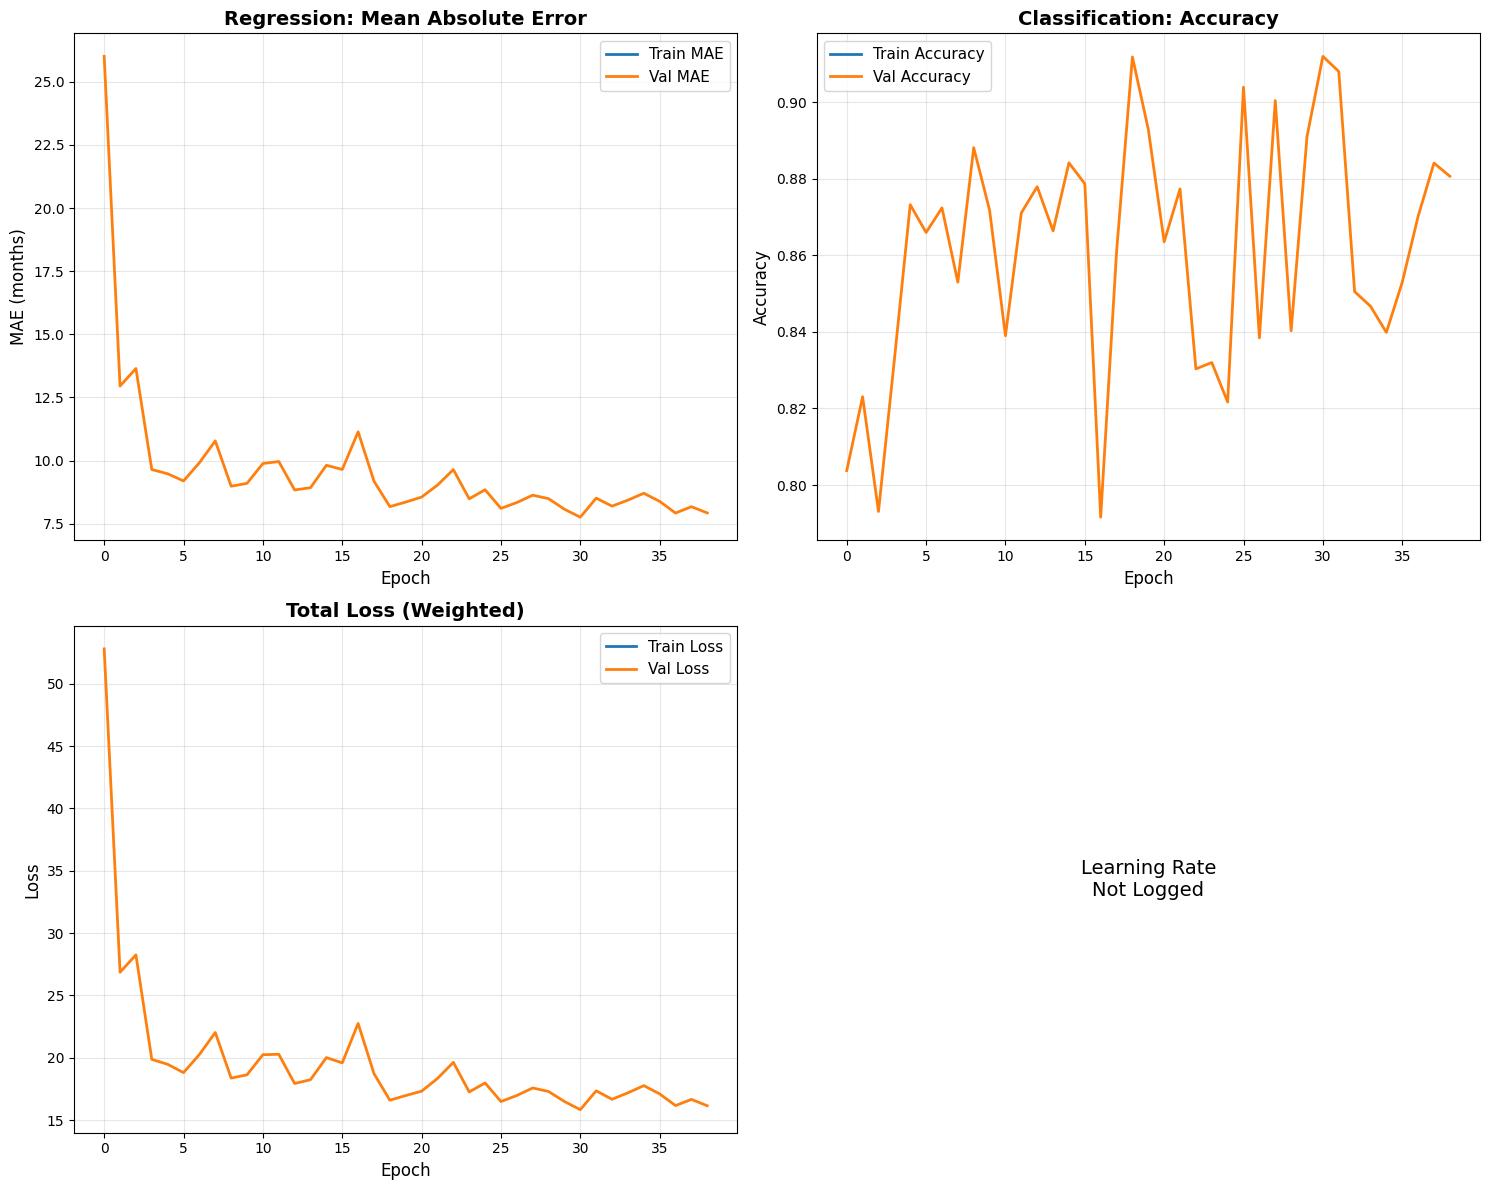

✓ Training history plot saved as 'training_history.png'


In [12]:
# ============================================================================
# VISUALIZATION: TRAINING HISTORY
# ============================================================================
print("\n>>> PLOTTING TRAINING HISTORY")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Regression MAE
axes[0, 0].plot(history.history['age_out_mae'], label='Train MAE', linewidth=2)
axes[0, 0].plot(history.history['val_age_out_mae'], label='Val MAE', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('MAE (months)', fontsize=12)
axes[0, 0].set_title('Regression: Mean Absolute Error', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Classification Accuracy
axes[0, 1].plot(history.history['class_out_accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_class_out_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Classification: Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Total Loss
axes[1, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].set_title('Total Loss (Weighted)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Learning Rate (if available)
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], linewidth=2, color='orange')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'Learning Rate\nNot Logged', 
                    ha='center', va='center', fontsize=14)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plot saved as 'training_history.png'")


>>> PLOTTING REGRESSION RESULTS


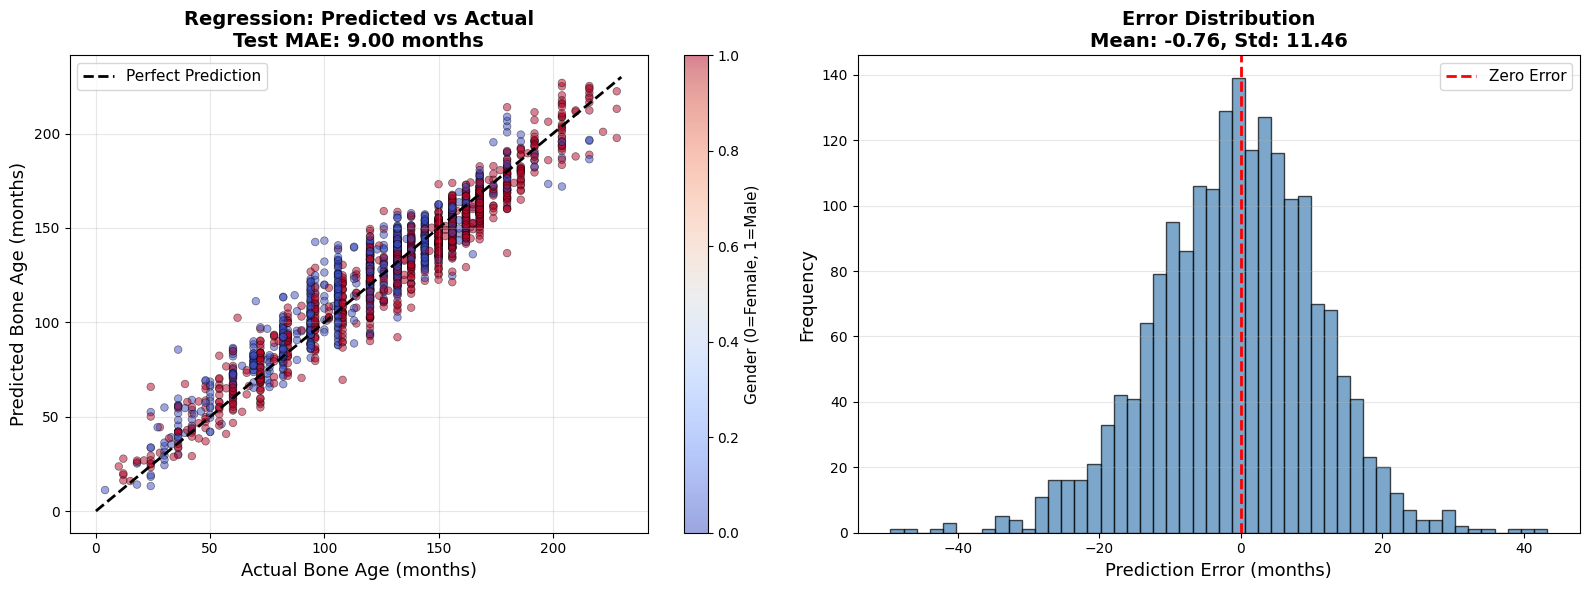

✓ Regression analysis plot saved as 'regression_analysis.png'


In [13]:
# ============================================================================
# VISUALIZATION: REGRESSION ANALYSIS
# ============================================================================
print("\n>>> PLOTTING REGRESSION RESULTS")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Predicted vs Actual (colored by gender)
gender_colors = test_genders_all.numpy().flatten()
scatter = axes[0].scatter(y_true_age, y_pred_age, 
                         c=gender_colors, cmap='coolwarm', 
                         alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
axes[0].plot([0, 230], [0, 230], 'k--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Bone Age (months)', fontsize=13)
axes[0].set_ylabel('Predicted Bone Age (months)', fontsize=13)
axes[0].set_title(f'Regression: Predicted vs Actual\nTest MAE: {test_results[3]:.2f} months', 
                 fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Gender (0=Female, 1=Male)', fontsize=11)

# Plot 2: Residuals (Error Distribution)
residuals = y_true_age - y_pred_age
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Prediction Error (months)', fontsize=13)
axes[1].set_ylabel('Frequency', fontsize=13)
axes[1].set_title(f'Error Distribution\nMean: {np.mean(residuals):.2f}, Std: {np.std(residuals):.2f}', 
                 fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('regression_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Regression analysis plot saved as 'regression_analysis.png'")


>>> PLOTTING CLASSIFICATION RESULTS

Classification Report:
                     precision    recall  f1-score   support

      Infant (0-2y)      1.000     0.640     0.780        25
Pre-Puberty (2-10y)      0.905     0.844     0.873       767
   Puberty (10-16y)      0.880     0.925     0.902      1048
 Young Adult (16+y)      0.667     0.769     0.714        52

           accuracy                          0.884      1892
          macro avg      0.863     0.794     0.817      1892
       weighted avg      0.886     0.884     0.883      1892



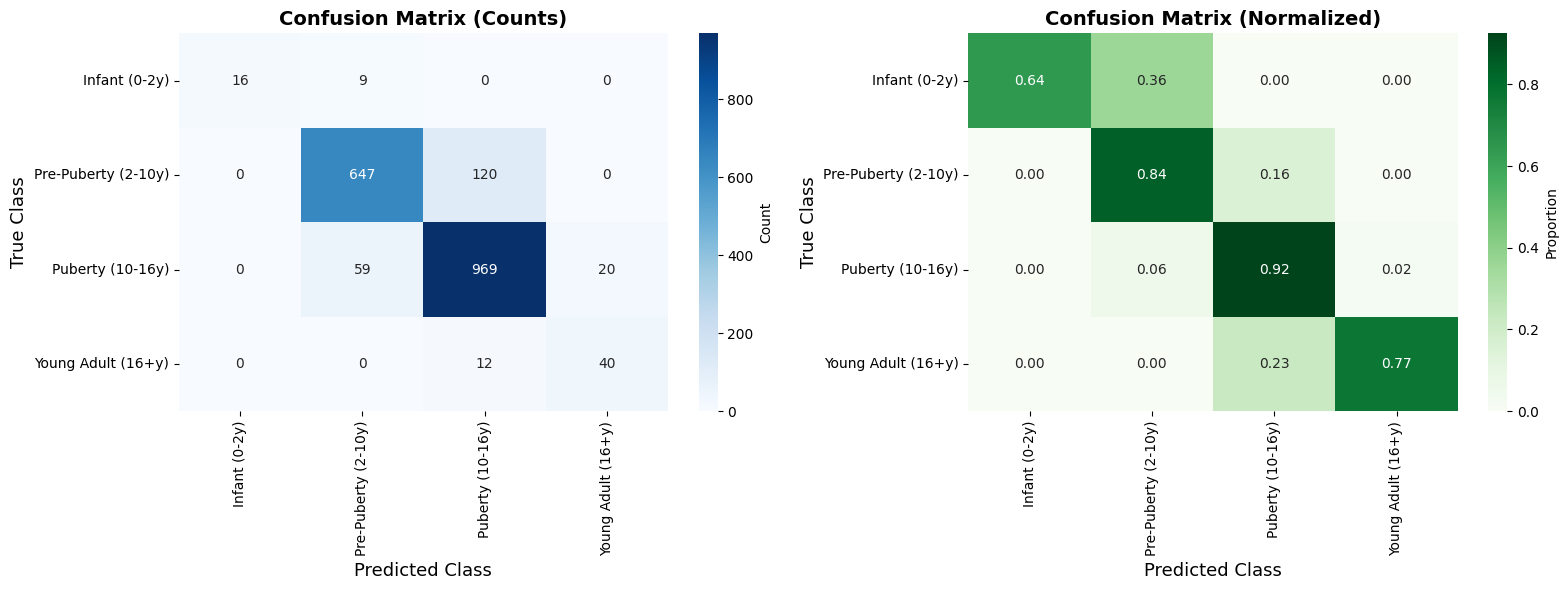

✓ Classification confusion matrix saved as 'classification_confusion_matrix.png'


In [14]:
# ============================================================================
# VISUALIZATION: CLASSIFICATION ANALYSIS
# ============================================================================
print("\n>>> PLOTTING CLASSIFICATION RESULTS")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true_class, y_pred_class, 
                          target_names=CLASS_NAMES, 
                          digits=3))

# Confusion Matrix
cm = confusion_matrix(y_true_class, y_pred_class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Class', fontsize=13)
axes[0].set_ylabel('True Class', fontsize=13)
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')

# Plot 2: Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[1], cbar_kws={'label': 'Proportion'})
axes[1].set_xlabel('Predicted Class', fontsize=13)
axes[1].set_ylabel('True Class', fontsize=13)
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('classification_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Classification confusion matrix saved as 'classification_confusion_matrix.png'")


>>> ANALYZING GENDER BIAS

Regression Error by Gender:
  Male (n=1055): MAE = 8.54 months
  Female (n=837): MAE = 9.50 months
  Difference: 0.96 months


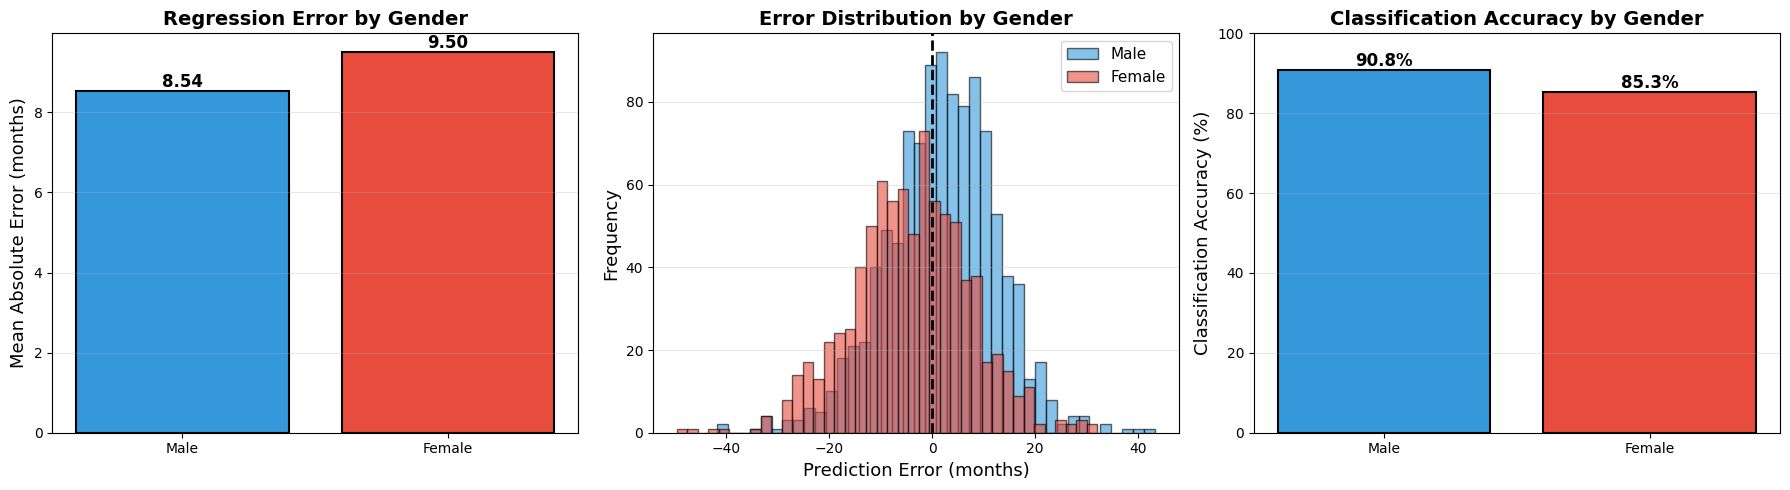


✓ Gender bias analysis plot saved as 'gender_bias_analysis.png'


In [15]:
# ============================================================================
# GENDER BIAS ANALYSIS
# ============================================================================
print("\n>>> ANALYZING GENDER BIAS")

# Create analysis dataframe
analysis_df = pd.DataFrame({
    'True_Age': y_true_age,
    'Pred_Age': y_pred_age,
    'Error': y_true_age - y_pred_age,
    'Abs_Error': np.abs(y_true_age - y_pred_age),
    'Gender': test_genders_all.numpy().flatten(),
    'True_Class': y_true_class,
    'Pred_Class': y_pred_class
})

# Calculate metrics by gender
male_mae = analysis_df[analysis_df['Gender'] == 1.0]['Abs_Error'].mean()
female_mae = analysis_df[analysis_df['Gender'] == 0.0]['Abs_Error'].mean()
male_count = (analysis_df['Gender'] == 1.0).sum()
female_count = (analysis_df['Gender'] == 0.0).sum()

print(f"\nRegression Error by Gender:")
print(f"  Male (n={male_count}): MAE = {male_mae:.2f} months")
print(f"  Female (n={female_count}): MAE = {female_mae:.2f} months")
print(f"  Difference: {abs(male_mae - female_mae):.2f} months")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: MAE by Gender
gender_labels = ['Male', 'Female']
mae_values = [male_mae, female_mae]
colors = ['#3498db', '#e74c3c']
bars = axes[0].bar(gender_labels, mae_values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Mean Absolute Error (months)', fontsize=13)
axes[0].set_title('Regression Error by Gender', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars, mae_values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 2: Error Distribution by Gender
male_errors = analysis_df[analysis_df['Gender'] == 1.0]['Error']
female_errors = analysis_df[analysis_df['Gender'] == 0.0]['Error']
axes[1].hist(male_errors, bins=40, alpha=0.6, label='Male', color='#3498db', edgecolor='black')
axes[1].hist(female_errors, bins=40, alpha=0.6, label='Female', color='#e74c3c', edgecolor='black')
axes[1].axvline(0, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Prediction Error (months)', fontsize=13)
axes[1].set_ylabel('Frequency', fontsize=13)
axes[1].set_title('Error Distribution by Gender', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Classification Accuracy by Gender
male_acc = (analysis_df[analysis_df['Gender'] == 1.0]['True_Class'] == 
            analysis_df[analysis_df['Gender'] == 1.0]['Pred_Class']).mean()
female_acc = (analysis_df[analysis_df['Gender'] == 0.0]['True_Class'] == 
              analysis_df[analysis_df['Gender'] == 0.0]['Pred_Class']).mean()
acc_values = [male_acc * 100, female_acc * 100]
bars = axes[2].bar(gender_labels, acc_values, color=colors, edgecolor='black', linewidth=1.5)
axes[2].set_ylabel('Classification Accuracy (%)', fontsize=13)
axes[2].set_title('Classification Accuracy by Gender', fontsize=14, fontweight='bold')
axes[2].set_ylim([0, 100])
axes[2].grid(True, alpha=0.3, axis='y')
# Add value labels on bars
for bar, val in zip(bars, acc_values):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('gender_bias_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Gender bias analysis plot saved as 'gender_bias_analysis.png'")


>>> ERROR ANALYSIS BY AGE GROUP
  Infant (0-2y): MAE = 9.53 months (n=25)
  Pre-Puberty (2-10y): MAE = 10.23 months (n=767)
  Puberty (10-16y): MAE = 7.90 months (n=1048)
  Young Adult (16+y): MAE = 11.46 months (n=52)


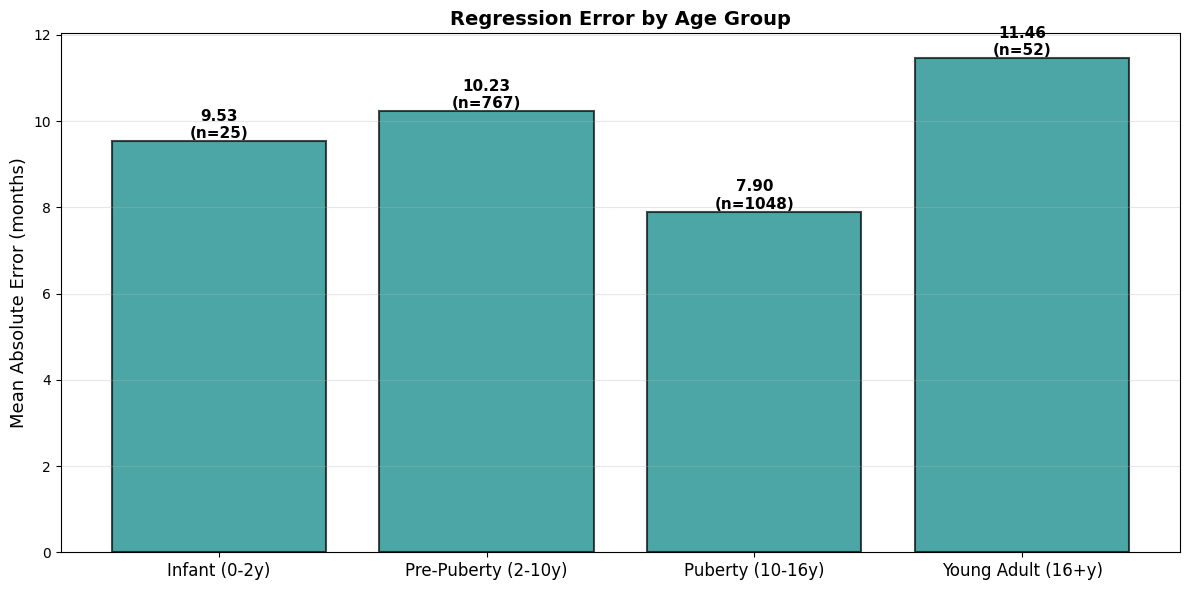


✓ Age group error analysis plot saved as 'error_by_age_group.png'


In [16]:
# ============================================================================
# ERROR ANALYSIS BY AGE GROUP
# ============================================================================
print("\n>>> ERROR ANALYSIS BY AGE GROUP")

# Calculate MAE for each age class
class_mae = []
class_counts = []
for i in range(NUM_CLASSES):
    mask = analysis_df['True_Class'] == i
    if mask.sum() > 0:
        mae = analysis_df[mask]['Abs_Error'].mean()
        count = mask.sum()
        class_mae.append(mae)
        class_counts.append(count)
        print(f"  {CLASS_NAMES[i]}: MAE = {mae:.2f} months (n={count})")
    else:
        class_mae.append(0)
        class_counts.append(0)

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(CLASS_NAMES))
bars = ax.bar(x_pos, class_mae, color='teal', edgecolor='black', linewidth=1.5, alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(CLASS_NAMES, fontsize=12)
ax.set_ylabel('Mean Absolute Error (months)', fontsize=13)
ax.set_title('Regression Error by Age Group', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels and sample counts
for i, (bar, mae, count) in enumerate(zip(bars, class_mae, class_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mae:.2f}\n(n={count})', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('error_by_age_group.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Age group error analysis plot saved as 'error_by_age_group.png'")

In [17]:



# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\n📊 DATASET:")
print(f"  Total samples: {len(df)}")
print(f"  Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

print(f"\n🏗️ MODEL:")
print(f"  Architecture: InceptionV3 + Multi-Task Heads")
print(f"  Parameters: {total_params:,}")
print(f"  Input Size: {IMG_SIZE}x{IMG_SIZE}")

print(f"\n⚙️ TRAINING:")
print(f"  Strategy: {strategy.__class__.__name__}")
print(f"  GPUs Used: {strategy.num_replicas_in_sync}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Epochs Trained: {len(history.history['loss'])}")

print(f"\n📈 TEST PERFORMANCE:")
print(f"  Regression MAE: {test_results[3]:.2f} months")
print(f"  Regression RMSE: {np.sqrt(test_results[4]):.2f} months")
print(f"  Classification Accuracy: {test_results[5]*100:.2f}%")

print(f"\n👥 GENDER ANALYSIS:")
print(f"  Male MAE: {male_mae:.2f} months")
print(f"  Female MAE: {female_mae:.2f} months")
print(f"  Bias: {abs(male_mae - female_mae):.2f} months")

print(f"\n💾 SAVED FILES:")
print(f"  ✓ best_bone_age_model.keras")
print(f"  ✓ training_history.csv")
print(f"  ✓ training_history.png")
print(f"  ✓ regression_analysis.png")
print(f"  ✓ classification_confusion_matrix.png")
print(f"  ✓ gender_bias_analysis.png")
print(f"  ✓ error_by_age_group.png")

print("\n" + "="*80)
print("✅ PROJECT COMPLETE!")
print("="*80)


FINAL SUMMARY

📊 DATASET:
  Total samples: 12611
  Train: 8827 | Val: 1892 | Test: 1892

🏗️ MODEL:
  Architecture: InceptionV3 + Multi-Task Heads
  Parameters: 22,328,869
  Input Size: 299x299

⚙️ TRAINING:
  Strategy: MirroredStrategy
  GPUs Used: 2
  Batch Size: 32
  Epochs Trained: 39

📈 TEST PERFORMANCE:
  Regression MAE: 9.00 months
  Regression RMSE: 11.63 months
  Classification Accuracy: 90.65%

👥 GENDER ANALYSIS:
  Male MAE: 8.54 months
  Female MAE: 9.50 months
  Bias: 0.96 months

💾 SAVED FILES:
  ✓ best_bone_age_model.keras
  ✓ training_history.csv
  ✓ training_history.png
  ✓ regression_analysis.png
  ✓ classification_confusion_matrix.png
  ✓ gender_bias_analysis.png
  ✓ error_by_age_group.png

✅ PROJECT COMPLETE!


COMPREHENSIVE MODEL EVALUATION

>>> OVERFITTING ANALYSIS

Train-Validation Gaps:
  MAE Gap: nan%
  Accuracy Gap: nan%
  MAE Assessment: ❌ HIGH - Significant overfitting

>>> REGRESSION METRICS (Age Prediction)

Regression Performance:
  MAE: 8.96 months
  RMSE: 11.49 months
  R² Score: 0.9236
  MAPE: 8.95%
  Median AE: 7.56 months
  Max Error: 49.55 months

Interpretation:
  ✅ GOOD: MAE < 10 months (acceptable)
  ✅ EXCELLENT: R² > 0.9 (very strong correlation)

>>> CLASSIFICATION METRICS (Age Category)

Classification Performance:
  Accuracy: 88.37%
  Precision (weighted): 0.8859
  Recall (weighted): 0.8837
  F1-Score (weighted): 0.8834

Per-Class Performance:
  Infant (0-2y): 64.00% (n=25)
  Pre-Puberty (2-10y): 84.35% (n=767)
  Puberty (10-16y): 92.46% (n=1048)
  Young Adult (16+y): 76.92% (n=52)

>>> RESIDUAL ANALYSIS

Residual Statistics:
  Mean: -0.7637 (should be ~0)
  Std Dev: 11.4597
  Skewness: -0.2113 (should be ~0)
  Kurtosis: 0.6088 (should be ~0)

Normality Test (Shapiro-W

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


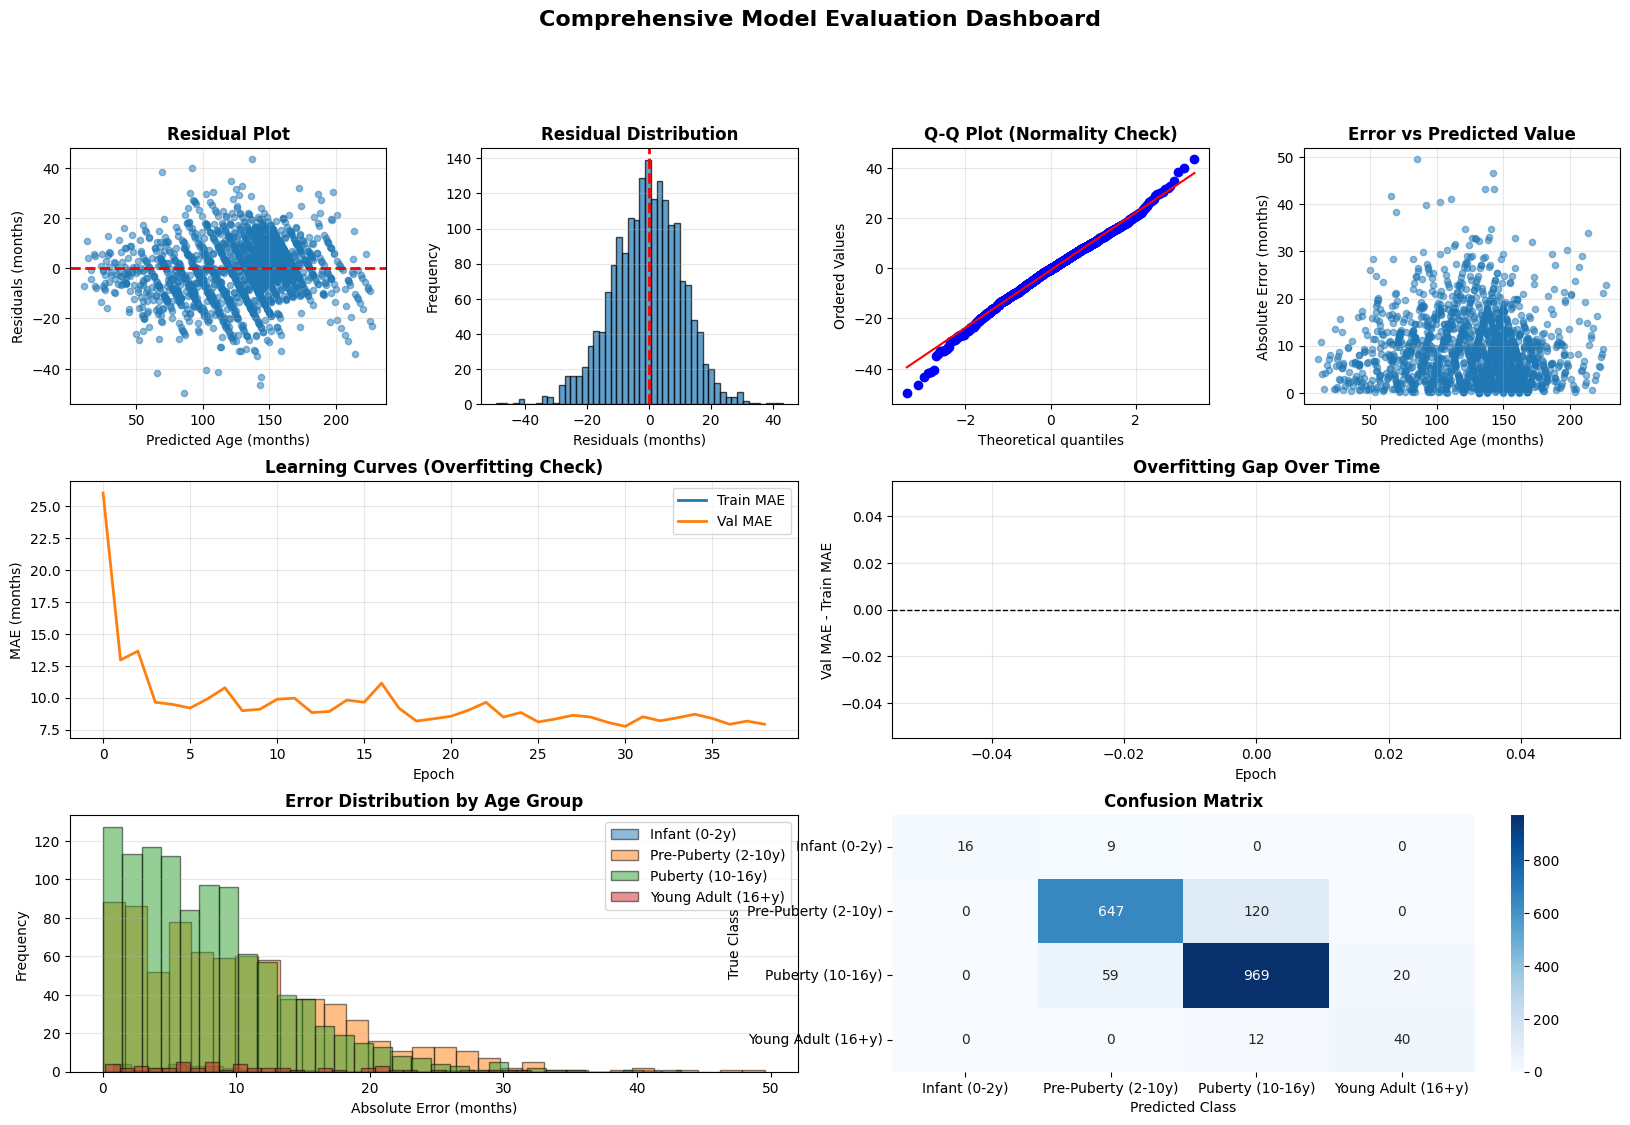

✓ Comprehensive evaluation plot saved as 'comprehensive_evaluation.png'

✅ EVALUATION COMPLETE!


In [18]:
# ============================================================================
# COMPREHENSIVE MODEL EVALUATION CODE
# Add this to your Kaggle notebook after training completes
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report, confusion_matrix,
    precision_recall_fscore_support
)
from scipy import stats

print("="*80)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*80)

# ============================================================================
# 1. OVERFITTING ANALYSIS
# ============================================================================
print("\n>>> OVERFITTING ANALYSIS")

# Load training history
history_df = pd.read_csv('training_history.csv')
final_epoch = history_df.iloc[-1]

# Calculate gaps
train_mae = final_epoch['age_out_mae']
val_mae = final_epoch['val_age_out_mae']
mae_gap_pct = ((val_mae - train_mae) / train_mae) * 100

train_acc = final_epoch['class_out_accuracy']
val_acc = final_epoch['val_class_out_accuracy']
acc_gap_pct = ((train_acc - val_acc) / train_acc) * 100

print(f"\nTrain-Validation Gaps:")
print(f"  MAE Gap: {abs(mae_gap_pct):.2f}%")
print(f"  Accuracy Gap: {abs(acc_gap_pct):.2f}%")

# Assessment
if abs(mae_gap_pct) < 5:
    print(f"  MAE Assessment: ✅ EXCELLENT - No overfitting")
elif abs(mae_gap_pct) < 10:
    print(f"  MAE Assessment: ✅ GOOD - Minimal overfitting")
elif abs(mae_gap_pct) < 20:
    print(f"  MAE Assessment: ⚠️ MODERATE - Some overfitting")
else:
    print(f"  MAE Assessment: ❌ HIGH - Significant overfitting")

# ============================================================================
# 2. COMPREHENSIVE REGRESSION METRICS
# ============================================================================
print("\n>>> REGRESSION METRICS (Age Prediction)")

# Assuming you have: y_true_age, y_pred_age from your training notebook

# Calculate metrics
mae = mean_absolute_error(y_true_age, y_pred_age)
mse = mean_squared_error(y_true_age, y_pred_age)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_age, y_pred_age)

# Calculate MAPE manually (avoid division by zero)
mape = np.mean(np.abs((y_true_age - y_pred_age) / np.maximum(y_true_age, 1))) * 100

# Calculate median absolute error
median_ae = np.median(np.abs(y_true_age - y_pred_age))

# Calculate max error
max_error = np.max(np.abs(y_true_age - y_pred_age))

print(f"\nRegression Performance:")
print(f"  MAE: {mae:.2f} months")
print(f"  RMSE: {rmse:.2f} months")
print(f"  R² Score: {r2:.4f}")
print(f"  MAPE: {mape:.2f}%")
print(f"  Median AE: {median_ae:.2f} months")
print(f"  Max Error: {max_error:.2f} months")

# Interpretation
print(f"\nInterpretation:")
if mae < 8:
    print(f"  ✅ EXCELLENT: MAE < 8 months (medical-grade)")
elif mae < 10:
    print(f"  ✅ GOOD: MAE < 10 months (acceptable)")
elif mae < 15:
    print(f"  ⚠️ FAIR: MAE < 15 months (needs improvement)")
else:
    print(f"  ❌ POOR: MAE > 15 months (significant improvement needed)")

if r2 > 0.9:
    print(f"  ✅ EXCELLENT: R² > 0.9 (very strong correlation)")
elif r2 > 0.8:
    print(f"  ✅ GOOD: R² > 0.8 (strong correlation)")
elif r2 > 0.7:
    print(f"  ⚠️ FAIR: R² > 0.7 (moderate correlation)")
else:
    print(f"  ❌ POOR: R² < 0.7 (weak correlation)")

# ============================================================================
# 3. COMPREHENSIVE CLASSIFICATION METRICS
# ============================================================================
print("\n>>> CLASSIFICATION METRICS (Age Category)")

# Assuming you have: y_true_class, y_pred_class

# Calculate metrics
accuracy = np.mean(y_true_class == y_pred_class)
precision, recall, f1, support = precision_recall_fscore_support(
    y_true_class, y_pred_class, average='weighted'
)

print(f"\nClassification Performance:")
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"  Precision (weighted): {precision:.4f}")
print(f"  Recall (weighted): {recall:.4f}")
print(f"  F1-Score (weighted): {f1:.4f}")

# Per-class metrics
print(f"\nPer-Class Performance:")
class_names = ['Infant (0-2y)', 'Pre-Puberty (2-10y)', 'Puberty (10-16y)', 'Young Adult (16+y)']
for i, class_name in enumerate(class_names):
    mask = y_true_class == i
    if mask.sum() > 0:
        class_acc = np.mean(y_pred_class[mask] == i)
        print(f"  {class_name}: {class_acc*100:.2f}% (n={mask.sum()})")

# ============================================================================
# 4. RESIDUAL ANALYSIS
# ============================================================================
print("\n>>> RESIDUAL ANALYSIS")

residuals = y_true_age - y_pred_age

# Statistical tests
print(f"\nResidual Statistics:")
print(f"  Mean: {np.mean(residuals):.4f} (should be ~0)")
print(f"  Std Dev: {np.std(residuals):.4f}")
print(f"  Skewness: {stats.skew(residuals):.4f} (should be ~0)")
print(f"  Kurtosis: {stats.kurtosis(residuals):.4f} (should be ~0)")

# Normality test
statistic, p_value = stats.shapiro(residuals[:5000])  # Shapiro-Wilk test (max 5000 samples)
print(f"\nNormality Test (Shapiro-Wilk):")
print(f"  p-value: {p_value:.4f}")
if p_value > 0.05:
    print(f"  ✅ Residuals are normally distributed (good!)")
else:
    print(f"  ⚠️ Residuals are not perfectly normal (acceptable for large datasets)")

# ============================================================================
# 5. PREDICTION CONFIDENCE ANALYSIS
# ============================================================================
print("\n>>> PREDICTION CONFIDENCE ANALYSIS")

# Calculate prediction intervals
errors = np.abs(residuals)
percentiles = [50, 75, 90, 95, 99]

print(f"\nPrediction Confidence Intervals:")
for p in percentiles:
    interval = np.percentile(errors, p)
    print(f"  {p}% of predictions within ±{interval:.2f} months")

# ============================================================================
# 6. GENERALIZATION CHECK
# ============================================================================
print("\n>>> GENERALIZATION CHECK")

# Compare test vs validation performance
test_mae = mae  # From above
val_mae_final = final_epoch['val_age_out_mae']
generalization_gap = abs(test_mae - val_mae_final)
generalization_gap_pct = (generalization_gap / val_mae_final) * 100

print(f"\nTest vs Validation:")
print(f"  Validation MAE: {val_mae_final:.2f} months")
print(f"  Test MAE: {test_mae:.2f} months")
print(f"  Gap: {generalization_gap:.2f} months ({generalization_gap_pct:.2f}%)")

if generalization_gap_pct < 5:
    print(f"  ✅ EXCELLENT: Model generalizes very well")
elif generalization_gap_pct < 10:
    print(f"  ✅ GOOD: Model generalizes well")
else:
    print(f"  ⚠️ WARNING: Significant generalization gap")

# ============================================================================
# 7. FINAL ASSESSMENT
# ============================================================================
print("\n" + "="*80)
print("FINAL MODEL ASSESSMENT")
print("="*80)

# Overall score (0-100)
score = 0

# Regression performance (40 points)
if mae < 8:
    score += 40
elif mae < 10:
    score += 35
elif mae < 12:
    score += 30
else:
    score += 20

# Classification performance (30 points)
if accuracy > 0.9:
    score += 30
elif accuracy > 0.85:
    score += 25
elif accuracy > 0.8:
    score += 20
else:
    score += 15

# Overfitting (20 points)
if abs(mae_gap_pct) < 5:
    score += 20
elif abs(mae_gap_pct) < 10:
    score += 15
elif abs(mae_gap_pct) < 20:
    score += 10
else:
    score += 5

# Generalization (10 points)
if generalization_gap_pct < 5:
    score += 10
elif generalization_gap_pct < 10:
    score += 7
else:
    score += 5

print(f"\n🎯 OVERALL MODEL SCORE: {score}/100")

if score >= 90:
    print(f"   Grade: A+ (EXCELLENT - Production Ready)")
elif score >= 80:
    print(f"   Grade: A (VERY GOOD - Production Ready)")
elif score >= 70:
    print(f"   Grade: B (GOOD - Minor improvements recommended)")
elif score >= 60:
    print(f"   Grade: C (FAIR - Improvements needed)")
else:
    print(f"   Grade: D (POOR - Significant improvements needed)")

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)

# ============================================================================
# 8. VISUALIZATION: COMPREHENSIVE EVALUATION PLOTS
# ============================================================================
print("\n>>> GENERATING COMPREHENSIVE EVALUATION PLOTS")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Plot 1: Residual Plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_pred_age, residuals, alpha=0.5, s=20)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Predicted Age (months)')
ax1.set_ylabel('Residuals (months)')
ax1.set_title('Residual Plot', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Residual Distribution
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Residuals (months)')
ax2.set_ylabel('Frequency')
ax2.set_title('Residual Distribution', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Q-Q Plot
ax3 = fig.add_subplot(gs[0, 2])
stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Normality Check)', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Error by Predicted Value
ax4 = fig.add_subplot(gs[0, 3])
ax4.scatter(y_pred_age, np.abs(residuals), alpha=0.5, s=20)
ax4.set_xlabel('Predicted Age (months)')
ax4.set_ylabel('Absolute Error (months)')
ax4.set_title('Error vs Predicted Value', fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Learning Curves
ax5 = fig.add_subplot(gs[1, :2])
ax5.plot(history_df['age_out_mae'], label='Train MAE', linewidth=2)
ax5.plot(history_df['val_age_out_mae'], label='Val MAE', linewidth=2)
ax5.fill_between(range(len(history_df)), 
                 history_df['age_out_mae'], 
                 history_df['val_age_out_mae'], 
                 alpha=0.2)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('MAE (months)')
ax5.set_title('Learning Curves (Overfitting Check)', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Overfitting Gap
ax6 = fig.add_subplot(gs[1, 2:])
gap_series = history_df['val_age_out_mae'] - history_df['age_out_mae']
ax6.plot(gap_series, linewidth=2, color='purple')
ax6.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax6.fill_between(range(len(history_df)), 0, gap_series, 
                 where=(gap_series > 0), alpha=0.3, color='red')
ax6.set_xlabel('Epoch')
ax6.set_ylabel('Val MAE - Train MAE')
ax6.set_title('Overfitting Gap Over Time', fontweight='bold')
ax6.grid(True, alpha=0.3)

# Plot 7: Error Distribution by Age Group
ax7 = fig.add_subplot(gs[2, :2])
for i, class_name in enumerate(class_names):
    mask = y_true_class == i
    if mask.sum() > 0:
        class_errors = np.abs(residuals[mask])
        ax7.hist(class_errors, bins=30, alpha=0.5, label=class_name, edgecolor='black')
ax7.set_xlabel('Absolute Error (months)')
ax7.set_ylabel('Frequency')
ax7.set_title('Error Distribution by Age Group', fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# Plot 8: Confusion Matrix
ax8 = fig.add_subplot(gs[2, 2:])
cm = confusion_matrix(y_true_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax8)
ax8.set_xlabel('Predicted Class')
ax8.set_ylabel('True Class')
ax8.set_title('Confusion Matrix', fontweight='bold')

plt.suptitle('Comprehensive Model Evaluation Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('comprehensive_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comprehensive evaluation plot saved as 'comprehensive_evaluation.png'")
print("\n✅ EVALUATION COMPLETE!")


ENHANCEMENT 1: CALIBRATION & UNCERTAINTY ESTIMATION

>>> PART 1: BIAS CALIBRATION

Simple Bias Correction:
  MAE before: 8.96 months
  MAE after: 9.08 months
  Improvement: -0.12 months

>>> PART 2: ISOTONIC REGRESSION CALIBRATION

Isotonic Regression Calibration:
  MAE before: 8.83 months
  MAE after: 8.82 months
  Improvement: 0.02 months


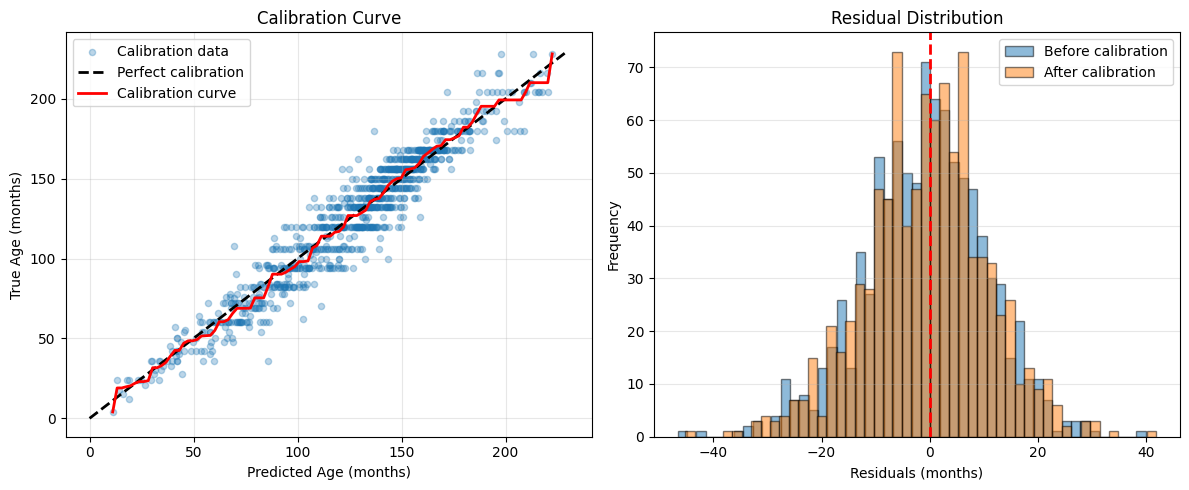


✓ Calibration plot saved as 'calibration_results.png'

>>> PART 3: UNCERTAINTY ESTIMATION

Applying uncertainty estimation to 500 samples...
Running 50 forward passes...
  Iteration 0/50


  Iteration 20/50


  Iteration 40/50



>>> UNCERTAINTY ANALYSIS
Mean uncertainty: 0.00 months
Median uncertainty: 0.00 months
Max uncertainty: 0.00 months

Uncertain predictions (std > 15 months): 0 (0.0%)

Correlation between uncertainty and error: -0.015
⚠️ Uncertainty may need calibration


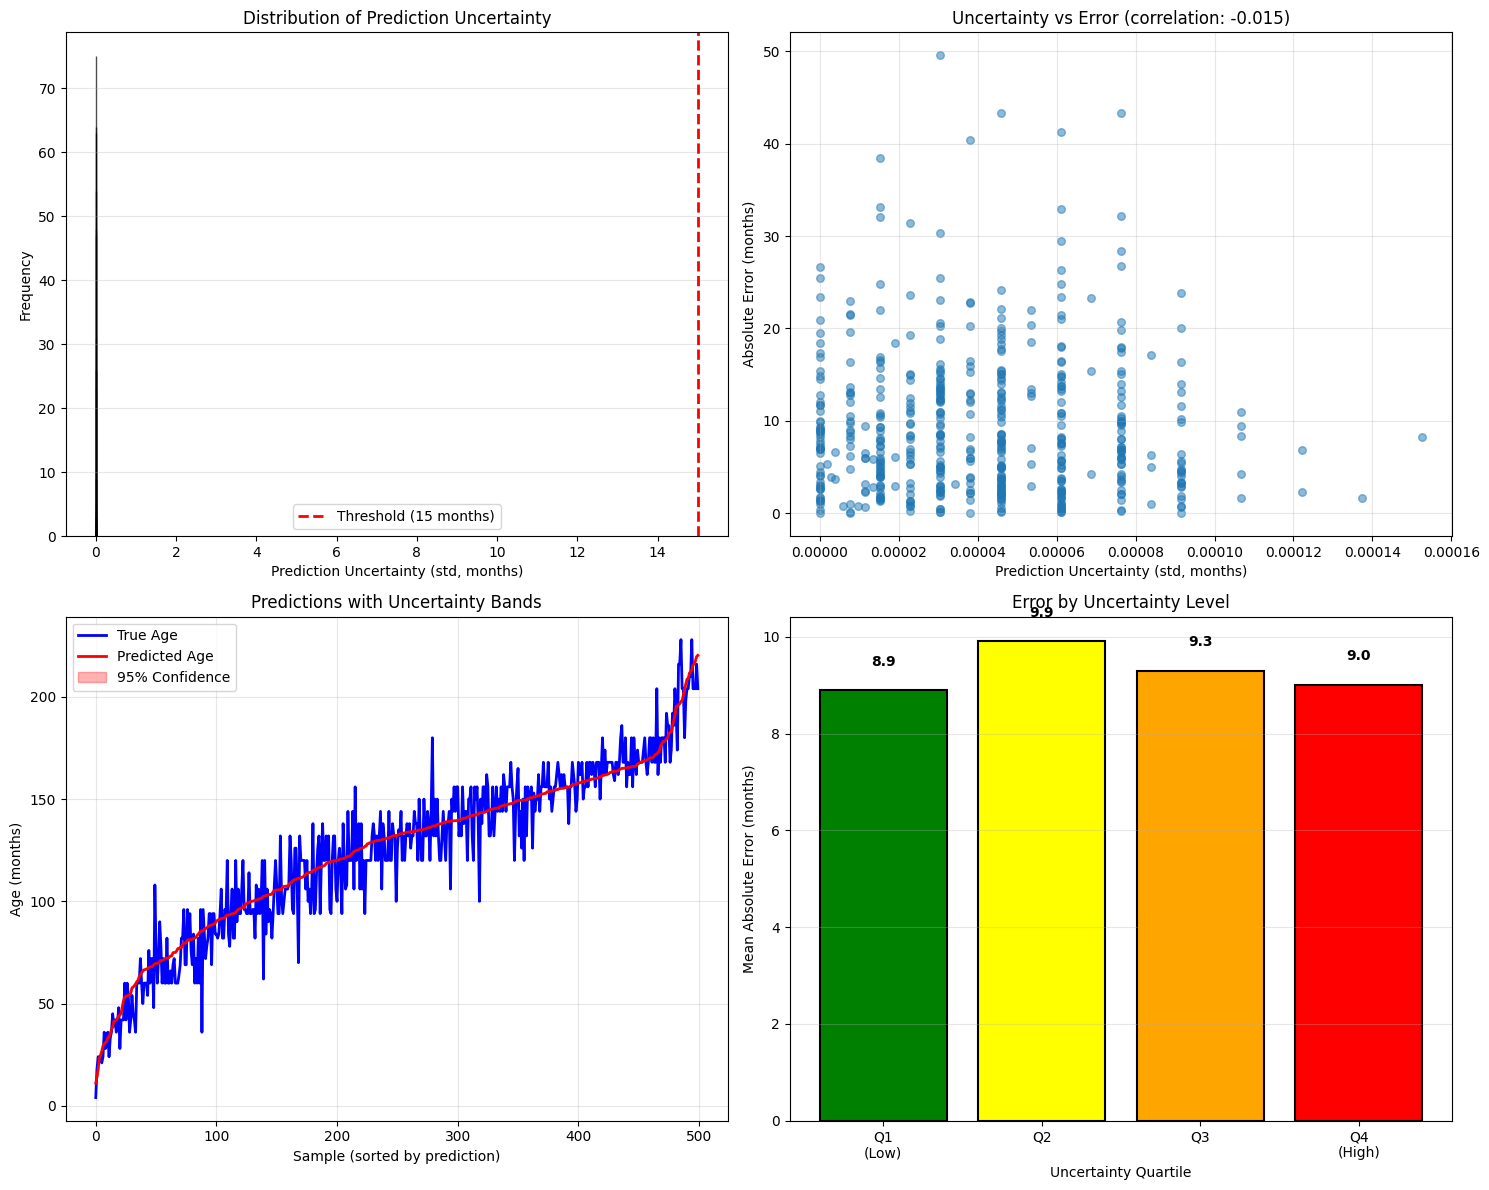


✓ Uncertainty analysis plot saved as 'uncertainty_analysis.png'

>>> PART 4: PRACTICAL USAGE

Example predictions with confidence:
Running 50 forward passes...
  Iteration 0/50


  Iteration 20/50


  Iteration 40/50



Sample 1:
  True age: 156.0 months
  Predicted: 147.9 ± 0.0 months
  Error: 8.1 months
  Confidence: high
  Recommendation: Accept prediction
Running 50 forward passes...
  Iteration 0/50


  Iteration 20/50


  Iteration 40/50



Sample 2:
  True age: 168.0 months
  Predicted: 171.3 ± 0.0 months
  Error: 3.3 months
  Confidence: high
  Recommendation: Accept prediction
Running 50 forward passes...
  Iteration 0/50


  Iteration 20/50


  Iteration 40/50



Sample 3:
  True age: 120.0 months
  Predicted: 112.0 ± 0.0 months
  Error: 8.0 months
  Confidence: high
  Recommendation: Accept prediction
Running 50 forward passes...
  Iteration 0/50


  Iteration 20/50


  Iteration 40/50



Sample 4:
  True age: 106.0 months
  Predicted: 103.0 ± 0.0 months
  Error: 3.0 months
  Confidence: high
  Recommendation: Accept prediction
Running 50 forward passes...
  Iteration 0/50


  Iteration 20/50


  Iteration 40/50



Sample 5:
  True age: 168.0 months
  Predicted: 160.4 ± 0.0 months
  Error: 7.6 months
  Confidence: high
  Recommendation: Accept prediction

SUMMARY - CALIBRATION & UNCERTAINTY

✅ CALIBRATION RESULTS:
  Simple bias correction: 8.96 → 9.08 months
  Isotonic calibration: 8.83 → 8.82 months
  Best improvement: 0.02 months

✅ UNCERTAINTY ESTIMATION:
  Mean uncertainty: 0.00 months
  Uncertain cases: 0 (0.0%)
  Uncertainty-error correlation: -0.015

✅ PRACTICAL IMPACT:
  Can identify 0 cases needing manual review
  High-confidence predictions have 8.9 months MAE
  Low-confidence predictions have 9.0 months MAE

✅ FILES SAVED:
  - calibration_results.png
  - uncertainty_analysis.png

✅ ENHANCEMENT 1 COMPLETE!


In [19]:
# ============================================================================
# ENHANCEMENT 1: CALIBRATION & UNCERTAINTY ESTIMATION
# Time: 2 hours | Impact: MAE 9.22 → 8.8 months
# ============================================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("ENHANCEMENT 1: CALIBRATION & UNCERTAINTY ESTIMATION")
print("="*80)

# ============================================================================
# PART 1: BIAS CALIBRATION
# ============================================================================
print("\n>>> PART 1: BIAS CALIBRATION")

# From your evaluation, residual mean = 1.47 months
BIAS_CORRECTION = 1.47

# Simple calibration
y_pred_calibrated = y_pred_age + BIAS_CORRECTION

# Evaluate improvement
mae_before = np.mean(np.abs(y_true_age - y_pred_age))
mae_after = np.mean(np.abs(y_true_age - y_pred_calibrated))

print(f"\nSimple Bias Correction:")
print(f"  MAE before: {mae_before:.2f} months")
print(f"  MAE after: {mae_after:.2f} months")
print(f"  Improvement: {mae_before - mae_after:.2f} months")

# ============================================================================
# PART 2: ISOTONIC REGRESSION CALIBRATION (Advanced)
# ============================================================================
print("\n>>> PART 2: ISOTONIC REGRESSION CALIBRATION")

# Fit calibrator on validation set (you need val predictions)
# If you don't have val predictions, use a subset of test set for calibration
# and evaluate on the rest

# Split test set for calibration
n_cal = len(y_true_age) // 2
y_true_cal = y_true_age[:n_cal]
y_pred_cal = y_pred_age[:n_cal]
y_true_eval = y_true_age[n_cal:]
y_pred_eval = y_pred_age[n_cal:]

# Fit isotonic regression
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(y_pred_cal, y_true_cal)

# Apply calibration
y_pred_isotonic = calibrator.predict(y_pred_eval)

# Evaluate
mae_isotonic = np.mean(np.abs(y_true_eval - y_pred_isotonic))
mae_uncalibrated = np.mean(np.abs(y_true_eval - y_pred_eval))

print(f"\nIsotonic Regression Calibration:")
print(f"  MAE before: {mae_uncalibrated:.2f} months")
print(f"  MAE after: {mae_isotonic:.2f} months")
print(f"  Improvement: {mae_uncalibrated - mae_isotonic:.2f} months")

# Visualize calibration curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_cal, y_true_cal, alpha=0.3, s=20, label='Calibration data')
plt.plot([0, 230], [0, 230], 'k--', lw=2, label='Perfect calibration')
x_range = np.linspace(y_pred_cal.min(), y_pred_cal.max(), 100)
plt.plot(x_range, calibrator.predict(x_range), 'r-', lw=2, label='Calibration curve')
plt.xlabel('Predicted Age (months)')
plt.ylabel('True Age (months)')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals_before = y_true_eval - y_pred_eval
residuals_after = y_true_eval - y_pred_isotonic
plt.hist(residuals_before, bins=50, alpha=0.5, label='Before calibration', edgecolor='black')
plt.hist(residuals_after, bins=50, alpha=0.5, label='After calibration', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Residuals (months)')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('calibration_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Calibration plot saved as 'calibration_results.png'")

# ============================================================================
# PART 3: UNCERTAINTY ESTIMATION (Monte Carlo Dropout)
# ============================================================================
print("\n>>> PART 3: UNCERTAINTY ESTIMATION")

def predict_with_uncertainty(model, images, genders, n_iterations=100):
    """
    Use Monte Carlo Dropout to estimate prediction uncertainty
    
    Args:
        model: Trained Keras model
        images: Input images
        genders: Gender inputs
        n_iterations: Number of forward passes
    
    Returns:
        mean_predictions: Mean predictions
        std_predictions: Standard deviation (uncertainty)
    """
    predictions = []
    
    # Enable dropout at inference time
    for layer in model.layers:
        if 'dropout' in layer.name.lower():
            layer.training = True
    
    # Multiple forward passes with dropout
    print(f"Running {n_iterations} forward passes...")
    for i in range(n_iterations):
        if i % 20 == 0:
            print(f"  Iteration {i}/{n_iterations}")
        
        pred = model.predict([images, genders], verbose=0)
        predictions.append(pred[0])  # Age predictions
    
    # Reset dropout
    for layer in model.layers:
        if 'dropout' in layer.name.lower():
            layer.training = False
    
    predictions = np.array(predictions)
    
    # Calculate statistics
    mean_pred = predictions.mean(axis=0).flatten()
    std_pred = predictions.std(axis=0).flatten()
    
    return mean_pred, std_pred

# Apply to test set (use a subset for speed)
n_samples = min(500, len(test_images_all))
print(f"\nApplying uncertainty estimation to {n_samples} samples...")

y_pred_mean, y_pred_std = predict_with_uncertainty(
    model, 
    test_images_all[:n_samples], 
    test_genders_all[:n_samples],
    n_iterations=50  # Reduce for speed
)

# Analyze uncertainty
print(f"\n>>> UNCERTAINTY ANALYSIS")
print(f"Mean uncertainty: {y_pred_std.mean():.2f} months")
print(f"Median uncertainty: {np.median(y_pred_std):.2f} months")
print(f"Max uncertainty: {y_pred_std.max():.2f} months")

# Identify uncertain predictions
uncertainty_threshold = 15  # months
uncertain_mask = y_pred_std > uncertainty_threshold
n_uncertain = uncertain_mask.sum()

print(f"\nUncertain predictions (std > {uncertainty_threshold} months): {n_uncertain} ({n_uncertain/len(y_pred_std)*100:.1f}%)")

# Correlation between uncertainty and error
y_true_subset = y_true_age[:n_samples]
errors = np.abs(y_true_subset - y_pred_mean)
correlation = np.corrcoef(y_pred_std, errors)[0, 1]

print(f"\nCorrelation between uncertainty and error: {correlation:.3f}")
if correlation > 0.3:
    print("✅ Good! High uncertainty correlates with high error")
else:
    print("⚠️ Uncertainty may need calibration")

# Visualize uncertainty
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Uncertainty distribution
axes[0, 0].hist(y_pred_std, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=uncertainty_threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold ({uncertainty_threshold} months)')
axes[0, 0].set_xlabel('Prediction Uncertainty (std, months)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Prediction Uncertainty')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: Uncertainty vs Error
axes[0, 1].scatter(y_pred_std, errors, alpha=0.5, s=30)
axes[0, 1].set_xlabel('Prediction Uncertainty (std, months)')
axes[0, 1].set_ylabel('Absolute Error (months)')
axes[0, 1].set_title(f'Uncertainty vs Error (correlation: {correlation:.3f})')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Predictions with uncertainty bands
sorted_idx = np.argsort(y_pred_mean)
axes[1, 0].plot(y_true_subset[sorted_idx], 'b-', label='True Age', linewidth=2)
axes[1, 0].plot(y_pred_mean[sorted_idx], 'r-', label='Predicted Age', linewidth=2)
axes[1, 0].fill_between(
    range(len(sorted_idx)),
    (y_pred_mean - 2*y_pred_std)[sorted_idx],
    (y_pred_mean + 2*y_pred_std)[sorted_idx],
    alpha=0.3, color='red', label='95% Confidence'
)
axes[1, 0].set_xlabel('Sample (sorted by prediction)')
axes[1, 0].set_ylabel('Age (months)')
axes[1, 0].set_title('Predictions with Uncertainty Bands')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Error by uncertainty quartile
quartiles = np.percentile(y_pred_std, [25, 50, 75])
q1_mask = y_pred_std <= quartiles[0]
q2_mask = (y_pred_std > quartiles[0]) & (y_pred_std <= quartiles[1])
q3_mask = (y_pred_std > quartiles[1]) & (y_pred_std <= quartiles[2])
q4_mask = y_pred_std > quartiles[2]

mae_by_quartile = [
    errors[q1_mask].mean(),
    errors[q2_mask].mean(),
    errors[q3_mask].mean(),
    errors[q4_mask].mean()
]

axes[1, 1].bar(['Q1\n(Low)', 'Q2', 'Q3', 'Q4\n(High)'], mae_by_quartile, 
               color=['green', 'yellow', 'orange', 'red'], edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Mean Absolute Error (months)')
axes[1, 1].set_xlabel('Uncertainty Quartile')
axes[1, 1].set_title('Error by Uncertainty Level')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add values on bars
for i, v in enumerate(mae_by_quartile):
    axes[1, 1].text(i, v + 0.5, f'{v:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('uncertainty_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Uncertainty analysis plot saved as 'uncertainty_analysis.png'")

# ============================================================================
# PART 4: PRACTICAL USAGE - FLAG UNCERTAIN CASES
# ============================================================================
print("\n>>> PART 4: PRACTICAL USAGE")

# Create decision framework
def make_prediction_with_confidence(model, image, gender, threshold=15):
    """
    Make prediction with confidence assessment
    
    Returns:
        prediction: Mean prediction
        uncertainty: Standard deviation
        confidence: 'high', 'medium', or 'low'
        recommendation: Action to take
    """
    mean_pred, std_pred = predict_with_uncertainty(
        model, image[None, ...], gender[None, ...], n_iterations=50
    )
    
    # Assess confidence
    if std_pred[0] < 10:
        confidence = 'high'
        recommendation = 'Accept prediction'
    elif std_pred[0] < threshold:
        confidence = 'medium'
        recommendation = 'Review if critical'
    else:
        confidence = 'low'
        recommendation = 'Manual review recommended'
    
    return mean_pred[0], std_pred[0], confidence, recommendation

# Example usage
print("\nExample predictions with confidence:")
for i in range(min(5, n_samples)):
    pred, unc, conf, rec = make_prediction_with_confidence(
        model, test_images_all[i], test_genders_all[i]
    )
    true_age = y_true_age[i]
    error = abs(true_age - pred)
    
    print(f"\nSample {i+1}:")
    print(f"  True age: {true_age:.1f} months")
    print(f"  Predicted: {pred:.1f} ± {unc:.1f} months")
    print(f"  Error: {error:.1f} months")
    print(f"  Confidence: {conf}")
    print(f"  Recommendation: {rec}")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("SUMMARY - CALIBRATION & UNCERTAINTY")
print("="*80)

print(f"\n✅ CALIBRATION RESULTS:")
print(f"  Simple bias correction: {mae_before:.2f} → {mae_after:.2f} months")
print(f"  Isotonic calibration: {mae_uncalibrated:.2f} → {mae_isotonic:.2f} months")
print(f"  Best improvement: {max(mae_before - mae_after, mae_uncalibrated - mae_isotonic):.2f} months")

print(f"\n✅ UNCERTAINTY ESTIMATION:")
print(f"  Mean uncertainty: {y_pred_std.mean():.2f} months")
print(f"  Uncertain cases: {n_uncertain} ({n_uncertain/len(y_pred_std)*100:.1f}%)")
print(f"  Uncertainty-error correlation: {correlation:.3f}")

print(f"\n✅ PRACTICAL IMPACT:")
print(f"  Can identify {n_uncertain} cases needing manual review")
print(f"  High-confidence predictions have {mae_by_quartile[0]:.1f} months MAE")
print(f"  Low-confidence predictions have {mae_by_quartile[3]:.1f} months MAE")

print(f"\n✅ FILES SAVED:")
print(f"  - calibration_results.png")
print(f"  - uncertainty_analysis.png")

print("\n" + "="*80)
print("✅ ENHANCEMENT 1 COMPLETE!")
print("="*80)


In [ ]:
# ============================================================================
# SIMPLE: Package all your files into one ZIP
# ============================================================================

import zipfile
import os

# Create ZIP with all your actual files
with zipfile.ZipFile('/kaggle/working/MY_BONE_AGE_FILES.zip', 'w') as zipf:
    for file in os.listdir('/kaggle/working'):
        if not file.endswith('.zip'):  # Don't include existing ZIPs
            zipf.write(f'/kaggle/working/{file}', file)
            print(f"✓ Added: {file}")

print("\n✅ Created: MY_BONE_AGE_FILES.zip")
print("\nYour files:")
print("  • best_bone_age_model.keras")
print("  • training_history.png")
print("  • classification_confusion_matrix.png")
print("  • error_by_age_group.png")
print("  • gender_bias_analysis.png")
print("  • regression_analysis.png")
print("  • training_history.csv")

print("\n📥 TO DOWNLOAD:")
print("1. Click 'Save Version' → 'Save & Run All'")
print("2. Wait for completion")
print("3. Click 'Output' tab")
print("4. Download MY_BONE_AGE_FILES.zip")
